In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
import os
from PIL import Image, ImageDraw
from sklearn.metrics import accuracy_score
import numpy as np
import torchvision.transforms as transforms
import matplotlib as plt
from tqdm import tqdm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms
import csv
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.models import MobileNet_V3_Large_Weights
import json
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [2]:
def load_data(datafile):
    """
    Loads the data from the JSON file and processes it into a list of dictionaries.
    
    args:
        datafile : Path to the JSON file that holds the data.

    returns:
        list : A list of dictionaries, each containing image metadata and annotations. Bounding box coordinates will be in Pascal VOC format.
    """
    all_data = []  # all of the data will be stored here
    
    # loading the JSON file
    with open(datafile, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
        for datapoint in data:
            image_path = datapoint['data']['image']  # path
            image_width = datapoint['annotations'][0]['result'][0].get('original_width') # the extracted x and y values are percentages and thus need to be transformed into pixel values!
            image_height = datapoint['annotations'][0]['result'][0].get('original_height')
            annotations = []  # annotations will go here
            
            for annotation in datapoint['annotations']:
                for result in annotation['result']:
                    x_coord = result['value'].get('x') / 100.0 * image_width
                    y_coord = result['value'].get('y') / 100.0 * image_height
                    bounding_box_width = result['value'].get('width') / 100.0 * image_width
                    bounding_box_height = result['value'].get('height') / 100.0 * image_height
                    if result['value'].get('rectanglelabels') is not None:   # unfortunately the annotations get saved as 'double', 2 for bounding box label and 2 for text annotations
                        type = result['value'].get('rectanglelabels')[0]  # the list only holds one element though!
                    else:
                        type = None
                    if result['value'].get('text') is not None:
                        label = result['value'].get('text')[0]
                    else:
                        label = None 

                    # adding annotations to annotations list
                    annotations.append({
                        "x": x_coord,
                        "y": y_coord,
                        "width": bounding_box_width,
                        "height": bounding_box_height,
                        "type": type,
                        "label": label
                    })

            # *****************************************************************************************************************
            # THE ENTRIES ARE DUPLICATES NOW - TWO DICTS FOR BOUNDING BOX LABELS AND TWO FOR TEXTS, HERE, COMBINING THEM:        
            # a dictionary to store combined results
            doubles_removed_annotations = {}
            

            for annotation in annotations:
                x1_coord = annotation['x']                      # x-coordinate of bounding box's top left
                y1_coord = annotation['y']                      # y-coordinate of bounding box's top left
                x2_coord = x1_coord + annotation["width"]       # x-coordinate of bounding box's bottom right
                y2_coord = y1_coord + annotation["height"]      # y-coordinate of bounding box's bottoom right


            # If the coordinates are not already in the dictionary, create a new entry
                if (x1_coord, y1_coord) not in doubles_removed_annotations:
                    doubles_removed_annotations[(x1_coord, y1_coord)] = {
                        'x1': x1_coord,
                        'y1': y1_coord,
                        'x2': x2_coord,
                        'y2': y2_coord,
                        'type': [annotation['type']],  
                        'label': [annotation['label']]  
                        }
                else:
            # when the coordinates already exist, append the type and label to the type and label lists
                    doubles_removed_annotations[(x1_coord, y1_coord)]['type'].append(annotation['type'])
                    doubles_removed_annotations[(x1_coord, y1_coord)]['label'].append(annotation['label'])

            
            # Convert the combined annotations dictionary to a list
            combined_annotations = list(doubles_removed_annotations.values())
            #print(combined_annotations)


            for annotation in combined_annotations: #removing Nones from the type and label lists
                annotation['type'].remove(None)
                annotation['label'].remove(None)

            # Adding image-level data with combined annotations
            all_data.append({
            "image_path": image_path,
            "image_width": image_width,
            "image_height": image_height,
            "annotations": combined_annotations
            })

    # **************************************************************************************************************************

    return all_data


In [4]:
image_data = load_data("./data.json")
print(image_data[:5])

[{'image_path': '/data/upload/1/f5989e74-20130716_210511.jpg', 'image_width': 360, 'image_height': 480, 'annotations': [{'x1': 159.94517602457017, 'y1': 154.24323109374467, 'x2': 235.391013772009, 'y2': 227.17420758293548, 'type': ['traffic sign'], 'label': ['Parkering förbjuden']}, {'x1': 168.3080956527484, 'y1': 228.18015208623484, 'x2': 228.70701551983797, 'y2': 246.50644904733923, 'type': ['text sign'], 'label': ['Tisdag']}, {'x1': 174.05857740585776, 'y1': 245.69037656903762, 'x2': 216.23430962343096, 'y2': 259.74895397489536, 'type': ['text sign'], 'label': ['8-16']}, {'x1': 162.00836820083683, 'y1': 260.418410041841, 'x2': 231.63179916317995, 'y2': 275.81589958159, 'type': ['text sign'], 'label': ['1/11-15/5']}]}, {'image_path': '/data/upload/1/1062b407-20130716_210545.jpg', 'image_width': 360, 'image_height': 480, 'annotations': [{'x1': 125.85774058577404, 'y1': 48.87029288702927, 'x2': 226.27615062761504, 'y2': 141.92468619246853, 'type': ['traffic sign'], 'label': ['Delad gån

In [5]:
# Checking the n of labels here
# also printing the text annotations
labels = []
text = []
for image in image_data:
    for bounding_box in image['annotations']:
        if 'traffic sign' in bounding_box['type']:
            labels.append(bounding_box['label'])
        else:
            text.append(bounding_box['label'])

FlattenedLabels = []
for sublist in labels:
    for item in sublist:
        FlattenedLabels.append(item)

FlattenedText = []
for sublist in text:
    for item in sublist:
        FlattenedText.append(item)

FlattenedLabelsDuplicatesRemoved = list(set(FlattenedLabels))
print(len(FlattenedLabelsDuplicatesRemoved))
#for item in FlattenedLabels:
#    print(item)
#print(FlattenedText)

22


In [6]:
# mapping text labels to ids and vice versa

id2label = {}
label2id = {}
for id,label in enumerate(sorted(FlattenedLabelsDuplicatesRemoved), start=1):
    id2label[id]=label
for id,label in enumerate(sorted(FlattenedLabelsDuplicatesRemoved), start=1):
    label2id[label]=id

print(id2label)
print(label2id)

# checking label imbalance
label_imbalance_dict = {}
for label in FlattenedLabels:
    if label not in label_imbalance_dict:
        label_imbalance_dict[label] = 1  
    else:
        label_imbalance_dict[label] += 1  

print(label_imbalance_dict)

{1: 'Cykelöverfart', 2: 'Delad gång- och cykelbana', 3: 'Fordons placering på parkeringsplats', 4: 'Förbjudet att stanna fordon', 5: 'Gemensam gång- och cykelbana', 6: 'Gånfartsområde', 7: 'Hastighetsbegränsning 30', 8: 'Lekande barn', 9: 'Motorcykel parkering', 10: 'Parkering förbjuden', 11: 'Parkering personbilar', 12: 'Parkeringsförbudszon', 13: 'Parkeringsförbudszon upphör', 14: 'Parkeringsplats', 15: 'Rörelsehindrare parkering', 16: 'Slut på vändplats', 17: 'Verkningsområde i pilens riktning', 18: 'Verkningsområde i vardera riktningen', 19: 'Verkningsområde slutar', 20: 'Väg med förkörsrätt', 21: 'Återvändsväg', 22: 'Övergångsställe'}
{'Cykelöverfart': 1, 'Delad gång- och cykelbana': 2, 'Fordons placering på parkeringsplats': 3, 'Förbjudet att stanna fordon': 4, 'Gemensam gång- och cykelbana': 5, 'Gånfartsområde': 6, 'Hastighetsbegränsning 30': 7, 'Lekande barn': 8, 'Motorcykel parkering': 9, 'Parkering förbjuden': 10, 'Parkering personbilar': 11, 'Parkeringsförbudszon': 12, 'Park

In [7]:
# THIS DICTIONNARY HOLDS ALL THE DATA, IMAGE PATHS WORK AS KEYS AND THE ANNOTATION DATA (COORDINATES AND LABELS AND TEXT) ARE THE VALUES
# this "traffic_sign_dict" look like this --> 'image_path' : [{'bbox' : boundingbox_coordinates, 'label': boundingbox_label}, {'bbox' : boundingbox_coordinates, 'text': boundingbox_text}]

traffic_sign_dict = {}

for image in image_data:
    annotations = image['annotations']  # annotations for the image
    base_filename = os.path.basename(image['image_path'])
    bare_filename = base_filename.split('-', 1)[-1]
    traffic_sign_dict[bare_filename] = []
    
    for annotation in annotations:
        bbox = [annotation['x1'], annotation['y1'], annotation['x2'], annotation['y2']]
        if annotation['type'][0] == 'traffic sign':
            label = label2id[annotation['label'][0]]  
            traffic_sign_dict[bare_filename].append({'bbox': bbox, 'label': label})
        else:
            text = annotation['label'][0]
            traffic_sign_dict[bare_filename].append({'bbox': bbox, 'text': text})

#print(traffic_sign_dict)



In [8]:
#Here, we create two lists: 
# 1 ) image_classification_data - HOLDS ALL IMAGE INSTANCES AND THEIR ANNOTATIONS THAT CONTAIN AT LEAST ONE TRAFFIC SIGN (FOR IMAGE CLASSIFICATION), excludes images that only contain text signs
# 2 ) ocr_data - HOLDS ALL IMAGE - TEXT PAIRS FROM ALL INSTANCES THAT CONTAIN AT LEAST ONE TEXT SIGN, excludes images that only contain traffic signs

image_classification_data = []
ocr_data = []

for image,values in zip(traffic_sign_dict.keys(),traffic_sign_dict.values()):
    #print(image,values)
    label_annotations = [] # traffic signs
    text_annotations = [] # text signs
    #print(values)
    for instance in values:        
        #print(instance)
        if 'label' in instance.keys(): # if traffic sign:
            label_annotations.append(instance)    
            entry = {image : label_annotations}
            image_classification_data.append(entry)
        else:      # if text sign:
            text_annotations.append(instance)
            entry = {image: text_annotations}
            ocr_data.append(entry)


print(len(image_classification_data))
print(len(ocr_data))
print(image_classification_data[:5])

239
544
[{'20130716_210511.jpg': [{'bbox': [159.94517602457017, 154.24323109374467, 235.391013772009, 227.17420758293548], 'label': 10}]}, {'20130716_210545.jpg': [{'bbox': [125.85774058577404, 48.87029288702927, 226.27615062761504, 141.92468619246853], 'label': 2}, {'bbox': [135.23012552301256, 149.28870292887032, 226.27615062761515, 238.9958158995817], 'label': 10}]}, {'20130716_210545.jpg': [{'bbox': [125.85774058577404, 48.87029288702927, 226.27615062761504, 141.92468619246853], 'label': 2}, {'bbox': [135.23012552301256, 149.28870292887032, 226.27615062761515, 238.9958158995817], 'label': 10}]}, {'20130716_210634.jpg': [{'bbox': [130.5439330543933, 52.88702928870293, 220.25104602510459, 139.9163179916318], 'label': 2}, {'bbox': [130.5439330543933, 146.61087866108787, 216.234309623431, 227.6150627615063], 'label': 10}]}, {'20130716_210634.jpg': [{'bbox': [130.5439330543933, 52.88702928870293, 220.25104602510459, 139.9163179916318], 'label': 2}, {'bbox': [130.5439330543933, 146.61087

In [9]:
def check_bounding_boxes(image_path, boxes):
    """
    Plots the bounding boxes on the image.
    """
    image = Image.open(image_path).convert("RGB")
    print(f"image size: {image.size}")
    for x1, y1, x2, y2 in boxes:
        draw = ImageDraw.Draw(image)
        draw.rectangle([x1, y1, x2, y2], outline="red", width=1)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Image with Bounding Box")
        plt.axis('on')
        plt.show(block=True)


image size: (480, 640)


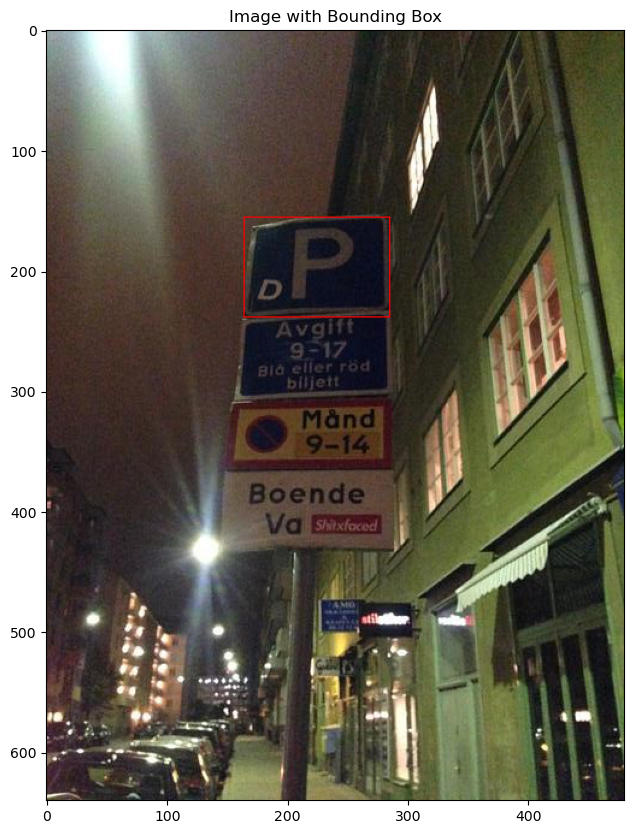

In [10]:
check_bounding_boxes("./swe-parking-signs-groundtruth-master/data/Photo2013-10-14225620.jpg",[[164.23988842398884, 155.31380753138075, 285.63458856345886, 238.32635983263594]])

In [11]:
# SPLITTING THE DATA

from sklearn.model_selection import train_test_split

img_clas_train_data, img_clas_test_data = train_test_split(image_classification_data, test_size=0.2, random_state=42)
print(len(img_clas_train_data))
#print(img_clas_train_data)
print(len(img_clas_test_data))
#print(img_clas_test_data)





191
48


In [12]:
# Creating a dataset class for the object detection part (traffic signs)

class TrafficSignDataset(Dataset):
    def __init__(self, img_data, image_dir, transforms=None):
        self.img_data = img_data
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):

        if isinstance(idx, list):
            raise ValueError(f"Expected an integer index, but got {type(idx)}.") # resolved!
    
        return self._get_single_item(idx)

    def _get_single_item(self, idx): 
        datapoint = self.img_data[idx]
        image_filename = list(datapoint.keys())[0]  # retrieves only single key
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        annotations = datapoint[image_filename]
        boxes = []
        labels = []
        for annotation in annotations:
            boxes.append(annotation['bbox'])
            labels.append(annotation['label'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            image = self.transforms(image)

        return image, target


In [13]:
# transformations for the training data, we added image augmentations
img_augmentations = transforms.Compose([
    #transforms.ToTensor(), 
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.Grayscale(3), # into b&w
])

# transformations for the testing data, no augmentations
img_transforms = transforms.Compose([
    transforms.ToTensor(),  # into tensor
])

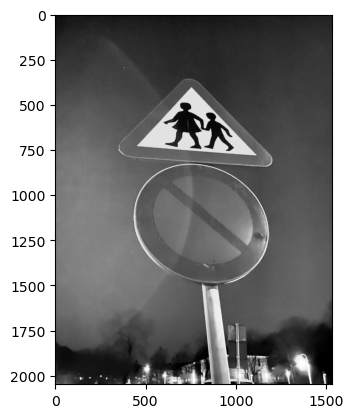

In [14]:
# initializing the datasets
image_dir = "./swe-parking-signs-groundtruth-master/data"

img_clas_train_dataset = TrafficSignDataset(img_clas_train_data, image_dir, transforms=img_augmentations)
img_clas_test_dataset = TrafficSignDataset(img_clas_test_data, image_dir, transforms=img_transforms)
image, target = img_clas_train_dataset[2]  # Single index
plt.imshow(image)
#print(image, target)  #works

In [71]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [196]:
# initializing the dataloaders
train_dataloader = DataLoader(img_clas_train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(img_clas_test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [73]:
# initializing our model with pre-trained weights:
model = fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT,box_fg_iou_thresh=0.6)       # threshold for positive                                   
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.to(device) # sending model to device

cuda:0


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [74]:
# number of classes in Swedish traffic sign dataset (22 + 1 for the background class)
num_classes = 23  

# getting the input features of the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replacing the final head with our own, to match our number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]

# optimizer
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)

# testing a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# saving models here:
save_dir = "final-swedish-traffic-sign-object-detection-modeldir"
os.makedirs(save_dir, exist_ok=True)


In [ ]:
# training:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loss_components = defaultdict(float)  # this will hold the different losses (regression for bbox and cross entropy for classification)
    
    tqdm_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch + 1}")
    
    for idx, batch in enumerate(tqdm_bar):
        images, targets = batch
        
        # sending data to device
        images2 = [image.to(device) for image in images]
        targets2 = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # sending data through model
        loss_dict = model(images2, targets2)
        losses = sum(loss for loss in loss_dict.values())
        
        # adding losses to loss_components
        for key, value in loss_dict.items():
            loss_components[key] += value.item()
    
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        
        # printing predictions, will print a lot, used for dbugg
        model.eval()
        with torch.no_grad():
            predictions = model(images2)  #  predictions
            print("this is predictions", predictions)
            print("this is targets", targets2)
            
            model.train()

        tqdm_bar.set_postfix(loss=losses.item())
    
    # learning rate scheduler step
    lr_scheduler.step()
    epoch_loss = running_loss / len(train_dataloader)
    
    # printing metrics
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_loss:.4f}")
    print(f"  Classification Loss: {loss_components['loss_classifier'] / len(train_dataloader):.4f}")
    print(f"  Bounding Box Loss: {loss_components['loss_box_reg'] / len(train_dataloader):.4f}")
    
    # saving the model:
    save_path = os.path.join(save_dir, f"final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

Epoch 1:   2%|███▏                                                                                                                                                     | 1/48 [00:01<00:54,  1.15s/it, loss=3.31]

this is predictions [{'boxes': tensor([[201.5287, 246.2051, 225.3427, 286.3482],
        [392.4453, 216.2195, 470.3735, 416.4454],
        [ 30.0851, 331.6041,  42.8298, 347.5680],
        [119.2799, 317.3591, 145.4299, 329.7297],
        [204.6682, 229.8684, 228.5184, 267.5317],
        [104.5717, 315.5685, 127.7993, 328.8430],
        [400.7050, 292.4999, 474.7040, 523.1315],
        [208.2808, 253.8217, 223.1703, 280.7959],
        [ 19.8848, 294.8459, 204.0456, 330.8936],
        [ 22.0845, 329.3527,  48.4222, 351.3228],
        [ 16.6945, 301.8064, 172.3014, 336.7618],
        [222.1378, 301.2036, 238.6660, 350.5473],
        [147.8511, 309.4522, 158.7410, 332.7229],
        [113.8570, 311.3720, 315.4740, 341.0678],
        [101.9773, 299.1463, 127.3035, 312.0207],
        [391.6765, 303.0506, 406.5376, 315.3206],
        [222.7802, 310.1558, 240.4654, 333.6873],
        [403.9220, 283.7308, 474.8746, 332.3159],
        [222.8835, 316.3316, 234.9147, 327.4015],
        [ 17.7925, 

Epoch 1:   4%|██████▍                                                                                                                                                  | 2/48 [00:01<00:34,  1.35it/s, loss=2.82]

this is predictions [{'boxes': tensor([[202.1619, 201.9418, 222.1508, 218.2787],
        [154.5465,  72.5159, 410.3717, 595.8444],
        [195.3233, 196.4092, 243.6281, 223.2550],
        [169.1665, 160.9281, 319.5927, 355.7513],
        [177.7220,  80.7967, 291.9559, 185.6035],
        [164.9531,  70.3338, 336.7424, 519.2176],
        [249.1620, 195.9569, 282.3822, 226.9796],
        [194.3480, 177.4322, 229.3605, 210.2322],
        [177.1763,  84.0428, 294.6862, 210.4690],
        [212.0131, 190.4769, 249.1538, 226.6520],
        [140.6367, 450.9862, 165.8329, 499.5253],
        [145.5892,  12.7186, 317.3792, 374.1307],
        [183.6479, 152.4703, 306.2587, 402.4035],
        [146.1364, 461.8239, 160.8788, 489.5520],
        [213.0306, 173.6840, 247.4199, 214.0413],
        [ 10.5935,  49.9825, 382.5681, 519.3707],
        [ 57.3939,  24.9562, 365.3029, 473.2054],
        [196.2564, 191.5254, 227.2902, 218.3749],
        [193.6038, 195.2139, 245.4605, 222.3311],
        [225.5720, 

Epoch 1:   6%|█████████▌                                                                                                                                               | 3/48 [00:02<00:33,  1.34it/s, loss=2.12]

this is predictions [{'boxes': tensor([[ 803.8308,  579.2322,  999.7853,  849.8389],
        [ 256.1421, 1256.7936,  348.3959, 1413.9867],
        [ 232.2753, 1031.5084,  344.1850, 1501.8984],
        [ 221.2844, 1227.0739,  272.9496, 1470.9550],
        [ 703.4276,  655.1054,  771.0880,  787.2797],
        [ 260.7814, 1194.6780,  349.0342, 1505.1079],
        [ 202.0046, 1152.9030,  329.1381, 1533.2467],
        [ 305.3694, 1517.3562,  355.4843, 1561.7826],
        [ 234.2891, 1186.7698,  285.7012, 1386.4933],
        [ 719.3926,  687.9996,  762.6556,  740.5329],
        [ 754.7157,  555.6528, 1033.4908,  812.6105],
        [ 328.1115, 1519.5973,  384.3700, 1575.8734],
        [ 714.7838,  599.9152,  962.0837,  897.5246],
        [ 317.4986, 1167.4087,  395.5221, 1398.0431],
        [ 224.6302, 1303.0375,  255.1935, 1376.6923],
        [ 288.8410, 1495.5958,  365.9401, 1570.5220],
        [ 838.8522,  799.9630,  900.7776, 1005.3000],
        [ 675.1904,  509.7355, 1003.9214,  850.3645

Epoch 1:   8%|████████████▊                                                                                                                                            | 4/48 [00:02<00:27,  1.61it/s, loss=1.25]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[341.4371, 182.5310, 466.0525, 548.2469],
        [191.1480, 160.4949, 439.0129, 509.7322],
        [ 65.5330, 366.8929,  94.8639, 424.6161],
        [ 10.5826, 271.6034,  71.9474, 616.5993],
        [ 74.7042, 355.1369, 104.5381, 423.1575],
        [120.0145, 262.0728, 478.0000, 479.2853],
        [ 80.6117, 370.3661, 105.9400, 420.3401],
        [ 60.4046, 344.2044, 102.2125, 425.9055],
        [ 70.3369, 339.3587, 118.1684, 420.2616],
        [  0.0000, 169.1655, 397.8358, 640.0000],
        [ 14.3235, 261.4846, 121.5009, 610.4888],
        [  6.4317, 296.8885, 128.1765, 601.4813],
        [362.4250, 132.8015, 475.2943, 562.2059],
        [118.8854, 360.9133, 149.8704, 397.7166],
        [363.9770,  96.5513, 478.0000, 584.5113],
        [ 67.4205, 356.1721, 160.2100, 407.4529],
        [ 57.9727, 

Epoch 1:  10%|████████████████                                                                                                                                          | 5/48 [00:03<00:21,  2.01it/s, loss=0.5]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[117.8243,  34.1423, 244.3515, 141.9247],
        [156.6527, 220.9205, 205.5230, 321.3389]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0')}, {'boxes': tensor([[152.6360, 116.9317, 274.0307, 214.2259]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[209.7629, 263.3194, 260.6416, 309.7350],
      

Epoch 1:  12%|███████████████████                                                                                                                                     | 6/48 [00:03<00:20,  2.06it/s, loss=0.356]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[207.7829, 108.4358, 299.9946, 174.4054]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[123.8787,  35.6485, 315.4895, 224.5858]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[134.5607, 117.8243, 216.2343, 196.1506],
        [155.9833, 194.8117, 186.7782, 257.7406]], device='c

Epoch 1:  15%|██████████████████████▎                                                                                                                                  | 7/48 [00:03<00:17,  2.29it/s, loss=0.67]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[121.8131,  10.5202, 464.5509, 348.2747]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[154.5880,  82.4959, 293.8348, 195.2073]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[200.6524, 189.7973, 250.0778, 233.3211],
        [199.1770, 259.1404, 250.0778, 283.4842]], device='c

Epoch 1:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:04<00:15,  2.66it/s, loss=0.369]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[164.2399, 155.3138, 285.6346, 238.3264]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[173.7146,  68.4618, 303.6656, 166.6117]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[159.9452, 154.2432, 235.3910, 227.1742]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')},

Epoch 1:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:04<00:15,  2.49it/s, loss=0.272]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[182.9847,  68.7308, 299.9163, 159.7769]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[791.2078, 705.5175, 931.1688, 851.1911]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[234.5211, 192.4333, 262.9202, 217.6260],
        [235.8953, 217.6260, 263.8363, 234.5739]], device='c

Epoch 1:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:05<00:17,  2.22it/s, loss=0.671]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[249.0377, 187.4477, 319.5537, 247.2524],
        [246.3598, 283.8494, 319.5537, 315.0907]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0')}, {'boxes': tensor([[ 425.5956,  831.1967, 1188.2399, 1499.5815],
        [ 345.6179,  362.7559, 1208.2343,  842.6220]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0')}, {'bo

Epoch 1:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:05<00:16,  2.20it/s, loss=0.529]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[187.4337, 202.3501, 227.7420, 235.6045],
        [188.4414, 255.2548, 230.2613, 274.9051]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0')}, {'boxes': tensor([[ 754.0753,  539.8494, 1011.1464,  814.0586]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[178.8134, 122.1320, 282.6701, 212.8641]], d

Epoch 1:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:05<00:15,  2.36it/s, loss=0.478]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[148.6192, 199.4979, 192.1339, 231.6318],
        [145.2720, 289.8745, 208.8703, 350.7950]], device='cuda:0'), 'labels': tensor([14,  7], device='cuda:0')}, {'boxes': tensor([[180.2994, 106.4161, 304.1623, 192.7054],
        [169.0499, 197.4180, 284.6081, 292.0872]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0')}, {'boxes': te

Epoch 1:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:06<00:15,  2.33it/s, loss=0.617]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[616.3589, 660.5339, 972.3129, 879.1426]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[166.0251, 147.9498, 223.5983, 204.1841],
        [170.7113, 208.2008, 223.5983, 259.0795]], device='cuda:0'), 'labels': tensor([ 2, 10], device='cuda:0')}, {'boxes': tensor([[794.0641, 702.6611, 928.3124, 851.1911]], devic

Epoch 1:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:06<00:13,  2.51it/s, loss=0.587]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[134.0175, 106.0902, 234.0213, 187.9276]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0569], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[423.9888,  41.0600, 456.1227,  66.9456],
        [318.4798, 109.4591, 415.7305, 235.3840]], device='cuda:0'), 'labels': tensor([14, 21], device='cuda:0')}, {'boxes': tensor([[131.0497, 107.0165, 220.0874, 181.3261]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[249.0377, 187.4477, 319.5537, 2

Epoch 1:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:06<00:11,  2.79it/s, loss=0.804]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[128.0320,  51.1343, 217.5973, 144.2734],
        [128.4076,  50.3786, 222.6023, 143.1587]], device='cuda:0'), 'labels': tensor([11,  4], device='cuda:0'), 'scores': tensor([0.0555, 0.0551], device='cuda:0')}, {'boxes': tensor([[195.9894,  87.9509, 292.8758, 194.5588],
        [194.2487,  75.1597, 303.8696, 186.3032],
        [222.5912,  76.4126, 307.0926, 174.1512]], device='cuda:0'), 'labels': tensor([14,  4, 14], device='cuda:0'), 'scores': tensor([0.0639, 0.0505, 0.0503], device='cuda:0')}]
this is targets [{'boxes': tensor([[187.4337, 202.3501, 227.7420, 235.6045],
        [188.4414, 255.2548, 230.2613, 274.9051]], device='cuda:0'), 'labels': tenso

Epoch 1:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:07<00:12,  2.46it/s, loss=0.473]

this is predictions [{'boxes': tensor([[563.3066, 479.3730, 930.2107, 785.1465],
        [581.8104, 298.4001, 981.6974, 871.8200],
        [569.0999, 282.3596, 946.1567, 893.4011]], device='cuda:0'), 'labels': tensor([14, 14,  8], device='cuda:0'), 'scores': tensor([0.0661, 0.0613, 0.0569], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 739.3875,  468.6707,  985.2730,  985.3756],
        [ 728.3666,  701.4692,  994.1089, 1023.3257],
        [ 721.6827,  391.2625,  977.2440,  664.7518],
        [ 800.8663,  641.5248, 1068.8018,  957.0117],
        [ 715.6645,  481.7284, 1030.6107, 1073.0160],
        [ 762.8182,  427.8495, 1053.1521,  767.7219],
        [ 748.7297,  558.6461, 1062.5670,  997.7585],
 

Epoch 1:  35%|█████████████████████████████████████████████████████▊                                                                                                  | 17/48 [00:07<00:13,  2.37it/s, loss=0.39]

this is predictions [{'boxes': tensor([[ 599.9673,  343.2968,  926.0541,  690.1089],
        [ 620.5183,  173.5602, 1037.1185,  772.9648],
        [ 592.3109,  233.6638,  941.1755,  554.4189],
        [ 513.3638,  194.7438,  919.2359,  846.6074],
        [ 563.8942,  276.2538,  990.7178,  770.2513],
        [ 595.7448,  240.1890,  993.6792,  972.6682],
        [ 569.6711,  135.8006,  977.3115,  742.7120],
        [ 567.5682,  184.6315,  993.3795,  972.1611],
        [ 717.3187,  237.3051,  989.4780,  608.9470],
        [ 555.5782,  250.1940, 1069.4203,  657.8986],
        [ 577.4290,  251.1144, 1021.2725,  944.2284]], device='cuda:0'), 'labels': tensor([14, 14, 14,  7,  6, 21,  4,  8, 14, 21, 19], device='cuda:0'), 'scores': tensor([0.0778, 0.0683, 0.0614, 0.0607, 0.0548, 0.0547, 0.0539, 0.0527, 0.0510,
        0.0509, 0.0502], device='cuda:0')}, {'boxes': tensor([[188.3784,  82.3319, 328.4294, 206.2352],
        [175.9624, 105.5283, 312.2542, 212.2788],
        [172.0441, 100.7544, 30

Epoch 1:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:08<00:14,  2.08it/s, loss=0.407]

this is predictions [{'boxes': tensor([[ 756.5159,  517.1057,  997.3251,  818.3165],
        [ 752.9526,  548.3256, 1005.6934,  822.2969],
        [ 735.0122,  503.6767, 1059.9998,  831.1642],
        [ 726.7644,  528.6768, 1015.7670,  845.0677],
        [ 753.2315,  541.9431, 1037.5354,  824.1453]], device='cuda:0'), 'labels': tensor([10, 11, 21,  8,  4], device='cuda:0'), 'scores': tensor([0.0636, 0.0608, 0.0512, 0.0509, 0.0506], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 88.8255,  51.6103, 419.4516, 354.3309],
        [ 83.9944,   8.1325, 276.8593, 346.6177],
        [ 61.0363, 111.7022, 403.0999, 387.1291]], device='cuda:0'), 'labels': tensor([10, 22, 16], device='cuda:0'), 'scores': tensor([0.0732, 0.0514, 0.0505], device='cuda:0')}, {'boxes': tensor([[ 710.3555,  361.9362,  983.7868,  685.8546],
        [ 591.1719,  408.8419,  918.2375,

Epoch 1:  40%|████████████████████████████████████████████████████████████▏                                                                                           | 19/48 [00:08<00:12,  2.36it/s, loss=0.39]

this is predictions [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[179.7800,  68.7162, 320.2740, 232.6306],
        [167.5525,  98.2872, 284.3639, 190.4332],
        [179.7302, 133.1583, 310.8875, 201.3486],
        [156.2686,  91.1852, 372.5590, 200.3272],
        [219.4154,  92.9837, 309.6380, 197.8676],
        [176.7801, 266.4264, 317.9766, 337.4157],
        [170.9098, 107.3949, 270.2373, 210.4003],
        [192.7461,  91.5174, 324.7087, 189.8443]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14,  7,  7], device='cuda:0'), 'scores': tensor([0.0922, 0.0737, 0.0625, 0.0568, 0.0566, 0.0558, 0.0534, 0.0509],
       device='cuda:0')}, {'boxes': tensor([[136.8186,  55.4221, 208.4751, 129.0596],
        [128.4237,  17.6289, 235.6321, 160.3938],
        [ 93.3773,  38.0576, 236.8779, 112.4255],
        [129.7117,  24.7015, 229.4251, 169.6385],
        [123

Epoch 1:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:09<00:10,  2.57it/s, loss=0.417]

this is predictions [{'boxes': tensor([[102.6793, 225.0840, 243.2865, 356.1979],
        [ 87.4707, 129.1638, 238.3167, 240.8857],
        [ 79.4260, 264.3192, 232.7846, 391.1799],
        [ 82.8401, 232.0549, 226.3860, 429.1137],
        [ 82.5434, 165.9810, 234.7141, 413.9594],
        [ 73.2278, 238.9694, 168.9466, 376.3177],
        [ 85.5434, 236.1283, 242.4171, 372.8921],
        [100.6649, 224.3326, 219.2042, 359.3177],
        [105.2803, 220.7547, 225.8314, 364.5039]], device='cuda:0'), 'labels': tensor([10, 14, 14, 10,  8,  7,  4, 16,  2], device='cuda:0'), 'scores': tensor([0.0693, 0.0669, 0.0660, 0.0566, 0.0562, 0.0552, 0.0550, 0.0535, 0.0510],
       device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[126.8864,  81.1621, 480.6036, 336.7639],
        [159.6331,  14.8804, 493.7871, 253.3299],
        [116.8553,  56.1074, 464.7570, 385.6432],


Epoch 1:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:09<00:12,  2.24it/s, loss=0.327]

this is predictions [{'boxes': tensor([[771.7401, 688.5524, 950.3343, 874.2385]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0508], device='cuda:0')}, {'boxes': tensor([[ 399.8374,  378.7383, 1287.3625, 1165.4139]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.0998], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[259.6171,  13.0651, 331.8591, 108.2428],
        [249.6072,  32.8096, 306.3553,  89.5463],
        [242.4842,  21.8866, 304.0815, 128.6818],
        [244.5172, 162.5870, 340.1627, 223.2182],
        [240.8030,  84.6876, 316.0572, 146.4165],
        [242.9164,   0.0000, 310.8096, 102.6655],
        [260.6958,  15.6462, 327.2423,  90.2949]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14,  8, 10], device='cuda:0'), 'scores': tensor([0.0772, 0.0667, 0.0623, 0.0588,

Epoch 1:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:10<00:10,  2.53it/s, loss=0.441]

this is predictions [{'boxes': tensor([[195.6073,  83.6489, 326.4547, 242.6952],
        [175.6735, 117.6824, 376.1981, 224.9784],
        [157.7439,  93.3770, 306.0113, 203.1478],
        [205.7441, 215.7793, 340.0411, 284.4514],
        [172.9613, 131.2990, 288.2930, 229.3320],
        [128.4697, 102.3714, 318.6527, 207.4304],
        [183.8580, 195.8218, 328.4788, 320.9414],
        [153.5520,  44.8083, 363.7871, 353.6137],
        [226.2093, 107.8721, 327.8971, 209.1250],
        [171.4677, 116.3413, 310.7218, 194.8372],
        [177.9538,  51.3038, 307.5637, 239.2622],
        [188.0730, 103.2934, 292.7473, 180.2607]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14,  9, 14, 14, 14, 13,  8, 14], device='cuda:0'), 'scores': tensor([0.0717, 0.0717, 0.0702, 0.0695, 0.0640, 0.0619, 0.0595, 0.0547, 0.0524,
        0.0524, 0.0512, 0.0510], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': ten

Epoch 1:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:10<00:11,  2.23it/s, loss=0.414]

this is predictions [{'boxes': tensor([[ 543.0663,  361.7763, 1058.6271,  778.9935],
        [ 637.7555,  296.9851, 1094.6859,  663.9441],
        [ 537.5483,  348.9019, 1066.9596,  721.9260],
        [ 496.5846,  314.3119, 1115.9626,  636.4371],
        [ 588.7416,  335.2729, 1041.0021,  748.0574],
        [ 568.5798,  223.2999, 1019.1531,  820.1588],
        [ 533.4334, 1181.1475, 1055.9347, 1429.3546]], device='cuda:0'), 'labels': tensor([14, 14,  9, 13, 21,  8, 14], device='cuda:0'), 'scores': tensor([0.0974, 0.0809, 0.0542, 0.0541, 0.0539, 0.0520, 0.0504],
       device='cuda:0')}, {'boxes': tensor([[ 594.6609,  398.2206,  923.2248,  636.6488],
        [ 721.0946,  373.4376,  963.0139,  679.2762],
        [ 638.1349,  306.7838,  967.7502,  811.6923],
        [ 601.9742,  361.4241,  981.6491,  554.0144],
        [ 665.2433,  371.5502,  922.9895,  651.6784],
        [ 591.8065,  404.5943,  913.3889,  647.2560],
        [ 611.1230,  361.3073,  955.8323,  655.3023],
        [ 596.7409

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:10<00:09,  2.50it/s, loss=0.348]

this is predictions [{'boxes': tensor([[225.0522, 193.3555, 306.3631, 258.4559]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0840], device='cuda:0')}, {'boxes': tensor([[141.9107, 137.3020, 200.0730, 182.5164],
        [ 58.8865, 135.2991, 122.2924, 182.9120]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.0867, 0.0531], device='cuda:0')}, {'boxes': tensor([[319.1222, 100.4742, 433.9285, 248.4622],
        [ 28.5369, 226.9074, 301.1499, 420.0588],
        [311.2103, 127.2667, 406.1998, 224.8043]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.0865, 0.0775, 0.0722], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[228.5077, 197.2664, 294.5607, 252.6081],
        [227.6151, 283.8494, 296.3459, 314.1981]], device='cuda:0'),

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:11<00:09,  2.54it/s, loss=0.396]

this is predictions [{'boxes': tensor([[ 664.6918,  513.6689,  945.8865, 1088.5597],
        [ 694.8859,  512.6562,  915.9211,  849.7037]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.0584, 0.0501], device='cuda:0')}, {'boxes': tensor([[184.0339, 153.2812, 306.3799, 242.2019],
        [196.5942, 230.7025, 308.7123, 297.2088]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.0874, 0.0599], device='cuda:0')}, {'boxes': tensor([[135.4789,  51.9814, 227.2762, 120.9847]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0873], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 597.2135,  546.8934,  900.6437,  857.2353],
        [ 636.0536,  812.1040,  952.3425, 1088.3893]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0')},

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:11<00:08,  2.56it/s, loss=0.352]

this is predictions [{'boxes': tensor([[187.3817, 109.4307, 323.5672, 209.8736]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0997], device='cuda:0')}, {'boxes': tensor([[789.7604, 707.9800, 932.7460, 864.2706]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0597], device='cuda:0')}, {'boxes': tensor([[175.7147,  71.2613, 297.6448, 158.4241]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0835], device='cuda:0')}, {'boxes': tensor([[187.0537, 219.0383, 245.5660, 315.4365],
        [186.6663, 233.4326, 232.1422, 271.8095]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.0706, 0.0589], device='cuda:0')}]
this is targets [{'boxes': tensor([[174.0586, 111.5760, 313.3055, 206.1925],
        [172.2734, 208.8703, 323.1241, 283.8494]], device='cuda:0'), 'labels': tensor([14,  9], device='cuda:0')}, {'boxes': tensor([[791.2078, 708.3738, 931.1688, 848.3347]], 

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:12<00:08,  2.39it/s, loss=0.524]

this is predictions [{'boxes': tensor([[ 502.5263,  857.0555, 1202.0972, 1543.7667],
        [ 371.8065,  383.8539, 1198.0366,  807.4395],
        [ 252.6773,  737.8900, 1360.2737, 1457.5015],
        [ 413.4951,  955.2683, 1136.2533, 1558.2347]], device='cuda:0'), 'labels': tensor([10, 14, 10, 14], device='cuda:0'), 'scores': tensor([0.1014, 0.0746, 0.0579, 0.0531], device='cuda:0')}, {'boxes': tensor([[155.0725, 248.9622, 312.1816, 310.7101],
        [129.3510, 120.0223, 357.4290, 251.6773],
        [162.4329,  62.7864, 348.0297, 233.7090],
        [135.8210,  60.2905, 308.0092, 223.2537],
        [141.8789,  85.1076, 338.0630, 245.1798]], device='cuda:0'), 'labels': tensor([14, 14, 10, 14,  4], device='cuda:0'), 'scores': tensor([0.0842, 0.0823, 0.0708, 0.0525, 0.0512], device='cuda:0')}, {'boxes': tensor([[222.1891, 120.4621, 287.7639, 182.4450],
        [337.5143, 139.5877, 480.0000, 214.8815]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.081

Epoch 1:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:12<00:08,  2.49it/s, loss=0.465]

this is predictions [{'boxes': tensor([[ 99.7393,  23.8843, 173.7064,  71.1798],
        [ 99.9210,  75.0112, 180.2596, 106.2067],
        [ 99.1336, 114.0804, 191.3616, 149.5928]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.1261, 0.0570, 0.0544], device='cuda:0')}, {'boxes': tensor([[137.4292, 112.0234, 220.0910, 165.1378],
        [136.3153, 168.0301, 220.2237, 225.9466]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.1058, 0.0527], device='cuda:0')}, {'boxes': tensor([[194.1663, 187.8184, 316.2281, 270.9120],
        [186.0166, 252.5026, 310.7568, 362.6545]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.1061, 0.0598], device='cuda:0')}, {'boxes': tensor([[146.6220, 102.9656, 351.7248, 338.1389],
        [104.9092, 149.2525, 342.7915, 334.8299],
        [147.5224, 106.4721, 326.4924, 308.2885],
        [ 99.1346, 172.5815, 363.6887, 325.2666],
        [151.0889, 118.

Epoch 1:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:12<00:07,  2.57it/s, loss=0.453]

this is predictions [{'boxes': tensor([[190.8350,  78.1415, 310.6561, 177.7129],
        [174.1283,  65.0763, 292.4291, 224.1881],
        [192.0580, 111.0232, 293.0490, 200.3146]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.1315, 0.0546, 0.0507], device='cuda:0')}, {'boxes': tensor([[ 81.4415,  13.3768, 421.7928, 317.2589]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.1134], device='cuda:0')}, {'boxes': tensor([[237.4520,  40.7444, 365.2706, 189.3725],
        [ 77.9072, 275.0539, 300.6964, 446.8990],
        [218.8937,  41.9676, 335.8267, 145.9771],
        [245.6751,  33.8791, 360.5573, 149.6916],
        [106.3913, 323.6252, 276.3219, 470.5080],
        [104.7406, 225.4035, 333.5652, 501.0257],
        [226.1544,  58.2634, 372.8146, 177.9015]], device='cuda:0'), 'labels': tensor([14, 14, 14, 10, 14, 14, 21], device='cuda:0'), 'scores': tensor([0.0920, 0.0885, 0.0730, 0.0716, 0.0649, 0.0632, 0.0501],
    

Epoch 1:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:13<00:07,  2.41it/s, loss=0.324]

this is predictions [{'boxes': tensor([[135.6412, 154.7616, 227.0075, 237.7747],
        [131.3062,  68.9127, 217.5087, 143.2994],
        [127.1340, 158.2809, 226.7928, 239.2748],
        [125.7902,  50.8597, 228.6916, 141.7677],
        [135.6288, 155.5869, 237.8900, 236.5097],
        [122.8955,  41.5959, 219.9847, 175.4562],
        [123.7713,  49.0312, 230.3245, 145.2541]], device='cuda:0'), 'labels': tensor([10, 14, 14, 10,  4, 14,  4], device='cuda:0'), 'scores': tensor([0.0802, 0.0775, 0.0720, 0.0609, 0.0591, 0.0524, 0.0511],
       device='cuda:0')}, {'boxes': tensor([[ 562.6275,  453.5030, 1156.1021, 1085.8956]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.1102], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[222.1223,  95.6930, 485.3312, 350.9288],
        [223.6927, 326.7550, 459.2210, 430.5479],
    

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:13<00:07,  2.33it/s, loss=0.484]

this is predictions [{'boxes': tensor([[181.2950,  99.6561, 297.3169, 181.9050],
        [188.7317, 184.4620, 289.0691, 243.0516]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.1620, 0.0688], device='cuda:0')}, {'boxes': tensor([[123.9398,  60.1710, 216.5648, 125.8884],
        [132.2150, 141.8123, 217.6415, 225.2345],
        [126.3160, 151.4333, 235.8687, 232.8427],
        [134.0965,  57.1583, 221.9629, 135.9003],
        [133.9013,  53.9482, 221.2113, 135.8637],
        [130.8798, 141.4265, 225.8662, 227.8745]], device='cuda:0'), 'labels': tensor([14, 10, 14, 10,  2,  4], device='cuda:0'), 'scores': tensor([0.0839, 0.0747, 0.0672, 0.0606, 0.0510, 0.0501], device='cuda:0')}, {'boxes': tensor([[ 542.8041,  421.1476,  921.0475,  724.4213],
        [ 624.3314,  392.4858, 1042.5975,  790.8314],
        [ 521.4057,  422.2065,  997.4044,  765.1064]], device='cuda:0'), 'labels': tensor([14, 14,  9], device='cuda:0'), 'scores': tensor([0.1469, 0.1361, 0

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:14<00:06,  2.41it/s, loss=0.277]

this is predictions [{'boxes': tensor([[147.1546, 184.4572, 200.8533, 228.8613],
        [146.5267, 190.4307, 182.2512, 218.8519]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.1344, 0.0559], device='cuda:0')}, {'boxes': tensor([[213.3433,  79.2877, 291.5689, 158.2938]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0644], device='cuda:0')}, {'boxes': tensor([[150.1048, 219.7641, 194.3098, 254.2629]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0597], device='cuda:0')}, {'boxes': tensor([[277.8993,  89.8795, 468.0371, 279.7655],
        [267.7966, 145.9367, 437.1264, 262.3193],
        [328.1583, 284.3127, 378.8953, 402.9956],
        [276.6181,  85.2654, 438.5792, 374.6122],
        [285.4630, 129.8337, 438.5779, 236.6724]], device='cuda:0'), 'labels': tensor([10, 14, 14, 14, 10], device='cuda:0'), 'scores': tensor([0.0918, 0.0625, 0.0536, 0.0515, 0.0514], device='cuda:0')}]
this 

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:14<00:06,  2.47it/s, loss=0.258]

this is predictions [{'boxes': tensor([[224.0012, 120.4118, 285.9335, 177.8607],
        [344.1640, 137.6174, 480.0000, 217.4049]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.1332, 0.0508], device='cuda:0')}, {'boxes': tensor([[210.0302, 122.7146, 303.8261, 179.1965],
        [200.3391, 325.0023, 251.1646, 376.3891],
        [238.7702, 127.6492, 294.8910, 172.3832]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.1574, 0.1304, 0.0621], device='cuda:0')}, {'boxes': tensor([[ 748.5182,  546.0299, 1008.2686,  808.9288],
        [ 709.8334,  571.4819,  986.1086,  848.0186],
        [ 776.1732,  594.8729, 1024.6403,  828.6731]], device='cuda:0'), 'labels': tensor([10, 14, 11], device='cuda:0'), 'scores': tensor([0.0944, 0.0764, 0.0650], device='cuda:0')}, {'boxes': tensor([[230.9181, 211.5703, 269.7974, 247.3349]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0941], device='cuda

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:14<00:05,  2.77it/s, loss=0.365]

this is predictions [{'boxes': tensor([[139.3916,  20.6613, 290.0172, 137.1918],
        [189.2796,  27.8316, 301.2082, 119.3941],
        [146.2157, 241.8335, 212.8454, 296.5985],
        [128.1547, 235.5751, 297.4246, 302.1381],
        [ 90.2672,  14.9033, 349.9898, 150.2333],
        [134.8536,  22.1009, 295.1392, 135.1696]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14,  9], device='cuda:0'), 'scores': tensor([0.2087, 0.0784, 0.0735, 0.0597, 0.0594, 0.0513], device='cuda:0')}, {'boxes': tensor([[138.4331, 131.0765, 223.4484, 199.5470],
        [197.0395,   1.9953, 242.9388,  41.6076],
        [134.4981, 136.7638, 216.1714, 189.3293]], device='cuda:0'), 'labels': tensor([14, 14,  9], device='cuda:0'), 'scores': tensor([0.2260, 0.0636, 0.0527], device='cuda:0')}, {'boxes': tensor([[128.9314, 115.2530, 221.5157, 177.7768],
        [146.9608, 103.9051, 245.7787, 188.1082],
        [129.7856, 184.7799, 232.8188, 267.3026],
        [104.5269, 112.3930, 237.4156, 184.5177]], de

Epoch 1:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:15<00:04,  3.02it/s, loss=0.255]

this is predictions [{'boxes': tensor([[166.5885,  72.8784, 272.3535, 158.7578],
        [177.8995,  37.8977, 281.8407, 194.3829],
        [158.5791, 155.4792, 293.3825, 231.5669],
        [145.1390,  64.4125, 343.0924, 167.3152]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.1942, 0.0681, 0.0553, 0.0500], device='cuda:0')}, {'boxes': tensor([[120.6001, 175.2491, 189.9955, 225.3721],
        [130.2001, 238.9910, 194.6797, 296.5057],
        [128.6515, 237.4843, 195.2310, 297.3374],
        [146.9241, 173.1332, 195.7182, 235.4278],
        [128.0953, 176.4406, 193.1007, 229.2269],
        [140.4713, 300.6873, 185.6745, 327.1055]], device='cuda:0'), 'labels': tensor([14, 10, 14, 14, 10, 14], device='cuda:0'), 'scores': tensor([0.1017, 0.0868, 0.0702, 0.0691, 0.0610, 0.0581], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {

Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:15<00:03,  3.24it/s, loss=0.419]

this is predictions [{'boxes': tensor([[148.3528, 248.0629, 176.4878, 308.2915],
        [115.6373, 200.6428, 195.4141, 247.5780],
        [111.8204, 128.4679, 191.7023, 198.9122],
        [108.5405, 137.3087, 190.4246, 203.5874]], device='cuda:0'), 'labels': tensor([14, 14, 10, 14], device='cuda:0'), 'scores': tensor([0.1126, 0.1003, 0.0941, 0.0795], device='cuda:0')}, {'boxes': tensor([[167.5310,  95.9200, 302.7438, 202.0766],
        [170.2157, 121.7174, 341.2013, 224.7431],
        [192.2763, 108.5640, 292.8204, 178.4967],
        [176.6774, 110.3793, 309.6511, 211.0473],
        [227.4738, 110.2309, 305.5154, 200.4988]], device='cuda:0'), 'labels': tensor([14, 14, 14,  9, 14], device='cuda:0'), 'scores': tensor([0.1844, 0.1424, 0.0904, 0.0534, 0.0504], device='cuda:0')}, {'boxes': tensor([[245.6432, 324.7720, 288.5909, 406.4148],
        [209.7142, 159.9144, 336.0205, 243.6306],
        [197.8396, 129.4771, 353.3356, 242.2211],
        [191.9556, 242.6967, 327.3919, 315.4961],
   

Epoch 1:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:15<00:04,  2.61it/s, loss=0.349]

this is predictions [{'boxes': tensor([[ 91.1646,  62.2700, 428.8513, 384.9857],
        [ 45.9627,  98.3882, 396.0376, 368.0618],
        [128.4713,  17.9907, 445.2895, 263.3353]], device='cuda:0'), 'labels': tensor([10, 14, 10], device='cuda:0'), 'scores': tensor([0.2252, 0.0710, 0.0508], device='cuda:0')}, {'boxes': tensor([[ 615.1482,  202.7071,  912.6511,  475.0211],
        [ 584.4614,  520.8247,  939.8721,  899.3078],
        [ 549.8699,  190.7721, 1083.3353,  496.9567],
        [ 552.2886, 1049.6942,  991.1859, 1257.2915]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.2504, 0.0764, 0.0671, 0.0550], device='cuda:0')}, {'boxes': tensor([[201.0311, 249.9648, 246.7014, 285.0542]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.1412], device='cuda:0')}, {'boxes': tensor([[ 606.0527,  632.5188,  954.4130,  841.9156],
        [ 639.5889,  567.1812, 1069.4611,  927.5007],
        [ 751.2875,  624.8743, 1028.9

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 38/48 [00:16<00:03,  2.68it/s, loss=0.5]

this is predictions [{'boxes': tensor([[163.1409,  71.2358, 308.3262, 249.1617]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.1132], device='cuda:0')}, {'boxes': tensor([[ 557.3265,  468.3131, 1111.5366, 1061.4661],
        [ 471.0885,  511.3605, 1074.0613, 1133.5583],
        [ 521.4650,  356.7311, 1143.8806, 1424.6805],
        [ 418.3340,  586.7238, 1069.8256, 1227.0896]], device='cuda:0'), 'labels': tensor([10, 14, 10, 10], device='cuda:0'), 'scores': tensor([0.1581, 0.0798, 0.0673, 0.0614], device='cuda:0')}, {'boxes': tensor([[204.6306, 169.7130, 278.3715, 231.9692],
        [196.2091, 155.2777, 300.7525, 243.5606],
        [207.2990, 231.1565, 293.4009, 298.0876],
        [238.3521, 302.0499, 273.6251, 353.7116]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.2497, 0.1644, 0.1101, 0.0589], device='cuda:0')}, {'boxes': tensor([[147.3300, 140.0420, 194.2774, 190.6918],
        [142.1711, 146.4484, 182.

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/48 [00:16<00:03,  2.37it/s, loss=0.27]

this is predictions [{'boxes': tensor([[ 27.8811,   0.2180, 147.7418, 124.5628],
        [ 12.9528,  29.0145, 194.4528, 143.9967]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.4122, 0.2491], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 700.7846,  323.0977,  995.3304,  571.9578],
        [ 718.9097,  415.4595, 1026.5668,  605.8480],
        [ 767.2351,  344.0243, 1099.6655,  622.2305],
        [ 698.8934,  224.3213, 1036.2725,  697.6498]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.3061, 0.1987, 0.1868, 0.0932], device='cuda:0')}, {'boxes': tensor([[790.1256, 715.6428, 929.4098, 859.4138],
        [795.7703, 711.5452, 927.8455, 855.8802],
        [760.5983, 667.2650, 966.0394, 874.1012]], device='cuda:0'), 'labels': tensor([14, 10, 14], device='cuda:0'), 'scor

Epoch 1:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 40/48 [00:17<00:03,  2.46it/s, loss=0.37]

this is predictions [{'boxes': tensor([[211.9319, 238.3424, 255.0883, 300.0673]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.0621], device='cuda:0')}, {'boxes': tensor([[120.2455, 175.1095, 190.1765, 226.3380],
        [140.9493, 301.3365, 184.1738, 327.7218],
        [125.2475, 246.5911, 190.5761, 305.9826],
        [130.9203, 240.1362, 193.4499, 299.5450],
        [135.8422, 176.6095, 186.4343, 235.4478],
        [102.6820, 233.2012, 192.0870, 291.8972],
        [130.1200, 171.6834, 192.7450, 227.8019]], device='cuda:0'), 'labels': tensor([14, 14, 14, 10, 10, 14,  2], device='cuda:0'), 'scores': tensor([0.1465, 0.1251, 0.0979, 0.0916, 0.0711, 0.0596, 0.0560],
       device='cuda:0')}, {'boxes': tensor([[169.3850, 238.0755, 203.2232, 305.3289],
        [122.5003, 163.4143, 223.6837, 233.1900],
        [130.9145, 134.1029, 234.8649, 262.0187],
        [137.8649, 141.3320, 232.8855, 236.6994],
        [138.9438, 143.7089, 225.6565, 214.9046],
        

Epoch 1:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:17<00:02,  2.72it/s, loss=0.206]

this is predictions [{'boxes': tensor([[146.8973, 144.8309, 221.8958, 240.3285],
        [276.8346, 134.3311, 348.8723, 227.9936],
        [274.6687, 117.3789, 364.3045, 273.8393],
        [135.0874, 123.9182, 225.0980, 287.2035],
        [260.5187, 134.6229, 356.7662, 185.8349]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.2049, 0.1707, 0.1581, 0.1291, 0.0993], device='cuda:0')}, {'boxes': tensor([[123.3227, 110.3657, 235.2356, 159.7403],
        [366.3039,  23.4899, 396.4950,  60.6508],
        [361.8830,   6.8547, 398.7929, 105.1101]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.0872, 0.0770, 0.0568], device='cuda:0')}, {'boxes': tensor([[179.1017, 129.5827, 318.0637, 210.8588],
        [171.7188, 123.6222, 276.8104, 192.8565],
        [160.6662, 287.6676, 313.4822, 349.4670],
        [174.6608, 293.0848, 237.7220, 343.5919],
        [166.9890, 205.7259, 329.9343, 290.8277],
        [129.64

Epoch 1:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:17<00:02,  2.74it/s, loss=0.463]

this is predictions [{'boxes': tensor([[205.3418, 104.0127, 293.8940, 183.5858],
        [188.3741, 274.8676, 299.4556, 327.3130],
        [178.3338,  98.6734, 336.7023, 188.4324],
        [214.5540, 389.0518, 271.8587, 453.9015],
        [196.0815, 229.1673, 299.0613, 269.8109],
        [232.3786, 109.9263, 287.0685, 154.0284],
        [232.6186, 115.6422, 276.0930, 178.4517]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.4133, 0.1236, 0.1109, 0.0675, 0.0601, 0.0565, 0.0532],
       device='cuda:0')}, {'boxes': tensor([[171.2196, 240.6042, 218.0148, 278.3894]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.2335], device='cuda:0')}, {'boxes': tensor([[153.6166,   4.6139, 349.7205, 253.4686],
        [149.9600, 195.5704, 318.7494, 301.4407],
        [156.3107, 291.1258, 336.5194, 401.2125],
        [178.4195,  36.6491, 324.5712, 199.0605],
        [162.5737,   6.6354, 335.7551, 190.2045],
        

Epoch 1:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:18<00:01,  3.01it/s, loss=0.385]

this is predictions [{'boxes': tensor([[114.0864, 282.7214, 192.9691, 329.6165],
        [ 92.6615,  45.3035, 197.2854, 138.7021],
        [ 97.0983, 162.1659, 220.4082, 282.7509],
        [ 98.8832,  64.8345, 225.7020, 160.5804],
        [ 87.2478, 182.7657, 214.9576, 292.7723],
        [ 98.9964,  51.5349, 219.9456, 157.6234],
        [ 63.6947, 162.8699, 230.5380, 260.8906],
        [ 97.3669,  63.3544, 219.5001, 114.1046],
        [100.2038, 168.8938, 229.5111, 285.3474]], device='cuda:0'), 'labels': tensor([14, 14, 10, 14, 14, 10, 14, 14,  4], device='cuda:0'), 'scores': tensor([0.1913, 0.1800, 0.1595, 0.1464, 0.1282, 0.0807, 0.0646, 0.0553, 0.0540],
       device='cuda:0')}, {'boxes': tensor([[156.1734, 193.2518, 186.1357, 251.3883],
        [137.7403, 112.0053, 220.7682, 198.3169],
        [130.2642, 119.1221, 215.2408, 206.8037],
        [141.5152, 206.8153, 194.5435, 251.8671],
        [143.3624, 107.9568, 221.3633, 195.8848],
        [122.0124, 109.4479, 225.8340, 200.4192]],

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:18<00:01,  2.75it/s, loss=0.419]

this is predictions [{'boxes': tensor([[ 30.3678,   0.4092, 155.0399, 121.3689],
        [  0.0000,   7.6960, 216.8551, 153.0635],
        [ 51.0603,  37.9484, 154.2754, 143.6363],
        [ 23.7050,  23.2592, 145.2338,  87.1324]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.5985, 0.1665, 0.1094, 0.0768], device='cuda:0')}, {'boxes': tensor([[ 389.1880,  383.8065, 1326.3883, 1130.3934],
        [ 292.0262,  330.3934, 1151.6173, 1523.2616],
        [ 269.2472,  468.9638, 1191.9962, 1215.8638],
        [ 525.9588,  282.3203, 1498.2721, 1437.4777]], device='cuda:0'), 'labels': tensor([10, 10, 14, 10], device='cuda:0'), 'scores': tensor([0.3913, 0.1117, 0.1002, 0.0800], device='cuda:0')}, {'boxes': tensor([[368.3758, 207.9379, 410.2237, 252.3925],
        [365.7930, 199.5646, 415.1839, 277.6114]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.0922, 0.0577], device='cuda:0')}, {'boxes': tensor([[197.5531,  8

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:18<00:01,  2.78it/s, loss=0.44]

this is predictions [{'boxes': tensor([[235.7126, 190.7159, 293.3875, 256.4721],
        [229.2806, 199.8847, 279.1440, 239.9013],
        [213.8744, 192.9921, 315.2520, 245.6186],
        [229.5882, 273.3998, 301.1791, 322.0157],
        [225.2152, 250.8708, 299.8186, 286.3075],
        [235.7320, 249.2037, 293.9174, 338.9656],
        [244.5936, 206.9487, 300.7546, 245.3303],
        [241.9275, 289.7856, 295.2333, 317.2162],
        [234.0271, 257.6787, 294.9243, 278.1134],
        [227.5145, 287.4012, 277.9878, 315.6166]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.4776, 0.2317, 0.2219, 0.1850, 0.1669, 0.1155, 0.0805, 0.0801, 0.0666,
        0.0622], device='cuda:0')}, {'boxes': tensor([[ 31.1884,   8.2060, 173.0392, 145.6030],
        [ 30.0500,  16.9783, 147.1051, 134.4627]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.2850, 0.0936], device='cuda:0')}, {'boxes': tensor([[

Epoch 1:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:19<00:00,  3.02it/s, loss=0.281]

this is predictions [{'boxes': tensor([[174.0759, 237.3860, 218.8980, 279.2113],
        [174.6688, 309.2619, 223.8909, 333.0424]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.3180, 0.0723], device='cuda:0')}, {'boxes': tensor([[169.4067, 104.6289, 272.9899, 216.4439],
        [156.1213, 195.8387, 268.7604, 316.4051],
        [201.5864, 114.1336, 260.6408, 204.4022],
        [190.3058, 210.8065, 258.6765, 298.3858],
        [214.6722, 124.7001, 276.3707, 231.6955],
        [152.5484, 284.0771, 282.6918, 382.9524],
        [211.7651, 133.8031, 247.5646, 199.1296],
        [159.2589, 208.7086, 229.9727, 300.0617],
        [160.9829, 107.7701, 239.1135, 192.0573]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.3401, 0.2988, 0.1840, 0.1282, 0.1183, 0.1100, 0.0733, 0.0613, 0.0525],
       device='cuda:0')}, {'boxes': tensor([[195.4446,  89.5243, 268.8238, 148.7535],
        [181.7759,  79

Epoch 1:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:19<00:00,  3.22it/s, loss=0.267]

this is predictions [{'boxes': tensor([[156.3431, 203.3038, 199.7367, 243.4098],
        [177.4377, 240.8746, 193.7268, 279.7734],
        [153.3868, 159.0124, 205.4336, 203.1894],
        [155.4544, 163.2433, 197.8502, 203.3595],
        [149.5486, 146.1486, 188.1794, 210.1443],
        [171.8579, 232.9704, 197.3964, 285.7709],
        [159.7117, 153.3844, 202.2631, 204.6870]], device='cuda:0'), 'labels': tensor([14, 14, 10, 14, 14, 14,  2], device='cuda:0'), 'scores': tensor([0.2827, 0.1382, 0.1211, 0.1108, 0.0673, 0.0560, 0.0549],
       device='cuda:0')}, {'boxes': tensor([[246.2719, 222.4796, 290.0793, 265.0777],
        [251.8674,  97.4356, 277.8569, 130.6882],
        [248.7517, 216.8433, 309.4764, 275.3907]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.1516, 0.1190, 0.1016], device='cuda:0')}, {'boxes': tensor([[167.8554, 208.0674, 205.3927, 242.2500],
        [152.6412, 203.7921, 205.8818, 252.6602],
        [164.0318, 207.3401, 193.4

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.44it/s, loss=0.394]

this is predictions [{'boxes': tensor([[150.0069, 186.3626, 200.4265, 230.0563],
        [144.7166, 190.8557, 181.0710, 220.7754],
        [146.2777, 224.1093, 195.6467, 269.1447],
        [161.9131, 189.2313, 196.7636, 219.3758],
        [152.9533, 231.8987, 187.6867, 263.3226]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.5529, 0.2714, 0.2446, 0.1388, 0.1250], device='cuda:0')}, {'boxes': tensor([[ 571.5811,  455.9435, 1137.6515, 1045.9697],
        [ 526.7897,  532.4139, 1088.7606, 1184.4333],
        [ 403.9680,  363.4854, 1064.6661, 1243.1600]], device='cuda:0'), 'labels': tensor([10, 14, 10], device='cuda:0'), 'scores': tensor([0.3100, 0.1253, 0.1206], device='cuda:0')}, {'boxes': tensor([[147.4717, 122.2783, 238.1853, 204.1134],
        [129.4596, 127.3442, 269.6167, 223.4782],
        [ 40.4976, 570.1559, 345.0880, 640.0000],
        [177.9641, 131.4320, 247.8462, 228.8058],
        [137.4875, 315.1455, 253.5768, 368.4368],
   

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_1.pth


Epoch 2:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:22,  2.08it/s, loss=0.424]

this is predictions [{'boxes': tensor([[197.7727,  86.2178, 285.9041, 183.3107],
        [205.3401, 362.4518, 309.2393, 413.8174],
        [205.0497,  42.9083, 317.5745, 200.4349],
        [192.4274, 425.3925, 290.3428, 479.3376],
        [153.7675,  80.6798, 328.3917, 177.7299],
        [189.8536, 405.4574, 309.5389, 494.2238],
        [199.1814, 339.4805, 303.8009, 435.7567],
        [182.3831,  80.8476, 299.8515, 138.6030],
        [199.2099, 299.5145, 296.6327, 362.1621],
        [209.3351, 428.8292, 276.8267, 465.0930],
        [185.7561, 354.1655, 299.6581, 398.0229],
        [197.8537, 256.0740, 297.1674, 303.1595]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.6576, 0.3876, 0.3021, 0.2202, 0.1660, 0.1633, 0.1605, 0.1200, 0.0927,
        0.0896, 0.0819, 0.0562], device='cuda:0')}, {'boxes': tensor([[ 607.5950,  655.1390,  920.3934,  910.7898],
        [ 922.4564, 1609.8064, 1036.3075, 1767.8800],
     

Epoch 2:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:18,  2.46it/s, loss=0.391]

this is predictions [{'boxes': tensor([[132.6904,  56.8077, 231.9895, 141.7473],
        [137.0349, 152.1085, 223.6067, 240.0791],
        [133.0092, 152.7039, 241.2213, 243.4685],
        [126.0034,  47.1920, 225.9655, 141.4991],
        [148.2471, 242.6264, 214.3586, 271.5088],
        [134.1953, 163.5555, 236.1810, 231.5943],
        [125.4556,  31.5986, 228.2002, 187.8510],
        [122.5904,  65.8207, 197.5761, 133.7061]], device='cuda:0'), 'labels': tensor([14, 10, 14, 10, 14,  4, 14, 14], device='cuda:0'), 'scores': tensor([0.2574, 0.1887, 0.1471, 0.1362, 0.1298, 0.0573, 0.0560, 0.0557],
       device='cuda:0')}, {'boxes': tensor([[247.8993,  23.6330, 315.8017, 102.3758],
        [251.6729, 129.2183, 324.9658, 174.4435],
        [262.5443,  12.9378, 329.8729,  88.8186],
        [247.3396,  82.5719, 317.9526, 141.1237],
        [244.3783,  33.9925, 312.6046,  72.5154],
        [244.1996, 162.3796, 332.3844, 226.8053]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14], 

Epoch 2:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:15,  2.92it/s, loss=0.219]

this is predictions [{'boxes': tensor([[241.8038, 184.0733, 313.3397, 250.8009],
        [244.9672, 281.7824, 325.0638, 319.1839],
        [236.8022, 168.9112, 341.6687, 264.6140],
        [254.1095, 191.2262, 315.7017, 230.8867],
        [258.1040, 257.0407, 316.3145, 331.1694],
        [229.0762, 181.1314, 321.0797, 224.4023],
        [265.2475, 195.4310, 307.9340, 251.4295],
        [261.6520, 269.8216, 309.8864, 313.2993],
        [243.9443, 245.4231, 325.8900, 282.6950]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.6493, 0.2339, 0.1951, 0.1800, 0.1584, 0.1235, 0.0906, 0.0745, 0.0680],
       device='cuda:0')}, {'boxes': tensor([[226.6274, 194.9429, 295.9004, 253.0170],
        [228.9347, 272.0593, 301.8584, 322.4104],
        [240.1667, 199.9977, 284.5403, 244.9297],
        [221.7102, 287.5863, 287.4933, 318.0696],
        [223.4628, 249.8358, 302.1431, 285.0763],
        [245.4671, 288.4639, 298.8726, 314.6493]],

Epoch 2:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:15,  2.87it/s, loss=0.357]

this is predictions [{'boxes': tensor([[132.9136,  50.3432, 217.5379, 123.4978],
        [139.2119, 251.4756, 215.6805, 291.3403],
        [137.7357, 178.6938, 220.9465, 219.4028],
        [134.2623, 215.6906, 215.8829, 252.9808],
        [149.3614, 261.0937, 211.2067, 285.6774],
        [140.7565, 186.1815, 201.0859, 210.7363],
        [108.7301,  19.5600, 229.8361, 118.7622],
        [ 96.9540,  55.3203, 269.2741, 126.6010],
        [130.5977, 222.7454, 221.7374, 301.2310]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.7897, 0.3710, 0.3351, 0.1661, 0.1243, 0.1050, 0.0888, 0.0872, 0.0561],
       device='cuda:0')}, {'boxes': tensor([[167.7696, 107.3146, 275.0831, 217.8899],
        [153.5718, 199.2785, 270.5394, 317.1028],
        [186.1876, 215.4232, 264.7346, 301.9172],
        [192.9361,  90.4999, 288.9080, 253.9277]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.5307, 0.

Epoch 2:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:16,  2.59it/s, loss=0.289]

this is predictions [{'boxes': tensor([[725.1071, 427.0760, 942.6960, 692.6092],
        [709.8270, 472.9099, 928.6476, 617.7486],
        [688.0931, 442.6323, 905.8484, 570.4689],
        [673.4056, 291.7927, 945.1432, 833.5381]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.6001, 0.1076, 0.0750, 0.0645], device='cuda:0')}, {'boxes': tensor([[311.3920, 111.1916, 417.6268, 232.5149],
        [308.3768, 115.2063, 421.0468, 170.8375],
        [ 29.9213, 231.7790, 304.0612, 409.2496],
        [319.8795, 437.6271, 422.0569, 498.0386]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.6167, 0.1674, 0.1530, 0.0852], device='cuda:0')}, {'boxes': tensor([[ 611.6291,  628.2872,  988.1302,  854.6450],
        [ 473.2051,  610.8646, 1150.2518,  878.3603]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.6466, 0.0647], device='cuda:0')}, {'boxes': tensor([[167.1181, 238.1156, 

Epoch 2:  12%|███████████████████                                                                                                                                     | 6/48 [00:02<00:17,  2.43it/s, loss=0.305]

this is predictions [{'boxes': tensor([[106.6341,  18.1525, 446.9674, 349.1833],
        [ 43.2791,  69.2889, 374.8410, 381.8199],
        [ 11.6279,  13.5322, 469.0012, 509.7088]], device='cuda:0'), 'labels': tensor([10, 14, 10], device='cuda:0'), 'scores': tensor([0.6325, 0.1500, 0.1193], device='cuda:0')}, {'boxes': tensor([[368.1318,  19.8445, 394.7598,  68.1962],
        [362.2750,   5.9796, 398.2350, 102.7813]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.1297, 0.0846], device='cuda:0')}, {'boxes': tensor([[ 87.2125,  25.0649, 406.0661, 367.1762],
        [133.7042,   0.0000, 534.3641, 425.8877],
        [109.3154,   1.5928, 478.7762, 240.2486],
        [ 48.3972,  34.7033, 331.2275, 337.0004],
        [ 39.1500,  98.1307, 420.9715, 422.1947]], device='cuda:0'), 'labels': tensor([10, 10, 10, 14, 14], device='cuda:0'), 'scores': tensor([0.7847, 0.2497, 0.1714, 0.1131, 0.1115], device='cuda:0')}, {'boxes': tensor([[ 494.5213,  499.1217, 1046.4

Epoch 2:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:14,  2.79it/s, loss=0.563]

this is predictions [{'boxes': tensor([[148.3607, 248.2445, 183.0507, 307.8524],
        [109.0209, 130.8419, 193.4370, 202.7276],
        [110.8772, 200.2307, 194.7528, 249.4146],
        [112.6400, 133.7617, 174.2194, 206.0700],
        [125.6017, 149.4158, 186.5720, 197.0777],
        [116.3274, 155.7667, 192.3354, 200.0613]], device='cuda:0'), 'labels': tensor([14, 10, 14, 14, 10, 14], device='cuda:0'), 'scores': tensor([0.4224, 0.3299, 0.2290, 0.1582, 0.1541, 0.0872], device='cuda:0')}, {'boxes': tensor([[246.0861, 222.1751, 290.3985, 264.9320],
        [251.9084,  97.3872, 278.0889, 130.6110],
        [247.9231, 216.0999, 309.5798, 275.6294]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.1769, 0.1638, 0.0923], device='cuda:0')}, {'boxes': tensor([[281.6047, 392.8902, 324.6519, 439.9573],
        [124.4154, 488.6972, 214.9256, 583.5765],
        [184.2563,  92.4079, 354.7126, 271.7776],
        [191.3231, 103.8473, 358.8671, 286.8349],
   

Epoch 2:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:02<00:12,  3.11it/s, loss=0.337]

this is predictions [{'boxes': tensor([[130.3841,  47.5171, 224.1730, 149.7137],
        [121.6147, 146.7703, 216.5851, 231.7733],
        [131.9869, 139.0339, 216.2987, 226.8207],
        [128.9433,  54.5271, 222.6603, 134.5383],
        [118.4069,  73.8431, 228.8346, 127.7219],
        [145.2534, 229.4735, 206.3614, 259.9229],
        [130.6158,  56.1136, 220.5729, 139.1129]], device='cuda:0'), 'labels': tensor([14, 14, 10, 10, 14, 14,  2], device='cuda:0'), 'scores': tensor([0.2694, 0.2130, 0.2004, 0.1746, 0.1679, 0.0593, 0.0531],
       device='cuda:0')}, {'boxes': tensor([[152.8277, 122.8340, 251.6815, 212.5423],
        [ 42.9910, 572.3377, 349.9413, 640.0000],
        [128.8186, 129.6108, 294.3421, 226.3695],
        [134.3583, 314.2114, 261.2481, 369.9002],
        [136.8722, 199.0757, 253.4923, 326.8470],
        [131.1719, 603.5190, 264.9741, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.8330, 0.3555, 0.1092, 0.

Epoch 2:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:12,  3.02it/s, loss=0.471]

this is predictions [{'boxes': tensor([[140.1093,  24.7812, 298.9709, 134.2417],
        [150.7106, 240.7196, 221.4664, 297.6082],
        [ 97.7196,  27.3381, 365.7323, 154.2583],
        [129.9015, 238.1044, 314.9573, 302.9788],
        [162.0880, 249.8988, 211.6191, 295.9731]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 10], device='cuda:0'), 'scores': tensor([0.8723, 0.2975, 0.1500, 0.1430, 0.0607], device='cuda:0')}, {'boxes': tensor([[158.8049, 202.0278, 207.7882, 240.9848],
        [159.7956, 153.7209, 201.0294, 207.4722],
        [157.3959, 146.2867, 197.0041, 211.3794],
        [160.3158, 166.0220, 202.6954, 202.6309],
        [177.7007, 241.4379, 194.1067, 278.8559],
        [163.7513, 151.8100, 198.7084, 200.6218]], device='cuda:0'), 'labels': tensor([14, 10, 14, 14, 14,  2], device='cuda:0'), 'scores': tensor([0.3157, 0.2549, 0.1430, 0.1012, 0.0942, 0.0591], device='cuda:0')}, {'boxes': tensor([[135.5203, 149.5050, 223.7745, 241.3303],
        [124.8808,  53.6545, 

Epoch 2:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:11,  3.28it/s, loss=0.366]

this is predictions [{'boxes': tensor([[142.7515, 119.4038, 207.5157, 176.6665],
        [109.7625, 118.4252, 235.6220, 180.2636]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.7536, 0.1214], device='cuda:0')}, {'boxes': tensor([[162.8484,   2.7927, 343.2780, 248.7883],
        [145.4729,  19.3397, 347.1388, 186.5470]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.5166, 0.1826], device='cuda:0')}, {'boxes': tensor([[217.0517, 122.8665, 297.6667, 183.2408],
        [199.6371, 323.9386, 252.7286, 380.5227]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.7800, 0.7167], device='cuda:0')}, {'boxes': tensor([[ 89.9222, 233.3572, 223.8295, 367.8248],
        [ 85.4184, 111.4225, 228.3248, 225.1021],
        [ 87.2966, 104.4737, 222.0597, 217.1605],
        [ 77.5137, 259.7796, 228.0929, 376.4222],
        [ 76.3260, 196.2314, 226.0372, 437.7764]], device='cuda:0'), 'labels': tensor

Epoch 2:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:03<00:10,  3.51it/s, loss=0.501]

this is predictions [{'boxes': tensor([[170.8557,  65.3873, 276.8238, 160.1053],
        [107.2697,  67.2686, 320.9338, 161.2201]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.8091, 0.0765], device='cuda:0')}, {'boxes': tensor([[133.4678, 234.6269, 195.7200, 302.6462],
        [131.1460, 168.8994, 197.0109, 231.5786],
        [142.8756, 302.2341, 186.3919, 327.4755],
        [122.9800, 175.6984, 194.7193, 230.5819],
        [126.1471, 242.0851, 191.3006, 301.3530],
        [127.5939, 182.0096, 194.5719, 231.9617]], device='cuda:0'), 'labels': tensor([10, 10, 14, 14, 14,  2], device='cuda:0'), 'scores': tensor([0.3859, 0.2324, 0.2118, 0.2087, 0.1613, 0.0553], device='cuda:0')}, {'boxes': tensor([[187.1449, 199.0249, 228.1533, 235.8074],
        [187.0502, 184.5508, 230.8805, 262.0407],
        [ 87.4541, 174.7612, 154.9498, 235.6013],
        [177.1207, 192.1721, 268.9809, 233.8884],
        [194.5954, 201.5053, 220.5511, 228.6720],
        [100.85

Epoch 2:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:04<00:12,  2.94it/s, loss=0.126]

this is predictions [{'boxes': tensor([[ 760.5154,  536.6273, 1007.3669,  829.4314],
        [ 728.3080,  559.7943,  990.5461,  849.3766],
        [ 717.5072,  495.1439, 1014.8557, 1012.1973]], device='cuda:0'), 'labels': tensor([10, 14, 10], device='cuda:0'), 'scores': tensor([0.5461, 0.1360, 0.0602], device='cuda:0')}, {'boxes': tensor([[186.6570, 170.5337, 284.3965, 250.6062],
        [154.9419, 165.9392, 336.8328, 259.1219]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.7530, 0.0873], device='cuda:0')}, {'boxes': tensor([[198.1741, 131.7741, 218.9293, 184.8603],
        [220.3952, 425.0283, 428.8212, 614.8884],
        [197.6986, 136.6024, 220.8409, 176.8813]], device='cuda:0'), 'labels': tensor([14, 10, 10], device='cuda:0'), 'scores': tensor([0.2141, 0.0929, 0.0616], device='cuda:0')}, {'boxes': tensor([[794.5072, 714.3345, 926.3499, 853.3966],
        [789.1057, 708.9565, 928.5330, 858.2755],
        [744.0588, 691.6600, 944.6640, 885.8912]]

Epoch 2:  27%|█████████████████████████████████████████▏                                                                                                              | 13/48 [00:04<00:10,  3.20it/s, loss=0.31]

this is predictions [{'boxes': tensor([[189.5761,  78.1265, 298.4876, 192.1381],
        [162.1680,  74.3333, 369.2910, 194.9672]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.8539, 0.0821], device='cuda:0')}, {'boxes': tensor([[185.5771, 153.7273, 262.4154, 239.3692],
        [184.8222, 318.2240, 258.2514, 356.9460],
        [187.6522, 162.9106, 241.5820, 223.1519],
        [164.5104, 149.9522, 316.0321, 244.9503],
        [207.5774, 317.1234, 248.8819, 352.5073]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.8343, 0.3561, 0.2448, 0.0805, 0.0754], device='cuda:0')}, {'boxes': tensor([[167.4571, 206.9715, 223.8906, 260.2875],
        [169.6750, 147.9864, 226.1133, 205.0232],
        [145.7883, 203.5145, 228.6404, 263.1201],
        [163.5144, 148.0641, 220.1846, 206.5803],
        [173.3975, 155.5312, 206.4913, 203.2934],
        [171.9341, 209.5934, 219.2681, 254.9642],
        [167.2243, 142.8416

Epoch 2:  29%|████████████████████████████████████████████▎                                                                                                           | 14/48 [00:04<00:10,  3.15it/s, loss=1.06]

this is predictions [{'boxes': tensor([[140.0082, 143.8624, 232.7602, 232.7410],
        [173.1394, 233.7478, 208.3749, 309.9604],
        [128.9470, 136.0818, 227.6445, 249.4995],
        [168.8645, 248.6924, 200.4962, 298.2023],
        [167.4969, 239.6281, 205.2935, 301.7527],
        [152.8861, 234.5820, 224.2676, 315.1982],
        [108.6786, 147.0940, 299.5772, 240.5003]], device='cuda:0'), 'labels': tensor([10, 14, 14, 14, 10, 14, 10], device='cuda:0'), 'scores': tensor([0.6607, 0.3179, 0.1125, 0.0928, 0.0647, 0.0534, 0.0509],
       device='cuda:0')}, {'boxes': tensor([[ 472.0901,  850.1109, 1181.3195, 1525.2021],
        [ 522.9676,  558.3904, 1301.6316, 1743.5549],
        [ 314.9946,  396.2305, 1259.6681,  881.2518],
        [ 338.9773,  385.9306, 1222.3500,  893.5173],
        [ 372.3130,  244.7821, 1204.5696, 1405.0947]], device='cuda:0'), 'labels': tensor([10, 10, 14, 10, 10], device='cuda:0'), 'scores': tensor([0.9305, 0.2679, 0.2329, 0.1565, 0.0893], device='cuda:0')}, 

Epoch 2:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:05<00:12,  2.59it/s, loss=0.473]

this is predictions [{'boxes': tensor([[ 544.7291,  446.4703,  960.5641,  813.6175],
        [1312.5179, 1586.3828, 1531.5034, 1832.7397],
        [1263.7982, 1584.1628, 1522.6060, 1810.6384],
        [1336.7089, 1631.5107, 1487.0677, 1796.2648],
        [ 534.0373,  802.1967, 1017.4094,  995.8555],
        [ 377.2650,  475.8805, 1258.4777,  802.0203]], device='cuda:0'), 'labels': tensor([14, 10, 14, 10, 14, 14], device='cuda:0'), 'scores': tensor([0.9054, 0.1579, 0.1195, 0.0665, 0.0613, 0.0609], device='cuda:0')}, {'boxes': tensor([[102.8452,  21.1889, 177.4860,  72.2130],
        [ 90.9696, 105.1181, 187.6621, 148.9932],
        [ 96.7678,  76.4707, 180.1503, 108.0305],
        [113.6372,  30.8471, 162.2325,  69.0727],
        [ 98.0568,  27.4916, 161.0704,  55.5721],
        [ 84.7836,  72.4699, 191.3935, 152.1812]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.9230, 0.6450, 0.4674, 0.1645, 0.0795, 0.0584], device='cuda:0')}, {'b

Epoch 2:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:05<00:11,  2.68it/s, loss=0.648]

this is predictions [{'boxes': tensor([[138.9188, 142.9217, 190.2225, 187.5948],
        [ 60.7047, 136.8550, 120.0313, 196.4998],
        [132.7404, 133.1467, 210.4082, 197.8642],
        [139.8524, 217.0966, 195.9956, 239.9821],
        [181.8727, 315.3426, 216.2179, 354.5044],
        [ 60.4697, 143.5085, 115.5937, 173.9031],
        [ 60.8858, 153.3746, 112.4132, 186.9401],
        [ 65.0982, 140.7425, 121.1059, 183.5284]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 10], device='cuda:0'), 'scores': tensor([0.8313, 0.4369, 0.2097, 0.1787, 0.1309, 0.0951, 0.0645, 0.0527],
       device='cuda:0')}, {'boxes': tensor([[136.4468,  47.7801, 217.6574, 116.3160],
        [137.6333, 250.5897, 224.1065, 292.4184],
        [134.5967, 172.9476, 223.4529, 219.0038],
        [ 95.9876,  50.5894, 252.7094, 121.8210],
        [140.2136, 179.1201, 209.5831, 207.7259],
        [138.7700, 174.9158, 216.7933, 213.3567]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 10], 

Epoch 2:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:06<00:12,  2.56it/s, loss=0.309]

this is predictions [{'boxes': tensor([[ 397.6313,  378.0657, 1244.4318, 1175.9012]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9385], device='cuda:0')}, {'boxes': tensor([[172.1814, 240.4772, 220.2043, 278.6949],
        [173.6237, 310.2963, 224.0301, 332.6797]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.5539, 0.0580], device='cuda:0')}, {'boxes': tensor([[582.1478, 468.0451, 918.9275, 729.2808],
        [566.0291, 329.9186, 956.1027, 805.8328]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.8956, 0.1817], device='cuda:0')}, {'boxes': tensor([[1.3675e+02, 1.3045e+02, 2.1914e+02, 1.9584e+02],
        [1.3545e+02, 2.4132e+02, 2.2754e+02, 2.8453e+02],
        [1.9717e+02, 1.2003e-01, 2.4270e+02, 4.4349e+01],
        [1.3781e+02, 2.4859e+02, 2.1596e+02, 2.7352e+02],
        [5.3095e+01, 1.6324e+00, 1.0007e+02, 4.5052e+01],
        [9.4351e+01, 1.3221e+02, 2.6216e+02, 1.9570e+

Epoch 2:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:11,  2.64it/s, loss=0.333]

this is predictions [{'boxes': tensor([[223.6768, 120.1278, 284.5793, 181.4411],
        [231.3645, 331.4232, 295.4284, 366.3758],
        [340.2592, 129.6015, 477.9585, 242.5626],
        [127.1925, 208.3279, 180.2823, 326.2568]], device='cuda:0'), 'labels': tensor([14, 14, 14, 10], device='cuda:0'), 'scores': tensor([0.7050, 0.1670, 0.0905, 0.0825], device='cuda:0')}, {'boxes': tensor([[182.9976, 233.6178, 231.1228, 270.5474],
        [180.3390, 292.9292, 233.6202, 320.0631],
        [184.7142, 263.9472, 234.8107, 333.0235],
        [183.0172, 218.2605, 231.9118, 298.9128]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.6684, 0.1432, 0.1034, 0.0611], device='cuda:0')}, {'boxes': tensor([[ 544.5078,  578.5704,  844.4547,  838.9709],
        [1263.5450, 1095.0765, 1358.5494, 1196.3090]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.7772, 0.1738], device='cuda:0')}, {'boxes': tensor([[307.3746, 114.8704, 

Epoch 2:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:07<00:13,  2.13it/s, loss=0.657]

this is predictions [{'boxes': tensor([[794.9503, 712.6047, 922.8302, 851.0494],
        [788.5215, 710.9030, 921.3691, 859.3701],
        [748.6359, 689.7022, 941.1851, 881.6015],
        [794.7425, 693.4591, 920.2209, 860.4846]], device='cuda:0'), 'labels': tensor([10, 14, 10,  2], device='cuda:0'), 'scores': tensor([0.3382, 0.1103, 0.1083, 0.0546], device='cuda:0')}, {'boxes': tensor([[598.0793, 242.4819, 984.3096, 657.9872]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8336], device='cuda:0')}, {'boxes': tensor([[ 658.5141,  496.4309,  921.8109,  881.4340],
        [ 663.5218,  813.2032,  905.8816, 1103.0099],
        [ 696.5959,  797.9694,  938.3981, 1050.4276]], device='cuda:0'), 'labels': tensor([14, 14, 10], device='cuda:0'), 'scores': tensor([0.6828, 0.2609, 0.0723], device='cuda:0')}, {'boxes': tensor([[ 98.4660,  21.3168, 170.8148,  76.2609],
        [ 88.8054, 112.1940, 184.8747, 153.7124],
        [ 93.3314,  77.3972, 177.6302, 110.0762],

Epoch 2:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:12,  2.31it/s, loss=0.392]

this is predictions [{'boxes': tensor([[124.2000, 107.1636, 213.9424, 186.1698],
        [137.8238, 278.5829, 160.6120, 318.6630],
        [129.5472, 266.0008, 162.6149, 322.6955]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.7850, 0.0737, 0.0651], device='cuda:0')}, {'boxes': tensor([[ 754.9503,  534.5068,  999.4876,  818.0108],
        [ 716.2455,  494.7291, 1014.9949,  982.8478],
        [ 723.3812,  558.5067,  985.3265,  851.5115]], device='cuda:0'), 'labels': tensor([10, 10, 14], device='cuda:0'), 'scores': tensor([0.6882, 0.1028, 0.0856], device='cuda:0')}, {'boxes': tensor([[143.6616, 185.9181, 192.9512, 230.1585],
        [146.0228, 223.8368, 195.4915, 271.0654],
        [156.2234, 192.6477, 199.4845, 224.6758],
        [148.6790, 238.3810, 189.1117, 266.5858]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.8330, 0.2902, 0.1102, 0.0718], device='cuda:0')}, {'boxes': tensor([[147.2504, 198.75

Epoch 2:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:07<00:10,  2.59it/s, loss=0.401]

this is predictions [{'boxes': tensor([[211.5259,  77.1808, 285.9240, 163.8804],
        [212.7053,  89.0859, 243.0116, 162.3271],
        [215.5764,  91.0714, 245.4344, 159.3222],
        [237.8085,  79.2870, 294.9350, 184.8626],
        [214.3256,  74.0365, 289.6539, 155.6157]], device='cuda:0'), 'labels': tensor([14, 14, 10, 14, 10], device='cuda:0'), 'scores': tensor([0.2817, 0.2094, 0.0570, 0.0532, 0.0504], device='cuda:0')}, {'boxes': tensor([[173.8663, 102.1800, 301.8234, 180.4598],
        [173.4460, 184.6340, 291.4887, 248.8264]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9053, 0.2805], device='cuda:0')}, {'boxes': tensor([[230.0596, 214.5807, 269.6300, 248.4186],
        [223.5595, 210.0451, 284.3766, 255.8178],
        [262.6157, 341.7351, 473.3688, 448.2911]], device='cuda:0'), 'labels': tensor([14, 14, 10], device='cuda:0'), 'scores': tensor([0.4309, 0.1773, 0.1130], device='cuda:0')}, {'boxes': tensor([[ 33.1569,   7.0890, 167.6662

Epoch 2:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:08<00:09,  2.68it/s, loss=0.388]

this is predictions [{'boxes': tensor([[ 626.9854,  385.9243,  932.4232,  650.8293],
        [ 642.5169, 1012.0582,  929.3858, 1136.1644]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9067, 0.1812], device='cuda:0')}, {'boxes': tensor([[117.5665,  27.3431, 250.6214, 136.4413],
        [160.2128, 225.9769, 201.5173, 321.5230],
        [101.2751, 137.4736, 236.4013, 219.7173],
        [162.0656, 270.4089, 194.4692, 307.9503],
        [161.9156, 222.8706, 202.8717, 316.4004]], device='cuda:0'), 'labels': tensor([10, 14, 14, 14, 10], device='cuda:0'), 'scores': tensor([0.8095, 0.2017, 0.1446, 0.0788, 0.0738], device='cuda:0')}, {'boxes': tensor([[188.7172, 175.5929, 267.4825, 263.4049],
        [200.2654, 340.5645, 263.5089, 376.7551],
        [195.9760, 182.1657, 253.1701, 242.4689],
        [208.8348, 336.5542, 267.2907, 370.0800],
        [194.2822, 340.4725, 264.4409, 378.3030]], device='cuda:0'), 'labels': tensor([14, 14, 14, 10, 17], device='cud

Epoch 2:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:08<00:09,  2.71it/s, loss=0.424]

this is predictions [{'boxes': tensor([[190.1375,  91.1163, 265.0226, 152.9021],
        [202.5475,  95.9866, 254.2454, 140.0432],
        [180.8195, 249.9925, 281.6270, 348.0217],
        [208.5867, 427.2657, 260.0454, 462.8051],
        [203.8087, 429.5070, 259.8813, 465.5469]], device='cuda:0'), 'labels': tensor([14, 14, 14, 10, 14], device='cuda:0'), 'scores': tensor([0.7408, 0.0900, 0.0775, 0.0690, 0.0541], device='cuda:0')}, {'boxes': tensor([[132.4745, 154.1575, 167.5503, 229.4413],
        [131.1221, 156.5310, 167.1436, 227.1814]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.1268, 0.0607], device='cuda:0')}, {'boxes': tensor([[ 408.2931,  812.9601, 1215.2990, 1451.1799],
        [ 403.0117,  374.9659, 1282.7858,  859.4156],
        [ 420.5754,  353.5212, 1264.7089,  842.7396],
        [ 383.2335,  209.4301, 1234.1754, 1395.6279],
        [ 589.3812,  732.5244, 1461.5397, 1651.2271],
        [ 339.7137,  346.3768, 1200.9722,  825.7970],
   

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:08<00:08,  2.86it/s, loss=0.358]

this is predictions [{'boxes': tensor([[174.1079,  72.2476, 288.2345, 159.9559],
        [170.4873, 237.4138, 299.5584, 280.0033]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.8552, 0.0601], device='cuda:0')}, {'boxes': tensor([[224.1902, 121.0436, 283.9958, 179.8456],
        [231.8355, 331.2758, 294.9920, 365.5424],
        [342.9653, 131.4940, 479.6055, 239.7122],
        [226.9312, 171.3791, 288.2269, 213.4756],
        [234.5599, 299.2120, 294.6086, 326.4075],
        [231.4660, 331.4045, 296.5236, 364.8691],
        [230.1846, 332.8864, 298.2878, 364.7568],
        [230.9199, 306.0148, 289.4612, 377.0554]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14,  2, 17, 14], device='cuda:0'), 'scores': tensor([0.8131, 0.1478, 0.1243, 0.0805, 0.0639, 0.0576, 0.0559, 0.0515],
       device='cuda:0')}, {'boxes': tensor([[231.0783, 214.3743, 270.3483, 248.4686],
        [223.1769, 206.5498, 284.8582, 256.1978],
        [274.8549, 330.2520, 457.4

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:08,  2.65it/s, loss=0.664]

this is predictions [{'boxes': tensor([[ 590.7590,  326.4949, 1054.1444,  708.2072],
        [ 562.5325,  894.5479, 1062.4973, 1208.9091],
        [ 689.2385,  967.3789, 1083.4668, 1173.2856],
        [ 561.7526,  913.6528, 1097.5934, 1161.4288],
        [ 595.4540,  934.4202, 1036.1804, 1159.0836],
        [ 492.1322,  946.5821, 1094.9144, 1173.9043],
        [ 496.0264,  945.6553, 1091.9628, 1176.4954]], device='cuda:0'), 'labels': tensor([14, 14, 14, 10,  2, 17, 18], device='cuda:0'), 'scores': tensor([0.8874, 0.1587, 0.0794, 0.0654, 0.0645, 0.0615, 0.0507],
       device='cuda:0')}, {'boxes': tensor([[196.1954, 187.4262, 250.5223, 236.7441],
        [194.2793, 238.3647, 254.0165, 287.9727],
        [202.1284, 262.1071, 250.7923, 284.9589],
        [196.7993, 236.5688, 248.8682, 266.5517],
        [196.6046, 253.7381, 252.5354, 284.6507],
        [193.5313, 246.4088, 255.4539, 292.5597]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 18, 17], device='cuda:0'), 'scores': tensor

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:07,  2.95it/s, loss=0.205]

this is predictions [{'boxes': tensor([[196.9185, 188.4509, 249.3791, 235.5326],
        [194.4029, 238.3828, 254.8906, 287.4180],
        [194.9523, 251.8877, 244.1478, 282.0226],
        [201.6957, 263.3447, 251.7825, 284.5909],
        [198.1804, 237.2600, 248.4847, 263.8474],
        [197.1344, 254.9192, 252.8884, 283.4307]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 18], device='cuda:0'), 'scores': tensor([0.8282, 0.1989, 0.1460, 0.1054, 0.0865, 0.0542], device='cuda:0')}, {'boxes': tensor([[244.2921, 185.4377, 317.6816, 246.6387],
        [251.1495, 282.5856, 322.2327, 317.4322],
        [257.8728, 257.5733, 320.5629, 327.1711],
        [251.2035, 283.9128, 322.9832, 317.8166],
        [220.9365, 172.8582, 323.2543, 263.0559],
        [251.5433, 266.9277, 324.1391, 318.7795],
        [239.9500, 273.1193, 319.0994, 333.2032]], device='cuda:0'), 'labels': tensor([14, 14, 14, 17, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9032, 0.2490, 0.1383, 0.0645, 0.0546, 0

Epoch 2:  56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 27/48 [00:09<00:07,  2.72it/s, loss=0.44]

this is predictions [{'boxes': tensor([[144.2323, 142.3182, 223.9089, 249.1408],
        [273.8467, 135.9736, 357.5981, 237.1748],
        [261.6917, 139.2939, 361.1602, 193.8637]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.3877, 0.3278, 0.1288], device='cuda:0')}, {'boxes': tensor([[ 582.4963,  343.6230, 1053.3796,  705.0585],
        [ 564.7987,  899.2256, 1068.4971, 1202.5466],
        [ 681.3694,  967.3837, 1089.4442, 1169.8888],
        [ 576.1470,  932.2460, 1045.8052, 1152.7461],
        [ 562.7375,  914.7949, 1094.6875, 1160.2274],
        [ 535.2166,  913.2769, 1116.9325, 1159.6160],
        [ 493.6127,  944.9781, 1089.7954, 1175.1331]], device='cuda:0'), 'labels': tensor([14, 14, 14,  2, 10, 17, 18], device='cuda:0'), 'scores': tensor([0.8981, 0.1651, 0.0854, 0.0689, 0.0675, 0.0666, 0.0594],
       device='cuda:0')}, {'boxes': tensor([[130.7029, 109.6484, 363.4989, 317.1873],
        [  1.1847,  97.9671,  37.7490, 152.3610],
      

Epoch 2:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:06,  2.94it/s, loss=0.565]

this is predictions [{'boxes': tensor([[228.6163, 197.6394, 297.1758, 250.8167],
        [222.5058, 283.4247, 299.2333, 317.2763],
        [231.9971, 249.8646, 299.5045, 327.7523],
        [229.1371, 252.9264, 299.9248, 282.5754],
        [221.5175, 280.9565, 307.7373, 316.6211],
        [229.0944, 286.6820, 298.4321, 316.6053]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9520, 0.1989, 0.1127, 0.0704, 0.0604, 0.0602], device='cuda:0')}, {'boxes': tensor([[167.6279, 205.4068, 336.5840, 314.5438],
        [169.3248,  54.8155, 340.2530, 203.7874],
        [195.5689, 226.3661, 307.2986, 307.0210],
        [172.0106, 322.2818, 228.2429, 361.0817],
        [167.3631,  52.7712, 336.0984, 185.5229],
        [160.1579,  79.6398, 340.4706, 183.0751],
        [156.6526,  52.4750, 346.0565, 193.7241]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 10, 17,  2], device='cuda:0'), 'scores': tensor([0.4107, 0.2715, 0.2261, 0.0991, 0.0836, 0

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:10<00:07,  2.71it/s, loss=0.712]

this is predictions [{'boxes': tensor([[173.8705, 112.7861, 280.7643, 204.1707],
        [157.7320, 198.2848, 271.7784, 312.4993],
        [154.9137, 204.9743, 284.9856, 302.7971]], device='cuda:0'), 'labels': tensor([14, 14, 10], device='cuda:0'), 'scores': tensor([0.7450, 0.3404, 0.0564], device='cuda:0')}, {'boxes': tensor([[152.4646, 214.6323, 194.4742, 252.5382],
        [236.2503, 254.8327, 279.3537, 284.6310],
        [148.3900, 217.5121, 198.3096, 252.8683],
        [155.2435, 214.5226, 187.0434, 254.0239],
        [138.0574, 209.0366, 195.8594, 251.1711],
        [142.4878, 216.5755, 204.4876, 256.6527]], device='cuda:0'), 'labels': tensor([10, 14, 14,  2,  2, 18], device='cuda:0'), 'scores': tensor([0.2621, 0.2447, 0.1014, 0.0656, 0.0518, 0.0500], device='cuda:0')}, {'boxes': tensor([[ 397.7216,  847.4118, 1210.2533, 1468.0031],
        [ 263.4361,  400.4841, 1223.7123,  910.5038],
        [ 408.4377,  382.6284, 1297.0366,  855.9438],
        [ 418.8851,  351.7534, 1074.0265,

Epoch 2:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:11<00:07,  2.55it/s, loss=0.256]

this is predictions [{'boxes': tensor([[211.9324, 261.0052, 260.5487, 311.9824],
        [212.6765, 336.7301, 262.7423, 360.0465]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.8151, 0.0922], device='cuda:0')}, {'boxes': tensor([[ 466.7455,  483.7612, 1096.6218, 1086.8215],
        [ 540.2032,  376.6634, 1276.3384, 1263.1831]], device='cuda:0'), 'labels': tensor([10, 10], device='cuda:0'), 'scores': tensor([0.9735, 0.0761], device='cuda:0')}, {'boxes': tensor([[200.9826, 252.6531, 247.8001, 287.7781],
        [196.7700, 312.8047, 250.7443, 337.1898],
        [198.6468, 314.5161, 249.7352, 337.4629]], device='cuda:0'), 'labels': tensor([14, 14, 18], device='cuda:0'), 'scores': tensor([0.8274, 0.1216, 0.0553], device='cuda:0')}, {'boxes': tensor([[794.9504, 711.8862, 928.6550, 851.2640],
        [792.3294, 707.5722, 928.6134, 856.3821],
        [793.6479, 687.1914, 924.4069, 858.9486]], device='cuda:0'), 'labels': tensor([10, 14,  2], device='cuda:0'

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:06,  2.47it/s, loss=0.442]

this is predictions [{'boxes': tensor([[798.6295, 716.3011, 923.3443, 853.5466],
        [794.1123, 715.2822, 922.7564, 860.2722]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.4970, 0.0600], device='cuda:0')}, {'boxes': tensor([[141.3466, 144.0048, 224.8378, 253.2646],
        [271.3989, 137.2937, 360.6133, 238.5035],
        [234.9378, 193.0606, 265.9016, 221.9991]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.2370, 0.1572, 0.0510], device='cuda:0')}, {'boxes': tensor([[ 26.9349,  13.7414, 166.1696, 148.1667]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8715], device='cuda:0')}, {'boxes': tensor([[206.6664, 140.7044, 328.6343, 235.7130],
        [244.9843, 320.6432, 287.6362, 408.9145],
        [245.9315, 317.4147, 293.2111, 405.5426],
        [225.1783, 326.0342, 295.3396, 406.9599],
        [242.5020, 317.9836, 288.4656, 411.9334],
        [225.8707, 318.0719, 291.28

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:11<00:06,  2.42it/s, loss=0.597]

this is predictions [{'boxes': tensor([[ 400.3276,  856.8718, 1225.5254, 1474.9929],
        [ 387.1077,  339.7795, 1231.4258,  816.5955],
        [ 338.2800,  379.1510, 1151.1156,  846.6397],
        [ 461.3159,  708.0864, 1300.8679, 1842.2633],
        [ 395.9258,  329.3348, 1252.1559,  802.6848],
        [ 340.3286,  409.4832, 1191.1005,  819.8619],
        [ 454.1490,  283.1627, 1244.7061,  812.5313],
        [ 330.6906,  363.6632, 1126.8656,  830.2462]], device='cuda:0'), 'labels': tensor([10, 10, 14, 10,  8, 17,  2, 18], device='cuda:0'), 'scores': tensor([0.9742, 0.1611, 0.0988, 0.0938, 0.0781, 0.0683, 0.0640, 0.0519],
       device='cuda:0')}, {'boxes': tensor([[146.1429, 138.1657, 197.2928, 179.5999],
        [142.2190, 211.3401, 200.2754, 238.0208],
        [186.5173, 310.2052, 221.5658, 349.6993],
        [139.0808, 210.5748, 197.6920, 238.4333]], device='cuda:0'), 'labels': tensor([14, 14, 14, 18], device='cuda:0'), 'scores': tensor([0.8989, 0.2368, 0.1221, 0.0579], device=

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:12<00:05,  2.53it/s, loss=0.464]

this is predictions [{'boxes': tensor([[189.0668,  81.8622, 299.4068, 166.1558],
        [184.2990, 174.0093, 293.2738, 230.3181]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9308, 0.1702], device='cuda:0')}, {'boxes': tensor([[180.0506,  64.9959, 310.1394, 168.9141]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9149], device='cuda:0')}, {'boxes': tensor([[797.1546, 711.4499, 929.6538, 850.8728],
        [782.6349, 699.3818, 927.8041, 858.6924]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.5486, 0.0689], device='cuda:0')}, {'boxes': tensor([[204.1044, 170.4606, 286.1378, 231.7236],
        [232.9152, 293.9420, 276.3364, 381.2353],
        [230.3686, 294.5571, 276.8082, 380.7076],
        [233.9034, 297.8157, 280.4059, 379.9499]], device='cuda:0'), 'labels': tensor([14, 14, 18, 10], device='cuda:0'), 'scores': tensor([0.9458, 0.1736, 0.0560, 0.0505], device='cuda:0')}]
this 

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:12<00:05,  2.63it/s, loss=0.371]

this is predictions [{'boxes': tensor([[139.6997, 113.4029, 211.7852, 165.6393],
        [159.1373, 229.3278, 200.3377, 310.2156],
        [162.1417, 231.7909, 207.2890, 303.1826],
        [157.4982, 231.6407, 204.3796, 304.0132],
        [160.1016, 226.4994, 201.0513, 307.7712]], device='cuda:0'), 'labels': tensor([14, 14, 10,  2, 17], device='cuda:0'), 'scores': tensor([0.9496, 0.1232, 0.0883, 0.0655, 0.0535], device='cuda:0')}, {'boxes': tensor([[ 482.1332,  484.1739, 1102.1438, 1085.1084]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9856], device='cuda:0')}, {'boxes': tensor([[193.1156, 122.0919, 287.9518, 204.1690]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.2681], device='cuda:0')}, {'boxes': tensor([[187.4257,  81.1066, 299.4153, 167.9645],
        [183.0040, 173.1491, 292.9282, 230.6794],
        [178.4697, 173.6716, 293.1304, 228.3575],
        [177.3581, 173.6898, 295.0783, 230.1196],
        [182.4536, 

Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:12<00:04,  2.73it/s, loss=0.475]

this is predictions [{'boxes': tensor([[221.5531,  82.4737, 459.6243, 327.5216],
        [220.8287, 331.6708, 441.8417, 439.2686]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.9925, 0.1455], device='cuda:0')}, {'boxes': tensor([[135.9875,  50.8037, 219.3995, 122.3591],
        [137.7582, 251.6043, 216.2196, 292.5808],
        [140.7057, 175.9590, 222.2877, 222.2649],
        [138.1881, 250.6350, 217.6165, 288.6987],
        [134.0193, 175.3410, 215.7829, 213.7911],
        [134.8313, 250.9387, 218.7162, 289.6311],
        [128.9205, 171.5807, 221.2779, 220.7514],
        [137.0357, 184.7659, 215.9563, 211.1100],
        [139.8618, 174.9708, 217.1776, 213.7837],
        [136.2536, 184.7622, 221.1006, 210.7733],
        [131.0643, 170.7749, 220.5507, 217.8944],
        [132.6232, 177.2018, 217.3556, 215.1572],
        [138.6605, 250.8944, 218.3152, 289.0524],
        [128.2953, 157.9426, 224.4585, 226.5817]], device='cuda:0'), 'labels': tensor([14, 

Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:13<00:04,  2.56it/s, loss=0.474]

this is predictions [{'boxes': tensor([[533.4598, 396.8313, 980.1275, 801.5399]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9043], device='cuda:0')}, {'boxes': tensor([[229.8929, 215.0568, 264.5203, 246.5563]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.4080], device='cuda:0')}, {'boxes': tensor([[ 440.9319,  799.5924, 1118.0970, 1499.3788],
        [ 320.2150,  330.1913, 1195.7799,  824.6427],
        [ 398.8105,  336.8369, 1254.5132,  800.7353],
        [ 336.1516,  365.1496, 1158.2810,  852.4255],
        [ 331.0070,  450.1449, 1148.3673,  813.7501],
        [ 460.1340,  289.4278, 1253.2312,  815.3880],
        [ 342.6688,  356.3526, 1138.6339,  825.4435]], device='cuda:0'), 'labels': tensor([10, 10,  8, 14, 17,  2, 18], device='cuda:0'), 'scores': tensor([0.9851, 0.1773, 0.1002, 0.0938, 0.0747, 0.0632, 0.0571],
       device='cuda:0')}, {'boxes': tensor([[215.4028, 143.2590, 331.5887, 257.8572]], device='cuda:

Epoch 2:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:04,  2.70it/s, loss=0.579]

this is predictions [{'boxes': tensor([[147.2707, 184.8379, 196.3625, 228.2396],
        [146.4684, 222.6565, 195.4932, 271.9117],
        [147.8440, 221.9045, 197.0966, 267.1216]], device='cuda:0'), 'labels': tensor([14, 14, 18], device='cuda:0'), 'scores': tensor([0.9557, 0.3252, 0.0631], device='cuda:0')}, {'boxes': tensor([[ 58.4540,   0.0000, 372.1293, 326.1607],
        [ 86.8608,   9.5690, 340.4534, 277.4858]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.8307, 0.0840], device='cuda:0')}, {'boxes': tensor([[139.5990, 111.1873, 205.6694, 195.4913],
        [156.1512, 193.2638, 186.0103, 256.9457],
        [128.1804,  97.0578, 214.3296, 238.1007],
        [151.3934, 194.4799, 190.2412, 252.8065],
        [154.4955, 192.6762, 184.2422, 258.2540]], device='cuda:0'), 'labels': tensor([10, 14, 10, 10, 18], device='cuda:0'), 'scores': tensor([0.9670, 0.2737, 0.1372, 0.1028, 0.0609], device='cuda:0')}, {'boxes': tensor([[185.3540, 230.9877, 232.6853

Epoch 2:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:14<00:03,  2.73it/s, loss=0.613]

this is predictions [{'boxes': tensor([[765.8249, 537.5225, 971.7078, 806.4037]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8747], device='cuda:0')}, {'boxes': tensor([[140.1139, 113.5430, 204.9197, 191.1616],
        [154.5066, 191.3744, 184.6686, 258.2761],
        [134.6382,  99.8506, 211.6837, 237.7209],
        [142.2294, 201.4686, 195.0393, 252.6110],
        [151.9231, 195.2190, 189.2500, 251.2398],
        [154.7831, 192.8289, 184.0202, 254.3621]], device='cuda:0'), 'labels': tensor([10, 14, 10, 14, 10, 18], device='cuda:0'), 'scores': tensor([0.9388, 0.4041, 0.1040, 0.1005, 0.0796, 0.0638], device='cuda:0')}, {'boxes': tensor([[146.7082,  75.3697, 320.4332, 229.5550],
        [152.8185, 205.7347, 356.8055, 393.5450],
        [128.1989, 184.6777, 339.9969, 384.8427],
        [131.4468, 214.3642, 369.1532, 388.6400],
        [128.6131, 223.7088, 354.4230, 406.3337],
        [127.8436, 236.1241, 351.8327, 386.3965],
        [157.1836,  82.9520

Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:02,  3.01it/s, loss=0.277]

this is predictions [{'boxes': tensor([[186.2339, 198.0075, 227.7719, 237.8694],
        [106.0790, 187.2081, 150.0529, 229.9178],
        [184.3398, 247.8528, 226.2116, 277.9869],
        [185.7335, 241.7179, 226.3306, 256.2068],
        [ 87.5277, 176.1893, 153.6424, 233.6285],
        [177.0562, 195.4785, 254.2511, 236.3597],
        [183.6988, 258.9556, 225.4545, 273.5096],
        [186.0485, 187.7093, 228.7185, 276.2234],
        [186.8987, 250.4800, 226.5693, 277.5580]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14, 14, 14, 14, 14, 18], device='cuda:0'), 'scores': tensor([0.7829, 0.1584, 0.1497, 0.1110, 0.0718, 0.0636, 0.0634, 0.0558, 0.0526],
       device='cuda:0')}, {'boxes': tensor([[209.4301, 255.3389, 262.0701, 315.0994],
        [213.6531, 338.4096, 258.0989, 365.3497],
        [214.2118, 338.5162, 256.3676, 364.9398],
        [208.9248, 336.3501, 263.8925, 359.6278]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9256, 0.

Epoch 2:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:14<00:02,  3.01it/s, loss=0.505]

this is predictions [{'boxes': tensor([[176.5271,  82.9335, 321.1857, 206.8132],
        [166.1143, 264.7388, 317.9182, 330.5043]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9651, 0.0591], device='cuda:0')}, {'boxes': tensor([[174.4474,  94.4823, 323.3326, 219.1662],
        [178.2616, 288.4212, 331.2621, 356.1789],
        [172.8537, 211.3242, 328.6961, 288.2001]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.8545, 0.0819, 0.0568], device='cuda:0')}, {'boxes': tensor([[162.4254,  76.6433, 304.5876, 232.6961],
        [152.3960, 244.5662, 317.2926, 310.9074],
        [125.6517,  54.1143, 326.1097, 275.8593],
        [139.9814,  73.7873, 330.4480, 266.9411],
        [160.9579, 248.7144, 313.1797, 308.3841]], device='cuda:0'), 'labels': tensor([10, 14, 10, 14, 18], device='cuda:0'), 'scores': tensor([0.8988, 0.4918, 0.0805, 0.0605, 0.0585], device='cuda:0')}, {'boxes': tensor([[ 419.3501,  380.4905, 1103.2

Epoch 2:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:02,  2.74it/s, loss=0.619]

this is predictions [{'boxes': tensor([[176.3596, 111.5061, 284.8007, 218.5808],
        [163.2898, 274.6707, 282.7708, 334.6010]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9506, 0.0564], device='cuda:0')}, {'boxes': tensor([[314.8496, 108.8295, 423.6221, 237.1858],
        [423.2881,  38.5579, 455.8350,  80.6347],
        [311.5327, 114.8689, 422.2122, 178.9584],
        [414.8665,  27.9804, 455.9996, 131.6377]], device='cuda:0'), 'labels': tensor([14, 14, 14, 14], device='cuda:0'), 'scores': tensor([0.7762, 0.5859, 0.1294, 0.0875], device='cuda:0')}, {'boxes': tensor([[ 632.1986,  487.2679,  940.8110,  888.0091],
        [ 649.6595,  796.5967,  937.2286, 1081.8601],
        [ 656.2109,  620.6682,  951.1413, 1159.8645],
        [ 695.2555,  785.9092,  935.4351, 1048.6591],
        [ 670.9800,  822.1366,  913.9445, 1097.6595],
        [ 680.2633,  792.3390,  925.6725, 1062.4166],
        [ 683.4789,  857.0599,  937.5380, 1064.6572]], device='cu

Epoch 2:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:02,  2.82it/s, loss=0.506]

this is predictions [{'boxes': tensor([[172.4208, 113.7281, 317.8490, 210.8707],
        [171.1893, 198.4109, 320.0016, 284.4066],
        [166.6507, 204.2875, 311.1268, 282.1890],
        [181.6709, 212.6700, 307.5815, 278.3959],
        [168.7070, 202.6640, 312.6877, 295.1155]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17,  8], device='cuda:0'), 'scores': tensor([0.9631, 0.2438, 0.0892, 0.0606, 0.0509], device='cuda:0')}, {'boxes': tensor([[246.4571,  38.3127, 349.2090, 163.0724],
        [ 73.7480, 257.5020, 313.0222, 479.8969],
        [242.1431,  45.2956, 354.3263, 170.1935]], device='cuda:0'), 'labels': tensor([10, 14, 14], device='cuda:0'), 'scores': tensor([0.4936, 0.3826, 0.3657], device='cuda:0')}, {'boxes': tensor([[255.0284, 232.0539, 288.1322, 261.8278],
        [244.0260, 227.4430, 296.9120, 270.7587],
        [266.4931, 236.0391, 289.2523, 258.0206]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.5553, 0.1056, 0.0548], devi

Epoch 2:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:15<00:01,  2.83it/s, loss=0.644]

this is predictions [{'boxes': tensor([[224.2060, 270.1317, 254.6537, 298.7978],
        [225.1254, 268.4873, 253.6083, 299.5970],
        [222.0197, 275.3821, 256.5877, 313.7874]], device='cuda:0'), 'labels': tensor([14, 18, 14], device='cuda:0'), 'scores': tensor([0.3602, 0.0602, 0.0600], device='cuda:0')}, {'boxes': tensor([[243.7362,  24.9832, 318.0193, 105.1630],
        [247.7104, 128.0890, 323.8368, 181.8813],
        [248.1897, 127.6040, 322.3851, 177.5941],
        [254.7948, 121.8685, 328.2089, 178.0858],
        [244.5206, 116.5098, 325.9975, 180.4344]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17,  8], device='cuda:0'), 'scores': tensor([0.9624, 0.2817, 0.0918, 0.0574, 0.0519], device='cuda:0')}, {'boxes': tensor([[338.3205,  27.7638, 758.9317, 457.4575],
        [357.6651,   0.0000, 718.1154, 488.7875]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.5063, 0.3130], device='cuda:0')}, {'boxes': tensor([[136.2004, 141.4292, 214.2409

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  2.46it/s, loss=0.377]

this is predictions [{'boxes': tensor([[ 519.6453,  461.6914, 1056.5513, 1123.1238]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9848], device='cuda:0')}, {'boxes': tensor([[207.5376, 235.5521, 238.9430, 269.2301],
        [209.3286, 238.4990, 231.6579, 259.9202]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.4337, 0.0800], device='cuda:0')}, {'boxes': tensor([[648.4248, 402.3424, 942.6383, 648.5472],
        [597.3861, 786.5742, 946.0472, 957.7431],
        [598.7087, 767.0653, 973.4968, 957.3290],
        [587.0234, 776.6995, 950.4378, 958.0855],
        [586.0986, 767.6218, 962.5072, 963.6317],
        [677.4100, 746.5443, 959.2930, 958.6536],
        [616.2491, 669.6095, 981.6792, 991.5585],
        [614.0600, 795.6048, 946.1967, 944.1899]], device='cuda:0'), 'labels': tensor([14, 14, 17, 18,  8, 10, 18,  2], device='cuda:0'), 'scores': tensor([0.9579, 0.1990, 0.0922, 0.0839, 0.0587, 0.0560, 0.0548, 0.0503],


Epoch 2:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.55it/s, loss=0.264]

this is predictions [{'boxes': tensor([[143.8856, 138.1144, 196.4020, 181.3464],
        [141.6209, 211.2407, 198.8597, 236.4619],
        [185.6197, 311.1429, 220.3123, 349.0377],
        [139.9708, 209.3301, 208.6318, 235.4034],
        [138.5582, 208.5607, 201.1410, 242.4169],
        [141.6400, 214.8987, 186.9073, 239.4920],
        [139.7034, 208.9063, 197.1923, 242.9238],
        [147.9059, 212.1613, 193.9197, 233.1763]], device='cuda:0'), 'labels': tensor([14, 14, 14, 18, 17, 18,  8, 17], device='cuda:0'), 'scores': tensor([0.9228, 0.2084, 0.1986, 0.1073, 0.0732, 0.0587, 0.0524, 0.0517],
       device='cuda:0')}, {'boxes': tensor([[181.8775, 161.9069, 259.6772, 234.4367],
        [192.5209, 319.6345, 255.8246, 356.5490],
        [181.5653, 314.7612, 262.6721, 354.1417],
        [189.5708, 318.4982, 256.4647, 358.5732],
        [195.1069, 321.5229, 243.9183, 353.9379]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9321, 0.2856, 0.

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:16<00:00,  2.65it/s, loss=0.281]

this is predictions [{'boxes': tensor([[258.9940, 181.6040, 300.2776, 213.0033],
        [250.1460, 173.4584, 353.0148, 214.3847],
        [311.1791, 172.8010, 348.1686, 209.1741],
        [261.5840, 179.9028, 289.2986, 215.3037]], device='cuda:0'), 'labels': tensor([14, 14, 14, 18], device='cuda:0'), 'scores': tensor([0.5078, 0.0575, 0.0533, 0.0528], device='cuda:0')}, {'boxes': tensor([[ 647.8320,  399.6779,  924.7484,  627.3335],
        [ 637.6925, 1011.4100,  932.9817, 1138.7311],
        [ 620.4268,  973.9740,  967.7726, 1144.3138],
        [ 641.2839, 1012.6674,  942.0135, 1134.0155]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9336, 0.1117, 0.0816, 0.0652], device='cuda:0')}, {'boxes': tensor([[187.1281, 178.2956, 312.3724, 289.2479]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8871], device='cuda:0')}, {'boxes': tensor([[166.9658, 126.2453, 297.4103, 245.3755],
        [151.2982, 141.8184, 297.

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  3.32it/s, loss=0.465]

this is predictions [{'boxes': tensor([[157.3498,  94.8585, 291.7879, 178.5758]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8615], device='cuda:0')}, {'boxes': tensor([[158.5914, 157.6552, 234.7343, 227.3214],
        [150.2565, 162.0582, 232.3162, 225.3384],
        [153.3781, 160.4454, 228.8662, 234.5640]], device='cuda:0'), 'labels': tensor([10, 14, 18], device='cuda:0'), 'scores': tensor([0.5978, 0.0934, 0.0662], device='cuda:0')}, {'boxes': tensor([[198.4633, 182.3468, 308.2004, 261.2486]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9615], device='cuda:0')}, {'boxes': tensor([[ 61.0156,  24.7687, 369.9717, 305.2339],
        [177.1480,  99.9105, 260.8429, 165.6556],
        [184.4188,  94.4527, 263.9642, 163.0221],
        [168.5739,  10.1711, 365.2715, 304.0504]], device='cuda:0'), 'labels': tensor([14, 14, 10, 10], device='cuda:0'), 'scores': tensor([0.5127, 0.2022, 0.1736, 0.0668], device='cuda:0')}]
this 

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.75it/s, loss=0.465]


Epoch 2 Summary:
  Total Loss: 0.4439
  Classification Loss: 0.2333
  Bounding Box Loss: 0.1992
Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_2.pth


Epoch 3:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:11,  4.23it/s, loss=0.478]

this is predictions [{'boxes': tensor([[179.8482, 183.6976, 304.5641, 284.2502],
        [166.5574, 191.0460, 301.5552, 295.7309],
        [168.2956, 141.7063, 290.3919, 306.5365],
        [190.0631, 189.8962, 301.3925, 296.7220],
        [161.4371, 204.6881, 304.8086, 285.4811],
        [156.2685, 197.1690, 303.6992, 285.5705]], device='cuda:0'), 'labels': tensor([10, 14,  8,  2, 18, 17], device='cuda:0'), 'scores': tensor([0.3092, 0.2600, 0.0739, 0.0714, 0.0702, 0.0516], device='cuda:0')}, {'boxes': tensor([[186.6605, 165.2103, 318.0302, 286.8338]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9004], device='cuda:0')}, {'boxes': tensor([[181.8598, 154.1969, 261.2140, 231.3154],
        [192.4731, 318.8850, 256.4916, 355.1010],
        [180.8187, 315.2839, 264.3463, 353.6599],
        [185.8359, 312.8668, 262.6639, 360.8257],
        [195.6703, 321.7725, 243.6141, 353.4376],
        [187.8768, 314.6722, 260.4708, 360.8670],
        [192.4454, 323.2284

Epoch 3:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:10,  4.22it/s, loss=0.569]

this is predictions [{'boxes': tensor([[146.2095, 184.7903, 197.6772, 225.3376],
        [139.7998, 224.1231, 196.0209, 267.2574],
        [148.4885, 221.2092, 199.8922, 267.1739],
        [151.6257, 225.7645, 192.3061, 271.8809],
        [153.8101, 224.3235, 192.8398, 273.4035]], device='cuda:0'), 'labels': tensor([14, 14, 18, 15, 17], device='cuda:0'), 'scores': tensor([0.9445, 0.1899, 0.0996, 0.0534, 0.0521], device='cuda:0')}, {'boxes': tensor([[231.3314, 211.9071, 271.8253, 246.4866],
        [227.8946, 273.9859, 280.2620, 295.5306],
        [232.3921, 269.8406, 277.9175, 295.8896],
        [235.3055, 279.4077, 274.5313, 293.4592],
        [220.6823, 257.4168, 281.9959, 306.0596],
        [234.4347, 280.7989, 269.4006, 294.9077],
        [231.8027, 270.8712, 279.5926, 296.8504]], device='cuda:0'), 'labels': tensor([14, 14, 18, 18, 14, 14, 17], device='cuda:0'), 'scores': tensor([0.8268, 0.1509, 0.0935, 0.0800, 0.0797, 0.0581, 0.0536],
       device='cuda:0')}, {'boxes': tensor([[1

Epoch 3:   6%|█████████▌                                                                                                                                              | 3/48 [00:00<00:10,  4.19it/s, loss=0.393]

this is predictions [{'boxes': tensor([[193.7870,  78.5164, 302.2147, 179.8100],
        [196.2394, 359.1636, 304.4305, 416.1366],
        [198.3098, 420.0936, 293.5913, 482.4755],
        [193.6703, 415.9379, 310.5579, 482.6023],
        [200.6888, 357.7885, 302.7845, 415.9316],
        [198.2681, 420.1606, 289.7140, 481.2210],
        [192.1835, 417.0836, 309.1956, 482.4759],
        [175.5630, 411.9368, 329.2009, 485.9183],
        [201.5849, 357.8182, 305.6732, 418.3871],
        [196.6963, 416.9226, 301.8092, 474.4842]], device='cuda:0'), 'labels': tensor([14, 14, 14, 17, 18, 18,  8, 18, 17,  2], device='cuda:0'), 'scores': tensor([0.8800, 0.2101, 0.1248, 0.0894, 0.0807, 0.0802, 0.0618, 0.0558, 0.0553,
        0.0506], device='cuda:0')}, {'boxes': tensor([[130.9219, 150.7845, 229.6018, 238.9023],
        [123.0571,  52.4495, 230.4488, 142.3502],
        [137.4018,  52.3799, 227.7083, 139.7846],
        [118.6617,  53.7704, 225.8730, 132.2316],
        [115.7148,  60.3478, 245.7743

Epoch 3:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:12,  3.56it/s, loss=0.448]

this is predictions [{'boxes': tensor([[ 739.9819,  555.3733, 1018.3999,  811.0350],
        [ 722.6245,  565.7153,  998.8226,  842.3383]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.7681, 0.0832], device='cuda:0')}, {'boxes': tensor([[130.6260, 238.4116, 195.9139, 301.1988],
        [133.8510, 170.2214, 193.9873, 232.5820],
        [120.3154, 174.1154, 192.5216, 233.3982],
        [131.1342, 179.6827, 191.6253, 232.4523],
        [115.0100, 170.3951, 204.4086, 236.2590],
        [124.5483, 242.0775, 192.2896, 301.0228],
        [117.7056, 166.7503, 199.0218, 239.3408],
        [131.5510, 180.1211, 189.5841, 228.6261],
        [128.1099, 173.7744, 198.5045, 235.1848]], device='cuda:0'), 'labels': tensor([10, 10, 14,  2, 18, 14, 17, 17,  8], device='cuda:0'), 'scores': tensor([0.7134, 0.3226, 0.1271, 0.1245, 0.0781, 0.0659, 0.0647, 0.0570, 0.0516],
       device='cuda:0')}, {'boxes': tensor([[199.8296, 246.1277, 248.0906, 288.0886],
        [199.3

Epoch 3:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:12,  3.35it/s, loss=0.402]

this is predictions [{'boxes': tensor([[236.9791,  41.9556, 353.4573, 166.2739],
        [234.7229,  47.6553, 357.6551, 157.9703],
        [220.3535,  49.7984, 368.8049, 168.8973],
        [242.5106,  57.9885, 347.9283, 155.1491],
        [228.1566,  15.1127, 354.3525, 178.9189]], device='cuda:0'), 'labels': tensor([14, 10, 18,  2,  8], device='cuda:0'), 'scores': tensor([0.5148, 0.3683, 0.0705, 0.0571, 0.0503], device='cuda:0')}, {'boxes': tensor([[114.7854,  38.3596, 331.3208, 214.7271],
        [120.9180,  40.4308, 324.7402, 225.4864]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.7517, 0.0699], device='cuda:0')}, {'boxes': tensor([[101.6083,  18.9379, 176.4712,  79.1226],
        [ 91.6572,  10.3942, 185.8838, 152.1954],
        [ 98.9222,  78.4897, 179.0283, 107.6122],
        [ 98.3527,  77.9464, 179.9617, 109.2609]], device='cuda:0'), 'labels': tensor([14, 14, 18, 14], device='cuda:0'), 'scores': tensor([0.9217, 0.0927, 0.0725, 0.0675], devi

Epoch 3:  12%|███████████████████                                                                                                                                     | 6/48 [00:01<00:13,  3.02it/s, loss=0.492]

this is predictions [{'boxes': tensor([[224.4794, 268.7417, 253.2119, 298.8071],
        [226.7453, 268.1430, 251.7732, 299.3681]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.4201, 0.0505], device='cuda:0')}, {'boxes': tensor([[ 44.1491,   0.0000, 360.3728, 308.0466],
        [153.3758,  84.3185, 244.4453, 159.5170],
        [160.2344,  83.2071, 242.8249, 152.1495],
        [154.5182,   0.0000, 349.1662, 291.5039]], device='cuda:0'), 'labels': tensor([14, 14, 10, 10], device='cuda:0'), 'scores': tensor([0.7531, 0.0907, 0.0729, 0.0615], device='cuda:0')}, {'boxes': tensor([[ 357.0050,  833.7958, 1225.2786, 1491.8453],
        [ 377.9220,  280.7307, 1219.2823,  810.3702],
        [ 392.0171,  367.5016, 1312.2574,  831.9477],
        [ 307.4150,  353.8968, 1096.2167,  792.8753],
        [ 321.5310,  477.3264, 1122.0039,  810.7130],
        [ 392.6791,  402.2715, 1346.2882,  847.0483],
        [ 323.4615,  349.1967, 1035.1425,  756.5690],
        [ 3

Epoch 3:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:16,  2.42it/s, loss=0.462]

this is predictions [{'boxes': tensor([[ 72.1681,  32.3042, 447.4148, 373.4005]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9799], device='cuda:0')}, {'boxes': tensor([[ 753.3417,  557.8036, 1012.8022,  814.0335]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8410], device='cuda:0')}, {'boxes': tensor([[102.9594,   3.6588, 476.3233, 354.7049],
        [171.2737,   8.1051, 462.9858, 214.4456],
        [163.4213, 114.8224, 435.1374, 353.3077],
        [ 93.1774,  60.0019, 470.6720, 367.6834]], device='cuda:0'), 'labels': tensor([10, 10, 10, 14], device='cuda:0'), 'scores': tensor([0.9441, 0.1340, 0.1214, 0.1091], device='cuda:0')}, {'boxes': tensor([[ 752.0609,  556.9213, 1014.1926,  808.2380]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8550], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 81.6231,  26.1810, 424.2863, 371.9243]], device='cuda:0'), 'labels': tensor([10], de

Epoch 3:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:02<00:15,  2.58it/s, loss=0.432]

this is predictions [{'boxes': tensor([[148.1257, 198.5533, 194.1061, 232.5349],
        [152.8193, 290.8983, 214.3703, 345.7927],
        [153.1351, 290.2726, 214.6604, 345.2852],
        [147.3968, 290.5938, 213.7999, 346.1888],
        [142.9283, 299.4107, 207.9839, 346.9296],
        [146.8907, 286.8930, 214.0533, 349.4764]], device='cuda:0'), 'labels': tensor([14, 10,  2, 14, 18,  8], device='cuda:0'), 'scores': tensor([0.7253, 0.2997, 0.1175, 0.0974, 0.0681, 0.0510], device='cuda:0')}, {'boxes': tensor([[584.6511, 202.7569, 920.9047, 487.3771]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9564], device='cuda:0')}, {'boxes': tensor([[139.2144,  47.5723, 223.3562, 128.1264],
        [136.4744, 177.0006, 219.5176, 220.9732],
        [137.5529, 249.2989, 219.6043, 295.2430],
        [137.7005, 245.9421, 202.7220, 292.2095],
        [129.4642, 171.6014, 227.6211, 222.3233],
        [134.7163, 176.0828, 220.0424, 214.6642],
        [134.3427, 250.7542

Epoch 3:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:14,  2.65it/s, loss=0.581]

this is predictions [{'boxes': tensor([[183.9567, 232.1103, 233.1323, 272.5804],
        [176.7668, 297.1668, 233.0644, 315.5214],
        [183.6086, 296.4814, 235.0731, 318.6057],
        [182.4554, 296.6116, 236.1719, 317.9515]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9407, 0.1739, 0.1661, 0.0850], device='cuda:0')}, {'boxes': tensor([[235.1940, 193.1925, 261.3419, 222.7720],
        [239.0506, 196.0546, 260.0370, 209.3489]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.3010, 0.1510], device='cuda:0')}, {'boxes': tensor([[209.2274, 262.3022, 259.5903, 312.5706],
        [213.3186, 339.5525, 256.2965, 363.8148],
        [214.8445, 339.1685, 256.8161, 363.3855],
        [210.7286, 337.1907, 263.0179, 358.2095],
        [217.1892, 340.3344, 257.7973, 353.6771]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9302, 0.0897, 0.0808, 0.0765, 0.0606], devi

Epoch 3:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:13,  2.79it/s, loss=0.292]

this is predictions [{'boxes': tensor([[219.3233, 244.3728, 249.5547, 275.8921],
        [219.4789, 246.4457, 248.0362, 262.2044],
        [217.6357, 275.8368, 249.8264, 296.4859]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.3008, 0.0909, 0.0571], device='cuda:0')}, {'boxes': tensor([[216.5806, 143.6272, 328.5505, 255.3499]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9540], device='cuda:0')}, {'boxes': tensor([[ 27.4894,   8.6747, 160.0675, 142.5180]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9489], device='cuda:0')}, {'boxes': tensor([[200.0315, 189.1781, 249.8606, 235.5732],
        [195.8980, 258.5498, 248.7373, 282.7766],
        [198.6934, 258.2505, 250.6602, 281.0486],
        [203.7784, 263.1297, 247.9197, 276.3244],
        [198.2395, 259.3747, 250.8340, 280.3415]], device='cuda:0'), 'labels': tensor([14, 14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9

Epoch 3:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:03<00:14,  2.56it/s, loss=0.755]

this is predictions [{'boxes': tensor([[166.7681,  83.5297, 332.0956, 224.1833],
        [131.4631, 198.2736, 334.2844, 385.0680],
        [163.0607, 209.9762, 381.4408, 394.2242],
        [142.0223, 102.0483, 338.2452, 222.3628],
        [153.9057, 202.6837, 372.1635, 384.7924],
        [127.2670, 247.8856, 355.7409, 385.2405],
        [134.5564, 100.2947, 336.5444, 221.1028],
        [133.6245, 179.5252, 347.8781, 409.5223],
        [164.0442, 108.1523, 326.5589, 219.6915],
        [133.2458, 233.2085, 365.2733, 408.2941],
        [166.8636,  83.4438, 329.0795, 215.1542],
        [161.9007,  84.3818, 331.1656, 221.9650],
        [141.3181, 151.4850, 367.1353, 412.0437],
        [126.3361, 184.7463, 322.2870, 365.2695]], device='cuda:0'), 'labels': tensor([14, 14, 10, 18,  2, 17, 17,  8,  2, 18, 10,  8, 17, 18],
       device='cuda:0'), 'scores': tensor([0.1563, 0.1225, 0.0952, 0.0945, 0.0892, 0.0850, 0.0842, 0.0831, 0.0685,
        0.0669, 0.0521, 0.0517, 0.0515, 0.0500], device='cud

Epoch 3:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:04<00:13,  2.65it/s, loss=0.514]

this is predictions [{'boxes': tensor([[ 560.1703,  549.2372, 1137.1019, 1063.3969]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8886], device='cuda:0')}, {'boxes': tensor([[151.2443, 189.8494, 196.5989, 226.8759],
        [143.7231, 226.6783, 194.9416, 267.4398],
        [147.8359, 221.3660, 199.7133, 267.5070],
        [154.4703, 224.7255, 192.6890, 272.0374],
        [152.2465, 226.5943, 191.7692, 271.1808],
        [154.0152, 229.7830, 190.5670, 261.4041],
        [147.1237, 236.0933, 202.9577, 266.2028]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17, 15, 18, 17], device='cuda:0'), 'scores': tensor([0.9823, 0.2649, 0.1218, 0.0651, 0.0607, 0.0543, 0.0512],
       device='cuda:0')}, {'boxes': tensor([[252.6185,  99.0303, 278.2157, 129.8537],
        [246.6712, 222.8464, 286.7292, 264.6766],
        [249.5448,  86.8342, 279.0098, 146.2390],
        [252.9450,  99.3313, 275.6012, 115.1449],
        [247.1357, 223.0856, 289.1389, 265.5854],
    

Epoch 3:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:04<00:12,  2.71it/s, loss=0.517]

this is predictions [{'boxes': tensor([[196.2338,  91.9935, 271.6772, 150.7796],
        [212.9847, 428.8881, 259.1028, 462.4489],
        [206.2290, 426.2625, 261.2463, 462.6447]], device='cuda:0'), 'labels': tensor([14, 10, 17], device='cuda:0'), 'scores': tensor([0.9165, 0.0769, 0.0544], device='cuda:0')}, {'boxes': tensor([[173.9187, 111.7789, 285.7773, 199.8790],
        [145.6700, 200.4087, 273.8854, 304.1049],
        [165.3322, 196.8679, 274.0764, 310.1294],
        [131.5838, 196.7106, 289.5199, 305.9667],
        [211.7503, 464.2597, 233.9185, 502.7542],
        [157.6227, 184.4561, 282.0104, 311.3610],
        [168.3772, 206.5751, 270.7312, 299.6706],
        [158.1040, 194.3616, 268.7337, 307.4312]], device='cuda:0'), 'labels': tensor([14, 14, 10, 18, 14, 17, 15,  2], device='cuda:0'), 'scores': tensor([0.8130, 0.1654, 0.0752, 0.0665, 0.0620, 0.0611, 0.0609, 0.0575],
       device='cuda:0')}, {'boxes': tensor([[578.9871, 310.5845, 953.2731, 630.0043]], device='cuda:0'), 'la

Epoch 3:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:04<00:13,  2.58it/s, loss=0.615]

this is predictions [{'boxes': tensor([[187.7845, 201.6454, 226.6648, 235.1275],
        [186.2984, 255.0025, 226.5072, 273.3509],
        [185.4470, 245.6328, 225.0255, 281.2571],
        [188.2457, 255.1160, 228.5064, 273.1485],
        [189.5470, 243.7760, 225.2005, 280.5742],
        [185.8742, 243.3073, 226.9573, 259.9101],
        [183.2520, 241.3051, 224.9006, 253.1341]], device='cuda:0'), 'labels': tensor([14, 14, 14, 18, 18, 14, 14], device='cuda:0'), 'scores': tensor([0.9464, 0.2412, 0.1330, 0.1159, 0.0909, 0.0902, 0.0599],
       device='cuda:0')}, {'boxes': tensor([[ 566.3054,  406.9458, 1003.3747,  776.8260]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9525], device='cuda:0')}, {'boxes': tensor([[ 517.8491,  941.8293, 1247.5677, 1516.1189],
        [ 394.2724,  308.7019, 1258.1931,  838.5264],
        [ 385.3547,  387.0641, 1318.5851,  825.9501],
        [ 348.8686,  343.0602, 1231.3160,  796.8948],
        [ 343.2542,  421.4407, 1213.26

Epoch 3:  31%|███████████████████████████████████████████████▌                                                                                                        | 15/48 [00:05<00:11,  2.94it/s, loss=0.47]

this is predictions [{'boxes': tensor([[145.9472, 120.9105, 221.9345, 194.7973],
        [152.7256, 196.2703, 188.4349, 254.9865],
        [147.5853, 194.9706, 192.6628, 261.3997],
        [153.6559, 194.9429, 190.8967, 253.6479],
        [144.9994, 203.6486, 188.6941, 256.0248],
        [156.6114, 201.5070, 184.4003, 249.8398],
        [155.4348, 199.6421, 184.0038, 252.3069]], device='cuda:0'), 'labels': tensor([10, 14, 18, 10, 17, 18,  2], device='cuda:0'), 'scores': tensor([0.9339, 0.2775, 0.0866, 0.0767, 0.0636, 0.0612, 0.0509],
       device='cuda:0')}, {'boxes': tensor([[162.9535, 156.1133, 237.2769, 223.3288],
        [146.3706, 159.6318, 231.0936, 228.0740]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tensor([0.7886, 0.0540], device='cuda:0')}, {'boxes': tensor([[173.8597, 240.2200, 223.0889, 279.5528],
        [173.3132, 311.2188, 224.6446, 331.8337],
        [175.2549, 308.6107, 225.0604, 331.6295],
        [172.6552, 308.6860, 227.9591, 332.022

Epoch 3:  33%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:05<00:11,  2.72it/s, loss=0.47]

this is predictions [{'boxes': tensor([[165.4597, 209.3919, 206.6476, 240.1727],
        [170.0266, 211.3811, 202.1763, 228.6913],
        [168.5394, 253.8130, 206.7819, 272.6885],
        [165.2631, 249.4251, 204.4778, 277.1501],
        [172.4910, 260.8801, 203.1240, 273.2459],
        [169.6978, 258.3956, 202.3241, 271.7675]], device='cuda:0'), 'labels': tensor([14, 14, 18, 14, 18, 14], device='cuda:0'), 'scores': tensor([0.9130, 0.1982, 0.1171, 0.0921, 0.0613, 0.0530], device='cuda:0')}, {'boxes': tensor([[145.9958,  42.3522, 334.7545, 221.0361],
        [178.8049,  37.3088, 336.4581, 203.9392]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.3772, 0.2680], device='cuda:0')}, {'boxes': tensor([[ 628.8571,  375.6861,  962.8451,  653.2452],
        [ 622.3972,  976.3705,  966.4489, 1146.2395],
        [ 642.9649,  986.2148,  967.7361, 1138.9618],
        [ 631.9692, 1002.9212,  940.9730, 1136.2482]], device='cuda:0'), 'labels': tensor([14, 18, 17, 

Epoch 3:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:05<00:11,  2.77it/s, loss=0.296]

this is predictions [{'boxes': tensor([[241.5349, 186.1600, 321.7086, 249.8064],
        [245.3315, 281.6372, 329.2217, 318.3614],
        [242.9699, 288.4213, 315.2430, 316.4855],
        [255.6793, 286.6332, 318.0730, 316.5473],
        [241.4758, 273.2779, 322.1827, 331.2502],
        [246.8501, 275.1927, 319.3753, 327.2867],
        [257.7451, 293.2169, 315.9116, 311.7571]], device='cuda:0'), 'labels': tensor([14, 18, 14, 17, 17, 14, 18], device='cuda:0'), 'scores': tensor([0.9836, 0.1627, 0.1578, 0.1316, 0.1011, 0.0866, 0.0576],
       device='cuda:0')}, {'boxes': tensor([[188.1633, 174.7587, 277.5425, 261.4232],
        [191.1368, 338.0095, 267.8072, 375.4788],
        [203.4017, 328.5705, 275.2865, 373.9957],
        [199.0890, 338.5707, 261.4214, 374.7190],
        [196.0404, 346.8297, 267.0067, 375.5791],
        [173.3356, 333.1671, 278.9302, 372.5762],
        [205.7237, 322.6769, 259.6733, 389.5077],
        [198.5174, 336.7780, 276.6540, 373.1175],
        [207.4321, 335.9

Epoch 3:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:10,  2.74it/s, loss=0.323]

this is predictions [{'boxes': tensor([[197.2125, 187.8285, 252.1000, 235.8470],
        [196.3082, 257.3658, 251.2246, 282.7214],
        [201.2155, 262.2336, 249.0149, 276.5566],
        [192.3969, 260.0561, 251.2251, 277.9311],
        [198.6333, 258.4794, 250.7072, 281.4016],
        [203.3317, 262.6014, 248.2375, 275.8587],
        [198.1408, 254.2032, 248.4989, 287.2921],
        [194.3580, 248.2553, 256.9898, 294.6788],
        [196.3103, 249.2721, 256.3990, 292.0833]], device='cuda:0'), 'labels': tensor([14, 18, 18, 14, 17, 17, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9752, 0.2004, 0.1542, 0.1208, 0.0888, 0.0792, 0.0791, 0.0681, 0.0522],
       device='cuda:0')}, {'boxes': tensor([[ 546.5934,  577.5306,  869.6998,  827.2600],
        [1266.9457, 1096.3813, 1365.0150, 1201.5366],
        [1439.9827,  605.2010, 1534.8281,  724.1302]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.8569, 0.2985, 0.0867], device='cuda:0')}, {'boxes'

Epoch 3:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:06<00:12,  2.40it/s, loss=0.386]

this is predictions [{'boxes': tensor([[ 719.8823,  403.1348, 1009.8758,  692.4019],
        [ 729.2596,  686.5930, 1006.0762,  989.8777],
        [ 712.8472,  615.4754, 1049.6814,  993.8009],
        [ 758.7563,  648.2004, 1019.6384,  966.9352],
        [ 770.4504,  724.9551, 1011.7914,  951.1603],
        [ 673.2982,  651.0984, 1028.1550, 1012.8520],
        [ 748.2472,  691.6161, 1017.4601,  967.0201],
        [ 761.3970,  723.5911, 1025.1671,  961.6835],
        [ 745.3170,  668.3640, 1016.3829,  954.6968],
        [ 707.1921,  627.8167, 1045.7865, 1011.3214]], device='cuda:0'), 'labels': tensor([14, 14, 18, 10, 17, 17,  2, 18, 15,  8], device='cuda:0'), 'scores': tensor([0.8253, 0.1706, 0.1134, 0.1062, 0.0936, 0.0863, 0.0838, 0.0785, 0.0626,
        0.0556], device='cuda:0')}, {'boxes': tensor([[789.2217, 681.4246, 931.1808, 848.7773]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8710], device='cuda:0')}, {'boxes': tensor([[ 624.8613,  619.9102, 

Epoch 3:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:12,  2.33it/s, loss=0.462]

this is predictions [{'boxes': tensor([[785.9691, 678.8640, 931.5916, 851.6346]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8743], device='cuda:0')}, {'boxes': tensor([[234.0936, 193.0383, 263.0979, 223.3348],
        [230.2720, 184.3460, 263.3427, 241.2149],
        [237.9614, 196.7094, 261.5771, 210.1527],
        [233.8312, 191.6276, 266.9828, 221.7433],
        [233.5179, 206.7196, 265.9657, 241.1487],
        [234.5106, 193.5906, 265.5178, 224.0304]], device='cuda:0'), 'labels': tensor([14, 14, 14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.4312, 0.1271, 0.1006, 0.0679, 0.0594, 0.0577], device='cuda:0')}, {'boxes': tensor([[ 576.2863,  350.0370, 1056.8369,  713.1425],
        [ 467.3593,  928.7130, 1188.9640, 1197.7217],
        [ 547.6315,  960.9683, 1052.7858, 1175.2266],
        [ 579.7826,  906.9842,  950.0300, 1166.8214],
        [ 528.6321,  909.3751, 1105.9683, 1158.2400],
        [ 540.4025,  867.6796, 1048.3832, 1210.3185],
   

Epoch 3:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:07<00:10,  2.68it/s, loss=0.366]

this is predictions [{'boxes': tensor([[150.4370, 199.5409, 191.6613, 230.4582],
        [149.4601, 283.6729, 208.0439, 348.4016],
        [148.2203, 291.0146, 214.2432, 348.0164],
        [144.6587, 288.2260, 219.7851, 345.9602],
        [141.0735, 297.2086, 209.5315, 349.5972],
        [137.7984, 279.4394, 224.0720, 356.0807],
        [138.1738, 280.4788, 231.1144, 358.0974],
        [144.5196, 295.1036, 207.0988, 347.1134]], device='cuda:0'), 'labels': tensor([14, 10,  2, 14, 18, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.8065, 0.3659, 0.1271, 0.0994, 0.0716, 0.0622, 0.0603, 0.0565],
       device='cuda:0')}, {'boxes': tensor([[259.5760, 181.4992, 300.9803, 215.2385],
        [140.4246, 174.5433, 182.0610, 213.3439],
        [137.2973, 174.5529, 181.7196, 213.6563],
        [315.2696, 171.2928, 354.8572, 210.6034],
        [248.1322, 171.8608, 352.1503, 215.1364]], device='cuda:0'), 'labels': tensor([14, 14, 18, 14, 14], device='cuda:0'), 'scores': tensor([0.8103, 0.6685, 0.

Epoch 3:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:08<00:11,  2.24it/s, loss=0.251]

this is predictions [{'boxes': tensor([[214.0251, 266.2658, 258.9006, 305.9720],
        [211.6078, 336.0079, 260.4352, 359.8891],
        [211.5905, 337.2533, 262.1140, 358.9272],
        [213.0673, 338.2704, 259.3428, 359.4695],
        [216.6285, 330.5778, 255.5172, 368.2902],
        [219.1682, 340.3796, 258.9046, 354.0606],
        [221.0233, 339.9440, 258.5020, 353.5667]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9772, 0.1309, 0.1284, 0.0819, 0.0734, 0.0661, 0.0632],
       device='cuda:0')}, {'boxes': tensor([[783.8223, 678.1176, 928.5461, 850.7085]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8754], device='cuda:0')}, {'boxes': tensor([[785.4670, 679.4288, 927.7236, 849.0456]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8657], device='cuda:0')}, {'boxes': tensor([[786.3298, 680.8710, 928.2191, 850.7970]], device='cuda:0'), 'labels': tensor([10], 

Epoch 3:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:08<00:09,  2.60it/s, loss=0.411]

this is predictions [{'boxes': tensor([[309.4971, 113.8622, 338.2948, 159.6738]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.7812], device='cuda:0')}, {'boxes': tensor([[166.6974, 155.8244, 281.0167, 235.0402]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9515], device='cuda:0')}, {'boxes': tensor([[154.7328, 120.7844, 250.5426, 211.2346]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9747], device='cuda:0')}, {'boxes': tensor([[176.5413, 106.7013, 315.5111, 213.3734],
        [207.4953, 286.2557, 318.8205, 356.4745]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.8403, 0.0515], device='cuda:0')}]
this is targets [{'boxes': tensor([[307.0572, 116.0391, 339.1911, 167.8103]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[164.2399, 155.3138, 285.6346, 238.3264]], device='cuda:0'), 'labels': tensor([14], device='cuda:

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:08<00:10,  2.33it/s, loss=0.848]

this is predictions [{'boxes': tensor([[ 643.1937,  379.9653,  925.1115,  637.3109],
        [ 639.4944,  981.5444,  951.3156, 1152.4751],
        [ 617.6843,  979.3216,  958.2455, 1147.4067],
        [ 640.1633,  987.5333,  958.4007, 1138.8663]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9948, 0.1445, 0.1266, 0.1225], device='cuda:0')}, {'boxes': tensor([[ 580.0274,  346.1096, 1038.5829,  722.9293],
        [ 528.0217,  963.2349, 1081.7473, 1176.6548],
        [ 553.5822,  956.5121, 1052.8848, 1170.3441],
        [ 519.0227,  967.3084, 1049.6848, 1155.0886],
        [ 549.7475,  848.7536, 1096.0199, 1195.0790],
        [ 539.8146,  882.1334, 1053.3164, 1214.1771],
        [ 527.3408,  918.8364, 1085.1425, 1164.2988],
        [ 512.2451,  777.5128, 1124.4486, 1196.8229],
        [ 594.6361,  899.2322, 1053.0737, 1167.5605]], device='cuda:0'), 'labels': tensor([14, 18, 14, 17, 17,  8,  2, 18, 10], device='cuda:0'), 'scores': tensor([0.979

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:09,  2.43it/s, loss=0.694]

this is predictions [{'boxes': tensor([[ 62.0183,  21.9261, 445.3603, 385.5220]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9435], device='cuda:0')}, {'boxes': tensor([[ 297.2523,  356.8230, 1276.7496, 1184.2173],
        [ 363.0912,  262.8234,  945.1622, 1214.1860],
        [ 369.4931,  595.8371, 1187.5342, 1161.5430]], device='cuda:0'), 'labels': tensor([10,  2,  2], device='cuda:0'), 'scores': tensor([0.8794, 0.0715, 0.0520], device='cuda:0')}, {'boxes': tensor([[171.4474, 111.0448, 315.0756, 207.3171],
        [173.2067, 199.6836, 318.3504, 286.7690],
        [173.0953, 196.7874, 311.3693, 293.0091],
        [174.7194, 196.2345, 316.3459, 290.4504],
        [170.3149, 199.3889, 314.8357, 296.8519],
        [177.3717, 211.0943, 306.1416, 279.9265],
        [177.6235, 197.4586, 324.9061, 280.7705]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17,  8, 15,  2], device='cuda:0'), 'scores': tensor([0.9846, 0.2134, 0.1127, 0.1071, 0.0542, 0.0531, 0

Epoch 3:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:07,  2.78it/s, loss=0.365]

this is predictions [{'boxes': tensor([[280.8763, 391.4327, 331.2168, 440.2638],
        [165.2025,  79.8221, 354.1086, 275.0084],
        [161.5610, 115.5076, 357.8410, 289.1265],
        [143.1138,  46.0452, 341.1962, 293.3103],
        [115.1423, 109.7672, 369.8109, 275.4981],
        [129.3062,  73.2216, 374.2132, 276.9969],
        [138.1027,  99.8310, 301.7006, 269.5298],
        [175.6123, 127.4656, 348.8729, 295.4107]], device='cuda:0'), 'labels': tensor([14, 10, 14,  8, 18, 17,  2,  2], device='cuda:0'), 'scores': tensor([0.3310, 0.3055, 0.1490, 0.1175, 0.0928, 0.0833, 0.0644, 0.0531],
       device='cuda:0')}, {'boxes': tensor([[260.0012, 180.6936, 303.6830, 217.8777],
        [259.0227, 165.9296, 362.4408, 217.8224],
        [311.8172, 168.2544, 353.4069, 214.0104]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.9364, 0.1320, 0.0561], device='cuda:0')}, {'boxes': tensor([[128.2414, 149.7414, 167.5831, 228.9628],
        [130.7910, 155

Epoch 3:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:10<00:08,  2.53it/s, loss=0.596]

this is predictions [{'boxes': tensor([[ 29.7365,   5.2552, 167.4755, 151.3203]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9511], device='cuda:0')}, {'boxes': tensor([[139.8253, 107.9500, 217.9249, 170.5098],
        [155.9221, 226.0410, 206.2160, 304.4927],
        [154.0696, 229.1052, 201.0482, 305.8300],
        [154.8368, 231.0929, 200.6624, 304.6330],
        [136.3031, 222.9061, 216.0929, 314.5574],
        [161.5932, 227.2511, 202.4976, 306.3262],
        [156.3792, 229.1201, 206.3376, 304.8172],
        [136.5868, 220.0440, 215.0450, 312.1504]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17, 18, 10,  2, 17], device='cuda:0'), 'scores': tensor([0.9971, 0.1238, 0.1075, 0.0846, 0.0751, 0.0714, 0.0682, 0.0504],
       device='cuda:0')}, {'boxes': tensor([[727.7067, 511.0316, 980.2509, 820.3082]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9156], device='cuda:0')}, {'boxes': tensor([[ 625.0004,  380.1167,

Epoch 3:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:07,  2.65it/s, loss=0.707]

this is predictions [{'boxes': tensor([[130.5695, 114.4009, 211.8713, 194.4226],
        [153.3678, 196.4848, 187.8409, 257.9961],
        [154.5811, 190.4899, 184.6853, 257.6181],
        [150.5403, 200.5017, 190.7847, 259.8715],
        [155.6659, 193.7119, 185.3831, 252.8123]], device='cuda:0'), 'labels': tensor([10, 14, 18, 17, 10], device='cuda:0'), 'scores': tensor([0.8797, 0.2752, 0.0905, 0.0690, 0.0621], device='cuda:0')}, {'boxes': tensor([[ 340.0748,  417.6403, 1226.5132, 1148.3464],
        [ 357.0408,  266.6131,  965.6957, 1246.7742]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8801, 0.0640], device='cuda:0')}, {'boxes': tensor([[143.8584, 127.6652, 219.3091, 198.2958],
        [133.9211, 242.8676, 218.9518, 280.8340],
        [136.3032, 240.4865, 224.4085, 286.0210],
        [130.5404, 248.3992, 232.6597, 280.5849],
        [127.8199, 234.6767, 225.2671, 298.8530],
        [123.6423, 227.4459, 225.3056, 296.2309],
        [137.4401, 

Epoch 3:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:10<00:07,  2.46it/s, loss=0.539]

this is predictions [{'boxes': tensor([[ 425.2545,  874.3253, 1190.9565, 1474.8556],
        [ 398.5497,  292.2437, 1223.7688,  816.9543],
        [ 356.7160,  385.5273, 1305.9613,  838.1525],
        [ 389.0428,  332.3865, 1184.0270,  809.7396],
        [ 353.9350,  470.1995, 1160.3429,  801.1144],
        [ 404.9026,  317.1078,  955.6720,  777.2564],
        [ 201.6435,  350.1494, 1251.4960,  867.7480],
        [ 415.1868,  409.7134, 1262.0929,  829.7943],
        [ 407.1601,  317.2576,  885.0615,  802.7480],
        [ 282.2749,  391.7566, 1242.0709,  891.5549],
        [ 419.3083,  314.9275, 1078.1182,  787.1392],
        [ 403.6915,  334.6001,  891.1641,  786.2732]], device='cuda:0'), 'labels': tensor([10,  8, 14, 10, 17, 17, 17,  2, 18, 18, 19,  2], device='cuda:0'), 'scores': tensor([0.8774, 0.2603, 0.1193, 0.1096, 0.0843, 0.0795, 0.0724, 0.0702, 0.0697,
        0.0651, 0.0568, 0.0537], device='cuda:0')}, {'boxes': tensor([[185.3138, 230.7635, 234.9894, 272.6146],
        [181.88

Epoch 3:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:11<00:07,  2.54it/s, loss=0.516]

this is predictions [{'boxes': tensor([[201.9292, 171.7756, 283.5826, 234.6442],
        [233.7801, 293.0805, 277.6248, 381.4463],
        [232.2465, 290.2592, 278.0813, 380.4899],
        [232.1134, 292.8590, 277.8719, 382.4557]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9948, 0.1756, 0.1154, 0.0965], device='cuda:0')}, {'boxes': tensor([[140.4698, 144.0665, 193.9328, 189.4915],
        [140.6534, 218.1482, 195.3419, 241.4025],
        [ 59.9481, 141.3636, 120.5000, 188.6339],
        [139.8856, 217.3557, 195.7815, 241.5847],
        [136.6926, 211.7806, 200.0107, 247.8256],
        [180.8859, 316.7940, 215.8748, 355.3535],
        [134.6217, 220.0885, 193.8590, 240.0543]], device='cuda:0'), 'labels': tensor([14, 14, 14, 18, 17, 14, 17], device='cuda:0'), 'scores': tensor([0.9928, 0.2971, 0.2239, 0.2149, 0.1215, 0.0587, 0.0526],
       device='cuda:0')}, {'boxes': tensor([[181.1990, 158.7544, 260.5146, 236.0171],
        [190.0799, 318

Epoch 3:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:07,  2.27it/s, loss=0.411]

this is predictions [{'boxes': tensor([[235.9741,  31.6746, 312.3593,  99.7785],
        [251.5366, 135.7270, 326.1000, 181.4742],
        [247.1636, 138.2580, 317.1667, 177.5062],
        [255.3215, 123.7191, 327.5800, 176.8138],
        [260.0756, 122.0179, 327.5382, 175.2086]], device='cuda:0'), 'labels': tensor([14, 14, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9908, 0.4907, 0.1501, 0.0855, 0.0620], device='cuda:0')}, {'boxes': tensor([[577.1945, 479.3870, 892.4823, 729.8542]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9878], device='cuda:0')}, {'boxes': tensor([[805.0996, 715.8737, 918.0796, 841.4589]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9158], device='cuda:0')}, {'boxes': tensor([[132.0802, 129.4439, 331.3119, 320.8260],
        [122.1449, 138.8006, 295.7602, 314.2635]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8724, 0.0513], device='cuda:0')}]
this 

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:12<00:06,  2.63it/s, loss=0.242]

this is predictions [{'boxes': tensor([[176.8800, 209.7283, 218.4188, 256.0338],
        [169.3609, 148.6938, 218.3523, 202.0556],
        [170.8077, 149.0549, 230.8154, 200.9753],
        [161.9321, 145.6916, 219.5757, 205.2966],
        [169.0433, 151.9844, 209.4220, 197.7959]], device='cuda:0'), 'labels': tensor([10, 10,  2, 17, 18], device='cuda:0'), 'scores': tensor([0.8689, 0.5467, 0.1354, 0.0568, 0.0536], device='cuda:0')}, {'boxes': tensor([[174.6422, 242.1978, 218.4826, 279.9394],
        [174.6254, 309.1763, 227.1527, 332.6420],
        [176.0295, 309.6211, 227.8604, 332.9564],
        [174.1866, 311.9217, 223.2966, 331.8940]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14], device='cuda:0'), 'scores': tensor([0.9263, 0.1405, 0.1296, 0.0647], device='cuda:0')}, {'boxes': tensor([[203.1973, 112.2523, 298.1040, 173.5479]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9805], device='cuda:0')}, {'boxes': tensor([[168.7412, 102.1514, 300.4552

Epoch 3:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:12<00:05,  2.68it/s, loss=0.392]

this is predictions [{'boxes': tensor([[178.2261, 104.0716, 321.6811, 218.4073],
        [157.9144, 274.1597, 348.9704, 357.5339],
        [157.8889, 276.1673, 342.0608, 358.6737],
        [173.1965, 280.2106, 335.7871, 373.5167],
        [172.1819, 266.7326, 338.0537, 368.7204],
        [185.4487, 268.6657, 336.8945, 361.2649],
        [175.6708, 284.9585, 331.1347, 352.6502]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14,  8, 10, 15], device='cuda:0'), 'scores': tensor([0.9270, 0.1531, 0.1360, 0.1030, 0.0722, 0.0542, 0.0501],
       device='cuda:0')}, {'boxes': tensor([[170.8723, 127.4340, 293.2391, 247.2023],
        [173.2478, 151.7114, 297.0203, 245.3089],
        [161.5901, 145.7486, 294.4196, 239.7712]], device='cuda:0'), 'labels': tensor([10, 17,  2], device='cuda:0'), 'scores': tensor([0.6964, 0.0656, 0.0631], device='cuda:0')}, {'boxes': tensor([[221.2440, 126.4467, 282.0916, 177.4486],
        [227.9792, 328.8587, 301.8774, 366.1604],
        [232.6244, 333.5168, 296.0

Epoch 3:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:12<00:05,  2.74it/s, loss=0.512]

this is predictions [{'boxes': tensor([[153.8323,  83.0854, 292.7058, 193.7365]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9610], device='cuda:0')}, {'boxes': tensor([[106.5462,  88.5019, 422.9653, 337.0604]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[183.4591,  70.8270, 298.0713, 157.1903]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9703], device='cuda:0')}, {'boxes': tensor([[169.3523, 212.6123, 322.5008, 309.0727],
        [162.1609,  44.6534, 353.0267, 188.1981],
        [147.9032,  64.0472, 342.8434, 216.7964],
        [147.0192,  64.2003, 335.5753, 201.8602],
        [169.0009,  49.1416, 326.3344, 198.2959],
        [170.3414, 184.8064, 332.4167, 322.4602],
        [155.4447,  52.5094, 342.4359, 199.4813],
        [183.0846,  85.1885, 318.7728, 185.7259],
        [152.7459,  74.3390, 349.7219, 198.6048]], device='cuda:0'), 'l

Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:13<00:04,  2.76it/s, loss=0.787]

this is predictions [{'boxes': tensor([[192.7826,  82.5795, 297.2040, 176.1150],
        [196.6619, 363.7665, 302.5396, 416.8942],
        [192.9697, 414.4076, 308.2863, 485.3929],
        [193.1148, 369.9357, 307.2481, 415.2332],
        [205.0672, 360.3326, 301.0341, 418.4192],
        [193.7059, 414.5219, 307.0117, 486.0484],
        [194.7076, 420.1010, 300.1263, 487.5288],
        [186.7104, 416.9031, 308.6589, 487.7692],
        [204.0115, 417.7951, 300.3167, 481.6688],
        [196.0726, 416.9165, 303.9035, 477.3757]], device='cuda:0'), 'labels': tensor([14, 14, 17, 18, 17, 18, 14,  8, 10,  2], device='cuda:0'), 'scores': tensor([0.9569, 0.2088, 0.1847, 0.1599, 0.1293, 0.1276, 0.0761, 0.0683, 0.0537,
        0.0508], device='cuda:0')}, {'boxes': tensor([[195.8328, 174.6124, 271.2531, 250.0545],
        [195.1160, 331.9940, 267.6678, 379.9418],
        [198.9170, 338.7213, 263.6100, 376.2604],
        [202.0264, 338.5669, 265.3514, 375.7836]], device='cuda:0'), 'labels': tensor([

Epoch 3:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:13<00:04,  2.84it/s, loss=0.756]

this is predictions [{'boxes': tensor([[136.4598, 239.4300, 193.2104, 303.0175],
        [132.1717, 171.6946, 194.0754, 233.5529],
        [129.6326, 182.4784, 192.3190, 233.6803],
        [115.3841, 163.1196, 193.4751, 239.6767],
        [121.6872, 185.8681, 196.1743, 232.1871],
        [130.0927, 180.9808, 190.2575, 228.8251]], device='cuda:0'), 'labels': tensor([10, 10,  2, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9395, 0.4948, 0.1362, 0.1014, 0.0817, 0.0649], device='cuda:0')}, {'boxes': tensor([[ 54.8772,   3.1880, 379.7591, 310.6162]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9146], device='cuda:0')}, {'boxes': tensor([[208.6518, 235.0404, 237.5800, 265.9437],
        [208.3888, 238.0154, 237.7662, 268.8870]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.5807, 0.0504], device='cuda:0')}, {'boxes': tensor([[221.0471, 105.9466, 473.6536, 326.5755]], device='cuda:0'), 'labels': tensor([10], device=

Epoch 3:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:04,  2.66it/s, loss=0.612]

this is predictions [{'boxes': tensor([[189.6602, 115.5128, 289.3244, 198.7183]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.6018], device='cuda:0')}, {'boxes': tensor([[ 572.9268,  390.2618, 1002.1929,  793.3333],
        [1338.2286, 1623.9473, 1507.3496, 1807.8982]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.9387, 0.1171], device='cuda:0')}, {'boxes': tensor([[134.4517, 146.4374, 228.8938, 240.6611],
        [125.9584,  50.7108, 226.9483, 143.3961],
        [126.5887,  61.6056, 230.3421, 140.0158],
        [109.2460,  68.9418, 242.3712, 145.9734],
        [117.7529,  65.5832, 229.9620, 139.4221],
        [131.1217,  47.6239, 223.8806, 169.5939],
        [128.6837, 144.5478, 253.9174, 250.1963]], device='cuda:0'), 'labels': tensor([10, 10,  2, 18, 17,  8,  2], device='cuda:0'), 'scores': tensor([0.8428, 0.4848, 0.1560, 0.0959, 0.0822, 0.0554, 0.0520],
       device='cuda:0')}, {'boxes': tensor([[ 379.0183,  8

Epoch 3:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:14<00:03,  2.75it/s, loss=0.327]

this is predictions [{'boxes': tensor([[203.0635, 134.2366, 331.2228, 238.7615],
        [231.7353, 318.1945, 290.8342, 408.3683],
        [245.1258, 317.3191, 285.7909, 406.0137],
        [231.6453, 328.4800, 292.5365, 402.8127],
        [245.3648, 343.0918, 284.4358, 406.9846],
        [246.2824, 335.1151, 286.4229, 401.4280],
        [237.9707, 317.5203, 295.1331, 407.8391]], device='cuda:0'), 'labels': tensor([10, 18, 14, 17, 17, 18,  2], device='cuda:0'), 'scores': tensor([0.9469, 0.1855, 0.1661, 0.1383, 0.0853, 0.0619, 0.0522],
       device='cuda:0')}, {'boxes': tensor([[255.1465, 231.5944, 288.6139, 259.9265],
        [259.0083, 236.0762, 286.2312, 261.3800]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.7681, 0.0649], device='cuda:0')}, {'boxes': tensor([[157.5616, 151.8392, 202.5576, 207.6707],
        [177.5062, 238.2423, 195.2223, 280.1278],
        [176.1354, 239.0923, 195.7610, 282.4029],
        [158.8035, 209.1865, 209.5473, 238.423

Epoch 3:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:02,  3.04it/s, loss=0.238]

this is predictions [{'boxes': tensor([[229.1786, 186.2699, 298.7831, 247.1486],
        [228.1026, 285.2172, 297.9154, 316.1214],
        [226.2929, 280.2714, 301.9822, 323.6755],
        [236.6029, 289.6608, 290.7896, 316.6106],
        [227.4532, 281.7205, 299.3115, 316.4220],
        [224.2841, 263.7288, 306.1414, 319.9692],
        [232.1607, 282.8184, 297.4078, 305.7794]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17, 14, 18, 17], device='cuda:0'), 'scores': tensor([0.9909, 0.3496, 0.2566, 0.1892, 0.0971, 0.0911, 0.0573],
       device='cuda:0')}, {'boxes': tensor([[155.8699, 149.8241, 203.3013, 207.8452],
        [177.0162, 238.1170, 195.2677, 279.9593],
        [175.8645, 238.9526, 195.7086, 282.2105],
        [159.1150, 209.2423, 209.6868, 238.6768],
        [158.6281, 201.5482, 206.4738, 239.5402],
        [176.6191, 243.1961, 195.0471, 280.8981],
        [159.5344, 206.0601, 205.2012, 234.8565]], device='cuda:0'), 'labels': tensor([10, 14, 18, 18, 14, 17, 17], device='

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:14<00:02,  3.03it/s, loss=0.734]

this is predictions [{'boxes': tensor([[158.3900,  92.8490, 339.4687, 265.3095],
        [122.5799, 104.9910, 353.0919, 273.5018],
        [158.2805,  93.4158, 346.2123, 259.8063],
        [136.5952, 129.7656, 324.8588, 288.0561],
        [128.5661, 106.7824, 361.4703, 279.0101],
        [148.8038, 115.5260, 323.3817, 284.5721]], device='cuda:0'), 'labels': tensor([10, 17,  2, 18,  8, 14], device='cuda:0'), 'scores': tensor([0.4335, 0.1206, 0.1155, 0.0809, 0.0584, 0.0542], device='cuda:0')}, {'boxes': tensor([[144.7081, 130.1314, 199.7893, 180.6308],
        [140.9338, 213.7645, 202.6746, 238.0039],
        [139.6538, 206.5635, 201.3175, 237.5509],
        [139.4184, 210.5634, 200.2445, 234.8023],
        [186.2158, 307.2292, 220.9333, 348.5344],
        [146.4380, 211.9278, 200.4603, 229.4755],
        [136.6160, 239.3205, 209.0893, 263.6450]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 14, 17, 18], device='cuda:0'), 'scores': tensor([0.9594, 0.4372, 0.2058, 0.1169, 0.1154, 0

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:02,  3.00it/s, loss=0.323]

this is predictions [{'boxes': tensor([[235.9898,  20.5306, 316.1085,  99.1078],
        [243.6057, 131.1359, 323.1353, 181.7212],
        [247.0997, 126.4290, 333.4568, 174.6714],
        [243.3505, 133.9288, 326.4820, 181.6612],
        [268.0285, 141.3062, 331.8063, 180.9103],
        [254.6124, 139.9913, 312.4720, 176.7312],
        [248.2645, 126.6561, 330.5623, 176.9594],
        [257.2732, 130.3664, 322.0139, 174.8512]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 18, 17,  8,  2], device='cuda:0'), 'scores': tensor([0.9487, 0.2547, 0.1511, 0.1465, 0.0722, 0.0702, 0.0583, 0.0512],
       device='cuda:0')}, {'boxes': tensor([[246.0345, 182.2282, 319.2941, 241.6694],
        [247.7880, 283.3900, 324.3869, 316.5065],
        [253.0083, 286.7810, 317.0136, 316.3297],
        [254.9490, 292.0981, 318.0320, 311.8204],
        [234.2393, 278.0876, 317.4691, 331.2245],
        [251.8435, 285.8807, 319.5134, 315.4300]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 17, 14], 

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:02,  2.97it/s, loss=0.693]

this is predictions [{'boxes': tensor([[134.0192, 108.6730, 235.4290, 183.3072],
        [122.4140, 126.6734, 240.2321, 189.8304]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9401, 0.0719], device='cuda:0')}, {'boxes': tensor([[ 599.5345,  509.4896,  925.4236,  817.2115],
        [ 626.1683,  852.8793,  948.7375, 1066.3618],
        [ 650.9749,  818.3316,  925.3478, 1091.5146],
        [ 634.6841,  799.2281,  926.7514, 1065.7354],
        [ 664.1923,  809.3898,  938.8277, 1052.0377],
        [ 712.6426,  768.8259,  915.6104, 1087.6954],
        [ 673.1350,  785.9015,  927.7523, 1056.4858],
        [ 677.4454,  785.0296,  941.1205, 1060.2312],
        [ 675.9891,  726.7062,  938.9417, 1081.7686]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14, 15, 17,  2, 10,  8], device='cuda:0'), 'scores': tensor([0.8142, 0.1631, 0.1617, 0.1046, 0.0945, 0.0808, 0.0785, 0.0761, 0.0564],
       device='cuda:0')}, {'boxes': tensor([[183.5812,  69.1794, 298.515

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:15<00:01,  2.77it/s, loss=0.507]

this is predictions [{'boxes': tensor([[ 432.5912,  405.2736, 1118.8292, 1111.9384],
        [ 453.3582,  382.0105,  934.1730, 1016.1637],
        [ 452.6536,  522.6693, 1157.7646, 1146.0044]], device='cuda:0'), 'labels': tensor([10,  2,  2], device='cuda:0'), 'scores': tensor([0.8906, 0.0818, 0.0646], device='cuda:0')}, {'boxes': tensor([[110.9188,  24.4901, 242.4936, 147.0980],
        [157.6890, 237.9462, 202.7117, 328.5793],
        [156.2727, 242.6047, 202.9120, 322.7909],
        [160.5632, 274.5429, 201.8161, 322.2306],
        [160.5203, 275.0380, 200.9913, 320.7397],
        [158.1717, 228.6768, 199.0646, 313.7124],
        [102.0288,  33.3682, 268.2625, 144.3275],
        [144.9040, 213.4189, 206.9927, 337.9481],
        [ 76.1661,  26.8144, 268.6594, 155.1311],
        [159.1405, 226.9004, 202.6281, 321.6002],
        [106.2737,  18.0469, 250.1427, 158.4635]], device='cuda:0'), 'labels': tensor([10, 18, 17, 18, 17, 14,  2, 17, 17,  2,  8], device='cuda:0'), 'scores': tensor(

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  3.08it/s, loss=0.489]

this is predictions [{'boxes': tensor([[162.0431,  90.9688, 310.1339, 209.6268],
        [168.4467,  90.2359, 304.2230, 205.6936],
        [184.7676, 212.3493, 286.7158, 261.0309],
        [116.3394,  97.6582, 323.1765, 208.9630],
        [150.6209,  81.3263, 303.6269, 230.5942],
        [127.9298, 106.8262, 309.3177, 227.8622],
        [143.9478, 106.7212, 304.8774, 223.7257]], device='cuda:0'), 'labels': tensor([10,  2, 18, 17,  8, 18, 14], device='cuda:0'), 'scores': tensor([0.4498, 0.1060, 0.1003, 0.1001, 0.0706, 0.0681, 0.0646],
       device='cuda:0')}, {'boxes': tensor([[179.5605, 121.4565, 325.3868, 206.8823]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9312], device='cuda:0')}, {'boxes': tensor([[194.5072, 104.0580, 300.0304, 176.2388],
        [211.9672, 385.3339, 275.7885, 455.2540],
        [179.9790, 281.3896, 310.3896, 328.9998],
        [218.9856, 339.5559, 274.3710, 456.5968],
        [208.7581, 303.2687, 286.4946, 473.3267],
        

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.76it/s, loss=0.274]

this is predictions [{'boxes': tensor([[ 712.3826,  423.3310,  952.1211,  663.3428],
        [ 727.2778,  475.1531,  963.1910,  683.1882],
        [ 703.1503,  673.7520,  936.1396,  808.0115],
        [ 688.7575, 1001.5255,  955.5649, 1141.0015]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.8901, 0.0701, 0.0580, 0.0517], device='cuda:0')}, {'boxes': tensor([[ 355.5912,  795.6903, 1219.1366, 1532.9497],
        [ 292.9734,  375.0708, 1237.0527,  773.5569],
        [ 321.1255,  493.7765, 1116.8198,  796.2056],
        [ 310.9963,  332.3082, 1199.6951,  824.4229],
        [ 233.0645,  406.3812, 1284.8541,  853.8843],
        [ 415.7648,  332.4223,  885.9376,  793.4963],
        [ 371.9597,  328.9621,  922.9633,  740.3072],
        [ 332.3516,  472.8574, 1179.9890,  838.7150],
        [ 369.9420,  348.1530,  838.2538,  755.2429],
        [ 353.6433,  459.5520, 1242.7120,  841.8358],
        [ 211.6849,  258.1175, 1244.2793,  837.7850],
       

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:16<00:00,  2.88it/s, loss=0.572]

this is predictions [{'boxes': tensor([[144.6275,  75.3923, 326.2611, 254.4402],
        [120.0093,  69.0543, 353.3060, 234.4991],
        [127.4156,  34.4155, 321.9506, 274.0131],
        [110.9576,  66.2866, 358.2938, 258.0172],
        [113.2894,  76.0894, 363.8935, 246.7881],
        [155.8397, 255.1520, 316.1926, 311.1115],
        [155.3805, 252.6587, 317.9109, 310.4037]], device='cuda:0'), 'labels': tensor([10,  2,  8, 17, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.5861, 0.0926, 0.0797, 0.0604, 0.0604, 0.0577, 0.0524],
       device='cuda:0')}, {'boxes': tensor([[424.6530,  43.4840, 456.8776,  72.2046],
        [318.8374, 119.7321, 414.4272, 233.6542],
        [417.8999, 100.4357, 453.5829, 127.4100],
        [316.4888, 128.7623, 425.5511, 239.4829],
        [416.8669, 101.0742, 452.8540, 126.3558],
        [418.3249, 102.3389, 454.8247, 125.7845],
        [318.1566, 100.7205, 426.6998, 243.4642],
        [323.2247, 146.8019, 409.5516, 232.4358],
        [425.6898,  42.7

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  3.15it/s, loss=0.326]

this is predictions [{'boxes': tensor([[192.7415, 106.4595, 293.4119, 182.3340],
        [169.7683, 188.5559, 312.1774, 253.4989],
        [187.3700, 186.5828, 300.2546, 245.7582],
        [186.9715, 195.1088, 290.3006, 236.3908],
        [187.1008, 185.9120, 296.6895, 242.2507],
        [184.0399, 186.8475, 293.8896, 246.2122],
        [175.0175, 111.6953, 296.1385, 184.5708]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18,  2, 14, 18], device='cuda:0'), 'scores': tensor([0.9164, 0.1751, 0.1714, 0.0742, 0.0680, 0.0570, 0.0526],
       device='cuda:0')}, {'boxes': tensor([[235.4304, 201.2750, 293.9674, 250.8333],
        [229.5442, 286.8656, 295.3246, 315.5936],
        [230.2999, 286.8751, 297.7044, 315.5339],
        [213.6538, 278.0391, 292.5945, 332.0454],
        [228.3922, 262.1912, 302.1641, 320.3517],
        [228.8721, 286.2124, 296.6473, 315.9791],
        [218.8070, 278.1299, 292.9785, 332.0809]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17, 18, 14, 18], device='

Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.77it/s, loss=0.329]


[{'boxes': tensor([[146.0202, 144.3213, 194.1350, 186.9684],
        [140.5746, 217.0934, 196.4216, 240.9637],
        [136.9534, 214.0511, 200.1316, 244.2795],
        [141.7107, 218.1343, 196.1073, 239.9236],
        [ 62.4845, 139.3868, 122.5788, 190.3983]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 14], device='cuda:0'), 'scores': tensor([0.9240, 0.3681, 0.2089, 0.1118, 0.0844], device='cuda:0')}, {'boxes': tensor([[229.2253, 216.8909, 263.0761, 245.6479],
        [227.4772, 268.4198, 269.0028, 291.9780],
        [228.0120, 267.0045, 266.2947, 277.0966],
        [227.5114, 263.6088, 270.2137, 273.6952],
        [227.9820, 269.9281, 270.0829, 291.3929],
        [228.2308, 226.1418, 266.2477, 250.8862],
        [228.8139, 215.5506, 256.4667, 247.7698],
        [222.6672, 261.7965, 269.1600, 282.0894],
        [231.4561, 276.1706, 267.7725, 288.6099],
        [227.1563, 252.3631, 268.1604, 314.6013],
        [227.9812, 264.0474, 270.1325, 273.5123]], device='cuda:0'), 'label

Epoch 4:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:12,  3.73it/s, loss=0.527]

this is predictions [{'boxes': tensor([[ 95.0450,  15.6094, 473.4620, 333.6835]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9664], device='cuda:0')}, {'boxes': tensor([[135.4345, 117.3517, 217.5565, 198.1260],
        [155.4909, 200.4165, 187.6324, 260.0306],
        [140.4938, 122.3708, 225.4711, 210.7381],
        [156.4183, 195.0905, 185.7557, 256.5926],
        [155.4059, 196.1248, 184.8297, 257.3275],
        [156.8273, 202.4857, 187.6574, 258.1824],
        [130.9745, 114.3337, 216.5079, 212.5799],
        [157.0762, 197.1118, 186.7862, 256.4824],
        [156.7558, 198.1340, 184.7591, 255.8642]], device='cuda:0'), 'labels': tensor([10, 18,  2, 14, 17,  2,  8, 10, 19], device='cuda:0'), 'scores': tensor([0.6849, 0.1798, 0.1378, 0.1219, 0.1034, 0.0749, 0.0577, 0.0542, 0.0520],
       device='cuda:0')}, {'boxes': tensor([[124.6764,  34.0328, 240.6086, 147.8662],
        [158.2108, 235.4009, 200.7470, 328.0716],
        [157.0645, 240.5856, 201.2

Epoch 4:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:17,  2.68it/s, loss=0.696]

this is predictions [{'boxes': tensor([[ 761.3954,  550.5758,  998.2866,  817.2362],
        [ 758.8914,  574.6562, 1013.1047,  833.1104]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8422, 0.0785], device='cuda:0')}, {'boxes': tensor([[ 535.9721,  502.8003, 1107.1400, 1055.9342],
        [ 479.0573,  431.5554,  958.9221, 1053.0861],
        [ 355.6483,  427.8901, 1161.4026, 1157.8033]], device='cuda:0'), 'labels': tensor([10,  2,  8], device='cuda:0'), 'scores': tensor([0.6018, 0.1363, 0.0704], device='cuda:0')}, {'boxes': tensor([[172.1430, 107.2760, 346.0493, 264.8287],
        [163.8837,  96.1527, 350.6367, 257.0597],
        [154.4511, 125.8396, 324.7639, 252.7982],
        [143.5630, 127.9545, 324.8251, 279.6808],
        [158.2804, 123.9858, 329.5020, 276.9572],
        [134.3242, 114.4818, 361.0031, 275.6259]], device='cuda:0'), 'labels': tensor([10,  2, 17, 18, 14,  8], device='cuda:0'), 'scores': tensor([0.3324, 0.1668, 0.1133, 0.1105, 0

Epoch 4:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:16,  2.79it/s, loss=0.271]

this is predictions [{'boxes': tensor([[213.7698,  89.1997, 245.5727, 161.4022],
        [213.2783,  87.4052, 245.4158, 163.2454]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.4095, 0.1105], device='cuda:0')}, {'boxes': tensor([[173.6440, 206.2903, 223.0556, 261.4594],
        [170.7857, 148.3355, 222.8091, 203.4309],
        [166.8821, 143.3549, 221.2103, 200.3379],
        [161.7189, 148.7550, 220.5527, 200.3028],
        [161.9049, 147.3840, 217.8053, 203.8847],
        [168.4336, 201.4143, 219.8322, 261.5758]], device='cuda:0'), 'labels': tensor([10, 10,  2, 18, 17,  2], device='cuda:0'), 'scores': tensor([0.7837, 0.2926, 0.2531, 0.0868, 0.0842, 0.0783], device='cuda:0')}, {'boxes': tensor([[ 531.5521,  499.4672, 1106.7168, 1056.6956],
        [ 483.5003,  426.0374,  971.9730, 1063.9255]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.7457, 0.1052], device='cuda:0')}, {'boxes': tensor([[ 99.2140, 161.8511, 

Epoch 4:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:15,  2.90it/s, loss=0.586]

this is predictions [{'boxes': tensor([[131.2207,  33.9140, 320.9340, 215.5148],
        [131.3407,   6.2819, 346.0768, 250.7237]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8948, 0.0582], device='cuda:0')}, {'boxes': tensor([[193.2554,  75.9579, 303.8647, 169.1847],
        [181.4468, 165.4227, 293.2669, 225.9642],
        [177.0975, 165.5112, 299.9336, 229.4559],
        [183.3370, 163.6291, 299.4703, 227.4062]], device='cuda:0'), 'labels': tensor([14, 18, 17,  2], device='cuda:0'), 'scores': tensor([0.9691, 0.2027, 0.1714, 0.0771], device='cuda:0')}, {'boxes': tensor([[133.9291, 235.2094, 193.1488, 303.6678],
        [126.4148, 169.0903, 194.0681, 236.5353],
        [135.0832, 170.9994, 193.4904, 232.5463],
        [119.6768, 167.5473, 199.5322, 236.9785],
        [123.5585, 161.7703, 193.2214, 236.2998],
        [136.0116, 226.0186, 193.1799, 297.6363]], device='cuda:0'), 'labels': tensor([10,  2, 10, 18, 17,  2], device='cuda:0'), 'scores':

Epoch 4:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:16,  2.57it/s, loss=0.575]

this is predictions [{'boxes': tensor([[ 408.5128,  781.2939, 1184.2635, 1477.1671],
        [ 311.8264,  403.1067, 1257.6721,  763.5766],
        [ 337.8883,  366.4468, 1194.9232,  813.5524],
        [ 249.2090,  174.1042, 1138.8851,  866.4850],
        [ 284.8063,  466.8853, 1118.4203,  804.7576],
        [ 318.2190,  427.9720, 1223.1953,  890.1230],
        [ 387.1667,  341.0650,  853.9681,  761.2934],
        [ 368.0979,  479.8944, 1224.9625,  831.8680],
        [ 312.5001,  456.3405, 1196.6548,  858.5258],
        [ 378.2657,  308.2311,  920.1622,  746.2772],
        [ 442.7232,  316.6549,  885.6038,  798.0807]], device='cuda:0'), 'labels': tensor([10,  8, 10,  8, 17,  2,  2, 18, 14, 17, 18], device='cuda:0'), 'scores': tensor([0.9492, 0.6210, 0.1310, 0.0990, 0.0963, 0.0889, 0.0788, 0.0685, 0.0626,
        0.0603, 0.0599], device='cuda:0')}, {'boxes': tensor([[205.9481, 168.6588, 287.9835, 234.3324],
        [236.4121, 287.8419, 283.8330, 382.8870],
        [233.7295, 291.0903, 28

Epoch 4:  12%|███████████████████                                                                                                                                     | 6/48 [00:02<00:15,  2.71it/s, loss=0.691]

this is predictions [{'boxes': tensor([[182.1509,  97.2581, 298.6305, 181.1424],
        [183.4987, 184.2052, 291.4168, 247.2975],
        [186.7949, 183.4923, 302.6441, 248.3531],
        [183.7277, 182.7397, 297.7410, 243.9902],
        [183.2811, 182.6822, 295.6543, 249.2553]], device='cuda:0'), 'labels': tensor([14, 18, 17,  2, 14], device='cuda:0'), 'scores': tensor([0.9705, 0.1778, 0.1682, 0.1089, 0.0920], device='cuda:0')}, {'boxes': tensor([[135.5804, 148.6489, 223.6366, 238.5129],
        [122.6482,  50.0698, 221.1083, 146.3674],
        [125.3683,  56.9438, 228.9274, 143.4671],
        [132.4394, 144.9810, 250.8348, 250.8164],
        [114.4016,  60.8878, 235.2092, 153.0587],
        [127.4584,  53.3272, 226.8550, 158.8824]], device='cuda:0'), 'labels': tensor([10, 10,  2,  2, 18,  8], device='cuda:0'), 'scores': tensor([0.9476, 0.5133, 0.5081, 0.0750, 0.0623, 0.0596], device='cuda:0')}, {'boxes': tensor([[ 516.5413,  475.9587, 1085.3499, 1120.1901]], device='cuda:0'), 'label

Epoch 4:  15%|██████████████████████▎                                                                                                                                  | 7/48 [00:02<00:15,  2.72it/s, loss=0.51]

this is predictions [{'boxes': tensor([[421.4261,  39.0246, 453.8700,  71.6018],
        [312.8241, 107.5952, 415.8083, 241.6847],
        [321.3452, 114.7300, 418.1214, 229.1187],
        [314.9460, 113.7861, 409.9682, 237.4884],
        [316.9437, 113.0539, 419.9819, 232.2538],
        [312.3276, 109.3372, 419.0747, 232.6963]], device='cuda:0'), 'labels': tensor([14, 14, 10, 18,  2,  8], device='cuda:0'), 'scores': tensor([0.6582, 0.5524, 0.0943, 0.0863, 0.0691, 0.0505], device='cuda:0')}, {'boxes': tensor([[216.4771, 244.3200, 248.8516, 274.8415],
        [216.0162, 247.3977, 247.9087, 261.4873],
        [217.5912, 276.7283, 249.4631, 294.3764],
        [214.3695, 276.1628, 248.5729, 293.2461]], device='cuda:0'), 'labels': tensor([14, 14, 18, 14], device='cuda:0'), 'scores': tensor([0.4889, 0.2506, 0.1410, 0.0808], device='cuda:0')}, {'boxes': tensor([[ 403.3077,  840.7537, 1187.8895, 1513.4808],
        [ 385.8152,  377.2454, 1198.3019,  816.5576],
        [ 330.5261,  374.2929, 11

Epoch 4:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:02<00:14,  2.71it/s, loss=0.368]

this is predictions [{'boxes': tensor([[132.6254, 155.5340, 168.3774, 228.4534]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8591], device='cuda:0')}, {'boxes': tensor([[205.8630, 234.7490, 237.0844, 263.7044],
        [207.8040, 266.4140, 239.0465, 290.0193],
        [206.2298, 236.0871, 237.2461, 285.4222],
        [210.9548, 251.0307, 240.2993, 279.2269],
        [211.0387, 256.7645, 237.2106, 271.8888],
        [213.9346, 236.5406, 231.2947, 259.9218],
        [207.7587, 267.6990, 239.9738, 288.8004],
        [212.5566, 274.6131, 236.5387, 288.6420],
        [205.3439, 248.5185, 238.8293, 277.1279],
        [212.7629, 275.1480, 237.5681, 287.9553]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 18, 18, 17, 18, 14, 17], device='cuda:0'), 'scores': tensor([0.7893, 0.1463, 0.1303, 0.1299, 0.1142, 0.0840, 0.0775, 0.0728, 0.0524,
        0.0514], device='cuda:0')}, {'boxes': tensor([[795.4786, 710.3748, 931.7178, 849.4101]], device='cuda:0'), 'l

Epoch 4:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:14,  2.74it/s, loss=0.256]

this is predictions [{'boxes': tensor([[130.4709, 146.5080, 215.4292, 225.8375],
        [127.2751,  59.6820, 223.9628, 142.1504],
        [127.1072,  57.2117, 217.6522, 144.4989],
        [132.9297,  58.5725, 220.0296, 161.0067]], device='cuda:0'), 'labels': tensor([10,  2, 10,  8], device='cuda:0'), 'scores': tensor([0.9579, 0.6368, 0.5731, 0.0757], device='cuda:0')}, {'boxes': tensor([[228.0597, 215.3282, 262.5766, 246.8432],
        [230.0818, 267.5709, 266.5272, 289.3115],
        [228.8301, 224.4875, 264.0976, 250.4589],
        [225.1670, 262.2712, 269.1885, 281.7069],
        [231.3457, 263.9123, 268.9975, 274.1885],
        [232.6729, 215.3601, 255.3747, 247.9902],
        [231.8568, 268.3403, 268.5858, 288.9600],
        [234.8873, 274.1133, 262.3035, 287.4342]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 18, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.8777, 0.3223, 0.2039, 0.1569, 0.1182, 0.1133, 0.0723, 0.0522],
       device='cuda:0')}, {'boxes': tensor([[1

Epoch 4:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:15,  2.39it/s, loss=0.486]

this is predictions [{'boxes': tensor([[ 377.7306,  822.2016, 1200.6331, 1514.0337],
        [ 380.1383,  325.3045, 1163.4528,  839.6584],
        [ 315.2496,  420.9500, 1298.8970,  860.9461],
        [ 239.8534,  416.2850, 1203.6512,  881.9256],
        [ 392.8859,  358.0569,  845.1149,  760.1253],
        [ 345.0468,  387.8087, 1247.6273,  864.8506]], device='cuda:0'), 'labels': tensor([10,  8,  2, 10,  2, 14], device='cuda:0'), 'scores': tensor([0.9957, 0.8690, 0.1917, 0.1054, 0.0753, 0.0520], device='cuda:0')}, {'boxes': tensor([[ 27.2000,   9.0102, 162.3845, 136.6232]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9378], device='cuda:0')}, {'boxes': tensor([[223.5316, 120.1148, 284.7053, 175.9093],
        [227.2463, 339.2137, 299.8669, 365.6845],
        [227.7797, 330.7255, 294.3195, 365.8358],
        [230.3434, 300.0414, 296.1519, 326.8244],
        [238.9079, 328.3782, 292.1013, 358.3924],
        [221.7920, 326.5780, 313.7228, 368.5896],
   

Epoch 4:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:04<00:14,  2.53it/s, loss=0.297]

this is predictions [{'boxes': tensor([[598.2376, 473.2987, 927.2567, 716.4030]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9729], device='cuda:0')}, {'boxes': tensor([[138.7905,  50.8065, 219.4045, 121.6221],
        [138.6820, 257.7845, 214.4174, 284.4731],
        [124.1911, 176.9824, 219.8100, 219.6214],
        [135.4345, 250.9652, 216.9910, 290.3229],
        [131.9623, 175.8106, 216.8862, 213.7235],
        [136.2303, 239.1543, 219.8293, 295.2595],
        [140.9827, 182.0961, 208.0936, 212.1252],
        [137.6685, 175.3836, 216.5982, 219.4295],
        [136.7260, 178.1045, 212.3118, 220.1563],
        [137.1172, 255.8779, 216.1622, 288.4568],
        [127.2179, 234.2481, 219.7120, 305.4122],
        [137.0155, 250.4949, 215.0617, 287.1338],
        [130.0362, 173.5706, 214.6584, 230.1522],
        [143.6546, 265.4952, 213.2443, 287.7296],
        [138.2701, 263.6537, 210.4194, 298.9175]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 

Epoch 4:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:04<00:15,  2.39it/s, loss=0.285]

this is predictions [{'boxes': tensor([[ 364.7631,  427.5128, 1253.7063, 1147.9218]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[170.5221,  97.8367, 305.6501, 205.3623]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9667], device='cuda:0')}, {'boxes': tensor([[183.6165, 152.1894, 264.3866, 237.7861],
        [182.9653, 315.8413, 262.3789, 353.8340],
        [178.2557, 319.5761, 261.6277, 355.0935],
        [188.2605, 315.9788, 258.7736, 357.9209],
        [193.7769, 320.0704, 252.3411, 353.1879]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14,  2], device='cuda:0'), 'scores': tensor([0.9837, 0.2975, 0.2499, 0.1417, 0.0786], device='cuda:0')}, {'boxes': tensor([[ 751.5604,  549.9167, 1008.2438,  800.9429]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 357.0432,  408.4575, 1

Epoch 4:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:04<00:12,  2.75it/s, loss=0.458]

this is predictions [{'boxes': tensor([[142.1687, 138.5771, 196.9873, 190.2409],
        [142.4296, 216.9253, 194.2295, 239.1314],
        [134.7863, 215.5303, 199.7227, 242.3277],
        [137.1242, 217.6484, 198.1053, 241.9439],
        [137.6589, 224.1386, 198.3722, 245.0039],
        [138.7060, 201.3245, 203.2597, 243.1456]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 18, 18], device='cuda:0'), 'scores': tensor([0.9844, 0.4260, 0.2396, 0.1845, 0.0655, 0.0617], device='cuda:0')}, {'boxes': tensor([[137.3571,  48.2479, 220.7215, 124.6306],
        [139.9324, 256.9247, 215.5538, 286.1243],
        [126.1513, 176.9241, 220.5080, 219.2272],
        [135.6189, 250.6769, 219.9808, 291.5190],
        [129.0129, 164.2752, 221.4830, 222.5413],
        [140.7983, 178.4098, 210.0238, 215.5840],
        [137.4050, 174.8847, 218.6649, 219.7976],
        [139.0618, 238.7085, 220.0889, 294.6191],
        [136.0996, 178.2584, 212.7796, 220.1813],
        [137.0890, 254.6495, 220.5438, 290.

Epoch 4:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:05<00:11,  2.86it/s, loss=0.303]

this is predictions [{'boxes': tensor([[159.0380, 150.6333, 205.3211, 207.4827],
        [177.5085, 237.1717, 194.7295, 281.3825],
        [178.6124, 238.7346, 195.0842, 281.1529],
        [177.3174, 242.1357, 194.3434, 280.0045]], device='cuda:0'), 'labels': tensor([10, 18, 14, 17], device='cuda:0'), 'scores': tensor([0.9882, 0.2785, 0.2547, 0.0682], device='cuda:0')}, {'boxes': tensor([[ 33.2978,   3.9285, 169.8323, 147.2680]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9566], device='cuda:0')}, {'boxes': tensor([[145.0256, 133.2966, 200.9471, 183.9086],
        [141.6041, 210.7485, 200.5018, 234.0647],
        [141.6203, 207.7299, 201.0976, 237.2559],
        [142.5562, 209.6097, 197.9693, 237.6278]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9792, 0.4981, 0.2457, 0.0935], device='cuda:0')}, {'boxes': tensor([[ 52.3240,   5.2810, 373.3751, 309.0000],
        [ 73.2599,   0.0000, 358.2689, 281.3063]]

Epoch 4:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:05<00:12,  2.57it/s, loss=0.658]

this is predictions [{'boxes': tensor([[ 78.2577,   8.7825, 434.0466, 370.9854]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[211.2219, 264.4854, 260.9513, 310.1951],
        [214.0395, 339.3347, 260.1710, 362.2807],
        [211.0609, 337.0123, 264.6129, 360.2448],
        [213.2560, 341.5436, 256.2161, 353.5071],
        [212.3276, 341.1754, 255.7666, 353.5392]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9920, 0.3057, 0.2979, 0.2128, 0.1297], device='cuda:0')}, {'boxes': tensor([[ 580.5096,  326.4314, 1046.6290,  719.1797],
        [ 529.9966,  929.0103, 1083.9181, 1176.2871],
        [ 507.0971,  906.9576, 1086.8906, 1131.3820],
        [ 573.7379,  938.9638, 1026.0779, 1161.2205],
        [ 511.2619,  878.5121, 1009.2377, 1215.3667],
        [ 537.3903,  917.0707, 1059.5074, 1202.7471],
        [ 595.1179,  414.3712, 1079.3633,  721.1901]], device='cu

Epoch 4:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:06<00:14,  2.26it/s, loss=0.497]

this is predictions [{'boxes': tensor([[798.1028, 707.2076, 935.1992, 845.9008]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[799.6515, 707.8642, 933.5569, 843.6332]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9834], device='cuda:0')}, {'boxes': tensor([[155.1301, 154.6900, 237.4293, 225.3544]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9902], device='cuda:0')}, {'boxes': tensor([[ 594.7001,  529.8983,  922.2388,  834.3139],
        [ 622.9878,  835.9296,  966.4524, 1078.1825],
        [ 665.5766,  775.3542,  920.2245, 1068.4338],
        [ 662.0848,  811.5734,  936.9028, 1082.4834],
        [ 643.0937,  787.6108,  909.7067, 1102.0900],
        [ 688.9891,  784.5554,  952.4125, 1074.3285],
        [ 657.9771,  800.6131,  948.7203, 1069.7599],
        [ 682.8502,  707.4305,  910.9155, 1081.9135],
        [ 675.7034,  722.3564,  948.320

Epoch 4:  35%|█████████████████████████████████████████████████████▊                                                                                                  | 17/48 [00:06<00:11,  2.63it/s, loss=0.77]

this is predictions [{'boxes': tensor([[171.7961, 104.5302, 324.1209, 217.4788],
        [170.2546, 279.1229, 344.2949, 353.4340],
        [171.8400, 265.5962, 337.0584, 363.2061],
        [183.0306, 286.0284, 330.8207, 358.8432],
        [169.1499, 269.5569, 328.0679, 368.9349],
        [179.5424, 285.4914, 338.3892, 365.0024]], device='cuda:0'), 'labels': tensor([14, 17, 18,  2,  8, 14], device='cuda:0'), 'scores': tensor([0.9352, 0.2871, 0.2018, 0.1500, 0.1126, 0.0754], device='cuda:0')}, {'boxes': tensor([[209.4390, 237.4359, 236.5844, 258.7830]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8787], device='cuda:0')}, {'boxes': tensor([[146.5063, 199.0608, 192.2034, 232.1429],
        [151.2564, 289.8930, 210.8773, 346.5139],
        [147.9220, 285.3924, 216.1967, 346.6157],
        [139.3734, 291.4428, 219.9133, 353.9613]], device='cuda:0'), 'labels': tensor([14, 10,  2, 18], device='cuda:0'), 'scores': tensor([0.8740, 0.5852, 0.3726, 0.0502], devi

Epoch 4:  38%|█████████████████████████████████████████████████████████                                                                                               | 18/48 [00:06<00:11,  2.54it/s, loss=0.71]

this is predictions [{'boxes': tensor([[ 535.8283,  401.2688,  974.7657,  775.4078],
        [ 567.7343,  294.4413, 1028.3048,  820.6049]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9586, 0.0594], device='cuda:0')}, {'boxes': tensor([[168.7957, 100.8493, 361.1368, 274.1284],
        [157.2876,  84.7892, 364.2786, 295.7787],
        [138.8686, 116.8377, 378.6214, 281.9584],
        [125.9443, 114.6961, 373.9261, 272.5555]], device='cuda:0'), 'labels': tensor([10,  8,  2, 17], device='cuda:0'), 'scores': tensor([0.7583, 0.1506, 0.1084, 0.0516], device='cuda:0')}, {'boxes': tensor([[196.4128, 190.6426, 247.4442, 232.5065],
        [197.0392, 261.1388, 251.0530, 284.3527],
        [199.3847, 264.0446, 245.1799, 276.7671],
        [199.7364, 261.1927, 251.4011, 282.9591],
        [202.1014, 264.5252, 250.2748, 276.1832]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9937, 0.5310, 0.2671, 0.1890, 0.188

Epoch 4:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:07<00:11,  2.61it/s, loss=0.472]

this is predictions [{'boxes': tensor([[184.6988,  78.8855, 299.2515, 180.5352],
        [195.8391, 415.5506, 311.6024, 483.6565],
        [203.2271, 360.2751, 305.3027, 418.3506],
        [195.4750, 363.2968, 299.3813, 422.2933],
        [191.0423, 360.0204, 301.7853, 415.3870],
        [191.7160, 417.0780, 307.2880, 484.3761],
        [195.6021, 415.5551, 302.0034, 476.4399],
        [188.7585, 417.5106, 309.5027, 487.6001],
        [196.4955, 360.9412, 301.0414, 414.3297]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 14, 18,  2,  8,  2], device='cuda:0'), 'scores': tensor([0.9600, 0.3282, 0.2437, 0.2183, 0.1862, 0.1669, 0.0832, 0.0766, 0.0612],
       device='cuda:0')}, {'boxes': tensor([[794.4976, 717.3677, 927.6055, 839.9978]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9563], device='cuda:0')}, {'boxes': tensor([[197.8490, 137.7253, 332.1655, 239.4291],
        [233.9276, 315.7118, 289.8517, 410.6834],
        [235.3722, 319.5711, 285.6

Epoch 4:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:10,  2.56it/s, loss=0.422]

this is predictions [{'boxes': tensor([[154.2910,  54.6015, 347.1450, 193.4461],
        [158.5267,  79.1525, 337.3487, 181.1215],
        [160.0158,  30.2158, 323.0923, 199.9041],
        [159.1363, 196.9117, 330.5370, 324.3134],
        [157.0982,  72.6900, 332.3027, 192.5626],
        [156.9937,  79.9138, 346.0338, 191.2808]], device='cuda:0'), 'labels': tensor([14, 17,  8, 14,  2, 18], device='cuda:0'), 'scores': tensor([0.3159, 0.2072, 0.1449, 0.1325, 0.1257, 0.1194], device='cuda:0')}, {'boxes': tensor([[109.1497,  16.9854, 471.4404, 344.3517]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9760], device='cuda:0')}, {'boxes': tensor([[224.8293, 197.9702, 297.2817, 254.0671],
        [225.9203, 282.6155, 297.8433, 317.8326],
        [228.7370, 282.9072, 302.9172, 316.6501]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9960, 0.5366, 0.3214], device='cuda:0')}, {'boxes': tensor([[538.5601, 574.9292, 861.4861

Epoch 4:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:08<00:10,  2.63it/s, loss=0.533]

this is predictions [{'boxes': tensor([[ 387.8235,  825.8735, 1238.6823, 1505.0876],
        [ 311.4221,  360.7972, 1212.6232,  842.1134]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9712, 0.9238], device='cuda:0')}, {'boxes': tensor([[194.4820, 158.5701, 302.3651, 238.4637]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9468], device='cuda:0')}, {'boxes': tensor([[252.9909,  96.6193, 279.3040, 133.2965],
        [250.2919, 217.5276, 282.7129, 267.6424],
        [250.4612, 217.8156, 284.4648, 267.2803],
        [248.4628, 217.8924, 284.0841, 267.6679],
        [250.2444, 220.1015, 281.5488, 264.0740],
        [251.1048, 174.9475, 279.2543, 215.7514]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  2, 18], device='cuda:0'), 'scores': tensor([0.9617, 0.2039, 0.1229, 0.1055, 0.0646, 0.0514], device='cuda:0')}, {'boxes': tensor([[165.1939, 153.7257, 286.3210, 238.3870]], device='cuda:0'), 'labels': tensor([14],

Epoch 4:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:08<00:09,  2.70it/s, loss=0.445]

this is predictions [{'boxes': tensor([[251.0283, 188.5369, 320.9589, 251.6498],
        [249.6603, 272.5306, 324.6244, 319.3728],
        [250.1876, 281.5980, 322.9006, 317.4224],
        [253.5475, 289.5444, 321.3871, 313.3141]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9904, 0.4697, 0.4599, 0.2410], device='cuda:0')}, {'boxes': tensor([[221.7057, 246.0263, 249.4722, 273.1824],
        [221.7021, 249.1546, 246.4645, 263.7885],
        [218.8293, 278.5722, 250.5052, 292.7961]], device='cuda:0'), 'labels': tensor([14, 14, 18], device='cuda:0'), 'scores': tensor([0.4656, 0.1561, 0.0712], device='cuda:0')}, {'boxes': tensor([[319.0879,  37.5685, 740.5042, 502.5758],
        [309.0132,  44.8471, 765.0099, 497.7900],
        [395.1148,   0.0000, 792.3305, 566.9188]], device='cuda:0'), 'labels': tensor([14, 10,  8], device='cuda:0'), 'scores': tensor([0.5898, 0.0675, 0.0586], device='cuda:0')}, {'boxes': tensor([[156.3013, 154.7193, 202.0904

Epoch 4:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:08<00:09,  2.75it/s, loss=0.576]

this is predictions [{'boxes': tensor([[222.9484, 121.7760, 286.5501, 184.1587],
        [229.0107, 332.5262, 299.8602, 366.9466],
        [231.2021, 330.8981, 292.1336, 364.2298],
        [226.6340, 298.9010, 297.6617, 330.8466],
        [233.1498, 297.3816, 298.4858, 328.6410],
        [231.6264, 298.7767, 295.1062, 331.4086],
        [219.3860, 283.5540, 293.3604, 342.7002]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17, 14, 17], device='cuda:0'), 'scores': tensor([0.9634, 0.5061, 0.4157, 0.3575, 0.2305, 0.0745, 0.0548],
       device='cuda:0')}, {'boxes': tensor([[137.1882, 102.5812, 221.7455, 184.6479],
        [120.6883, 113.5015, 227.5045, 189.9500],
        [138.4651, 281.5728, 161.4128, 317.2514]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9493, 0.0597, 0.0530], device='cuda:0')}, {'boxes': tensor([[204.6057,  99.4715, 301.9741, 183.2120],
        [207.9335, 310.5205, 283.3474, 461.8392],
        [207.1142, 315.0616, 280.5

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:09<00:08,  2.81it/s, loss=0.477]

this is predictions [{'boxes': tensor([[110.7260,  21.0778, 171.9937,  74.4426],
        [ 94.2172,  77.7930, 175.8374, 107.5126],
        [ 97.6601,  79.5639, 178.7258, 107.7988],
        [ 98.8375,  77.8010, 173.8867, 107.3444],
        [ 87.5830, 103.7613, 190.7654, 154.1693],
        [ 97.8034,  71.5472, 180.8029, 105.8505],
        [ 93.2088,  30.0299, 179.9776, 158.8697]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 18,  8, 14], device='cuda:0'), 'scores': tensor([0.9769, 0.2024, 0.1018, 0.0863, 0.0716, 0.0622, 0.0542],
       device='cuda:0')}, {'boxes': tensor([[178.1325, 238.2523, 225.5055, 284.8411],
        [177.7961, 310.9806, 223.5292, 329.2549],
        [172.7589, 309.5724, 225.5242, 333.0695],
        [168.3481, 304.4027, 232.9481, 343.1871],
        [170.8173, 240.6493, 222.4477, 286.7346],
        [170.4826, 303.9688, 233.6283, 344.9954],
        [184.9375, 311.4365, 218.0768, 328.6860]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17, 18, 18, 17], device='

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:08,  2.86it/s, loss=0.479]

this is predictions [{'boxes': tensor([[131.2201, 142.1187, 238.6866, 236.6493],
        [166.5696, 237.5869, 207.1649, 316.6847],
        [132.3616, 152.3923, 235.2255, 238.8591],
        [165.0878, 228.5062, 206.5414, 310.0167],
        [168.5119, 239.3468, 206.0363, 313.5093],
        [159.5783, 235.0086, 212.7337, 306.2026]], device='cuda:0'), 'labels': tensor([10, 18,  2, 17, 14, 19], device='cuda:0'), 'scores': tensor([0.8518, 0.1922, 0.1421, 0.0956, 0.0898, 0.0533], device='cuda:0')}, {'boxes': tensor([[ 656.8040,  630.8517, 1000.4308,  855.3496]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9651], device='cuda:0')}, {'boxes': tensor([[153.2158,  18.6070, 298.2041, 138.9775],
        [137.7703, 247.8714, 311.9324, 309.6424]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9638, 0.0848], device='cuda:0')}, {'boxes': tensor([[230.1670, 199.3924, 294.0887, 253.4045],
        [228.3168, 283.4841, 294.7343, 314.07

Epoch 4:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:07,  2.88it/s, loss=0.263]

this is predictions [{'boxes': tensor([[232.6460, 216.8139, 271.6065, 248.0986],
        [232.7874, 276.0449, 278.3083, 297.5710],
        [236.1946, 280.8124, 273.5837, 292.6944],
        [226.8144, 268.1403, 281.1097, 307.2007],
        [231.3018, 277.8484, 280.5384, 296.6971],
        [235.8309, 219.0383, 275.2868, 253.2401],
        [237.4879, 282.6589, 272.9223, 294.0107],
        [222.0376, 272.1153, 278.2512, 307.9903],
        [222.2677, 261.6993, 279.4512, 284.1059],
        [231.4973, 278.3139, 277.1551, 291.6685]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 17, 18, 17, 17, 18, 14], device='cuda:0'), 'scores': tensor([0.9822, 0.7256, 0.5954, 0.2179, 0.1650, 0.1136, 0.1035, 0.0894, 0.0505,
        0.0501], device='cuda:0')}, {'boxes': tensor([[183.7407, 129.7181, 287.8465, 197.5875]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9732], device='cuda:0')}, {'boxes': tensor([[144.7533, 119.8447, 210.7561, 174.3076],
        [137.8430, 12

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:10<00:08,  2.62it/s, loss=0.338]

this is predictions [{'boxes': tensor([[138.9345, 143.3113, 193.0372, 185.1496],
        [140.8371, 219.6606, 199.9316, 243.0421],
        [134.0447, 216.9687, 199.8342, 242.5842],
        [131.8800, 218.8057, 196.5012, 240.4462]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9662, 0.5901, 0.3548, 0.1403], device='cuda:0')}, {'boxes': tensor([[791.8320, 713.7582, 928.9357, 836.4383]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8491], device='cuda:0')}, {'boxes': tensor([[ 322.5044,  376.5701, 1249.6863,  840.3252],
        [ 366.5795,  807.9962, 1252.1282, 1493.9484],
        [ 243.8164,  522.1992, 1131.8447,  806.9729],
        [ 379.1989,  547.9974, 1179.2474, 1571.1599],
        [ 368.2272,  948.0937, 1184.1191, 1545.4421],
        [ 362.9916,  347.8134,  956.9833,  770.6479],
        [ 348.4382,  520.8918, 1194.1511,  822.1370],
        [ 434.9815,  329.9148,  938.2534,  799.6017]], device='cuda:0'), 

Epoch 4:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:07,  2.51it/s, loss=0.434]

this is predictions [{'boxes': tensor([[208.3151,  81.9443, 479.2852, 328.3062],
        [234.3044, 339.8263, 451.0836, 433.2500],
        [197.5382, 104.2407, 442.0105, 322.6164],
        [190.7474, 116.8500, 500.1189, 341.5623]], device='cuda:0'), 'labels': tensor([10, 18, 14,  2], device='cuda:0'), 'scores': tensor([0.9310, 0.1473, 0.1132, 0.0562], device='cuda:0')}, {'boxes': tensor([[ 706.8261,  350.1671, 1009.6618,  591.4935]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9593], device='cuda:0')}, {'boxes': tensor([[226.0708,  47.7402, 345.9258, 155.3088],
        [247.0752,  49.0151, 347.0004, 158.4282],
        [ 78.7806, 282.7621, 297.5999, 461.5104],
        [245.9964,  53.2116, 344.2560, 158.9101],
        [234.9239,  65.1709, 362.7929, 176.5687],
        [233.3508,  55.7839, 355.2302, 173.7278]], device='cuda:0'), 'labels': tensor([14, 10, 14,  2, 18, 17], device='cuda:0'), 'scores': tensor([0.7750, 0.2273, 0.1512, 0.1211, 0.0864, 0.0800], 

Epoch 4:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:11<00:07,  2.41it/s, loss=0.608]

this is predictions [{'boxes': tensor([[ 562.6478,  584.7048,  906.8317,  823.5004],
        [ 629.9091,  836.8224,  959.8052, 1079.5076],
        [ 620.3486,  854.6080,  947.8513, 1065.0317],
        [ 633.0844,  826.9360,  918.3704, 1079.9712],
        [ 667.2530,  823.6703,  922.5787, 1055.3555],
        [ 672.5435,  830.2286,  928.4177, 1081.1080],
        [ 692.7038,  800.9740,  867.2366, 1083.2775]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 15,  2, 17], device='cuda:0'), 'scores': tensor([0.8978, 0.2135, 0.1957, 0.1733, 0.1163, 0.0730, 0.0715],
       device='cuda:0')}, {'boxes': tensor([[134.4583, 115.9832, 208.8145, 160.9758],
        [156.9277, 229.1639, 202.0918, 304.6451],
        [156.7182, 235.3452, 199.5981, 304.5838],
        [159.1571, 228.7900, 199.9847, 303.0825],
        [157.7949, 226.0041, 203.9417, 296.4717]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  2], device='cuda:0'), 'scores': tensor([0.9730, 0.2547, 0.1882, 0.0820, 0.0743], device='cud

Epoch 4:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:11<00:07,  2.32it/s, loss=0.486]

this is predictions [{'boxes': tensor([[794.9749, 714.5338, 925.4318, 838.7388],
        [792.5189, 703.6624, 918.9692, 847.7382]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8196, 0.0550], device='cuda:0')}, {'boxes': tensor([[127.0821,  75.2597, 312.9924, 208.1074],
        [136.7722, 168.7418, 349.9091, 435.2695],
        [133.1758, 247.1153, 348.3790, 383.9814],
        [140.6111, 107.1220, 323.0544, 219.6434],
        [148.5438,  92.5883, 338.7751, 222.7674],
        [129.7503, 220.5127, 380.7137, 405.4117],
        [109.9208, 181.1112, 354.2487, 430.1147],
        [121.4385, 193.6113, 337.7011, 395.0030],
        [147.4153,  70.0531, 329.4547, 222.5006],
        [142.4651, 194.7113, 349.5699, 378.1425],
        [116.7752, 221.8512, 391.3717, 372.8640],
        [103.9776, 199.0368, 356.4751, 356.2359],
        [162.7804,  87.8916, 317.8768, 224.3166],
        [112.7215, 182.7511, 326.6762, 393.9199]], device='cuda:0'), 'labels': tensor([14, 

Epoch 4:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:06,  2.48it/s, loss=0.512]

this is predictions [{'boxes': tensor([[234.1995,  32.9163, 312.4342, 102.5323],
        [244.3854, 136.2428, 328.3991, 179.6359],
        [246.6884, 136.6678, 322.6799, 177.7178],
        [247.7531, 130.3644, 327.3925, 182.3515],
        [249.7683, 131.7725, 324.5276, 179.2353]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  2], device='cuda:0'), 'scores': tensor([0.9676, 0.2985, 0.2288, 0.1565, 0.0545], device='cuda:0')}, {'boxes': tensor([[148.1102, 123.3216, 252.4157, 211.2784],
        [ 50.0436, 571.4454, 345.5831, 640.0000],
        [255.2475, 403.8688, 308.4017, 483.7950]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.9339, 0.0790, 0.0522], device='cuda:0')}, {'boxes': tensor([[148.4862, 199.1901, 191.6884, 231.0456],
        [148.9261, 234.4460, 197.5963, 266.8723],
        [148.6129, 289.4722, 208.1700, 345.4250],
        [149.8710, 233.5748, 196.5084, 266.1493],
        [139.6006, 296.2860, 216.8393, 349.8654],
        [143.97

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:12<00:06,  2.62it/s, loss=0.301]

this is predictions [{'boxes': tensor([[207.2760, 135.3463, 323.4760, 243.7908],
        [236.5003, 316.6028, 287.9996, 409.7906],
        [234.2955, 330.6117, 287.9072, 402.3083],
        [241.9940, 327.5145, 287.3743, 413.5774],
        [209.5598, 149.2787, 320.6465, 244.3872],
        [203.3358, 118.5894, 335.8247, 258.4180],
        [244.5123, 320.4900, 282.5868, 405.9481]], device='cuda:0'), 'labels': tensor([10, 18, 17, 14,  2,  8,  2], device='cuda:0'), 'scores': tensor([0.8137, 0.4515, 0.1890, 0.1681, 0.1153, 0.0547, 0.0521],
       device='cuda:0')}, {'boxes': tensor([[220.5686, 124.5061, 292.3358, 186.9336],
        [198.7206, 326.3848, 248.8382, 378.1335],
        [189.2989, 326.5490, 249.5353, 382.8013],
        [196.3184, 321.2737, 252.3506, 381.0582],
        [220.6205, 266.6396, 299.5492, 290.5284],
        [218.5826, 265.8769, 290.9534, 288.3114]], device='cuda:0'), 'labels': tensor([14, 14, 17, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9511, 0.6605, 0.1115, 0.

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:12<00:06,  2.48it/s, loss=0.558]

this is predictions [{'boxes': tensor([[166.5039, 126.3617, 301.2110, 249.9880],
        [166.6566, 140.1745, 295.1553, 241.7406],
        [159.7531, 129.1396, 303.2830, 257.8021],
        [173.7630, 149.0137, 290.9771, 242.4233],
        [151.8277, 101.5840, 301.8486, 262.7063]], device='cuda:0'), 'labels': tensor([10,  2, 14, 17,  8], device='cuda:0'), 'scores': tensor([0.6530, 0.1601, 0.0927, 0.0907, 0.0577], device='cuda:0')}, {'boxes': tensor([[ 750.3931,  537.3691, 1001.2272,  816.2780],
        [ 759.6278,  575.0298,  994.5358,  830.8856]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9462, 0.0533], device='cuda:0')}, {'boxes': tensor([[273.4232, 117.4684, 429.4836, 279.8026],
        [323.0649, 288.9712, 379.2003, 400.3751],
        [328.5529, 282.9267, 374.8750, 396.2669],
        [273.1976, 139.1175, 425.7258, 280.9825],
        [315.8213, 293.1827, 380.0613, 399.5543],
        [323.4585, 287.3220, 375.5945, 393.7543],
        [331.4418, 

Epoch 4:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:12<00:04,  2.81it/s, loss=0.485]

this is predictions [{'boxes': tensor([[424.8628,  40.1357, 456.1842,  72.6998],
        [313.4087, 113.8287, 412.5132, 231.4301],
        [314.8826, 122.2112, 413.6642, 237.4321],
        [321.8612, 126.6203, 421.1723, 234.1718],
        [312.4134, 124.0826, 405.9331, 235.3979],
        [326.0524, 119.8705, 416.6557, 225.0401],
        [325.4111, 106.4074, 411.0726, 228.5394],
        [326.3108, 133.3822, 417.6998, 232.7500],
        [312.0182, 108.7668, 421.1212, 237.3530]], device='cuda:0'), 'labels': tensor([14, 14, 18,  2, 17, 19, 10, 15,  8], device='cuda:0'), 'scores': tensor([0.9067, 0.2964, 0.0836, 0.0699, 0.0619, 0.0597, 0.0580, 0.0577, 0.0565],
       device='cuda:0')}, {'boxes': tensor([[262.7192, 180.6543, 300.3384, 220.4973],
        [142.3414, 173.6574, 182.7603, 213.5287],
        [260.3386, 226.9213, 297.3121, 259.3973],
        [263.0212, 224.4602, 299.9980, 234.5824],
        [139.5487, 176.4622, 182.8639, 210.9294],
        [141.2137, 174.5845, 182.5928, 212.7752],


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:13<00:04,  2.99it/s, loss=0.291]

this is predictions [{'boxes': tensor([[222.8712, 118.7944, 287.9025, 183.1840],
        [229.8622, 332.6045, 293.9410, 366.5797],
        [231.4979, 297.8839, 293.5894, 328.7393],
        [234.2381, 329.7014, 292.3290, 363.3593],
        [228.8554, 298.5242, 296.3304, 329.7661]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.8889, 0.6039, 0.2393, 0.2132, 0.1776], device='cuda:0')}, {'boxes': tensor([[ 24.5335,  10.5210, 168.1384, 148.6655]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9881], device='cuda:0')}, {'boxes': tensor([[257.5750, 232.9503, 288.9812, 263.7110],
        [256.1900, 275.9194, 290.6478, 291.8258],
        [257.0549, 275.5587, 292.6714, 291.9794],
        [259.0326, 277.7798, 284.9385, 288.3945],
        [260.7841, 280.1050, 283.9512, 289.4785],
        [256.0927, 265.3727, 287.8855, 300.1070]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17, 17], device='cuda:0'), 'scores':

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 36/48 [00:13<00:03,  3.28it/s, loss=0.44]

this is predictions [{'boxes': tensor([[199.1861, 173.0550, 312.1332, 271.4147]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9188], device='cuda:0')}, {'boxes': tensor([[189.7600, 199.2631, 227.6725, 239.7656],
        [189.6013, 255.3731, 229.3954, 273.9491],
        [187.1665, 256.0760, 226.6515, 273.3421],
        [190.5418, 246.6773, 230.3503, 253.9815],
        [184.7037, 249.2039, 222.8567, 281.7757],
        [185.2745, 254.2402, 227.0926, 274.1327],
        [192.9256, 261.3118, 221.0312, 272.8564],
        [186.8545, 246.9712, 225.1134, 253.6878]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 17, 14, 17, 17], device='cuda:0'), 'scores': tensor([0.9705, 0.4630, 0.2338, 0.1187, 0.1178, 0.0754, 0.0584, 0.0575],
       device='cuda:0')}, {'boxes': tensor([[154.7591,  72.3093, 292.8547, 202.7456]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8991], device='cuda:0')}, {'boxes': tensor([[134.6815, 115.5013, 2

Epoch 4:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:03,  3.17it/s, loss=0.436]

this is predictions [{'boxes': tensor([[201.7575, 187.0296, 251.1626, 236.2474],
        [197.0900, 258.5511, 249.1323, 284.1917],
        [199.1125, 258.8918, 250.6245, 285.3223],
        [200.1867, 270.0282, 247.5939, 282.6936],
        [199.3711, 239.1278, 245.7539, 297.0242],
        [200.6933, 260.3234, 237.5708, 277.7042]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 17, 17], device='cuda:0'), 'scores': tensor([0.9467, 0.4237, 0.4209, 0.0773, 0.0738, 0.0507], device='cuda:0')}, {'boxes': tensor([[194.3043, 171.8459, 271.8177, 262.2791],
        [199.5108, 337.5370, 264.6917, 375.7413],
        [203.0680, 336.5472, 262.1608, 374.8235],
        [201.3305, 335.7698, 276.6058, 371.1375]], device='cuda:0'), 'labels': tensor([14, 17, 18,  2], device='cuda:0'), 'scores': tensor([0.8711, 0.5699, 0.1809, 0.0555], device='cuda:0')}, {'boxes': tensor([[637.1066, 373.9201, 938.8453, 657.3760],
        [607.5015, 793.7032, 943.0342, 947.9250],
        [610.3023, 769.1114, 917.7981, 94

Epoch 4:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:14<00:03,  3.07it/s, loss=0.467]

this is predictions [{'boxes': tensor([[135.5395, 148.4098, 225.8372, 241.3841],
        [126.0419,  52.7337, 227.3288, 145.2514],
        [135.1517,  47.5667, 220.9659, 142.0058]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9618, 0.7584, 0.4512], device='cuda:0')}, {'boxes': tensor([[178.1038,  59.1911, 280.1775, 155.8931]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8024], device='cuda:0')}, {'boxes': tensor([[696.5018, 395.0107, 963.4606, 672.1364],
        [711.3602, 448.3837, 967.6307, 691.2268],
        [712.4868, 463.6176, 948.5345, 675.4443]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.7438, 0.0611, 0.0575], device='cuda:0')}, {'boxes': tensor([[169.5389, 105.8825, 285.5211, 202.3549],
        [156.7401, 190.8899, 258.6586, 296.2800],
        [149.1189, 199.0704, 283.1568, 305.2102],
        [146.9830, 199.1591, 283.1119, 304.9892],
        [156.3493, 194.

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:03,  2.68it/s, loss=0.324]

this is predictions [{'boxes': tensor([[134.2182, 109.5396, 237.4368, 185.3063],
        [130.8530,  93.0149, 233.4291, 196.1358]], device='cuda:0'), 'labels': tensor([14,  8], device='cuda:0'), 'scores': tensor([0.9525, 0.0567], device='cuda:0')}, {'boxes': tensor([[ 489.0588,  469.1996, 1092.0797, 1072.6255]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}, {'boxes': tensor([[181.8768, 170.0204, 282.0539, 249.9350]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8676], device='cuda:0')}, {'boxes': tensor([[563.1891, 283.5960, 990.6270, 641.7102]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9167], device='cuda:0')}]
this is targets [{'boxes': tensor([[131.8828, 112.4686, 232.9707, 187.4477]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 485.5788,  471.2971, 1096.8368, 1073.9861]], device='cuda:0'), 'labels': tensor([10], devic

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:15<00:03,  2.37it/s, loss=0.417]

this is predictions [{'boxes': tensor([[ 542.6805,  438.3370, 1001.8267,  785.9698],
        [1304.7090, 1598.3086, 1527.1986, 1814.7758]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.9598, 0.0690], device='cuda:0')}, {'boxes': tensor([[158.5174,  87.1680, 298.4144, 178.1507]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9653], device='cuda:0')}, {'boxes': tensor([[ 350.2070,  417.5633, 1261.9871, 1126.8185]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[236.0690,  26.8751, 314.1999, 101.3985],
        [245.0490, 134.6691, 328.9201, 182.8456],
        [246.1113, 129.2052, 332.8709, 176.6200],
        [239.0220, 131.5318, 320.9593, 180.5955],
        [251.0767, 129.8848, 325.8487, 175.1202]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  2], device='cuda:0'), 'scores': tensor([0.9705, 0.2739, 0.2220, 0.0795, 0.0690], device='cuda

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:02,  2.60it/s, loss=0.416]

this is predictions [{'boxes': tensor([[144.0746,  77.4322, 326.6388, 228.0081]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9697], device='cuda:0')}, {'boxes': tensor([[140.7474, 137.0549, 198.7593, 179.5343],
        [139.0063, 209.7327, 203.5498, 238.6534],
        [140.9224, 209.6281, 200.2670, 235.2386]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9126, 0.4886, 0.3720], device='cuda:0')}, {'boxes': tensor([[ 64.6218,  36.2767, 375.3956, 300.4687],
        [ 35.5628,   3.6112, 250.6783, 293.5517],
        [170.7137,  99.0927, 258.8675, 162.0478]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.9646, 0.1567, 0.0767], device='cuda:0')}, {'boxes': tensor([[169.2637,  97.5846, 309.4203, 191.9565]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9586], device='cuda:0')}]
this is targets [{'boxes': tensor([[150.8508,  83.0126, 332.0502, 2

Epoch 4:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:02,  2.67it/s, loss=0.287]

this is predictions [{'boxes': tensor([[225.2150, 217.3609, 265.3077, 244.7381],
        [230.4846, 270.3597, 269.7691, 288.5647],
        [229.5069, 270.8179, 268.0644, 287.7179],
        [231.0117, 269.2949, 267.6033, 277.9405],
        [230.7543, 266.6725, 270.7704, 275.0545],
        [230.5766, 266.5868, 267.7881, 274.5270],
        [226.7020, 266.2232, 266.6028, 281.0345]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9623, 0.2626, 0.1608, 0.1093, 0.1021, 0.0701, 0.0595],
       device='cuda:0')}, {'boxes': tensor([[362.2004,  27.0523, 396.2781,  63.3001]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9243], device='cuda:0')}, {'boxes': tensor([[209.4610, 154.5229, 324.0724, 246.2932]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9570], device='cuda:0')}, {'boxes': tensor([[785.8567, 707.5080, 928.1249, 834.8911]], device='cuda:0'), 'labels': tensor([10], 

Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:16<00:01,  2.73it/s, loss=0.437]

this is predictions [{'boxes': tensor([[241.0049, 193.2531, 314.8736, 242.7693],
        [244.7291, 281.5301, 321.1050, 317.9662],
        [250.3574, 283.3585, 317.7217, 316.5568]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9899, 0.6298, 0.2850], device='cuda:0')}, {'boxes': tensor([[206.0563, 267.2988, 259.0580, 306.0853],
        [208.9181, 336.9557, 263.1189, 359.8401],
        [210.6020, 339.4990, 259.4205, 361.6112],
        [204.6420, 326.0042, 262.6319, 369.9373]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9925, 0.5848, 0.3006, 0.0868], device='cuda:0')}, {'boxes': tensor([[ 396.7485,  834.6697, 1199.9722, 1425.8826],
        [ 331.8542,  310.8692, 1183.2126,  849.1274],
        [ 277.2420,  485.0347, 1099.9321,  785.3099],
        [ 370.5457,  334.7639,  943.8975,  755.3069]], device='cuda:0'), 'labels': tensor([10,  8, 17, 17], device='cuda:0'), 'scores': tensor([0.9825, 0.9469, 0.079

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  3.05it/s, loss=0.554]

this is predictions [{'boxes': tensor([[195.2900, 134.0249, 218.9849, 184.4153],
        [198.9872, 134.9804, 219.0990, 179.9939],
        [197.9315, 134.2700, 217.6083, 186.2593]], device='cuda:0'), 'labels': tensor([14, 10, 18], device='cuda:0'), 'scores': tensor([0.3995, 0.1963, 0.0595], device='cuda:0')}, {'boxes': tensor([[152.4822, 213.6145, 192.2418, 250.2501]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9204], device='cuda:0')}, {'boxes': tensor([[186.8433,  88.7870, 297.4747, 178.4113],
        [195.8690, 419.3549, 304.5625, 480.2820],
        [200.4465, 356.3714, 303.8592, 419.1790],
        [189.1443, 366.0356, 299.5453, 415.5936],
        [193.1511, 364.8653, 302.7550, 412.6440],
        [202.5860, 416.4837, 297.2331, 477.8685],
        [206.3246, 415.5536, 301.6451, 478.0120],
        [192.6406, 352.6223, 304.4786, 419.1028]], device='cuda:0'), 'labels': tensor([14, 17, 17, 14, 18, 18,  8,  9], device='cuda:0'), 'scores': tensor([0.9785,

Epoch 4:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:00,  3.33it/s, loss=0.95]

this is predictions [{'boxes': tensor([[150.5625,  38.5395, 327.0366, 212.5968],
        [164.0408,  32.3754, 334.2189, 196.9033]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.6048, 0.4697], device='cuda:0')}, {'boxes': tensor([[199.7592, 251.0427, 246.2086, 290.1410],
        [198.7765, 311.5758, 249.1390, 335.3463],
        [196.1720, 309.2483, 254.7950, 338.9669],
        [198.6071, 317.0170, 248.5688, 331.2216]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9963, 0.6721, 0.3792, 0.1764], device='cuda:0')}, {'boxes': tensor([[155.3842, 119.0969, 272.8454, 206.9112]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[126.1096, 124.8931, 344.0338, 321.8880],
        [  0.0000,  96.7220,  37.7386, 147.2094],
        [122.7574, 118.0966, 359.5915, 313.7045]], device='cuda:0'), 'labels': tensor([10, 10,  2], device='cuda:0'), 'scor

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:16<00:00,  3.15it/s, loss=0.372]

this is predictions [{'boxes': tensor([[149.2575, 186.0090, 196.6936, 228.6861],
        [148.4658, 232.7499, 197.3286, 267.9434],
        [146.1339, 230.0811, 196.0462, 272.5498],
        [146.0640, 226.6129, 196.5029, 271.3568],
        [152.6608, 231.2306, 192.1223, 267.5841],
        [147.2682, 223.1154, 200.1291, 266.4918]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 15,  2], device='cuda:0'), 'scores': tensor([0.9903, 0.3230, 0.1832, 0.1044, 0.1011, 0.0621], device='cuda:0')}, {'boxes': tensor([[148.6834, 186.3289, 197.3177, 228.5515],
        [149.5344, 232.3365, 196.2862, 268.0349],
        [148.8585, 226.0516, 199.5185, 268.6518],
        [146.0544, 226.0920, 195.2020, 271.3414],
        [146.7220, 225.1232, 197.4158, 265.1817],
        [147.5201, 225.4043, 198.7710, 266.5621]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 15,  2], device='cuda:0'), 'scores': tensor([0.9907, 0.3095, 0.1703, 0.1323, 0.0976, 0.0615], device='cuda:0')}, {'boxes': tensor([[309.4320

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  2.71it/s, loss=0.896]

this is predictions [{'boxes': tensor([[ 721.3227,  399.8097, 1024.4305,  706.8641],
        [ 715.3324,  671.9622, 1021.0371,  988.4413],
        [ 746.3373,  682.7979, 1026.8654,  965.6074],
        [ 722.3145,  703.3118, 1013.5007,  993.2617],
        [ 755.7175,  707.0210, 1019.2665,  961.8636],
        [ 755.2358,  703.9894, 1007.0694,  976.4519],
        [ 771.0055,  681.1461, 1021.7682,  975.7969],
        [ 711.4200,  604.1943, 1041.3466, 1020.1672],
        [ 690.9927,  577.9188, 1026.3164, 1004.2091],
        [ 740.7319,  585.6590, 1020.7384, 1017.0388],
        [ 751.4423,  671.7453,  980.3965,  956.1490],
        [ 645.0406,  664.8323, 1014.6818, 1019.6139]], device='cuda:0'), 'labels': tensor([14, 14,  2, 18, 17, 15, 10, 17, 15,  8, 19,  9], device='cuda:0'), 'scores': tensor([0.9922, 0.2018, 0.1893, 0.1359, 0.1280, 0.1185, 0.0995, 0.0810, 0.0759,
        0.0617, 0.0538, 0.0531], device='cuda:0')}, {'boxes': tensor([[236.5612, 190.1818, 264.0824, 221.0738],
        [238.94

Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s, loss=1.36]

this is predictions [{'boxes': tensor([[ 741.0856,  536.7971, 1021.1282,  819.7006]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9839], device='cuda:0')}, {'boxes': tensor([[172.8072, 184.2446, 308.4130, 291.9986],
        [177.8345, 183.4074, 312.4999, 284.7092],
        [170.2370, 174.4517, 299.8566, 293.5768],
        [177.5871, 158.0409, 303.4346, 304.3861]], device='cuda:0'), 'labels': tensor([10,  2, 14,  8], device='cuda:0'), 'scores': tensor([0.5826, 0.2038, 0.1185, 0.0593], device='cuda:0')}, {'boxes': tensor([[172.2896, 101.1807, 296.7142, 198.8560],
        [154.1838, 176.8364, 279.7636, 305.9926],
        [166.4996, 201.4840, 276.6891, 299.3121],
        [148.0441, 203.7703, 287.9418, 307.2663],
        [154.3924, 187.3121, 279.0238, 315.8265],
        [147.8922, 199.4084, 286.1732, 304.3542],
        [165.4659, 194.7702, 270.3718, 306.6126],
        [150.7023, 184.6781, 273.6646, 312.0094]], device='cuda:0'), 'labels': tensor([14, 14, 15

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_4.pth


Epoch 5:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:23,  2.04it/s, loss=0.536]

this is predictions [{'boxes': tensor([[256.7943, 229.8575, 291.9612, 262.1205],
        [257.0401, 275.9946, 290.3467, 290.7308],
        [255.8408, 275.9012, 292.6880, 290.5826],
        [259.4674, 278.2963, 282.9515, 288.2360],
        [260.0948, 280.1560, 284.6139, 289.0652],
        [258.9358, 265.5445, 289.9192, 298.6707],
        [256.0706, 264.7761, 290.4333, 299.3893]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9433, 0.2326, 0.2081, 0.1278, 0.0802, 0.0747, 0.0598],
       device='cuda:0')}, {'boxes': tensor([[148.1417, 131.0353, 204.8046, 183.1493],
        [146.8084, 210.3930, 198.1717, 236.9620],
        [138.9558, 208.8417, 206.9317, 237.0359],
        [143.3261, 206.4689, 205.2363, 237.4470]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9791, 0.6829, 0.2408, 0.0714], device='cuda:0')}, {'boxes': tensor([[ 604.8936,  519.4217,  952.4761,  852.2277],
        [ 634.7855

Epoch 5:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:18,  2.45it/s, loss=0.324]

this is predictions [{'boxes': tensor([[262.0047, 176.6655, 306.6852, 214.9585],
        [260.8376, 234.1304, 295.4496, 254.5892],
        [263.7496, 226.1251, 296.5738, 234.4129],
        [262.3954, 227.1242, 294.8967, 270.6558],
        [260.2778, 224.8320, 296.0430, 240.6381],
        [257.4797, 235.0065, 301.5824, 256.0115],
        [263.3092, 239.0491, 289.7726, 250.4005],
        [260.1077, 226.1206, 299.1537, 235.1850],
        [264.8697, 182.0679, 298.9613, 217.6245]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 18, 17, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9352, 0.4290, 0.2587, 0.1372, 0.1220, 0.1064, 0.0938, 0.0566, 0.0538],
       device='cuda:0')}, {'boxes': tensor([[138.3776, 105.6886, 244.6213, 183.3718]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9857], device='cuda:0')}, {'boxes': tensor([[ 96.1299, 164.2598, 222.7233, 288.7797],
        [ 95.3110,  45.4999, 235.6555, 154.0960],
        [102.3099,  43.9183, 232.8

Epoch 5:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:17,  2.59it/s, loss=0.451]

this is predictions [{'boxes': tensor([[213.5694, 259.2953, 265.6866, 309.5339],
        [207.1281, 337.4788, 266.1609, 360.3513],
        [214.8469, 340.5309, 255.7400, 353.8943],
        [217.0088, 335.5808, 258.5733, 364.0526]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9684, 0.4900, 0.4253, 0.3372], device='cuda:0')}, {'boxes': tensor([[211.3495, 104.8164, 309.8120, 173.9368],
        [200.7763, 262.3200, 307.5726, 325.5070]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9470, 0.0590], device='cuda:0')}, {'boxes': tensor([[199.4873, 179.4255, 319.1086, 262.5433]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9846], device='cuda:0')}, {'boxes': tensor([[ 652.3333,  383.2143,  971.7821,  629.1701],
        [ 626.5139,  990.0943,  950.1837, 1151.9847],
        [ 629.1346,  989.2778,  974.3502, 1142.8176]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cud

Epoch 5:   8%|████████████▊                                                                                                                                             | 4/48 [00:01<00:14,  3.06it/s, loss=0.3]

this is predictions [{'boxes': tensor([[189.2307, 154.6006, 263.0657, 233.7027],
        [184.2820, 315.9767, 261.4647, 357.3392],
        [194.4301, 317.3837, 251.3132, 351.8692],
        [191.1990, 316.8799, 261.4299, 354.6631],
        [181.3109, 313.3343, 267.0103, 360.0547]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14, 18], device='cuda:0'), 'scores': tensor([0.9574, 0.4316, 0.2889, 0.0907, 0.0902], device='cuda:0')}, {'boxes': tensor([[209.5134, 233.9126, 240.1227, 261.9456],
        [208.7235, 275.3392, 240.9494, 285.3606],
        [210.4982, 275.1906, 238.6953, 285.5706],
        [207.2834, 268.7929, 240.7595, 288.0624],
        [203.7593, 274.7003, 237.4805, 291.4148],
        [207.9183, 262.7570, 239.2050, 300.1307],
        [208.0095, 278.2263, 231.3716, 287.6728],
        [210.1010, 263.5450, 238.0421, 300.0258],
        [206.7074, 278.1222, 232.5683, 287.3766],
        [197.0171, 276.5239, 241.7020, 289.5150]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18

Epoch 5:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:12,  3.38it/s, loss=0.434]

this is predictions [{'boxes': tensor([[136.3752, 149.6602, 238.6293, 238.8006],
        [166.5275, 242.5195, 204.5349, 308.5311],
        [168.8759, 236.1101, 205.8465, 303.3055],
        [126.3251, 153.2402, 243.3542, 236.9286],
        [168.0006, 235.9122, 202.9646, 304.4149],
        [167.1503, 237.4433, 201.5262, 300.0962],
        [164.1478, 238.9057, 208.0513, 309.0840],
        [138.2775, 142.4863, 243.3533, 254.9499],
        [164.9429, 243.4321, 213.8403, 308.7594],
        [171.3936, 239.6169, 206.6966, 310.6327]], device='cuda:0'), 'labels': tensor([10, 18, 14,  2, 19, 15, 17,  8,  2, 10], device='cuda:0'), 'scores': tensor([0.6409, 0.2165, 0.1697, 0.0982, 0.0940, 0.0864, 0.0755, 0.0613, 0.0592,
        0.0582], device='cuda:0')}, {'boxes': tensor([[139.8431,  53.0453, 219.7241, 124.3972],
        [141.7982, 255.9790, 215.2108, 288.3638],
        [131.6787, 170.6425, 223.9890, 221.2371],
        [132.9667, 252.1869, 224.2299, 291.8440],
        [136.2057, 180.7239, 219.4370

Epoch 5:  12%|███████████████████                                                                                                                                     | 6/48 [00:01<00:12,  3.49it/s, loss=0.291]

this is predictions [{'boxes': tensor([[161.2806, 152.9631, 201.5856, 206.0443],
        [177.0057, 239.7681, 195.4679, 282.3635],
        [160.8926, 153.1517, 202.3965, 198.8793],
        [177.4946, 239.5093, 194.9494, 281.4472],
        [176.6149, 241.6794, 195.2126, 281.0688]], device='cuda:0'), 'labels': tensor([10, 18,  2, 14, 17], device='cuda:0'), 'scores': tensor([0.7152, 0.3034, 0.1042, 0.0943, 0.0730], device='cuda:0')}, {'boxes': tensor([[118.4772,  23.0983, 466.6157, 359.0692]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9043], device='cuda:0')}, {'boxes': tensor([[202.1676, 191.0232, 247.2208, 234.2836],
        [200.7869, 260.4210, 247.3020, 280.5680],
        [195.7244, 255.5451, 252.0515, 287.8466],
        [196.6201, 263.2038, 252.2116, 277.0011]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9105, 0.7163, 0.2940, 0.2400], device='cuda:0')}, {'boxes': tensor([[220.5734, 246.0056, 248.2662

Epoch 5:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:11,  3.57it/s, loss=0.589]

this is predictions [{'boxes': tensor([[134.0567, 234.2522, 193.2787, 298.7131],
        [124.1453, 168.2620, 197.4583, 233.9970],
        [134.1133, 171.5039, 196.2506, 233.0936],
        [133.4977, 232.0493, 194.6250, 297.4425],
        [112.4461, 164.5722, 197.1207, 230.8344],
        [113.3769, 176.4418, 197.2790, 237.0748],
        [125.3860, 168.5533, 193.2068, 236.6873]], device='cuda:0'), 'labels': tensor([10,  2, 10,  2, 15, 18, 17], device='cuda:0'), 'scores': tensor([0.8332, 0.7300, 0.1738, 0.1033, 0.0718, 0.0604, 0.0515],
       device='cuda:0')}, {'boxes': tensor([[181.6394, 184.1441, 307.7075, 293.5645]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9585], device='cuda:0')}, {'boxes': tensor([[ 32.9644,  14.1870, 169.1706, 150.6630],
        [ 31.1825,   1.0099, 118.6151, 134.9338]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9625, 0.0632], device='cuda:0')}, {'boxes': tensor([[191.9918,  88.6247, 2

Epoch 5:  17%|█████████████████████████▌                                                                                                                               | 8/48 [00:02<00:10,  3.73it/s, loss=0.29]

this is predictions [{'boxes': tensor([[184.7933, 233.9514, 230.4501, 273.9600],
        [185.6774, 295.4389, 229.7802, 317.7810],
        [178.5972, 295.6752, 235.1899, 319.0668],
        [187.2552, 300.1482, 229.7819, 311.4612],
        [183.2726, 232.2783, 233.6828, 277.5227]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.8265, 0.7279, 0.2026, 0.1151, 0.0720], device='cuda:0')}, {'boxes': tensor([[182.2070, 160.8864, 254.9921, 232.1888],
        [184.0893, 316.7231, 261.5141, 354.7115],
        [186.0630, 316.9744, 255.6013, 352.7982]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9091, 0.4799, 0.2644], device='cuda:0')}, {'boxes': tensor([[259.1020, 183.6777, 296.6711, 214.6634],
        [259.1699, 233.8688, 296.2335, 254.8904],
        [263.3693, 181.7620, 295.6736, 216.7375],
        [257.1221, 234.4303, 298.0627, 257.3297],
        [262.3769, 228.2488, 295.6835, 236.3826],
        [261.60

Epoch 5:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:02<00:11,  3.47it/s, loss=0.478]

this is predictions [{'boxes': tensor([[144.8188, 187.1187, 193.1573, 226.8490],
        [148.7558, 229.4993, 194.8204, 268.0543],
        [148.9062, 230.9097, 196.9221, 269.3993],
        [147.5393, 224.1758, 197.8032, 272.3742],
        [147.9075, 221.6752, 197.3943, 265.9668]], device='cuda:0'), 'labels': tensor([14, 15, 18, 17,  2], device='cuda:0'), 'scores': tensor([0.8671, 0.2166, 0.2035, 0.1084, 0.0570], device='cuda:0')}, {'boxes': tensor([[518.8223, 286.1545, 967.8876, 644.4565]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8994], device='cuda:0')}, {'boxes': tensor([[166.0386,  66.5706, 273.5220, 151.3330],
        [156.2144,  74.9516, 284.5775, 164.6844]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.8931, 0.0521], device='cuda:0')}, {'boxes': tensor([[163.6357,  68.6439, 294.3180, 167.5815]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9455], device='cuda:0')}]
this 

Epoch 5:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:13,  2.92it/s, loss=0.395]

this is predictions [{'boxes': tensor([[128.9181,  50.6154, 215.7221, 122.9947],
        [135.4999, 252.1188, 217.9872, 290.9890],
        [137.9747, 255.2631, 216.7064, 286.9867],
        [134.2094, 177.3617, 219.4368, 214.6893],
        [134.1870, 177.3128, 218.2644, 212.3360],
        [133.0199, 175.9563, 219.2471, 210.8747],
        [134.4557, 252.0217, 221.6082, 287.3251]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18, 15, 15], device='cuda:0'), 'scores': tensor([0.8888, 0.4418, 0.4303, 0.4187, 0.3158, 0.0653, 0.0558],
       device='cuda:0')}, {'boxes': tensor([[ 330.1541,  423.4240, 1264.0654, 1119.4493]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8988], device='cuda:0')}, {'boxes': tensor([[140.3281, 136.7958, 194.4789, 183.1177],
        [139.2914, 208.9692, 199.1613, 239.2730],
        [140.0861, 208.5863, 201.4622, 238.5348],
        [139.8732, 140.0363, 195.4000, 183.9578]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18], 

Epoch 5:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:03<00:11,  3.22it/s, loss=0.772]

this is predictions [{'boxes': tensor([[129.1953,  78.7638, 320.6901, 221.2323],
        [141.4688, 238.0591, 355.2910, 385.9338],
        [106.7330, 219.5229, 392.5454, 410.0435],
        [124.4768, 199.3829, 342.4943, 389.6252],
        [144.4251, 173.0270, 356.1988, 435.6059],
        [126.7201, 200.6110, 353.7971, 412.5935],
        [141.0883, 215.7837, 372.8336, 383.7674],
        [151.9655,  89.3692, 347.5490, 220.2530],
        [149.4557,  86.3329, 351.0092, 216.3842],
        [160.0820,  85.5343, 336.8383, 218.1203],
        [114.5477, 196.9271, 334.3533, 383.3141],
        [145.3064, 206.3891, 359.2509, 340.5921],
        [148.6531,  66.5719, 333.8972, 220.3959],
        [146.2996,  71.5140, 323.5726, 219.0667]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14,  8, 15,  2, 18, 15, 17, 19,  9,  8,  2],
       device='cuda:0'), 'scores': tensor([0.3665, 0.1098, 0.0984, 0.0978, 0.0953, 0.0883, 0.0872, 0.0801, 0.0778,
        0.0604, 0.0578, 0.0540, 0.0538, 0.0510], device='cud

Epoch 5:  25%|██████████████████████████████████████                                                                                                                  | 12/48 [00:03<00:12,  2.88it/s, loss=0.23]

this is predictions [{'boxes': tensor([[135.7749, 137.5457, 194.8741, 189.6640],
        [140.8915, 215.8135, 198.6894, 242.4314],
        [141.1259, 214.7827, 197.8642, 241.6978]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9190, 0.7033, 0.2394], device='cuda:0')}, {'boxes': tensor([[ 66.3257,  20.8251, 424.5614, 353.8707],
        [ 45.1975,  24.0953, 518.1400, 413.2893]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9637, 0.0651], device='cuda:0')}, {'boxes': tensor([[583.1371, 656.6485, 953.0092, 895.3785]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9107], device='cuda:0')}, {'boxes': tensor([[307.1999, 110.1379, 339.3164, 164.9557]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.7804], device='cuda:0')}]
this is targets [{'boxes': tensor([[141.2552, 141.2552, 196.8201, 190.1255],
        [140.5858, 214.8954, 198.1590, 242.3431]], d

Epoch 5:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:04<00:13,  2.61it/s, loss=0.542]

this is predictions [{'boxes': tensor([[758.7659, 542.0273, 992.8184, 777.8936],
        [732.8653, 530.1061, 977.1814, 791.8466]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8556, 0.0632], device='cuda:0')}, {'boxes': tensor([[148.4639, 194.1083, 194.4364, 232.4074],
        [147.1452, 291.1788, 214.3310, 348.4195],
        [148.7520, 234.4399, 198.5932, 266.6808],
        [142.9876, 281.8930, 217.8097, 352.8511],
        [150.3002, 293.2179, 204.9443, 346.9087],
        [140.7440, 295.1514, 211.7506, 349.0340],
        [142.2488, 285.7900, 221.4012, 343.3318],
        [152.9193, 287.2104, 209.6110, 345.4491],
        [138.0122, 280.7469, 229.4994, 348.6620],
        [150.1716, 232.4384, 197.0735, 265.9015],
        [141.9435, 287.2261, 205.7180, 347.5755],
        [133.8605, 279.2790, 220.8676, 351.5144]], device='cuda:0'), 'labels': tensor([14,  2, 18, 17, 15, 18, 14, 10, 15, 17,  7,  9], device='cuda:0'), 'scores': tensor([0.7225, 0.2773, 0.2

Epoch 5:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:04<00:12,  2.74it/s, loss=0.523]

this is predictions [{'boxes': tensor([[ 22.9041,   3.2037, 161.4309, 141.4616]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9705], device='cuda:0')}, {'boxes': tensor([[134.7479, 232.2599, 193.2703, 291.1743],
        [124.8709, 170.5677, 193.6489, 236.1978],
        [135.2755, 169.1981, 197.3756, 229.8765],
        [109.2189, 171.4710, 217.0848, 237.2087],
        [133.2936, 233.8587, 191.0884, 296.8866],
        [110.0123, 168.6097, 208.5468, 233.4744],
        [128.9348, 167.9260, 193.6143, 233.3329]], device='cuda:0'), 'labels': tensor([10,  2, 10, 18,  2, 15, 17], device='cuda:0'), 'scores': tensor([0.8809, 0.7798, 0.1371, 0.0914, 0.0822, 0.0581, 0.0566],
       device='cuda:0')}, {'boxes': tensor([[185.2600,  94.0941, 301.7514, 175.6801],
        [171.1697, 192.6043, 302.8912, 250.8502],
        [191.5160, 182.5954, 303.7882, 245.4022],
        [182.3032, 183.8896, 294.6626, 241.2316],
        [184.4529, 184.1671, 300.9548, 247.6579],
        

Epoch 5:  31%|███████████████████████████████████████████████▌                                                                                                        | 15/48 [00:05<00:12,  2.57it/s, loss=0.77]

this is predictions [{'boxes': tensor([[154.1319, 213.5543, 193.4325, 252.3383],
        [154.1330, 214.5670, 190.1754, 254.7056]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.7233, 0.0835], device='cuda:0')}, {'boxes': tensor([[184.9688, 119.9563, 326.2079, 207.1782]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9831], device='cuda:0')}, {'boxes': tensor([[ 580.6346,  325.8093, 1069.4543,  736.2336],
        [ 552.6088,  919.1418, 1006.3036, 1173.5862],
        [ 546.2178,  952.3045, 1063.4579, 1139.2975],
        [ 549.3523,  903.7834, 1076.5233, 1183.8519],
        [ 623.1287,  936.9562, 1087.8092, 1130.0131],
        [ 537.7195,  894.2560, 1044.4139, 1155.0923],
        [ 611.2451,  925.3086, 1056.5469, 1226.3429]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 15,  2,  8], device='cuda:0'), 'scores': tensor([0.9792, 0.5388, 0.2859, 0.0704, 0.0611, 0.0552, 0.0507],
       device='cuda:0')}, {'boxes': te

Epoch 5:  33%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:05<00:11,  2.91it/s, loss=1.11]

this is predictions [{'boxes': tensor([[183.2242, 112.5744, 317.7099, 207.4368],
        [162.6187, 218.0913, 317.7365, 288.2921],
        [175.3653, 204.3017, 316.3725, 285.5355],
        [178.0278, 206.8295, 310.1906, 277.9580],
        [171.8056, 205.4110, 312.8717, 292.2376],
        [162.3030, 197.5041, 320.4453, 292.2268],
        [177.7580, 207.0557, 306.3777, 279.8627],
        [174.8452, 197.5920, 315.8545, 291.7848]], device='cuda:0'), 'labels': tensor([14, 18, 17, 15, 14,  9,  2,  8], device='cuda:0'), 'scores': tensor([0.9649, 0.2806, 0.2094, 0.1434, 0.1109, 0.1028, 0.0631, 0.0550],
       device='cuda:0')}, {'boxes': tensor([[158.6376,  82.2346, 300.8195, 200.2842]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9713], device='cuda:0')}, {'boxes': tensor([[159.8684,  15.7441, 347.5584, 228.8901],
        [165.9960,  23.1411, 335.8969, 203.2312]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.7131, 0.0768

Epoch 5:  35%|█████████████████████████████████████████████████████▊                                                                                                  | 17/48 [00:05<00:10,  2.84it/s, loss=0.12]

this is predictions [{'boxes': tensor([[168.4727, 206.8920, 222.5125, 255.3957],
        [169.9358, 148.9125, 223.7425, 202.4439],
        [172.2524, 146.0269, 218.5421, 199.6708],
        [165.1983, 149.2467, 217.1848, 202.2787],
        [169.2516, 148.7823, 213.3610, 199.5452]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  7], device='cuda:0'), 'scores': tensor([0.9383, 0.5280, 0.4164, 0.0548, 0.0542], device='cuda:0')}, {'boxes': tensor([[369.1018,  25.9687, 395.9868,  66.8843],
        [367.1919,  12.2352, 397.3151,  90.3265]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9153, 0.0741], device='cuda:0')}, {'boxes': tensor([[196.2327, 176.5160, 281.8187, 245.5382]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9285], device='cuda:0')}, {'boxes': tensor([[798.6442, 708.4556, 924.5851, 840.2170]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9319], device='cuda:0')}]
this 

Epoch 5:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:11,  2.58it/s, loss=0.738]

this is predictions [{'boxes': tensor([[256.9735, 185.6856, 321.8852, 248.9675],
        [257.0300, 281.4251, 323.9908, 314.9536],
        [257.5996, 285.4312, 326.1329, 312.9467]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9860, 0.6492, 0.5181], device='cuda:0')}, {'boxes': tensor([[171.1898, 203.2051, 280.4471, 292.0641],
        [183.9814, 110.3686, 291.0477, 189.0506],
        [162.7053, 195.0549, 289.5168, 299.6251],
        [149.0522, 202.6052, 297.9705, 302.8963],
        [168.5063, 190.8626, 271.2802, 295.3575],
        [155.4907, 200.2982, 281.0479, 300.7989],
        [166.1451, 192.3240, 276.0787, 311.5775]], device='cuda:0'), 'labels': tensor([15, 14, 17, 18, 14,  2,  9], device='cuda:0'), 'scores': tensor([0.2547, 0.2500, 0.1095, 0.1007, 0.0721, 0.0700, 0.0596],
       device='cuda:0')}, {'boxes': tensor([[ 486.5429,  467.9783, 1097.9019, 1058.5385]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.

Epoch 5:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:06<00:09,  2.91it/s, loss=0.532]

this is predictions [{'boxes': tensor([[236.9662, 192.4862, 263.5258, 220.3232],
        [238.1825, 196.0558, 262.7041, 206.8522],
        [236.3868, 221.7591, 267.5995, 234.4805],
        [236.0098, 207.9710, 267.5287, 237.0696],
        [237.8401, 220.1994, 269.0044, 235.0676],
        [234.3262, 183.3277, 267.4720, 238.5119],
        [232.8850, 192.8773, 272.4421, 222.7772],
        [236.5266, 195.4809, 266.5952, 214.6519],
        [233.6038, 205.2558, 264.6077, 235.3563],
        [234.7326, 210.5582, 265.6918, 239.5550],
        [230.1464, 187.5419, 268.6980, 246.1182]], device='cuda:0'), 'labels': tensor([14, 14, 18, 18, 17, 14, 18, 18, 14, 17, 17], device='cuda:0'), 'scores': tensor([0.7902, 0.3554, 0.2305, 0.1595, 0.1308, 0.1219, 0.1105, 0.0762, 0.0741,
        0.0698, 0.0535], device='cuda:0')}, {'boxes': tensor([[195.4186,  95.8734, 318.1885, 195.2930]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9734], device='cuda:0')}, {'boxes': tensor([[

Epoch 5:  42%|███████████████████████████████████████████████████████████████▎                                                                                        | 20/48 [00:06<00:09,  2.92it/s, loss=0.68]

this is predictions [{'boxes': tensor([[167.1006, 208.2242, 224.2636, 261.8957],
        [168.1561, 148.9043, 224.4850, 203.8788],
        [168.4819, 148.4487, 223.8515, 206.6501],
        [156.0606, 138.9554, 227.3297, 199.1035],
        [168.0210, 148.9986, 212.4812, 200.0397]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  7], device='cuda:0'), 'scores': tensor([0.9313, 0.6147, 0.3445, 0.0621, 0.0537], device='cuda:0')}, {'boxes': tensor([[200.8345,  85.3273, 300.4685, 163.3454],
        [185.7405, 175.7678, 303.8738, 233.1987],
        [189.0391, 172.5084, 302.5106, 232.9154],
        [193.7414, 172.0364, 301.7236, 233.7214],
        [183.5233, 155.9120, 302.3315, 234.1601],
        [187.4981, 171.7807, 298.1964, 228.1566]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  9, 15], device='cuda:0'), 'scores': tensor([0.9841, 0.3136, 0.2026, 0.1666, 0.1478, 0.1474], device='cuda:0')}, {'boxes': tensor([[207.1348, 135.1097, 328.1677, 239.7753],
        [238.7679, 315.3240, 

Epoch 5:  44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 21/48 [00:07<00:09,  2.90it/s, loss=0.36]

this is predictions [{'boxes': tensor([[231.0670, 217.6251, 263.2328, 246.7608],
        [232.0117, 271.7992, 269.6276, 288.9684],
        [231.8954, 268.6535, 267.5255, 277.1636],
        [231.6560, 273.9796, 267.7873, 288.8574],
        [231.7634, 222.4149, 265.6269, 248.7087],
        [231.2530, 265.8090, 270.9040, 274.3650]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9327, 0.5880, 0.2124, 0.1399, 0.1209, 0.1197], device='cuda:0')}, {'boxes': tensor([[198.7459,  86.7888, 281.3050, 151.4968],
        [199.0922, 363.4477, 266.6852, 469.4250],
        [198.6384, 367.1134, 265.3678, 469.3705],
        [204.2668, 372.8583, 258.9275, 468.7864],
        [194.6260, 372.4195, 267.1523, 463.6547],
        [205.9203, 418.6932, 260.8457, 462.0092],
        [203.8537, 421.6771, 262.8516, 464.0750],
        [206.6408, 358.4436, 257.2615, 468.0992]], device='cuda:0'), 'labels': tensor([14, 18,  2, 17, 15, 17, 18,  9], device='cuda:0'), 'scor

Epoch 5:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:07<00:08,  3.19it/s, loss=0.798]

this is predictions [{'boxes': tensor([[201.7804, 106.0661, 302.1492, 177.8443],
        [206.3966, 314.1240, 283.3852, 460.3877],
        [205.4300, 326.4253, 280.7043, 453.3320],
        [207.4740, 341.3270, 284.2676, 448.4043],
        [214.9572, 377.0287, 274.4385, 448.9395],
        [217.0360, 319.0528, 276.3557, 452.3770],
        [213.5650, 324.1119, 280.1744, 444.4975],
        [218.1719, 315.2956, 274.5026, 447.4476],
        [217.4908, 317.0935, 275.4985, 445.1818]], device='cuda:0'), 'labels': tensor([14, 18, 17, 15, 17, 14, 19,  2,  9], device='cuda:0'), 'scores': tensor([0.9795, 0.2289, 0.1528, 0.1172, 0.0774, 0.0738, 0.0678, 0.0644, 0.0596],
       device='cuda:0')}, {'boxes': tensor([[185.8825, 230.7041, 238.1372, 271.8173],
        [186.3662, 294.3468, 238.5479, 317.3992],
        [184.5489, 299.8428, 237.2294, 315.0818],
        [183.2600, 292.9739, 234.5848, 322.9581]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9848, 0.

Epoch 5:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:07<00:08,  2.81it/s, loss=0.252]

this is predictions [{'boxes': tensor([[206.2740, 236.2016, 238.1337, 258.6245],
        [209.4980, 274.7007, 240.1487, 285.0339]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9531, 0.0529], device='cuda:0')}, {'boxes': tensor([[607.1833, 488.4499, 916.6848, 724.5062]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9758], device='cuda:0')}, {'boxes': tensor([[197.3623, 188.6747, 250.2608, 232.6006],
        [198.4079, 259.3737, 254.0031, 281.8581],
        [199.8945, 257.5917, 252.6856, 285.7950],
        [200.9635, 264.0787, 252.6051, 276.2242]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9748, 0.7824, 0.2367, 0.1978], device='cuda:0')}, {'boxes': tensor([[790.7584, 714.3222, 930.1950, 864.0809]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9385], device='cuda:0')}]
this is targets [{'boxes': tensor([[208.4123, 236.4060, 238.1855, 2

Epoch 5:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 24/48 [00:08<00:09,  2.42it/s, loss=0.82]

this is predictions [{'boxes': tensor([[ 417.5090,  867.4524, 1203.4410, 1575.8595],
        [ 370.8988,  329.2256, 1161.5248,  857.0152],
        [ 419.0893,  335.0073,  904.6739,  816.0410],
        [ 377.3783,  355.8263,  940.9279,  736.8465],
        [ 334.6909,  503.9522, 1114.0299,  783.9460],
        [ 404.1537,  388.7374, 1269.5496,  823.3434]], device='cuda:0'), 'labels': tensor([10,  8, 18, 17, 17,  2], device='cuda:0'), 'scores': tensor([0.9671, 0.9325, 0.0747, 0.0727, 0.0622, 0.0506], device='cuda:0')}, {'boxes': tensor([[103.1582,  25.0610, 174.3456,  73.7643],
        [ 92.0537,  78.0320, 179.8293, 108.5193],
        [ 93.4364,  78.8531, 181.1980, 106.2156],
        [ 97.3246,  77.4529, 183.9865, 107.5525],
        [ 94.5214,  74.3455, 186.9830, 106.8055]], device='cuda:0'), 'labels': tensor([14, 18, 14, 17,  9], device='cuda:0'), 'scores': tensor([0.9802, 0.1871, 0.1492, 0.0797, 0.0748], device='cuda:0')}, {'boxes': tensor([[420.7479,  40.2016, 457.0587,  67.0749],
     

Epoch 5:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:08<00:09,  2.37it/s, loss=0.321]

this is predictions [{'boxes': tensor([[691.1307, 406.9301, 958.5380, 670.8582]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9183], device='cuda:0')}, {'boxes': tensor([[168.4610, 235.8227, 222.2305, 277.7028],
        [177.4071, 309.0539, 223.4775, 332.5668],
        [174.0877, 311.1618, 225.8725, 332.8220]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9536, 0.3081, 0.2601], device='cuda:0')}, {'boxes': tensor([[550.1623, 581.3310, 860.5783, 824.6938]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9384], device='cuda:0')}, {'boxes': tensor([[195.8783, 245.2288, 248.2555, 290.1568],
        [199.0764, 313.8661, 247.4588, 336.1085],
        [201.1480, 317.1152, 254.0639, 334.4544]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9760, 0.8674, 0.1304], device='cuda:0')}]
this is targets [{'boxes': tensor([[726.2023, 409.5242, 971.8480, 6

Epoch 5:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:08,  2.49it/s, loss=0.498]

this is predictions [{'boxes': tensor([[183.8386,  76.8853, 298.0621, 160.0650],
        [175.3620, 172.1886, 293.9873, 229.5280],
        [184.3303, 157.6178, 301.7615, 234.2566],
        [184.7865, 170.6728, 290.0284, 227.1108],
        [182.9810, 168.9121, 302.8944, 236.5143],
        [169.1822, 165.0616, 292.1623, 232.9709]], device='cuda:0'), 'labels': tensor([14, 18,  9, 15, 17, 14], device='cuda:0'), 'scores': tensor([0.9547, 0.2709, 0.2380, 0.1455, 0.1289, 0.0870], device='cuda:0')}, {'boxes': tensor([[225.3320, 214.2572, 261.4391, 246.7517],
        [230.8827, 273.0490, 262.4384, 289.4453],
        [229.7433, 269.5388, 263.1664, 277.7958],
        [228.8394, 267.0973, 265.2806, 274.9942],
        [228.8725, 219.8207, 261.6744, 249.5611]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9418, 0.3081, 0.1810, 0.1009, 0.0704], device='cuda:0')}, {'boxes': tensor([[ 585.1375,  544.8918,  939.7128,  846.6909],
        [ 657.9402,  822.

Epoch 5:  56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 27/48 [00:09<00:08,  2.34it/s, loss=0.42]

this is predictions [{'boxes': tensor([[162.7447,  89.1180, 294.4371, 176.0331]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9739], device='cuda:0')}, {'boxes': tensor([[789.5606, 717.1847, 927.5499, 849.5063]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9549], device='cuda:0')}, {'boxes': tensor([[176.4733, 107.8136, 319.6718, 216.9161],
        [176.4348, 290.3333, 338.3728, 355.0279],
        [174.4719, 289.6574, 328.9265, 357.1505],
        [187.2782, 273.0248, 344.1897, 354.0015],
        [177.6943, 287.2530, 338.1938, 348.7201]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9, 15], device='cuda:0'), 'scores': tensor([0.9601, 0.3888, 0.3172, 0.0733, 0.0514], device='cuda:0')}, {'boxes': tensor([[788.0939, 715.0668, 928.5474, 856.1876]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9447], device='cuda:0')}]
this is targets [{'boxes': tensor([[169.0710,  87.3533, 287.8358, 1

Epoch 5:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:07,  2.53it/s, loss=0.284]

this is predictions [{'boxes': tensor([[197.0583, 170.0266, 283.3534, 235.3332],
        [228.3284, 295.2980, 279.0329, 380.4992],
        [233.8508, 305.1185, 284.9253, 372.2578],
        [233.6254, 292.0873, 277.7086, 378.5347],
        [235.6754, 294.3480, 273.5325, 382.4023],
        [233.6834, 305.7484, 286.7861, 378.2381],
        [235.5104, 293.6322, 278.5169, 374.2010]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 19, 15,  9], device='cuda:0'), 'scores': tensor([0.9817, 0.2765, 0.1357, 0.1139, 0.1021, 0.0802, 0.0535],
       device='cuda:0')}, {'boxes': tensor([[ 31.5757,   9.8198, 163.6217, 137.2289]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9627], device='cuda:0')}, {'boxes': tensor([[218.2768, 123.7686, 290.4276, 182.3271],
        [195.6982, 322.2981, 248.5566, 374.9885]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9870, 0.7259], device='cuda:0')}, {'boxes': tensor([[223.5710, 272.1551, 2

Epoch 5:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:10<00:07,  2.63it/s, loss=0.412]

this is predictions [{'boxes': tensor([[149.7924,  90.8209, 332.3619, 240.8920],
        [141.7036,  82.1453, 359.5907, 241.8167]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8480, 0.0546], device='cuda:0')}, {'boxes': tensor([[218.1448, 122.1682, 283.8615, 178.5918],
        [228.6942, 332.0521, 298.5071, 363.8302],
        [229.6671, 331.6547, 291.3407, 365.1526],
        [223.6415, 300.5764, 292.3776, 329.0945],
        [229.5652, 300.0841, 296.4730, 327.4961],
        [229.4040, 289.9419, 299.7709, 324.3287]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9459, 0.5213, 0.3710, 0.2776, 0.1116, 0.0671], device='cuda:0')}, {'boxes': tensor([[622.8672, 387.3940, 952.5032, 641.3041],
        [617.5649, 803.1032, 959.5081, 934.0354],
        [604.7440, 796.7288, 907.6283, 946.2637],
        [600.8491, 795.3408, 958.3855, 945.8982]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14], device='cud

Epoch 5:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:10<00:06,  2.82it/s, loss=0.298]

this is predictions [{'boxes': tensor([[ 69.3986,  11.8942, 356.0408, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9284], device='cuda:0')}, {'boxes': tensor([[172.7099,  79.3923, 286.2360, 191.1573]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9801], device='cuda:0')}, {'boxes': tensor([[226.3101, 196.3730, 292.7496, 253.9860],
        [225.0461, 288.1429, 289.8551, 309.7353],
        [223.1020, 285.9273, 300.4127, 315.8857]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9819, 0.6419, 0.4636], device='cuda:0')}, {'boxes': tensor([[250.0378, 187.3703, 315.0942, 247.1141],
        [245.3645, 286.1279, 318.2495, 314.4228],
        [249.5019, 286.3541, 312.8076, 314.0641]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9727, 0.6573, 0.4888], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 41.7490,  17.0279, 358.0425, 3

Epoch 5:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:06,  2.65it/s, loss=0.791]

this is predictions [{'boxes': tensor([[133.0841, 146.2136, 218.2107, 223.2627],
        [126.5764,  51.9521, 218.3825, 139.1282],
        [132.3022,  59.6791, 220.9276, 133.8492],
        [137.9993, 143.7879, 225.8651, 228.5556]], device='cuda:0'), 'labels': tensor([10,  2, 10,  2], device='cuda:0'), 'scores': tensor([0.9356, 0.8948, 0.0852, 0.0526], device='cuda:0')}, {'boxes': tensor([[ 394.7878,  828.2947, 1223.2312, 1467.8348],
        [ 374.5601,  352.7846, 1228.9028,  850.3212],
        [ 417.3679,  330.3557,  979.9816,  754.5828],
        [ 340.6195,  477.2115, 1137.2537,  790.1934],
        [ 432.9999,  355.7838,  900.6919,  791.5076],
        [ 400.5550,  351.7779, 1183.1399,  839.3971]], device='cuda:0'), 'labels': tensor([10,  8, 17, 17, 18, 14], device='cuda:0'), 'scores': tensor([0.9841, 0.8826, 0.0606, 0.0600, 0.0537, 0.0504], device='cuda:0')}, {'boxes': tensor([[104.0586,  22.6987, 173.8025,  77.1768],
        [ 93.9662,  76.7927, 178.4063, 110.1640],
        [ 88.0773

Epoch 5:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:11<00:06,  2.53it/s, loss=0.373]

this is predictions [{'boxes': tensor([[239.9854,  27.2556, 311.7104, 103.5713],
        [241.6317, 139.2264, 324.1869, 180.3479],
        [244.8526, 130.6036, 330.0839, 174.1482],
        [240.6671, 133.8158, 320.2231, 180.2821],
        [245.3588, 132.9827, 331.9673, 172.6101],
        [246.9573, 132.3465, 324.8475, 184.5527]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 15,  9], device='cuda:0'), 'scores': tensor([0.9796, 0.4570, 0.1651, 0.1211, 0.0938, 0.0824], device='cuda:0')}, {'boxes': tensor([[137.7770, 147.6686, 227.1269, 235.8406],
        [125.7324,  51.8333, 226.0694, 145.0155],
        [132.8112,  49.4445, 225.4857, 136.9973],
        [105.5166,  63.4087, 222.7360, 147.9019]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15], device='cuda:0'), 'scores': tensor([0.9696, 0.9096, 0.2167, 0.0587], device='cuda:0')}, {'boxes': tensor([[ 62.6824,  21.6834, 431.3042, 342.3979]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9925], devi

Epoch 5:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:11<00:05,  2.87it/s, loss=0.375]

this is predictions [{'boxes': tensor([[230.7297, 211.4786, 269.9131, 248.7098],
        [231.3796, 277.0879, 273.1920, 292.8651],
        [231.4966, 277.2634, 279.7979, 295.8892]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9799, 0.6919, 0.1762], device='cuda:0')}, {'boxes': tensor([[151.3625,  23.5522, 300.0938, 139.4395]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9515], device='cuda:0')}, {'boxes': tensor([[218.8885, 247.9576, 246.9062, 268.9785],
        [216.2066, 277.3964, 245.6148, 292.2512]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.6360, 0.0620], device='cuda:0')}, {'boxes': tensor([[189.8154,  79.8460, 307.6677, 184.4088],
        [195.5178, 416.9601, 305.7970, 479.8284],
        [193.0936, 361.5245, 305.2012, 417.1625],
        [199.0326, 361.8928, 304.0715, 417.8762],
        [198.8868, 364.7549, 304.3554, 415.1435],
        [194.9465, 419.1201, 296.00

Epoch 5:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:11<00:04,  3.17it/s, loss=0.419]

this is predictions [{'boxes': tensor([[198.6381, 162.5491, 300.1995, 227.6868]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9396], device='cuda:0')}, {'boxes': tensor([[221.2560, 124.1994, 286.5204, 176.7551],
        [225.9363, 329.1697, 300.2303, 365.7024],
        [224.2115, 330.3724, 292.7055, 362.7447],
        [221.3260, 299.6550, 294.6244, 329.4160],
        [226.6617, 297.5979, 298.8625, 328.7106],
        [228.8798, 289.8645, 298.9249, 325.1825],
        [225.4397, 293.5892, 298.2651, 325.7188],
        [224.1931, 299.6752, 296.8834, 330.1368],
        [231.9535, 300.9330, 291.5362, 330.4674]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17,  9, 15, 14,  3], device='cuda:0'), 'scores': tensor([0.9381, 0.7020, 0.2564, 0.2400, 0.2220, 0.0944, 0.0687, 0.0581, 0.0574],
       device='cuda:0')}, {'boxes': tensor([[136.4138, 110.8113, 217.5258, 196.3431],
        [158.2306, 196.2699, 187.2317, 251.4803],
        [151.2504, 192.0765, 186.3

Epoch 5:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:12<00:04,  3.09it/s, loss=0.224]

this is predictions [{'boxes': tensor([[200.0884, 179.6359, 273.1166, 255.1390],
        [196.0427, 334.0045, 271.8279, 374.7352],
        [196.7542, 335.1704, 265.0036, 374.1082]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9536, 0.7325, 0.1701], device='cuda:0')}, {'boxes': tensor([[175.6508, 120.2673, 281.9210, 215.1121]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9499], device='cuda:0')}, {'boxes': tensor([[ 644.4968,  385.0123,  946.7536,  634.5129],
        [ 621.9775,  983.1854,  967.0428, 1143.7356],
        [ 613.7172,  996.7934,  952.6439, 1151.9233],
        [ 618.4452,  998.4613,  945.2299, 1155.9508],
        [ 646.8054, 1008.0079,  942.2566, 1148.4752],
        [ 606.9234,  976.5319,  964.6071, 1145.8689]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14, 15,  9], device='cuda:0'), 'scores': tensor([0.9599, 0.3423, 0.2971, 0.1294, 0.0973, 0.0853], device='cuda:0')}, {'boxes': tensor([[189.

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:12<00:03,  3.36it/s, loss=0.354]

this is predictions [{'boxes': tensor([[132.0403, 109.0356, 221.7842, 179.1995]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9584], device='cuda:0')}, {'boxes': tensor([[135.9273, 149.7192, 168.0428, 230.4356]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.8442], device='cuda:0')}, {'boxes': tensor([[130.2835, 105.7989, 349.5334, 343.5858],
        [120.0219, 107.7161, 283.3043, 318.3174]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8694, 0.0812], device='cuda:0')}, {'boxes': tensor([[171.9987,  92.8959, 313.5639, 210.7803],
        [161.4375,  79.5306, 302.9182, 203.7070]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.8437, 0.0605], device='cuda:0')}]
this is targets [{'boxes': tensor([[131.0497, 107.0165, 220.0874, 181.3261]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[131.2134, 152.6360, 168.7029, 231.

Epoch 5:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:04,  2.62it/s, loss=0.333]

this is predictions [{'boxes': tensor([[760.9655, 538.8058, 991.4631, 802.9866]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9663], device='cuda:0')}, {'boxes': tensor([[220.7965, 124.3630, 286.0103, 175.8769],
        [226.7870, 328.5196, 299.1879, 366.1516],
        [217.8366, 298.7054, 295.1129, 328.2473],
        [224.9083, 330.2767, 294.7896, 363.0069],
        [227.0783, 297.5427, 298.2253, 328.8395],
        [229.3290, 289.9993, 299.1871, 324.8631],
        [232.4476, 301.0916, 291.0372, 330.9237],
        [223.4093, 300.3023, 297.2870, 330.0863],
        [220.1228, 284.9011, 295.8410, 341.5402],
        [226.4770, 297.8940, 290.8425, 325.8459]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17,  9,  3, 14, 17, 15], device='cuda:0'), 'scores': tensor([0.9821, 0.7466, 0.2915, 0.2618, 0.2335, 0.0856, 0.0760, 0.0729, 0.0591,
        0.0574], device='cuda:0')}, {'boxes': tensor([[226.0845,  73.9910, 462.8848, 331.5535]], device='cuda:0'), 'l

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 38/48 [00:13<00:04,  2.41it/s, loss=0.48]

this is predictions [{'boxes': tensor([[260.7079, 145.3974, 733.5595, 493.7239]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8481], device='cuda:0')}, {'boxes': tensor([[797.6821, 707.0947, 921.6614, 834.1511]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9731], device='cuda:0')}, {'boxes': tensor([[134.1185, 133.0900, 213.1274, 191.9595],
        [134.8371, 243.3194, 221.8922, 278.6527],
        [136.1333, 242.7360, 223.1411, 282.0640],
        [133.2748, 246.9269, 223.1918, 283.2814]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14], device='cuda:0'), 'scores': tensor([0.9839, 0.6721, 0.2816, 0.0542], device='cuda:0')}, {'boxes': tensor([[148.6222, 198.9523, 192.6341, 229.9945],
        [150.3979, 291.3138, 212.3397, 345.3134],
        [143.1140, 289.8296, 218.8518, 343.1001],
        [145.0497, 235.0653, 197.6509, 267.5911],
        [151.7709, 290.8893, 209.4591, 348.3035],
        [146.8796, 294.7892, 208.83

Epoch 5:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:03,  2.34it/s, loss=0.303]

this is predictions [{'boxes': tensor([[233.9210,  32.3460, 314.3600, 101.7756],
        [240.9131, 137.3306, 327.0923, 180.6921],
        [247.7820, 128.9222, 330.1881, 178.8626],
        [240.6114, 134.8142, 329.7639, 180.2385],
        [243.1076, 131.4113, 322.1925, 180.4083],
        [250.9394, 134.4088, 329.7656, 175.5770]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  9, 15], device='cuda:0'), 'scores': tensor([0.9889, 0.4759, 0.2370, 0.1876, 0.0827, 0.0802], device='cuda:0')}, {'boxes': tensor([[158.3242, 153.3403, 199.2615, 205.5336],
        [175.7434, 239.8705, 193.8805, 282.6192],
        [176.3046, 241.5315, 194.0929, 281.9620],
        [175.8831, 243.3760, 196.3110, 278.1635]], device='cuda:0'), 'labels': tensor([10, 18, 14, 17], device='cuda:0'), 'scores': tensor([0.9449, 0.3253, 0.1699, 0.0694], device='cuda:0')}, {'boxes': tensor([[183.4757, 200.9561, 223.9934, 234.4171],
        [183.7829, 256.4755, 225.8887, 274.3036],
        [186.3893, 256.4473, 227.7217, 27

Epoch 5:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 40/48 [00:14<00:03,  2.26it/s, loss=0.52]

this is predictions [{'boxes': tensor([[749.5065, 552.6729, 992.0128, 801.1342]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9842], device='cuda:0')}, {'boxes': tensor([[267.8945, 121.7535, 427.8043, 277.3071],
        [328.7791, 280.9601, 372.2679, 391.1759],
        [330.1023, 284.2019, 373.3276, 390.0115],
        [317.4910, 277.4986, 382.9647, 393.3256],
        [319.1624, 287.0529, 382.4980, 384.1078],
        [325.9282, 286.6744, 382.9997, 392.2053],
        [321.3903, 265.8788, 379.2840, 375.3186],
        [329.8132, 290.7759, 380.5149, 395.0558]], device='cuda:0'), 'labels': tensor([10, 14, 19, 18, 15, 17,  9, 10], device='cuda:0'), 'scores': tensor([0.9716, 0.2794, 0.1406, 0.1304, 0.0718, 0.0649, 0.0529, 0.0500],
       device='cuda:0')}, {'boxes': tensor([[149.6049, 118.9244, 254.6379, 211.9986]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9625], device='cuda:0')}, {'boxes': tensor([[ 80.9655, 229.5517, 2

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:03,  2.02it/s, loss=0.321]

this is predictions [{'boxes': tensor([[168.7987, 106.1270, 326.3865, 219.1116],
        [178.1067, 281.8754, 335.3147, 361.7766],
        [166.4638, 287.6265, 329.7939, 359.3549],
        [182.1431, 261.6714, 349.6047, 350.7143]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9708, 0.6635, 0.1822, 0.0506], device='cuda:0')}, {'boxes': tensor([[ 711.9581,  334.5242, 1010.0286,  611.5421]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9773], device='cuda:0')}, {'boxes': tensor([[521.5652, 433.0841, 995.7203, 793.2519]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9782], device='cuda:0')}, {'boxes': tensor([[791.7310, 715.5755, 932.4471, 841.9188]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9739], device='cuda:0')}]
this is targets [{'boxes': tensor([[172.3821, 103.7209, 324.3731, 218.7184],
        [175.8438, 285.6346, 332.0502, 358.8285]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:03,  1.86it/s, loss=0.125]

this is predictions [{'boxes': tensor([[ 345.7146,  420.5277, 1290.4048, 1164.7509]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[582.3891, 206.6049, 918.5223, 457.6722]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[ 749.0187,  560.7286, 1006.1189,  814.3380]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9743], device='cuda:0')}, {'boxes': tensor([[121.6282,  45.1353, 319.1492, 230.8268]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9308], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 357.0432,  408.4575, 1245.3668, 1153.9637]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[593.0523, 227.7128, 922.5307, 466.4553]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 754.0753,  539.8494, 101

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:16<00:02,  2.08it/s, loss=0.273]

this is predictions [{'boxes': tensor([[165.9068, 154.4780, 286.3049, 233.0574]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9861], device='cuda:0')}, {'boxes': tensor([[ 85.8849,  38.4197, 428.0264, 392.0529]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9493], device='cuda:0')}, {'boxes': tensor([[148.0787, 186.4956, 197.9735, 227.5067],
        [150.9090, 234.6867, 192.8182, 270.1449],
        [148.7551, 231.1946, 197.3163, 272.3049],
        [151.8866, 230.9253, 198.0076, 271.3013],
        [150.1031, 226.2715, 195.5209, 271.5444],
        [145.6297, 226.6397, 197.9073, 266.2231]], device='cuda:0'), 'labels': tensor([14, 15, 18, 17, 14,  9], device='cuda:0'), 'scores': tensor([0.9924, 0.3492, 0.1682, 0.1650, 0.1328, 0.0908], device='cuda:0')}, {'boxes': tensor([[ 43.4097,  28.6248, 387.3242, 323.6011]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9738], device='cuda:0')}]
this 

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  2.46it/s, loss=0.383]

this is predictions [{'boxes': tensor([[196.7035, 178.0726, 270.0934, 256.0070],
        [200.9987, 336.8454, 269.2831, 377.5464],
        [199.2516, 334.5544, 267.1095, 375.5250],
        [197.4999, 338.1790, 269.1873, 375.2399]], device='cuda:0'), 'labels': tensor([14, 17, 18, 14], device='cuda:0'), 'scores': tensor([0.9872, 0.8351, 0.1345, 0.0545], device='cuda:0')}, {'boxes': tensor([[147.2060, 118.6967, 212.8338, 177.5851]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9855], device='cuda:0')}, {'boxes': tensor([[162.1171, 113.0279, 275.1625, 206.4741]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[131.0973, 148.8675, 219.7583, 228.9514],
        [131.6336,  59.9991, 220.9721, 134.9427],
        [129.1210,  61.5463, 222.1706, 138.1649]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9689, 0.8978, 0.1330], device='cuda:0')}]
this 

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.60it/s, loss=0.727]

this is predictions [{'boxes': tensor([[234.0145, 190.5815, 262.4872, 220.8130],
        [234.8096, 221.6710, 265.9361, 234.2568],
        [236.7171, 222.2739, 265.3836, 234.1411],
        [231.0967, 202.4666, 264.0204, 234.0597],
        [237.3434, 209.5132, 267.3320, 240.1043]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14, 18], device='cuda:0'), 'scores': tensor([0.9088, 0.1458, 0.1335, 0.0628, 0.0591], device='cuda:0')}, {'boxes': tensor([[178.7281, 210.5279, 329.1514, 318.7217],
        [149.8848,  49.2836, 343.4487, 196.3895],
        [159.6854,  72.5374, 332.8799, 180.7137],
        [155.7293,  25.6867, 327.8420, 201.5468],
        [152.1969,  75.1710, 334.7951, 193.8070],
        [160.9594,  73.7994, 351.0136, 194.5418],
        [165.2302,  64.4741, 332.9988, 195.6201],
        [150.3447,  44.4999, 346.0206, 183.1444]], device='cuda:0'), 'labels': tensor([14, 14, 17,  8, 15, 18,  2,  9], device='cuda:0'), 'scores': tensor([0.4943, 0.2443, 0.1818, 0.0952, 0.0920, 0.0711, 0

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:17<00:00,  2.67it/s, loss=0.469]

this is predictions [{'boxes': tensor([[174.6617, 240.1111, 220.7581, 281.5173],
        [175.7510, 310.3429, 223.3148, 334.3610],
        [177.6263, 309.4598, 226.1318, 329.0465]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9734, 0.6954, 0.0720], device='cuda:0')}, {'boxes': tensor([[143.1000, 140.5740, 192.9644, 190.1940],
        [138.8361, 214.1870, 199.5371, 241.8329],
        [142.4071, 218.1756, 196.1088, 247.5490],
        [137.7163, 216.7322, 195.0898, 242.9807]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9926, 0.6272, 0.5331, 0.1235], device='cuda:0')}, {'boxes': tensor([[172.3380, 106.3545, 288.5128, 193.1794],
        [163.5401, 212.1290, 274.8426, 307.8984],
        [160.7475, 185.0504, 271.3913, 307.6055],
        [162.8506, 193.5598, 275.8746, 310.9871],
        [162.4105, 200.3367, 274.3272, 298.2704],
        [154.2599, 191.7829, 272.3812, 313.5112],
        [148.3356, 198.0753

Epoch 5:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  2.52it/s, loss=0.525]

this is predictions [{'boxes': tensor([[ 412.1320,  817.4581, 1171.2278, 1493.3800],
        [ 367.9438,  365.3832, 1208.2264,  841.7408],
        [ 321.0234,  476.5011, 1120.4092,  800.0426]], device='cuda:0'), 'labels': tensor([10,  8, 17], device='cuda:0'), 'scores': tensor([0.9625, 0.9390, 0.0814], device='cuda:0')}, {'boxes': tensor([[555.2182, 383.0931, 995.9878, 783.1531]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}, {'boxes': tensor([[114.1811, 131.3077, 193.0381, 199.7959],
        [144.7342, 249.6265, 179.6471, 309.9092],
        [146.5865, 248.3793, 177.3221, 311.7584],
        [146.2927, 248.5984, 175.5635, 310.4950],
        [143.9435, 245.0690, 171.6037, 317.5529],
        [142.3451, 259.0700, 177.9195, 311.1472],
        [147.0208, 250.1220, 179.4974, 307.5691]], device='cuda:0'), 'labels': tensor([10, 18, 17, 14, 19, 15,  2], device='cuda:0'), 'scores': tensor([0.9608, 0.4808, 0.2127, 0.1093, 0.0808, 0.0770, 0

Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s, loss=0.767]

this is predictions [{'boxes': tensor([[218.2262, 143.4472, 329.1079, 250.3261]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}, {'boxes': tensor([[182.3774,  95.1811, 346.2597, 273.4161],
        [172.6800, 113.9145, 363.4458, 311.8523],
        [157.6110, 113.1405, 345.6353, 279.5218],
        [148.9075,  97.0360, 357.3435, 282.6951],
        [163.6961, 107.7042, 341.2049, 284.2587],
        [148.1125,  97.9181, 316.7777, 263.7701],
        [163.4552, 108.7134, 354.0611, 279.1380],
        [146.0279, 100.9850, 330.2784, 279.9388]], device='cuda:0'), 'labels': tensor([10,  8, 14, 17, 18, 19,  2,  7], device='cuda:0'), 'scores': tensor([0.2087, 0.1500, 0.1495, 0.0806, 0.0689, 0.0656, 0.0592, 0.0551],
       device='cuda:0')}, {'boxes': tensor([[132.6171,   0.0000, 454.6583, 329.9380]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}]
this is targets [{'boxes': tensor([[218.

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_5.pth


Epoch 6:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:20,  2.32it/s, loss=0.287]

this is predictions [{'boxes': tensor([[236.1795,  31.2474, 316.3759, 101.5472],
        [246.2983, 138.5544, 328.8378, 179.2794],
        [241.4099, 133.7722, 328.5801, 178.3892],
        [253.3393, 137.4263, 326.1830, 177.6368]], device='cuda:0'), 'labels': tensor([14, 18, 14, 17], device='cuda:0'), 'scores': tensor([0.9978, 0.7027, 0.3387, 0.2443], device='cuda:0')}, {'boxes': tensor([[ 429.0855,  793.7196, 1172.0292, 1490.2703],
        [ 331.8834,  350.0674, 1233.5403,  826.9803],
        [ 341.0204,  488.3129, 1109.3260,  799.3592],
        [ 375.3465,  362.9962,  942.4738,  749.3178]], device='cuda:0'), 'labels': tensor([10,  8, 17, 17], device='cuda:0'), 'scores': tensor([0.9799, 0.9610, 0.0638, 0.0615], device='cuda:0')}, {'boxes': tensor([[173.7330, 238.2605, 223.6284, 280.2657],
        [175.7492, 311.2649, 223.2593, 332.6872],
        [177.8352, 308.7167, 227.1398, 326.9487]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9782, 0.717

Epoch 6:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:18,  2.48it/s, loss=0.263]

this is predictions [{'boxes': tensor([[125.4339,  12.5586, 463.1340, 344.7325]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9760], device='cuda:0')}, {'boxes': tensor([[258.8225, 182.2671, 300.7666, 215.0360],
        [258.3612, 231.9941, 297.9611, 254.2496],
        [260.4752, 228.1052, 299.9820, 236.2423],
        [261.4122, 235.3198, 296.1373, 258.3477]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9878, 0.5335, 0.1757, 0.0881], device='cuda:0')}, {'boxes': tensor([[125.7207,  10.5093, 461.5567, 343.9596]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9855], device='cuda:0')}, {'boxes': tensor([[ 623.7985,  617.2305, 1022.1154,  846.0815]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9818], device='cuda:0')}]
this is targets [{'boxes': tensor([[121.8131,  10.5202, 464.5509, 348.2747]], device='cuda:0'), 'labels': tensor([10], device

Epoch 6:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:17,  2.64it/s, loss=0.315]

this is predictions [{'boxes': tensor([[786.7208, 711.8032, 945.1821, 852.3470]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9682], device='cuda:0')}, {'boxes': tensor([[190.2926, 175.1050, 273.2285, 254.0275],
        [200.4194, 340.6684, 270.7358, 372.2271],
        [197.9384, 335.3175, 267.9591, 371.8005]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9888, 0.8477, 0.1624], device='cuda:0')}, {'boxes': tensor([[139.6965, 139.8575, 197.9496, 188.5620],
        [143.5759, 216.0702, 198.9521, 241.4944],
        [143.6126, 219.8316, 197.0731, 246.2054]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9826, 0.8249, 0.2487], device='cuda:0')}, {'boxes': tensor([[142.0885, 134.9044, 202.0774, 183.1865],
        [137.1005, 207.7746, 203.3363, 238.3992],
        [145.9863, 214.5230, 206.1635, 236.3146]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scor

Epoch 6:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:18,  2.41it/s, loss=0.236]

this is predictions [{'boxes': tensor([[254.7865, 235.7822, 286.6327, 261.2370],
        [257.5526, 276.5507, 291.3856, 291.6281],
        [254.7491, 275.7730, 289.6197, 291.1447],
        [260.6999, 279.5862, 284.5217, 289.5274],
        [258.8708, 279.6320, 284.9439, 288.8419],
        [268.5918, 277.6524, 288.3671, 288.6715]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9693, 0.3865, 0.3363, 0.1337, 0.1304, 0.0519], device='cuda:0')}, {'boxes': tensor([[218.1930, 247.4216, 248.9233, 270.9331],
        [216.4523, 278.0034, 247.2992, 292.0566],
        [218.7301, 280.1319, 249.8235, 292.0626],
        [222.6849, 245.3532, 246.5366, 259.7018]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9422, 0.2827, 0.0971, 0.0593], device='cuda:0')}, {'boxes': tensor([[786.5130, 713.2498, 943.4148, 851.7787]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9623], devi

Epoch 6:  10%|███████████████▉                                                                                                                                         | 5/48 [00:02<00:18,  2.29it/s, loss=0.55]

this is predictions [{'boxes': tensor([[786.4849, 711.2466, 938.8187, 851.6064]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9619], device='cuda:0')}, {'boxes': tensor([[135.9785, 119.2853, 214.5953, 197.8005],
        [152.7530, 194.4868, 186.6532, 255.7083],
        [152.3711, 193.0564, 189.4025, 259.2953],
        [155.1734, 197.2790, 187.9626, 249.3475],
        [150.4908, 204.5511, 187.3607, 252.1842],
        [149.9083, 205.2142, 185.2132, 255.2669]], device='cuda:0'), 'labels': tensor([10, 18, 19, 14, 17, 15], device='cuda:0'), 'scores': tensor([0.9603, 0.2771, 0.1974, 0.1414, 0.0932, 0.0842], device='cuda:0')}, {'boxes': tensor([[170.3774, 103.1767, 327.1348, 217.1156],
        [178.5471, 290.3733, 332.8858, 360.1626],
        [175.8742, 288.3618, 320.6407, 356.5086]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9820, 0.6663, 0.3569], device='cuda:0')}, {'boxes': tensor([[ 356.6922,  434.6476, 1257.0

Epoch 6:  12%|███████████████████▏                                                                                                                                     | 6/48 [00:02<00:18,  2.30it/s, loss=0.78]

this is predictions [{'boxes': tensor([[131.7280,  51.5652, 220.1060, 122.7971],
        [139.5045, 254.2632, 215.4885, 291.7411],
        [133.2146, 173.1097, 217.8807, 217.4214],
        [136.6760, 176.3564, 218.3426, 216.4819],
        [134.2114, 251.4226, 216.1595, 289.5288]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9891, 0.7206, 0.5453, 0.5367, 0.4322], device='cuda:0')}, {'boxes': tensor([[230.2980,  96.9011, 465.1250, 329.0440]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9713], device='cuda:0')}, {'boxes': tensor([[ 566.7391,  345.8883, 1076.7888,  728.0935],
        [ 509.6394,  929.9312, 1020.0850, 1182.8196],
        [ 510.8931,  929.7292, 1042.1285, 1143.3717]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9801, 0.8937, 0.1535], device='cuda:0')}, {'boxes': tensor([[171.1251, 186.6945, 313.3969, 292.3613],
        [175.9063, 179.5231, 294.9139

Epoch 6:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:16,  2.43it/s, loss=0.357]

this is predictions [{'boxes': tensor([[150.9221, 122.1971, 255.4300, 212.6986]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9588], device='cuda:0')}, {'boxes': tensor([[144.0862, 137.4939, 197.1522, 184.1446],
        [140.6644, 210.0060, 192.8392, 240.6207],
        [135.7397, 209.6620, 199.7448, 235.9253]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9671, 0.9412, 0.0740], device='cuda:0')}, {'boxes': tensor([[790.6744, 703.9584, 929.2759, 849.3333]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9559], device='cuda:0')}, {'boxes': tensor([[202.1367, 174.7754, 283.1958, 237.8432],
        [235.8245, 296.0684, 277.8398, 371.7916],
        [233.5092, 296.5771, 278.0568, 375.7618],
        [238.0581, 297.7007, 273.8897, 371.6445],
        [236.5445, 298.8572, 277.1284, 367.2586]], device='cuda:0'), 'labels': tensor([14, 18, 17, 19, 14], device='cuda:0'), 'scores': tensor([0.9

Epoch 6:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:03<00:15,  2.54it/s, loss=0.673]

this is predictions [{'boxes': tensor([[181.8166, 121.3779, 325.2176, 209.7020]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9547], device='cuda:0')}, {'boxes': tensor([[ 721.4679,  425.1064, 1008.4773,  699.6777],
        [ 741.1016,  690.6119, 1015.6517,  954.4301],
        [ 727.6179,  690.3170, 1009.3989,  999.6523],
        [ 729.9308,  679.8881, 1023.7971,  960.2642],
        [ 743.4105,  660.0182, 1005.8830,  979.1272],
        [ 730.1301,  659.3819, 1017.6740,  973.4659],
        [ 728.5521,  664.8030,  981.0986,  959.0970],
        [ 735.9141,  598.6376,  987.4119,  946.1669]], device='cuda:0'), 'labels': tensor([14, 15, 18, 17, 14,  2, 19,  9], device='cuda:0'), 'scores': tensor([0.9903, 0.4024, 0.2273, 0.1091, 0.1081, 0.0993, 0.0616, 0.0589],
       device='cuda:0')}, {'boxes': tensor([[231.4142, 214.8743, 268.5668, 250.5367],
        [231.0006, 273.8552, 276.1321, 295.5730],
        [234.3484, 280.6022, 273.5329, 292.8117],
        [225.2

Epoch 6:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:14,  2.65it/s, loss=0.812]

this is predictions [{'boxes': tensor([[169.6060,  81.8244, 356.0479, 288.4780],
        [182.4922,  95.5397, 341.7007, 276.1237],
        [137.1859, 106.0132, 330.4211, 264.6704],
        [160.9684, 108.4375, 340.8038, 287.0294],
        [163.3591, 114.5096, 367.0780, 287.9580],
        [129.6102,  97.0780, 297.2188, 265.0139],
        [148.3894,  92.7437, 369.4350, 273.6555],
        [138.7164,  98.1188, 294.6745, 263.8459],
        [147.5694, 103.7177, 332.8786, 278.7614],
        [152.9289, 107.5333, 388.8438, 273.8208]], device='cuda:0'), 'labels': tensor([ 8, 10, 14, 18,  2, 19, 17,  2,  7, 21], device='cuda:0'), 'scores': tensor([0.2126, 0.2042, 0.1327, 0.0786, 0.0758, 0.0758, 0.0679, 0.0660, 0.0582,
        0.0547], device='cuda:0')}, {'boxes': tensor([[193.8996, 179.3553, 267.8098, 257.6277],
        [182.2995, 332.1243, 269.6841, 372.8796],
        [198.7656, 334.7349, 265.1186, 375.5722]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0

Epoch 6:  21%|███████████████████████████████▋                                                                                                                        | 10/48 [00:03<00:13,  2.77it/s, loss=0.43]

this is predictions [{'boxes': tensor([[ 92.1859,  21.7096, 411.2906, 370.0942]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9852], device='cuda:0')}, {'boxes': tensor([[135.8954, 143.6186, 215.6816, 237.3955],
        [118.5524,  41.9020, 224.1793, 147.5376],
        [130.8049,  47.8392, 216.3061, 139.0607],
        [112.7201,  53.1936, 233.8282, 144.6379]], device='cuda:0'), 'labels': tensor([10,  2, 10, 18], device='cuda:0'), 'scores': tensor([0.9536, 0.8148, 0.2322, 0.0543], device='cuda:0')}, {'boxes': tensor([[100.8479,  22.2903, 173.3868,  77.5541],
        [ 87.7249,  76.4883, 180.0539, 110.8814],
        [ 90.1979,  75.1870, 182.3242, 111.6135],
        [ 82.5247, 109.6117, 191.0420, 159.9593],
        [ 93.9680,  74.6550, 185.8162, 112.1450],
        [ 96.7513,  76.1098, 182.1501, 113.1959],
        [ 95.1352,  78.3977, 177.6904, 109.5616]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18,  9, 14, 11], device='cuda:0'), 'scores': tensor(

Epoch 6:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:04<00:11,  3.10it/s, loss=0.598]

this is predictions [{'boxes': tensor([[180.5916, 102.8993, 323.7496, 218.1079],
        [149.8983, 276.6299, 337.4142, 357.9938],
        [171.3850, 283.8131, 338.9437, 361.7312]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9604, 0.6869, 0.1670], device='cuda:0')}, {'boxes': tensor([[207.3689, 128.3100, 314.5927, 237.9872],
        [238.8200, 317.3122, 286.2888, 408.5945],
        [238.4971, 316.6714, 286.3070, 403.4299],
        [247.3706, 317.6465, 284.1811, 410.8168]], device='cuda:0'), 'labels': tensor([10, 18, 17, 19], device='cuda:0'), 'scores': tensor([0.9174, 0.7157, 0.1078, 0.0631], device='cuda:0')}, {'boxes': tensor([[212.9026, 145.8661, 327.4424, 254.2325]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9198], device='cuda:0')}, {'boxes': tensor([[245.7962, 188.4085, 314.5079, 248.4174],
        [230.4661, 278.1860, 321.4537, 315.6669],
        [248.4183, 282.9886, 316.8785, 318.8765]], device='cu

Epoch 6:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:04<00:11,  3.02it/s, loss=0.316]

this is predictions [{'boxes': tensor([[150.6785,  16.0512, 336.1826, 207.0667],
        [163.3991,  11.8259, 327.2629, 206.3045],
        [167.7106,   4.8354, 333.7293, 190.9005],
        [168.2223,  28.9299, 352.3220, 206.3233]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7], device='cuda:0'), 'scores': tensor([0.6209, 0.1680, 0.0714, 0.0521], device='cuda:0')}, {'boxes': tensor([[368.1873,  24.3326, 395.3572,  66.6218]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9561], device='cuda:0')}, {'boxes': tensor([[261.4543, 182.2407, 300.4245, 215.7184],
        [258.5996, 233.5462, 299.0973, 254.9340],
        [253.7972, 232.7907, 299.8579, 254.8779]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9440, 0.3917, 0.1215], device='cuda:0')}, {'boxes': tensor([[ 92.2824,  24.6709, 410.3343, 368.7321]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9352], device='cuda:0')}]
this 

Epoch 6:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:04<00:10,  3.31it/s, loss=0.515]

this is predictions [{'boxes': tensor([[227.6308, 270.3634, 252.8697, 296.6495],
        [231.0842, 274.6771, 253.7007, 285.2851]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.8653, 0.0551], device='cuda:0')}, {'boxes': tensor([[194.1312,  81.1901, 283.5068, 152.8191],
        [204.9807, 354.9847, 259.6283, 468.4223],
        [197.8094, 356.3327, 259.1972, 472.6808],
        [203.3651, 358.7810, 260.6020, 472.2785],
        [202.4406, 363.1508, 261.1247, 469.7544],
        [202.5129, 354.9626, 256.8373, 471.0903]], device='cuda:0'), 'labels': tensor([14, 18, 17,  2, 15, 19], device='cuda:0'), 'scores': tensor([0.9144, 0.2168, 0.1058, 0.0820, 0.0779, 0.0540], device='cuda:0')}, {'boxes': tensor([[157.0944, 150.1307, 198.6002, 202.8812],
        [177.5622, 239.6345, 194.5118, 280.8165],
        [177.0277, 240.2579, 194.4410, 279.2285],
        [176.8285, 239.6035, 194.0404, 282.4992]], device='cuda:0'), 'labels': tensor([10, 18, 14, 19], device='cud

Epoch 6:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:05<00:11,  2.87it/s, loss=0.881]

this is predictions [{'boxes': tensor([[ 542.3695,  429.3028, 1001.9202,  783.1466]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9561], device='cuda:0')}, {'boxes': tensor([[ 321.6786,  352.9804, 1195.2697,  790.1543],
        [ 416.7674,  837.8657, 1183.0007, 1492.8394],
        [ 229.7588,  456.6378, 1119.3091,  802.7050],
        [ 343.0304,  339.0801,  963.5720,  758.9784]], device='cuda:0'), 'labels': tensor([ 8, 10, 17, 17], device='cuda:0'), 'scores': tensor([0.9420, 0.9265, 0.0575, 0.0534], device='cuda:0')}, {'boxes': tensor([[152.1963,  82.8745, 325.1118, 241.5988]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.7855], device='cuda:0')}, {'boxes': tensor([[184.7886,  96.1308, 294.9706, 177.6217],
        [172.0255, 175.5214, 303.6178, 251.2346],
        [178.3746, 164.3957, 301.3617, 247.1470],
        [179.9936, 180.1418, 295.3537, 246.7748],
        [171.5670, 187.0602, 299.2773, 256.5031],
        [181.80

Epoch 6:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:05<00:11,  2.86it/s, loss=0.436]

this is predictions [{'boxes': tensor([[147.4748, 197.6794, 194.0649, 232.4973],
        [147.0093, 288.2512, 219.6452, 347.0967],
        [152.2431, 289.4591, 208.9154, 347.9742],
        [143.0477, 292.3035, 209.1831, 349.5497],
        [140.2414, 288.5717, 216.6867, 348.5623],
        [153.7832, 284.2343, 204.7634, 349.9321],
        [142.0103, 292.4743, 219.3410, 350.5765],
        [143.4723, 288.7371, 219.7372, 342.8070],
        [137.8304, 285.5179, 210.7140, 344.6575],
        [141.5349, 295.3226, 210.1540, 348.8234]], device='cuda:0'), 'labels': tensor([14,  2, 10, 15, 17,  7, 18, 14,  9, 19], device='cuda:0'), 'scores': tensor([0.9360, 0.2509, 0.1128, 0.1103, 0.1030, 0.0860, 0.0837, 0.0697, 0.0636,
        0.0556], device='cuda:0')}, {'boxes': tensor([[ 586.3715,  572.8586,  902.6973,  854.2797],
        [ 636.1791,  812.9472,  934.6027, 1097.6318],
        [ 622.9261,  832.7519,  940.0399, 1110.3119],
        [ 653.3437,  814.5624,  963.2742, 1075.6676],
        [ 651.3126,  

Epoch 6:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:05<00:11,  2.88it/s, loss=0.412]

this is predictions [{'boxes': tensor([[131.6547, 238.0144, 196.9725, 300.4637],
        [124.2588, 170.2982, 196.5296, 234.4286],
        [131.5243, 168.9204, 200.8699, 236.2130],
        [124.6681, 170.6423, 195.4891, 230.4860],
        [117.1395, 170.7048, 211.8940, 239.1703]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15, 18], device='cuda:0'), 'scores': tensor([0.9556, 0.7174, 0.1698, 0.0598, 0.0580], device='cuda:0')}, {'boxes': tensor([[ 421.4257,  846.7970, 1236.1443, 1508.4731],
        [ 340.1542,  364.8461, 1195.8970,  883.3786],
        [ 243.7649,  444.1784, 1136.5175,  800.1704]], device='cuda:0'), 'labels': tensor([10,  8, 17], device='cuda:0'), 'scores': tensor([0.9291, 0.9260, 0.0674], device='cuda:0')}, {'boxes': tensor([[183.9843, 202.3493, 227.3033, 235.0155],
        [187.7020, 256.2175, 229.6660, 276.2046],
        [183.1566, 255.3576, 229.0919, 274.1813]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9795, 0.5958, 0

Epoch 6:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:06<00:10,  2.87it/s, loss=0.437]

this is predictions [{'boxes': tensor([[181.6648,  78.4654, 300.7269, 159.5385],
        [167.7724, 164.0853, 304.3595, 236.2118],
        [165.0934, 173.6233, 302.0613, 246.3910],
        [174.6238, 166.0149, 308.6693, 236.2518],
        [184.8862, 164.6955, 291.8325, 229.6591],
        [180.3310, 166.8285, 301.2590, 232.7860],
        [189.6919, 166.0807, 304.6716, 232.1270]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9, 15, 14,  2], device='cuda:0'), 'scores': tensor([0.9873, 0.1954, 0.1898, 0.1747, 0.1461, 0.0745, 0.0700],
       device='cuda:0')}, {'boxes': tensor([[219.8644, 123.0423, 284.9516, 173.4431],
        [219.6440, 331.2406, 296.6153, 365.3869],
        [225.1279, 298.6096, 300.0162, 331.5466],
        [222.5098, 296.2376, 298.3419, 329.5247],
        [232.4257, 331.7916, 299.8418, 365.7079],
        [230.9219, 293.8130, 294.5324, 333.9482],
        [229.0606, 289.3889, 297.3470, 328.5340],
        [224.5613, 298.9630, 298.2682, 329.5835]], device='cuda:0'), 'labe

Epoch 6:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:10,  2.85it/s, loss=0.426]

this is predictions [{'boxes': tensor([[792.5739, 706.0938, 933.9276, 843.2902]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9092], device='cuda:0')}, {'boxes': tensor([[182.6389, 155.6393, 261.6378, 230.6088],
        [180.1117, 315.0983, 260.2821, 353.1235],
        [191.6206, 316.4362, 259.1529, 354.6501]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9879, 0.7077, 0.1458], device='cuda:0')}, {'boxes': tensor([[172.8398,  95.8289, 305.7922, 192.9324]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9878], device='cuda:0')}, {'boxes': tensor([[235.2413, 193.0795, 262.1214, 215.9068],
        [238.1308, 195.6965, 262.8542, 206.7354],
        [234.8446, 222.4283, 265.4334, 233.9312],
        [236.9030, 211.9545, 265.9592, 237.7314],
        [235.5907, 220.2869, 267.7993, 234.5923]], device='cuda:0'), 'labels': tensor([14, 14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9

Epoch 6:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:07<00:11,  2.52it/s, loss=0.247]

this is predictions [{'boxes': tensor([[ 735.6578,  558.9265, 1033.4146,  815.6238]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9298], device='cuda:0')}, {'boxes': tensor([[794.3459, 706.0688, 937.2676, 847.1494]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9143], device='cuda:0')}, {'boxes': tensor([[219.3406, 125.3894, 283.4432, 176.6629],
        [223.1766, 331.9428, 296.3639, 365.5489],
        [220.8770, 298.5954, 296.6900, 330.9141],
        [228.8764, 331.8452, 296.4626, 364.4974],
        [220.2585, 290.5233, 296.7893, 336.3143],
        [233.8798, 300.0290, 292.8936, 332.2993],
        [221.7806, 310.3430, 294.3818, 330.1811],
        [228.4920, 297.2068, 298.6041, 330.3180],
        [229.3212, 295.4884, 299.0781, 330.2698],
        [225.1265, 298.9698, 298.5669, 330.3107],
        [224.9662, 287.0630, 305.1350, 342.1260]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17,  3, 17, 15,  9, 14,  3], d

Epoch 6:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:11,  2.43it/s, loss=0.623]

this is predictions [{'boxes': tensor([[171.2052, 110.6919, 289.3392, 191.3628],
        [165.3029, 212.9154, 277.7928, 304.3127],
        [154.1606, 192.3663, 275.1744, 299.2187],
        [175.4386, 209.3071, 278.3646, 299.5057],
        [132.4528, 178.3271, 275.3823, 297.1438],
        [176.1820, 211.7559, 298.0044, 301.0338],
        [160.2939, 175.2193, 291.8637, 303.0922]], device='cuda:0'), 'labels': tensor([14, 15, 14,  2,  9, 18, 17], device='cuda:0'), 'scores': tensor([0.9797, 0.5744, 0.1247, 0.0740, 0.0727, 0.0655, 0.0596],
       device='cuda:0')}, {'boxes': tensor([[232.6853, 215.7531, 273.0364, 246.9617],
        [235.3153, 274.0220, 281.2079, 294.7162],
        [229.4091, 275.9777, 279.6684, 295.9010]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9649, 0.6823, 0.1442], device='cuda:0')}, {'boxes': tensor([[605.1592, 479.7372, 919.4771, 713.2812]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9910

Epoch 6:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:07<00:10,  2.55it/s, loss=0.553]

this is predictions [{'boxes': tensor([[185.3942,  78.0312, 300.3259, 159.2071],
        [180.8669, 156.4602, 304.3235, 235.3038],
        [181.6391, 167.4259, 294.5530, 235.7549],
        [182.6343, 156.4979, 311.7026, 236.3220],
        [176.1721, 164.9164, 304.0209, 239.2390],
        [161.0265, 316.5382, 315.7208, 387.1331],
        [193.5561, 168.8454, 302.0319, 232.1446],
        [184.6383, 167.0016, 299.0853, 234.2747],
        [195.7365, 175.9615, 293.2894, 222.8964],
        [152.6184, 325.8459, 331.7944, 391.8690],
        [202.6209, 160.6039, 302.9336, 235.1366]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17, 17,  2, 14,  3, 18,  7], device='cuda:0'), 'scores': tensor([0.9924, 0.2701, 0.1702, 0.1649, 0.1560, 0.1130, 0.1045, 0.0826, 0.0561,
        0.0555, 0.0552], device='cuda:0')}, {'boxes': tensor([[110.7935,  39.4347, 259.9160, 145.1345],
        [160.0525, 220.2706, 203.2787, 319.2190],
        [152.0939, 228.0192, 199.7729, 321.3618],
        [ 98.1159, 149.58

Epoch 6:  46%|█████████████████████████████████████████████████████████████████████▋                                                                                  | 22/48 [00:08<00:09,  2.63it/s, loss=0.38]

this is predictions [{'boxes': tensor([[198.4060, 162.1414, 299.0406, 229.7997]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9771], device='cuda:0')}, {'boxes': tensor([[ 427.2379,  496.0613, 1185.4811, 1103.0509]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9147], device='cuda:0')}, {'boxes': tensor([[152.7212, 198.9627, 191.6905, 230.7373],
        [152.3370, 292.5368, 205.9363, 344.9839],
        [150.1162, 295.5982, 207.4422, 347.5144],
        [148.7378, 293.3323, 214.0291, 347.5995],
        [143.1212, 295.6305, 214.2433, 347.0710],
        [151.4551, 294.1797, 200.0795, 347.4875],
        [142.2339, 285.9783, 219.3224, 348.1970],
        [137.1504, 282.0151, 226.6424, 348.0294],
        [144.6920, 289.9443, 216.5797, 342.7693],
        [141.4972, 281.4761, 223.4473, 353.3323],
        [155.3145, 287.5682, 203.4022, 346.5299]], device='cuda:0'), 'labels': tensor([14,  2, 15, 10, 18,  7, 17,  9, 14,  7,  9], d

Epoch 6:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:08<00:08,  2.97it/s, loss=0.312]

this is predictions [{'boxes': tensor([[191.7518,  65.3039, 296.7746, 163.5824]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9843], device='cuda:0')}, {'boxes': tensor([[178.4308, 111.9819, 317.2737, 207.3135],
        [170.5080, 198.6758, 317.9462, 292.6715],
        [174.0645, 210.8525, 306.5363, 290.2527],
        [156.6324, 213.1688, 318.6082, 288.1946],
        [167.9955, 206.2973, 315.7197, 286.1555],
        [184.2939, 199.2118, 318.4540, 280.1578],
        [181.0640, 187.2857, 322.8693, 285.8717],
        [159.3376, 205.0904, 319.7958, 291.4811],
        [167.7842, 207.4061, 278.8073, 289.1977],
        [180.4598, 199.4604, 314.4766, 288.7184]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17,  2,  7, 14,  7,  8], device='cuda:0'), 'scores': tensor([0.9881, 0.2905, 0.1956, 0.1749, 0.1475, 0.1442, 0.0602, 0.0586, 0.0577,
        0.0503], device='cuda:0')}, {'boxes': tensor([[221.4457, 121.2690, 290.5737, 183.8133],
        [197.6401, 32

Epoch 6:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:08<00:08,  2.93it/s, loss=0.332]

this is predictions [{'boxes': tensor([[137.7272, 110.2638, 211.7419, 168.8268],
        [160.3924, 224.3983, 202.8741, 299.0365],
        [161.4881, 229.0869, 199.5425, 299.6599],
        [161.6178, 226.8764, 199.8301, 302.3249],
        [150.3289, 237.7092, 204.3944, 297.5400],
        [162.4893, 227.8819, 199.5051, 302.8721]], device='cuda:0'), 'labels': tensor([14, 18, 19, 17, 15,  2], device='cuda:0'), 'scores': tensor([0.9856, 0.2640, 0.2354, 0.1134, 0.1103, 0.0501], device='cuda:0')}, {'boxes': tensor([[227.0860, 214.2192, 264.2976, 248.5064],
        [232.1987, 272.2670, 270.1073, 290.1095],
        [232.4637, 269.5745, 270.5745, 278.8206],
        [228.9234, 271.5295, 269.0583, 288.2048],
        [229.5449, 267.9540, 267.4978, 276.3225],
        [232.0821, 264.9406, 275.7782, 276.2336]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17, 18], device='cuda:0'), 'scores': tensor([0.9789, 0.6902, 0.5208, 0.1717, 0.0997, 0.0514], device='cuda:0')}, {'boxes': tensor([[ 645.240

Epoch 6:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:07,  3.22it/s, loss=0.232]

this is predictions [{'boxes': tensor([[219.9734, 119.7396, 284.9877, 179.6498],
        [231.6241, 332.5581, 295.9688, 364.8357],
        [220.7953, 299.1676, 297.1761, 330.4099],
        [228.4003, 331.5001, 295.5439, 364.8570],
        [233.0689, 300.2322, 291.4570, 331.5182],
        [225.5418, 292.6286, 294.4182, 334.6503],
        [228.7034, 295.2883, 298.1580, 329.1064],
        [228.8892, 297.3123, 298.9453, 329.7059],
        [225.9455, 289.6649, 304.3421, 340.4459]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18,  3, 17,  9, 15,  3], device='cuda:0'), 'scores': tensor([0.9860, 0.6885, 0.3225, 0.3193, 0.1900, 0.1313, 0.0876, 0.0721, 0.0631],
       device='cuda:0')}, {'boxes': tensor([[209.6680, 262.0795, 260.8432, 310.7654],
        [209.0421, 336.7425, 260.5785, 359.8079],
        [212.3819, 335.9586, 263.7221, 357.4079]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9842, 0.6508, 0.3961], device='cuda:0')}, {'boxes': tensor([[1

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:07,  3.07it/s, loss=0.473]

this is predictions [{'boxes': tensor([[165.8816, 148.6162, 285.3498, 241.5780]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9716], device='cuda:0')}, {'boxes': tensor([[206.7096, 236.0310, 238.7164, 262.5896],
        [207.9894, 275.6874, 238.8850, 285.9460],
        [208.5512, 275.6266, 240.1214, 286.3110]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9800, 0.2219, 0.1645], device='cuda:0')}, {'boxes': tensor([[422.9435,  39.9436, 456.7289,  68.7046],
        [311.2422, 112.5061, 417.2720, 231.7230],
        [320.7612, 127.9196, 421.4986, 225.1686],
        [325.6114, 100.2681, 411.7373, 229.0282],
        [313.5324, 122.6125, 410.3043, 232.2079],
        [310.8744,  79.0620, 418.9912, 251.6795],
        [317.6798, 120.6781, 425.2397, 229.7195],
        [314.0505, 120.6678, 415.4695, 237.4942],
        [309.9300, 104.9713, 421.4445, 231.9116],
        [317.4748, 107.9623, 418.0461, 232.6761]], device='cuda

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:09<00:08,  2.54it/s, loss=0.261]

this is predictions [{'boxes': tensor([[145.6788, 185.1950, 195.6654, 231.1453],
        [149.3779, 234.0773, 192.6790, 268.7219],
        [150.1039, 230.5209, 197.9496, 266.3451],
        [147.8225, 229.0471, 198.5459, 264.6435],
        [152.7537, 230.9988, 195.1753, 266.4070]], device='cuda:0'), 'labels': tensor([14, 15, 18,  9,  2], device='cuda:0'), 'scores': tensor([0.9914, 0.6214, 0.1978, 0.0934, 0.0873], device='cuda:0')}, {'boxes': tensor([[ 587.0308,  529.6519,  918.3714,  864.6959],
        [ 651.4688,  838.8792,  945.1276, 1074.7202],
        [ 652.1210,  834.9309,  962.5977, 1075.6118],
        [ 684.4315,  834.3513,  921.3959, 1074.4102]], device='cuda:0'), 'labels': tensor([14, 15, 18,  2], device='cuda:0'), 'scores': tensor([0.9672, 0.8122, 0.0720, 0.0645], device='cuda:0')}, {'boxes': tensor([[ 460.4309,  463.5701, 1100.7510, 1092.3402]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9372], device='cuda:0')}, {'boxes': tensor([[ 26.2104

Epoch 6:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:07,  2.84it/s, loss=0.482]

this is predictions [{'boxes': tensor([[185.1561, 229.2558, 235.4121, 273.5262],
        [184.8492, 294.0569, 235.1693, 316.8674],
        [182.2093, 295.4409, 234.4231, 318.3385]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9781, 0.7482, 0.3008], device='cuda:0')}, {'boxes': tensor([[147.5525,  49.6830, 333.5586, 199.5467],
        [166.3103,  53.6221, 339.8218, 194.6196],
        [143.2033,  68.4188, 329.5646, 202.2472],
        [158.3419, 199.9581, 343.2894, 328.8400],
        [152.9723,  64.2166, 331.8797, 206.0793],
        [177.6088,  40.1010, 342.0860, 217.5963],
        [114.5505,  22.5999, 344.9457, 177.3643],
        [150.3553,  52.6157, 328.4525, 194.5195],
        [174.3787,  39.0122, 352.8545, 195.6613],
        [153.1297,  52.3183, 334.3101, 200.6917],
        [162.8447,  48.8599, 325.5806, 187.7594]], device='cuda:0'), 'labels': tensor([14,  2, 15, 14,  9,  8,  9, 17,  7, 18, 10], device='cuda:0'), 'scores': tensor([0.3221, 0.1

Epoch 6:  60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 29/48 [00:10<00:07,  2.59it/s, loss=0.41]

this is predictions [{'boxes': tensor([[640.3201, 387.4150, 959.3484, 644.7203],
        [616.7452, 794.8098, 960.0748, 942.8646],
        [600.6286, 791.4101, 933.0411, 936.2112],
        [619.2895, 780.4370, 949.7819, 935.5452]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9865, 0.8378, 0.1396, 0.0528], device='cuda:0')}, {'boxes': tensor([[ 576.5347,  353.4681, 1053.6890,  731.2426],
        [ 508.1359,  909.6972, 1179.2865, 1192.8429],
        [ 688.1207,  939.1324, 1090.5712, 1173.1204],
        [ 535.8975,  912.7933, 1108.8380, 1156.8224],
        [ 542.1098,  861.6936, 1117.0294, 1164.1765]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9742, 0.6479, 0.1581, 0.1520, 0.0982], device='cuda:0')}, {'boxes': tensor([[131.3839, 143.9129, 213.9987, 224.7629],
        [130.5020,  57.5685, 223.1825, 138.8656],
        [128.0961,  62.5365, 214.0536, 133.4406],
        [117.0929,  47.0684, 224.

Epoch 6:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:10<00:06,  2.92it/s, loss=0.176]

this is predictions [{'boxes': tensor([[173.2670, 211.6457, 220.1466, 257.4585],
        [166.5002, 147.0877, 222.2544, 204.8133],
        [168.1642, 147.9904, 218.9054, 204.9953]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9392, 0.8584, 0.1838], device='cuda:0')}, {'boxes': tensor([[172.8104, 241.2325, 220.9151, 276.7063],
        [174.4605, 310.7860, 222.9261, 331.8761],
        [178.8460, 309.2736, 222.7469, 331.3443]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9575, 0.4897, 0.2194], device='cuda:0')}, {'boxes': tensor([[ 99.3043, 162.5069, 214.0115, 279.3326],
        [ 93.2416,  45.0791, 225.6050, 158.3081],
        [ 99.7485,  44.5522, 214.0735, 148.7863],
        [104.4901, 286.5809, 198.6562, 328.7732],
        [ 73.3037,  51.2591, 227.6392, 159.8746],
        [106.2348,  24.2173, 213.0318, 158.9232],
        [ 85.7745,  46.0061, 223.0241, 140.3412],
        [ 90.4362,  38.5154, 236.3948, 

Epoch 6:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:05,  2.93it/s, loss=0.275]

this is predictions [{'boxes': tensor([[198.5675, 190.9773, 246.9893, 231.3321],
        [196.0228, 259.5385, 250.0099, 283.2187],
        [198.6293, 255.6377, 250.5972, 283.6856]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9855, 0.7678, 0.4799], device='cuda:0')}, {'boxes': tensor([[200.5096, 250.2895, 245.4832, 287.5984],
        [198.6707, 313.2710, 247.8207, 332.8501],
        [198.3153, 309.6133, 248.3564, 337.2339]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9935, 0.8452, 0.3065], device='cuda:0')}, {'boxes': tensor([[176.6463, 105.6576, 328.8151, 254.5397],
        [171.9325,  91.1632, 345.8764, 262.2221]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.6974, 0.1158], device='cuda:0')}, {'boxes': tensor([[610.0095, 663.0883, 945.5367, 877.6503]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8891], device='cuda:0')}]
this 

Epoch 6:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:11<00:04,  3.21it/s, loss=0.386]

this is predictions [{'boxes': tensor([[423.5920,  42.3236, 455.4440,  64.6948],
        [310.9277, 117.1374, 414.3826, 227.3407],
        [317.9286, 123.6201, 421.6227, 225.7727],
        [318.5826, 104.9435, 431.4927, 233.4530],
        [311.2432,  72.9774, 411.5978, 251.1532],
        [323.1974, 103.5943, 411.8453, 225.9931],
        [312.9174, 106.9132, 389.7227, 232.7206],
        [311.4456, 105.0786, 416.6920, 235.9371],
        [311.7224, 120.0215, 414.6818, 238.1862],
        [324.6072, 122.8110, 423.2842, 222.4691],
        [321.4814, 101.9709, 417.1676, 233.8940],
        [304.8135, 100.4123, 415.5686, 230.4200]], device='cuda:0'), 'labels': tensor([14, 14, 15,  2,  8,  7, 19, 21, 18, 19, 10,  9], device='cuda:0'), 'scores': tensor([0.9661, 0.2475, 0.1359, 0.0927, 0.0856, 0.0763, 0.0742, 0.0693, 0.0672,
        0.0598, 0.0594, 0.0504], device='cuda:0')}, {'boxes': tensor([[157.9153, 151.6490, 200.1977, 204.0131],
        [175.9550, 239.4791, 194.6225, 280.2954],
        [175.

Epoch 6:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:11<00:04,  3.15it/s, loss=0.262]

this is predictions [{'boxes': tensor([[158.8200, 152.5351, 231.0432, 222.7619]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9611], device='cuda:0')}, {'boxes': tensor([[ 72.0898,  33.5316, 382.2730, 296.5713]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[167.6656, 211.3727, 204.6156, 237.9259],
        [169.3003, 259.4198, 204.3009, 273.1353],
        [169.5598, 258.0109, 207.0403, 278.1703],
        [171.5012, 262.8281, 205.4056, 281.8814]], device='cuda:0'), 'labels': tensor([14, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9957, 0.7021, 0.2298, 0.1142], device='cuda:0')}, {'boxes': tensor([[137.9741, 135.5606, 213.2234, 192.6067],
        [138.3191, 243.7928, 221.9356, 279.9569],
        [139.7595, 243.3451, 215.9374, 280.6518],
        [145.3369, 239.4260, 218.0943, 281.9992],
        [128.2197, 242.7688, 241.5514, 283.3100]], device='cuda:0'), 'labels': tensor

Epoch 6:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 34/48 [00:12<00:05,  2.54it/s, loss=0.24]

this is predictions [{'boxes': tensor([[ 356.7930,  398.5162, 1260.7085, 1146.6698]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9635], device='cuda:0')}, {'boxes': tensor([[186.9774, 131.1310, 288.9402, 205.9993]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9559], device='cuda:0')}, {'boxes': tensor([[ 495.3507,  466.4504, 1087.7568, 1073.4185]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9558], device='cuda:0')}, {'boxes': tensor([[796.7935, 708.0219, 927.3383, 838.7251]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9427], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 357.0432,  408.4575, 1245.3668, 1153.9637]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[176.8746, 141.8499, 285.8175, 212.6633]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 485.5788,  471.2971, 109

Epoch 6:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:12<00:04,  2.81it/s, loss=0.245]

this is predictions [{'boxes': tensor([[185.5048, 175.5182, 283.7921, 247.2750]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9668], device='cuda:0')}, {'boxes': tensor([[ 24.9478,  12.4479, 179.1412, 148.4906]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[199.0603, 191.6941, 248.3739, 230.0483],
        [198.7360, 259.6982, 248.2939, 282.6851],
        [199.5984, 256.1519, 249.2197, 285.0190],
        [200.9087, 262.6935, 251.0066, 276.2785]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9896, 0.8373, 0.3499, 0.1911], device='cuda:0')}, {'boxes': tensor([[184.1861, 232.0379, 234.1337, 269.7697],
        [185.4881, 294.7261, 230.2475, 316.7213],
        [184.7479, 291.1711, 233.1441, 320.7986],
        [183.7346, 298.2630, 235.3872, 312.3439]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': ten

Epoch 6:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:12<00:03,  3.11it/s, loss=0.975]

this is predictions [{'boxes': tensor([[141.8014,  72.6489, 320.8148, 213.9926],
        [139.4067, 152.0750, 335.7107, 448.5867],
        [127.1993, 206.6851, 327.9696, 389.4202],
        [135.0662,  90.4611, 333.0691, 217.7007],
        [127.8804, 194.2369, 374.7090, 405.6648],
        [152.8714, 202.2194, 348.6907, 340.6469],
        [142.1442, 179.5431, 356.2622, 415.1192],
        [161.4411,  69.3003, 329.3218, 229.6012],
        [148.4979, 164.3897, 354.3337, 401.5457],
        [115.4117, 214.3467, 311.4019, 380.0047],
        [147.2330,  92.3071, 344.6665, 217.0183],
        [138.2646, 214.2655, 343.6201, 386.4769],
        [129.4805,  48.3840, 341.4979, 237.1286],
        [149.7424,  87.3595, 327.4397, 207.7980],
        [143.8099,  79.3022, 320.4046, 223.8905],
        [109.2657, 172.5555, 371.6251, 399.0971],
        [139.9799, 203.0705, 330.0056, 359.2661],
        [148.8693, 200.9745, 343.1236, 383.2115],
        [144.9538,  74.5897, 328.6250, 225.8879],
        [144.9962, 

Epoch 6:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:03,  2.77it/s, loss=0.448]

this is predictions [{'boxes': tensor([[245.2541, 189.2607, 319.4417, 246.3869],
        [251.3956, 282.6597, 321.0395, 316.9450],
        [252.7893, 284.3965, 316.2808, 313.8497]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9796, 0.7930, 0.3304], device='cuda:0')}, {'boxes': tensor([[598.2766, 224.3267, 932.9225, 482.4911]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9729], device='cuda:0')}, {'boxes': tensor([[ 427.4904,  856.7182, 1211.9663, 1521.6241],
        [ 372.5515,  305.8238, 1172.7137, 1036.3882],
        [ 327.9991,  415.7329, 1136.1257,  815.5289],
        [ 343.8567,  376.6814, 1276.9919,  854.3980],
        [ 387.6233,  352.3153, 1138.1986,  839.2574]], device='cuda:0'), 'labels': tensor([10,  8, 17,  2, 10], device='cuda:0'), 'scores': tensor([0.9619, 0.8352, 0.0756, 0.0754, 0.0544], device='cuda:0')}, {'boxes': tensor([[232.7996, 192.9350, 264.0464, 218.9604],
        [233.4795, 218.7932, 

Epoch 6:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:13<00:03,  2.81it/s, loss=0.284]

this is predictions [{'boxes': tensor([[546.4696, 290.1898, 983.6829, 637.4642]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9706], device='cuda:0')}, {'boxes': tensor([[220.5979, 247.7914, 248.9907, 271.6173],
        [217.9142, 278.0556, 247.6790, 292.5446]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9197, 0.1744], device='cuda:0')}, {'boxes': tensor([[130.0793, 155.8317, 169.9402, 233.1448]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9394], device='cuda:0')}, {'boxes': tensor([[209.7562, 138.2947, 328.6798, 240.9099],
        [238.6077, 313.9831, 284.2722, 411.8383]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9702, 0.8904], device='cuda:0')}]
this is targets [{'boxes': tensor([[505.1707, 255.2999, 968.1190, 649.2603]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[220.6964, 248.2642, 246.8165, 270.

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:03,  2.38it/s, loss=0.152]

this is predictions [{'boxes': tensor([[700.3449, 402.4806, 964.8831, 676.4938]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9423], device='cuda:0')}, {'boxes': tensor([[173.1844,  63.9659, 279.6134, 157.2480]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9468], device='cuda:0')}, {'boxes': tensor([[ 758.0887,  546.7571, 1009.5166,  814.8859]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9631], device='cuda:0')}, {'boxes': tensor([[795.5523, 705.8341, 935.4746, 849.2296]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9647], device='cuda:0')}]
this is targets [{'boxes': tensor([[726.2023, 409.5242, 971.8480, 672.3080]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[172.2734,  64.2678, 274.9233, 158.8842]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 754.0753,  539.8494, 1011.1464, 

Epoch 6:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:14<00:03,  2.35it/s, loss=0.459]

this is predictions [{'boxes': tensor([[165.6239, 126.5436, 306.3101, 250.1981]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9273], device='cuda:0')}, {'boxes': tensor([[132.5490, 115.2898, 219.6199, 196.1520],
        [152.2097, 190.4035, 187.3151, 257.0085],
        [155.0590, 190.5924, 187.3424, 257.7125],
        [149.6083, 195.6163, 188.2004, 255.5710],
        [154.8527, 191.7194, 186.9524, 254.9639]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15, 14], device='cuda:0'), 'scores': tensor([0.9691, 0.3449, 0.3153, 0.1076, 0.1040], device='cuda:0')}, {'boxes': tensor([[ 599.6555,  573.3951,  899.4849,  872.6735],
        [ 614.0219,  799.1328,  946.9573, 1088.9918],
        [ 653.1984,  772.8719,  917.4670, 1080.9159],
        [ 641.2548,  784.4104,  938.1790, 1115.1505]], device='cuda:0'), 'labels': tensor([14, 15,  2,  9], device='cuda:0'), 'scores': tensor([0.9667, 0.8274, 0.0799, 0.0533], device='cuda:0')}, {'boxes': tensor([[130.2862,  4

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 41/48 [00:14<00:02,  2.71it/s, loss=0.25]

this is predictions [{'boxes': tensor([[229.7888, 215.6028, 263.7870, 246.8486],
        [233.5064, 272.3446, 266.2939, 290.4178],
        [234.2185, 268.3685, 269.1095, 277.2629],
        [230.8739, 268.2912, 266.7922, 294.1272]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9840, 0.6318, 0.1079, 0.0839], device='cuda:0')}, {'boxes': tensor([[197.5786, 134.1637, 221.4232, 184.1172],
        [195.5467, 133.8307, 222.7073, 184.7954],
        [196.1696, 131.5308, 219.7528, 186.4130],
        [197.7913, 138.3107, 224.0729, 187.2197]], device='cuda:0'), 'labels': tensor([10, 14, 18, 19], device='cuda:0'), 'scores': tensor([0.2740, 0.1813, 0.0629, 0.0574], device='cuda:0')}, {'boxes': tensor([[212.1709,  87.8464, 244.4846, 160.4590],
        [215.5788, 205.1253, 242.4624, 231.4774],
        [208.9833,  77.7206, 282.5942, 166.1441]], device='cuda:0'), 'labels': tensor([14, 14, 14], device='cuda:0'), 'scores': tensor([0.8427, 0.1247, 0.0587], devi

Epoch 6:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:01,  3.03it/s, loss=0.334]

this is predictions [{'boxes': tensor([[211.0656, 262.3026, 259.0891, 309.7597],
        [208.4691, 336.4385, 262.3044, 362.3110],
        [212.4013, 336.5002, 264.2132, 357.4532]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9883, 0.7071, 0.2867], device='cuda:0')}, {'boxes': tensor([[131.2154, 238.2249, 196.3686, 302.3261],
        [124.1022, 163.0204, 196.5025, 234.7761],
        [129.9097, 172.0415, 192.6413, 232.7485],
        [118.3281, 172.3391, 191.2399, 231.7568]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15], device='cuda:0'), 'scores': tensor([0.9892, 0.9081, 0.1387, 0.0710], device='cuda:0')}, {'boxes': tensor([[139.8815,  49.5421, 217.2271, 126.0180],
        [134.8991, 174.7177, 218.4032, 214.2572],
        [138.9875, 249.6861, 218.1774, 290.4170],
        [136.9659, 254.1574, 215.6621, 290.1017],
        [133.7334, 177.1121, 216.0336, 214.3202],
        [136.9906, 174.9593, 221.3079, 214.9277],
        [131.8759, 173.7885

Epoch 6:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43/48 [00:15<00:01,  2.84it/s, loss=0.48]

this is predictions [{'boxes': tensor([[184.3224, 172.1154, 311.7426, 300.8154]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9775], device='cuda:0')}, {'boxes': tensor([[209.4369, 105.9762, 295.1544, 175.1432]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9616], device='cuda:0')}, {'boxes': tensor([[ 382.5799,  843.6682, 1231.3270, 1479.5652],
        [ 376.8242,  290.6690, 1194.9017,  946.9114],
        [ 351.5847,  384.7155, 1287.3513,  846.8290],
        [ 323.2666,  434.8928, 1126.8368,  813.6088]], device='cuda:0'), 'labels': tensor([10,  8,  2, 17], device='cuda:0'), 'scores': tensor([0.9769, 0.8562, 0.0755, 0.0735], device='cuda:0')}, {'boxes': tensor([[ 63.6368,   6.5302, 381.7723, 327.7319]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9779], device='cuda:0')}]
this is targets [{'boxes': tensor([[177.3557, 180.3258, 310.3403, 293.6871]], device='cuda:0'), 'labels': tensor(

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  2.60it/s, loss=0.406]

this is predictions [{'boxes': tensor([[137.4977,  51.3706, 218.9352, 120.1155],
        [136.4233, 251.7381, 217.4203, 290.4710],
        [134.3106, 176.8806, 218.9246, 214.2789],
        [136.0150, 255.1076, 216.2972, 289.7038],
        [133.2695, 177.9780, 218.0491, 214.0418],
        [137.7167, 175.6834, 222.9469, 213.9754],
        [129.5763, 167.4746, 221.6989, 217.0279],
        [135.0113, 250.6491, 217.1214, 288.5010],
        [138.7108, 255.5084, 221.7594, 288.1123],
        [132.2623, 177.2637, 222.2011, 213.3884]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18, 14,  9,  9, 15, 15], device='cuda:0'), 'scores': tensor([0.9808, 0.5816, 0.5798, 0.2586, 0.2352, 0.1263, 0.0855, 0.0727, 0.0604,
        0.0588], device='cuda:0')}, {'boxes': tensor([[174.6622, 104.7721, 288.7502, 191.5958],
        [168.5196, 200.0181, 286.7692, 294.9151],
        [153.7687, 181.8721, 275.8838, 299.7327],
        [159.2435, 191.0570, 267.4489, 305.4277],
        [166.5084, 191.0405, 265.6436

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.71it/s, loss=0.336]

this is predictions [{'boxes': tensor([[ 38.4440,  17.7437, 372.2469, 297.9185]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9885], device='cuda:0')}, {'boxes': tensor([[ 98.3696,  24.8403, 175.4912,  76.4275],
        [ 95.6369,  79.9181, 181.9443, 110.8056],
        [ 98.7243,  70.9823, 181.4669, 105.9943],
        [ 89.2584,  77.3234, 179.1755, 109.1412],
        [ 99.0267,  79.9350, 178.7657, 109.4311],
        [103.2122,  74.9664, 174.8404, 112.3886],
        [104.0807,  71.6311, 170.7130, 114.2549],
        [ 95.4977,  79.3600, 177.9504, 110.2107],
        [ 98.5336,  74.6127, 181.3564, 108.4169]], device='cuda:0'), 'labels': tensor([14, 14,  9, 18, 11, 17,  7,  3, 10], device='cuda:0'), 'scores': tensor([0.9894, 0.1209, 0.1133, 0.0758, 0.0739, 0.0606, 0.0566, 0.0560, 0.0542],
       device='cuda:0')}, {'boxes': tensor([[172.3891, 120.7864, 276.2567, 210.6714]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939

Epoch 6:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:16<00:00,  2.54it/s, loss=0.594]

this is predictions [{'boxes': tensor([[ 455.8861,  462.2664, 1106.6316, 1069.7910]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9756], device='cuda:0')}, {'boxes': tensor([[236.1255,  34.0852, 312.8632, 101.2500],
        [243.3241, 142.8107, 329.6175, 181.9576],
        [247.4552, 135.0137, 329.7913, 179.3511],
        [241.1958, 135.8838, 322.7166, 179.1734],
        [251.4867, 128.9410, 330.0914, 175.4155],
        [252.6969, 134.9073, 328.9282, 176.9314]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  9, 15], device='cuda:0'), 'scores': tensor([0.9974, 0.5399, 0.1690, 0.1515, 0.0829, 0.0817], device='cuda:0')}, {'boxes': tensor([[239.4443,  44.1940, 352.6508, 159.6497],
        [243.8170,  39.7274, 350.3467, 159.8979],
        [241.6627,  42.1859, 353.2389, 163.8370],
        [244.1936,  64.5042, 355.7479, 160.2378],
        [248.9344,  49.3216, 343.9003, 154.8940]], device='cuda:0'), 'labels': tensor([14, 10, 12, 15,  7], device='cuda:0'

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  2.60it/s, loss=0.414]

this is predictions [{'boxes': tensor([[148.7444, 121.2296, 213.1768, 175.4208]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9893], device='cuda:0')}, {'boxes': tensor([[ 749.1490,  539.6443, 1002.8234,  805.5219]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9727], device='cuda:0')}, {'boxes': tensor([[115.3398, 129.7832, 189.4811, 199.3812],
        [147.6634, 249.9901, 176.4163, 307.5859],
        [147.1456, 245.9613, 175.2024, 298.3904],
        [145.8732, 254.3328, 176.7037, 330.2076],
        [144.5794, 251.8798, 175.9478, 307.2111]], device='cuda:0'), 'labels': tensor([10, 18, 14, 19, 17], device='cuda:0'), 'scores': tensor([0.9585, 0.8339, 0.0895, 0.0873, 0.0684], device='cuda:0')}, {'boxes': tensor([[151.7476, 215.0271, 191.9313, 255.4382]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9754], device='cuda:0')}]
this is targets [{'boxes': tensor([[148.4201, 116.1575, 212.583

Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.72it/s, loss=0.293]

this is predictions [{'boxes': tensor([[131.6097, 109.0530, 220.8350, 179.7536]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9863], device='cuda:0')}, {'boxes': tensor([[759.8346, 542.4963, 998.6725, 811.4822]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9732], device='cuda:0')}, {'boxes': tensor([[ 552.6464,  403.0770, 1013.5544,  780.5093]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9852], device='cuda:0')}]
this is targets [{'boxes': tensor([[131.0497, 107.0165, 220.0874, 181.3261]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[748.3626, 542.7057, 996.8647, 811.2022]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 548.4184,  397.0321, 1008.2901,  788.3514]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}]
Epoch 6 Summary:
  Total Loss: 0.4174
  Classification Loss: 0.1462
  Bounding Box Loss: 0.26

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_6.pth


Epoch 7:   2%|███▏                                                                                                                                                      | 1/48 [00:00<00:17,  2.71it/s, loss=0.4]

this is predictions [{'boxes': tensor([[137.8148, 236.7884, 191.9019, 301.4883],
        [128.7356, 172.3531, 193.8108, 233.1413],
        [132.2375, 171.5757, 190.9465, 233.2000]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9905, 0.9240, 0.0957], device='cuda:0')}, {'boxes': tensor([[115.5840,  20.9157, 468.1328, 358.0315]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9692], device='cuda:0')}, {'boxes': tensor([[597.3995, 455.3798, 915.5450, 721.7508]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[119.4557, 132.0822, 188.1986, 201.4332],
        [145.8377, 245.8281, 177.4398, 312.1581],
        [143.9543, 252.4784, 176.3362, 310.3287],
        [145.5945, 256.4837, 176.9061, 333.0016]], device='cuda:0'), 'labels': tensor([10, 18, 17, 19], device='cuda:0'), 'scores': tensor([0.9600, 0.9165, 0.0756, 0.0557], device='cuda:0')}]
this 

Epoch 7:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:16,  2.74it/s, loss=0.562]

this is predictions [{'boxes': tensor([[143.1879, 139.0691, 197.4664, 188.3760],
        [138.3773, 215.7781, 195.2415, 244.1203],
        [136.3403, 219.3766, 196.3259, 245.5733],
        [136.4154, 214.4855, 201.6140, 241.6842]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14], device='cuda:0'), 'scores': tensor([0.9926, 0.8436, 0.2345, 0.0795], device='cuda:0')}, {'boxes': tensor([[175.4256, 112.9981, 281.6414, 213.5216]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}, {'boxes': tensor([[179.6165, 105.4018, 326.0396, 264.7428],
        [172.4100, 107.2538, 330.1204, 259.5640],
        [153.4409, 116.2454, 329.9076, 265.4617],
        [162.7569, 100.9485, 323.8439, 270.4901]], device='cuda:0'), 'labels': tensor([10,  2, 14, 17], device='cuda:0'), 'scores': tensor([0.6447, 0.0778, 0.0570, 0.0524], device='cuda:0')}, {'boxes': tensor([[ 561.4728,  420.2434, 1009.6613,  803.1102]], device='cuda:0'), 'labels': tensor([14], dev

Epoch 7:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:18,  2.41it/s, loss=0.491]

this is predictions [{'boxes': tensor([[252.5809, 133.9638, 716.3022, 506.5479]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9594], device='cuda:0')}, {'boxes': tensor([[180.7987, 100.6919, 321.0060, 217.8318],
        [174.5938, 292.5495, 333.7038, 362.4054],
        [188.6916, 285.8638, 329.5552, 353.9546]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9881, 0.8162, 0.1297], device='cuda:0')}, {'boxes': tensor([[ 523.7182,  472.4946, 1076.1873, 1104.0538]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9481], device='cuda:0')}, {'boxes': tensor([[ 88.3746,  29.7754, 422.4461, 384.5874]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9860], device='cuda:0')}]
this is targets [{'boxes': tensor([[243.8740, 190.2615, 675.9982, 512.9481]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[172.3821, 103.7209, 324.3731, 

Epoch 7:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:17,  2.54it/s, loss=0.241]

this is predictions [{'boxes': tensor([[187.0210, 200.4769, 227.3142, 236.5541],
        [183.2270, 255.1766, 231.2281, 275.7216],
        [185.8148, 249.2757, 231.8104, 255.9644],
        [185.1437, 260.8970, 229.9530, 276.4635]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9966, 0.9331, 0.2960, 0.1081], device='cuda:0')}, {'boxes': tensor([[597.1835, 204.0568, 912.7544, 476.5364]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[140.5890, 150.3755, 221.5493, 240.6094],
        [123.7628,  54.0230, 221.4927, 138.7484],
        [126.1905,  51.8719, 221.9702, 142.7088]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9776, 0.8990, 0.0625], device='cuda:0')}, {'boxes': tensor([[196.7601,  84.9246, 278.1215, 151.3503],
        [205.6658, 351.0029, 258.6994, 470.0277],
        [199.2551, 364.1023, 261.8825, 470.5071],
        [21

Epoch 7:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:14,  2.87it/s, loss=0.252]

this is predictions [{'boxes': tensor([[258.4692, 180.5424, 300.6417, 215.8460],
        [257.3918, 232.4048, 301.1202, 252.8552],
        [258.7426, 229.0077, 300.4003, 237.8348],
        [252.4692, 222.6305, 307.8734, 274.2523],
        [139.9888, 173.2808, 181.0591, 213.4846],
        [256.5269, 232.9630, 295.2625, 272.0641]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9837, 0.9240, 0.2415, 0.1493, 0.0688, 0.0545], device='cuda:0')}, {'boxes': tensor([[ 33.0133,   9.6257, 169.2122, 147.0667]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9898], device='cuda:0')}, {'boxes': tensor([[169.7195,  88.8690, 289.0630, 173.7696]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9895], device='cuda:0')}, {'boxes': tensor([[212.5785, 136.8815, 314.1287, 238.0007],
        [239.2608, 308.4377, 288.1384, 413.1265],
        [225.5966, 331.8539, 292.6473, 413.3500]], device='cu

Epoch 7:  12%|███████████████████                                                                                                                                     | 6/48 [00:02<00:13,  3.20it/s, loss=0.378]

this is predictions [{'boxes': tensor([[172.5535, 106.6422, 292.7918, 190.2978],
        [175.0270, 217.2973, 278.2927, 294.9847],
        [160.0981, 190.5547, 278.4207, 294.3167],
        [176.6112, 209.6124, 287.6507, 296.9192],
        [162.6395, 181.8215, 273.1205, 298.3558],
        [156.1239, 202.9955, 281.7503, 300.4858]], device='cuda:0'), 'labels': tensor([14, 15, 14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9702, 0.7422, 0.1093, 0.0801, 0.0769, 0.0676], device='cuda:0')}, {'boxes': tensor([[209.2111, 264.2761, 260.4341, 308.6636],
        [204.0112, 338.8885, 257.2618, 363.4534],
        [210.0811, 335.4641, 266.0354, 355.6679]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9902, 0.8690, 0.2373], device='cuda:0')}, {'boxes': tensor([[254.8706, 234.5808, 286.5197, 260.1450],
        [254.2863, 276.0408, 289.1726, 292.2130],
        [255.6599, 275.8266, 291.6569, 290.8374],
        [255.5069, 267.9550, 287.7534, 300.5149]], de

Epoch 7:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:11,  3.49it/s, loss=0.295]

this is predictions [{'boxes': tensor([[230.8909, 213.7551, 272.0564, 247.3587],
        [237.0166, 275.9502, 277.0876, 293.9448],
        [230.8149, 277.7062, 277.1977, 297.4935]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9878, 0.8673, 0.0548], device='cuda:0')}, {'boxes': tensor([[184.8048, 231.5813, 232.8374, 273.0560],
        [188.8107, 293.8311, 235.3645, 318.9817],
        [178.3009, 294.9673, 230.2167, 322.3704]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9905, 0.9002, 0.4931], device='cuda:0')}, {'boxes': tensor([[135.0870, 145.6183, 213.7093, 226.6327],
        [122.3567,  50.9093, 217.8636, 137.7379]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9330, 0.9102], device='cuda:0')}, {'boxes': tensor([[196.5537, 190.1612, 248.7727, 235.0341],
        [200.2350, 260.1509, 253.5386, 282.6619],
        [196.3014, 259.9109, 248.6986, 286.0065],
        [19

Epoch 7:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:02<00:12,  3.27it/s, loss=0.339]

this is predictions [{'boxes': tensor([[131.0781, 107.7158, 219.8108, 181.2693]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9773], device='cuda:0')}, {'boxes': tensor([[149.5224, 200.9320, 192.5972, 232.5184],
        [147.8519, 290.9691, 212.8132, 347.0326],
        [147.1632, 288.6991, 222.2021, 343.9128],
        [146.7609, 294.7050, 209.0229, 343.0763],
        [149.4360, 293.8578, 200.9685, 348.3256],
        [143.0784, 289.4774, 209.7116, 347.0316],
        [138.1708, 286.6367, 207.6497, 343.8506],
        [143.8475, 291.1448, 212.3870, 343.3103],
        [150.4650, 292.0854, 207.3262, 345.4789],
        [138.6102, 292.8980, 192.8034, 353.2648]], device='cuda:0'), 'labels': tensor([14,  2, 18, 15,  7, 17,  9, 14, 10, 19], device='cuda:0'), 'scores': tensor([0.9791, 0.3713, 0.1345, 0.1013, 0.1002, 0.0930, 0.0826, 0.0620, 0.0613,
        0.0569], device='cuda:0')}, {'boxes': tensor([[ 366.9386,  408.4266, 1228.3792, 1140.9319]], device='cuda:0')

Epoch 7:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:12,  3.15it/s, loss=0.179]

this is predictions [{'boxes': tensor([[210.9286, 266.5086, 260.4326, 308.3999],
        [206.5275, 337.2736, 260.8363, 363.6165],
        [217.2968, 336.9301, 262.9340, 357.6263]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9865, 0.8050, 0.2376], device='cuda:0')}, {'boxes': tensor([[174.6754, 210.7814, 220.6062, 259.8148],
        [164.1259, 146.8935, 222.4426, 202.9543]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9342, 0.8496], device='cuda:0')}, {'boxes': tensor([[186.6082, 156.5432, 259.7578, 233.5061],
        [186.9316, 319.3794, 258.5893, 354.4848],
        [193.4285, 317.3094, 252.9595, 352.3711]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9761, 0.8679, 0.1242], device='cuda:0')}, {'boxes': tensor([[552.3165, 593.9039, 838.6777, 817.8127]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9663], device='cuda:0')}]
this 

Epoch 7:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:11,  3.41it/s, loss=0.658]

this is predictions [{'boxes': tensor([[134.1750, 111.7613, 233.0978, 185.8672]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9749], device='cuda:0')}, {'boxes': tensor([[112.9593,  37.0794, 239.8629, 137.7391],
        [157.8257, 220.7387, 202.1524, 323.7212],
        [149.3094, 223.9229, 203.6207, 322.6251],
        [160.2844, 218.7981, 198.2689, 319.9491]], device='cuda:0'), 'labels': tensor([10, 18, 17, 19], device='cuda:0'), 'scores': tensor([0.9263, 0.6513, 0.1836, 0.1123], device='cuda:0')}, {'boxes': tensor([[207.5519, 110.3698, 300.5806, 174.8947]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9682], device='cuda:0')}, {'boxes': tensor([[155.2089,  43.6567, 339.2853, 220.2648],
        [155.8187,  11.1395, 326.7392, 199.9690],
        [156.5472,  33.1405, 360.0076, 205.8513],
        [150.7628,   2.3333, 330.6377, 190.0034]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7], device='cuda:0'), 'scores': ten

Epoch 7:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:03<00:12,  2.90it/s, loss=0.529]

this is predictions [{'boxes': tensor([[157.5499, 155.9934, 236.5550, 225.7324]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9327], device='cuda:0')}, {'boxes': tensor([[ 393.3935,  804.3748, 1188.9976, 1470.3745],
        [ 371.8589,  296.7423, 1213.2240,  840.5609]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9520, 0.8787], device='cuda:0')}, {'boxes': tensor([[ 577.3314,  348.7256, 1063.6016,  720.0543],
        [ 664.9810,  938.3311, 1049.4564, 1170.0300],
        [ 575.2519,  945.9724,  910.1708, 1159.8844],
        [ 534.9691,  929.8433, 1073.3737, 1164.3699]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9700, 0.8014, 0.3253, 0.2260], device='cuda:0')}, {'boxes': tensor([[205.2065, 135.4471, 323.6758, 235.3977],
        [244.8313, 317.8573, 285.9540, 411.8774]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9481, 0.9255], 

Epoch 7:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:04<00:13,  2.64it/s, loss=0.835]

this is predictions [{'boxes': tensor([[153.2380,  66.6304, 324.6667, 210.4018],
        [140.6060, 148.5978, 345.6185, 413.1927],
        [137.0018, 188.1658, 349.6754, 411.7188],
        [132.8452,  50.8653, 345.6101, 218.7860],
        [146.0172, 106.2392, 331.7255, 214.3872],
        [191.7993, 203.5574, 361.8525, 379.5087],
        [128.4875, 210.0864, 300.7872, 374.0185],
        [148.4304, 215.4399, 397.8327, 380.8397],
        [157.9835,  69.1302, 364.1669, 216.5882],
        [150.4444, 102.2652, 323.3634, 206.3831],
        [120.7674, 198.4333, 330.9060, 392.8970],
        [145.5444, 209.7586, 351.8455, 340.9165],
        [150.7704,  81.7478, 355.5961, 223.7193],
        [166.7672, 201.8943, 351.2433, 386.2248],
        [137.6100, 196.2515, 343.8312, 400.1115],
        [135.1939,  87.8910, 333.2917, 202.7748],
        [124.1254,  91.0816, 334.2493, 202.7870],
        [152.8867, 250.8272, 366.6042, 397.6513],
        [145.1739, 258.6570, 375.2011, 393.9516]], device='cuda:0'), 

Epoch 7:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:04<00:12,  2.73it/s, loss=0.639]

this is predictions [{'boxes': tensor([[173.5512,  58.6651, 280.7585, 157.1446]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9700], device='cuda:0')}, {'boxes': tensor([[ 359.7165,  812.9484, 1275.3947, 1490.6555],
        [ 356.0337,  303.5665, 1189.3412,  838.0876],
        [ 413.5503,  402.4781, 1289.3341,  804.1877]], device='cuda:0'), 'labels': tensor([10,  8,  2], device='cuda:0'), 'scores': tensor([0.9639, 0.8965, 0.0593], device='cuda:0')}, {'boxes': tensor([[171.7834, 113.3307, 316.6998, 204.5219],
        [171.8576, 203.7977, 320.2250, 293.2783],
        [164.3791, 215.1184, 309.2720, 283.3362],
        [174.8238, 200.3015, 316.3289, 283.5793],
        [182.1135, 212.5108, 305.0873, 278.9568],
        [170.2487, 207.6534, 311.3918, 284.9449],
        [164.5723, 206.1595, 316.3128, 288.4292],
        [173.5441, 195.0853, 312.2711, 290.5781]], device='cuda:0'), 'labels': tensor([14,  9, 18,  2, 15, 17, 14,  8], device='cuda:0'), 'scores': ten

Epoch 7:  29%|████████████████████████████████████████████▎                                                                                                           | 14/48 [00:04<00:13,  2.55it/s, loss=0.29]

this is predictions [{'boxes': tensor([[639.6097, 375.4901, 953.6192, 653.3942],
        [623.1056, 790.5394, 966.0214, 941.6790],
        [647.1686, 788.1403, 942.4001, 936.8564]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9914, 0.8872, 0.1901], device='cuda:0')}, {'boxes': tensor([[239.5183,  27.0799, 315.6875, 104.7947],
        [246.7156, 132.6911, 324.2430, 181.1562],
        [247.3294, 130.9461, 331.2011, 174.3124],
        [241.3046, 133.4729, 330.0177, 179.7437],
        [249.1908, 121.1775, 331.2143, 171.9673]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  9], device='cuda:0'), 'scores': tensor([0.9900, 0.7880, 0.2477, 0.0797, 0.0571], device='cuda:0')}, {'boxes': tensor([[194.5115, 175.1703, 313.2540, 267.8076]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[144.8909,  17.6566, 304.3298, 143.7693],
        [145.0840, 246.7392, 313.5514, 302.3023]]

Epoch 7:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:05<00:13,  2.44it/s, loss=0.506]

this is predictions [{'boxes': tensor([[ 76.5148,  28.1672, 435.6139, 371.2601]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9587], device='cuda:0')}, {'boxes': tensor([[182.5167,  67.6431, 301.9696, 165.1737],
        [167.7981, 173.2787, 295.1298, 239.0201],
        [183.4207, 158.6015, 301.6847, 230.9154],
        [158.0379, 323.3264, 315.5905, 386.0541],
        [185.8724, 165.4431, 290.2301, 225.8725],
        [175.6758, 168.9618, 302.3512, 235.1553],
        [185.7473, 163.5934, 303.8089, 236.9364],
        [183.6682, 163.5402, 299.7701, 234.3374],
        [166.2587, 317.7873, 316.1489, 389.1578]], device='cuda:0'), 'labels': tensor([14, 18,  9, 18, 15, 17,  2, 14, 17], device='cuda:0'), 'scores': tensor([0.9902, 0.3692, 0.3290, 0.1712, 0.1377, 0.1377, 0.1030, 0.0834, 0.0806],
       device='cuda:0')}, {'boxes': tensor([[122.1031,  37.5945, 332.4031, 226.8976]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9241

Epoch 7:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:05<00:12,  2.54it/s, loss=0.635]

this is predictions [{'boxes': tensor([[ 623.7589,  545.6998,  901.9525,  832.7899],
        [ 667.4066,  847.3051,  949.3907, 1078.0476],
        [ 623.1342,  842.6595,  935.5524, 1099.7771],
        [ 639.7642,  833.2715,  930.9209, 1083.6436],
        [ 620.0292,  779.8231,  914.4621, 1083.8940]], device='cuda:0'), 'labels': tensor([14, 15, 18, 14,  9], device='cuda:0'), 'scores': tensor([0.9915, 0.8315, 0.1496, 0.0877, 0.0533], device='cuda:0')}, {'boxes': tensor([[135.4756,  45.9729, 221.6624, 120.5489],
        [136.0097, 251.3947, 217.7500, 290.3089],
        [135.4886, 176.7124, 221.8509, 214.5100],
        [140.8980, 246.5388, 216.4658, 288.4693],
        [138.2124, 176.5155, 218.3936, 214.0804],
        [136.6434, 166.0054, 223.4270, 216.8271]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9808, 0.7477, 0.7191, 0.5255, 0.3571, 0.0526], device='cuda:0')}, {'boxes': tensor([[426.7155,  40.7233, 455.4074,  67.2939],
        [

Epoch 7:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:06<00:13,  2.22it/s, loss=0.519]

this is predictions [{'boxes': tensor([[ 369.8562,  851.1187, 1236.3884, 1495.4399],
        [ 348.2357,  353.9476, 1203.3190,  844.5262]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9806, 0.9430], device='cuda:0')}, {'boxes': tensor([[175.6882, 111.2422, 294.2359, 189.5162],
        [177.1820, 196.3743, 285.3748, 295.6458],
        [156.6819, 184.5098, 274.2867, 295.8441],
        [156.9790, 185.4610, 275.4888, 309.8728],
        [162.4371, 179.5341, 275.5146, 292.1398],
        [151.3625, 197.1107, 301.4894, 303.7919]], device='cuda:0'), 'labels': tensor([14, 15, 14,  9,  2, 18], device='cuda:0'), 'scores': tensor([0.9769, 0.7629, 0.0856, 0.0804, 0.0722, 0.0679], device='cuda:0')}, {'boxes': tensor([[543.4628, 376.9751, 996.9918, 781.5708]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9778], device='cuda:0')}, {'boxes': tensor([[ 347.0265,  438.2541, 1234.0388, 1185.9174]], device='cuda:0'), 'labels': tensor([

Epoch 7:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:14,  2.13it/s, loss=0.195]

this is predictions [{'boxes': tensor([[148.6115, 186.9153, 195.6613, 228.1644],
        [146.9926, 232.1324, 195.8243, 270.9582],
        [146.2793, 226.2061, 198.4937, 269.1898],
        [145.3029, 227.0423, 198.0185, 268.4303],
        [147.1236, 225.6549, 195.2358, 271.2032],
        [149.5689, 225.5326, 199.3428, 270.5429],
        [145.7408, 231.9449, 191.4883, 276.1056]], device='cuda:0'), 'labels': tensor([14, 15, 18,  9, 14,  2, 19], device='cuda:0'), 'scores': tensor([0.9965, 0.5578, 0.3962, 0.0764, 0.0656, 0.0654, 0.0564],
       device='cuda:0')}, {'boxes': tensor([[368.8574,  25.3003, 395.1290,  69.4016]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9891], device='cuda:0')}, {'boxes': tensor([[794.6158, 710.8719, 926.7166, 854.4345]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9776], device='cuda:0')}, {'boxes': tensor([[ 753.0236,  559.4316, 1001.4957,  832.4585]], device='cuda:0'), 'labels': tensor([1

Epoch 7:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:07<00:13,  2.10it/s, loss=0.529]

this is predictions [{'boxes': tensor([[196.7894, 172.9409, 281.8839, 236.5081],
        [228.0865, 291.1626, 281.4587, 379.8239],
        [232.8038, 294.3684, 275.6179, 386.5570],
        [227.2234, 298.4694, 282.6370, 378.5532],
        [223.1485, 302.4968, 283.0274, 380.1172]], device='cuda:0'), 'labels': tensor([14, 18, 19, 17, 15], device='cuda:0'), 'scores': tensor([0.9897, 0.3863, 0.3050, 0.0589, 0.0546], device='cuda:0')}, {'boxes': tensor([[ 599.6154,  561.3289,  904.2548,  839.0234],
        [ 649.2448,  835.3466,  956.3451, 1094.4303],
        [ 608.5447,  846.3097,  943.0807, 1099.4120]], device='cuda:0'), 'labels': tensor([14, 15, 18], device='cuda:0'), 'scores': tensor([0.9929, 0.9178, 0.0908], device='cuda:0')}, {'boxes': tensor([[169.7105, 209.5503, 205.4722, 239.8296],
        [169.7410, 256.9216, 207.3412, 275.9508],
        [169.6319, 256.3683, 208.6461, 279.1152]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9944, 0.6021, 0

Epoch 7:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:12,  2.28it/s, loss=0.487]

this is predictions [{'boxes': tensor([[133.4283, 150.0459, 231.5745, 237.5047],
        [159.7251, 235.5818, 208.5686, 310.8343],
        [165.8880, 236.2586, 206.2714, 309.5655],
        [150.6626, 233.0732, 207.5501, 305.0604],
        [127.6246, 154.6955, 242.7099, 240.2701],
        [166.2342, 245.8925, 202.2795, 311.0317],
        [166.4997, 233.4035, 204.4460, 306.9572],
        [139.1826, 147.7559, 241.6968, 255.7018]], device='cuda:0'), 'labels': tensor([10, 18, 19, 15,  2, 15, 14,  8], device='cuda:0'), 'scores': tensor([0.8033, 0.7220, 0.1311, 0.0859, 0.0624, 0.0621, 0.0572, 0.0520],
       device='cuda:0')}, {'boxes': tensor([[152.5766, 115.4673, 275.3650, 212.2071]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[144.7520, 188.7977, 196.4212, 228.7655],
        [144.4755, 229.8054, 196.0949, 271.7961],
        [144.8699, 226.1825, 200.0762, 269.0598],
        [142.9229, 228.8643, 192.6366, 273.420

Epoch 7:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:08<00:11,  2.44it/s, loss=0.424]

this is predictions [{'boxes': tensor([[ 88.2588,  41.4977, 409.1969, 352.4960]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9726], device='cuda:0')}, {'boxes': tensor([[122.0636,  22.2975, 455.2926, 327.4427]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9738], device='cuda:0')}, {'boxes': tensor([[131.8636, 146.8177, 215.9859, 224.7912],
        [128.9889,  49.8357, 223.9556, 144.9691]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9693, 0.9676], device='cuda:0')}, {'boxes': tensor([[182.0398, 174.6006, 282.7555, 250.2964]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 79.2465,  27.7363, 425.9498, 372.4584]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[121.8131,   8.8591, 465.6583, 349.9359]], device='cuda:0'), 'labels': tensor([10], device='cuda:

Epoch 7:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:08<00:10,  2.57it/s, loss=0.683]

this is predictions [{'boxes': tensor([[483.1024, 306.9797, 959.8668, 647.8304]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9833], device='cuda:0')}, {'boxes': tensor([[197.6671, 191.4570, 250.6663, 233.1752],
        [199.5956, 260.3294, 250.3040, 284.0250],
        [200.8192, 259.7444, 251.7512, 283.9636]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9830, 0.7531, 0.1623], device='cuda:0')}, {'boxes': tensor([[144.9584,  91.3549, 351.0280, 292.4531],
        [164.3770, 105.9887, 352.7124, 281.4006],
        [122.2490, 122.0849, 370.4857, 273.7665],
        [155.1136, 112.4341, 356.1519, 281.8328],
        [162.1107, 120.9202, 364.5406, 282.7133],
        [159.1236, 116.5341, 362.0404, 265.8684],
        [135.3103, 111.4236, 327.6340, 295.4195],
        [110.9056, 118.9446, 352.3838, 282.9492],
        [129.9537, 104.9333, 289.5580, 273.5057],
        [142.7664, 103.7396, 383.5067, 276.1328],
        [176.

Epoch 7:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:08<00:08,  2.91it/s, loss=0.523]

this is predictions [{'boxes': tensor([[183.9230,  69.5830, 303.1209, 159.1700]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9876], device='cuda:0')}, {'boxes': tensor([[234.9310, 192.5100, 262.2896, 216.9405],
        [233.4803, 221.7551, 265.0452, 233.4501],
        [235.5782, 212.1924, 265.8748, 237.1023],
        [235.0973, 223.9709, 262.1864, 234.8193],
        [237.6966, 195.2806, 262.5596, 208.3452],
        [236.1947, 220.3020, 262.5836, 232.9406]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 14,  9], device='cuda:0'), 'scores': tensor([0.9594, 0.1951, 0.1349, 0.0924, 0.0832, 0.0621], device='cuda:0')}, {'boxes': tensor([[172.1171, 105.6879, 325.4648, 215.5044],
        [182.6888, 286.5475, 333.5895, 358.5451],
        [187.7282, 285.5367, 330.9226, 350.3759],
        [208.9448, 292.5138, 338.6478, 365.1190]], device='cuda:0'), 'labels': tensor([14, 17, 18,  8], device='cuda:0'), 'scores': tensor([0.9684, 0.7475, 0.1240, 0.0659], devi

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:08<00:08,  2.93it/s, loss=0.297]

this is predictions [{'boxes': tensor([[136.1750, 116.7175, 216.4840, 192.4347],
        [153.8649, 191.8270, 188.9426, 260.4465],
        [154.1024, 192.9587, 190.1869, 256.4167],
        [142.5433, 191.9676, 188.6781, 252.4677],
        [156.7572, 193.3275, 188.4296, 253.0161]], device='cuda:0'), 'labels': tensor([10, 18, 19, 15, 14], device='cuda:0'), 'scores': tensor([0.9467, 0.4187, 0.3328, 0.1219, 0.0510], device='cuda:0')}, {'boxes': tensor([[145.4656, 134.5013, 199.8650, 182.3450],
        [137.8715, 207.9908, 200.9054, 236.3125],
        [130.2083, 209.9379, 207.5825, 235.3046]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9783, 0.9022, 0.0743], device='cuda:0')}, {'boxes': tensor([[187.5810, 202.8452, 228.2201, 234.2350],
        [187.8267, 257.3211, 229.9990, 273.6201]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9920, 0.8905], device='cuda:0')}, {'boxes': tensor([[233.1006,  31.5140, 313.5164

Epoch 7:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:08,  2.69it/s, loss=0.439]

this is predictions [{'boxes': tensor([[234.8248,  87.5893, 467.6680, 326.3592]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9760], device='cuda:0')}, {'boxes': tensor([[ 603.1706,  540.5331,  922.3259,  842.1465],
        [ 622.0570,  809.6776,  951.4739, 1104.5909]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9803, 0.9729], device='cuda:0')}, {'boxes': tensor([[161.1080, 118.1067, 263.9406, 208.0957]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9775], device='cuda:0')}, {'boxes': tensor([[177.7471,  81.2439, 289.3878, 191.1910]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9884], device='cuda:0')}]
this is targets [{'boxes': tensor([[226.4268,  91.6820, 468.1339, 327.1381]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 592.1307,  549.3300,  911.8179,  849.5362],
        [ 642.6549,  828.0580,  933.3846, 1

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:08,  2.49it/s, loss=0.522]

this is predictions [{'boxes': tensor([[798.4816, 697.8073, 930.2515, 843.5424]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9631], device='cuda:0')}, {'boxes': tensor([[ 507.1063,  473.5431, 1098.4451, 1076.9370]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9410], device='cuda:0')}, {'boxes': tensor([[236.0018, 191.2829, 263.3854, 216.5973],
        [233.5804, 220.7947, 264.3604, 233.9543],
        [235.8959, 212.0353, 265.9425, 237.4712],
        [236.7786, 219.9548, 267.4947, 234.6356],
        [235.2884, 219.5007, 262.1259, 233.4151],
        [237.2561, 211.3130, 264.4112, 236.6908],
        [234.5399, 195.2953, 264.1848, 232.8557]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17,  9,  9, 14], device='cuda:0'), 'scores': tensor([0.9552, 0.2080, 0.1487, 0.0954, 0.0785, 0.0611, 0.0574],
       device='cuda:0')}, {'boxes': tensor([[145.6725, 139.3420, 198.0277, 187.0327],
        [140.9843, 214.8145, 198.3526,

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:10<00:08,  2.56it/s, loss=0.637]

this is predictions [{'boxes': tensor([[231.3833, 194.2772, 297.9833, 250.4041],
        [226.0145, 283.6846, 298.6640, 315.2242],
        [231.4423, 283.4554, 295.0680, 314.6729]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9863, 0.6608, 0.4479], device='cuda:0')}, {'boxes': tensor([[230.0681, 215.1936, 265.5643, 243.3485],
        [233.6065, 272.8729, 266.5246, 290.2511],
        [229.9641, 268.2977, 268.3464, 281.7375],
        [230.7978, 269.4843, 267.0870, 288.4836]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9749, 0.4367, 0.1264, 0.0557], device='cuda:0')}, {'boxes': tensor([[197.6277,  93.2321, 301.8517, 175.9115],
        [179.5785, 169.4104, 297.6481, 241.6829],
        [173.6029, 183.2087, 298.5810, 234.4620],
        [176.5311, 184.6972, 302.4518, 254.9123],
        [172.4670, 189.2335, 300.6631, 247.9274],
        [188.3595, 183.9809, 292.5817, 244.9808],
        [185.0032, 182.0518

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:08,  2.43it/s, loss=0.687]

this is predictions [{'boxes': tensor([[158.4016,  82.4521, 299.5411, 196.1996]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9756], device='cuda:0')}, {'boxes': tensor([[ 257.0379,  443.6022, 1286.0686,  864.2305],
        [ 399.5870,  832.1419, 1188.9222, 1503.1187]], device='cuda:0'), 'labels': tensor([ 8, 10], device='cuda:0'), 'scores': tensor([0.9636, 0.9570], device='cuda:0')}, {'boxes': tensor([[ 759.0096,  533.0278, 1001.3643,  824.1749]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9567], device='cuda:0')}, {'boxes': tensor([[144.6496, 130.2133, 217.0160, 192.4955],
        [131.1474, 246.2335, 218.3174, 282.3118],
        [136.2892, 241.8514, 223.8286, 281.9897]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9841, 0.7845, 0.1874], device='cuda:0')}]
this is targets [{'boxes': tensor([[154.5880,  82.4959, 293.8348, 195.2073]], device='cuda:0'), 'labels': tensor([14]

Epoch 7:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:11<00:07,  2.58it/s, loss=0.592]

this is predictions [{'boxes': tensor([[143.9786,  63.1819, 330.1008, 203.9328],
        [149.8938,  54.2094, 340.4750, 213.3363],
        [144.1749,  48.6021, 344.4800, 189.9841],
        [143.6676,  38.6746, 346.6217, 220.4289],
        [162.6546,  59.9574, 333.2835, 201.2529],
        [170.9166, 203.9983, 332.9531, 318.0334],
        [148.9872,  58.1408, 343.1577, 210.1493],
        [148.0821,  70.7147, 334.2224, 189.7717],
        [165.9883, 209.7519, 330.1779, 318.2372],
        [173.8989,  19.3078, 326.6314, 200.7926]], device='cuda:0'), 'labels': tensor([15,  9, 14,  8,  2, 14, 18, 17, 15,  3], device='cuda:0'), 'scores': tensor([0.1962, 0.1770, 0.1514, 0.1064, 0.1005, 0.0943, 0.0925, 0.0807, 0.0578,
        0.0549], device='cuda:0')}, {'boxes': tensor([[227.9502, 216.5050, 265.8631, 245.9236],
        [233.6139, 271.6343, 266.9617, 288.4435],
        [232.9215, 268.6923, 267.5286, 278.4561]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0

Epoch 7:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:11<00:07,  2.30it/s, loss=0.483]

this is predictions [{'boxes': tensor([[622.6085, 660.5833, 976.9196, 881.0508]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9269], device='cuda:0')}, {'boxes': tensor([[100.7680,  23.4143, 177.4699,  78.7910],
        [ 98.5718,  71.6099, 184.2284, 106.2197],
        [ 90.0195,  81.4889, 181.2882, 113.1398],
        [ 96.1986,  79.5428, 180.6195, 113.2518],
        [ 97.5952,  80.9325, 181.3468, 108.8106],
        [ 97.8897,  83.2518, 180.0779, 116.7124],
        [ 93.1193,  74.4561, 184.5503, 107.1173],
        [102.1976,  75.5692, 171.9373, 112.4329],
        [ 92.4097,  80.4134, 180.2478, 110.5841]], device='cuda:0'), 'labels': tensor([14,  9, 18, 14, 11,  9, 15,  2,  3], device='cuda:0'), 'scores': tensor([0.9837, 0.1681, 0.1226, 0.0918, 0.0909, 0.0668, 0.0612, 0.0567, 0.0502],
       device='cuda:0')}, {'boxes': tensor([[159.4377, 152.1346, 202.1223, 207.6722],
        [175.2680, 237.3312, 194.4470, 288.4177]], device='cuda:0'), 'labels': tenso

Epoch 7:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:07,  2.32it/s, loss=0.325]

this is predictions [{'boxes': tensor([[795.2982, 697.4016, 922.5748, 842.0247]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9586], device='cuda:0')}, {'boxes': tensor([[ 37.2214,  19.8880, 363.7321, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[117.8700, 107.4837, 335.9167, 328.2353]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9285], device='cuda:0')}, {'boxes': tensor([[247.9581,  97.6835, 279.2266, 134.8170],
        [247.9444, 204.9418, 284.8358, 270.9224],
        [248.0335, 184.4463, 281.7637, 209.7720],
        [242.3851, 214.5882, 290.2783, 268.6551],
        [249.4998, 141.1209, 278.6224, 163.9179],
        [240.7145, 220.7348, 289.0008, 266.8586],
        [246.6766, 222.6843, 289.1195, 265.1546],
        [246.1474, 213.4467, 281.7690, 271.7314],
        [248.7128, 133.3592, 278.2967, 181.1938],
        [250.1555, 21

Epoch 7:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:12<00:05,  2.68it/s, loss=0.263]

this is predictions [{'boxes': tensor([[257.6244, 183.0566, 299.4137, 216.6435],
        [261.0678, 234.2542, 298.5639, 254.3580],
        [260.0708, 230.3885, 297.3548, 271.3029],
        [264.1985, 229.9688, 295.1395, 238.3546],
        [259.6505, 227.1262, 299.2271, 245.5365]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9575, 0.8755, 0.2233, 0.1171, 0.0553], device='cuda:0')}, {'boxes': tensor([[137.1767,  51.9381, 219.4040, 123.7941],
        [134.9627, 177.9076, 215.1627, 215.4736],
        [136.4301, 252.6855, 215.7587, 291.9345],
        [135.2227, 177.6093, 219.2402, 215.3458],
        [138.9818, 252.8690, 217.2470, 292.3334],
        [132.9842, 163.7191, 220.3188, 215.0370],
        [137.3355, 175.5415, 210.1905, 213.9251]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9, 15], device='cuda:0'), 'scores': tensor([0.9872, 0.7815, 0.7675, 0.2443, 0.2248, 0.0901, 0.0552],
       device='cuda:0')}, {'boxes': tensor([[1

Epoch 7:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:12<00:04,  3.02it/s, loss=0.527]

this is predictions [{'boxes': tensor([[196.5230, 106.0837, 297.7057, 181.6573],
        [216.6972, 316.3356, 280.9920, 463.0768],
        [218.4606, 324.4129, 272.6826, 449.7469],
        [210.8905, 342.5624, 276.8853, 450.5477],
        [216.9595, 319.9235, 274.2036, 458.2111],
        [217.5012, 318.0621, 277.4397, 454.7833]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15, 17,  9], device='cuda:0'), 'scores': tensor([0.9733, 0.2513, 0.1977, 0.0743, 0.0711, 0.0551], device='cuda:0')}, {'boxes': tensor([[184.0071, 133.8071, 283.1967, 211.7540]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.8594], device='cuda:0')}, {'boxes': tensor([[132.9751, 236.2239, 193.4676, 301.7204],
        [127.4780, 171.2832, 190.3059, 233.4114],
        [119.5539, 171.2505, 193.1736, 236.2278],
        [129.4519, 169.2355, 192.4994, 234.4054]], device='cuda:0'), 'labels': tensor([10,  2, 15, 10], device='cuda:0'), 'scores': tensor([0.9730, 0.9039, 0.1167, 0.0625], devi

Epoch 7:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:12<00:04,  3.06it/s, loss=0.267]

this is predictions [{'boxes': tensor([[146.2069,  84.1007, 335.8542, 240.9981]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9137], device='cuda:0')}, {'boxes': tensor([[224.8788, 271.0093, 253.3763, 296.3704]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9602], device='cuda:0')}, {'boxes': tensor([[ 28.8032,  12.0983, 161.8365, 139.6891]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[133.9556, 153.6688, 167.6088, 222.8091]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9636], device='cuda:0')}]
this is targets [{'boxes': tensor([[150.8508,  83.0126, 332.0502, 242.7894]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[226.2304, 272.3858, 252.4308, 294.5554],
        [226.2304, 306.6479, 251.9270, 318.7404]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0')}, {'

Epoch 7:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:13<00:05,  2.46it/s, loss=0.272]

this is predictions [{'boxes': tensor([[175.8643,  98.2207, 304.8099, 196.1032]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9806], device='cuda:0')}, {'boxes': tensor([[ 753.5952,  545.4996, 1006.0148,  803.6974]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9606], device='cuda:0')}, {'boxes': tensor([[ 479.1889,  480.9064, 1091.8315, 1068.0924]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9685], device='cuda:0')}, {'boxes': tensor([[219.9487, 246.8900, 246.7841, 272.4405],
        [218.1375, 277.2753, 247.5483, 293.1431]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9580, 0.3438], device='cuda:0')}]
this is targets [{'boxes': tensor([[175.9243, 100.7817, 306.4919, 196.2042]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[748.3626, 542.7057, 996.8647, 811.2022]], device='cuda:0'), 'labels': tensor([10], devic

Epoch 7:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:13<00:04,  2.52it/s, loss=0.582]

this is predictions [{'boxes': tensor([[224.9252, 201.1960, 292.3831, 250.1138],
        [228.8007, 282.4575, 295.5665, 317.7846],
        [225.1994, 280.3576, 301.6088, 316.7921]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9834, 0.6537, 0.4308], device='cuda:0')}, {'boxes': tensor([[190.4972,  83.2482, 298.1446, 181.7826],
        [198.1915, 417.0900, 305.8495, 484.7643],
        [194.3478, 363.4435, 304.2336, 421.1278],
        [199.7614, 357.2456, 301.9184, 419.9473],
        [190.8926, 367.4223, 304.5963, 418.6433],
        [198.5259, 360.9032, 303.4120, 417.6126],
        [196.0579, 362.3198, 299.0958, 414.5021],
        [199.0764, 406.8057, 307.7354, 483.4152],
        [191.8038, 365.0864, 300.7091, 418.1729],
        [189.9836, 421.0432, 312.1505, 485.6118]], device='cuda:0'), 'labels': tensor([14, 17, 17,  9, 18,  3, 15,  9, 14, 18], device='cuda:0'), 'scores': tensor([0.9559, 0.7149, 0.1809, 0.1393, 0.1156, 0.0943, 0.0819, 0.0700, 0

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 37/48 [00:13<00:03,  2.87it/s, loss=0.63]

this is predictions [{'boxes': tensor([[208.5072, 236.5089, 237.1356, 259.1147],
        [211.0046, 273.2014, 239.5478, 285.4303],
        [209.8171, 274.1126, 238.8691, 285.4254],
        [207.1131, 268.1702, 239.9075, 290.9297],
        [209.0186, 265.9333, 239.4878, 290.7385]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9548, 0.1748, 0.1332, 0.0962, 0.0955], device='cuda:0')}, {'boxes': tensor([[230.3776,  50.1609, 351.7658, 162.8435],
        [245.6665,  42.8365, 353.4648, 165.8432],
        [241.2517,  42.5317, 348.7247, 164.7414],
        [242.7831,  59.5024, 355.0908, 150.0714],
        [ 64.6791, 254.0843, 314.2120, 458.0275],
        [230.4792,  65.9994, 347.3212, 152.4224],
        [241.5647,  41.3066, 346.8036, 161.4102]], device='cuda:0'), 'labels': tensor([14, 10, 12, 15, 14, 19,  7], device='cuda:0'), 'scores': tensor([0.5188, 0.4712, 0.0897, 0.0896, 0.0796, 0.0693, 0.0557],
       device='cuda:0')}, {'boxes': tensor([[1

Epoch 7:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:14<00:03,  3.17it/s, loss=0.279]

this is predictions [{'boxes': tensor([[139.7644,  50.5792, 222.5685, 118.2993],
        [137.0580, 249.7689, 218.0932, 289.2009],
        [135.4693, 175.4246, 219.8948, 214.1561],
        [135.9902, 176.6555, 218.6366, 214.6838],
        [137.8657, 254.0312, 217.6220, 288.8694],
        [134.9197, 166.3565, 220.4191, 216.6334]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9815, 0.8595, 0.8419, 0.2366, 0.1723, 0.0810], device='cuda:0')}, {'boxes': tensor([[214.8631, 150.4466, 331.5932, 249.0234]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9681], device='cuda:0')}, {'boxes': tensor([[185.6762, 156.6378, 263.1909, 230.8370],
        [187.9000, 313.8185, 262.9881, 353.6118],
        [186.3997, 317.6567, 258.3454, 358.0010]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9808, 0.7443, 0.1068], device='cuda:0')}, {'boxes': tensor([[195.9047, 132.2595, 219.8456

Epoch 7:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/48 [00:14<00:02,  3.10it/s, loss=0.58]

this is predictions [{'boxes': tensor([[271.6200, 122.6826, 430.7015, 281.3973],
        [325.6534, 288.8312, 381.7159, 389.5450],
        [331.3564, 277.7421, 376.4724, 385.7665],
        [323.6077, 270.9389, 380.2822, 399.2233],
        [328.4689, 305.4381, 373.4274, 394.3967],
        [319.0913, 265.0031, 378.1283, 385.1094]], device='cuda:0'), 'labels': tensor([10, 19, 14, 18, 15, 15], device='cuda:0'), 'scores': tensor([0.9795, 0.6687, 0.1571, 0.1452, 0.1199, 0.1060], device='cuda:0')}, {'boxes': tensor([[ 88.2897, 239.7761, 231.8640, 371.6350],
        [ 90.3951, 114.9491, 232.7703, 222.8201],
        [ 86.5276, 108.6931, 225.4628, 219.9457],
        [122.7104, 104.3093, 241.3363, 228.3441],
        [ 73.6492,  94.5658, 251.0862, 229.9806],
        [ 51.0743,  75.4069, 234.3553, 221.0796],
        [ 78.4213, 108.7251, 193.3915, 225.4890],
        [ 81.5074,  85.8357, 238.4440, 226.2348]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9, 15, 15, 18], device='cuda:0'), 'scor

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:15<00:03,  2.47it/s, loss=0.248]

this is predictions [{'boxes': tensor([[188.4512, 174.2099, 318.9648, 295.3096]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9704], device='cuda:0')}, {'boxes': tensor([[791.6318, 707.1279, 931.1492, 846.4511]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9620], device='cuda:0')}, {'boxes': tensor([[790.9446, 707.1362, 931.2993, 846.9936]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9593], device='cuda:0')}, {'boxes': tensor([[ 755.2309,  552.2228, 1004.6952,  818.3705]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9782], device='cuda:0')}]
this is targets [{'boxes': tensor([[177.3557, 180.3258, 310.3403, 293.6871]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[791.2078, 705.5175, 931.1688, 851.1911]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[791.2078, 708.3738, 931.1688, 848

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:02,  2.55it/s, loss=0.462]

this is predictions [{'boxes': tensor([[ 657.0851,  379.0212,  956.0113,  635.2181],
        [ 622.0126,  996.1394,  954.2655, 1158.6793],
        [ 611.6848,  986.7289,  960.2897, 1145.4514],
        [ 614.4604,  972.9419,  955.2653, 1153.4502],
        [ 625.3537, 1004.4184,  937.6891, 1148.6703]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9, 15], device='cuda:0'), 'scores': tensor([0.9877, 0.5367, 0.2348, 0.0982, 0.0746], device='cuda:0')}, {'boxes': tensor([[194.2507,  76.1874, 304.2504, 181.5465],
        [195.7667, 417.7781, 302.0118, 480.6493],
        [192.0551, 364.3923, 303.0747, 417.1130],
        [193.4987, 361.8946, 305.1686, 412.7704],
        [200.4358, 360.0132, 302.8753, 415.9801],
        [200.0048, 362.0798, 305.0573, 414.7844],
        [189.9543, 367.2138, 303.9229, 416.4546],
        [201.6241, 393.0534, 308.6465, 481.0507],
        [197.0220, 361.7635, 299.6915, 414.2353],
        [198.7938, 407.2657, 308.5084, 482.9859]], device='cuda:0'), 'labels': tensor

Epoch 7:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:02,  2.55it/s, loss=0.296]

this is predictions [{'boxes': tensor([[187.7483, 229.3903, 235.2800, 271.3036],
        [183.7924, 293.3758, 231.1254, 319.6103],
        [182.5919, 294.4774, 235.5757, 317.9750]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9672, 0.7935, 0.2558], device='cuda:0')}, {'boxes': tensor([[215.9836, 121.9887, 300.1998, 182.3445],
        [198.7112, 324.4392, 250.1829, 375.2933]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9910, 0.1701], device='cuda:0')}, {'boxes': tensor([[786.3743, 705.2460, 932.4899, 852.3289]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9643], device='cuda:0')}, {'boxes': tensor([[176.6263, 237.3924, 224.1834, 279.3668],
        [167.8832, 309.0277, 224.5428, 331.2073],
        [175.3514, 309.3225, 224.7737, 328.9564],
        [174.6191, 236.6647, 223.2092, 279.4943]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18], device='cuda:0'), 'scores': ten

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:16<00:01,  2.64it/s, loss=0.282]

this is predictions [{'boxes': tensor([[251.2042, 184.9921, 321.3288, 248.6519],
        [244.5720, 283.7433, 317.2623, 313.5689],
        [250.1499, 285.9901, 319.3523, 312.9644]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9870, 0.8899, 0.2220], device='cuda:0')}, {'boxes': tensor([[141.0950, 111.6084, 211.6535, 168.2274],
        [159.9730, 233.0501, 199.9782, 303.1783],
        [158.7666, 224.5487, 203.2702, 304.5348],
        [148.1714, 231.9368, 210.7370, 309.7842],
        [156.9497, 218.3278, 204.2744, 310.2358],
        [155.3192, 230.7152, 219.6409, 318.4218]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15,  9, 19], device='cuda:0'), 'scores': tensor([0.9964, 0.7838, 0.2144, 0.1839, 0.0642, 0.0502], device='cuda:0')}, {'boxes': tensor([[ 78.2299,  21.5641, 378.3134, 317.1992]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[224.0543, 123.6596, 287.0124

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 44/48 [00:16<00:01,  2.98it/s, loss=0.26]

this is predictions [{'boxes': tensor([[174.4114,  66.7551, 302.6320, 168.5417]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[157.5907, 155.7539, 203.3564, 209.1124],
        [175.8212, 239.0415, 194.7382, 284.8853],
        [177.6542, 244.6813, 197.5894, 279.7577],
        [177.9337, 239.4426, 193.0020, 284.1543],
        [176.6195, 244.6091, 197.0553, 281.7815]], device='cuda:0'), 'labels': tensor([10, 18, 19, 14, 15], device='cuda:0'), 'scores': tensor([0.9593, 0.4594, 0.2010, 0.0971, 0.0902], device='cuda:0')}, {'boxes': tensor([[209.2178, 235.8245, 236.5529, 259.0310],
        [208.6905, 275.4393, 238.3888, 288.6228],
        [207.5121, 275.5661, 238.7821, 289.1524]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9786, 0.2870, 0.1820], device='cuda:0')}, {'boxes': tensor([[223.2789, 246.0543, 247.8452, 268.3300],
        [217.9747, 279.8453, 247.7802, 291.8032]]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.75it/s, loss=0.163]

this is predictions [{'boxes': tensor([[194.6388, 179.8616, 271.5997, 259.9451],
        [195.8494, 338.3752, 268.0486, 370.5953],
        [203.0611, 344.1900, 268.1454, 368.9852]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9814, 0.8934, 0.0980], device='cuda:0')}, {'boxes': tensor([[ 623.9718,  387.5864,  932.3691,  652.0466],
        [ 608.7506,  989.4960,  946.1398, 1147.7418],
        [ 616.9327,  994.4698,  956.0422, 1143.8751],
        [ 633.6881,  996.3282,  939.5934, 1151.4065],
        [ 615.2318,  982.9354,  949.2748, 1148.9926],
        [ 637.5822, 1000.2907,  939.3417, 1144.8929]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  9, 15], device='cuda:0'), 'scores': tensor([0.9894, 0.4468, 0.2971, 0.1181, 0.0984, 0.0783], device='cuda:0')}, {'boxes': tensor([[153.6831, 216.9683, 193.2037, 255.3627],
        [233.4270, 254.8200, 277.1502, 283.1917]], device='cuda:0'), 'labels': tensor([10, 14], device='cuda:0'), 'scores': tenso

Epoch 7:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:17<00:00,  2.51it/s, loss=0.305]

this is predictions [{'boxes': tensor([[ 556.2311,  354.4356, 1007.8078,  732.5977],
        [ 490.7487,  923.6335, 1106.0370, 1173.2606],
        [ 509.1273,  933.7017, 1049.7511, 1157.3639],
        [ 524.9002,  892.1979, 1084.3732, 1201.9506],
        [ 528.2220,  930.0378, 1054.9512, 1172.1154]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9, 15], device='cuda:0'), 'scores': tensor([0.9890, 0.7087, 0.1499, 0.1246, 0.0564], device='cuda:0')}, {'boxes': tensor([[219.9133, 124.2907, 284.7295, 177.4521],
        [228.0455, 331.8602, 295.5382, 364.0716],
        [233.5938, 298.9603, 293.1307, 331.4576],
        [229.7385, 330.6108, 294.5455, 362.9542],
        [225.2323, 298.0303, 293.8740, 327.5757],
        [228.3366, 294.7868, 296.8445, 329.5640],
        [229.1389, 297.1848, 296.5820, 329.4147],
        [219.9140, 296.4802, 288.8450, 329.3910],
        [220.5612, 329.2213, 290.7307, 358.9863]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17, 15,  9], device='cud

Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.67it/s, loss=0.368]

this is predictions [{'boxes': tensor([[174.7365, 126.0961, 319.3274, 212.7719]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9728], device='cuda:0')}, {'boxes': tensor([[ 714.5731,  414.6856, 1014.4211,  699.2939],
        [ 736.6352,  709.2993, 1011.0001,  994.3779],
        [ 702.0873,  641.1161, 1016.9380,  950.9683]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9938, 0.8980, 0.0580], device='cuda:0')}, {'boxes': tensor([[172.5900, 240.2562, 220.4650, 280.5470],
        [172.3744, 311.2597, 224.2530, 331.1245],
        [177.2754, 311.7658, 224.6438, 328.5535]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9240, 0.6803, 0.2607], device='cuda:0')}, {'boxes': tensor([[147.4526, 198.6467, 191.8711, 232.4661],
        [149.5031, 293.5939, 216.2193, 345.4555],
        [146.0095, 291.3212, 213.8084, 351.3259],
        [139.7406, 291.3752, 213.3979, 346.4654],
        [14

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_7.pth


Epoch 8:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:11,  4.14it/s, loss=0.273]

this is predictions [{'boxes': tensor([[166.5256, 208.8750, 204.8441, 238.5609],
        [166.1319, 259.8685, 205.6383, 278.6158],
        [168.7961, 257.5480, 207.6229, 273.2476],
        [168.9419, 264.0355, 206.6431, 280.0540]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9802, 0.5867, 0.3588, 0.0737], device='cuda:0')}, {'boxes': tensor([[127.0862, 114.7860, 230.0904, 186.0337]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9816], device='cuda:0')}, {'boxes': tensor([[186.5624,  85.5316, 301.0469, 183.7722],
        [197.2199, 422.0630, 301.3664, 480.2754],
        [191.9978, 366.7320, 302.5587, 416.9761],
        [198.2843, 361.2827, 302.4359, 414.5037],
        [195.9270, 361.6093, 298.8774, 416.3674],
        [196.4570, 359.8254, 304.8333, 415.5891],
        [193.1722, 362.8351, 301.7310, 411.4484]], device='cuda:0'), 'labels': tensor([14, 17, 17,  3,  9, 14, 18], device='cuda:0'), 'scores': tensor(

Epoch 8:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:10,  4.21it/s, loss=0.372]

this is predictions [{'boxes': tensor([[199.7096, 191.1926, 246.9099, 231.7624],
        [199.7291, 259.3358, 251.0980, 281.6778],
        [198.7473, 259.4368, 249.5508, 282.7954],
        [200.7382, 264.4642, 251.3878, 275.2770]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9368, 0.7712, 0.1818, 0.0983], device='cuda:0')}, {'boxes': tensor([[183.8526,  74.5256, 301.6182, 163.6389],
        [183.6616, 167.7411, 303.1799, 235.7430],
        [176.7753, 170.2939, 290.0140, 228.0068],
        [176.9616, 172.6622, 296.4534, 228.3355],
        [176.0304, 167.1153, 302.6383, 238.2632]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17], device='cuda:0'), 'scores': tensor([0.9748, 0.6769, 0.1148, 0.0610, 0.0573], device='cuda:0')}, {'boxes': tensor([[184.4269, 135.5049, 289.2894, 211.6639]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9813], device='cuda:0')}, {'boxes': tensor([[184.9787,  84.6008, 301.4522

Epoch 8:   6%|█████████▌                                                                                                                                               | 3/48 [00:00<00:16,  2.77it/s, loss=0.24]

this is predictions [{'boxes': tensor([[779.4747, 697.2102, 931.9647, 851.1886]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9635], device='cuda:0')}, {'boxes': tensor([[193.0123,  90.9539, 279.1147, 153.9420],
        [205.7265, 354.5161, 260.4582, 461.6620],
        [205.2243, 356.1406, 256.7035, 470.5890],
        [198.4563, 371.6693, 263.1993, 468.6416],
        [201.4377, 358.1188, 257.5782, 471.4062],
        [201.0646, 366.4440, 261.2350, 467.6843],
        [201.4926, 368.4409, 265.7312, 460.4056]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15,  9, 17,  2], device='cuda:0'), 'scores': tensor([0.9661, 0.2713, 0.1946, 0.1765, 0.0705, 0.0684, 0.0531],
       device='cuda:0')}, {'boxes': tensor([[ 632.3509,  385.3195,  932.5566,  637.5900],
        [ 621.7765,  993.6136,  951.0479, 1138.4912],
        [ 615.2877,  993.2518,  963.4424, 1145.8585],
        [ 613.9332,  976.4954,  951.2925, 1146.5103]], device='cuda:0'), 'labels': tensor([14, 1

Epoch 8:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:17,  2.49it/s, loss=0.934]

this is predictions [{'boxes': tensor([[163.4285,  89.4706, 359.9820, 279.9472],
        [154.1793, 105.3066, 358.0740, 288.5826],
        [159.8331,  62.3378, 342.9036, 298.7250],
        [147.4261, 101.2561, 316.9877, 266.0931],
        [140.9860, 113.1766, 328.8997, 292.6835],
        [160.1125,  98.1281, 378.9881, 272.7127],
        [150.2512,  93.8846, 321.7331, 264.0448],
        [154.0370, 112.8011, 335.0899, 283.6843],
        [164.8328, 105.5501, 354.3692, 266.7106],
        [160.7396, 117.0011, 360.1999, 268.0142],
        [149.9180, 124.3256, 363.7777, 278.0494],
        [170.3646, 113.6468, 356.9523, 280.8495]], device='cuda:0'), 'labels': tensor([10, 14,  8, 19,  7, 12, 21, 18,  4, 17, 15,  2], device='cuda:0'), 'scores': tensor([0.3104, 0.1592, 0.1048, 0.0744, 0.0678, 0.0666, 0.0604, 0.0554, 0.0541,
        0.0539, 0.0532, 0.0519], device='cuda:0')}, {'boxes': tensor([[ 391.8676,  822.6423, 1224.0823, 1497.9857],
        [ 369.0341,  252.2019, 1046.6547,  910.8845],
     

Epoch 8:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:16,  2.61it/s, loss=0.246]

this is predictions [{'boxes': tensor([[ 595.6093,  560.7673,  902.0206,  854.7971],
        [ 657.9130,  860.5267,  943.0340, 1117.0382]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9908, 0.9533], device='cuda:0')}, {'boxes': tensor([[210.8829,  91.2779, 243.8978, 162.9369],
        [207.5135,  89.5850, 248.7917, 161.1612]], device='cuda:0'), 'labels': tensor([14, 19], device='cuda:0'), 'scores': tensor([0.7990, 0.0690], device='cuda:0')}, {'boxes': tensor([[227.8607, 197.0215, 292.0440, 251.8252],
        [226.4792, 286.0636, 296.7420, 311.4868],
        [227.6096, 285.5791, 300.9836, 314.1480]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9639, 0.5199, 0.4256], device='cuda:0')}, {'boxes': tensor([[222.8060, 247.4514, 246.8433, 269.4341],
        [218.2726, 281.6107, 247.4103, 292.4004]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.8632, 0.0536], device='cuda:0')

Epoch 8:  12%|███████████████████                                                                                                                                     | 6/48 [00:02<00:15,  2.75it/s, loss=0.276]

this is predictions [{'boxes': tensor([[ 49.3195,  31.7733, 366.5898, 325.3990]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9910], device='cuda:0')}, {'boxes': tensor([[190.8581, 163.1085, 302.5867, 227.7036]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9814], device='cuda:0')}, {'boxes': tensor([[148.5160, 200.4230, 191.7760, 230.9845],
        [150.2116, 291.1473, 210.1363, 344.4868],
        [143.8350, 293.2499, 211.6036, 345.6434],
        [136.7876, 283.1582, 219.8841, 345.7906],
        [147.8609, 294.0417, 199.9592, 354.0041],
        [153.2532, 282.2452, 218.3550, 343.4263],
        [144.9020, 289.7681, 217.4499, 348.6485],
        [146.6307, 233.9380, 204.0167, 265.5143],
        [151.5125, 292.3954, 198.7565, 352.3170],
        [145.7068, 234.9749, 197.9731, 264.5539],
        [141.5074, 288.4379, 214.9926, 345.1036],
        [142.3072, 285.9456, 216.4852, 351.2497]], device='cuda:0'), 'labels': tensor([

Epoch 8:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:13,  3.11it/s, loss=0.524]

this is predictions [{'boxes': tensor([[172.4843,  79.8603, 287.6207, 190.3564]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9820], device='cuda:0')}, {'boxes': tensor([[423.0039,  41.8528, 455.9595,  66.4468],
        [310.1071, 108.5943, 414.2661, 234.7881],
        [323.4721, 126.8994, 418.9885, 236.1176],
        [311.8950, 107.9071, 420.9694, 248.7349],
        [305.9148, 113.2921, 406.7353, 226.8643],
        [312.1216, 105.2871, 417.8463, 230.8437],
        [310.1355,  69.6246, 409.8944, 243.0554],
        [328.5705, 105.9329, 413.6407, 236.1827],
        [320.2540, 122.1851, 421.9091, 233.4803],
        [314.7954,  76.9540, 422.2992, 241.7647],
        [304.7028,  91.1794, 424.7221, 263.5187]], device='cuda:0'), 'labels': tensor([14, 14, 15, 10, 19, 21,  8,  7,  2, 18,  9], device='cuda:0'), 'scores': tensor([0.9621, 0.2003, 0.1517, 0.1219, 0.1054, 0.1042, 0.0836, 0.0788, 0.0756,
        0.0692, 0.0590], device='cuda:0')}, {'boxes': tensor([[

Epoch 8:  17%|█████████████████████████▌                                                                                                                               | 8/48 [00:02<00:14,  2.76it/s, loss=0.19]

this is predictions [{'boxes': tensor([[227.9554, 216.7014, 262.5260, 247.6511],
        [229.1104, 272.5003, 267.6175, 289.5716],
        [226.7526, 269.5482, 268.3567, 282.5965],
        [229.8037, 268.3117, 268.9951, 276.4916],
        [228.1956, 270.1674, 267.3310, 288.7666]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9525, 0.8159, 0.5012, 0.1180, 0.0558], device='cuda:0')}, {'boxes': tensor([[612.6533, 660.7547, 969.2130, 885.5252]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9524], device='cuda:0')}, {'boxes': tensor([[196.7667, 134.2525, 220.4703, 184.6820],
        [194.5132, 136.1566, 221.2832, 184.5983],
        [197.3588, 138.4725, 222.9713, 185.4983],
        [197.7374, 129.1612, 218.8778, 184.3338]], device='cuda:0'), 'labels': tensor([10, 14, 19, 12], device='cuda:0'), 'scores': tensor([0.3491, 0.1672, 0.0604, 0.0540], device='cuda:0')}, {'boxes': tensor([[633.9532, 399.9022, 936.6159

Epoch 8:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:13,  2.83it/s, loss=0.274]

this is predictions [{'boxes': tensor([[201.7686, 131.8004, 331.3170, 247.3024],
        [240.5305, 315.9024, 290.3810, 409.0393],
        [244.5770, 321.4495, 286.5762, 409.3323]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9810, 0.8499, 0.1616], device='cuda:0')}, {'boxes': tensor([[ 61.4731,  22.9770, 379.8121, 313.4684]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[116.4290,   0.0000, 482.3792, 354.6983]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[228.1144, 216.3390, 262.5231, 248.0315],
        [229.4536, 272.0522, 267.0210, 289.0588],
        [230.8728, 269.6350, 268.2263, 277.3093],
        [231.9004, 272.6341, 266.4673, 280.2380]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9755, 0.8578, 0.5659, 0.3390], device='cuda:0')}]
this 

Epoch 8:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:13,  2.84it/s, loss=0.388]

this is predictions [{'boxes': tensor([[ 488.2376,  457.4500, 1111.9891, 1132.9738]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9852], device='cuda:0')}, {'boxes': tensor([[133.2128, 239.1701, 197.8586, 303.7638],
        [127.1068, 174.5199, 194.8792, 230.6937],
        [129.9361, 169.2133, 195.4037, 238.8528]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9874, 0.9194, 0.0740], device='cuda:0')}, {'boxes': tensor([[173.5155, 113.5814, 312.4998, 206.1181],
        [162.3607, 200.2137, 329.0524, 281.6658],
        [163.0801, 209.8932, 297.1562, 283.0244],
        [165.2484, 216.2813, 315.1287, 283.2044],
        [170.0975, 209.8464, 307.0751, 291.1667],
        [181.7528, 210.4025, 310.1330, 278.7355]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17,  2], device='cuda:0'), 'scores': tensor([0.9775, 0.6616, 0.1123, 0.1002, 0.0570, 0.0543], device='cuda:0')}, {'boxes': tensor([[221.5779, 124.5656, 285.

Epoch 8:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:03<00:11,  3.16it/s, loss=0.307]

this is predictions [{'boxes': tensor([[197.8881, 102.9021, 299.8634, 175.8698],
        [210.2925, 325.9944, 274.5769, 445.8002],
        [210.6115, 319.1529, 293.5117, 449.4814],
        [208.9491, 335.0781, 280.5294, 450.9785],
        [204.7144, 312.5516, 283.2913, 446.0353],
        [217.0587, 313.3616, 277.3578, 449.6185],
        [211.0195, 320.3506, 283.2491, 459.5634]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15,  9, 14, 17], device='cuda:0'), 'scores': tensor([0.9829, 0.4922, 0.1637, 0.1212, 0.0647, 0.0615, 0.0575],
       device='cuda:0')}, {'boxes': tensor([[151.3968, 122.1981, 255.2243, 212.2670],
        [ 63.9067, 569.3264, 341.2507, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9724, 0.1840], device='cuda:0')}, {'boxes': tensor([[129.9465, 113.2636, 218.1419, 202.5674],
        [156.1053, 197.7403, 189.4635, 253.5711],
        [155.5250, 189.3379, 187.9557, 257.7457],
        [150.8318, 203.0266, 184.2513, 259.728

Epoch 8:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:03<00:10,  3.42it/s, loss=0.124]

this is predictions [{'boxes': tensor([[215.6976, 146.2259, 330.4934, 250.1705]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9508], device='cuda:0')}, {'boxes': tensor([[201.2578, 247.8498, 246.3806, 287.3371],
        [199.2202, 313.8884, 252.5480, 334.0884],
        [196.8313, 314.1339, 250.1530, 336.6224]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9582, 0.8911, 0.1767], device='cuda:0')}, {'boxes': tensor([[185.2318, 170.2365, 283.9724, 247.9550]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9672], device='cuda:0')}, {'boxes': tensor([[364.7607,  23.8617, 395.1862,  67.4162]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9455], device='cuda:0')}]
this is targets [{'boxes': tensor([[218.3985, 145.9449, 330.5658, 252.2211]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[197.8635, 248.2260, 246.6365, 287.

Epoch 8:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:04<00:10,  3.23it/s, loss=0.371]

this is predictions [{'boxes': tensor([[ 725.4836,  396.0662, 1015.9265,  688.1932],
        [ 726.6223,  700.4297, 1009.5546,  993.8286],
        [ 741.9666,  637.0489, 1029.0175,  959.7416]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9925, 0.8989, 0.0585], device='cuda:0')}, {'boxes': tensor([[231.2748, 188.0263, 264.7304, 222.8007],
        [233.5900, 227.6515, 266.7211, 245.1960],
        [232.6484, 221.8958, 266.1347, 236.6722],
        [232.3767, 207.3782, 267.4044, 241.3394],
        [232.9874, 221.6028, 265.6810, 237.3533],
        [234.6031, 227.9599, 265.8973, 245.9320],
        [230.7276, 217.5043, 266.2558, 235.5925],
        [235.2923, 227.1982, 265.9955, 246.8929],
        [230.0238, 206.0897, 264.7172, 242.5845],
        [231.2953, 218.2274, 269.3146, 237.4506],
        [232.6744, 196.8783, 265.5540, 241.2794],
        [232.5226, 190.9730, 269.4838, 223.1836],
        [233.0934, 221.6202, 266.3660, 237.4634],
        [230.3578

Epoch 8:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:04<00:09,  3.42it/s, loss=0.334]

this is predictions [{'boxes': tensor([[204.2958, 167.8373, 286.0620, 232.3578],
        [236.5217, 299.1126, 275.9563, 378.1951],
        [234.7515, 291.5984, 283.0038, 376.8617],
        [225.3707, 303.8590, 276.7763, 381.6778]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9774, 0.8049, 0.1224, 0.0625], device='cuda:0')}, {'boxes': tensor([[222.7755, 245.3633, 248.0185, 268.8925],
        [218.8365, 281.4545, 246.6797, 292.8176]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9081, 0.0554], device='cuda:0')}, {'boxes': tensor([[149.0706,  83.4907, 335.0335, 247.1735]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9592], device='cuda:0')}, {'boxes': tensor([[129.8279, 143.7316, 220.2260, 229.8125],
        [129.9305,  52.1084, 216.9319, 133.7171],
        [124.2832,  56.9395, 219.2544, 138.2760],
        [135.2176,  55.8294, 223.1008, 139.8819]], device='cuda:0'), 'lab

Epoch 8:  31%|███████████████████████████████████████████████▌                                                                                                        | 15/48 [00:04<00:10,  3.15it/s, loss=0.47]

this is predictions [{'boxes': tensor([[242.0793,  40.2479, 356.4542, 168.4833],
        [232.7998,  50.9388, 354.5552, 168.9823],
        [239.3310,  46.6047, 352.7666, 163.1735],
        [243.3303,  60.3391, 355.0410, 149.6498],
        [249.0323,  42.3026, 356.3218, 156.5828]], device='cuda:0'), 'labels': tensor([10, 14, 12, 15,  7], device='cuda:0'), 'scores': tensor([0.3136, 0.2386, 0.1034, 0.0656, 0.0573], device='cuda:0')}, {'boxes': tensor([[ 548.9099,  439.8238,  994.1896,  791.6005],
        [1316.1031, 1598.1167, 1511.6343, 1822.7142]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.9767, 0.2511], device='cuda:0')}, {'boxes': tensor([[184.0871, 171.1656, 317.9355, 295.2874]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9552], device='cuda:0')}, {'boxes': tensor([[135.4703, 113.2517, 350.0158, 326.7195]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9765], device='cuda:0')

Epoch 8:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:05<00:10,  3.04it/s, loss=0.275]

this is predictions [{'boxes': tensor([[208.8063, 235.5417, 237.6416, 259.5191],
        [209.3234, 273.8979, 240.5191, 283.5146],
        [204.1713, 275.7964, 239.9400, 290.7950],
        [207.8242, 274.9393, 238.3118, 287.9653],
        [209.9375, 275.5820, 231.9243, 287.8557],
        [210.6771, 261.8735, 237.1901, 301.7511]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9737, 0.3778, 0.1610, 0.1546, 0.0765, 0.0517], device='cuda:0')}, {'boxes': tensor([[124.1208,  27.1914, 311.4980, 227.3398]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9791], device='cuda:0')}, {'boxes': tensor([[173.0673,  63.8361, 276.9419, 155.8349]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9769], device='cuda:0')}, {'boxes': tensor([[172.7382, 108.6467, 302.9730, 195.8174],
        [166.1529, 199.4861, 280.4103, 299.5738]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'

Epoch 8:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:05<00:12,  2.44it/s, loss=0.252]

this is predictions [{'boxes': tensor([[782.5601, 701.9249, 929.4305, 848.9666]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9525], device='cuda:0')}, {'boxes': tensor([[ 76.7840,  25.5361, 429.8477, 375.0058]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9703], device='cuda:0')}, {'boxes': tensor([[565.3163, 259.2162, 994.9004, 633.6842]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9844], device='cuda:0')}, {'boxes': tensor([[210.6741, 263.3853, 261.9714, 307.9128],
        [209.6705, 335.8828, 263.1802, 361.5938],
        [211.2792, 336.5796, 263.1503, 356.9028]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9786, 0.7990, 0.2600], device='cuda:0')}]
this is targets [{'boxes': tensor([[791.2078, 705.5175, 931.1688, 851.1911]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 79.2465,  27.7363, 425.9498, 372.

Epoch 8:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:10,  2.80it/s, loss=0.344]

this is predictions [{'boxes': tensor([[149.9424, 115.6957, 215.4185, 174.7825]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9576], device='cuda:0')}, {'boxes': tensor([[133.8557, 115.8524, 215.1886, 199.9944],
        [155.4694, 198.3573, 188.6846, 253.6991],
        [155.4611, 188.7053, 187.0313, 258.9024],
        [157.0552, 196.3054, 184.8470, 260.1355],
        [153.0317, 204.8681, 185.2399, 262.5792],
        [158.0531, 194.3950, 185.3022, 258.9714]], device='cuda:0'), 'labels': tensor([10, 19, 18, 14, 15, 10], device='cuda:0'), 'scores': tensor([0.9540, 0.7711, 0.1448, 0.0953, 0.0893, 0.0623], device='cuda:0')}, {'boxes': tensor([[197.9937, 176.8284, 308.8887, 262.3373]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9820], device='cuda:0')}, {'boxes': tensor([[187.6219, 229.1914, 233.7232, 271.2775],
        [184.7981, 294.7434, 232.2434, 317.5195],
        [182.7521, 295.1873, 234.3776, 318.0613]], device='cu

Epoch 8:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:06<00:10,  2.81it/s, loss=0.262]

this is predictions [{'boxes': tensor([[158.8798, 155.3414, 234.7729, 226.2469]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9735], device='cuda:0')}, {'boxes': tensor([[555.1699, 577.6144, 852.8937, 828.8964]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9723], device='cuda:0')}, {'boxes': tensor([[175.9553, 239.0672, 222.2965, 279.5253],
        [170.6903, 310.2000, 225.9465, 332.9872],
        [176.9512, 310.0210, 226.6535, 330.5340]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9424, 0.7232, 0.1853], device='cuda:0')}, {'boxes': tensor([[162.4051, 123.3694, 299.4739, 249.5820]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9502], device='cuda:0')}]
this is targets [{'boxes': tensor([[159.9452, 154.2432, 235.3910, 227.1742]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[559.8438, 582.6946, 842.6220, 828.

Epoch 8:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:06<00:10,  2.57it/s, loss=0.473]

this is predictions [{'boxes': tensor([[784.8544, 696.3768, 926.3329, 848.2914]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9578], device='cuda:0')}, {'boxes': tensor([[256.4955, 234.1064, 287.3708, 261.5527],
        [257.2113, 277.6443, 291.0896, 289.7187],
        [255.3891, 276.1422, 291.4743, 290.7766],
        [258.8503, 279.8472, 287.1831, 288.7479]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9650, 0.3495, 0.2175, 0.1219], device='cuda:0')}, {'boxes': tensor([[232.1960, 213.1198, 272.7565, 248.4935],
        [236.6916, 276.1135, 276.8953, 296.2722],
        [233.6698, 276.1934, 277.8477, 296.6465]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9757, 0.7995, 0.0683], device='cuda:0')}, {'boxes': tensor([[ 408.8539,  833.0021, 1195.0389, 1466.1003],
        [ 376.3985,  260.8864, 1057.4532,  904.4043]], device='cuda:0'), 'labels': tensor([10,  8], device=

Epoch 8:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:07<00:10,  2.65it/s, loss=0.261]

this is predictions [{'boxes': tensor([[423.4397,  40.7860, 456.5362,  66.8409],
        [311.4901, 109.9448, 415.8866, 230.9021],
        [317.4768, 128.6675, 417.2755, 223.0930],
        [313.2567, 107.8334, 420.1133, 246.2386],
        [312.3302, 105.2975, 417.4203, 231.7372],
        [306.1440, 112.4304, 406.8665, 227.2702],
        [310.2675,  70.4259, 410.2262, 242.8466],
        [322.1021,  96.7530, 411.6976, 229.6260],
        [317.7126,  95.6659, 429.1427, 231.5020],
        [314.6725,  76.2779, 422.5145, 242.3065],
        [304.5862,  90.3549, 424.6339, 263.0771]], device='cuda:0'), 'labels': tensor([14, 14, 15, 10, 21, 19,  8,  7,  2, 18,  9], device='cuda:0'), 'scores': tensor([0.9770, 0.1910, 0.1429, 0.1146, 0.1093, 0.1054, 0.0906, 0.0783, 0.0724,
        0.0715, 0.0603], device='cuda:0')}, {'boxes': tensor([[220.8859, 122.7330, 286.2554, 176.5628],
        [228.1828, 330.8298, 297.3662, 365.5172],
        [232.9086, 299.1457, 294.4977, 332.0046],
        [230.5128, 330.09

Epoch 8:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:07<00:09,  2.71it/s, loss=0.543]

this is predictions [{'boxes': tensor([[ 412.2910,  836.7041, 1190.1033, 1462.2571],
        [ 368.1604,  258.3665, 1040.7911,  872.8689],
        [ 334.4204,  360.6835, 1164.9827,  831.9354]], device='cuda:0'), 'labels': tensor([10,  8, 10], device='cuda:0'), 'scores': tensor([0.9857, 0.8654, 0.0599], device='cuda:0')}, {'boxes': tensor([[161.2944,  10.5935, 334.6488, 216.4219],
        [148.8454,  23.2956, 338.7812, 221.0992],
        [164.1929,  27.4806, 349.1550, 203.6770]], device='cuda:0'), 'labels': tensor([10, 14, 12], device='cuda:0'), 'scores': tensor([0.3765, 0.2725, 0.0987], device='cuda:0')}, {'boxes': tensor([[199.3694, 188.6057, 249.0531, 232.7893],
        [199.7512, 259.1461, 251.3520, 282.6544],
        [198.2498, 255.7359, 250.2282, 283.3400],
        [199.1086, 263.6555, 251.1923, 275.1385]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9312, 0.8778, 0.1942, 0.1208], device='cuda:0')}, {'boxes': tensor([[158.2503, 153.51

Epoch 8:  48%|████████████████████████████████████████████████████████████████████████▊                                                                               | 23/48 [00:07<00:08,  3.04it/s, loss=0.32]

this is predictions [{'boxes': tensor([[247.0321, 183.4678, 319.9440, 245.4284],
        [244.0590, 282.7884, 319.5054, 315.3449],
        [251.0420, 284.9466, 320.7093, 312.8404]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9761, 0.9130, 0.2016], device='cuda:0')}, {'boxes': tensor([[187.2118,  70.1853, 304.1085, 162.4096],
        [183.5130, 166.8892, 304.1766, 234.8861],
        [174.8921, 167.6932, 287.7748, 227.2759],
        [177.9226, 170.4619, 295.5947, 230.6068],
        [178.9704, 169.2888, 294.7814, 238.8060]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17], device='cuda:0'), 'scores': tensor([0.9804, 0.7249, 0.0984, 0.0955, 0.0608], device='cuda:0')}, {'boxes': tensor([[248.7599,  96.5986, 278.8566, 136.4474],
        [245.3007, 220.5169, 293.7647, 266.3965],
        [248.4032, 222.0067, 293.6841, 266.5103],
        [248.5849, 217.2796, 284.4832, 268.1827],
        [246.7231, 209.9106, 281.1606, 269.9118],
        [241.85

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:08<00:08,  2.72it/s, loss=0.324]

this is predictions [{'boxes': tensor([[784.3536, 701.7502, 927.7491, 849.2838]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9667], device='cuda:0')}, {'boxes': tensor([[229.6254,  79.5735, 464.9132, 339.2684]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}, {'boxes': tensor([[137.7189, 111.6769, 210.8736, 167.2215],
        [161.8079, 230.6013, 197.9056, 305.0461],
        [159.3334, 223.3847, 201.5618, 302.7761],
        [155.9643, 234.0321, 202.1279, 304.0778],
        [159.9294, 221.5638, 200.8440, 300.7523]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15,  9], device='cuda:0'), 'scores': tensor([0.9956, 0.8373, 0.3164, 0.0686, 0.0533], device='cuda:0')}, {'boxes': tensor([[231.6110, 189.4149, 263.9566, 221.8502],
        [138.4205, 140.3736, 227.9247, 260.5485],
        [231.4484, 222.0233, 265.6829, 236.2348],
        [233.7517, 228.3788, 267.3080, 245.6504],
        [232.2913, 207.

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:08<00:07,  2.97it/s, loss=0.156]

this is predictions [{'boxes': tensor([[260.5591, 182.3870, 299.0993, 214.6463],
        [259.6201, 234.2318, 299.3337, 252.1554],
        [259.3200, 230.0425, 298.2663, 266.0945]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9870, 0.7952, 0.0753], device='cuda:0')}, {'boxes': tensor([[168.4982, 207.3273, 223.1213, 259.1376],
        [166.7833, 148.9659, 225.2946, 202.0966],
        [167.5723, 147.4167, 218.7251, 203.9355],
        [153.7033, 141.6777, 223.9443, 207.6523]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15], device='cuda:0'), 'scores': tensor([0.9895, 0.7918, 0.3013, 0.0502], device='cuda:0')}, {'boxes': tensor([[186.6685, 229.7408, 233.8258, 271.6953],
        [184.2488, 294.8627, 232.0197, 317.8784],
        [181.8375, 295.5034, 233.3790, 317.9445]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9660, 0.8646, 0.1689], device='cuda:0')}, {'boxes': tensor([[210.0130, 263.0688, 262.0283

Epoch 8:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:08,  2.67it/s, loss=0.409]

this is predictions [{'boxes': tensor([[ 415.9054,  839.8683, 1190.4988, 1456.5242],
        [ 359.3030,  260.9635, 1055.6897,  875.4964]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9825, 0.8614], device='cuda:0')}, {'boxes': tensor([[169.9904, 102.3197, 305.8054, 206.2885]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9068], device='cuda:0')}, {'boxes': tensor([[ 486.4888,  488.1523, 1091.5967, 1051.8666]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9827], device='cuda:0')}, {'boxes': tensor([[227.9298, 273.4242, 252.9890, 292.1007],
        [230.2340, 271.8854, 249.5517, 283.3982]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9874, 0.7217], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 437.0209,  836.9094, 1185.3835, 1496.7252],
        [ 351.3305,  285.6346, 1199.6653,  828.3403]], device='cuda:0'), 'labels': tensor([10,  8]

Epoch 8:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:09<00:07,  2.98it/s, loss=0.269]

this is predictions [{'boxes': tensor([[207.8911, 235.6050, 237.7704, 259.9642],
        [208.1031, 276.5475, 238.8725, 285.8511],
        [207.9214, 275.3423, 238.9975, 288.6589],
        [209.6273, 270.3658, 239.2057, 288.6258],
        [210.5143, 262.8616, 236.9542, 300.4117]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9858, 0.3512, 0.1726, 0.1604, 0.0515], device='cuda:0')}, {'boxes': tensor([[137.7015,  50.0290, 221.3172, 122.5379],
        [137.1960, 253.6319, 216.2196, 288.4798],
        [134.4231, 178.5424, 217.5965, 213.4208],
        [137.4655, 177.5211, 218.2654, 212.4224],
        [139.7796, 257.4035, 217.3241, 285.7480]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9820, 0.9314, 0.9175, 0.1329, 0.1148], device='cuda:0')}, {'boxes': tensor([[144.3595,  21.3294, 300.6423, 141.1655]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9876], devi

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:09<00:06,  3.24it/s, loss=0.184]

this is predictions [{'boxes': tensor([[121.3586,  34.0943, 245.7868, 144.3009],
        [155.1060, 216.0750, 204.8190, 325.8421],
        [154.5316, 222.3506, 199.2560, 316.3541],
        [156.4018, 241.1395, 199.5654, 321.5140],
        [151.7502, 225.2267, 203.0142, 314.7796],
        [155.7117, 222.4657, 202.1227, 318.6876]], device='cuda:0'), 'labels': tensor([10, 18, 19, 15, 17, 14], device='cuda:0'), 'scores': tensor([0.9773, 0.7742, 0.2392, 0.1110, 0.0777, 0.0580], device='cuda:0')}, {'boxes': tensor([[148.8098,  86.3072, 295.0272, 198.3315]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}, {'boxes': tensor([[184.8820,  69.6564, 301.5827, 161.0023]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}, {'boxes': tensor([[228.8485, 194.8942, 294.0840, 252.2094],
        [226.6864, 284.7647, 296.2939, 313.4188],
        [223.7704, 283.5277, 297.9415, 315.2294]], device='cu

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:09<00:06,  3.10it/s, loss=0.126]

this is predictions [{'boxes': tensor([[174.2655, 240.0696, 222.3109, 280.7340],
        [170.9595, 310.6452, 224.9528, 332.7767],
        [177.1750, 310.7694, 224.8067, 329.9018]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9517, 0.7365, 0.2812], device='cuda:0')}, {'boxes': tensor([[787.2621, 698.6109, 924.1417, 845.9758]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9551], device='cuda:0')}, {'boxes': tensor([[130.8292, 106.6404, 220.1624, 180.2446]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9813], device='cuda:0')}, {'boxes': tensor([[135.1192,  50.6862, 219.7482, 123.1901],
        [133.6642, 177.8006, 218.4624, 213.7163],
        [136.8900, 252.5521, 218.2505, 289.5917],
        [139.6968, 255.9853, 219.6016, 287.6727],
        [135.7583, 178.2059, 223.1456, 212.6993],
        [130.2723, 166.6298, 221.7531, 213.9234]], device='cuda:0'), 'labels': tensor([14, 17, 17

Epoch 8:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:10<00:06,  2.72it/s, loss=0.277]

this is predictions [{'boxes': tensor([[127.6259, 155.8529, 168.2250, 232.3008]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9574], device='cuda:0')}, {'boxes': tensor([[787.6863, 706.2145, 927.2951, 845.3535]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9555], device='cuda:0')}, {'boxes': tensor([[172.5499, 100.1530, 324.3831, 220.0607],
        [168.1220, 284.7623, 335.1910, 360.7745],
        [166.9781, 287.1059, 342.7273, 351.9362]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9724, 0.8043, 0.1173], device='cuda:0')}, {'boxes': tensor([[ 567.4623,  334.1441, 1039.2211,  725.5222],
        [ 501.6405,  922.1011, 1076.7821, 1174.8824],
        [ 503.9715,  924.7152, 1072.3340, 1166.9716],
        [ 518.3610,  846.0452, 1060.8407, 1141.4978]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9893, 0.7551, 0.2011, 0.0928], device='

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:10<00:06,  2.50it/s, loss=0.182]

this is predictions [{'boxes': tensor([[273.6194, 111.3648, 428.6975, 283.2078],
        [326.3910, 280.5608, 375.5040, 392.9869],
        [327.4936, 273.2468, 376.2014, 398.4884],
        [325.6435, 264.7443, 384.7063, 399.9703],
        [317.1076, 268.7576, 379.1924, 389.3729],
        [329.6687, 300.9315, 374.2084, 398.4057]], device='cuda:0'), 'labels': tensor([10, 19, 14, 18, 15, 15], device='cuda:0'), 'scores': tensor([0.9855, 0.6965, 0.1022, 0.0946, 0.0717, 0.0519], device='cuda:0')}, {'boxes': tensor([[144.7758, 136.1707, 198.1376, 183.6079],
        [142.0182, 208.8076, 199.5059, 238.7418],
        [131.2924, 209.1965, 205.8646, 236.8476],
        [ 59.0460, 178.2432, 123.6210, 193.3291]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9770, 0.8869, 0.0909, 0.0514], device='cuda:0')}, {'boxes': tensor([[753.7384, 543.3731, 995.7393, 812.2646]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9801], devi

Epoch 8:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 32/48 [00:11<00:07,  2.22it/s, loss=0.172]

this is predictions [{'boxes': tensor([[ 393.2929,  410.5190, 1229.1349, 1119.2456]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9878], device='cuda:0')}, {'boxes': tensor([[222.9249, 125.6123, 290.4540, 181.5520],
        [197.9651, 326.0974, 248.8542, 375.3972]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9923, 0.1048], device='cuda:0')}, {'boxes': tensor([[751.8495, 542.2355, 998.2568, 806.3261]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9683], device='cuda:0')}, {'boxes': tensor([[ 399.3108,  410.0579, 1228.0095, 1126.1184]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 357.0432,  408.4575, 1245.3668, 1153.9637]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[222.3033, 124.7368, 291.5142, 182.3648]], device='cuda:0'), 'labels': tensor([14], d

Epoch 8:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 33/48 [00:11<00:06,  2.41it/s, loss=0.15]

this is predictions [{'boxes': tensor([[148.3609, 187.9805, 195.3489, 227.3095],
        [145.6190, 229.5956, 191.8017, 270.0440],
        [150.4831, 232.4747, 196.0064, 274.3545],
        [152.6764, 232.2015, 196.8135, 268.6479]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9969, 0.9295, 0.1132, 0.0579], device='cuda:0')}, {'boxes': tensor([[237.9383,  30.3641, 313.6372, 102.7930],
        [246.3210, 143.9215, 330.5746, 182.4379],
        [248.5853, 127.9773, 331.7369, 177.1529],
        [246.8686, 135.1672, 328.0174, 181.9175]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9936, 0.8328, 0.1153, 0.0765], device='cuda:0')}, {'boxes': tensor([[144.6020, 135.9303, 197.2766, 183.7001],
        [147.1270, 207.7250, 200.6895, 240.3885]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9903, 0.9604], device='cuda:0')}, {'boxes': tensor([[167.2699, 207.9406, 224.7985

Epoch 8:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:12<00:06,  2.18it/s, loss=0.598]

this is predictions [{'boxes': tensor([[ 603.2847,  557.5622,  914.2664,  847.1846],
        [ 655.9573,  856.2836,  940.4090, 1086.4855]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9954, 0.9515], device='cuda:0')}, {'boxes': tensor([[135.9483, 143.2496, 233.9292, 236.1569],
        [169.0640, 241.6474, 202.7757, 304.3759],
        [169.9003, 231.7618, 203.6442, 307.8118],
        [168.7852, 232.5681, 200.7092, 299.8726],
        [165.1866, 245.1819, 201.0910, 310.8091]], device='cuda:0'), 'labels': tensor([10, 19, 18, 14, 15], device='cuda:0'), 'scores': tensor([0.8420, 0.5165, 0.5025, 0.1160, 0.0973], device='cuda:0')}, {'boxes': tensor([[753.2994, 542.5398, 997.3024, 805.2847]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9773], device='cuda:0')}, {'boxes': tensor([[ 84.3608,  27.7292, 416.4474, 375.4020]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9711], device='cuda:0')

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/48 [00:12<00:05,  2.18it/s, loss=0.21]

this is predictions [{'boxes': tensor([[170.0625, 109.9168, 337.7246, 259.8775],
        [172.0946, 119.0772, 308.5592, 252.1317]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.6203, 0.2153], device='cuda:0')}, {'boxes': tensor([[209.1045, 134.4834, 327.2375, 239.4293],
        [239.5843, 316.3988, 288.6406, 409.5872],
        [241.5771, 320.1708, 289.1577, 409.7180]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9744, 0.8629, 0.1357], device='cuda:0')}, {'boxes': tensor([[786.7353, 704.3062, 927.7452, 847.2708]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9622], device='cuda:0')}, {'boxes': tensor([[710.7817, 407.5195, 964.4936, 681.2131]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9730], device='cuda:0')}]
this is targets [{'boxes': tensor([[170.4881, 101.7573, 332.0502, 252.6081]], device='cuda:0'), 'labels': tensor([4], device='cud

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 36/48 [00:13<00:04,  2.53it/s, loss=0.75]

this is predictions [{'boxes': tensor([[185.7480, 202.6440, 225.6347, 236.7085],
        [187.4232, 256.3890, 229.2034, 273.8298]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9870, 0.9159], device='cuda:0')}, {'boxes': tensor([[175.6559,  94.4728, 307.3190, 195.2442]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9874], device='cuda:0')}, {'boxes': tensor([[144.7045,  65.1086, 334.9421, 205.6899],
        [136.5732, 145.7360, 328.8040, 424.6532],
        [129.9082, 173.7313, 355.3599, 408.5180],
        [146.2699, 154.7813, 349.1740, 366.7523],
        [118.0548, 197.3221, 327.9554, 384.2241],
        [125.8821, 188.7835, 368.4724, 402.3897],
        [141.5532,  94.3341, 329.6278, 216.0263],
        [139.3152, 196.8746, 341.4614, 395.2163],
        [134.1202, 203.9559, 337.2198, 385.7438],
        [138.7178, 198.3122, 364.0146, 406.3442],
        [150.8302, 164.9888, 352.4480, 410.5782],
        [150.0716,  78.17

Epoch 8:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:04,  2.62it/s, loss=0.254]

this is predictions [{'boxes': tensor([[175.7989, 104.6053, 324.9691, 218.5005],
        [168.3658, 284.0024, 332.9345, 357.4649],
        [188.4660, 287.2669, 339.7299, 360.9879],
        [173.9957, 270.5759, 342.5635, 355.0889]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9870, 0.7824, 0.1400, 0.0748], device='cuda:0')}, {'boxes': tensor([[273.8660, 165.3222, 675.5197, 512.2984]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9111], device='cuda:0')}, {'boxes': tensor([[ 31.2931,  11.1933, 170.7957, 142.9492]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[ 78.0671,  17.9451, 422.0455, 384.6701]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9742], device='cuda:0')}]
this is targets [{'boxes': tensor([[172.3821, 103.7209, 324.3731, 218.7184],
        [175.8438, 285.6346, 332.0502, 358.8285]], d

Epoch 8:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:13<00:04,  2.50it/s, loss=0.169]

this is predictions [{'boxes': tensor([[ 99.8436, 165.9801, 218.6180, 277.1813],
        [ 99.0321,  45.4543, 217.6921, 151.0719],
        [ 97.8595,  41.0538, 221.6580, 144.2384]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9836, 0.8823, 0.1266], device='cuda:0')}, {'boxes': tensor([[580.9846, 474.3861, 903.2018, 735.9516]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[195.3033, 175.1181, 271.9073, 257.7076],
        [195.9463, 338.4166, 270.5239, 372.1308],
        [200.3221, 334.9528, 267.2873, 372.6056]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9898, 0.8926, 0.0674], device='cuda:0')}, {'boxes': tensor([[237.6344,  31.8729, 312.9780, 103.4459],
        [245.8376, 143.2323, 331.2656, 183.0103],
        [248.0873, 127.2048, 331.6630, 176.9794],
        [245.4615, 133.0430, 328.9787, 180.8888]], device='cuda:0'), 'lab

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:03,  2.86it/s, loss=0.187]

this is predictions [{'boxes': tensor([[141.1297, 141.1505, 194.8923, 189.4516],
        [142.6116, 214.4138, 196.0177, 243.2808],
        [137.3379, 216.1010, 198.3829, 242.8824]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9880, 0.9203, 0.0665], device='cuda:0')}, {'boxes': tensor([[164.3329,  90.4822, 292.8057, 175.5795]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[165.4481, 157.0987, 283.5950, 237.3152]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[147.9551, 187.9593, 195.9037, 227.6034],
        [145.1364, 229.0054, 192.4445, 269.7853],
        [148.0132, 230.7433, 194.5306, 271.2666],
        [144.7019, 224.7097, 199.2897, 268.3499],
        [141.8826, 231.2784, 189.2395, 276.0422]], device='cuda:0'), 'labels': tensor([14, 15, 18,  9, 19], device='cuda:0'), 'scores': tensor([0.9

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:14<00:03,  2.65it/s, loss=0.241]

this is predictions [{'boxes': tensor([[ 625.6516,  623.7523, 1007.2966,  851.8431]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9862], device='cuda:0')}, {'boxes': tensor([[132.7390, 147.4338, 217.6905, 227.6586],
        [129.7585,  52.3776, 213.3049, 135.4484],
        [127.3579,  58.8172, 217.3142, 136.1964],
        [120.1500,  57.4717, 216.6898, 138.6150],
        [125.7306,  41.2074, 222.8095, 140.7440]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9], device='cuda:0'), 'scores': tensor([0.9745, 0.9262, 0.1075, 0.0613, 0.0529], device='cuda:0')}, {'boxes': tensor([[ 543.1361,  403.9833, 1000.7457,  785.1193]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[201.8149, 169.5839, 285.2873, 234.7598],
        [233.7144, 295.3527, 274.3462, 382.0276],
        [234.9455, 293.6720, 283.6481, 381.5865],
        [232.5861, 296.9902, 280.7041, 389.0108],
        [226.65

Epoch 8:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 41/48 [00:14<00:02,  2.53it/s, loss=0.1]

this is predictions [{'boxes': tensor([[186.1642, 201.9424, 226.1498, 236.8794],
        [187.6382, 257.2612, 228.6361, 273.8004],
        [188.2029, 249.8431, 229.2872, 255.7836]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9950, 0.9387, 0.0945], device='cuda:0')}, {'boxes': tensor([[787.3922, 707.7639, 927.8022, 846.0740]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9547], device='cuda:0')}, {'boxes': tensor([[ 28.2587,   6.1900, 164.5514, 140.7518]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9860], device='cuda:0')}, {'boxes': tensor([[136.5408, 152.9987, 227.4993, 237.1900],
        [131.2345,  55.9707, 221.9168, 139.3378],
        [127.3641,  50.4474, 223.4699, 141.7812]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9854, 0.9444, 0.1009], device='cuda:0')}]
this is targets [{'boxes': tensor([[187.4337, 202.3501, 227.7420, 2

Epoch 8:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:02,  2.64it/s, loss=0.228]

this is predictions [{'boxes': tensor([[ 97.6929,  24.4123, 172.6652,  78.1567],
        [ 99.0480,  73.7494, 180.2798, 105.6590],
        [ 95.6104,  80.0306, 179.4465, 112.0692],
        [ 91.2210,  81.6143, 180.3338, 111.3858],
        [100.8956,  78.9460, 175.3417, 108.6378],
        [101.6555,  76.6532, 171.6632, 112.4922],
        [ 95.6323,  83.7178, 176.6928, 116.7699],
        [103.8824,  76.8885, 172.5707, 111.9590],
        [105.4410,  73.1139, 171.8935, 112.1588],
        [102.4263,  73.5322, 173.9376, 110.2652],
        [ 99.5045,  75.4246, 179.8743, 105.6099]], device='cuda:0'), 'labels': tensor([14,  9, 14, 18, 11,  2,  9, 17,  7,  8,  3], device='cuda:0'), 'scores': tensor([0.9903, 0.1577, 0.1549, 0.1316, 0.1091, 0.0749, 0.0697, 0.0593, 0.0566,
        0.0518, 0.0505], device='cuda:0')}, {'boxes': tensor([[259.5869, 182.5314, 299.8940, 216.1248],
        [259.7051, 233.6952, 298.3601, 251.7143],
        [141.2191, 175.2808, 182.1453, 210.8461],
        [140.5072, 175.06

Epoch 8:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:15<00:02,  2.50it/s, loss=0.538]

this is predictions [{'boxes': tensor([[170.4768, 182.2254, 307.3319, 292.4184],
        [177.7464, 189.9618, 300.3327, 294.3018],
        [186.2451, 190.7448, 289.8881, 285.9361],
        [199.0418, 176.5173, 312.8245, 284.9652],
        [173.1178, 188.5570, 307.7112, 296.3995],
        [178.0663, 188.1057, 276.3456, 293.9781],
        [175.8343, 161.1306, 294.9420, 298.5682],
        [172.2787, 163.4236, 299.7741, 292.8202],
        [169.2641, 186.3266, 304.1355, 292.5682],
        [170.1481, 190.0145, 325.1743, 296.6878],
        [157.0757, 195.4397, 295.6580, 278.9088]], device='cuda:0'), 'labels': tensor([14, 10,  2,  7, 15,  7,  8,  9, 12, 21, 19], device='cuda:0'), 'scores': tensor([0.2948, 0.2401, 0.1570, 0.1472, 0.0881, 0.0818, 0.0607, 0.0569, 0.0562,
        0.0514, 0.0505], device='cuda:0')}, {'boxes': tensor([[ 487.2079,  490.2511, 1095.4539, 1068.7217]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9776], device='cuda:0')}, {'boxes': tenso

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  2.60it/s, loss=0.474]

this is predictions [{'boxes': tensor([[ 411.0089,  848.4595, 1193.1481, 1469.9761],
        [ 366.7701,  273.1410, 1085.5262,  866.5212],
        [ 330.6521,  377.2059, 1161.5240,  821.2866],
        [ 342.1642,  365.5781, 1174.6399,  837.3759]], device='cuda:0'), 'labels': tensor([10,  8, 14, 10], device='cuda:0'), 'scores': tensor([0.9769, 0.8338, 0.0548, 0.0539], device='cuda:0')}, {'boxes': tensor([[138.0113, 133.3615, 214.7340, 195.5525],
        [134.3069, 243.1733, 222.4107, 281.4034],
        [136.7451, 241.4065, 220.2261, 281.7896]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9929, 0.8613, 0.1425], device='cuda:0')}, {'boxes': tensor([[183.9234, 154.8183, 261.6708, 235.0792],
        [186.7137, 316.1367, 262.4953, 353.2098],
        [187.6010, 315.9890, 256.6201, 352.0370]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9892, 0.8737, 0.0633], device='cuda:0')}, {'boxes': tensor([[170.5118, 10

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.45it/s, loss=0.571]

this is predictions [{'boxes': tensor([[ 425.1455,  866.7302, 1202.2219, 1469.4788],
        [ 364.8701,  273.4964, 1085.9718,  865.6534]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9795, 0.8490], device='cuda:0')}, {'boxes': tensor([[116.9994, 133.3914, 191.3884, 201.8355],
        [144.5418, 247.4156, 178.0388, 315.5435],
        [145.9364, 247.5092, 175.5334, 311.6880]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9689, 0.8680, 0.2598], device='cuda:0')}, {'boxes': tensor([[193.1398, 174.9766, 271.6170, 257.0242],
        [197.1700, 336.6874, 270.2947, 372.0246],
        [197.0763, 336.4166, 267.2135, 373.8815]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9873, 0.9168, 0.0654], device='cuda:0')}, {'boxes': tensor([[ 747.3887,  541.7443, 1001.2546,  810.7356]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9680], device='cuda

Epoch 8:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:16<00:00,  2.57it/s, loss=0.24]

this is predictions [{'boxes': tensor([[307.2347, 114.9259, 338.4429, 167.0071]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[221.0541, 124.6431, 286.3951, 178.2769],
        [227.6982, 330.4939, 296.5649, 365.1072],
        [232.6473, 299.5059, 293.5556, 332.0258],
        [230.6037, 330.0885, 293.9154, 363.2370],
        [225.5320, 297.5487, 293.8354, 328.1024],
        [226.4908, 289.7975, 297.7955, 325.5684],
        [233.2094, 324.5833, 289.3097, 357.2987],
        [228.2618, 297.3362, 295.8119, 329.8798]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9,  9, 17], device='cuda:0'), 'scores': tensor([0.9941, 0.8252, 0.3966, 0.3744, 0.2579, 0.2016, 0.0786, 0.0766],
       device='cuda:0')}, {'boxes': tensor([[ 96.9683,  24.5762, 173.7103,  75.4332],
        [ 95.7560,  77.9397, 180.6865, 116.1382],
        [ 95.4753,  77.1365, 177.5812, 112.8582],
        [ 98.8074,  71.9010, 185.2826, 106.945

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  2.20it/s, loss=0.204]

this is predictions [{'boxes': tensor([[ 475.0320,  480.3586, 1103.3865, 1065.1191]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9863], device='cuda:0')}, {'boxes': tensor([[123.6506,  11.8757, 463.0596, 339.2119]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9795], device='cuda:0')}, {'boxes': tensor([[ 596.1799,  555.4390,  918.9330,  843.9636],
        [ 650.2418,  848.5403,  944.4094, 1093.8140]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9971, 0.9586], device='cuda:0')}, {'boxes': tensor([[ 747.9639,  539.2510, 1001.7797,  809.7037]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9784], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 497.0042,  479.8661, 1096.8368, 1076.8424]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[121.8131,   8.8591, 465.6583, 349.9359]], device='cuda:0'), 'labels': tensor

Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s, loss=0.201]

this is predictions [{'boxes': tensor([[ 87.0451, 230.2100, 229.7176, 368.5650],
        [ 88.5872, 105.6493, 224.7983, 223.2761],
        [ 83.1443, 101.7281, 225.2218, 222.0713],
        [ 49.4214,  82.7938, 228.3100, 227.9576],
        [ 86.1730,  58.7748, 231.4091, 222.6337],
        [120.2259,  98.5792, 241.7836, 223.0538],
        [127.6870, 108.9040, 231.4618, 220.4702],
        [ 78.4887,  83.0248, 232.4574, 225.5401],
        [ 90.1743,  60.5702, 236.1983, 226.7171]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9, 15,  7, 18,  7], device='cuda:0'), 'scores': tensor([0.9766, 0.8517, 0.2047, 0.0883, 0.0709, 0.0680, 0.0552, 0.0538, 0.0528],
       device='cuda:0')}, {'boxes': tensor([[134.7243,  51.4102, 220.2724, 122.3033],
        [135.1102, 177.0317, 219.4008, 214.0432],
        [136.2330, 251.1859, 218.8729, 290.5739],
        [138.6425, 254.4883, 219.9132, 288.4390],
        [135.5973, 177.7698, 222.9512, 212.9892],
        [134.5289, 164.0878, 219.6483, 215.5784]],

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_8.pth


Epoch 9:   2%|███▏                                                                                                                                                    | 1/48 [00:00<00:22,  2.09it/s, loss=0.394]

this is predictions [{'boxes': tensor([[787.2765, 702.2011, 930.1564, 847.5797]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9636], device='cuda:0')}, {'boxes': tensor([[165.2220, 153.8305, 284.9266, 235.4350]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9884], device='cuda:0')}, {'boxes': tensor([[ 601.6708,  550.5659,  907.3535,  851.8866],
        [ 646.3481,  845.5863,  950.8652, 1100.0558]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9952, 0.9630], device='cuda:0')}, {'boxes': tensor([[148.5247,  25.5720, 337.3529, 216.6254],
        [159.7774,  11.6675, 334.9805, 215.4301],
        [171.3722,  24.0778, 350.9011, 205.1195]], device='cuda:0'), 'labels': tensor([14, 10, 12], device='cuda:0'), 'scores': tensor([0.5710, 0.2472, 0.1038], device='cuda:0')}]
this is targets [{'boxes': tensor([[791.2078, 708.3738, 931.1688, 848.3347]], device='cuda:0'), 'labels': tensor([10], de

Epoch 9:   4%|██████▎                                                                                                                                                 | 2/48 [00:00<00:20,  2.21it/s, loss=0.116]

this is predictions [{'boxes': tensor([[259.7788, 182.6309, 299.7457, 215.7533],
        [259.3572, 235.3439, 297.8854, 251.3434],
        [259.3713, 230.7976, 297.4692, 263.2486]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9961, 0.7908, 0.0574], device='cuda:0')}, {'boxes': tensor([[554.6379, 580.5241, 845.7609, 824.3046]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9861], device='cuda:0')}, {'boxes': tensor([[212.7588, 149.1478, 331.6740, 253.6228]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9848], device='cuda:0')}, {'boxes': tensor([[ 37.9042,  11.2247, 351.1888, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9912], device='cuda:0')}]
this is targets [{'boxes': tensor([[259.7490, 182.0921, 299.9163, 216.0112],
        [258.8564, 233.8633, 299.0237, 252.6081]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0')},

Epoch 9:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:17,  2.63it/s, loss=0.123]

this is predictions [{'boxes': tensor([[131.3218, 107.8686, 219.5768, 181.1068]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[ 43.2708,  20.6583, 376.7833, 320.1075]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[ 96.0699, 166.6530, 219.5871, 281.3874],
        [ 96.2549,  40.5656, 221.6845, 154.2425],
        [ 93.3118,  40.6360, 225.8661, 149.0697]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9834, 0.8817, 0.0558], device='cuda:0')}, {'boxes': tensor([[229.1153, 196.5698, 294.2188, 253.0786],
        [223.6144, 283.8034, 298.4616, 313.8285],
        [224.6279, 283.4861, 297.4323, 315.1747]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9935, 0.7711, 0.4673], device='cuda:0')}]
this is targets [{'boxes': tensor([[131.0497, 107.0165, 220.0874, 1

Epoch 9:   8%|████████████▋                                                                                                                                           | 4/48 [00:01<00:17,  2.57it/s, loss=0.238]

this is predictions [{'boxes': tensor([[156.2936, 118.3100, 273.6467, 213.3820]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[114.6414,   5.7601, 474.6940, 345.1263]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9763], device='cuda:0')}, {'boxes': tensor([[ 747.5359,  538.0887, 1003.1783,  811.1146]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9768], device='cuda:0')}, {'boxes': tensor([[231.1696, 189.5659, 264.3953, 221.7526],
        [231.3640, 222.7603, 264.9290, 236.2018],
        [233.1894, 226.8573, 266.5412, 244.9186],
        [232.6573, 207.4626, 266.1230, 235.1294],
        [232.5037, 219.0933, 264.9933, 234.7048],
        [235.7380, 225.5546, 265.7711, 245.9748],
        [234.0194, 227.0570, 264.8331, 245.5936],
        [230.7762, 189.0014, 268.0133, 240.8769],
        [229.6104, 206.6887, 264.3129, 234.4749],
        [231.9516

Epoch 9:  10%|███████████████▉                                                                                                                                         | 5/48 [00:01<00:14,  2.95it/s, loss=0.23]

this is predictions [{'boxes': tensor([[143.5504, 135.6423, 198.7855, 184.2518],
        [145.9034, 207.5816, 200.5585, 240.5612]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9865, 0.9654], device='cuda:0')}, {'boxes': tensor([[175.5999,  95.7318, 307.1078, 197.1413]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[148.4325,  89.8287, 288.2663, 200.7225]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[201.8474, 171.5067, 284.3305, 234.3494],
        [235.4050, 298.5749, 275.2336, 379.7407],
        [233.8914, 290.7928, 282.5228, 377.5050]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9923, 0.8299, 0.1554], device='cuda:0')}]
this is targets [{'boxes': tensor([[144.8560, 135.1303, 199.6800, 183.4156],
        [142.8441, 209.0672, 200.6859, 237.7366]], d

Epoch 9:  12%|███████████████████▏                                                                                                                                     | 6/48 [00:02<00:14,  2.87it/s, loss=0.44]

this is predictions [{'boxes': tensor([[ 98.0773,  24.0981, 171.9565,  76.7423],
        [ 96.7276,  79.4609, 179.1714, 113.0813],
        [ 98.9777,  72.1821, 182.4801, 106.7477],
        [ 99.8869,  79.4497, 178.2341, 109.8570],
        [ 89.5374,  80.5477, 178.8788, 112.5651],
        [100.1229,  75.3002, 179.3170, 108.9340],
        [ 99.7100,  75.4697, 173.4645, 113.9340],
        [106.4144,  71.5954, 172.4946, 113.5692],
        [ 95.4826,  79.3368, 180.3098, 114.3363],
        [ 96.2526,  83.5533, 176.3684, 117.3025]], device='cuda:0'), 'labels': tensor([14, 14,  9, 11, 18, 10,  2,  7, 17,  9], device='cuda:0'), 'scores': tensor([0.9944, 0.1477, 0.1281, 0.1211, 0.1083, 0.0666, 0.0659, 0.0545, 0.0538,
        0.0534], device='cuda:0')}, {'boxes': tensor([[188.5808,  79.2431, 302.8129, 183.5602],
        [199.3973, 417.7986, 301.1929, 481.8586],
        [199.0769, 363.2688, 301.8447, 417.6606],
        [199.3836, 359.3989, 307.3958, 417.4058],
        [194.9443, 362.1318, 299.3561

Epoch 9:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:17,  2.36it/s, loss=0.171]

this is predictions [{'boxes': tensor([[ 715.7387,  340.5697, 1018.1473,  617.7797]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[138.3045, 112.7771, 212.8941, 168.0202],
        [160.8511, 229.8515, 198.7940, 306.9739],
        [161.5393, 217.9606, 200.3301, 302.9584],
        [152.8120, 232.3024, 201.7835, 303.5967]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9960, 0.7257, 0.4368, 0.0892], device='cuda:0')}, {'boxes': tensor([[711.3849, 408.9785, 968.0732, 677.7534]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9807], device='cuda:0')}, {'boxes': tensor([[787.0993, 703.3035, 928.3523, 847.7418]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9708], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 714.0865,  342.7615, 1016.8591,  614.1144]], device='cuda:0'), 'labels': tensor([14], de

Epoch 9:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:03<00:14,  2.75it/s, loss=0.343]

this is predictions [{'boxes': tensor([[135.2333, 238.8906, 196.3791, 300.3990],
        [125.9553, 169.1719, 194.6445, 233.3337],
        [125.0735, 172.0025, 195.8146, 233.7892]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9914, 0.9548, 0.0512], device='cuda:0')}, {'boxes': tensor([[166.0056,  99.5589, 307.3373, 207.8519]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9340], device='cuda:0')}, {'boxes': tensor([[197.5200, 160.3154, 301.9760, 229.2654]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9845], device='cuda:0')}, {'boxes': tensor([[149.1221, 199.0106, 193.6196, 233.0536],
        [148.4781, 290.5999, 213.4972, 348.6378],
        [148.6027, 290.3272, 211.0506, 348.9195],
        [138.6104, 288.6857, 213.3923, 343.1249],
        [148.8111, 292.3979, 203.8512, 347.6685],
        [141.9376, 285.7273, 215.6480, 347.1238],
        [141.5320, 290.4853, 218.4982, 348.7722

Epoch 9:  19%|████████████████████████████▌                                                                                                                           | 9/48 [00:03<00:13,  2.81it/s, loss=0.353]

this is predictions [{'boxes': tensor([[135.9852,  51.5954, 218.3490, 122.5375],
        [135.9232, 177.2117, 217.4598, 214.4211],
        [139.0853, 251.5434, 216.4714, 290.3730],
        [139.1653, 255.1553, 218.2627, 287.4650],
        [137.4071, 177.0170, 219.1333, 212.7879]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9968, 0.9182, 0.9110, 0.1438, 0.1258], device='cuda:0')}, {'boxes': tensor([[141.8985, 141.4140, 195.2162, 189.3546],
        [141.9954, 214.7286, 196.1528, 242.3490],
        [136.1453, 216.0020, 197.9353, 242.6129]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9920, 0.9315, 0.0635], device='cuda:0')}, {'boxes': tensor([[173.9752, 104.7563, 321.2834, 217.4810],
        [169.9210, 281.8220, 338.3005, 360.1720],
        [162.1156, 288.2766, 338.2180, 359.9030],
        [178.5725, 271.7423, 341.1372, 356.5926]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cud

Epoch 9:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:13,  2.82it/s, loss=0.386]

this is predictions [{'boxes': tensor([[ 410.7308,  828.7941, 1200.0830, 1484.5938],
        [ 382.3939,  281.5345, 1109.8068,  850.9917],
        [ 330.2804,  364.1965, 1170.6610,  830.5356]], device='cuda:0'), 'labels': tensor([10,  8, 10], device='cuda:0'), 'scores': tensor([0.9834, 0.8034, 0.0629], device='cuda:0')}, {'boxes': tensor([[218.1410, 125.6897, 291.3759, 183.1893],
        [196.7753, 325.6888, 248.6212, 375.5347]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9939, 0.0831], device='cuda:0')}, {'boxes': tensor([[197.0208, 178.3177, 307.2586, 263.6821]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[221.5246, 123.7165, 285.3369, 177.4767],
        [229.1450, 329.8998, 296.4673, 365.5631],
        [232.4566, 299.0611, 294.6806, 331.8658],
        [229.7412, 330.1360, 294.5984, 363.8102],
        [225.8615, 298.0969, 294.4706, 328.2126],
        [226.2968, 290.

Epoch 9:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:04<00:13,  2.81it/s, loss=0.359]

this is predictions [{'boxes': tensor([[146.9953,  23.4853, 298.7663, 139.7587]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[307.3134, 113.8402, 338.0869, 167.7364]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9744], device='cuda:0')}, {'boxes': tensor([[158.6523, 154.9798, 235.9257, 226.8888]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9724], device='cuda:0')}, {'boxes': tensor([[ 415.3299,  828.2091, 1200.4451, 1481.8835],
        [ 371.5639,  283.9152, 1118.0842,  858.0172],
        [ 387.9196,  389.7401, 1268.3608,  834.2839],
        [ 399.1773,  404.8573, 1284.1409,  849.8726]], device='cuda:0'), 'labels': tensor([10,  8, 14,  2], device='cuda:0'), 'scores': tensor([0.9838, 0.8398, 0.0554, 0.0504], device='cuda:0')}]
this is targets [{'boxes': tensor([[148.0302,  24.8378, 302.0652, 138.0476]], device='cuda:0'), 'labels': tensor(

Epoch 9:  25%|█████████████████████████████████████▊                                                                                                                 | 12/48 [00:04<00:13,  2.62it/s, loss=0.292]

this is predictions [{'boxes': tensor([[ 418.8541,  821.1351, 1198.8092, 1476.4252],
        [ 367.5327,  285.8115, 1130.1324,  854.4632],
        [ 371.2858,  368.5695, 1141.5352,  818.4193]], device='cuda:0'), 'labels': tensor([10,  8, 14], device='cuda:0'), 'scores': tensor([0.9882, 0.8312, 0.0852], device='cuda:0')}, {'boxes': tensor([[135.9178, 150.1750, 227.9476, 238.3425],
        [125.1473,  50.9673, 224.9795, 140.6076],
        [126.8293,  49.0051, 224.6803, 141.9408]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9870, 0.9550, 0.0841], device='cuda:0')}, {'boxes': tensor([[232.0211, 213.7068, 272.2702, 248.5784],
        [236.9556, 276.2107, 276.0940, 295.7822]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9909, 0.9203], device='cuda:0')}, {'boxes': tensor([[ 29.1637,   7.7944, 162.9617, 141.0667]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9864], device='cuda

Epoch 9:  27%|████████████████████████████████████████▉                                                                                                              | 13/48 [00:05<00:16,  2.06it/s, loss=0.221]

this is predictions [{'boxes': tensor([[ 750.9319,  536.5439, 1005.6828,  819.7338]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9754], device='cuda:0')}, {'boxes': tensor([[ 79.5282,  20.9747, 422.9526, 374.1163]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9771], device='cuda:0')}, {'boxes': tensor([[ 596.5584,  544.7139,  908.3435,  855.0142],
        [ 644.1993,  840.4152,  954.2034, 1098.1194]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9968, 0.9591], device='cuda:0')}, {'boxes': tensor([[ 580.3938,  337.2911, 1037.7789,  716.8281],
        [ 490.3151,  921.8190, 1093.8035, 1167.2634],
        [ 541.7623,  841.0417, 1092.7734, 1151.0422],
        [ 514.5992,  923.5112, 1048.6078, 1161.5660]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9947, 0.8769, 0.0863, 0.0771], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 75

Epoch 9:  29%|████████████████████████████████████████████▎                                                                                                           | 14/48 [00:05<00:15,  2.23it/s, loss=0.45]

this is predictions [{'boxes': tensor([[786.5187, 701.1036, 930.3335, 849.3947]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9738], device='cuda:0')}, {'boxes': tensor([[168.5410,  92.2122, 354.9827, 269.9734],
        [160.8797, 108.3676, 352.1487, 281.4568],
        [155.5330,  61.0889, 348.5282, 291.9968],
        [145.2058,  96.9752, 316.8270, 264.0871],
        [142.4891, 109.4656, 329.4525, 292.7631],
        [153.8707,  96.4725, 323.4021, 272.6898],
        [160.1713,  98.2158, 377.6323, 271.8373],
        [153.9946, 108.0111, 334.6678, 285.1932],
        [169.7454, 116.5358, 358.2033, 281.4392],
        [190.6320,  90.1175, 371.8450, 265.0463],
        [158.3351, 115.0772, 360.8380, 268.0452],
        [163.7223, 100.3403, 352.9698, 267.2525],
        [145.9148, 121.3831, 362.4449, 276.5887],
        [155.1402, 108.5419, 351.8436, 276.3652]], device='cuda:0'), 'labels': tensor([10, 14,  8, 19,  7, 21, 12, 18,  2,  7, 17,  4, 15, 13],
       de

Epoch 9:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:05<00:13,  2.44it/s, loss=0.126]

this is predictions [{'boxes': tensor([[147.3799,  78.0977, 334.0937, 246.8217]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}, {'boxes': tensor([[118.6041,   2.5891, 471.3424, 350.9703]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9671], device='cuda:0')}, {'boxes': tensor([[172.7612, 239.7164, 222.8649, 280.0075],
        [173.4153, 310.7937, 223.7754, 331.9315],
        [178.1591, 311.1174, 225.1813, 329.3222]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9856, 0.6450, 0.4320], device='cuda:0')}, {'boxes': tensor([[ 27.1009,   4.8989, 165.5131, 137.6090]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9897], device='cuda:0')}]
this is targets [{'boxes': tensor([[150.8508,  83.0126, 332.0502, 242.7894]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[121.8131,  10.5202, 464.5509, 348.

Epoch 9:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:06<00:12,  2.54it/s, loss=0.146]

this is predictions [{'boxes': tensor([[148.1557, 187.0039, 196.3656, 226.8956],
        [145.5647, 228.9057, 193.1772, 268.1403],
        [145.0065, 225.0818, 199.1088, 267.9134],
        [148.5574, 230.8225, 194.7924, 269.7748],
        [142.4715, 231.3777, 188.9140, 275.2780]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18, 19], device='cuda:0'), 'scores': tensor([0.9977, 0.8689, 0.1082, 0.1048, 0.0645], device='cuda:0')}, {'boxes': tensor([[ 749.9670,  535.8622, 1001.5187,  812.1620]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9790], device='cuda:0')}, {'boxes': tensor([[139.5857, 132.9307, 215.6791, 194.5388],
        [135.9685, 242.7612, 220.2730, 281.5400],
        [137.7998, 243.8184, 220.0332, 279.1404]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9910, 0.9185, 0.1093], device='cuda:0')}, {'boxes': tensor([[175.0429,  79.5570, 286.7610, 191.6622]], device='cuda:0'), 'labels': tensor([14], dev

Epoch 9:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:06<00:11,  2.64it/s, loss=0.219]

this is predictions [{'boxes': tensor([[ 77.7391,  22.7524, 428.9596, 369.0838]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9908], device='cuda:0')}, {'boxes': tensor([[183.9845,  75.0604, 301.5619, 162.4926],
        [183.1116, 166.1471, 303.4575, 233.1533],
        [176.5637, 175.7041, 298.5273, 232.2948],
        [176.5528, 167.4975, 292.8200, 224.3964],
        [180.9794, 165.5689, 304.5898, 229.8499],
        [181.7345, 163.6534, 299.1261, 234.1587]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17, 14], device='cuda:0'), 'scores': tensor([0.9969, 0.7774, 0.0945, 0.0761, 0.0720, 0.0561], device='cuda:0')}, {'boxes': tensor([[208.1362, 236.7369, 238.4462, 259.6613],
        [208.0619, 275.6006, 238.8513, 284.9203],
        [207.9232, 274.5931, 238.5783, 287.7032],
        [210.2589, 270.0363, 237.9337, 287.6581],
        [210.9683, 263.0641, 236.8932, 298.5909],
        [209.7797, 277.0248, 229.9357, 286.5143]], device='cuda:0'), 'labels'

Epoch 9:  38%|████████████████████████████████████████████████████████▋                                                                                              | 18/48 [00:06<00:10,  2.74it/s, loss=0.404]

this is predictions [{'boxes': tensor([[175.1297, 180.2639, 298.4305, 291.4053],
        [172.2230, 182.0504, 309.7574, 291.5703],
        [184.0753, 188.1191, 291.6556, 288.1068],
        [196.0322, 174.4619, 313.6029, 287.0906],
        [182.0952, 189.9891, 298.4246, 283.5941],
        [178.4213, 160.2753, 296.7847, 297.9612],
        [160.5014, 161.9318, 297.8879, 296.6965],
        [169.6458, 184.9861, 303.2378, 293.4258],
        [173.4214, 190.1098, 326.4115, 296.3591]], device='cuda:0'), 'labels': tensor([10, 14,  2,  7, 15,  8,  9, 12, 21], device='cuda:0'), 'scores': tensor([0.2732, 0.2581, 0.1770, 0.1612, 0.0925, 0.0671, 0.0571, 0.0552, 0.0522],
       device='cuda:0')}, {'boxes': tensor([[457.6380, 233.4793, 477.5835, 276.1016],
        [194.8737, 134.7713, 221.4786, 183.8745],
        [197.8556, 134.5025, 220.1362, 183.7246],
        [196.7220, 139.1959, 221.2784, 185.3508],
        [198.0073, 127.7069, 218.4591, 184.5397]], device='cuda:0'), 'labels': tensor([10, 14, 10, 1

Epoch 9:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:07<00:11,  2.59it/s, loss=0.343]

this is predictions [{'boxes': tensor([[533.7654, 266.0065, 976.6753, 634.7778]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[ 476.0978,  470.6129, 1098.7418, 1069.1244]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9804], device='cuda:0')}, {'boxes': tensor([[248.9033,  97.5063, 278.9664, 136.1999],
        [246.3585, 216.1150, 287.0984, 266.8325],
        [248.9490, 217.4392, 284.1505, 267.0577],
        [248.7188, 222.5845, 293.1047, 265.6105],
        [247.0673, 212.1180, 281.4839, 269.4625],
        [241.8829, 221.5804, 293.4275, 266.1281]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19,  8, 15], device='cuda:0'), 'scores': tensor([0.9798, 0.1262, 0.1116, 0.1040, 0.0655, 0.0589], device='cuda:0')}, {'boxes': tensor([[185.1010, 231.0650, 233.6442, 272.5232],
        [186.8368, 293.2540, 234.5189, 318.9663],
        [181.1505, 291.8497, 233.4698, 320.0946]], device

Epoch 9:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:09,  2.92it/s, loss=0.351]

this is predictions [{'boxes': tensor([[134.9783, 238.5634, 196.1240, 299.7041],
        [125.4381, 171.3400, 193.2070, 233.9685],
        [124.8160, 172.3146, 194.5604, 232.6366]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9910, 0.9401, 0.0564], device='cuda:0')}, {'boxes': tensor([[ 87.5058, 232.4106, 229.8197, 370.7429],
        [ 86.2270, 103.0335, 225.1536, 227.3979],
        [ 79.3139,  94.7090, 222.4148, 220.7198],
        [ 62.4003,  91.5822, 229.9784, 224.7195],
        [ 75.4759,  91.5740, 248.5930, 229.4963],
        [ 82.1962,  79.9956, 230.5895, 219.1322]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9739, 0.8739, 0.1551, 0.0906, 0.0845, 0.0562], device='cuda:0')}, {'boxes': tensor([[144.9470,  45.2492, 338.5992, 195.4534],
        [161.3101,  60.0541, 341.1982, 201.3101],
        [163.0873, 198.7886, 334.8358, 322.4542],
        [143.2089,  58.3786, 348.4058, 196.3231],
   

Epoch 9:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:07<00:08,  3.23it/s, loss=0.463]

this is predictions [{'boxes': tensor([[243.5668,  43.2583, 355.5809, 165.0242],
        [232.0224,  49.2511, 355.7027, 169.7291],
        [239.7057,  44.9602, 353.4142, 163.7392],
        [243.0824,  59.0141, 356.5285, 148.0850],
        [250.0164,  55.4708, 359.0453, 146.7817]], device='cuda:0'), 'labels': tensor([10, 14, 12, 15,  7], device='cuda:0'), 'scores': tensor([0.3198, 0.3142, 0.1148, 0.0608, 0.0583], device='cuda:0')}, {'boxes': tensor([[183.0368, 173.3682, 316.0240, 293.7339]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9812], device='cuda:0')}, {'boxes': tensor([[172.8935,  64.4885, 304.1331, 165.4377]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[131.5017, 145.2166, 217.1862, 227.1731],
        [128.1847,  49.2706, 217.6577, 139.6116],
        [126.5331,  59.4457, 217.2068, 137.3023]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scor

Epoch 9:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:08<00:08,  3.13it/s, loss=0.127]

this is predictions [{'boxes': tensor([[158.0497, 154.2126, 201.2885, 205.9275],
        [177.0039, 239.3433, 193.9628, 283.8891],
        [177.7158, 243.7468, 196.5548, 279.5178]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9693, 0.7112, 0.1174], device='cuda:0')}, {'boxes': tensor([[185.3714, 133.3275, 287.3476, 207.6082]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[ 476.0567,  476.1351, 1093.7313, 1066.1968]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[365.4724,  24.4492, 395.2121,  67.9839]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}]
this is targets [{'boxes': tensor([[158.6611, 152.6360, 200.8368, 205.5230],
        [176.7364, 241.0042, 194.8117, 282.5105]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0

Epoch 9:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 23/48 [00:08<00:08,  3.09it/s, loss=0.254]

this is predictions [{'boxes': tensor([[ 98.1862,  23.8787, 174.1089,  75.0367],
        [ 98.1459,  79.2657, 178.0030, 110.3443],
        [ 96.0509,  78.5372, 179.7716, 113.8666],
        [ 99.2158,  71.4350, 182.9938, 108.1197],
        [ 87.2016,  79.2657, 178.8157, 114.6370],
        [100.7968,  74.5154, 180.1293, 109.4287],
        [ 95.0750,  78.4277, 180.5665, 115.9649],
        [106.1332,  69.2024, 173.8167, 116.6041],
        [ 95.3271,  79.3727, 179.5567, 111.9678]], device='cuda:0'), 'labels': tensor([14, 11, 14,  9, 18, 10, 17,  7,  3], device='cuda:0'), 'scores': tensor([0.9943, 0.1421, 0.1241, 0.1224, 0.0849, 0.0731, 0.0657, 0.0609, 0.0513],
       device='cuda:0')}, {'boxes': tensor([[189.6566,  80.4150, 301.5467, 182.1700],
        [198.7933, 418.2752, 300.7874, 481.0498],
        [193.3748, 364.7607, 304.0590, 416.5335],
        [194.6887, 362.6729, 305.0580, 413.5665],
        [193.9075, 362.8716, 312.1045, 411.2578],
        [200.2028, 364.2137, 301.1418, 413.5385],


Epoch 9:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 24/48 [00:08<00:07,  3.04it/s, loss=0.152]

this is predictions [{'boxes': tensor([[209.3114, 107.0055, 301.9000, 173.8445]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}, {'boxes': tensor([[209.7034, 263.7837, 261.7306, 308.8438],
        [209.2059, 335.3320, 262.5706, 362.2516],
        [211.2206, 336.5185, 262.7819, 358.0017]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9912, 0.8487, 0.2621], device='cuda:0')}, {'boxes': tensor([[118.3789,  33.3643, 244.8213, 142.0834],
        [154.9610, 225.1483, 206.1309, 317.4171],
        [153.8937, 221.0439, 199.9243, 318.8093],
        [156.2070, 237.9359, 201.5459, 318.9345],
        [149.9920, 223.6313, 202.5824, 327.4142]], device='cuda:0'), 'labels': tensor([10, 18, 19, 15, 17], device='cuda:0'), 'scores': tensor([0.9816, 0.8310, 0.1927, 0.0769, 0.0533], device='cuda:0')}, {'boxes': tensor([[ 476.6288,  476.3412, 1093.3750, 1062.9395]], device='cuda:0'), 'labels': tensor([10], dev

Epoch 9:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:07,  3.03it/s, loss=0.188]

this is predictions [{'boxes': tensor([[133.1616, 116.7006, 216.2358, 196.2857],
        [156.7166, 197.9430, 185.6061, 255.1133],
        [154.1370, 188.4957, 191.7330, 258.9103],
        [144.9000, 195.3845, 187.0343, 250.7031],
        [156.7563, 193.8552, 185.0805, 259.4301]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15, 14], device='cuda:0'), 'scores': tensor([0.9786, 0.7642, 0.1826, 0.0818, 0.0654], device='cuda:0')}, {'boxes': tensor([[133.1926, 111.7100, 233.1098, 186.8249]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[236.9579,  31.5534, 312.5374, 102.0086],
        [246.5207, 143.5194, 330.2570, 181.1877],
        [247.7056, 126.0849, 332.2288, 176.3927],
        [247.0813, 132.9590, 328.0077, 180.8952]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9966, 0.8776, 0.1176, 0.0693], device='cuda:0')}, {'boxes': tensor([[117.4130, 132.3090, 189.6661

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 26/48 [00:09<00:07,  2.92it/s, loss=0.158]

this is predictions [{'boxes': tensor([[617.3546, 659.3489, 971.5466, 884.9755]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9798], device='cuda:0')}, {'boxes': tensor([[255.9221, 235.1924, 287.0880, 260.9746],
        [255.8530, 274.9731, 290.5346, 291.6040],
        [255.4327, 276.1008, 290.7145, 290.7143],
        [259.7708, 278.9334, 285.4384, 290.1534]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9842, 0.4019, 0.3466, 0.1524], device='cuda:0')}, {'boxes': tensor([[245.5886, 187.9789, 315.6945, 246.0229],
        [247.6534, 284.1387, 318.0978, 316.4001],
        [251.9259, 285.3803, 318.8217, 312.7299]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9878, 0.8921, 0.2331], device='cuda:0')}, {'boxes': tensor([[ 31.3851,  11.9591, 167.2402, 140.5690]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}]
this 

Epoch 9:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:10<00:07,  2.67it/s, loss=0.186]

this is predictions [{'boxes': tensor([[182.5186, 155.3061, 260.6960, 236.0508],
        [185.8291, 315.7167, 261.8329, 353.6849],
        [189.9730, 318.3748, 257.4582, 351.7245]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9936, 0.9008, 0.0715], device='cuda:0')}, {'boxes': tensor([[200.2543, 105.8980, 295.8837, 179.6399],
        [216.1995, 323.8173, 278.9983, 449.1258],
        [214.9495, 319.0459, 283.0313, 453.2549],
        [203.8292, 329.3586, 287.3703, 448.7017],
        [213.7971, 322.6728, 276.5663, 457.4212],
        [216.1951, 328.5193, 280.8057, 455.9813]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15, 17, 14], device='cuda:0'), 'scores': tensor([0.9980, 0.5407, 0.2963, 0.1017, 0.0910, 0.0856], device='cuda:0')}, {'boxes': tensor([[ 484.6740,  480.7653, 1087.6274, 1065.5104]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9887], device='cuda:0')}, {'boxes': tensor([[236.0544,  31.7441, 312.

Epoch 9:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:08,  2.48it/s, loss=0.267]

this is predictions [{'boxes': tensor([[ 590.5321,  550.1148,  908.7881,  856.5046],
        [ 641.9886,  839.9472,  951.9929, 1095.9282]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9953, 0.9664], device='cuda:0')}, {'boxes': tensor([[185.9054, 202.5774, 225.9111, 236.0668],
        [187.5841, 256.4932, 229.1004, 273.5671]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9901, 0.9323], device='cuda:0')}, {'boxes': tensor([[ 417.1430,  856.3099, 1191.0309, 1464.7334],
        [ 383.0129,  305.7388, 1145.5997,  874.6296],
        [ 386.2253,  405.3303, 1281.9565,  846.5821],
        [ 361.3264,  359.9167, 1155.1312,  831.1841]], device='cuda:0'), 'labels': tensor([10,  8,  2, 14], device='cuda:0'), 'scores': tensor([0.9862, 0.8246, 0.0586, 0.0526], device='cuda:0')}, {'boxes': tensor([[221.6449, 246.0104, 248.6725, 270.3527],
        [218.2909, 282.5341, 246.9702, 293.4973]], device='cuda:0'), 'labels': tensor([

Epoch 9:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 29/48 [00:10<00:07,  2.38it/s, loss=0.112]

this is predictions [{'boxes': tensor([[183.7664,  70.7112, 299.7390, 160.7275]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[ 638.1123,  383.7289,  937.1144,  635.8509],
        [ 628.7001,  989.8195,  952.0062, 1148.0076],
        [ 611.8618,  988.2684,  962.6018, 1148.3721]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9931, 0.7302, 0.1586], device='cuda:0')}, {'boxes': tensor([[788.0407, 703.9995, 927.9468, 846.6895]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9766], device='cuda:0')}, {'boxes': tensor([[199.9213, 248.8546, 246.8934, 288.3056],
        [198.3269, 313.2477, 252.9999, 334.7749],
        [194.6932, 310.2620, 249.0393, 338.2661]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9948, 0.9241, 0.1895], device='cuda:0')}]
this is targets [{'boxes': tensor([[182.9847,  68.7308,

Epoch 9:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/48 [00:11<00:06,  2.71it/s, loss=0.167]

this is predictions [{'boxes': tensor([[219.8356, 123.4913, 285.6325, 177.7838],
        [226.9859, 330.0658, 296.7943, 365.9485],
        [232.3650, 299.5443, 293.7890, 332.3702],
        [230.3475, 330.3085, 294.2010, 364.3898],
        [226.1086, 298.4258, 293.5245, 328.9205],
        [228.1522, 295.1144, 298.4518, 329.2532],
        [228.1767, 296.6628, 296.0155, 330.5043],
        [226.9813, 288.8456, 304.6320, 340.8159]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17,  3], device='cuda:0'), 'scores': tensor([0.9895, 0.8794, 0.4127, 0.2503, 0.2315, 0.1353, 0.0810, 0.0549],
       device='cuda:0')}, {'boxes': tensor([[193.1500, 175.6609, 272.4662, 257.4709],
        [196.5426, 335.7008, 271.5554, 373.2262],
        [201.5488, 334.8878, 266.6273, 372.8317]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9939, 0.9045, 0.0690], device='cuda:0')}, {'boxes': tensor([[228.2128, 197.0699, 294.1336, 253.3642],
        [225.3171, 283

Epoch 9:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 31/48 [00:11<00:06,  2.74it/s, loss=0.311]

this is predictions [{'boxes': tensor([[231.8089, 190.1990, 263.6854, 220.6946],
        [231.5301, 222.6905, 264.6072, 236.2034],
        [233.2861, 226.2509, 266.1332, 244.5732],
        [233.8329, 210.7467, 266.3828, 238.8181],
        [232.5089, 218.4846, 264.9310, 235.0140],
        [233.4046, 226.3483, 264.7972, 245.0508],
        [235.3344, 224.9192, 265.3910, 245.4568],
        [231.5891, 222.3908, 263.9935, 236.7497],
        [229.7902, 218.6493, 264.9581, 234.2673],
        [233.8812, 199.4199, 263.5487, 240.2442],
        [231.4030, 189.5383, 267.1605, 240.8673],
        [232.5011, 199.0778, 264.3875, 238.3809],
        [228.6478, 209.9663, 265.8181, 234.0862],
        [233.6292, 211.0023, 265.5247, 240.3728]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18,  9, 17,  9, 17, 15,  9, 18, 15, 19, 17],
       device='cuda:0'), 'scores': tensor([0.9593, 0.3614, 0.3323, 0.2194, 0.1669, 0.1357, 0.1320, 0.0915, 0.0790,
        0.0790, 0.0752, 0.0692, 0.0629, 0.0560], device='cud

Epoch 9:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 32/48 [00:12<00:06,  2.56it/s, loss=0.26]

this is predictions [{'boxes': tensor([[ 629.7526,  389.1982,  926.8730,  639.9149],
        [ 628.6243,  991.0151,  943.3647, 1149.4830],
        [ 616.8675,  990.5010,  958.3900, 1149.3268],
        [ 633.1336,  987.8596,  947.9474, 1148.7234],
        [ 616.2956,  983.1027,  964.6902, 1134.6278]], device='cuda:0'), 'labels': tensor([14, 18, 17, 14,  9], device='cuda:0'), 'scores': tensor([0.9939, 0.6216, 0.2618, 0.1377, 0.0626], device='cuda:0')}, {'boxes': tensor([[126.9408,  35.3204, 311.6932, 218.9836]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9828], device='cuda:0')}, {'boxes': tensor([[199.6049, 190.1445, 248.1373, 231.9069],
        [200.0922, 260.5112, 251.4646, 282.0910],
        [197.9555, 256.6303, 248.3473, 283.9782],
        [197.5153, 263.2324, 250.5053, 273.8574]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9918, 0.9328, 0.1518, 0.0873], device='cuda:0')}, {'boxes': tensor([[185.0559

Epoch 9:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 33/48 [00:12<00:05,  2.82it/s, loss=0.251]

this is predictions [{'boxes': tensor([[171.7657, 106.1133, 320.8977, 215.2867],
        [169.2731, 283.8578, 339.3272, 361.1427],
        [194.3004, 289.3187, 335.2820, 360.1430]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9926, 0.8754, 0.0923], device='cuda:0')}, {'boxes': tensor([[ 77.0926,  24.0629, 425.4948, 374.4182]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9841], device='cuda:0')}, {'boxes': tensor([[147.9864, 198.3980, 193.0513, 231.9269],
        [147.9401, 289.7202, 211.9242, 347.5046],
        [137.4810, 280.1516, 212.2118, 342.9040],
        [136.5873, 285.1600, 213.5822, 344.4056],
        [146.9083, 292.5403, 200.3582, 353.9792],
        [148.3090, 291.4397, 209.0876, 348.8999],
        [150.9891, 290.6940, 199.3611, 351.8174],
        [143.3051, 289.4576, 213.6224, 343.3154],
        [141.9660, 288.1063, 214.4789, 344.8213]], device='cuda:0'), 'labels': tensor([14,  2,  9, 15,  7, 10,  9

Epoch 9:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/48 [00:12<00:04,  2.83it/s, loss=0.493]

this is predictions [{'boxes': tensor([[752.0623, 541.6976, 999.5928, 808.7646]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9800], device='cuda:0')}, {'boxes': tensor([[129.0426, 154.9609, 167.8238, 231.9025]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9612], device='cuda:0')}, {'boxes': tensor([[135.7671, 145.2252, 233.9828, 235.1235],
        [170.7544, 231.5523, 203.6254, 308.1898],
        [169.1851, 241.9946, 203.3857, 305.1942],
        [168.1527, 247.4169, 200.3868, 306.2909]], device='cuda:0'), 'labels': tensor([10, 18, 19, 15], device='cuda:0'), 'scores': tensor([0.8756, 0.6383, 0.4969, 0.0557], device='cuda:0')}, {'boxes': tensor([[153.5288, 121.8333, 257.4918, 213.4766],
        [ 67.2312, 570.9047, 341.0576, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9886, 0.1377], device='cuda:0')}]
this is targets [{'boxes': tensor([[748.3626, 542.7057, 996.8647, 8

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/48 [00:12<00:04,  2.88it/s, loss=0.175]

this is predictions [{'boxes': tensor([[221.0898, 124.0278, 285.9222, 178.2790],
        [226.8302, 330.5361, 296.2544, 365.0021],
        [231.6865, 299.5987, 293.7516, 331.7408],
        [231.5085, 330.4915, 293.5130, 363.1829],
        [226.3313, 297.6585, 293.6391, 328.4102],
        [226.6708, 289.5531, 297.1339, 325.5187],
        [227.5621, 297.5475, 296.0712, 329.9991],
        [233.1101, 324.2582, 288.8887, 356.1535]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17,  9], device='cuda:0'), 'scores': tensor([0.9966, 0.8542, 0.4168, 0.3412, 0.2502, 0.1952, 0.0922, 0.0685],
       device='cuda:0')}, {'boxes': tensor([[ 64.3341,  20.1255, 385.2149, 312.5264]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9784], device='cuda:0')}, {'boxes': tensor([[172.1692, 121.6684, 277.5087, 212.1951]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[183.1946, 155.2012, 2

Epoch 9:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/48 [00:13<00:04,  2.84it/s, loss=0.184]

this is predictions [{'boxes': tensor([[ 388.2310,  409.0684, 1234.5349, 1141.0092]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[187.1600,  73.2927, 303.5703, 161.7900],
        [183.2856, 166.7917, 301.9836, 234.1146],
        [177.2216, 174.4932, 296.0991, 232.6574],
        [177.6005, 168.0111, 288.3668, 225.7389],
        [180.9706, 169.1063, 293.0716, 238.2347]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17], device='cuda:0'), 'scores': tensor([0.9932, 0.8074, 0.1141, 0.0847, 0.0524], device='cuda:0')}, {'boxes': tensor([[193.5716, 176.2896, 271.1424, 255.2103],
        [195.9529, 336.5037, 270.1355, 372.4463],
        [197.4534, 336.0118, 266.1746, 373.6936]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9924, 0.9304, 0.0624], device='cuda:0')}, {'boxes': tensor([[144.1199, 136.0250, 199.0648, 183.7344],
        [146.4990, 208.3682, 200.3720, 240.46

Epoch 9:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 37/48 [00:13<00:03,  2.84it/s, loss=0.334]

this is predictions [{'boxes': tensor([[173.3165, 113.2974, 313.8217, 207.1252],
        [171.9703, 199.6443, 324.6917, 279.5781],
        [166.6782, 216.1537, 314.4786, 283.5162],
        [168.3189, 207.8744, 298.8854, 279.1592],
        [175.8155, 204.8940, 318.8584, 281.6804]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17], device='cuda:0'), 'scores': tensor([0.9942, 0.7912, 0.1474, 0.0950, 0.0572], device='cuda:0')}, {'boxes': tensor([[171.3300, 108.0978, 302.3782, 193.0615],
        [165.7472, 197.1543, 283.1992, 292.1198],
        [145.3314, 187.8947, 281.0779, 299.5180]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9936, 0.9414, 0.0675], device='cuda:0')}, {'boxes': tensor([[ 714.2668,  400.0188, 1015.7819,  693.2547],
        [ 722.7049,  686.5516, 1018.7595,  977.9999],
        [ 724.6147,  654.2412, 1058.4685,  924.3226]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9981, 0.9236, 0

Epoch 9:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 38/48 [00:14<00:03,  2.66it/s, loss=0.18]

this is predictions [{'boxes': tensor([[ 627.8231,  620.5290, 1009.3167,  849.1319]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[166.2128,  88.0645, 292.9884, 173.7002]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[633.6116, 388.5993, 940.7874, 642.9375],
        [610.1039, 800.6589, 959.5079, 942.8001],
        [618.2940, 792.6641, 912.4746, 938.1594]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9972, 0.9629, 0.0532], device='cuda:0')}, {'boxes': tensor([[195.9733,  86.8920, 281.0762, 152.8793],
        [207.3141, 350.4141, 258.5961, 466.3341],
        [204.4253, 356.8352, 255.7054, 469.1994],
        [198.8645, 366.2832, 262.2361, 462.7406],
        [198.8798, 367.3300, 257.9727, 466.7214],
        [204.1912, 351.5172, 258.0693, 471.2910]], device='cuda:0'), 'labels': tensor([14, 18

Epoch 9:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 39/48 [00:14<00:03,  2.71it/s, loss=0.844]

this is predictions [{'boxes': tensor([[174.3244,  63.6263, 279.2290, 156.3955]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9898], device='cuda:0')}, {'boxes': tensor([[142.1828,  65.4131, 334.5125, 203.9940],
        [150.2431,  92.6154, 332.4698, 216.7677],
        [136.0173, 172.4372, 357.6310, 394.6537],
        [176.4019, 187.1250, 342.0349, 411.8060],
        [147.9573, 155.5789, 342.3407, 383.4845],
        [130.2059, 196.3091, 358.0624, 408.6349],
        [127.9024, 209.2610, 307.3051, 383.8327],
        [136.1371, 202.3722, 334.3233, 392.6625],
        [141.4571, 104.6924, 338.6137, 226.7823],
        [138.1933, 195.5493, 364.1945, 406.9557],
        [132.5349, 188.8046, 337.7332, 398.5360],
        [132.9509, 195.1037, 354.7095, 404.6048],
        [146.5300, 251.0898, 368.1385, 407.8884],
        [137.0042, 228.1346, 358.1638, 361.3737],
        [153.4198,  92.1597, 324.6133, 218.9520],
        [153.9901, 223.4503, 367.6764, 367.0211],
   

Epoch 9:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 40/48 [00:14<00:02,  3.04it/s, loss=0.189]

this is predictions [{'boxes': tensor([[208.3875, 137.0386, 324.7593, 241.6096],
        [240.4380, 315.1430, 286.6693, 409.6993],
        [241.0110, 325.6194, 286.2373, 406.8646]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9804, 0.9252, 0.0907], device='cuda:0')}, {'boxes': tensor([[186.3459, 171.6399, 282.7653, 248.1071]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9899], device='cuda:0')}, {'boxes': tensor([[154.8633, 214.1854, 191.4785, 254.4129]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9696], device='cuda:0')}, {'boxes': tensor([[222.0677, 246.1974, 248.4791, 269.2722],
        [218.8307, 282.7046, 246.8012, 294.1358],
        [220.3170, 282.9532, 246.2829, 294.8802]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9763, 0.1528, 0.0510], device='cuda:0')}]
this is targets [{'boxes': tensor([[207.9777, 135.6764, 326.6945, 2

Epoch 9:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:02,  2.78it/s, loss=0.195]

this is predictions [{'boxes': tensor([[133.8893, 116.1934, 216.1609, 197.6552],
        [156.4850, 194.4848, 187.4346, 257.6270],
        [156.0048, 190.3963, 187.6291, 258.7892],
        [146.0879, 194.9758, 185.0413, 250.1294],
        [157.2863, 194.6990, 184.7449, 260.3098]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15, 14], device='cuda:0'), 'scores': tensor([0.9751, 0.8019, 0.1879, 0.0719, 0.0678], device='cuda:0')}, {'boxes': tensor([[208.4865, 235.5806, 238.0158, 260.4359],
        [209.2296, 275.3171, 237.8406, 288.3217],
        [208.5155, 275.4423, 238.3041, 288.3450],
        [210.2292, 277.3633, 231.3663, 285.9314],
        [210.1033, 277.5980, 232.7348, 286.0119],
        [211.0891, 263.3402, 236.9640, 301.0789]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9923, 0.3409, 0.1635, 0.0978, 0.0685, 0.0665], device='cuda:0')}, {'boxes': tensor([[135.6303,  50.1315, 220.2990, 122.3957],
        [134.2812, 176.7410, 

Epoch 9:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 42/48 [00:15<00:02,  2.55it/s, loss=0.197]

this is predictions [{'boxes': tensor([[135.2310, 150.7584, 226.0521, 238.8631],
        [126.7894,  51.3877, 222.8431, 141.3137],
        [126.2513,  52.6730, 223.6514, 139.7345]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9846, 0.9592, 0.1772], device='cuda:0')}, {'boxes': tensor([[279.9104, 111.2628, 428.5487, 278.5753],
        [325.3703, 282.7618, 376.7979, 392.6861],
        [328.5493, 268.4663, 378.7357, 396.3454],
        [337.5231, 277.2859, 364.9026, 385.3510],
        [330.3012, 276.4836, 374.1661, 388.4538],
        [325.4581, 272.2434, 375.5041, 388.2717],
        [328.4393, 265.6516, 376.3497, 390.1352]], device='cuda:0'), 'labels': tensor([10, 19, 18, 19, 14, 15,  9], device='cuda:0'), 'scores': tensor([0.9762, 0.8080, 0.1966, 0.0791, 0.0642, 0.0609, 0.0557],
       device='cuda:0')}, {'boxes': tensor([[789.8058, 702.8774, 928.3977, 847.6935]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9771

Epoch 9:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 43/48 [00:16<00:02,  2.15it/s, loss=0.148]

this is predictions [{'boxes': tensor([[ 550.7908,  394.7768, 1005.3132,  782.2726]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[789.6832, 702.8058, 928.5970, 845.4092]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9724], device='cuda:0')}, {'boxes': tensor([[603.8221, 212.6204, 927.3433, 479.1057]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[ 578.3775,  337.4833, 1052.1199,  716.3994],
        [ 498.1556,  922.1305, 1078.4277, 1170.3644],
        [ 512.6826,  920.3289, 1062.6725, 1160.5206],
        [ 549.1371,  872.8637, 1091.0951, 1161.7549]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9928, 0.8968, 0.0838, 0.0711], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 548.4184,  397.0321, 1008.2901,  788.3514]], device='cuda:0'), 'labels':

Epoch 9:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 44/48 [00:16<00:01,  2.18it/s, loss=0.21]

this is predictions [{'boxes': tensor([[203.4064, 171.9834, 281.1261, 234.3033],
        [234.3573, 299.3723, 277.9399, 384.0939],
        [236.6426, 291.4069, 280.7715, 379.6866],
        [226.8373, 299.6223, 275.8657, 380.4651]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9925, 0.8215, 0.3226, 0.0525], device='cuda:0')}, {'boxes': tensor([[554.9236, 434.9308, 995.1475, 792.7772]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[228.1976, 273.2741, 252.4268, 292.3813],
        [230.1814, 273.2207, 250.6484, 283.5790]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9897, 0.8685], device='cuda:0')}, {'boxes': tensor([[789.8647, 702.9617, 928.5104, 845.5328]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9695], device='cuda:0')}]
this is targets [{'boxes': tensor([[202.4051, 176.5256, 281.1062, 2

Epoch 9:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.53it/s, loss=0.124]

this is predictions [{'boxes': tensor([[231.7463, 212.2656, 271.7573, 249.0051],
        [237.4444, 276.2214, 276.0509, 296.7927]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9953, 0.9322], device='cuda:0')}, {'boxes': tensor([[174.6064, 239.5156, 221.1005, 279.6909],
        [171.7143, 310.4384, 224.0697, 332.2433],
        [178.2450, 310.6881, 223.7214, 329.7869]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9807, 0.7293, 0.3626], device='cuda:0')}, {'boxes': tensor([[260.7851, 182.1567, 298.5515, 215.2846],
        [260.4243, 232.4272, 297.1068, 254.4210]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9981, 0.6403], device='cuda:0')}, {'boxes': tensor([[142.1050, 140.9457, 196.0899, 189.7265],
        [142.0054, 214.4187, 195.7524, 243.0491],
        [134.8782, 216.6663, 197.9363, 242.6024]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scor

Epoch 9:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:17<00:00,  2.32it/s, loss=0.107]

this is predictions [{'boxes': tensor([[136.4509,  50.8304, 219.0316, 122.5639],
        [138.6005, 252.0648, 216.8940, 289.6304],
        [134.9646, 177.6702, 218.0012, 214.4502],
        [138.2913, 176.4181, 217.2187, 213.1187],
        [140.4752, 256.1251, 216.2794, 286.8937]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9972, 0.9424, 0.9402, 0.1248, 0.1226], device='cuda:0')}, {'boxes': tensor([[ 389.4669,  405.8421, 1241.9216, 1149.0659]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[789.1896, 703.2801, 929.6450, 846.3869]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9739], device='cuda:0')}, {'boxes': tensor([[167.7463, 124.9224, 297.6579, 249.9460]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9690], device='cuda:0')}]
this is targets [{'boxes': tensor([[136.5690,  50.2092, 220.251

Epoch 9:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  2.27it/s, loss=0.619]

this is predictions [{'boxes': tensor([[168.5550, 104.5063, 329.4779, 257.6954],
        [165.9831, 117.7854, 331.8351, 252.5671],
        [164.9810, 119.6478, 323.2217, 251.0776],
        [181.0435, 153.7476, 343.9103, 268.1155],
        [163.2163, 127.0469, 318.6446, 266.4207],
        [127.1522, 100.6190, 331.6935, 246.6250]], device='cuda:0'), 'labels': tensor([10,  2, 17,  9, 15,  4], device='cuda:0'), 'scores': tensor([0.6399, 0.2537, 0.0734, 0.0636, 0.0629, 0.0564], device='cuda:0')}, {'boxes': tensor([[424.0636,  41.0792, 456.4161,  67.2605],
        [310.3004, 104.8790, 413.2835, 236.4369],
        [316.9451, 121.4717, 423.4364, 228.5093],
        [321.0122, 105.4428, 399.6817, 239.3722],
        [311.5442, 104.7746, 390.9550, 233.4031],
        [314.8798, 109.1781, 418.7613, 247.3263],
        [316.2262,  78.2754, 421.3942, 241.5970],
        [308.4593,  77.1983, 412.1676, 242.1806],
        [319.0369, 106.2371, 425.3023, 231.9353],
        [328.1140, 104.9902, 413.7396, 233.

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.65it/s, loss=0.207]


[{'boxes': tensor([[167.5041, 207.5600, 205.7791, 239.6602],
        [167.1244, 257.6339, 205.9408, 279.3957],
        [169.1452, 257.2109, 205.9861, 275.9255]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9950, 0.6182, 0.4462], device='cuda:0')}, {'boxes': tensor([[185.0834, 230.2347, 233.2075, 273.0789],
        [187.5926, 293.1758, 232.6928, 319.9648],
        [180.6619, 292.3380, 233.6340, 320.4388]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9933, 0.9454, 0.1718], device='cuda:0')}, {'boxes': tensor([[199.4326, 189.1654, 248.8673, 233.5372],
        [198.7403, 258.9286, 251.0113, 284.2444],
        [197.0486, 256.1807, 250.8916, 283.4870],
        [197.0834, 261.9680, 251.4501, 275.3531]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9874, 0.9129, 0.2250, 0.0894], device='cuda:0')}]
this is targets [{'boxes': tensor([[168.7029, 208.8703, 206.1925, 2

Epoch 10:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:16,  2.86it/s, loss=0.343]

this is predictions [{'boxes': tensor([[274.1765, 166.0443, 678.7838, 510.7214]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9537], device='cuda:0')}, {'boxes': tensor([[424.0004,  41.0333, 456.3825,  67.4161],
        [309.7573, 105.0761, 412.8942, 236.0391],
        [316.7613, 120.6854, 422.0567, 228.0414],
        [320.5065, 105.2980, 400.4270, 238.6162],
        [305.8708, 122.5902, 403.6157, 226.5162],
        [318.0450, 114.3564, 424.0529, 239.5990],
        [318.4489, 106.2029, 424.9646, 231.6154],
        [308.5382,  78.3252, 411.7043, 241.1502],
        [314.9434, 108.1978, 418.9217, 246.9328],
        [308.9939, 102.9177, 395.2010, 233.9033],
        [304.5370,  92.3256, 423.7657, 264.1020]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19, 18,  2,  8, 10,  7,  9], device='cuda:0'), 'scores': tensor([0.9916, 0.2662, 0.1513, 0.1191, 0.1164, 0.0915, 0.0772, 0.0740, 0.0715,
        0.0703, 0.0654], device='cuda:0')}, {'boxes': tensor([[

Epoch 10:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:15,  2.90it/s, loss=0.433]

this is predictions [{'boxes': tensor([[227.5165, 273.7126, 252.5350, 292.0654],
        [229.8387, 272.3872, 249.0128, 283.9821]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9875, 0.7789], device='cuda:0')}, {'boxes': tensor([[423.9295,  41.4463, 456.3276,  67.4364],
        [311.3086, 107.1569, 413.3657, 237.8548],
        [316.8042, 130.2114, 419.1713, 233.5753],
        [308.8311, 105.5799, 419.9169, 233.6434],
        [320.1932, 131.7063, 417.9384, 220.5998],
        [312.2173, 105.7461, 388.6187, 234.1718],
        [315.3213, 110.4516, 418.8773, 247.5704],
        [319.7625, 107.9884, 426.2091, 231.2347],
        [314.0898, 117.9843, 421.0836, 240.5942],
        [309.1306,  76.9944, 412.6129, 242.2471],
        [329.2120, 107.8574, 414.2665, 231.7461],
        [305.3996,  93.7074, 423.6212, 264.4726],
        [320.4339, 106.3486, 411.2163, 235.7999]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19, 19, 10,  2, 18,  8,  7,  9, 12], d

Epoch 10:   6%|█████████▍                                                                                                                                             | 3/48 [00:01<00:15,  2.82it/s, loss=0.484]

this is predictions [{'boxes': tensor([[145.2477,  45.2669, 337.0873, 198.5237],
        [151.2616,  77.7269, 350.4605, 203.1517],
        [151.9810,  61.1335, 331.2218, 198.9045],
        [165.1248,  43.2428, 355.4151, 204.8173],
        [145.2022,  67.2865, 353.5712, 195.1416],
        [165.7338,  34.3644, 329.0989, 192.6992],
        [147.0418,  64.3808, 338.3942, 189.1141],
        [167.7924, 198.6798, 332.6729, 320.6507]], device='cuda:0'), 'labels': tensor([14,  9, 15,  2, 18,  8, 17, 14], device='cuda:0'), 'scores': tensor([0.3812, 0.1368, 0.0981, 0.0799, 0.0742, 0.0651, 0.0648, 0.0513],
       device='cuda:0')}, {'boxes': tensor([[256.2685, 235.0601, 287.3141, 261.1673],
        [255.7420, 274.8467, 290.9424, 291.8386],
        [259.8807, 276.2984, 289.1458, 288.0398],
        [257.2686, 280.5609, 290.0884, 290.5661],
        [259.6402, 279.0066, 285.7991, 290.2220]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9837, 0.4675, 0.

Epoch 10:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:17,  2.47it/s, loss=0.125]

this is predictions [{'boxes': tensor([[596.3348, 465.0163, 917.7371, 735.2691]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[131.9044, 145.8556, 218.2388, 228.4222],
        [128.6777,  50.8940, 217.1503, 139.6854]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9777, 0.9560], device='cuda:0')}, {'boxes': tensor([[183.9416, 154.2645, 260.7296, 235.9564],
        [186.2288, 315.2942, 263.1136, 354.1224],
        [187.0388, 316.0919, 256.8910, 352.2301]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9934, 0.8991, 0.0543], device='cuda:0')}, {'boxes': tensor([[789.0231, 704.6740, 930.4024, 845.7635]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9743], device='cuda:0')}]
this is targets [{'boxes': tensor([[596.9763, 471.2971, 914.0307, 725.5118]], device='cuda:0'), 'labels': tensor([14], device='cu

Epoch 10:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:18,  2.37it/s, loss=0.156]

this is predictions [{'boxes': tensor([[210.0754, 263.6729, 261.5729, 308.1333],
        [208.4260, 334.8857, 262.8611, 362.3887],
        [212.0736, 335.7047, 261.5765, 357.9936]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9902, 0.8740, 0.2409], device='cuda:0')}, {'boxes': tensor([[624.5266, 392.7233, 932.9545, 647.0483],
        [621.1229, 798.3969, 959.8953, 941.7487]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9961, 0.9610], device='cuda:0')}, {'boxes': tensor([[ 638.8926,  382.0172,  934.7113,  638.7905],
        [ 627.7563,  988.4818,  950.4266, 1149.7473],
        [ 614.0306,  987.4062,  964.4695, 1149.6027]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9943, 0.7988, 0.1334], device='cuda:0')}, {'boxes': tensor([[196.1722,  88.3513, 280.8549, 153.5019],
        [207.5998, 353.5573, 257.8625, 464.1929],
        [203.5376, 367.9127, 262.2805, 460.1882],

Epoch 10:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:02<00:16,  2.50it/s, loss=0.165]

this is predictions [{'boxes': tensor([[168.7115, 102.7076, 306.3191, 207.3306]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9207], device='cuda:0')}, {'boxes': tensor([[164.7904,  88.1143, 291.0831, 173.1076]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[208.4955, 138.0439, 327.3791, 241.6211],
        [241.4131, 315.7823, 289.4813, 410.2521],
        [244.6975, 321.6623, 287.0280, 409.7672]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9786, 0.9190, 0.1275], device='cuda:0')}, {'boxes': tensor([[708.5003, 408.6306, 967.1027, 680.6937]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}]
this is targets [{'boxes': tensor([[168.7029,  99.9721, 306.1646, 206.1925]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[169.0710,  87.3533, 287.8358, 173.

Epoch 10:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:15,  2.58it/s, loss=0.202]

this is predictions [{'boxes': tensor([[249.7712, 189.5345, 317.8860, 248.5103],
        [246.2552, 282.8271, 318.0524, 316.0072],
        [252.2948, 284.3640, 318.2924, 313.5923]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9904, 0.9306, 0.2123], device='cuda:0')}, {'boxes': tensor([[ 638.7103,  384.8433,  934.5791,  640.7674],
        [ 620.1438,  989.2957,  949.2053, 1142.9242],
        [ 646.5845,  984.7051,  960.3851, 1149.6167],
        [ 615.2696,  985.4019,  976.4742, 1131.9471]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9948, 0.7588, 0.2195, 0.0555], device='cuda:0')}, {'boxes': tensor([[208.2716, 236.0660, 237.9585, 259.1878],
        [209.6877, 274.7191, 237.5151, 288.4582],
        [209.0411, 274.8952, 238.6179, 288.4846],
        [211.6393, 277.3208, 230.8121, 286.1275],
        [211.3265, 277.5973, 232.4448, 286.1819],
        [211.1592, 264.0151, 237.4129, 298.0675]], device='cu

Epoch 10:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:03<00:15,  2.66it/s, loss=0.17]

this is predictions [{'boxes': tensor([[149.1062, 116.7601, 212.3842, 175.2315]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9853], device='cuda:0')}, {'boxes': tensor([[ 379.4357,  408.6132, 1244.2239, 1149.8165]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[134.1971, 116.8523, 215.5111, 198.7160],
        [155.5913, 197.5277, 187.9926, 254.3696],
        [157.9657, 192.6227, 185.0194, 260.2259],
        [156.6215, 196.0077, 185.3251, 260.2336],
        [151.5844, 202.7903, 185.2014, 257.5997]], device='cuda:0'), 'labels': tensor([10, 19, 18, 14, 15], device='cuda:0'), 'scores': tensor([0.9598, 0.8218, 0.1766, 0.0776, 0.0683], device='cuda:0')}, {'boxes': tensor([[147.9158, 187.2322, 196.1924, 227.2217],
        [147.3853, 229.2462, 193.1699, 267.6227],
        [144.5918, 225.0352, 198.3974, 267.5473],
        [149.0553, 231.3389, 194.4146, 269.2382],
        [142.5223, 

Epoch 10:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:14,  2.68it/s, loss=0.176]

this is predictions [{'boxes': tensor([[227.5328, 216.3043, 263.6063, 247.6670],
        [230.1187, 271.9692, 267.1548, 289.6395],
        [230.4277, 268.8054, 268.2155, 276.9562],
        [232.1682, 271.9556, 266.2856, 280.6371]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9844, 0.9257, 0.4141, 0.1625], device='cuda:0')}, {'boxes': tensor([[221.6436, 247.4047, 248.2401, 269.7335],
        [218.5230, 282.7969, 247.0115, 294.0778],
        [220.1799, 283.0200, 246.6626, 294.9400]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9636, 0.1823, 0.0633], device='cuda:0')}, {'boxes': tensor([[ 549.3073,  438.4691,  991.4362,  789.9192],
        [1322.9191, 1606.3665, 1502.0187, 1818.0111]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.9946, 0.0723], device='cuda:0')}, {'boxes': tensor([[131.6697, 145.9794, 218.1244, 227.7135],
        [128.1565,  54.5589, 221.0454, 13

Epoch 10:  21%|███████████████████████████████▎                                                                                                                      | 10/48 [00:03<00:13,  2.74it/s, loss=0.185]

this is predictions [{'boxes': tensor([[154.3064, 121.2590, 257.5790, 212.5888],
        [ 63.3865, 570.4297, 341.4593, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9889, 0.0921], device='cuda:0')}, {'boxes': tensor([[157.6890, 155.4686, 201.2254, 204.8576],
        [177.5628, 239.8984, 194.1641, 283.6983],
        [177.7326, 244.0768, 196.5028, 279.4136]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9716, 0.7949, 0.0963], device='cuda:0')}, {'boxes': tensor([[ 575.2570,  343.2429, 1049.9916,  717.7039],
        [ 496.9775,  928.5446, 1075.6571, 1166.5553],
        [ 513.0856,  923.2021, 1044.0281, 1160.2314],
        [ 485.7029,  900.1258, 1138.3202, 1120.3353]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9915, 0.8968, 0.0838, 0.0526], device='cuda:0')}, {'boxes': tensor([[228.7901, 196.4592, 293.9698, 252.5303],
        [225.4991, 284.4179, 297.

Epoch 10:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:16,  2.31it/s, loss=0.249]

this is predictions [{'boxes': tensor([[135.6472,  51.9377, 218.4865, 121.9555],
        [139.2030, 252.0951, 217.7992, 290.0954],
        [135.4285, 177.7392, 218.9094, 214.3804],
        [140.4967, 256.1194, 217.0598, 286.7230],
        [138.0631, 176.9568, 217.8822, 212.4531]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9976, 0.9474, 0.9470, 0.1126, 0.1090], device='cuda:0')}, {'boxes': tensor([[788.1295, 705.3321, 930.4266, 846.7424]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9766], device='cuda:0')}, {'boxes': tensor([[ 414.4025,  850.4705, 1204.1614, 1478.5105],
        [ 382.1082,  322.4505, 1174.1393,  862.4959],
        [ 352.3494,  417.6248, 1030.4960,  817.7599]], device='cuda:0'), 'labels': tensor([10,  8,  2], device='cuda:0'), 'scores': tensor([0.9853, 0.8038, 0.0504], device='cuda:0')}, {'boxes': tensor([[ 749.9727,  544.5948, 1002.7410,  810.2516]], device='cuda:0'), 'labels': tens

Epoch 10:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:15,  2.29it/s, loss=0.324]

this is predictions [{'boxes': tensor([[ 481.0271,  474.0011, 1102.1265, 1069.3076]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9897], device='cuda:0')}, {'boxes': tensor([[184.1971, 133.0476, 288.6191, 207.2942]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[232.6006, 189.9049, 263.8414, 219.3509],
        [232.6884, 222.6413, 265.1671, 236.4073],
        [233.6479, 208.8425, 266.4501, 239.1127],
        [234.4142, 219.6144, 265.2725, 235.0178],
        [232.9364, 222.5388, 264.5555, 236.9440],
        [233.1644, 190.8548, 267.7549, 221.7255],
        [231.3197, 218.8855, 265.7963, 234.1400],
        [231.3004, 207.5534, 264.9797, 238.2356],
        [230.4359, 219.1190, 268.0759, 236.5281],
        [233.0492, 209.3626, 265.9433, 240.6154],
        [231.8457, 199.2516, 264.4955, 239.1719]], device='cuda:0'), 'labels': tensor([14, 18, 18,  9, 17, 18, 15, 15, 19, 17, 19], d

Epoch 10:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:05<00:14,  2.46it/s, loss=0.161]

this is predictions [{'boxes': tensor([[173.0985, 210.7754, 223.0752, 261.4708],
        [166.4069, 148.8118, 223.6614, 203.5118],
        [167.1340, 149.7978, 218.0523, 203.6350]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9586, 0.9300, 0.0829], device='cuda:0')}, {'boxes': tensor([[130.2588, 155.7896, 168.5172, 232.3013]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9701], device='cuda:0')}, {'boxes': tensor([[158.0622, 155.2194, 201.0180, 204.8234],
        [177.3750, 239.9211, 193.8332, 283.5207],
        [177.6670, 244.4582, 196.3587, 278.6175]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9727, 0.8306, 0.0719], device='cuda:0')}, {'boxes': tensor([[ 594.5362,  554.4079,  904.5627,  849.9201],
        [ 650.4626,  840.3789,  952.0825, 1091.6064]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9970, 0.9772], device='cuda:0')

Epoch 10:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:05<00:15,  2.17it/s, loss=0.193]

this is predictions [{'boxes': tensor([[791.1552, 705.6498, 931.0573, 846.1494]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9734], device='cuda:0')}, {'boxes': tensor([[ 752.8257,  543.6489, 1002.4825,  808.1239]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9842], device='cuda:0')}, {'boxes': tensor([[189.2986,  73.9189, 302.0446, 161.2604],
        [182.3244, 164.9798, 303.7656, 234.1193],
        [176.3583, 175.9018, 298.3077, 232.8547],
        [178.3345, 167.7726, 289.6411, 223.0603]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9969, 0.8082, 0.1030, 0.0621], device='cuda:0')}, {'boxes': tensor([[ 61.9203,  22.3276, 392.0205, 316.0176]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}]
this is targets [{'boxes': tensor([[794.0641, 702.6611, 928.3124, 848.3347]], device='cuda:0'), 'labels': tensor([10], device

Epoch 10:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:06<00:14,  2.25it/s, loss=0.151]

this is predictions [{'boxes': tensor([[231.8204, 214.0295, 272.8556, 247.7851],
        [237.5973, 276.4902, 275.8425, 295.7661]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9913, 0.9327], device='cuda:0')}, {'boxes': tensor([[ 546.2123,  399.7365, 1002.9275,  778.2910]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[174.1987, 103.9181, 323.3419, 217.1684],
        [172.7391, 282.2197, 333.5890, 356.8336],
        [167.0617, 285.2177, 337.8413, 355.0994],
        [175.3916, 271.8667, 338.7779, 353.0194]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9891, 0.8535, 0.1993, 0.0572], device='cuda:0')}, {'boxes': tensor([[111.7631,   7.7092, 471.3933, 341.7813]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9828], device='cuda:0')}]
this is targets [{'boxes': tensor([[231.7728, 214.4197, 272.997

Epoch 10:  33%|██████████████████████████████████████████████████                                                                                                    | 16/48 [00:06<00:12,  2.61it/s, loss=0.226]

this is predictions [{'boxes': tensor([[179.2689, 122.1334, 322.4574, 208.2209]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[307.5352, 114.7445, 339.0814, 165.5755]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9764], device='cuda:0')}, {'boxes': tensor([[179.4814, 176.2865, 313.8347, 293.5264]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9873], device='cuda:0')}, {'boxes': tensor([[221.5336, 123.5264, 285.7358, 176.4029],
        [228.7500, 330.5858, 297.5162, 365.3720],
        [232.5257, 299.8463, 294.3873, 331.5797],
        [230.8257, 330.8554, 293.9059, 363.3797],
        [226.8890, 299.1902, 293.9199, 328.1411],
        [226.3133, 290.4947, 296.0104, 325.7426],
        [228.2931, 297.7985, 296.8716, 329.8383]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9943, 0.8989, 0.4

Epoch 10:  35%|████████████████████████████████████████████████████▊                                                                                                | 17/48 [00:06<00:12,  2.43it/s, loss=0.0806]

this is predictions [{'boxes': tensor([[196.4267, 160.6739, 302.1733, 228.0116]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9889], device='cuda:0')}, {'boxes': tensor([[789.4910, 704.2646, 929.6201, 845.5022]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9789], device='cuda:0')}, {'boxes': tensor([[135.5571,  51.5533, 219.3168, 121.6220],
        [138.1565, 251.9316, 217.3928, 289.9094],
        [134.9678, 177.5527, 219.1296, 214.6786],
        [138.3757, 176.6867, 217.8547, 212.8220],
        [140.5090, 256.0933, 216.8179, 286.6544]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9970, 0.9490, 0.9466, 0.1167, 0.1097], device='cuda:0')}, {'boxes': tensor([[790.6379, 705.1969, 931.1475, 846.8959]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9790], device='cuda:0')}]
this is targets [{'boxes': tensor([[196.0819, 161.1549, 298.0069, 2

Epoch 10:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:07<00:10,  2.75it/s, loss=0.215]

this is predictions [{'boxes': tensor([[138.4453, 132.6966, 214.9103, 194.9352],
        [135.0657, 242.2328, 222.8339, 281.8326],
        [138.0576, 241.8331, 219.6509, 281.3269]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9956, 0.9049, 0.1233], device='cuda:0')}, {'boxes': tensor([[175.5836, 104.7479, 324.5813, 217.1385],
        [169.2583, 281.9316, 336.8248, 359.7935],
        [168.0174, 286.4730, 336.4370, 355.5428]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9911, 0.8526, 0.1661], device='cuda:0')}, {'boxes': tensor([[121.4161, 115.5611, 344.1433, 323.9719]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9797], device='cuda:0')}, {'boxes': tensor([[135.4944, 116.2803, 214.3994, 198.4880],
        [155.7964, 197.0562, 187.9763, 253.8933],
        [155.7739, 191.3792, 186.5982, 257.8867],
        [156.3625, 196.6934, 185.6611, 259.8832],
        [152.7383, 203.

Epoch 10:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:07<00:10,  2.77it/s, loss=0.11]

this is predictions [{'boxes': tensor([[123.8058,  39.2247, 313.0833, 220.8548]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9871], device='cuda:0')}, {'boxes': tensor([[147.7517, 187.1668, 196.6155, 227.5329],
        [147.1275, 229.9485, 193.1047, 267.9416],
        [145.3863, 225.2192, 197.6829, 267.8589],
        [150.8310, 228.5986, 196.2958, 267.9433],
        [ 67.0957, 424.8952, 171.3375, 470.7487],
        [151.2435, 225.4743, 196.7837, 267.9409]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18, 10,  2], device='cuda:0'), 'scores': tensor([0.9980, 0.8827, 0.1391, 0.1036, 0.0719, 0.0550], device='cuda:0')}, {'boxes': tensor([[ 79.5161,  26.1921, 426.9348, 364.4770]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9821], device='cuda:0')}, {'boxes': tensor([[128.4717, 107.4283, 217.9073, 181.2726]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}]
this 

Epoch 10:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:07<00:10,  2.77it/s, loss=0.108]

this is predictions [{'boxes': tensor([[195.0708, 176.9275, 270.1390, 255.7690],
        [196.5069, 336.0311, 271.7649, 373.0251],
        [201.9359, 334.4546, 267.8149, 372.2512]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9921, 0.9259, 0.0790], device='cuda:0')}, {'boxes': tensor([[183.2129,  68.6982, 300.2935, 159.9518]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[115.9788,   5.5361, 465.1115, 346.5091]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9829], device='cuda:0')}, {'boxes': tensor([[226.9912,  82.6692, 469.2157, 328.9801]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}]
this is targets [{'boxes': tensor([[194.5886, 177.6290, 269.5677, 258.8564],
        [196.3738, 334.7280, 271.3528, 373.1102]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0')},

Epoch 10:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 21/48 [00:08<00:08,  3.03it/s, loss=0.138]

this is predictions [{'boxes': tensor([[365.8055,  25.4839, 395.3705,  66.8264]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9892], device='cuda:0')}, {'boxes': tensor([[227.2361, 216.0816, 262.9045, 247.7525],
        [230.6198, 271.8249, 266.4715, 289.7444],
        [231.1311, 270.2498, 266.6386, 279.7588]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9910, 0.9274, 0.8585], device='cuda:0')}, {'boxes': tensor([[247.4345, 188.4557, 318.3757, 249.2478],
        [244.4988, 282.6041, 319.6064, 314.4692],
        [252.4514, 284.6991, 318.8869, 312.7055]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9948, 0.9575, 0.1785], device='cuda:0')}, {'boxes': tensor([[164.0926, 153.2990, 283.9681, 236.1479]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9903], device='cuda:0')}]
this is targets [{'boxes': tensor([[367.7545,  24.1004, 395.4254,  

Epoch 10:  46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 22/48 [00:08<00:08,  3.06it/s, loss=0.138]

this is predictions [{'boxes': tensor([[144.5365, 136.7305, 198.1856, 183.5334],
        [142.6065, 208.5525, 200.2585, 238.5446],
        [131.7755, 208.9695, 204.0291, 236.6107]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9890, 0.9614, 0.0605], device='cuda:0')}, {'boxes': tensor([[ 45.9260,  20.6119, 377.6522, 315.8241]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[228.5462, 196.5899, 295.2475, 253.5145],
        [227.9884, 285.4954, 297.7466, 312.2637],
        [222.1259, 283.6496, 299.4752, 315.3396]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9967, 0.8202, 0.4071], device='cuda:0')}, {'boxes': tensor([[213.1215, 148.9287, 329.3754, 251.5686]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9891], device='cuda:0')}]
this is targets [{'boxes': tensor([[144.8560, 135.1303, 199.6800, 1

Epoch 10:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:09,  2.70it/s, loss=0.187]

this is predictions [{'boxes': tensor([[199.4279, 189.5005, 249.3212, 232.9001],
        [200.1804, 259.7299, 251.5871, 282.5157],
        [198.3976, 256.9474, 249.2141, 283.6252],
        [197.8959, 263.0035, 250.6599, 274.5852]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9870, 0.9293, 0.1904, 0.0989], device='cuda:0')}, {'boxes': tensor([[ 487.8476,  471.1619, 1093.6240, 1064.4094]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9899], device='cuda:0')}, {'boxes': tensor([[ 754.0427,  541.2690, 1000.5091,  809.6645]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[173.6552, 106.8959, 302.1141, 192.4769],
        [168.3263, 197.9832, 282.3970, 295.2318],
        [145.2261, 187.6079, 277.5427, 298.4880]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9930, 0.9495, 0.0747], device='cuda:0')

Epoch 10:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:09<00:08,  2.75it/s, loss=0.393]

this is predictions [{'boxes': tensor([[208.6472, 136.4147, 325.4335, 240.0603],
        [241.1049, 315.7416, 286.9134, 407.7297],
        [243.7099, 319.6809, 286.1808, 410.5115]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9872, 0.9226, 0.1239], device='cuda:0')}, {'boxes': tensor([[166.4416, 124.7999, 296.0013, 246.2213]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9533], device='cuda:0')}, {'boxes': tensor([[ 590.1315,  549.4340,  907.4118,  852.9742],
        [ 644.9662,  837.8790,  948.1506, 1092.5951]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9966, 0.9771], device='cuda:0')}, {'boxes': tensor([[234.9342,  40.2327, 354.2283, 165.7761],
        [248.8038,  40.0578, 352.2985, 169.0946],
        [243.0884,  41.0196, 350.5477, 163.5261],
        [242.2896,  57.7165, 356.1527, 149.0878],
        [230.8513,  63.7483, 346.1031, 151.9499],
        [244.0508,  54.3362

Epoch 10:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:09<00:08,  2.82it/s, loss=0.115]

this is predictions [{'boxes': tensor([[ 385.6967,  400.8147, 1228.6100, 1147.1353]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[211.7722,  88.7294, 244.4089, 164.3019]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9195], device='cuda:0')}, {'boxes': tensor([[185.1385, 153.0156, 261.4840, 235.5534],
        [186.9043, 316.1894, 261.1725, 354.4447],
        [188.0795, 316.5132, 255.2527, 352.8029]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9931, 0.9102, 0.0674], device='cuda:0')}, {'boxes': tensor([[169.3042, 207.4570, 222.7247, 259.0685],
        [166.1044, 148.4897, 225.0408, 205.1010],
        [167.3474, 149.1910, 218.8153, 203.5470]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9945, 0.8756, 0.2379], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 359.8996,  414.1702, 1248.

Epoch 10:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:07,  3.14it/s, loss=0.285]

this is predictions [{'boxes': tensor([[152.7878,  84.4167, 292.7647, 198.8579]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[117.6852,  35.9361, 244.2830, 142.5738],
        [155.0649, 222.9106, 205.1962, 320.4910],
        [157.5366, 231.0611, 203.0749, 318.6551],
        [151.2541, 225.6779, 202.3318, 324.6174],
        [154.1430, 234.7601, 200.9264, 321.9894]], device='cuda:0'), 'labels': tensor([10, 18, 19, 17, 15], device='cuda:0'), 'scores': tensor([0.9833, 0.8119, 0.1660, 0.0671, 0.0591], device='cuda:0')}, {'boxes': tensor([[187.7596,  74.6614, 303.2432, 162.5425],
        [179.3494, 164.4682, 303.0078, 232.7832],
        [175.3531, 177.0743, 297.9948, 235.3607],
        [176.8850, 169.3012, 293.2022, 225.7856],
        [175.1648, 167.2028, 300.5891, 235.6815]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17], device='cuda:0'), 'scores': tensor([0.9950, 0.7712, 0.0972, 0.0934, 0.0741], devi

Epoch 10:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:10<00:07,  2.82it/s, loss=0.211]

this is predictions [{'boxes': tensor([[210.0333, 106.3744, 302.8143, 173.7190]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[ 489.2176,  466.0306, 1094.8661, 1057.8795]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[186.7287, 202.0299, 226.8455, 236.2444],
        [188.2135, 256.2777, 228.9160, 272.9417],
        [188.3785, 250.1801, 229.8511, 255.8476]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9958, 0.9610, 0.1577], device='cuda:0')}, {'boxes': tensor([[ 98.5239,  23.1727, 172.7378,  76.4473],
        [ 97.5499,  79.2139, 179.7861, 113.8753],
        [ 98.4999,  79.2937, 179.0835, 110.6704],
        [ 98.2913,  73.0676, 178.9854, 108.1754],
        [ 89.5260,  79.9304, 177.7475, 113.8389],
        [ 98.8015,  75.2215, 178.6202, 108.7042],
        [105.1823,  70.7827, 174.4765, 120.

Epoch 10:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 28/48 [00:10<00:06,  3.13it/s, loss=0.482]

this is predictions [{'boxes': tensor([[208.4082, 235.9910, 238.1154, 259.6815],
        [208.5630, 276.3164, 238.3833, 285.7488],
        [209.5166, 274.7078, 239.8588, 284.7321],
        [211.0694, 263.4521, 237.4954, 298.3049],
        [210.6316, 277.5652, 232.9201, 286.1971]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9881, 0.4269, 0.1693, 0.0729, 0.0654], device='cuda:0')}, {'boxes': tensor([[135.8681, 145.3043, 233.9805, 235.1062],
        [170.2971, 229.9099, 203.9329, 307.2923],
        [168.6848, 240.8141, 204.0794, 304.2302],
        [133.7979, 143.1190, 234.8081, 246.6721]], device='cuda:0'), 'labels': tensor([10, 18, 19, 14], device='cuda:0'), 'scores': tensor([0.8682, 0.7004, 0.4520, 0.0559], device='cuda:0')}, {'boxes': tensor([[167.9984, 207.9653, 206.6896, 239.7535],
        [167.9337, 258.0889, 205.7027, 279.1014],
        [169.2915, 257.5039, 206.3533, 275.4209]], device='cuda:0'), 'labels': tensor([14, 17, 18], dev

Epoch 10:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:06,  3.06it/s, loss=0.434]

this is predictions [{'boxes': tensor([[ 579.0321,  341.3109, 1056.3390,  713.0911],
        [ 497.9053,  925.5511, 1084.7043, 1168.2489],
        [ 519.0874,  919.9366, 1053.2289, 1159.4471]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9932, 0.9217, 0.0779], device='cuda:0')}, {'boxes': tensor([[170.1396, 109.6947, 338.0496, 258.2288],
        [171.1806, 105.5018, 330.4441, 263.8199],
        [159.2562,  81.0985, 340.9313, 275.5611]], device='cuda:0'), 'labels': tensor([10,  2, 17], device='cuda:0'), 'scores': tensor([0.6113, 0.1147, 0.0503], device='cuda:0')}, {'boxes': tensor([[173.9310,  64.0589, 276.2798, 156.4149]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9896], device='cuda:0')}, {'boxes': tensor([[173.9519,  77.3335, 289.1847, 191.4495]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 574.1255,  342.761

Epoch 10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:11<00:07,  2.53it/s, loss=0.333]

this is predictions [{'boxes': tensor([[ 81.6362,  30.6455, 417.6629, 368.3852]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9757], device='cuda:0')}, {'boxes': tensor([[ 423.2969,  839.5380, 1191.9742, 1477.0870],
        [ 361.3023,  329.5912, 1168.3214,  850.2682],
        [ 382.8149,  391.1590, 1295.7083,  813.9559],
        [ 397.8962,  407.1776, 1295.0912,  845.7795]], device='cuda:0'), 'labels': tensor([10,  8, 14,  2], device='cuda:0'), 'scores': tensor([0.9920, 0.8769, 0.0634, 0.0567], device='cuda:0')}, {'boxes': tensor([[ 722.6368,  398.9699, 1016.7878,  707.2963],
        [ 720.7012,  676.8182, 1024.1902,  983.6545],
        [ 733.1107,  652.7296, 1027.7133,  901.0585],
        [ 754.0746,  674.2811, 1039.3351,  969.8139],
        [ 744.8832,  682.6309, 1011.2126,  990.7910],
        [ 741.9463,  640.5164, 1015.3398,  982.0603]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18,  2, 14], device='cuda:0'), 'scores': tensor([0.9978, 0.926

Epoch 10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:06,  2.60it/s, loss=0.184]

this is predictions [{'boxes': tensor([[199.7771, 188.6864, 249.6217, 234.1986],
        [201.4969, 259.6974, 251.3510, 282.8716],
        [199.5941, 257.1443, 248.8284, 283.7355],
        [198.8036, 263.4509, 249.7844, 275.0493]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9864, 0.9314, 0.1723, 0.1030], device='cuda:0')}, {'boxes': tensor([[135.3323, 240.2284, 195.1046, 300.1019],
        [125.7800, 171.4279, 192.4254, 234.3486]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9945, 0.9638], device='cuda:0')}, {'boxes': tensor([[625.1968, 654.7552, 973.0786, 884.1751]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9832], device='cuda:0')}, {'boxes': tensor([[116.4575, 131.8195, 191.1167, 201.0579],
        [145.9184, 249.5488, 177.7936, 313.0085],
        [145.0718, 246.8654, 175.6867, 312.3695]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scor

Epoch 10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:12<00:05,  2.81it/s, loss=0.121]

this is predictions [{'boxes': tensor([[153.2862,  87.1357, 334.6345, 243.2918]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9677], device='cuda:0')}, {'boxes': tensor([[ 46.3994,   7.0650, 365.2166, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[154.8586, 215.9416, 191.7847, 253.6166]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9765], device='cuda:0')}, {'boxes': tensor([[260.5052, 181.9357, 300.9286, 215.7512],
        [260.2133, 232.9985, 298.5869, 250.9264],
        [143.0003, 174.3991, 183.2155, 208.7034]], device='cuda:0'), 'labels': tensor([14, 18, 14], device='cuda:0'), 'scores': tensor([0.9952, 0.7512, 0.0856], device='cuda:0')}]
this is targets [{'boxes': tensor([[150.8508,  83.0126, 332.0502, 242.7894]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 41.7490,  17.0279, 358.0425, 308.

Epoch 10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:05,  2.59it/s, loss=0.105]

this is predictions [{'boxes': tensor([[608.4713, 214.9200, 929.2354, 477.1296]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[260.4005, 182.2182, 300.8653, 215.7177],
        [259.9480, 233.1097, 298.9922, 251.1859]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9923, 0.7017], device='cuda:0')}, {'boxes': tensor([[139.9800, 112.4569, 211.9516, 168.1400],
        [161.1078, 229.4509, 198.9314, 302.4169],
        [160.2804, 224.1575, 201.2302, 300.9528],
        [151.9599, 230.9174, 204.8005, 300.7848]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9992, 0.8638, 0.2200, 0.0845], device='cuda:0')}, {'boxes': tensor([[ 750.4335,  541.2125, 1001.8387,  810.0380]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}]
this is targets [{'boxes': tensor([[593.0523, 227.7128, 922.530

Epoch 10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:05,  2.39it/s, loss=0.106]

this is predictions [{'boxes': tensor([[790.7375, 704.8995, 931.4929, 848.4043]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[133.8423, 151.7833, 227.4460, 236.8017],
        [118.7787,  49.6695, 228.0382, 141.6556],
        [124.5429,  52.3179, 223.2240, 140.3509]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9890, 0.9423, 0.1690], device='cuda:0')}, {'boxes': tensor([[791.1951, 704.7084, 928.9271, 845.5178]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9790], device='cuda:0')}, {'boxes': tensor([[ 97.4564, 165.5190, 215.4589, 280.0318],
        [101.2287,  42.2583, 222.8367, 156.0382],
        [ 97.1446,  42.6685, 223.7020, 144.6875]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9881, 0.8858, 0.1175], device='cuda:0')}]
this is targets [{'boxes': tensor([[794.0641, 702.6611, 928.3124, 8

Epoch 10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:13<00:04,  2.74it/s, loss=0.173]

this is predictions [{'boxes': tensor([[177.2518,  94.4049, 307.2700, 196.1479]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[210.7730, 263.6741, 262.3803, 308.3455],
        [208.2515, 335.2419, 262.1037, 362.2272],
        [212.0420, 335.7738, 261.9010, 358.3288]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9906, 0.8864, 0.2236], device='cuda:0')}, {'boxes': tensor([[136.0730,  50.1203, 219.7399, 123.4173],
        [135.5494, 176.8687, 219.1288, 214.3284],
        [136.1262, 251.2652, 217.9819, 291.1096],
        [140.0694, 254.1618, 220.1560, 288.9009],
        [137.9659, 176.9003, 221.5332, 213.9834],
        [134.6807, 163.4944, 218.2365, 213.4150]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9977, 0.9298, 0.8895, 0.2349, 0.1030, 0.0637], device='cuda:0')}, {'boxes': tensor([[203.8406, 172.8566, 281.7800

Epoch 10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:03,  3.06it/s, loss=0.457]

this is predictions [{'boxes': tensor([[186.8403, 230.5634, 234.6696, 272.1195],
        [184.1918, 294.1917, 230.9198, 319.3834],
        [180.1321, 291.8094, 231.2626, 318.8452]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9935, 0.9091, 0.1920], device='cuda:0')}, {'boxes': tensor([[149.2901, 198.6730, 193.4031, 231.4876],
        [150.0948, 291.4524, 211.5199, 346.6257],
        [138.6447, 279.4868, 211.7920, 341.9069],
        [140.0605, 289.5157, 212.6646, 341.7704],
        [152.8782, 292.5337, 204.0898, 348.9118],
        [148.3029, 231.7262, 201.9057, 266.4089],
        [147.1618, 236.0198, 198.7674, 265.4914],
        [142.7613, 291.5337, 221.5782, 349.0166],
        [147.3073, 291.8968, 209.5117, 349.0772],
        [142.0329, 283.7354, 218.8931, 348.8891]], device='cuda:0'), 'labels': tensor([14,  2,  9, 15,  7,  9, 18, 18, 10, 17], device='cuda:0'), 'scores': tensor([0.9916, 0.4016, 0.3001, 0.2040, 0.1213, 0.0973, 0.0701, 0.0632, 0

Epoch 10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:03,  3.01it/s, loss=0.457]

this is predictions [{'boxes': tensor([[232.2655, 214.0291, 272.8528, 248.7426],
        [236.2811, 276.1859, 276.4535, 295.8411]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9840, 0.9386], device='cuda:0')}, {'boxes': tensor([[173.1278, 180.5090, 310.9050, 292.3401],
        [183.6266, 188.7908, 291.9329, 286.5521],
        [195.5037, 174.9792, 313.4789, 287.4298],
        [176.2720, 184.6365, 297.0330, 292.9311],
        [181.6901, 189.5680, 300.8439, 282.9836],
        [150.0293, 175.7521, 308.0518, 288.9716],
        [178.5222, 164.6933, 299.1823, 294.5016],
        [182.1947, 187.9300, 298.6895, 264.3350],
        [171.0312, 187.5253, 323.1599, 298.0393],
        [168.4372, 190.8234, 304.5901, 288.2918],
        [169.8390, 205.3460, 314.4991, 287.7220]], device='cuda:0'), 'labels': tensor([14,  2,  7, 10, 15,  9,  8, 12, 21, 17, 12], device='cuda:0'), 'scores': tensor([0.2483, 0.2156, 0.1731, 0.1673, 0.1064, 0.0695, 0.0597, 0.0576, 0.0561,
 

Epoch 10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/48 [00:14<00:03,  2.88it/s, loss=0.814]

this is predictions [{'boxes': tensor([[ 407.8506,  845.7467, 1197.2551, 1489.6892],
        [ 366.1807,  325.8206, 1166.4788,  860.1965],
        [ 398.2372,  412.0373, 1294.3568,  836.9221]], device='cuda:0'), 'labels': tensor([10,  8,  2], device='cuda:0'), 'scores': tensor([0.9885, 0.8960, 0.0656], device='cuda:0')}, {'boxes': tensor([[175.4821, 239.9290, 223.1013, 279.7417],
        [172.2695, 310.8384, 224.7016, 331.9802],
        [178.0927, 310.5498, 226.4760, 329.4536]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9835, 0.7338, 0.2541], device='cuda:0')}, {'boxes': tensor([[ 27.9721,   9.8118, 171.2447, 144.5861]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[144.9548,  65.3819, 333.5961, 203.9935],
        [149.0812, 159.2980, 344.4678, 419.6526],
        [150.9563,  85.2480, 328.6384, 219.8387],
        [128.6403, 174.2807, 343.1528, 373.5795],
        [14

Epoch 10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:03,  2.86it/s, loss=0.235]

this is predictions [{'boxes': tensor([[186.7298, 172.5304, 282.0721, 248.4382]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9904], device='cuda:0')}, {'boxes': tensor([[174.1317, 240.7743, 221.6044, 279.8022],
        [170.9513, 310.5711, 223.7305, 332.1934],
        [177.0433, 310.5717, 224.9784, 329.5481]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9776, 0.7924, 0.2942], device='cuda:0')}, {'boxes': tensor([[249.0139,  97.3042, 279.1957, 135.6760],
        [245.8606, 216.6655, 287.2124, 266.0037],
        [249.0671, 217.6206, 284.1453, 267.0400],
        [248.4607, 221.7936, 292.8441, 265.5164],
        [245.9018, 213.5498, 281.9612, 268.7629],
        [247.8298, 220.8954, 287.9214, 265.5856]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19,  8, 15], device='cuda:0'), 'scores': tensor([0.9803, 0.1640, 0.1043, 0.0966, 0.0660, 0.0525], device='cuda:0')}, {'boxes': tensor([[ 718.8475,  333.5822, 1019.7

Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:02,  2.67it/s, loss=0.161]

this is predictions [{'boxes': tensor([[ 84.7539, 230.4074, 227.6147, 368.1558],
        [ 86.5151, 103.9369, 224.0548, 225.9840],
        [ 83.2782, 106.2305, 222.1120, 221.1669],
        [ 89.2275,  64.7840, 239.0066, 217.8158],
        [ 69.3873,  94.0834, 224.0755, 219.5265],
        [ 83.6444,  90.5148, 233.4285, 220.5186]], device='cuda:0'), 'labels': tensor([10,  2, 10,  9, 15, 18], device='cuda:0'), 'scores': tensor([0.9836, 0.9170, 0.1530, 0.0844, 0.0689, 0.0571], device='cuda:0')}, {'boxes': tensor([[ 632.2798,  622.3552, 1017.8063,  849.5899]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[143.3088,  24.9011, 300.0126, 142.4570]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[ 27.0475,   5.3926, 165.0930, 140.3147]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}]
t

Epoch 10:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:15<00:02,  2.76it/s, loss=0.359]

this is predictions [{'boxes': tensor([[457.7459, 233.7093, 477.9868, 275.7298],
        [195.0205, 134.9731, 220.1516, 183.3477],
        [197.4268, 133.8744, 219.7735, 184.7323],
        [196.4491, 139.4248, 221.2349, 183.5328],
        [195.9998, 131.4634, 218.8467, 186.6263]], device='cuda:0'), 'labels': tensor([10, 14, 10, 19, 18], device='cuda:0'), 'scores': tensor([0.4097, 0.3135, 0.2452, 0.0710, 0.0533], device='cuda:0')}, {'boxes': tensor([[ 97.1388,  23.8402, 173.5010,  77.4853],
        [ 98.3391,  71.8149, 181.9245, 106.6479],
        [ 98.2731,  79.3785, 179.3051, 109.5579],
        [ 96.4497,  79.1705, 179.3508, 112.9888],
        [ 88.9141,  80.3053, 178.6945, 112.5471],
        [ 99.2261,  75.0528, 174.3950, 113.7761],
        [ 96.0677,  79.6955, 180.6404, 113.9521],
        [105.6198,  70.6816, 172.1642, 113.6634],
        [ 96.0390,  82.9043, 177.0150, 116.7503],
        [ 99.0444,  75.5200, 179.5334, 108.9094],
        [100.3466,  74.4963, 176.5026, 116.0135]], devi

Epoch 10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.58it/s, loss=0.164]

this is predictions [{'boxes': tensor([[233.7218,  31.6372, 313.4474, 104.2029],
        [245.5052, 142.9841, 328.2883, 183.7285],
        [248.0540, 125.9414, 333.3262, 175.9596],
        [246.0976, 135.5247, 327.8029, 181.0512]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9971, 0.9258, 0.1120, 0.0548], device='cuda:0')}, {'boxes': tensor([[140.4256, 142.6160, 195.7115, 189.8746],
        [142.1031, 215.4767, 196.3451, 242.7168]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9966, 0.9719], device='cuda:0')}, {'boxes': tensor([[ 745.4777,  533.0490, 1005.5572,  814.2745]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[232.4844, 190.4986, 263.2039, 219.8116],
        [231.2867, 222.6451, 265.6369, 235.5329],
        [232.9180, 208.5876, 266.0317, 234.3727],
        [233.1015, 218.3499, 264.8981, 234.3488],
        [231.9563, 

Epoch 10:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:16<00:01,  2.68it/s, loss=0.0903]

this is predictions [{'boxes': tensor([[185.2605, 231.4465, 232.5494, 271.8433],
        [183.3233, 293.9153, 233.0593, 319.1880],
        [179.2616, 292.5065, 231.5880, 319.0898],
        [179.7684, 299.7400, 235.0761, 311.5160]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9910, 0.9624, 0.1346, 0.0664], device='cuda:0')}, {'boxes': tensor([[185.9958, 202.3572, 226.9118, 235.9504],
        [187.2230, 256.1202, 229.8232, 273.4103],
        [188.5549, 250.5368, 230.2838, 256.6210]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9931, 0.9506, 0.1989], device='cuda:0')}, {'boxes': tensor([[ 26.8673,   8.5068, 165.6755, 138.4204]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[233.8571,  32.3384, 313.0172, 104.2947],
        [245.5257, 142.8160, 328.4658, 183.8145],
        [248.3505, 125.8108, 333.1761, 176.1338],
        [24

Epoch 10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  3.00it/s, loss=0.62]

this is predictions [{'boxes': tensor([[195.2145, 176.2719, 271.6777, 257.6601],
        [196.1522, 336.8968, 268.9710, 372.6312]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9908, 0.9544], device='cuda:0')}, {'boxes': tensor([[173.9534, 113.5115, 312.7027, 207.9759],
        [168.7695, 205.7529, 324.7123, 283.6882],
        [165.6409, 215.6009, 313.1054, 281.4812],
        [169.9793, 206.8803, 298.9646, 280.3057],
        [173.2666, 205.5040, 315.9862, 280.9299],
        [174.2967, 208.8424, 309.3079, 280.0185]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17,  2], device='cuda:0'), 'scores': tensor([0.9945, 0.7978, 0.1597, 0.0816, 0.0614, 0.0535], device='cuda:0')}, {'boxes': tensor([[170.2844, 101.3582, 352.4591, 275.6949],
        [161.2872, 108.8951, 351.8666, 283.0700],
        [155.8855,  70.2608, 352.8160, 292.2063],
        [143.1254, 113.3082, 325.7495, 289.7802],
        [149.0238,  98.0025, 316.3280, 265.0392],
        [161.81

Epoch 10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 45/48 [00:16<00:01,  2.96it/s, loss=0.32]

this is predictions [{'boxes': tensor([[171.7679,  65.1493, 305.0122, 167.4808]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[219.6625, 123.3275, 285.9549, 177.8352],
        [226.6291, 330.6889, 296.5788, 365.9131],
        [231.2646, 300.2319, 292.8600, 332.3146],
        [224.6853, 298.6962, 294.8884, 329.0572],
        [229.7561, 329.6452, 293.5592, 363.6555],
        [228.1390, 295.0813, 298.9045, 328.9678],
        [227.9040, 297.2141, 294.7773, 330.4056]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9929, 0.8913, 0.4219, 0.2744, 0.2700, 0.1565, 0.0712],
       device='cuda:0')}, {'boxes': tensor([[ 401.3015,  819.4628, 1199.9871, 1494.1338],
        [ 352.2465,  324.5993, 1190.1511,  854.5456],
        [ 389.8440,  410.8307, 1279.2587,  838.0918],
        [ 331.2292,  371.3823, 1175.3422,  828.4757]], device='cuda:0'), 'labels': tensor([10,  

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:17<00:00,  2.44it/s, loss=0.254]

this is predictions [{'boxes': tensor([[ 407.7708,  834.1297, 1193.0695, 1496.6658],
        [ 363.1068,  323.8997, 1176.1488,  863.4028]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9835, 0.8964], device='cuda:0')}, {'boxes': tensor([[789.9089, 701.3967, 930.0435, 848.1956]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9754], device='cuda:0')}, {'boxes': tensor([[143.9298, 136.5055, 198.8235, 183.7527],
        [144.4604, 207.6709, 200.6055, 240.3653]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9933, 0.9689], device='cuda:0')}, {'boxes': tensor([[ 475.7030,  467.4966, 1101.0079, 1078.1387]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9867], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 425.5956,  831.1967, 1188.2399, 1499.5815],
        [ 345.6179,  362.7559, 1208.2343,  842.6220]], device='cuda:0'), 'labels': tensor([10,  8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.56it/s, loss=0.458]

this is predictions [{'boxes': tensor([[ 413.0634,  838.1847, 1193.1741, 1486.6952],
        [ 359.5890,  326.6189, 1181.0746,  860.2975]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9860, 0.8969], device='cuda:0')}, {'boxes': tensor([[156.7756, 115.5530, 276.4862, 210.9552]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[220.2142, 123.6548, 285.2499, 177.3874],
        [228.0340, 331.0321, 296.8064, 365.1593],
        [230.8110, 299.6684, 294.3467, 331.5422],
        [224.7567, 298.4809, 295.0428, 328.6246],
        [228.9173, 330.3917, 294.4032, 363.6690],
        [226.6863, 295.2878, 297.9764, 328.5525],
        [227.9994, 297.8126, 296.3746, 330.0685],
        [217.8320, 295.9165, 290.2363, 328.0014]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17, 15], device='cuda:0'), 'scores': tensor([0.9948, 0.9139, 0.4322, 0.2165, 0.1904, 0.1261, 0.1136, 0.050

Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.69it/s, loss=0.113]

this is predictions [{'boxes': tensor([[ 79.8172,  31.0788, 425.4103, 374.6651]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9764], device='cuda:0')}, {'boxes': tensor([[131.0750, 111.7811, 232.4196, 187.0073]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[141.5570, 142.6083, 194.2957, 189.4142],
        [141.5210, 215.1831, 196.7472, 242.2943]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9968, 0.9557], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 79.2465,  27.7363, 425.9498, 372.4584]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[131.8828, 112.4686, 232.9707, 187.4477]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[141.2552, 141.2552, 196.8201, 190.1255],
        [140.5858, 214.8954, 198.1590, 242.3431]], device='cuda:0'), 'labels': tensor([14, 18], devi

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_10.pth


Epoch 11:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:16,  2.93it/s, loss=0.199]

this is predictions [{'boxes': tensor([[233.1981,  31.7607, 313.3998, 103.5862],
        [243.9359, 142.6206, 328.7301, 183.5629],
        [248.0359, 126.2854, 333.1685, 175.6704],
        [245.1305, 135.6185, 328.1668, 180.7251]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9976, 0.9267, 0.1182, 0.0594], device='cuda:0')}, {'boxes': tensor([[262.4781, 180.1738, 673.1077, 509.0360]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9560], device='cuda:0')}, {'boxes': tensor([[147.0730, 187.8300, 195.3648, 227.0118],
        [145.5697, 228.4555, 194.5020, 268.7585],
        [149.9939, 230.5993, 195.7049, 273.1768],
        [151.9378, 231.5883, 196.7751, 267.8642]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9990, 0.9053, 0.1504, 0.0867], device='cuda:0')}, {'boxes': tensor([[113.8366,   6.7869, 471.6288, 349.8620]], device='cuda:0'), 'labels': tensor([10], device=

Epoch 11:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:13,  3.53it/s, loss=0.195]

this is predictions [{'boxes': tensor([[219.8975, 123.1552, 285.1550, 177.3882],
        [226.4068, 331.0858, 296.1895, 364.9951],
        [230.6151, 299.8823, 293.8910, 331.9909],
        [224.2335, 298.4561, 295.2989, 328.5540],
        [228.6342, 330.2402, 294.5942, 363.6591],
        [227.2663, 294.9809, 298.4327, 328.8617],
        [227.5273, 297.6522, 295.7757, 330.5048],
        [226.0520, 288.2759, 303.6884, 341.1433]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17,  3], device='cuda:0'), 'scores': tensor([0.9932, 0.9030, 0.4497, 0.2330, 0.2136, 0.1417, 0.0939, 0.0595],
       device='cuda:0')}, {'boxes': tensor([[198.3946, 189.7745, 249.2044, 234.0647],
        [197.6527, 258.3635, 252.6727, 283.8322],
        [197.2302, 256.9057, 250.9051, 283.1996],
        [196.7989, 262.5736, 250.4809, 275.0515]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9869, 0.9416, 0.2004, 0.0822], device='cuda:0')}, {'boxes': tensor([[1

Epoch 11:   6%|█████████▍                                                                                                                                            | 3/48 [00:01<00:16,  2.70it/s, loss=0.0813]

this is predictions [{'boxes': tensor([[791.5469, 703.2259, 928.7555, 849.0771]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9802], device='cuda:0')}, {'boxes': tensor([[211.6301,  89.3151, 244.1348, 163.9331]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9332], device='cuda:0')}, {'boxes': tensor([[192.7612, 176.6074, 270.4005, 255.1943],
        [195.7731, 336.5761, 269.9616, 372.4688]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9938, 0.9535], device='cuda:0')}, {'boxes': tensor([[791.6717, 703.2984, 930.7501, 849.7274]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9826], device='cuda:0')}]
this is targets [{'boxes': tensor([[791.2078, 705.5175, 931.1688, 851.1911]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[213.3333,  88.3682, 244.5746, 163.3473]], device='cuda:0'), 'labels': tensor([14], device='cuda:

Epoch 11:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:14,  3.13it/s, loss=0.142]

this is predictions [{'boxes': tensor([[174.5579, 240.2192, 222.2159, 279.4547],
        [171.0108, 310.8644, 224.1495, 332.3480],
        [176.5633, 310.1838, 225.4520, 329.8678]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9825, 0.7689, 0.1768], device='cuda:0')}, {'boxes': tensor([[195.4121, 176.5783, 271.5841, 257.3566],
        [195.9648, 336.6041, 272.1231, 372.2516]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9921, 0.9495], device='cuda:0')}, {'boxes': tensor([[134.6299,  50.8886, 219.8653, 122.8811],
        [134.8340, 176.8222, 219.5951, 214.1521],
        [135.3455, 251.1925, 219.0274, 291.1509],
        [137.7379, 254.5374, 221.0847, 288.2572],
        [136.0401, 177.1752, 222.2400, 213.2382],
        [134.3992, 163.8798, 217.7784, 213.4164]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9977, 0.9387, 0.8947, 0.1980, 0.0900, 0.0676], devi

Epoch 11:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:12,  3.44it/s, loss=0.642]

this is predictions [{'boxes': tensor([[202.4688, 173.1754, 281.6037, 234.5282],
        [234.3802, 296.9811, 274.6799, 383.8524],
        [235.0445, 293.7542, 280.8475, 377.4064],
        [233.5082, 299.8661, 278.4836, 385.9784]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17], device='cuda:0'), 'scores': tensor([0.9945, 0.8417, 0.3014, 0.0686], device='cuda:0')}, {'boxes': tensor([[168.9928, 100.9883, 305.3051, 206.4565]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9531], device='cuda:0')}, {'boxes': tensor([[158.7816,  98.7270, 356.8346, 283.2525],
        [152.5072,  68.4986, 353.9753, 288.8643],
        [159.8153, 108.9459, 354.2515, 284.4692],
        [144.1671,  96.9404, 314.7623, 260.5025],
        [142.3428, 108.9739, 330.2661, 292.1530],
        [152.4331,  96.2708, 322.9302, 267.8510],
        [168.8784, 116.6553, 358.9449, 279.0598],
        [157.4272, 114.0210, 362.8455, 268.4734],
        [154.0285, 107.0491, 334.5493, 285.3620],
 

Epoch 11:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:01<00:11,  3.68it/s, loss=0.197]

this is predictions [{'boxes': tensor([[232.1626, 213.5763, 271.1797, 248.5781],
        [235.5754, 275.9594, 276.7619, 295.2200]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9850, 0.9416], device='cuda:0')}, {'boxes': tensor([[ 88.2662, 227.4738, 231.2638, 373.1038],
        [ 87.1164, 105.4358, 227.6991, 223.1042],
        [ 88.2180, 110.8525, 222.8579, 221.2589],
        [ 53.9624,  82.6535, 226.4420, 223.6873],
        [ 87.1083,  61.2992, 231.5327, 221.1064],
        [ 85.4066,  78.2593, 236.2251, 207.7361],
        [ 82.2005,  82.5041, 231.5061, 216.8047]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9,  7, 18], device='cuda:0'), 'scores': tensor([0.9821, 0.9210, 0.1871, 0.0944, 0.0673, 0.0534, 0.0523],
       device='cuda:0')}, {'boxes': tensor([[133.3338, 109.8044, 232.4207, 187.1871]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[202.7138, 173.1570, 2

Epoch 11:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:17,  2.37it/s, loss=0.205]

this is predictions [{'boxes': tensor([[199.3672, 189.9184, 248.8433, 233.4696],
        [197.9275, 258.5000, 252.9497, 282.8662],
        [197.3315, 256.4244, 250.3926, 282.9835],
        [197.3022, 262.6025, 250.5989, 274.8601]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9878, 0.9289, 0.2279, 0.0962], device='cuda:0')}, {'boxes': tensor([[ 419.2764,  852.9160, 1192.2996, 1479.6547],
        [ 338.3552,  336.1527, 1206.2223,  849.5724]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9891, 0.8787], device='cuda:0')}, {'boxes': tensor([[ 542.5427,  396.3350, 1007.0779,  785.9662]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}, {'boxes': tensor([[605.5786, 217.0685, 928.7849, 478.7042]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}]
this is targets [{'boxes': tensor([[200.6524, 189.7973,

Epoch 11:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:02<00:17,  2.26it/s, loss=0.154]

this is predictions [{'boxes': tensor([[135.3254, 151.6106, 227.1927, 236.6975],
        [117.4698,  49.3036, 229.3810, 141.3835],
        [124.8884,  52.9687, 223.3165, 140.8432]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9860, 0.9572, 0.1378], device='cuda:0')}, {'boxes': tensor([[183.3516, 154.9202, 261.1069, 234.4778],
        [186.3410, 316.0621, 262.4168, 353.3840],
        [188.3491, 316.4453, 258.0276, 352.1394]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9936, 0.9324, 0.0617], device='cuda:0')}, {'boxes': tensor([[ 576.5541,  342.8842, 1048.3364,  718.4863],
        [ 505.6662,  930.1183, 1094.3917, 1169.3033],
        [ 514.9267,  924.2520, 1062.9824, 1163.2451],
        [ 528.5615,  845.8203, 1061.6141, 1126.1082]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9934, 0.9172, 0.0944, 0.0656], device='cuda:0')}, {'boxes': tensor([[172.9461, 20

Epoch 11:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:17,  2.19it/s, loss=0.368]

this is predictions [{'boxes': tensor([[166.6855,  87.6794, 291.3583, 172.4700]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[184.8630, 230.8937, 233.4715, 272.6001],
        [185.7542, 293.2555, 233.8338, 319.1642],
        [181.1063, 293.7275, 233.2826, 319.0398]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9944, 0.9423, 0.1653], device='cuda:0')}, {'boxes': tensor([[552.6841, 287.3481, 984.7718, 649.8994]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[198.1761, 135.8268, 219.6079, 183.8332],
        [195.1813, 136.0469, 220.7392, 183.5039],
        [196.2192, 139.4233, 220.9013, 184.4497],
        [198.0817, 129.1071, 218.0550, 183.7316],
        [196.2989, 132.8521, 218.8667, 185.8202]], device='cuda:0'), 'labels': tensor([10, 14, 19, 12, 18], device='cuda:0'), 'scores': tensor([0.3

Epoch 11:  21%|███████████████████████████████▎                                                                                                                      | 10/48 [00:03<00:17,  2.11it/s, loss=0.328]

this is predictions [{'boxes': tensor([[ 388.6539,  405.5807, 1230.5295, 1143.5953]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[172.7575,  64.8857, 276.2805, 157.1160]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[ 423.8149,  847.5988, 1195.5492, 1482.5171],
        [ 336.8735,  336.0627, 1208.4617,  849.6505]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9905, 0.8834], device='cuda:0')}, {'boxes': tensor([[189.2148,  79.5631, 301.0141, 182.9962],
        [200.6360, 420.5270, 301.5699, 480.5612],
        [194.5364, 364.1895, 305.0159, 417.5526],
        [195.2359, 358.9665, 299.1911, 415.5645],
        [198.7039, 360.2992, 304.9554, 414.7867],
        [193.9370, 361.0959, 303.5147, 414.0121],
        [193.4035, 362.1904, 301.1851, 412.6528]], device='cuda:0'), 'labels': tensor([14, 17, 17

Epoch 11:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:17,  2.17it/s, loss=0.159]

this is predictions [{'boxes': tensor([[180.4037, 122.2587, 321.3675, 209.9850]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[256.2782, 234.9084, 287.2414, 261.6528],
        [256.4513, 275.4621, 291.1622, 292.0595],
        [259.4892, 276.0524, 289.9477, 288.3950],
        [259.3561, 279.2921, 285.4953, 289.7829],
        [257.0055, 280.8788, 290.6365, 290.6313]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9901, 0.5471, 0.2857, 0.2086, 0.1552], device='cuda:0')}, {'boxes': tensor([[134.3281, 150.4941, 225.6269, 238.5934],
        [118.7557,  48.5958, 228.9563, 141.5814],
        [125.0592,  51.8503, 222.8882, 141.3849]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9886, 0.9475, 0.1501], device='cuda:0')}, {'boxes': tensor([[209.7965, 263.2574, 261.4239, 309.1688],
        [207.6354, 335.7954, 262.1342, 362.5030],

Epoch 11:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:17,  2.12it/s, loss=0.239]

this is predictions [{'boxes': tensor([[ 435.3304,  837.4932, 1184.1226, 1485.6965],
        [ 341.1255,  351.0449, 1195.9397,  850.1735],
        [ 374.1220,  394.7220, 1288.6912,  811.1028],
        [ 409.1844,  411.2895, 1290.1212,  836.9902]], device='cuda:0'), 'labels': tensor([10,  8, 14,  2], device='cuda:0'), 'scores': tensor([0.9921, 0.9090, 0.0604, 0.0557], device='cuda:0')}, {'boxes': tensor([[184.6555, 100.6572, 293.7009, 180.4722],
        [181.7342, 170.8796, 300.5575, 243.9911],
        [175.5002, 191.8895, 298.2391, 244.5383],
        [178.0233, 185.3618, 301.3295, 232.3773],
        [185.4134, 188.9216, 291.2881, 250.5186],
        [183.7231, 181.2695, 294.8833, 251.6533],
        [175.9970, 181.9910, 298.4626, 245.5626]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15,  2, 17, 14], device='cuda:0'), 'scores': tensor([0.9978, 0.8177, 0.1194, 0.1174, 0.0670, 0.0610, 0.0526],
       device='cuda:0')}, {'boxes': tensor([[235.4894,  31.7632, 312.6727, 104.2320],
      

Epoch 11:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:05<00:17,  1.99it/s, loss=0.138]

this is predictions [{'boxes': tensor([[ 751.5152,  540.9738, 1001.9742,  811.9101]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9828], device='cuda:0')}, {'boxes': tensor([[229.8051, 198.7360, 294.6831, 254.5725],
        [224.6812, 283.5359, 298.5744, 314.4716],
        [224.4639, 283.6393, 297.6292, 315.1136]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9977, 0.7778, 0.4804], device='cuda:0')}, {'boxes': tensor([[114.5187,  10.8710, 466.1868, 347.7253]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9859], device='cuda:0')}, {'boxes': tensor([[199.1650, 248.2681, 247.1949, 288.3561],
        [198.0247, 314.1612, 253.2995, 332.9807],
        [194.7534, 314.1021, 248.7766, 336.7602]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9962, 0.9574, 0.1071], device='cuda:0')}]
this is targets [{'boxes': tensor([[748.3626, 539.8494, 999.721

Epoch 11:  29%|███████████████████████████████████████████▍                                                                                                         | 14/48 [00:06<00:17,  1.98it/s, loss=0.0947]

this is predictions [{'boxes': tensor([[ 414.8421,  823.3383, 1197.1531, 1484.4067],
        [ 346.5295,  344.9101, 1191.5607,  856.8512]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9891, 0.9264], device='cuda:0')}, {'boxes': tensor([[259.9851, 182.4876, 299.2343, 215.6924],
        [259.3291, 233.8635, 299.5393, 251.1256]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9952, 0.8793], device='cuda:0')}, {'boxes': tensor([[186.0177,  68.2280, 298.8544, 161.7183]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[366.2322,  24.6426, 394.7380,  67.5720]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9910], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 425.5956,  831.1967, 1188.2399, 1499.5815],
        [ 345.6179,  362.7559, 1208.2343,  842.6220]], device='cuda:0'), 'labels': tensor([10,  8], de

Epoch 11:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:06<00:16,  2.06it/s, loss=0.145]

this is predictions [{'boxes': tensor([[133.5947, 116.5989, 217.2624, 196.2642],
        [153.9615, 196.9551, 185.3128, 253.4730],
        [157.6636, 191.4608, 185.4515, 259.7563],
        [146.2941, 195.7355, 186.1348, 250.8588]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9837, 0.8313, 0.2025, 0.0858], device='cuda:0')}, {'boxes': tensor([[209.3022, 263.0954, 261.6670, 310.0123],
        [207.6161, 335.7297, 262.1140, 362.7799],
        [210.0837, 336.0597, 263.5056, 358.5439]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9950, 0.8707, 0.1924], device='cuda:0')}, {'boxes': tensor([[186.0660, 202.5535, 226.0878, 236.1204],
        [187.0285, 256.2813, 229.7856, 274.1744]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9944, 0.9537], device='cuda:0')}, {'boxes': tensor([[176.3845,  94.8638, 306.4182, 196.7317]], device='cuda:0'), 'labels': tensor([14], device=

Epoch 11:  33%|██████████████████████████████████████████████████                                                                                                    | 16/48 [00:06<00:16,  1.99it/s, loss=0.531]

this is predictions [{'boxes': tensor([[ 592.6873,  543.9644,  913.4031,  855.8870],
        [ 645.3487,  834.2090,  952.9393, 1087.4572]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9974, 0.9778], device='cuda:0')}, {'boxes': tensor([[170.1999, 101.7887, 322.0280, 219.3588],
        [176.8245, 285.6359, 333.8931, 359.5441],
        [175.5446, 274.2195, 331.9824, 359.1408]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9825, 0.8781, 0.1120], device='cuda:0')}, {'boxes': tensor([[171.6397, 180.3274, 308.8581, 292.1431],
        [173.9144, 183.0725, 297.6360, 291.1956],
        [183.7186, 190.1654, 291.7755, 287.1873],
        [194.4496, 175.1008, 314.4627, 288.0748],
        [182.6898, 190.8811, 301.2044, 283.0677],
        [177.1396, 165.6035, 301.9243, 293.8372],
        [146.5404, 174.9516, 310.0338, 288.0239],
        [181.8912, 188.4812, 299.7037, 262.3603],
        [171.2697, 188.7019, 324.4720, 297.

Epoch 11:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:07<00:15,  2.05it/s, loss=0.196]

this is predictions [{'boxes': tensor([[ 593.7557,  552.6342,  900.9693,  863.7321],
        [ 644.1600,  838.7358,  955.9267, 1099.8950]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9959, 0.9772], device='cuda:0')}, {'boxes': tensor([[ 81.7041,  25.1533, 425.2782, 370.5363]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9846], device='cuda:0')}, {'boxes': tensor([[129.0577, 106.7597, 217.4233, 182.8875]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[188.8293,  80.0517, 299.3624, 186.0491],
        [198.6539, 418.4012, 302.2125, 482.0236],
        [198.7616, 363.4790, 300.4734, 418.1465],
        [196.2603, 360.6491, 298.2912, 415.9339],
        [200.7422, 363.7712, 301.9455, 415.9954],
        [198.4536, 359.5641, 306.1256, 415.2928],
        [197.7154, 361.9474, 298.3123, 416.3374]], device='cuda:0'), 'labels': tensor([14, 17, 17,  9

Epoch 11:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:07<00:13,  2.25it/s, loss=0.171]

this is predictions [{'boxes': tensor([[220.1675, 122.1622, 285.6290, 177.6319],
        [225.5535, 330.6273, 296.2054, 365.8150],
        [231.8228, 300.3832, 292.4921, 331.9867],
        [229.5387, 330.4394, 294.5634, 364.6778],
        [225.0324, 299.2240, 294.2836, 329.1684],
        [228.4815, 295.5407, 298.4497, 328.9053],
        [227.5880, 297.3221, 294.4808, 330.3972],
        [226.7011, 289.8274, 304.2096, 340.4318]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17,  3], device='cuda:0'), 'scores': tensor([0.9938, 0.9002, 0.5005, 0.2426, 0.2292, 0.1495, 0.0607, 0.0541],
       device='cuda:0')}, {'boxes': tensor([[ 98.2311, 164.4106, 217.7261, 279.2599],
        [ 93.7087,  40.6507, 222.8221, 154.9169],
        [ 97.3896,  43.0829, 224.3979, 146.4344]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9898, 0.9394, 0.0910], device='cuda:0')}, {'boxes': tensor([[195.7948,  87.5465, 280.6630, 152.5436],
        [207.5861, 352

Epoch 11:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:08<00:12,  2.28it/s, loss=0.186]

this is predictions [{'boxes': tensor([[174.9675,  64.4065, 304.1719, 166.8293]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[ 749.2673,  540.2725, 1005.0310,  815.4863]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9805], device='cuda:0')}, {'boxes': tensor([[ 40.8719,  10.7614, 352.0427, 304.4058]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}, {'boxes': tensor([[186.9828,  72.5142, 301.4690, 161.8439],
        [184.0649, 163.9202, 301.5999, 235.1739],
        [174.5047, 175.3011, 298.3600, 232.3425],
        [177.4504, 168.6018, 293.3968, 224.2988]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9974, 0.8576, 0.1195, 0.0528], device='cuda:0')}]
this is targets [{'boxes': tensor([[173.7146,  68.4618, 303.6656, 166.6117]], device='cuda:0'), 'labels': tensor([14], device

Epoch 11:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:08<00:10,  2.64it/s, loss=0.601]

this is predictions [{'boxes': tensor([[423.7077,  41.3790, 455.5685,  67.1472],
        [314.1970, 111.0309, 419.8238, 239.1419],
        [318.0727, 129.4031, 418.7607, 221.6919],
        [322.0661, 106.8932, 400.3991, 238.4367],
        [306.1815, 122.7477, 403.2475, 225.6416],
        [307.6832,  81.0353, 416.2662, 239.3096],
        [315.2501, 110.0199, 420.7305, 244.2207],
        [327.9392, 106.5424, 414.3405, 234.5807],
        [315.8582,  80.6298, 421.6310, 242.2801],
        [317.9344, 115.8946, 424.0725, 233.3697],
        [303.4486,  86.9848, 416.9495, 243.1708]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19,  8, 10,  7, 18,  2,  9], device='cuda:0'), 'scores': tensor([0.9746, 0.2418, 0.1590, 0.1272, 0.1057, 0.0984, 0.0935, 0.0842, 0.0791,
        0.0778, 0.0663], device='cuda:0')}, {'boxes': tensor([[307.5830, 113.7578, 338.1626, 167.3418]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9827], device='cuda:0')}, {'boxes': tensor([[

Epoch 11:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:08<00:10,  2.70it/s, loss=0.11]

this is predictions [{'boxes': tensor([[196.0640, 160.8387, 301.2856, 228.7675]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[158.1382, 154.1622, 200.9250, 205.3421],
        [177.4602, 240.5371, 193.5683, 284.0460],
        [177.5041, 245.0434, 195.8944, 278.5646]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9794, 0.8732, 0.0546], device='cuda:0')}, {'boxes': tensor([[227.2971, 273.5475, 252.5278, 292.6665],
        [229.5805, 273.6260, 250.7727, 284.0810]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9864, 0.7162], device='cuda:0')}, {'boxes': tensor([[ 750.5720,  540.3692, 1002.7168,  813.0305]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}]
this is targets [{'boxes': tensor([[196.0819, 161.1549, 298.0069, 227.9004]], device='cuda:0'), 'labels': tensor([14], device

Epoch 11:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 22/48 [00:09<00:09,  2.71it/s, loss=0.22]

this is predictions [{'boxes': tensor([[168.2016, 206.3465, 223.0139, 259.9184],
        [165.4709, 148.2668, 224.1296, 204.4245],
        [166.9700, 148.4818, 218.8132, 204.8633]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9878, 0.9319, 0.1310], device='cuda:0')}, {'boxes': tensor([[246.8896, 188.6680, 318.1266, 248.4248],
        [244.0935, 282.5159, 319.2963, 314.1333],
        [252.0199, 284.5847, 319.0988, 313.1820]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9965, 0.9614, 0.1731], device='cuda:0')}, {'boxes': tensor([[ 565.0793,  347.6834, 1060.1641,  708.1740],
        [ 510.2359,  931.7028, 1067.8599, 1172.1122],
        [ 515.7549,  922.1563, 1061.1675, 1164.9569],
        [ 529.0515,  847.6643, 1066.2449, 1124.5243]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9946, 0.9277, 0.0804, 0.0602], device='cuda:0')}, {'boxes': tensor([[172.4524, 10

Epoch 11:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:09<00:09,  2.54it/s, loss=0.287]

this is predictions [{'boxes': tensor([[ 478.7773,  472.1626, 1101.5852, 1065.1615]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9909], device='cuda:0')}, {'boxes': tensor([[ 97.7126,  23.8007, 173.7741,  74.7437],
        [ 96.1562,  78.9727, 180.7499, 113.4467],
        [103.6885,  72.2865, 172.9712, 111.0523],
        [ 94.5830,  78.6783, 180.5319, 110.8598],
        [ 89.4771,  79.7213, 178.5773, 113.6070],
        [ 97.3133,  77.7179, 183.3089, 111.6351],
        [102.9173,  74.1116, 174.2429, 112.6961],
        [110.3850,  70.7398, 177.1930, 114.6637]], device='cuda:0'), 'labels': tensor([14, 14,  9, 11, 18, 17,  3,  7], device='cuda:0'), 'scores': tensor([0.9963, 0.1754, 0.1486, 0.1283, 0.0999, 0.0701, 0.0623, 0.0549],
       device='cuda:0')}, {'boxes': tensor([[131.7724, 154.4529, 168.1447, 231.9271]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9647], device='cuda:0')}, {'boxes': tensor([[273.9190, 113.739

Epoch 11:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:10<00:10,  2.37it/s, loss=0.151]

this is predictions [{'boxes': tensor([[143.6038, 135.0026, 199.5229, 183.5473],
        [145.9783, 208.7017, 200.0024, 238.4765]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9936, 0.9795], device='cuda:0')}, {'boxes': tensor([[ 715.0104,  398.0844, 1018.5164,  691.1688],
        [ 717.0319,  678.9642, 1026.0343,  980.0584],
        [ 735.5172,  660.3026, 1042.3082,  995.1549],
        [ 719.1796,  660.4714, 1058.6849,  923.6014]], device='cuda:0'), 'labels': tensor([14, 15, 18,  9], device='cuda:0'), 'scores': tensor([0.9982, 0.9321, 0.0603, 0.0568], device='cuda:0')}, {'boxes': tensor([[ 593.4063,  545.8320,  912.4753,  844.8773],
        [ 646.4385,  833.8640,  948.8201, 1083.4048]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9982, 0.9768], device='cuda:0')}, {'boxes': tensor([[183.0309, 155.2122, 261.5831, 233.7407],
        [186.6175, 316.4099, 262.5437, 353.6647],
        [189.8258, 316.4477, 256.4983

Epoch 11:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:10<00:10,  2.29it/s, loss=0.145]

this is predictions [{'boxes': tensor([[207.5206, 136.3788, 327.5826, 239.6309],
        [241.9169, 315.6597, 286.8283, 412.4801],
        [243.9481, 321.0935, 285.0410, 410.5392]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9906, 0.9680, 0.0536], device='cuda:0')}, {'boxes': tensor([[ 75.8883,  30.2362, 429.1898, 373.0323]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9851], device='cuda:0')}, {'boxes': tensor([[793.3947, 707.5461, 929.8173, 847.8978]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9759], device='cuda:0')}, {'boxes': tensor([[131.8148, 144.7766, 217.8443, 226.2379],
        [126.8625,  50.8113, 219.0631, 137.1541]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9896, 0.9880], device='cuda:0')}]
this is targets [{'boxes': tensor([[207.9777, 135.6764, 326.6945, 240.1116],
        [241.0042, 315.9833, 287.4198, 409.7071]], d

Epoch 11:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:11<00:09,  2.29it/s, loss=0.562]

this is predictions [{'boxes': tensor([[ 25.9091,   9.4718, 166.2366, 136.8508]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[249.3704,  97.3939, 278.4517, 134.5127],
        [244.4678, 216.1220, 290.1860, 264.0051],
        [248.7938, 216.5052, 283.3541, 267.3906],
        [248.6445, 220.0587, 287.7936, 266.4993],
        [245.1400, 219.5540, 288.7354, 266.6073]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19, 15], device='cuda:0'), 'scores': tensor([0.9924, 0.1571, 0.1444, 0.1123, 0.0643], device='cuda:0')}, {'boxes': tensor([[135.3039, 145.0787, 234.6028, 235.1136],
        [170.5424, 230.2955, 202.6988, 305.8447],
        [168.1514, 241.1580, 203.0241, 304.2018]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.8640, 0.7814, 0.3346], device='cuda:0')}, {'boxes': tensor([[793.4783, 705.1603, 930.9413, 849.1766]], device='cuda:0'), 'labels': tensor([10], device=

Epoch 11:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:11<00:08,  2.44it/s, loss=0.175]

this is predictions [{'boxes': tensor([[158.3968, 154.3808, 201.7069, 206.1582],
        [176.9186, 239.2828, 194.2482, 284.3418],
        [177.5682, 243.3083, 196.7452, 279.7078]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9797, 0.8079, 0.0928], device='cuda:0')}, {'boxes': tensor([[220.7707, 123.0657, 286.0596, 176.9336],
        [225.5694, 330.8766, 296.2027, 365.5159],
        [231.9813, 300.2742, 292.3889, 331.9294],
        [230.5172, 330.1958, 292.4697, 363.3136],
        [225.2260, 299.1819, 293.8547, 328.9619],
        [228.5252, 295.6391, 298.5569, 328.7548],
        [227.4569, 297.5905, 294.6905, 330.3613],
        [226.6821, 289.3623, 303.9748, 340.3167]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17,  3], device='cuda:0'), 'scores': tensor([0.9942, 0.8990, 0.5278, 0.2515, 0.2148, 0.1404, 0.0550, 0.0536],
       device='cuda:0')}, {'boxes': tensor([[628.6454, 400.9258, 936.9014, 642.0934],
        [615.5488, 797

Epoch 11:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 28/48 [00:11<00:07,  2.52it/s, loss=0.227]

this is predictions [{'boxes': tensor([[167.8804, 208.2000, 205.8125, 239.1977],
        [166.8016, 257.9525, 206.7367, 273.8179],
        [170.4384, 254.6235, 206.7904, 274.9085]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9952, 0.5560, 0.3486], device='cuda:0')}, {'boxes': tensor([[ 485.5565,  477.4566, 1103.0515, 1064.9480]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9902], device='cuda:0')}, {'boxes': tensor([[146.7930,  25.9502, 302.0578, 140.7029]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[208.0290, 236.3716, 238.7142, 258.9932],
        [209.9533, 274.7974, 237.2821, 288.1682],
        [209.1564, 274.7777, 238.0216, 288.3966],
        [211.1337, 264.0491, 237.4645, 297.9509],
        [211.8105, 277.2251, 230.5580, 285.8562],
        [211.3066, 277.4300, 231.9875, 285.9602]], device='cuda:0'), 'labels': tensor([14, 17

Epoch 11:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:12<00:07,  2.56it/s, loss=0.161]

this is predictions [{'boxes': tensor([[233.2784, 190.6072, 263.3994, 219.3197],
        [232.2452, 222.9948, 264.9841, 236.0368],
        [234.2788, 211.0965, 265.9985, 238.1987],
        [234.0971, 219.3385, 264.3133, 234.4422],
        [232.5576, 222.9560, 263.9140, 236.4523],
        [235.0836, 199.1313, 263.7044, 239.4374],
        [231.2700, 208.8876, 264.7586, 233.4969],
        [234.2980, 211.7390, 265.1224, 239.5265],
        [229.4678, 211.0167, 265.4489, 233.8015]], device='cuda:0'), 'labels': tensor([14, 18, 18,  9, 17,  9, 15, 17, 19], device='cuda:0'), 'scores': tensor([0.9844, 0.3575, 0.2335, 0.1903, 0.1128, 0.0687, 0.0629, 0.0557, 0.0514],
       device='cuda:0')}, {'boxes': tensor([[139.3663, 133.4194, 215.5401, 194.9698],
        [135.3898, 242.3720, 221.7980, 282.0145],
        [138.3234, 241.8074, 218.8743, 281.5948]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9961, 0.9262, 0.0990], device='cuda:0')}, {'boxes': tensor([[7

Epoch 11:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:12<00:06,  2.69it/s, loss=0.217]

this is predictions [{'boxes': tensor([[142.1447, 141.5557, 196.5603, 188.9522],
        [142.8010, 215.6003, 196.7939, 241.7549]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9971, 0.9770], device='cuda:0')}, {'boxes': tensor([[ 99.2510,  21.5294, 175.5970,  77.5958],
        [ 97.3940,  79.3941, 179.2445, 108.5013],
        [ 98.9442,  71.6629, 179.6737, 106.7757],
        [ 89.5354,  80.2975, 180.5255, 110.9455],
        [ 96.5477,  78.9942, 180.7243, 112.0589],
        [ 96.8522,  79.4380, 182.0626, 113.9712],
        [104.6467,  69.7450, 172.2532, 113.8618],
        [ 99.1363,  75.4262, 173.6502, 113.2195],
        [ 94.7272,  73.9917, 181.1312, 107.6910]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14, 17,  7,  2,  3], device='cuda:0'), 'scores': tensor([0.9959, 0.1762, 0.1679, 0.1043, 0.0953, 0.0672, 0.0578, 0.0548, 0.0545],
       device='cuda:0')}, {'boxes': tensor([[210.7744, 108.5717, 303.0161, 172.8734]], device='cuda:0'), 'la

Epoch 11:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:12<00:05,  3.04it/s, loss=0.321]

this is predictions [{'boxes': tensor([[174.1909, 121.0645, 278.7775, 213.5631]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[173.1276, 104.7881, 325.1013, 221.0984],
        [173.7537, 282.7676, 336.3632, 360.3893],
        [183.3942, 277.4431, 332.0352, 353.6393],
        [176.0863, 270.4155, 338.7188, 350.6597]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9958, 0.9037, 0.1368, 0.0707], device='cuda:0')}, {'boxes': tensor([[149.6160, 199.1451, 193.1590, 231.0438],
        [148.9370, 291.1827, 213.1209, 348.3991],
        [137.4062, 282.2989, 221.5526, 346.8281],
        [148.5479, 292.8638, 204.4185, 348.8154],
        [139.8017, 289.8763, 212.2514, 343.4223],
        [147.3628, 291.3665, 210.1540, 349.5743],
        [141.2072, 285.3352, 215.5782, 351.0369],
        [142.3583, 292.3925, 218.1738, 349.0655],
        [140.9690, 287.7565, 215.1928, 345.0452]], 

Epoch 11:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:13<00:05,  2.75it/s, loss=0.153]

this is predictions [{'boxes': tensor([[ 480.4623,  479.1420, 1096.9878, 1059.8109]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[187.0274, 202.4100, 226.5119, 235.7358],
        [187.9840, 256.0558, 228.8793, 273.1367]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9966, 0.9491], device='cuda:0')}, {'boxes': tensor([[221.5814, 246.6275, 248.7780, 270.6294],
        [217.8485, 281.9670, 247.0022, 293.1732],
        [218.9751, 284.1706, 247.4198, 300.2138],
        [219.8672, 283.0909, 247.2401, 294.2529],
        [221.2022, 285.3904, 247.1659, 301.4908]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9800, 0.2669, 0.1658, 0.0918, 0.0807], device='cuda:0')}, {'boxes': tensor([[230.3845,  87.8866, 471.8124, 330.1159]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}]
t

Epoch 11:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:13<00:05,  2.86it/s, loss=0.102]

this is predictions [{'boxes': tensor([[123.5197,  41.9932, 313.5345, 217.6915]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}, {'boxes': tensor([[145.2790, 136.7535, 198.5015, 183.2838],
        [143.1941, 208.4207, 201.8612, 237.1034],
        [134.0906, 209.6636, 203.9132, 236.0734]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9910, 0.9676, 0.0713], device='cuda:0')}, {'boxes': tensor([[131.8510, 145.7436, 216.6286, 226.5534],
        [128.7422,  51.9253, 220.9783, 136.9413]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9884, 0.9863], device='cuda:0')}, {'boxes': tensor([[ 29.1449,  10.2567, 165.4264, 139.8536]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}]
this is targets [{'boxes': tensor([[123.8787,  35.6485, 315.4895, 224.5858]], device='cuda:0'), 'labels': tensor([10], device='cu

Epoch 11:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:13<00:05,  2.56it/s, loss=0.118]

this is predictions [{'boxes': tensor([[149.2704, 117.4312, 213.2300, 175.5332]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[ 558.3626,  438.5152,  995.0251,  789.1128],
        [1323.9851, 1605.6877, 1500.0760, 1817.7074]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.9961, 0.0638], device='cuda:0')}, {'boxes': tensor([[137.2444,  51.6879, 219.7658, 122.6593],
        [135.9722, 177.7552, 218.4209, 214.1054],
        [139.4845, 251.9935, 217.2118, 290.3186],
        [140.1038, 255.5409, 216.7284, 287.3843],
        [137.8449, 176.9453, 217.5449, 212.6889]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9977, 0.9617, 0.9606, 0.0868, 0.0727], device='cuda:0')}, {'boxes': tensor([[791.8245, 706.3831, 928.5325, 845.7524]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9836], device='cuda:0')

Epoch 11:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/48 [00:14<00:05,  2.58it/s, loss=0.3]

this is predictions [{'boxes': tensor([[165.6786, 125.9439, 296.9622, 246.5905]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9454], device='cuda:0')}, {'boxes': tensor([[200.0794, 104.5244, 300.1926, 177.1722],
        [216.0097, 321.8375, 277.7128, 450.3490],
        [214.2201, 320.6585, 283.3366, 452.9796],
        [207.0052, 350.0266, 272.2556, 456.7095],
        [212.6279, 325.2531, 277.8817, 457.5725],
        [195.1531, 314.1070, 285.8181, 444.7268]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15, 17,  9], device='cuda:0'), 'scores': tensor([0.9973, 0.5767, 0.3608, 0.1022, 0.1012, 0.0520], device='cuda:0')}, {'boxes': tensor([[ 750.2612,  544.5372, 1000.6263,  810.5305]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9812], device='cuda:0')}, {'boxes': tensor([[221.8015, 245.8399, 248.9071, 271.4626],
        [218.3214, 282.5205, 247.1217, 293.9514],
        [219.9468, 283.0450, 246.8747, 294.6320]], device

Epoch 11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:14<00:04,  2.93it/s, loss=0.391]

this is predictions [{'boxes': tensor([[118.2739,  35.3473, 243.1365, 144.0272],
        [156.8728, 219.0978, 203.2294, 322.2136],
        [153.9564, 223.6609, 199.4350, 315.9111],
        [152.4328, 226.2123, 202.4866, 324.5228],
        [157.4154, 240.8834, 199.0606, 319.3167]], device='cuda:0'), 'labels': tensor([10, 18, 19, 17, 15], device='cuda:0'), 'scores': tensor([0.9770, 0.8896, 0.1891, 0.0878, 0.0594], device='cuda:0')}, {'boxes': tensor([[235.4581,  40.6415, 354.2640, 165.3563],
        [247.1926,  43.1154, 351.9589, 165.6117],
        [243.3599,  40.2212, 349.4554, 163.7840],
        [242.5550,  58.3827, 354.9362, 148.9445],
        [231.2416,  64.3353, 345.6682, 152.0122],
        [247.5240,  41.4810, 352.5698, 158.1840]], device='cuda:0'), 'labels': tensor([14, 10, 12, 15, 19,  7], device='cuda:0'), 'scores': tensor([0.5942, 0.4126, 0.1240, 0.0752, 0.0669, 0.0607], device='cuda:0')}, {'boxes': tensor([[228.7458, 196.3008, 294.6378, 252.8585],
        [227.1038, 283.9749, 

Epoch 11:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:14<00:04,  2.69it/s, loss=0.215]

this is predictions [{'boxes': tensor([[ 640.9525,  385.3001,  936.3663,  640.1766],
        [ 620.7899,  988.4799,  946.3170, 1143.9995],
        [ 614.9520,  989.9459,  962.4458, 1146.1022],
        [ 616.9551,  982.5339,  976.2494, 1130.4835]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9966, 0.8190, 0.1652, 0.0529], device='cuda:0')}, {'boxes': tensor([[187.4252,  73.1495, 304.1034, 161.9044],
        [184.8752, 165.0768, 299.5554, 235.2355],
        [172.3717, 178.3077, 298.4240, 235.4668],
        [176.8348, 167.9297, 291.9834, 224.9765],
        [174.8632, 166.8187, 299.5175, 234.6840]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17], device='cuda:0'), 'scores': tensor([0.9957, 0.8737, 0.0780, 0.0747, 0.0528], device='cuda:0')}, {'boxes': tensor([[158.5591, 115.2255, 277.0088, 211.0027]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[ 626.6320,  

Epoch 11:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/48 [00:15<00:03,  2.57it/s, loss=0.267]

this is predictions [{'boxes': tensor([[134.7884, 241.0429, 194.2321, 299.6954],
        [125.6379, 172.1209, 193.0224, 234.0787]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9947, 0.9733], device='cuda:0')}, {'boxes': tensor([[149.5077, 198.8917, 192.9181, 231.1080],
        [149.2207, 291.5986, 213.3637, 348.6598],
        [148.2350, 292.8864, 204.8739, 348.3289],
        [131.3968, 282.6273, 220.4856, 348.6805],
        [147.8060, 291.1299, 210.2392, 349.1156],
        [139.5051, 289.7179, 212.5618, 343.3106],
        [140.8640, 285.0145, 216.2683, 350.3879],
        [142.7035, 292.2259, 217.8932, 349.6892],
        [140.0980, 287.2420, 216.2181, 345.3039]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 10, 15, 17, 18, 14], device='cuda:0'), 'scores': tensor([0.9899, 0.4545, 0.1563, 0.1260, 0.1255, 0.1054, 0.0718, 0.0637, 0.0541],
       device='cuda:0')}, {'boxes': tensor([[708.3376, 411.0887, 966.7745, 674.9776]], device='cuda:0'), 'la

Epoch 11:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:15<00:03,  2.90it/s, loss=0.234]

this is predictions [{'boxes': tensor([[228.1907, 216.9338, 263.0725, 247.1907],
        [230.6268, 271.4520, 266.6071, 290.8465],
        [230.8439, 269.7878, 267.0269, 279.6604]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9876, 0.9349, 0.7128], device='cuda:0')}, {'boxes': tensor([[197.0162, 177.7992, 311.1939, 264.5106]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[153.7533,  87.6055, 328.6250, 242.5497]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9670], device='cuda:0')}, {'boxes': tensor([[233.2734, 190.7036, 263.1982, 219.7277],
        [231.9186, 223.2348, 264.9021, 235.6906],
        [234.1320, 211.3586, 265.9866, 237.6270],
        [233.8418, 218.9659, 263.8270, 233.9574],
        [232.4208, 223.2348, 263.6239, 235.9867],
        [234.9263, 199.0518, 263.6774, 238.6228],
        [230.8547, 208.6315, 264.2502, 232.4251

Epoch 11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:16<00:02,  2.85it/s, loss=0.292]

this is predictions [{'boxes': tensor([[ 751.3843,  544.8248, 1000.4391,  812.1049]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9756], device='cuda:0')}, {'boxes': tensor([[259.8998, 182.6103, 299.8139, 215.6880],
        [259.6203, 234.5017, 299.0164, 252.6736]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9975, 0.9004], device='cuda:0')}, {'boxes': tensor([[247.7227, 188.4110, 318.2808, 249.3004],
        [244.3242, 283.6100, 318.3504, 314.7770],
        [251.7839, 285.0489, 317.9922, 313.0340]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9943, 0.9382, 0.1699], device='cuda:0')}, {'boxes': tensor([[144.3995,  48.5954, 337.9666, 194.8895],
        [164.3405,  81.2255, 340.2458, 201.9540],
        [156.2511,  35.5190, 338.7890, 191.6071],
        [166.3253,  49.4422, 338.3365, 197.7683],
        [148.5466,  63.3820, 339.2735, 197.7987],
        [147.4260,  67.1964, 35

Epoch 11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:16<00:02,  2.85it/s, loss=0.136]

this is predictions [{'boxes': tensor([[149.9026,  85.8367, 295.1381, 195.9346]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[556.8038, 578.8583, 847.2996, 822.8291]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}, {'boxes': tensor([[231.1993, 213.4193, 272.2673, 248.6311],
        [236.4339, 276.3598, 276.7772, 296.4030]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9966, 0.9477], device='cuda:0')}, {'boxes': tensor([[180.2213, 176.9725, 312.8665, 293.1092]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}]
this is targets [{'boxes': tensor([[154.5880,  82.4959, 293.8348, 195.2073]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[559.8438, 582.6946, 842.6220, 828.3403]], device='cuda:0'), 'labels': tensor([14], device='cuda:

Epoch 11:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:16<00:01,  3.06it/s, loss=0.439]

this is predictions [{'boxes': tensor([[139.3332, 113.7279, 210.3250, 168.1720],
        [159.4841, 230.3727, 195.2120, 304.8361],
        [162.2706, 221.7009, 199.6916, 301.8798],
        [160.8402, 236.5266, 202.9547, 302.1451],
        [156.6500, 239.1047, 198.6858, 304.8950]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17, 15], device='cuda:0'), 'scores': tensor([0.9984, 0.7861, 0.3888, 0.0655, 0.0544], device='cuda:0')}, {'boxes': tensor([[226.8929, 215.3821, 262.7914, 247.6629],
        [229.8726, 270.8764, 266.7711, 290.5418],
        [230.3230, 270.2799, 267.2320, 279.4860],
        [229.3415, 272.5258, 267.1343, 287.2552],
        [230.0819, 269.9022, 266.6553, 277.1740]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9953, 0.9132, 0.8920, 0.0666, 0.0582], device='cuda:0')}, {'boxes': tensor([[ 70.3052,  25.6837, 426.1426, 366.2781]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9918], devi

Epoch 11:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:17<00:01,  2.73it/s, loss=0.216]

this is predictions [{'boxes': tensor([[ 425.1104,  831.9198, 1192.6350, 1483.7228],
        [ 316.5885,  357.3044, 1202.0981,  842.4978]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9941, 0.9307], device='cuda:0')}, {'boxes': tensor([[207.6151, 236.4398, 238.6143, 259.7550],
        [208.3961, 276.0809, 239.1072, 285.0378],
        [207.5305, 275.8506, 238.9503, 285.2506],
        [210.7424, 264.4242, 237.8886, 300.0678]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9928, 0.4338, 0.1655, 0.0912], device='cuda:0')}, {'boxes': tensor([[175.9889, 106.5275, 302.5730, 192.4319],
        [170.5629, 197.8746, 281.1284, 293.5704],
        [164.7253, 183.8420, 271.6937, 307.1962]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9951, 0.9534, 0.0698], device='cuda:0')}, {'boxes': tensor([[ 77.0085,  23.4687, 376.8632, 306.1972]], device='cuda:0'), 'labels': tensor([14],

Epoch 11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:17<00:01,  2.69it/s, loss=0.171]

this is predictions [{'boxes': tensor([[792.7241, 704.9641, 927.5681, 845.7759]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9801], device='cuda:0')}, {'boxes': tensor([[133.9056, 117.4117, 215.5661, 196.3644],
        [155.3316, 194.9491, 186.9505, 256.2237],
        [156.3114, 192.2287, 188.2579, 258.6826],
        [150.9782, 195.5589, 184.6436, 252.4997]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9809, 0.8074, 0.2192, 0.0653], device='cuda:0')}, {'boxes': tensor([[214.0075, 148.9677, 329.1406, 251.3449]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[141.6296, 141.9821, 195.2065, 189.8951],
        [142.0705, 214.8408, 196.7025, 243.2507],
        [136.3136, 215.8642, 196.5138, 242.9394]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9940, 0.9438, 0.0700], device='cuda:0')}]
this 

Epoch 11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:17<00:01,  2.62it/s, loss=0.712]

this is predictions [{'boxes': tensor([[ 30.3428,  10.3486, 170.1062, 145.1968]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[145.5610,  65.9810, 334.2389, 204.8505],
        [157.5908, 197.1725, 359.3263, 403.5055],
        [168.1333,  92.8669, 335.7677, 223.0625],
        [137.5998, 200.8631, 353.9582, 404.1430],
        [152.2745, 196.5795, 345.0650, 380.1550],
        [151.4188, 165.0837, 348.5114, 366.9100],
        [119.8467, 208.6784, 308.8194, 380.7334],
        [151.7270, 208.2994, 357.6107, 395.0509],
        [142.4496, 106.3132, 337.0458, 222.3254],
        [157.6055,  66.5693, 333.8254, 215.1570],
        [127.4824, 218.3537, 385.3271, 401.2434],
        [155.2457,  95.4458, 326.2263, 215.6824],
        [157.7760,  95.0175, 325.1774, 207.9272],
        [148.0496,  69.2604, 326.6796, 186.3215],
        [146.0074,  96.3146, 334.8381, 209.9770],
        [142.0641, 245.5325, 365.7312, 405.6998],
   

Epoch 11:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:18<00:00,  2.23it/s, loss=0.168]

this is predictions [{'boxes': tensor([[ 422.7542,  837.1520, 1192.7775, 1485.0251],
        [ 343.6904,  354.0192, 1193.9445,  848.5641]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9897, 0.9413], device='cuda:0')}, {'boxes': tensor([[792.3871, 704.2219, 928.2311, 846.3586]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9790], device='cuda:0')}, {'boxes': tensor([[ 381.9930,  400.6076, 1229.3195, 1150.0385]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[134.9485, 239.9132, 193.6737, 299.9162],
        [125.6088, 171.8325, 193.1064, 234.0634]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9935, 0.9662], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 417.0265,  834.0530, 1188.2399, 1482.4435],
        [ 342.7615,  359.8996, 1208.2343,  842.6220]], device='cuda:0'), 'labels': tensor([10,  8]

Epoch 11:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:18<00:00,  2.20it/s, loss=0.108]

this is predictions [{'boxes': tensor([[595.4379, 466.6718, 918.2131, 731.3152]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[121.7178, 113.5141, 342.5186, 326.4038]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9786], device='cuda:0')}, {'boxes': tensor([[ 640.1666,  383.2916,  935.8474,  639.7028],
        [ 618.7145,  987.9393,  950.2861, 1145.4747],
        [ 617.7706,  991.7849,  967.0901, 1146.0175],
        [ 614.5969,  981.5504,  977.8975, 1127.5282]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9967, 0.8277, 0.1788, 0.0582], device='cuda:0')}, {'boxes': tensor([[159.6737, 156.3981, 234.5177, 226.0890]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9822], device='cuda:0')}]
this is targets [{'boxes': tensor([[596.9763, 471.2971, 914.0307, 725.5118]], device='cuda:0'), 'labels': tensor(

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.51it/s, loss=0.446]


Epoch 11 Summary:
  Total Loss: 0.2503
  Classification Loss: 0.1015
  Bounding Box Loss: 0.1456
Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_11.pth


Epoch 12:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:16,  2.89it/s, loss=0.144]

this is predictions [{'boxes': tensor([[173.6006, 102.5455, 325.7919, 218.6638],
        [173.9991, 282.8703, 335.4209, 359.6344],
        [182.6038, 277.2659, 334.0458, 354.7059],
        [177.6683, 272.0287, 338.9140, 351.4861]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9951, 0.9028, 0.1183, 0.0617], device='cuda:0')}, {'boxes': tensor([[234.7286,  31.7316, 312.7448, 103.6602],
        [244.5680, 141.8890, 329.4704, 184.0775],
        [242.5681, 126.6649, 329.4474, 177.8731],
        [246.5024, 133.5392, 327.6828, 179.5271]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9982, 0.9359, 0.0623, 0.0540], device='cuda:0')}, {'boxes': tensor([[180.1825, 173.7049, 315.3252, 295.5120]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[159.3690, 153.5802, 234.0609, 229.0948]], device='cuda:0'), 'labels': tensor([10], device=

Epoch 12:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:16,  2.86it/s, loss=0.132]

this is predictions [{'boxes': tensor([[174.9333,  65.7729, 303.7816, 166.4543]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[ 379.7537,  393.7863, 1237.0903, 1154.2375]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[147.8120, 187.0995, 194.6042, 228.1360],
        [146.3555, 230.4865, 193.3743, 268.2015],
        [144.2813, 224.6470, 197.4966, 267.9007],
        [148.2691, 231.2008, 194.5562, 269.3512]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9090, 0.1111, 0.0703], device='cuda:0')}, {'boxes': tensor([[133.8504, 148.7751, 225.5902, 240.0190],
        [131.4276,  49.8349, 221.5779, 141.4938],
        [125.9033,  53.1638, 222.7538, 140.0653]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9901, 0.9620, 0.1399], device='cuda:0')}]
t

Epoch 12:   6%|█████████▍                                                                                                                                             | 3/48 [00:01<00:15,  2.84it/s, loss=0.155]

this is predictions [{'boxes': tensor([[221.6428, 248.2971, 246.9569, 269.8010],
        [218.0860, 282.3019, 247.5164, 293.7148],
        [219.9390, 282.9988, 246.8459, 294.2303],
        [221.2473, 285.2490, 246.9610, 301.3330]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9742, 0.3210, 0.0876, 0.0810], device='cuda:0')}, {'boxes': tensor([[234.1287,  31.8994, 312.7594, 103.5907],
        [243.8771, 141.7094, 329.5532, 184.1427],
        [242.4866, 126.9409, 329.2771, 177.9701],
        [246.4936, 133.5695, 327.5716, 179.5268]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9982, 0.9379, 0.0609, 0.0526], device='cuda:0')}, {'boxes': tensor([[230.5029, 213.2899, 272.9253, 247.7182],
        [236.4355, 276.2819, 277.6919, 296.0007]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9962, 0.9620], device='cuda:0')}, {'boxes': tensor([[180.5603, 132.5525, 287.9349

Epoch 12:   8%|████████████▌                                                                                                                                         | 4/48 [00:01<00:13,  3.22it/s, loss=0.0985]

this is predictions [{'boxes': tensor([[186.1339, 172.4497, 282.1658, 248.3136]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9869], device='cuda:0')}, {'boxes': tensor([[196.1948, 160.5713, 300.8513, 229.0788]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[146.7015, 186.2679, 197.1312, 228.4683],
        [144.8716, 230.0763, 194.4659, 268.8396],
        [144.6995, 224.7145, 198.6788, 267.5421],
        [149.2739, 230.6637, 195.3349, 269.7775],
        [142.8049, 231.8011, 189.6626, 275.3194]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18, 19], device='cuda:0'), 'scores': tensor([0.9981, 0.9343, 0.0872, 0.0814, 0.0512], device='cuda:0')}, {'boxes': tensor([[209.3796, 263.4933, 261.5330, 308.9882],
        [208.1103, 335.3847, 262.4698, 362.6123],
        [210.7567, 335.1949, 263.2893, 359.1963]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scor

Epoch 12:  10%|███████████████▊                                                                                                                                        | 5/48 [00:01<00:12,  3.50it/s, loss=1.22]

this is predictions [{'boxes': tensor([[146.7366,  68.6599, 322.6025, 211.5852],
        [142.2217, 192.4046, 345.9007, 412.7713],
        [145.2051,  94.6869, 332.0527, 214.3352],
        [111.9455, 186.8794, 342.6698, 398.3932],
        [117.9160, 217.1122, 318.5085, 380.2386],
        [144.0540, 201.2739, 353.9267, 404.5780],
        [138.6317,  53.7763, 340.6590, 220.2100],
        [146.2484, 211.9018, 360.7108, 346.5963],
        [138.8266, 106.2038, 336.5291, 225.2116],
        [133.2855, 215.8325, 328.7578, 382.7446],
        [125.1132, 207.0356, 332.7206, 389.8737],
        [166.7981,  74.6041, 332.3878, 217.7276],
        [148.4190, 212.5353, 362.9696, 348.2000],
        [133.4817, 217.6681, 338.2635, 397.7610],
        [152.2200,  93.9808, 323.3957, 207.4536],
        [157.4611,  67.4773, 365.5232, 216.8921],
        [189.0402, 205.3344, 375.2469, 375.7549],
        [148.8263, 213.9158, 365.3992, 398.6526]], device='cuda:0'), 'labels': tensor([14,  8, 15, 15, 19, 17,  8,  9, 

Epoch 12:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:01<00:11,  3.66it/s, loss=0.181]

this is predictions [{'boxes': tensor([[158.4338, 152.7956, 202.4933, 206.3741],
        [177.1160, 239.1840, 194.3367, 283.3662],
        [179.2765, 242.9051, 192.2214, 283.1042]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9720, 0.8528, 0.0554], device='cuda:0')}, {'boxes': tensor([[307.9659, 114.7511, 338.7419, 166.3288]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9844], device='cuda:0')}, {'boxes': tensor([[198.2585, 188.8792, 249.3020, 234.4451],
        [198.7813, 258.9850, 252.4935, 283.3272],
        [198.9772, 257.9713, 249.4465, 283.1853],
        [198.1049, 263.5287, 249.2798, 275.0213]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9905, 0.9423, 0.1694, 0.0787], device='cuda:0')}, {'boxes': tensor([[175.1575, 106.0964, 301.3982, 191.4459],
        [167.7265, 201.9798, 284.0774, 294.8526],
        [154.0627, 187.1372, 267.6724, 304.8477]], device='cu

Epoch 12:  15%|██████████████████████▏                                                                                                                                 | 7/48 [00:02<00:12,  3.24it/s, loss=0.11]

this is predictions [{'boxes': tensor([[ 750.0380,  536.2752, 1004.5009,  811.8398]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9884], device='cuda:0')}, {'boxes': tensor([[122.8835,   5.5150, 465.8981, 354.7253]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9896], device='cuda:0')}, {'boxes': tensor([[ 95.9730, 164.7113, 219.7602, 280.7419],
        [ 99.2417,  41.7177, 221.6704, 153.8563],
        [ 96.6121,  41.9670, 223.9402, 144.9082]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9923, 0.9558, 0.0615], device='cuda:0')}, {'boxes': tensor([[165.6805,  87.4749, 289.2939, 172.4520]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 751.2190,  542.7057, 1016.8591,  811.2022]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[121.8131,  10.5202, 464.55

Epoch 12:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:02<00:11,  3.50it/s, loss=0.252]

this is predictions [{'boxes': tensor([[148.0657, 199.1352, 192.7042, 231.0750],
        [148.7777, 291.0999, 212.6877, 347.7881],
        [135.4457, 284.3685, 218.8159, 341.3711],
        [148.0256, 293.0882, 204.5726, 348.2216],
        [138.3791, 287.9906, 220.0082, 343.9087],
        [140.5597, 285.2008, 214.8413, 350.6117],
        [144.8855, 291.4060, 212.0189, 350.7303],
        [141.4373, 292.4700, 219.3904, 349.2940],
        [146.4161, 291.9325, 197.6037, 349.9707],
        [141.7166, 287.1710, 214.2310, 345.2910]], device='cuda:0'), 'labels': tensor([14,  2,  9,  7, 15, 17, 10, 18,  9, 14], device='cuda:0'), 'scores': tensor([0.9925, 0.4580, 0.2135, 0.1690, 0.1440, 0.0751, 0.0599, 0.0575, 0.0527,
        0.0526], device='cuda:0')}, {'boxes': tensor([[199.9352, 172.9764, 283.5048, 235.2232],
        [233.8739, 297.4763, 273.7651, 384.9196],
        [232.1732, 294.7331, 277.6235, 377.9482]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0

Epoch 12:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:02<00:11,  3.39it/s, loss=0.144]

this is predictions [{'boxes': tensor([[171.3307, 123.6363, 277.8029, 212.2170]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[ 27.8604,   6.2422, 164.6625, 137.9350]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[ 81.3797,  25.0286, 427.8670, 369.9629]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[184.8674, 230.9623, 233.0703, 272.2849],
        [183.3890, 292.1698, 237.2836, 320.2001],
        [179.1728, 291.1040, 232.3727, 319.5924]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9968, 0.9706, 0.1082], device='cuda:0')}]
this is targets [{'boxes': tensor([[178.8134, 122.1320, 282.6701, 212.8641]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 29.5676,   8.8703, 166.1702, 137.

Epoch 12:  21%|███████████████████████████████▎                                                                                                                      | 10/48 [00:02<00:10,  3.62it/s, loss=0.362]

this is predictions [{'boxes': tensor([[188.5838,  79.5348, 301.5690, 182.1714],
        [199.3614, 418.7998, 301.4579, 480.6823],
        [194.9666, 364.1767, 303.5754, 417.1169],
        [199.6530, 361.2122, 302.7834, 414.6465],
        [190.6877, 362.0884, 308.1948, 411.2794],
        [193.7527, 361.4223, 303.3097, 414.2474],
        [199.1233, 363.3101, 300.8597, 413.8940]], device='cuda:0'), 'labels': tensor([14, 17, 17,  3,  9, 14, 18], device='cuda:0'), 'scores': tensor([0.9954, 0.9488, 0.2720, 0.1855, 0.1756, 0.1379, 0.1075],
       device='cuda:0')}, {'boxes': tensor([[164.7534, 123.9529, 299.2596, 246.9501]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9722], device='cuda:0')}, {'boxes': tensor([[130.2399, 106.6098, 218.7320, 181.7082]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[167.7202, 108.6302, 338.2730, 259.9664],
        [173.1873, 116.1167, 312.8067, 254

Epoch 12:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:03<00:12,  3.02it/s, loss=0.442]

this is predictions [{'boxes': tensor([[ 748.7072,  538.5311, 1005.4164,  812.0007]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[423.9060,  41.7180, 455.7185,  67.7150],
        [313.5722, 112.0214, 420.0883, 240.6264],
        [318.2650, 129.7636, 418.3379, 222.6956],
        [322.2931, 106.8778, 402.0331, 238.9695],
        [306.8363, 120.5070, 405.0033, 226.2970],
        [307.8977,  84.1623, 416.5052, 239.8202],
        [326.5235, 106.2455, 414.5971, 234.3058],
        [315.1050, 110.0407, 421.8978, 242.8443],
        [315.2435,  81.2467, 422.8505, 242.5848],
        [317.2459, 115.7527, 424.6680, 233.3373],
        [302.5351,  88.0156, 417.4082, 242.7586]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19,  8,  7, 10, 18,  2,  9], device='cuda:0'), 'scores': tensor([0.9788, 0.2409, 0.1734, 0.1381, 0.1110, 0.1088, 0.0905, 0.0880, 0.0856,
        0.0774, 0.0661], device='cuda:0')}, {'boxes': tenso

Epoch 12:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:03<00:13,  2.70it/s, loss=0.146]

this is predictions [{'boxes': tensor([[ 637.4018,  387.1525,  939.4884,  634.2088],
        [ 610.1701,  989.6782,  957.5460, 1146.2938],
        [ 625.4520,  989.4879,  950.4598, 1143.6292],
        [ 611.9556,  985.9894,  983.2411, 1125.5999]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9980, 0.8482, 0.1911, 0.0501], device='cuda:0')}, {'boxes': tensor([[227.2731, 216.4252, 264.0137, 247.7379],
        [230.5111, 272.0051, 267.7047, 286.4603],
        [229.8810, 270.0202, 267.3969, 278.5838]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9925, 0.9498, 0.8866], device='cuda:0')}, {'boxes': tensor([[225.5627,  87.2113, 469.3361, 330.3223]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[142.1236, 142.6971, 193.6616, 189.0422],
        [141.6297, 215.6701, 199.1848, 242.1296]], device='cuda:0'), 'labels': tensor([14, 18],

Epoch 12:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:04<00:11,  3.03it/s, loss=0.216]

this is predictions [{'boxes': tensor([[ 84.4755, 232.5942, 231.8601, 371.1606],
        [ 87.5935, 105.3296, 228.2502, 228.0915],
        [ 78.0814,  94.1468, 223.6512, 220.7492],
        [ 66.8832, 101.5290, 227.6281, 219.8532],
        [ 85.2263,  60.9533, 236.1620, 224.0303]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9], device='cuda:0'), 'scores': tensor([0.9816, 0.9042, 0.1693, 0.0830, 0.0654], device='cuda:0')}, {'boxes': tensor([[174.3699, 240.7538, 222.1222, 280.2685],
        [171.6471, 311.0230, 223.5370, 331.8029],
        [176.9547, 310.6129, 224.9761, 329.3724]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9854, 0.7826, 0.3039], device='cuda:0')}, {'boxes': tensor([[221.6924, 248.2847, 246.8831, 270.6689],
        [218.3052, 282.1866, 246.9827, 294.1802],
        [219.7448, 282.7549, 245.5872, 294.5619]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9804, 0.2867, 0.0617], devi

Epoch 12:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:04<00:12,  2.71it/s, loss=0.514]

this is predictions [{'boxes': tensor([[233.5823, 190.5722, 263.3697, 219.0798],
        [232.8125, 222.9006, 265.4142, 236.3506],
        [233.7824, 210.0700, 266.2107, 238.7740],
        [235.5117, 219.7579, 264.9130, 234.7307],
        [233.5165, 223.0208, 264.2906, 236.5503],
        [232.0108, 219.3653, 266.0792, 233.7945],
        [233.6896, 210.9743, 265.3027, 239.8946],
        [233.4764, 191.5538, 267.9207, 221.7816]], device='cuda:0'), 'labels': tensor([14, 18, 18,  9, 17, 15, 17, 18], device='cuda:0'), 'scores': tensor([0.9852, 0.3520, 0.1989, 0.1832, 0.1033, 0.0581, 0.0507, 0.0507],
       device='cuda:0')}, {'boxes': tensor([[792.3259, 703.5555, 930.4293, 846.6944]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9814], device='cuda:0')}, {'boxes': tensor([[142.0700,  42.0780, 341.3154, 195.9785],
        [151.2729,  82.6170, 352.7981, 199.0175],
        [150.1418,  63.4863, 331.8230, 195.3910],
        [158.8954,  52.6889, 358.4621, 195.189

Epoch 12:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:05<00:14,  2.31it/s, loss=0.205]

this is predictions [{'boxes': tensor([[ 750.3619,  541.5992, 1003.4348,  811.0090]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[118.2778,  33.4495, 246.0411, 143.1903],
        [156.1373, 218.3323, 204.6101, 319.4103],
        [156.3460, 225.7095, 202.9689, 320.2380],
        [156.7260, 238.6211, 200.6226, 320.1459],
        [151.3737, 227.2580, 202.2048, 325.8554]], device='cuda:0'), 'labels': tensor([10, 18, 19, 15, 17], device='cuda:0'), 'scores': tensor([0.9808, 0.9320, 0.1961, 0.0513, 0.0504], device='cuda:0')}, {'boxes': tensor([[791.6813, 703.8521, 930.5947, 847.9437]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[ 594.9827,  548.1735,  908.9294,  852.3323],
        [ 641.1605,  840.3026,  951.6389, 1095.1149]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9966, 0.9841], device='cuda

Epoch 12:  33%|██████████████████████████████████████████████████                                                                                                    | 16/48 [00:05<00:13,  2.41it/s, loss=0.234]

this is predictions [{'boxes': tensor([[195.6807, 178.0444, 307.5995, 264.1949]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[ 751.5051,  540.9756, 1002.0445,  810.2939]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9854], device='cuda:0')}, {'boxes': tensor([[174.5511, 112.5393, 311.8246, 207.4735],
        [165.9092, 204.1969, 324.6247, 279.4826],
        [163.8365, 217.0343, 313.8083, 281.3735],
        [170.9536, 207.8833, 296.9355, 279.6913]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9961, 0.8420, 0.1480, 0.0671], device='cuda:0')}, {'boxes': tensor([[209.3392, 106.9234, 301.3750, 173.9908]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9917], device='cuda:0')}]
this is targets [{'boxes': tensor([[196.3738, 176.7364, 311.5202, 265.1046]], device='cuda:0'), 'labels': tensor([14], device

Epoch 12:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:05<00:12,  2.48it/s, loss=0.278]

this is predictions [{'boxes': tensor([[556.6655, 578.1586, 847.6647, 824.4814]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9934], device='cuda:0')}, {'boxes': tensor([[168.4539, 208.6213, 205.8205, 240.0266],
        [166.0665, 260.1532, 204.9155, 274.1396],
        [168.2769, 256.6221, 206.9027, 274.0108]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9974, 0.6980, 0.3739], device='cuda:0')}, {'boxes': tensor([[233.9857, 191.3844, 262.4219, 219.1271],
        [232.2154, 223.0194, 264.8599, 235.8597],
        [234.6725, 211.1767, 266.1434, 237.8239],
        [234.2680, 218.7934, 263.6721, 234.4175],
        [232.7306, 222.9631, 263.0923, 236.1642],
        [235.2971, 200.0156, 263.5793, 238.6889],
        [234.6247, 212.1056, 265.2337, 238.8111],
        [230.6994, 204.9812, 262.9208, 233.2114],
        [231.1198, 218.8255, 268.7303, 234.2823],
        [229.2076, 211.3961, 265.2337, 233.9663]], device='cuda

Epoch 12:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:06<00:11,  2.56it/s, loss=0.169]

this is predictions [{'boxes': tensor([[154.4520, 119.6268, 258.4600, 213.5320],
        [ 65.2170, 569.7219, 342.7332, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9924, 0.0692], device='cuda:0')}, {'boxes': tensor([[173.7867, 209.1773, 224.3671, 261.4889],
        [165.4421, 148.1998, 223.9876, 203.5466],
        [165.7804, 149.3028, 218.4055, 204.1097]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9805, 0.9515, 0.0704], device='cuda:0')}, {'boxes': tensor([[ 625.7498,  618.9587, 1006.5378,  851.2105]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[220.7878, 122.2982, 286.0740, 177.7047],
        [225.9301, 331.1706, 296.3891, 365.2990],
        [232.2417, 300.3491, 292.2272, 331.8440],
        [229.4056, 330.8710, 294.8391, 364.2755],
        [225.0440, 299.7985, 294.4629, 329.2757],
        [228.6330, 296.0703, 29

Epoch 12:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:06<00:12,  2.37it/s, loss=0.109]

this is predictions [{'boxes': tensor([[174.7274, 239.8116, 222.6426, 280.1879],
        [172.0278, 311.3491, 223.7169, 332.2685],
        [177.9960, 310.6803, 224.6224, 329.9896]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9880, 0.7745, 0.2495], device='cuda:0')}, {'boxes': tensor([[153.9028,  86.1738, 327.8166, 241.4981]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9696], device='cuda:0')}, {'boxes': tensor([[ 486.5192,  473.8521, 1094.9813, 1064.6506]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9887], device='cuda:0')}, {'boxes': tensor([[791.7948, 703.7327, 928.8790, 846.8297]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9825], device='cuda:0')}]
this is targets [{'boxes': tensor([[174.0586, 240.1116, 221.3668, 280.2789],
        [174.0586, 311.5202, 224.0446, 332.0502]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0

Epoch 12:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:06<00:10,  2.73it/s, loss=0.263]

this is predictions [{'boxes': tensor([[133.9137, 150.3164, 225.4309, 238.7679],
        [126.3998,  49.4580, 226.4113, 142.7685],
        [126.0023,  52.7275, 222.4453, 140.8110]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9912, 0.9588, 0.1296], device='cuda:0')}, {'boxes': tensor([[144.8418, 135.4691, 198.9592, 183.8089],
        [142.6060, 209.2729, 202.8614, 238.3714]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9942, 0.9665], device='cuda:0')}, {'boxes': tensor([[173.2324, 179.8340, 310.8280, 291.7814],
        [183.2528, 190.4282, 293.2256, 287.0580],
        [192.6356, 174.0843, 313.6014, 288.8162],
        [177.7884, 185.9794, 296.7113, 292.2412],
        [182.3874, 190.5433, 302.6887, 282.4957],
        [148.0975, 175.4871, 309.1747, 288.1997],
        [176.8516, 168.3415, 302.4817, 291.9424],
        [182.5110, 188.4651, 298.4303, 264.7504],
        [171.2070, 188.5954, 323.4409, 297.8206]], 

Epoch 12:  44%|██████████████████████████████████████████████████████████████████                                                                                     | 21/48 [00:07<00:11,  2.31it/s, loss=0.21]

this is predictions [{'boxes': tensor([[188.0866,  77.9375, 301.5777, 181.3727],
        [200.8700, 419.9319, 302.9954, 481.0622],
        [195.0674, 364.0240, 305.6128, 417.4028],
        [199.3159, 360.2344, 305.2773, 414.7982],
        [195.8313, 359.8145, 298.8423, 415.4364],
        [194.1770, 360.3710, 304.7682, 414.0332],
        [200.2961, 363.7911, 300.0565, 413.8161]], device='cuda:0'), 'labels': tensor([14, 17, 17,  3,  9, 14, 18], device='cuda:0'), 'scores': tensor([0.9891, 0.9557, 0.2608, 0.1933, 0.1716, 0.1449, 0.1171],
       device='cuda:0')}, {'boxes': tensor([[793.7287, 704.3184, 930.4000, 848.6042]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9861], device='cuda:0')}, {'boxes': tensor([[ 593.2605,  552.4073,  908.6263,  859.0237],
        [ 639.2855,  831.8461,  957.3079, 1095.7238]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9959, 0.9821], device='cuda:0')}, {'boxes': tensor([[793.2675, 703

Epoch 12:  46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 22/48 [00:07<00:09,  2.65it/s, loss=0.153]

this is predictions [{'boxes': tensor([[168.6351, 206.5255, 222.4228, 259.4035],
        [165.8642, 148.1743, 224.1991, 204.0909],
        [167.4894, 148.2318, 218.8178, 204.3980]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9883, 0.9337, 0.1226], device='cuda:0')}, {'boxes': tensor([[170.1539, 102.5131, 303.6447, 205.6179]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9460], device='cuda:0')}, {'boxes': tensor([[215.9370, 147.5763, 330.3688, 251.7817]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[227.2942, 272.8352, 252.9473, 294.9338],
        [229.8956, 275.4066, 253.4055, 286.7462]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9832, 0.0725], device='cuda:0')}]
this is targets [{'boxes': tensor([[166.0251, 147.9498, 223.5983, 204.1841],
        [170.7113, 208.2008, 223.5983, 259.0795]], d

Epoch 12:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:10,  2.47it/s, loss=0.194]

this is predictions [{'boxes': tensor([[ 392.4829,  411.1525, 1226.4095, 1144.0565]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[366.7338,  24.7758, 395.2601,  66.6938]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9922], device='cuda:0')}, {'boxes': tensor([[249.5950,  97.0177, 278.8931, 135.3804],
        [247.6432, 219.7152, 288.5999, 265.9562],
        [249.2158, 218.0045, 287.8057, 266.5192],
        [249.5045, 220.6198, 287.0688, 267.4926],
        [245.9491, 220.8721, 288.6077, 266.2273],
        [247.9234, 219.1755, 283.1573, 270.0138]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19, 15,  8], device='cuda:0'), 'scores': tensor([0.9888, 0.1531, 0.1255, 0.1225, 0.0552, 0.0531], device='cuda:0')}, {'boxes': tensor([[555.8652, 430.1191, 999.6301, 789.7058]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}]
t

Epoch 12:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:08<00:09,  2.59it/s, loss=0.151]

this is predictions [{'boxes': tensor([[176.1405,  93.9509, 308.3897, 195.6204]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[596.6786, 464.2912, 923.9463, 728.4829]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[139.5938, 131.6593, 216.4439, 194.9005],
        [134.6276, 241.9252, 220.5489, 281.5104],
        [138.8671, 242.6344, 216.8062, 279.8366]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9953, 0.9498, 0.0879], device='cuda:0')}, {'boxes': tensor([[209.6284, 138.4772, 325.4690, 239.0173],
        [242.5537, 317.6882, 288.4218, 408.4943],
        [240.4584, 327.0660, 287.0991, 404.9505]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9871, 0.9539, 0.0852], device='cuda:0')}]
this is targets [{'boxes': tensor([[175.9243, 100.7817, 306.4919, 1

Epoch 12:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:09<00:09,  2.46it/s, loss=0.214]

this is predictions [{'boxes': tensor([[138.2815, 112.0992, 213.3606, 167.6846],
        [160.7988, 229.7688, 197.7593, 307.9818],
        [160.6332, 224.4783, 200.3806, 302.1938],
        [154.4680, 232.9142, 201.8835, 302.7004]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9988, 0.7810, 0.3309, 0.0576], device='cuda:0')}, {'boxes': tensor([[ 592.9307,  549.6706,  910.4362,  852.3283],
        [ 639.6501,  831.5714,  951.3043, 1090.4915]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9965, 0.9836], device='cuda:0')}, {'boxes': tensor([[713.7337, 405.8559, 968.2741, 673.5646]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}, {'boxes': tensor([[256.1072, 234.6261, 287.7982, 261.5536],
        [257.4210, 275.9720, 291.4242, 292.4214],
        [260.8059, 275.5939, 290.1913, 288.7740]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'

Epoch 12:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:09,  2.37it/s, loss=0.333]

this is predictions [{'boxes': tensor([[212.1495,  89.5779, 244.2154, 162.4630]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9471], device='cuda:0')}, {'boxes': tensor([[ 421.0357,  826.2971, 1187.0785, 1480.4484],
        [ 349.3483,  367.1323, 1177.4659,  860.5546]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9903, 0.9549], device='cuda:0')}, {'boxes': tensor([[ 419.9900,  826.1528, 1189.7178, 1482.1426],
        [ 335.9808,  350.3750, 1205.8656,  851.4297]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9904, 0.9453], device='cuda:0')}, {'boxes': tensor([[135.2742, 117.1290, 215.4656, 196.0683],
        [156.6586, 196.9607, 187.6254, 255.5190],
        [155.3812, 190.1103, 191.6819, 260.7858],
        [148.0907, 197.0041, 184.8443, 249.8305],
        [156.6048, 195.4793, 186.0694, 259.5452]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15, 14], device='cuda:0'), 'scor

Epoch 12:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 27/48 [00:09<00:08,  2.35it/s, loss=0.36]

this is predictions [{'boxes': tensor([[201.3308, 103.6380, 297.9025, 178.9363],
        [216.3415, 327.6413, 281.8685, 448.9429],
        [217.1123, 319.4787, 283.3676, 452.9832],
        [206.1525, 331.0041, 286.8450, 447.5134],
        [212.5213, 328.6802, 285.5533, 457.6307],
        [219.0134, 327.6486, 280.5878, 455.5372]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15, 17, 14], device='cuda:0'), 'scores': tensor([0.9988, 0.6254, 0.3430, 0.0875, 0.0854, 0.0565], device='cuda:0')}, {'boxes': tensor([[ 25.4677,   6.0990, 166.6417, 136.9384]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[133.5715, 237.5317, 193.9917, 301.4649],
        [124.0254, 171.5837, 192.9170, 233.7567],
        [116.1489, 170.0962, 199.3138, 233.2527]], device='cuda:0'), 'labels': tensor([10,  2, 15], device='cuda:0'), 'scores': tensor([0.9956, 0.9826, 0.0548], device='cuda:0')}, {'boxes': tensor([[ 431.2726,  834.8593, 1190.3

Epoch 12:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 28/48 [00:10<00:08,  2.48it/s, loss=0.15]

this is predictions [{'boxes': tensor([[ 489.0312,  473.7668, 1095.1064, 1068.0592]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[221.1482, 122.0655, 286.2851, 176.4980],
        [227.6687, 331.3966, 296.9326, 364.6898],
        [232.4980, 300.2243, 293.2942, 331.4747],
        [226.0430, 299.5944, 293.2717, 328.7417],
        [230.0677, 331.4896, 292.8930, 363.0324],
        [227.9357, 295.9756, 296.8280, 328.5510],
        [228.2838, 297.7449, 296.5849, 329.9751],
        [227.9420, 288.3467, 302.9051, 339.4132]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17,  3], device='cuda:0'), 'scores': tensor([0.9961, 0.9349, 0.5630, 0.1568, 0.1432, 0.1108, 0.0803, 0.0591],
       device='cuda:0')}, {'boxes': tensor([[135.9353,  50.9040, 220.3465, 122.2596],
        [135.5832, 176.5057, 218.7842, 214.3655],
        [136.1548, 250.8049, 217.4837, 291.3426],
        [140.7027, 254.8817, 218.6394, 288

Epoch 12:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:07,  2.46it/s, loss=0.124]

this is predictions [{'boxes': tensor([[122.3632, 113.2176, 343.3367, 326.8151]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9871], device='cuda:0')}, {'boxes': tensor([[ 482.8654,  471.5122, 1092.1202, 1067.5881]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[ 41.5729,  13.6139, 362.5629, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[134.0788, 116.9479, 216.7205, 196.5349],
        [155.2042, 197.0798, 187.3196, 253.6267],
        [157.9212, 191.5674, 185.5803, 259.4301],
        [152.5389, 203.9786, 185.6821, 260.1193],
        [156.1008, 194.2116, 185.9345, 259.3102]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15, 14], device='cuda:0'), 'scores': tensor([0.9881, 0.8981, 0.1967, 0.0618, 0.0555], device='cuda:0')}]
this is targets [{'boxes': tensor([[124.0725, 113.3612, 343.654

Epoch 12:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:11<00:07,  2.54it/s, loss=0.169]

this is predictions [{'boxes': tensor([[231.4961, 214.0916, 272.4956, 248.2471],
        [236.7598, 276.4397, 276.4883, 295.6662]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9943, 0.9486], device='cuda:0')}, {'boxes': tensor([[196.7963, 175.7209, 272.2767, 256.7419],
        [197.4626, 335.9202, 271.4957, 373.4969]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9934, 0.9507], device='cuda:0')}, {'boxes': tensor([[ 487.2427,  472.4591, 1098.2235, 1069.6018]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[208.2904, 236.2777, 238.2634, 259.5840],
        [210.0647, 274.8868, 237.9572, 287.9259],
        [209.2132, 275.0514, 237.9991, 288.0161],
        [211.7162, 277.1192, 231.4207, 285.6374],
        [211.4646, 264.1852, 237.9928, 298.4727],
        [211.3916, 277.3716, 232.4303, 285.7000]], device='cuda:0'), 'labels': tensor([14, 17

Epoch 12:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:07,  2.39it/s, loss=0.196]

this is predictions [{'boxes': tensor([[171.4232, 104.8559, 323.5444, 217.1264],
        [174.5271, 283.8805, 333.1942, 360.0148],
        [179.8864, 280.3374, 335.0210, 358.8935]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9915, 0.9204, 0.0766], device='cuda:0')}, {'boxes': tensor([[ 418.2805,  839.3318, 1193.3135, 1490.9318],
        [ 348.9553,  360.4558, 1189.4210,  848.9971]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9877, 0.9578], device='cuda:0')}, {'boxes': tensor([[619.0765, 662.3531, 974.9522, 878.6302]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[208.6587, 236.3246, 237.8895, 259.1738],
        [209.9343, 274.3748, 237.7866, 288.2773],
        [209.4520, 274.6064, 238.1717, 288.4541],
        [211.9983, 276.8050, 230.8979, 285.9673],
        [211.3016, 263.9778, 237.3962, 297.5657],
        [211.7019, 277.0658

Epoch 12:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 32/48 [00:11<00:06,  2.55it/s, loss=0.0942]

this is predictions [{'boxes': tensor([[158.8264, 115.3536, 277.7652, 209.6940]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[158.4169, 153.9671, 200.8016, 205.2906],
        [177.7989, 240.7279, 193.3241, 282.9557]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9839, 0.9312], device='cuda:0')}, {'boxes': tensor([[122.8035,  39.0091, 312.5278, 222.1888]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9897], device='cuda:0')}, {'boxes': tensor([[260.3559, 182.6241, 299.3657, 215.3134],
        [260.9977, 233.9429, 297.3308, 252.8591]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.8039], device='cuda:0')}]
this is targets [{'boxes': tensor([[152.6360, 116.9317, 274.0307, 214.2259]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[158.6611, 152.6360, 200.8368, 205.

Epoch 12:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:05,  2.65it/s, loss=0.158]

this is predictions [{'boxes': tensor([[127.1228,  10.9747, 465.0889, 348.0951]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[222.9960, 122.2132, 284.2594, 176.6120],
        [226.6295, 331.4926, 296.2441, 363.8885],
        [231.6803, 300.3918, 293.1613, 331.3130],
        [227.7237, 290.7720, 296.7532, 325.0944],
        [232.6934, 331.3556, 293.2009, 361.5519],
        [226.7890, 297.1589, 295.4793, 327.9774],
        [227.8396, 298.7530, 296.2677, 330.2203],
        [227.8707, 288.2566, 301.9267, 340.5266],
        [233.7433, 326.9933, 294.8848, 357.7967]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9, 18, 18, 17,  3,  9], device='cuda:0'), 'scores': tensor([0.9982, 0.9133, 0.5879, 0.1961, 0.1462, 0.1295, 0.0786, 0.0753, 0.0687],
       device='cuda:0')}, {'boxes': tensor([[221.5131, 125.6335, 291.6171, 182.8847],
        [199.7862, 324.3713, 249.1688, 374.7477]], device='cuda:0'), 'labels': tenso

Epoch 12:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:05,  2.67it/s, loss=0.216]

this is predictions [{'boxes': tensor([[209.6314, 263.1716, 261.3900, 309.6362],
        [207.8948, 336.4555, 262.2544, 362.7975],
        [211.3172, 336.4766, 262.8779, 358.0873]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9971, 0.8791, 0.1533], device='cuda:0')}, {'boxes': tensor([[186.5989,  98.9822, 293.6427, 178.6156],
        [183.1863, 174.0622, 299.1003, 244.3357],
        [179.4154, 185.2695, 295.7629, 234.8757],
        [176.1687, 190.9224, 295.3855, 243.5783],
        [181.6617, 182.6992, 293.7087, 244.1942],
        [185.4813, 187.0093, 292.1021, 244.3341]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17,  2], device='cuda:0'), 'scores': tensor([0.9968, 0.8242, 0.1532, 0.1003, 0.0670, 0.0621], device='cuda:0')}, {'boxes': tensor([[791.4392, 701.8377, 930.1408, 848.6672]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9871], device='cuda:0')}, {'boxes': tensor([[187.1833,  73.2409, 303.0065

Epoch 12:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:12<00:04,  2.73it/s, loss=0.129]

this is predictions [{'boxes': tensor([[149.7012, 199.2400, 193.2110, 231.7829],
        [149.1968, 290.7430, 208.2136, 345.4093],
        [145.1030, 294.1736, 201.2672, 351.2643],
        [140.3778, 284.3585, 214.7362, 346.3140],
        [144.2298, 290.4550, 210.5966, 346.1518],
        [147.3824, 289.9813, 213.0902, 348.5859],
        [142.8212, 287.1851, 221.8927, 342.7334]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 15, 10, 14], device='cuda:0'), 'scores': tensor([0.9912, 0.4220, 0.1788, 0.1503, 0.1165, 0.1144, 0.1030],
       device='cuda:0')}, {'boxes': tensor([[260.1832, 182.6307, 299.2094, 215.7193],
        [260.7541, 233.8028, 297.4982, 252.7505]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.7948], device='cuda:0')}, {'boxes': tensor([[144.2317, 136.3811, 198.7569, 184.1676],
        [143.2336, 208.1948, 199.8579, 237.4366]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9971, 0.9822

Epoch 12:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:03,  3.04it/s, loss=0.108]

this is predictions [{'boxes': tensor([[186.1358, 202.6158, 226.6580, 236.0658],
        [188.0169, 256.0648, 229.2080, 273.6866],
        [185.3923, 259.0565, 227.7019, 272.1147]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9946, 0.9441, 0.0507], device='cuda:0')}, {'boxes': tensor([[196.0249,  86.7327, 279.5536, 151.5235],
        [208.5889, 350.7718, 258.2283, 464.7748],
        [201.4151, 360.6550, 258.3174, 469.7333],
        [199.2884, 365.8431, 261.8828, 460.5818],
        [200.1807, 367.7349, 257.2363, 466.0572],
        [204.1539, 351.6246, 258.6158, 471.0647]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15, 17,  9], device='cuda:0'), 'scores': tensor([0.9892, 0.5661, 0.1962, 0.0859, 0.0845, 0.0535], device='cuda:0')}, {'boxes': tensor([[135.2033,  51.4852, 219.2806, 123.1911],
        [135.7689, 176.6172, 218.9213, 214.5598],
        [137.0120, 250.8521, 217.7434, 291.4840],
        [139.5934, 254.6796, 217.8326, 288.5102],
   

Epoch 12:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:04,  2.71it/s, loss=0.165]

this is predictions [{'boxes': tensor([[141.7947, 141.4074, 194.9416, 188.9466],
        [142.4443, 215.4723, 196.4639, 241.8246],
        [137.3895, 215.8705, 197.9918, 243.0043],
        [137.6065, 210.8158, 191.7531, 242.2805]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9935, 0.9460, 0.0662, 0.0545], device='cuda:0')}, {'boxes': tensor([[201.9623, 173.9603, 280.7782, 234.4083],
        [232.8511, 296.2990, 273.7656, 381.9393],
        [237.6643, 289.2085, 280.9245, 379.9383]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9972, 0.8988, 0.3240], device='cuda:0')}, {'boxes': tensor([[790.6931, 701.9815, 930.8450, 848.4592]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9804], device='cuda:0')}, {'boxes': tensor([[791.2257, 701.9681, 930.6648, 848.6312]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9863], device='cuda:0')}]
this 

Epoch 12:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/48 [00:14<00:03,  2.56it/s, loss=0.247]

this is predictions [{'boxes': tensor([[186.7513,  75.1519, 301.7942, 162.5385],
        [181.9374, 164.6361, 301.0782, 233.4719],
        [179.5957, 172.4362, 298.2765, 228.8309],
        [177.2221, 161.8439, 305.5680, 233.7463],
        [177.9686, 168.5398, 290.8760, 224.4306]], device='cuda:0'), 'labels': tensor([14,  9, 18, 17, 15], device='cuda:0'), 'scores': tensor([0.9979, 0.8730, 0.0650, 0.0586, 0.0551], device='cuda:0')}, {'boxes': tensor([[ 82.0220,  26.3431, 426.5337, 372.8095]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9824], device='cuda:0')}, {'boxes': tensor([[197.7025, 133.6269, 220.0334, 186.3211],
        [195.3974, 134.4168, 221.4037, 184.7266],
        [457.8865, 233.8150, 477.7840, 276.1620],
        [196.8587, 138.9260, 221.3326, 185.7962],
        [198.0789, 126.4453, 218.0442, 185.1260]], device='cuda:0'), 'labels': tensor([10, 14, 10, 19, 12], device='cuda:0'), 'scores': tensor([0.3093, 0.2932, 0.1608, 0.0631, 0.0545], devi

Epoch 12:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:03,  2.45it/s, loss=0.567]

this is predictions [{'boxes': tensor([[ 749.3966,  539.5980, 1004.6933,  812.8422]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9867], device='cuda:0')}, {'boxes': tensor([[174.9877,  80.3141, 289.9538, 190.9167]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[ 569.8149,  349.8160, 1058.9095,  718.3093],
        [ 514.0787,  925.6411, 1079.7555, 1174.8962],
        [ 522.9142,  918.6576, 1061.5635, 1168.1135],
        [ 533.9429,  862.0128, 1064.5547, 1124.7041]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9952, 0.9282, 0.0956, 0.0637], device='cuda:0')}, {'boxes': tensor([[169.6464, 101.7228, 354.3528, 275.7786],
        [171.2025, 110.6228, 363.8640, 300.9650],
        [163.2356, 110.8862, 352.8795, 282.4611],
        [143.5696, 111.7509, 328.7680, 288.8622],
        [147.7495,  97.9802, 316.3288, 261.9879],
        [155.51

Epoch 12:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:03,  2.52it/s, loss=0.108]

this is predictions [{'boxes': tensor([[183.8540, 154.9573, 260.9662, 235.8628],
        [186.4572, 316.9433, 263.4358, 354.1924],
        [189.5847, 315.2861, 255.7863, 352.6545]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9959, 0.9158, 0.0698], device='cuda:0')}, {'boxes': tensor([[248.5486, 188.5591, 318.3535, 248.4713],
        [246.2006, 284.4199, 320.3492, 315.2924],
        [251.9657, 285.4346, 318.6223, 312.2719]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9557, 0.1370], device='cuda:0')}, {'boxes': tensor([[ 715.3798,  336.6399, 1016.2822,  611.6951]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[ 28.3642,  11.1536, 172.0558, 145.9244]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}]
this is targets [{'boxes': tensor([[182.9625, 155.3926, 262.404

Epoch 12:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:15<00:02,  2.65it/s, loss=0.312]

this is predictions [{'boxes': tensor([[131.0634, 144.0568, 218.2139, 228.1979],
        [127.2667,  52.3895, 215.0390, 138.1711]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9886, 0.9857], device='cuda:0')}, {'boxes': tensor([[ 60.5164,  18.9366, 386.5435, 324.3911]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[152.3372,  85.3919, 293.4571, 197.9827]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[ 98.9103,  22.8991, 174.6928,  75.6976],
        [ 97.0089,  78.2983, 181.2240, 114.3923],
        [ 97.8594,  72.5060, 184.2778, 105.7940],
        [ 94.0305,  77.6417, 180.1147, 111.3003],
        [ 88.6831,  79.1577, 177.9482, 114.6830],
        [ 96.2269,  74.0268, 179.6331, 106.7243],
        [ 97.1604,  77.3642, 183.0457, 112.1722]], device='cuda:0'), 'labels': tensor([14, 14,  9, 11, 18,  3

Epoch 12:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.73it/s, loss=0.232]

this is predictions [{'boxes': tensor([[ 716.2535,  396.0327, 1014.9302,  693.3295],
        [ 722.4546,  680.6584, 1018.1534,  978.0878],
        [ 717.7880,  656.7015, 1047.9316,  932.9173]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9988, 0.9445, 0.0583], device='cuda:0')}, {'boxes': tensor([[114.6103, 129.9890, 190.4426, 200.9191],
        [145.7843, 247.0358, 178.1960, 309.7716],
        [144.6839, 249.8096, 173.0517, 316.3696]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9860, 0.9544, 0.0637], device='cuda:0')}, {'boxes': tensor([[207.6486, 136.7969, 329.5779, 240.1362],
        [240.8639, 315.2320, 287.5800, 408.5395],
        [243.7173, 319.3734, 286.6754, 411.1635]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9912, 0.9496, 0.0997], device='cuda:0')}, {'boxes': tensor([[130.7245, 154.7680, 168.7561, 232.2720]], device='cuda:0'), 'labels': tensor([

Epoch 12:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:16<00:01,  2.59it/s, loss=0.282]

this is predictions [{'boxes': tensor([[178.5631, 121.4015, 323.1986, 210.3130]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[ 99.4295,  22.1519, 174.4653,  77.3237],
        [ 98.5837,  71.7988, 181.6390, 107.0337],
        [ 97.6834,  79.8845, 180.3839, 108.2295],
        [ 90.0112,  80.4907, 180.9613, 110.6630],
        [ 97.0283,  78.5265, 180.3886, 112.7121],
        [ 95.9031,  79.5478, 180.9261, 113.7081],
        [ 99.0278,  75.1448, 174.5346, 113.5098],
        [105.2213,  70.2641, 171.9838, 113.5252],
        [ 99.6722,  74.3829, 176.6623, 115.8979]], device='cuda:0'), 'labels': tensor([14,  9, 11, 18, 14, 17,  2,  7,  3], device='cuda:0'), 'scores': tensor([0.9960, 0.1866, 0.1853, 0.1213, 0.1147, 0.0614, 0.0597, 0.0582, 0.0567],
       device='cuda:0')}, {'boxes': tensor([[177.8541, 105.7330, 303.2078, 190.5938],
        [169.4153, 194.6701, 282.0051, 292.3904],
        [157.3087, 190.3026, 266.9

Epoch 12:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:16<00:01,  2.93it/s, loss=0.619]

this is predictions [{'boxes': tensor([[185.2288, 230.0865, 233.2905, 273.6702],
        [185.4578, 293.5019, 233.5448, 319.8757],
        [180.1325, 294.5715, 234.9878, 319.0508]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9963, 0.9516, 0.1803], device='cuda:0')}, {'boxes': tensor([[134.7003, 145.1837, 235.3621, 237.0871],
        [168.2027, 234.6987, 203.9349, 308.3979],
        [168.0695, 240.7802, 203.8945, 305.3948]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.8598, 0.6903, 0.4220], device='cuda:0')}, {'boxes': tensor([[155.0696, 215.8132, 191.6485, 254.1767]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9784], device='cuda:0')}, {'boxes': tensor([[187.9471,  67.0809, 300.9689, 159.5860]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}]
this is targets [{'boxes': tensor([[185.0938, 230.4709, 232.7085, 2

Epoch 12:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.91it/s, loss=0.126]

this is predictions [{'boxes': tensor([[607.7187, 214.2497, 929.8646, 477.1159]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[228.8161, 196.3899, 295.9384, 254.1955],
        [225.3185, 284.1678, 297.4393, 314.2424],
        [224.2580, 284.3904, 298.9982, 316.3902]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9980, 0.7719, 0.4526], device='cuda:0')}, {'boxes': tensor([[248.7478, 188.3991, 318.0056, 249.5661],
        [243.7626, 283.3846, 319.5671, 315.8763],
        [251.3545, 285.2050, 319.7665, 312.5915]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9970, 0.9590, 0.1339], device='cuda:0')}, {'boxes': tensor([[227.5202, 216.1848, 263.4178, 247.3037],
        [230.6795, 271.5482, 267.0235, 290.4767],
        [230.8625, 269.5642, 267.3746, 279.2652]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scor

Epoch 12:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:17<00:00,  2.68it/s, loss=0.179]

this is predictions [{'boxes': tensor([[173.6813,  63.6394, 278.6416, 156.8851]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[629.2914, 390.0586, 936.8696, 644.9066],
        [616.3937, 795.7925, 959.9045, 942.4017]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9980, 0.9827], device='cuda:0')}, {'boxes': tensor([[134.4497, 239.4341, 196.7984, 300.7616],
        [125.5427, 171.1913, 192.9827, 233.0451]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9968, 0.9806], device='cuda:0')}, {'boxes': tensor([[ 575.4747,  342.9786, 1062.1193,  712.0605],
        [ 513.9936,  928.7699, 1075.3479, 1167.8447],
        [ 526.5668,  919.0136, 1050.1942, 1165.6810],
        [ 533.4863,  851.0317, 1062.7977, 1122.3409]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9964, 0.9444, 0.0622, 0.0600], device='

Epoch 12:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 47/48 [00:17<00:00,  2.62it/s, loss=0.14]

this is predictions [{'boxes': tensor([[196.8613, 175.2338, 272.5734, 258.4103],
        [196.5239, 335.0877, 271.1100, 374.5933]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9952, 0.9642], device='cuda:0')}, {'boxes': tensor([[ 56.4790,  20.4464, 380.8509, 312.8615]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[ 420.0066,  834.7189, 1201.9413, 1479.0607],
        [ 335.9559,  360.0906, 1196.7671,  842.8470]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9949, 0.9547], device='cuda:0')}, {'boxes': tensor([[184.6295, 152.5921, 264.0910, 235.5907],
        [186.0951, 315.8609, 263.0638, 353.8774],
        [188.7798, 316.2390, 255.3337, 353.4175]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9954, 0.9260, 0.0695], device='cuda:0')}]
this is targets [{'boxes': tensor([[194.5886, 177.6290, 269

Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s, loss=0.639]

this is predictions [{'boxes': tensor([[274.3031, 188.2178, 672.0013, 511.0399]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9743], device='cuda:0')}, {'boxes': tensor([[424.4567,  41.0403, 456.2679,  67.1894],
        [310.9308, 105.0095, 413.0436, 235.3232],
        [317.7917, 129.6905, 415.7700, 220.4637],
        [321.3122, 105.9684, 402.7474, 238.2581],
        [307.1284, 123.3623, 404.2712, 226.3489],
        [312.9953, 116.3601, 422.0548, 240.9158],
        [307.1351,  83.6293, 413.7652, 238.7320],
        [326.7958, 104.0641, 413.5813, 231.9547],
        [319.0640, 108.3592, 426.1811, 230.2822],
        [306.3092,  79.1542, 411.9008, 241.2041],
        [320.1083, 104.3487, 409.1574, 237.5327]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19, 18,  8,  7,  2,  9, 12], device='cuda:0'), 'scores': tensor([0.9937, 0.2636, 0.1730, 0.1504, 0.1201, 0.0928, 0.0810, 0.0798, 0.0716,
        0.0548, 0.0504], device='cuda:0')}, {'boxes': tensor([[

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_12.pth


Epoch 13:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:20,  2.29it/s, loss=0.148]

this is predictions [{'boxes': tensor([[135.4846,  50.7166, 220.0923, 123.3024],
        [135.7249, 176.1908, 218.7168, 215.0449],
        [136.3378, 250.6473, 217.8047, 292.1931],
        [139.5089, 254.4462, 219.2591, 289.1056],
        [137.1712, 177.1252, 220.3472, 213.3858],
        [133.8824, 164.7387, 217.4725, 212.4680]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9983, 0.9509, 0.9241, 0.1869, 0.0779, 0.0520], device='cuda:0')}, {'boxes': tensor([[115.3679, 130.7154, 190.0827, 200.2047],
        [145.3104, 250.2797, 177.8676, 310.8495],
        [144.7924, 247.6707, 175.8426, 311.8112]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9833, 0.9676, 0.0829], device='cuda:0')}, {'boxes': tensor([[ 716.2034,  333.9401, 1017.8662,  614.2033]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[ 411.3811,  841.8320, 11

Epoch 13:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:14,  3.15it/s, loss=0.297]

this is predictions [{'boxes': tensor([[134.1869, 150.2570, 226.6328, 237.5307],
        [125.6899,  50.1085, 226.3595, 141.6132],
        [125.2483,  52.6441, 223.5080, 140.1239]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9933, 0.9691, 0.1049], device='cuda:0')}, {'boxes': tensor([[136.4619,  50.8692, 220.0172, 122.7008],
        [138.6973, 251.0737, 216.6578, 290.7183],
        [135.8052, 176.8105, 219.2114, 215.4040],
        [137.6672, 176.3153, 219.0553, 213.2050],
        [139.1635, 255.9975, 217.7445, 287.1846]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9963, 0.9695, 0.9651, 0.0812, 0.0756], device='cuda:0')}, {'boxes': tensor([[423.9409,  41.0741, 455.9169,  67.5417],
        [313.6470, 109.4699, 419.8921, 242.1713],
        [321.2385, 106.9103, 404.3144, 239.0735],
        [318.1469, 128.6535, 418.0183, 222.2948],
        [308.3644, 118.9615, 407.0158, 227.1647],
        [308.24

Epoch 13:   6%|█████████▍                                                                                                                                            | 3/48 [00:01<00:16,  2.68it/s, loss=0.0863]

this is predictions [{'boxes': tensor([[130.5450, 106.1737, 220.3617, 179.9135]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[173.5579, 239.2714, 221.8948, 280.4079],
        [174.0809, 311.3014, 223.8382, 331.5288],
        [178.8663, 310.9410, 224.3991, 329.2301]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9921, 0.7839, 0.2537], device='cuda:0')}, {'boxes': tensor([[612.5347, 654.7872, 968.4320, 877.2766]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9841], device='cuda:0')}, {'boxes': tensor([[ 378.5364,  406.8319, 1236.6532, 1150.0856]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}]
this is targets [{'boxes': tensor([[131.0497, 107.0165, 220.0874, 181.3261]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[174.0586, 240.1116, 221.3668, 

Epoch 13:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:15,  2.83it/s, loss=0.135]

this is predictions [{'boxes': tensor([[ 86.8248, 230.5547, 227.6262, 370.1415],
        [ 87.6919, 104.9268, 225.2152, 225.9146],
        [ 80.6294, 107.4205, 221.6494, 220.7103],
        [ 88.7704,  71.6705, 239.4911, 217.8270],
        [ 54.6216,  79.8626, 231.1027, 213.6620],
        [ 82.8650,  92.7087, 232.9110, 218.9843]], device='cuda:0'), 'labels': tensor([10,  2, 10,  9, 15, 18], device='cuda:0'), 'scores': tensor([0.9830, 0.9506, 0.1315, 0.0755, 0.0620, 0.0508], device='cuda:0')}, {'boxes': tensor([[137.5382, 132.6199, 214.2334, 194.1263],
        [137.2311, 242.3740, 219.7085, 281.7896],
        [148.0194, 244.5462, 222.1529, 283.6429]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9967, 0.9658, 0.1087], device='cuda:0')}, {'boxes': tensor([[259.8629, 182.6142, 299.4700, 215.8877],
        [259.7212, 232.8628, 298.5309, 254.0704]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9989, 0.7256], devi

Epoch 13:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:15,  2.82it/s, loss=0.235]

this is predictions [{'boxes': tensor([[202.7649, 173.8800, 281.6407, 235.1175],
        [235.3842, 299.6959, 275.2967, 381.0027],
        [238.2205, 294.3447, 282.1958, 379.0229]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9975, 0.8747, 0.1485], device='cuda:0')}, {'boxes': tensor([[221.7610, 248.5568, 246.7448, 270.5824],
        [218.8291, 281.7584, 246.8844, 293.8185],
        [219.9212, 282.2193, 245.9200, 294.3356]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9863, 0.2611, 0.0531], device='cuda:0')}, {'boxes': tensor([[ 553.3201,  434.7151,  994.4812,  793.7840],
        [1324.1420, 1602.6405, 1501.8087, 1821.1036]], device='cuda:0'), 'labels': tensor([14, 10], device='cuda:0'), 'scores': tensor([0.9968, 0.0592], device='cuda:0')}, {'boxes': tensor([[187.5678,  79.1971, 299.9062, 183.6299],
        [199.3907, 418.2952, 303.0403, 481.4183],
        [199.3039, 361.1476, 304.0583, 415.3795],
   

Epoch 13:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:02<00:15,  2.80it/s, loss=0.134]

this is predictions [{'boxes': tensor([[175.5187,  96.1092, 306.7283, 196.8832]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[209.4830, 263.7738, 261.2853, 309.5423],
        [207.7699, 335.9539, 261.9989, 362.6755],
        [211.0271, 336.0782, 262.1824, 358.8360]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9963, 0.9068, 0.1576], device='cuda:0')}, {'boxes': tensor([[135.7280, 239.3190, 194.3954, 299.2747],
        [125.4112, 170.7704, 195.2569, 232.2972]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9939, 0.9832], device='cuda:0')}, {'boxes': tensor([[793.3003, 703.7995, 928.8042, 846.6912]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9829], device='cuda:0')}]
this is targets [{'boxes': tensor([[175.9243, 100.7817, 306.4919, 196.2042]], device='cuda:0'), 'labels': tensor([14], device='cu

Epoch 13:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:16,  2.52it/s, loss=0.898]

this is predictions [{'boxes': tensor([[176.8266,  80.9690, 288.1419, 192.5765]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[143.9587,  68.1831, 333.0619, 207.1276],
        [160.2190, 198.7247, 358.0094, 404.5375],
        [154.2117,  92.9463, 327.6322, 214.7473],
        [132.1376, 212.2520, 368.1330, 400.0065],
        [147.8416, 167.9032, 347.8469, 360.2470],
        [158.5236,  66.7581, 335.3563, 217.4243],
        [126.0941, 208.5082, 312.2562, 392.3548],
        [129.7918, 178.8428, 356.5848, 392.8788],
        [150.2981, 104.4938, 335.9516, 222.1200],
        [151.0573, 209.0255, 357.9255, 395.3321],
        [147.0394,  92.7025, 327.6772, 213.3534],
        [136.1253, 205.4822, 329.8519, 390.1926],
        [157.7423, 240.6540, 366.2366, 399.1358],
        [153.8299,  95.7780, 327.6408, 215.7242],
        [145.9850,  96.3651, 336.1365, 210.3902],
        [167.6380,  61.6354, 342.3935, 198.4446],
   

Epoch 13:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:02<00:14,  2.77it/s, loss=0.337]

this is predictions [{'boxes': tensor([[221.0989, 246.9729, 247.4535, 270.7698],
        [218.7271, 282.5610, 247.1926, 293.6050],
        [219.3492, 284.8851, 247.2404, 302.7130],
        [220.2207, 283.5035, 246.8125, 294.7558],
        [220.9517, 285.9796, 247.0717, 303.5923]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9846, 0.3382, 0.1958, 0.1061, 0.0924], device='cuda:0')}, {'boxes': tensor([[116.8773,  35.4880, 244.0569, 142.8302],
        [157.1161, 221.4311, 202.9637, 324.0006],
        [157.5801, 240.3514, 199.6576, 315.7169],
        [152.5453, 227.6231, 201.4583, 322.8798]], device='cuda:0'), 'labels': tensor([10, 18, 19, 17], device='cuda:0'), 'scores': tensor([0.9858, 0.9428, 0.1271, 0.0661], device='cuda:0')}, {'boxes': tensor([[424.3802,  41.3204, 455.9377,  67.1469],
        [310.2926, 106.0880, 412.6757, 235.5547],
        [321.1439, 106.1496, 403.5993, 237.9438],
        [322.1094, 123.4876, 417.7762, 233.5326],
   

Epoch 13:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:15,  2.51it/s, loss=0.137]

this is predictions [{'boxes': tensor([[198.0800, 104.6901, 299.1459, 177.6171],
        [213.9655, 323.6031, 269.4963, 447.7592],
        [214.6727, 320.4202, 282.6820, 454.0147],
        [205.2733, 322.8361, 284.4156, 441.4001],
        [201.4374, 328.9083, 278.7380, 450.6935],
        [203.0671, 315.9648, 283.4706, 442.4036]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15, 17,  9], device='cuda:0'), 'scores': tensor([0.9980, 0.6695, 0.3474, 0.1007, 0.0943, 0.0619], device='cuda:0')}, {'boxes': tensor([[794.3534, 704.6649, 930.7933, 849.9683]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9874], device='cuda:0')}, {'boxes': tensor([[ 482.7296,  468.4493, 1095.5463, 1072.9862]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9918], device='cuda:0')}, {'boxes': tensor([[186.1453, 202.8918, 226.5295, 235.9787],
        [187.9944, 255.8987, 229.7935, 274.1815]], device='cuda:0'), 'labels': tensor([14, 18], device='cud

Epoch 13:  21%|███████████████████████████████▎                                                                                                                      | 10/48 [00:03<00:14,  2.61it/s, loss=0.226]

this is predictions [{'boxes': tensor([[ 589.4916,  555.3868,  904.6677,  856.9217],
        [ 637.1696,  835.7743,  953.7171, 1089.6447]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9974, 0.9854], device='cuda:0')}, {'boxes': tensor([[208.4158, 137.4346, 324.3725, 240.2619],
        [242.2640, 318.9822, 288.4555, 409.9225],
        [243.9138, 321.2924, 286.6100, 409.4261]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9836, 0.9575, 0.0801], device='cuda:0')}, {'boxes': tensor([[179.6162, 123.4361, 322.4306, 209.4198]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[159.4809, 156.1212, 235.0644, 226.2027]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9826], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 597.2135,  546.8934,  900.6437,  857.2353],
        [ 636.0536,  812.1040,  952.3425

Epoch 13:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:13,  2.70it/s, loss=0.171]

this is predictions [{'boxes': tensor([[235.6914,  32.7145, 312.3076, 103.3918],
        [246.8164, 141.5406, 327.7339, 181.2270],
        [248.4177, 125.7993, 332.2336, 178.4268],
        [245.2359, 133.6216, 326.9688, 181.3190]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.9328, 0.0614, 0.0582], device='cuda:0')}, {'boxes': tensor([[248.0633, 188.4676, 318.6587, 247.8250],
        [245.2398, 284.1823, 319.6144, 314.3867],
        [252.5199, 284.6988, 318.5622, 313.2082]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9403, 0.1610], device='cuda:0')}, {'boxes': tensor([[223.0562, 122.0045, 284.5875, 176.4737],
        [227.3316, 331.3726, 296.7110, 363.9688],
        [231.4617, 300.0525, 292.8488, 331.1027],
        [226.8351, 290.2036, 295.7968, 324.6049],
        [232.9719, 331.0555, 293.7950, 362.1650],
        [226.9235, 296.8134, 295.1041, 328.4101],
        [227.8410, 298.4063

Epoch 13:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:13,  2.76it/s, loss=0.128]

this is predictions [{'boxes': tensor([[142.1668, 141.2359, 196.1961, 189.7982],
        [141.6271, 215.1041, 197.1501, 242.6406],
        [135.6429, 215.7320, 196.2259, 242.9791]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9969, 0.9563, 0.0571], device='cuda:0')}, {'boxes': tensor([[ 591.2309,  551.9469,  905.4158,  857.6523],
        [ 635.4934,  832.7528,  955.5703, 1090.5234]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9969, 0.9844], device='cuda:0')}, {'boxes': tensor([[166.3001, 153.5961, 284.5062, 236.8279]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[218.4142, 123.9740, 292.3280, 184.0714],
        [198.0056, 322.6822, 247.8373, 374.4590]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9972, 0.1033], device='cuda:0')}]
this is targets [{'boxes': tensor([[141.2552, 141.2552, 196

Epoch 13:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:04<00:11,  3.08it/s, loss=0.235]

this is predictions [{'boxes': tensor([[174.6971,  65.9835, 304.2716, 167.0148]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[221.0712, 122.1796, 285.6513, 177.1057],
        [225.5973, 330.8115, 296.7172, 365.0278],
        [231.8395, 300.0817, 292.2838, 332.1976],
        [224.5059, 299.3370, 293.9782, 329.3975],
        [230.5238, 330.5082, 292.5668, 362.9002],
        [227.7640, 295.6013, 298.0566, 328.6749],
        [227.0696, 297.7414, 295.1528, 330.3830]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9957, 0.9286, 0.6132, 0.1870, 0.1759, 0.1240, 0.0528],
       device='cuda:0')}, {'boxes': tensor([[152.9114,  83.9571, 329.2262, 244.1169]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9705], device='cuda:0')}, {'boxes': tensor([[136.3614, 117.4171, 215.1166, 196.6564],
        [155.9062, 196.8172, 186.6039, 255

Epoch 13:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:05<00:11,  3.03it/s, loss=0.171]

this is predictions [{'boxes': tensor([[188.7106,  72.5872, 303.6534, 161.0660],
        [180.5899, 162.5033, 301.6786, 234.2207],
        [172.8862, 177.3082, 298.8542, 236.3621]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9972, 0.8790, 0.0963], device='cuda:0')}, {'boxes': tensor([[209.3519, 136.8546, 327.3642, 239.8338],
        [241.0172, 315.2527, 287.1178, 409.2061],
        [243.5479, 319.2034, 286.4915, 411.3857]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9887, 0.9640, 0.0771], device='cuda:0')}, {'boxes': tensor([[134.7886, 110.3105, 234.2536, 187.9551]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[ 484.1861,  466.4599, 1093.8959, 1074.5596]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9893], device='cuda:0')}]
this is targets [{'boxes': tensor([[188.5119,  75.4018, 304.265

Epoch 13:  31%|███████████████████████████████████████████████▏                                                                                                       | 15/48 [00:05<00:11,  2.94it/s, loss=0.39]

this is predictions [{'boxes': tensor([[793.8585, 703.8666, 927.9907, 848.6429]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9858], device='cuda:0')}, {'boxes': tensor([[146.2149,  23.4825, 305.1595, 140.2548]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[169.0552, 109.0397, 338.5843, 258.7690],
        [148.1990, 101.8223, 326.5053, 259.6441],
        [129.8459, 100.8174, 335.2970, 249.1672],
        [153.5970,  97.4848, 334.7042, 258.3880],
        [172.2151, 101.4293, 339.5159, 257.4424]], device='cuda:0'), 'labels': tensor([10,  2,  4, 17,  7], device='cuda:0'), 'scores': tensor([0.5461, 0.1990, 0.0652, 0.0605, 0.0505], device='cuda:0')}, {'boxes': tensor([[173.4127, 120.9905, 277.1837, 214.6662]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}]
this is targets [{'boxes': tensor([[794.0641, 702.6611, 928.3124, 8

Epoch 13:  33%|██████████████████████████████████████████████████                                                                                                    | 16/48 [00:05<00:10,  2.92it/s, loss=0.152]

this is predictions [{'boxes': tensor([[551.7605, 580.0545, 849.7332, 820.2988]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[149.2315, 117.2735, 212.7605, 174.5149]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[197.5573,  87.1872, 281.6870, 151.3363],
        [208.0662, 349.4521, 257.6492, 464.1331],
        [204.7750, 355.5350, 255.3949, 469.5731],
        [198.5121, 367.0659, 262.7378, 462.5230],
        [199.7251, 366.9283, 257.4459, 466.6158]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15, 17], device='cuda:0'), 'scores': tensor([0.9908, 0.6255, 0.1486, 0.0914, 0.0772], device='cuda:0')}, {'boxes': tensor([[168.3053, 102.0312, 305.2995, 205.7822]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9486], device='cuda:0')}]
this is targets [{'boxes': tensor([[559.8438, 582.6946, 842.6220, 8

Epoch 13:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:05<00:09,  3.19it/s, loss=0.275]

this is predictions [{'boxes': tensor([[197.3939, 133.5408, 219.9012, 184.0346],
        [195.2297, 134.6159, 221.3695, 182.8513],
        [197.3159, 137.8741, 222.3780, 184.4828],
        [197.7012, 126.5839, 218.1307, 183.8608]], device='cuda:0'), 'labels': tensor([10, 14, 19, 12], device='cuda:0'), 'scores': tensor([0.2857, 0.2580, 0.0717, 0.0557], device='cuda:0')}, {'boxes': tensor([[199.8401, 190.1409, 248.8664, 232.7419],
        [197.8824, 259.2885, 251.8205, 283.9605],
        [196.9166, 257.8185, 251.2126, 283.2454],
        [196.2922, 262.7743, 250.5462, 274.9545]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9937, 0.9320, 0.1867, 0.0654], device='cuda:0')}, {'boxes': tensor([[134.1776, 116.9993, 217.2966, 195.6229],
        [155.3166, 195.3464, 185.8360, 255.7123],
        [157.5687, 191.4067, 185.5726, 259.5736],
        [146.5325, 196.3147, 185.4781, 250.7955]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cud

Epoch 13:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:06<00:08,  3.44it/s, loss=0.466]

this is predictions [{'boxes': tensor([[203.8516, 174.1652, 281.8189, 233.4066],
        [234.1397, 298.1277, 273.2493, 380.7069],
        [234.8903, 294.4327, 281.0353, 374.3445]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9970, 0.8776, 0.1707], device='cuda:0')}, {'boxes': tensor([[136.0071, 144.3474, 232.5323, 235.3021],
        [166.4470, 235.3158, 204.2798, 308.9965],
        [166.9425, 238.9406, 203.4678, 307.5980],
        [168.3778, 233.8500, 203.9210, 306.6729],
        [133.2424, 143.4198, 234.5262, 245.5121],
        [166.0335, 247.4602, 202.9141, 308.0190],
        [137.9831, 141.8028, 237.6899, 255.2553]], device='cuda:0'), 'labels': tensor([10, 18, 19, 14, 14, 15,  8], device='cuda:0'), 'scores': tensor([0.8189, 0.5726, 0.5345, 0.1167, 0.0872, 0.0564, 0.0507],
       device='cuda:0')}, {'boxes': tensor([[229.6815, 198.0615, 295.0285, 252.3736],
        [227.0224, 283.2699, 294.6868, 314.1703],
        [224.2972, 284.4364, 298.5

Epoch 13:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:06<00:09,  2.98it/s, loss=0.268]

this is predictions [{'boxes': tensor([[147.4374, 186.8486, 197.2796, 227.7593],
        [144.8903, 228.5934, 195.5079, 268.9483],
        [148.8622, 231.5183, 194.9236, 269.9350],
        [145.0110, 228.4851, 191.2984, 272.2890],
        [142.8239, 232.3826, 189.4889, 276.5192]], device='cuda:0'), 'labels': tensor([14, 15, 18,  9, 19], device='cuda:0'), 'scores': tensor([0.9989, 0.9292, 0.1156, 0.1024, 0.0534], device='cuda:0')}, {'boxes': tensor([[ 596.8380,  555.0825,  906.1815,  847.9646],
        [ 635.7130,  826.8488,  953.5176, 1092.4222]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9971, 0.9863], device='cuda:0')}, {'boxes': tensor([[ 720.0302,  402.0104, 1016.2332,  687.1122],
        [ 722.3296,  681.1404, 1025.8877,  975.7823],
        [ 725.3779,  665.4543, 1053.3276,  917.3241]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9990, 0.9353, 0.0587], device='cuda:0')}, {'boxes': tensor([[176.1625

Epoch 13:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:06<00:09,  3.02it/s, loss=0.216]

this is predictions [{'boxes': tensor([[ 26.2454,   9.0267, 165.4861, 136.5534]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[148.3803, 187.1624, 195.8276, 226.8185],
        [145.7016, 228.9390, 195.3812, 268.6512],
        [144.7074, 224.2439, 196.5682, 268.2754],
        [149.4773, 229.0510, 195.6177, 268.4775]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9994, 0.9103, 0.1447, 0.0775], device='cuda:0')}, {'boxes': tensor([[160.7169, 115.4058, 278.8110, 207.7097]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[185.7255, 231.0014, 232.3331, 271.1560],
        [185.3161, 293.6271, 233.6679, 318.6885],
        [178.4719, 293.2358, 232.1352, 318.6744],
        [178.6920, 299.6793, 234.8075, 311.3489]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': ten

Epoch 13:  44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 21/48 [00:07<00:09,  2.79it/s, loss=0.0738]

this is predictions [{'boxes': tensor([[ 79.0439,  21.6952, 419.8818, 379.9556]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}, {'boxes': tensor([[604.3938, 224.0661, 916.8506, 471.8689]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[123.9178,   4.4168, 462.0244, 349.9597]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[ 25.6774,   8.5572, 163.9812, 135.9953]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 80.8396,  27.1311, 423.5774, 367.6541]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[593.0523, 227.7128, 922.5307, 466.4553]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[121.8131,  10.5202, 464.5509, 348.274

Epoch 13:  46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 22/48 [00:07<00:09,  2.83it/s, loss=0.147]

this is predictions [{'boxes': tensor([[144.0406, 135.9079, 199.1479, 183.4513],
        [142.8873, 207.3183, 199.0700, 237.1371]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9954, 0.9880], device='cuda:0')}, {'boxes': tensor([[ 85.5458,  26.1112, 415.4701, 369.6212]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9849], device='cuda:0')}, {'boxes': tensor([[233.2408, 190.6953, 262.8970, 218.2415],
        [231.5647, 223.4352, 265.6992, 235.1458],
        [233.4748, 209.2835, 265.5025, 232.2191],
        [234.3398, 217.8169, 264.1024, 233.5823],
        [232.0936, 223.4773, 264.0410, 235.4974],
        [235.5047, 199.7180, 264.0813, 237.1197],
        [232.9769, 210.0334, 265.5733, 232.9447],
        [230.6087, 209.1728, 264.6938, 230.9318]], device='cuda:0'), 'labels': tensor([14, 18, 18,  9, 17,  9, 17, 15], device='cuda:0'), 'scores': tensor([0.9891, 0.3773, 0.2557, 0.2398, 0.1546, 0.0819, 0.0600, 0.0573],
    

Epoch 13:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:08,  2.78it/s, loss=0.211]

this is predictions [{'boxes': tensor([[207.3830, 236.4265, 238.3814, 259.1113],
        [208.8104, 276.3031, 238.9747, 285.5312],
        [208.2805, 274.5904, 238.8391, 288.4335],
        [210.8600, 264.3972, 238.1231, 298.0846],
        [210.5625, 276.8249, 232.9539, 285.9314]], device='cuda:0'), 'labels': tensor([14, 17, 18, 17, 18], device='cuda:0'), 'scores': tensor([0.9938, 0.4940, 0.1629, 0.1493, 0.0545], device='cuda:0')}, {'boxes': tensor([[184.9451, 172.5354, 282.6337, 248.3178]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9897], device='cuda:0')}, {'boxes': tensor([[794.4649, 704.2436, 931.4258, 848.8969]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}, {'boxes': tensor([[184.2537, 230.6125, 233.0098, 272.6201],
        [185.0602, 292.7419, 234.6930, 319.7819],
        [179.6821, 294.9299, 235.1273, 318.2342]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scor

Epoch 13:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:08<00:09,  2.49it/s, loss=0.248]

this is predictions [{'boxes': tensor([[794.3830, 703.7653, 928.1252, 845.9296]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[ 424.0105,  837.0383, 1185.3243, 1481.1559],
        [ 333.4809,  366.0945, 1183.4507,  852.6816]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9891, 0.9722], device='cuda:0')}, {'boxes': tensor([[168.4198, 104.5202, 324.0216, 219.7768],
        [172.6962, 283.4215, 335.1310, 359.5708],
        [189.1060, 277.4728, 332.7429, 354.0537],
        [178.6692, 271.0637, 339.1924, 350.5401]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9941, 0.9119, 0.1350, 0.0522], device='cuda:0')}, {'boxes': tensor([[231.4318, 214.3446, 272.0877, 248.1951],
        [234.4950, 274.3040, 277.2090, 294.5708]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9928, 0.9454], device='cuda:0')

Epoch 13:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:08<00:08,  2.60it/s, loss=0.382]

this is predictions [{'boxes': tensor([[ 419.6113,  821.4766, 1194.0376, 1480.8501],
        [ 344.3835,  363.9751, 1192.7300,  851.7488]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9907, 0.9668], device='cuda:0')}, {'boxes': tensor([[148.2321, 199.2288, 192.4458, 231.8635],
        [148.4247, 291.4164, 212.2113, 347.9099],
        [137.1646, 280.7325, 213.1352, 343.3828],
        [148.7462, 291.4402, 203.9862, 348.8321],
        [137.1987, 287.4084, 214.0664, 344.7903],
        [147.9495, 232.2411, 201.5721, 266.4670],
        [146.8208, 291.2278, 210.0830, 349.6385],
        [142.1562, 291.4405, 220.9033, 349.6191],
        [140.0834, 284.5262, 219.6388, 349.3632]], device='cuda:0'), 'labels': tensor([14,  2,  9,  7, 15,  9, 10, 18, 17], device='cuda:0'), 'scores': tensor([0.9939, 0.4169, 0.3014, 0.2080, 0.1646, 0.0772, 0.0705, 0.0534, 0.0518],
       device='cuda:0')}, {'boxes': tensor([[151.3086,  22.4973, 343.6050, 226.2295],
        [166.5

Epoch 13:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:07,  2.92it/s, loss=0.147]

this is predictions [{'boxes': tensor([[227.4730, 198.0581, 295.2539, 254.5772],
        [227.0483, 283.6470, 295.3329, 314.2222],
        [225.1536, 284.8356, 299.1790, 315.7112]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9980, 0.8207, 0.3868], device='cuda:0')}, {'boxes': tensor([[307.3803, 114.1768, 338.5196, 168.1987]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}, {'boxes': tensor([[170.2483, 105.5345, 324.9345, 220.3836],
        [172.5058, 283.7510, 333.6613, 357.9030],
        [169.5341, 283.1180, 333.5860, 355.3416],
        [176.3138, 271.7646, 341.5431, 349.6057]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9950, 0.9053, 0.1894, 0.0674], device='cuda:0')}, {'boxes': tensor([[180.2946, 132.1798, 289.6550, 209.5345]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}]
this 

Epoch 13:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:09<00:07,  2.78it/s, loss=0.218]

this is predictions [{'boxes': tensor([[185.6252,  99.6975, 294.4618, 180.5936],
        [180.7902, 179.8304, 297.9556, 247.5316],
        [174.5178, 190.1983, 294.6987, 244.8647],
        [179.9553, 185.8354, 298.2697, 233.3617],
        [181.7712, 180.3579, 301.6113, 246.2727],
        [185.1723, 187.0728, 291.8869, 245.9291]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15, 17,  2], device='cuda:0'), 'scores': tensor([0.9970, 0.7951, 0.1120, 0.0987, 0.0567, 0.0543], device='cuda:0')}, {'boxes': tensor([[ 480.3529,  473.4620, 1092.4425, 1064.3485]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[ 59.1885,  20.7457, 378.6544, 323.7464]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[207.7303, 237.0025, 238.3073, 259.5302],
        [208.9801, 275.8882, 239.4260, 285.2875],
        [210.6424, 263.3315, 237.4907, 299.1296],
       

Epoch 13:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 28/48 [00:09<00:07,  2.80it/s, loss=0.361]

this is predictions [{'boxes': tensor([[ 98.3380,  22.5751, 175.7834,  76.7581],
        [ 97.3155,  79.3869, 180.0571, 108.4938],
        [ 99.4068,  71.6040, 179.7099, 106.9511],
        [ 89.8392,  80.0110, 180.1529, 111.1654],
        [ 96.6545,  78.6512, 181.0970, 112.5122],
        [102.3903,  76.2401, 174.4430, 112.8066],
        [104.5921,  69.2462, 172.2421, 113.8162],
        [ 94.4787,  73.9180, 181.6162, 107.9239]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14, 17,  7,  3], device='cuda:0'), 'scores': tensor([0.9959, 0.2112, 0.1824, 0.1026, 0.0717, 0.0634, 0.0604, 0.0570],
       device='cuda:0')}, {'boxes': tensor([[220.9581, 123.0251, 285.5988, 178.5833],
        [227.0248, 331.7049, 297.3522, 364.0513],
        [231.9367, 300.1986, 293.1274, 331.4907],
        [231.1334, 331.0201, 292.9159, 361.9034],
        [227.5470, 290.4740, 296.2998, 324.8669],
        [224.8915, 298.5548, 293.8947, 328.9631],
        [227.5696, 298.5010, 296.5714, 329.9281],
        [229

Epoch 13:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:07,  2.58it/s, loss=0.141]

this is predictions [{'boxes': tensor([[234.3558,  32.8339, 312.9958, 104.4408],
        [245.1137, 141.2278, 327.3268, 185.2750],
        [248.5542, 126.0231, 332.1722, 177.3577],
        [246.4547, 134.3452, 328.4113, 180.2943]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9985, 0.9392, 0.0749, 0.0599], device='cuda:0')}, {'boxes': tensor([[ 98.8149, 163.1566, 216.1184, 279.0859],
        [ 96.8202,  42.0280, 221.4924, 155.2166],
        [ 96.0161,  42.2587, 223.0429, 144.6844]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9872, 0.9655, 0.0536], device='cuda:0')}, {'boxes': tensor([[137.4791, 112.2081, 211.6000, 169.4621],
        [160.7017, 227.8039, 197.7293, 304.4437],
        [160.5060, 224.0044, 200.7715, 301.3573]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9996, 0.8678, 0.3183], device='cuda:0')}, {'boxes': tensor([[793.4242, 706.4435, 929.0874

Epoch 13:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:10<00:08,  2.23it/s, loss=0.198]

this is predictions [{'boxes': tensor([[168.1213, 207.2031, 224.1354, 258.8940],
        [164.4332, 147.9162, 225.9781, 206.9785],
        [164.7548, 149.5415, 222.6326, 203.3302]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9925, 0.9739, 0.0618], device='cuda:0')}, {'boxes': tensor([[ 753.1788,  543.4417, 1000.0113,  807.2344]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9907], device='cuda:0')}, {'boxes': tensor([[ 481.7303,  475.6016, 1093.9689, 1062.9232]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}, {'boxes': tensor([[268.1273, 187.9964, 676.1041, 513.9619]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9731], device='cuda:0')}]
this is targets [{'boxes': tensor([[166.0251, 147.9498, 223.5983, 204.1841],
        [170.7113, 208.2008, 223.5983, 259.0795]], device='cuda:0'), 'labels': tensor([ 2, 10], device='cu

Epoch 13:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:06,  2.60it/s, loss=0.201]

this is predictions [{'boxes': tensor([[196.0265, 161.3564, 300.6573, 229.8591]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[186.4079, 202.8943, 226.8959, 236.8814],
        [186.9834, 254.3703, 230.4980, 273.5421]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9975, 0.9647], device='cuda:0')}, {'boxes': tensor([[172.4683, 106.4482, 305.0070, 194.0808],
        [169.2547, 198.6696, 281.8059, 297.1017],
        [157.5009, 190.5880, 265.2802, 304.4889]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9938, 0.9737, 0.0620], device='cuda:0')}, {'boxes': tensor([[175.7314, 176.1670, 313.7834, 295.4952]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9925], device='cuda:0')}]
this is targets [{'boxes': tensor([[196.0819, 161.1549, 298.0069, 227.9004]], device='cuda:0'), 'labels': tensor([14], device='cu

Epoch 13:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 32/48 [00:11<00:06,  2.64it/s, loss=0.0781]

this is predictions [{'boxes': tensor([[145.0215, 135.5035, 198.8804, 183.7431],
        [141.3578, 208.9364, 202.1665, 238.2603]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9917, 0.9785], device='cuda:0')}, {'boxes': tensor([[122.9931,  13.4208, 467.7307, 346.9773]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}, {'boxes': tensor([[ 622.7844,  622.7133, 1011.4289,  852.3058]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[134.7488, 150.7112, 225.4526, 238.6217],
        [126.8879,  49.8146, 224.3585, 140.4960],
        [125.7184,  53.9465, 223.2254, 139.4864]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9917, 0.9823, 0.1032], device='cuda:0')}]
this is targets [{'boxes': tensor([[144.8560, 135.1303, 199.6800, 183.4156],
        [142.8441, 209.0672, 200.6859, 237.7366]

Epoch 13:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:11<00:05,  2.68it/s, loss=0.292]

this is predictions [{'boxes': tensor([[249.5488,  45.9805, 350.4182, 164.3177],
        [235.5263,  49.6155, 353.0095, 168.7793],
        [245.6465,  44.3753, 350.7129, 161.0258],
        [238.8043,  56.6502, 348.2122, 161.9485],
        [236.4033,  63.0320, 342.7968, 176.5054]], device='cuda:0'), 'labels': tensor([10, 14, 12,  7, 15], device='cuda:0'), 'scores': tensor([0.4280, 0.3618, 0.1446, 0.0644, 0.0593], device='cuda:0')}, {'boxes': tensor([[228.5617, 216.9236, 262.9180, 247.0527],
        [230.9467, 271.4774, 266.8763, 290.4714],
        [231.1531, 269.8363, 267.3203, 279.4738]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9834, 0.9416, 0.6891], device='cuda:0')}, {'boxes': tensor([[ 637.9724,  385.0943,  935.2932,  640.8305],
        [ 622.8810,  989.3915,  945.5187, 1147.1331],
        [ 615.4380,  992.4324,  962.8405, 1145.9214]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9973, 0.8679, 0

Epoch 13:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:05,  2.72it/s, loss=0.186]

this is predictions [{'boxes': tensor([[195.2005, 176.6013, 271.5130, 257.9786],
        [197.5136, 335.8723, 271.6302, 372.6134]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9945, 0.9634], device='cuda:0')}, {'boxes': tensor([[547.8388, 264.3504, 982.5404, 640.5057]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}, {'boxes': tensor([[159.2069, 153.7678, 202.2332, 206.3328],
        [177.0848, 239.3905, 194.5219, 283.2823],
        [176.7989, 239.1089, 193.9851, 283.1780]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9747, 0.8735, 0.0538], device='cuda:0')}, {'boxes': tensor([[132.6184, 145.5610, 217.6382, 226.7961],
        [129.0304,  51.2565, 217.3903, 137.9753]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9915, 0.9806], device='cuda:0')}]
this is targets [{'boxes': tensor([[194.5886, 177.6290, 269.5677, 2

Epoch 13:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:12<00:05,  2.33it/s, loss=0.265]

this is predictions [{'boxes': tensor([[271.6949, 118.6812, 434.8661, 280.2910],
        [324.4095, 280.4693, 376.8299, 396.6373],
        [328.2706, 266.8758, 380.7578, 398.1501],
        [321.5806, 273.2346, 376.0089, 392.8375],
        [326.2083, 264.5755, 378.3989, 389.4772]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15,  9], device='cuda:0'), 'scores': tensor([0.9905, 0.8762, 0.1912, 0.0943, 0.0513], device='cuda:0')}, {'boxes': tensor([[ 99.8744,  22.3624, 174.9061,  75.6862],
        [ 97.0819,  79.6594, 180.5866, 108.3309],
        [ 98.9101,  71.7311, 182.1931, 107.2175],
        [ 90.2887,  80.4707, 181.1970, 110.6655],
        [ 97.4423,  78.9976, 180.8488, 112.2418],
        [110.3266,  69.3925, 176.9486, 114.9127],
        [ 96.8651,  80.1676, 181.8223, 113.1286],
        [ 93.0202,  73.4708, 183.1738, 108.6725],
        [102.4241,  75.5001, 173.9781, 111.2513],
        [ 98.2863,  73.3198, 179.4390, 109.5743]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14

Epoch 13:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:04,  2.70it/s, loss=0.148]

this is predictions [{'boxes': tensor([[141.8386, 141.5915, 195.5930, 189.9292],
        [141.7555, 215.5512, 198.6128, 242.6748]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9971, 0.9659], device='cuda:0')}, {'boxes': tensor([[212.0317, 149.6211, 331.2227, 251.5532]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[132.3200, 145.6695, 217.5377, 227.3397],
        [129.0224,  51.8771, 217.4983, 137.6914]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9919, 0.9799], device='cuda:0')}, {'boxes': tensor([[209.6874, 106.8113, 300.7227, 173.6718]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9922], device='cuda:0')}]
this is targets [{'boxes': tensor([[141.2552, 141.2552, 196.8201, 190.1255],
        [140.5858, 214.8954, 198.1590, 242.3431]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0')},

Epoch 13:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 37/48 [00:13<00:04,  2.45it/s, loss=0.0699]

this is predictions [{'boxes': tensor([[ 640.3784,  383.6295,  936.8252,  635.5726],
        [ 628.3773,  991.8951,  948.8918, 1152.3346],
        [ 616.4831,  993.6517,  963.0515, 1147.3438]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9974, 0.8429, 0.1105], device='cuda:0')}, {'boxes': tensor([[154.2733,  84.1324, 293.0334, 196.1127]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[366.9742,  23.9738, 394.5527,  67.4922]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}, {'boxes': tensor([[ 752.4456,  545.5562, 1002.5245,  810.8343]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9840], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 639.8215,  382.7503,  936.8815,  634.1088],
        [ 622.6834,  991.1520,  948.3068, 1148.2511]], device='cuda:0'), 'labels': tensor([14,

Epoch 13:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 38/48 [00:14<00:04,  2.37it/s, loss=0.0985]

this is predictions [{'boxes': tensor([[792.8140, 705.7574, 929.9425, 848.3381]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}, {'boxes': tensor([[260.8908, 181.7705, 300.8048, 216.1429],
        [259.1766, 233.0211, 300.3192, 251.8655],
        [260.1331, 229.9018, 299.9797, 238.4105]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9973, 0.8932, 0.0579], device='cuda:0')}, {'boxes': tensor([[711.2036, 408.3002, 967.6164, 673.8944]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[188.1788,  67.9482, 299.8152, 159.6258]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}]
this is targets [{'boxes': tensor([[791.2078, 711.2301, 939.7378, 842.6220]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[259.7490, 182.0921, 299.9163, 216.

Epoch 13:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/48 [00:14<00:04,  2.13it/s, loss=0.2]

this is predictions [{'boxes': tensor([[ 751.8110,  546.9504, 1003.7660,  812.5057]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9786], device='cuda:0')}, {'boxes': tensor([[ 425.5124,  840.1176, 1192.0334, 1503.7200],
        [ 342.3481,  357.1073, 1189.3125,  843.6440]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9898, 0.9721], device='cuda:0')}, {'boxes': tensor([[ 752.2321,  545.4847, 1002.7690,  811.6721]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9844], device='cuda:0')}, {'boxes': tensor([[228.1537, 215.9107, 262.9666, 246.7852],
        [230.8373, 271.3562, 267.0559, 290.0057],
        [231.1495, 269.8155, 267.0783, 279.6500]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9924, 0.9370, 0.6657], device='cuda:0')}]
this is targets [{'boxes': tensor([[748.3626, 542.7057, 996.8647, 811.2022]], device='cuda:0'), 'labels': tensor(

Epoch 13:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:03,  2.49it/s, loss=0.204]

this is predictions [{'boxes': tensor([[190.4468,  72.5780, 302.8692, 160.4769],
        [181.2751, 163.6583, 300.4829, 233.7795],
        [173.8075, 178.1132, 296.9194, 233.7654],
        [177.4209, 167.7507, 291.9426, 225.5676]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9973, 0.8587, 0.0787, 0.0553], device='cuda:0')}, {'boxes': tensor([[195.0441, 176.0160, 270.5923, 254.7695],
        [197.6617, 335.3536, 271.1295, 372.6036]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9956, 0.9673], device='cuda:0')}, {'boxes': tensor([[176.8924, 106.6125, 305.2135, 190.8643],
        [169.1361, 201.5783, 283.8589, 294.3614],
        [156.4756, 187.8182, 267.4330, 306.1414]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9950, 0.9719, 0.0723], device='cuda:0')}, {'boxes': tensor([[199.8492, 248.1449, 247.0574, 288.2306],
        [197.2912, 312.7984, 253.2683, 334.8770],

Epoch 13:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:15<00:02,  2.39it/s, loss=0.139]

this is predictions [{'boxes': tensor([[155.0622, 119.9372, 258.0984, 212.4743]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[212.6714,  89.7610, 244.0652, 162.3319]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9532], device='cuda:0')}, {'boxes': tensor([[ 579.7504,  345.6360, 1053.8892,  709.0933],
        [ 520.3844,  922.8148, 1062.2515, 1165.5878],
        [ 538.3745,  923.7360, 1052.5062, 1158.6909],
        [ 536.5097,  856.4495, 1051.2598, 1125.9194]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9962, 0.9315, 0.0677, 0.0544], device='cuda:0')}, {'boxes': tensor([[ 751.3994,  546.2363, 1004.1023,  812.9735]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9792], device='cuda:0')}]
this is targets [{'boxes': tensor([[153.2098, 118.8568, 263.8932, 211.9622]], device='cuda:0'), 'labels': ten

Epoch 13:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.35it/s, loss=0.195]

this is predictions [{'boxes': tensor([[ 418.2598,  827.7582, 1200.5245, 1491.5074],
        [ 353.5540,  359.0800, 1201.7144,  842.9760]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9921, 0.9648], device='cuda:0')}, {'boxes': tensor([[ 420.9880,  826.4077, 1199.8920, 1492.0557],
        [ 356.6917,  344.9630, 1221.3528,  842.0619]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9928, 0.9633], device='cuda:0')}, {'boxes': tensor([[256.4477, 235.8102, 287.3589, 260.2123],
        [256.8820, 275.6449, 291.5419, 291.9498],
        [258.7097, 275.8327, 288.5172, 288.0059],
        [257.0755, 280.2320, 289.8866, 291.3770],
        [256.9172, 271.3282, 290.7121, 296.6448]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9899, 0.6374, 0.2888, 0.1611, 0.0749], device='cuda:0')}, {'boxes': tensor([[195.6665, 176.1559, 308.0959, 262.5517]], device='cuda:0'), 'labels': tens

Epoch 13:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:16<00:01,  2.51it/s, loss=0.457]

this is predictions [{'boxes': tensor([[228.7835,  87.8116, 471.6804, 328.1273]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[153.5934, 214.2293, 191.8470, 254.2416]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}, {'boxes': tensor([[188.8117,  78.9882, 301.2531, 181.8880],
        [201.1541, 418.0719, 301.9551, 480.8528],
        [199.3900, 362.1247, 303.9101, 414.8219],
        [199.9166, 363.5689, 302.1801, 416.4590],
        [195.3613, 360.7444, 298.1365, 415.2616],
        [200.7446, 364.3143, 299.2078, 413.5629],
        [196.5321, 358.4825, 308.3458, 415.7766],
        [205.9548, 406.8931, 306.2231, 478.0447],
        [196.9310, 401.1938, 304.1486, 469.0492]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 18, 14, 18,  9], device='cuda:0'), 'scores': tensor([0.9958, 0.9623, 0.2347, 0.2046, 0.1753, 0.1317, 0.1045, 0.0955, 0.0640],
    

Epoch 13:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:16<00:01,  2.42it/s, loss=0.197]

this is predictions [{'boxes': tensor([[227.2621, 272.5812, 254.0222, 294.2554],
        [228.8424, 274.0096, 252.4368, 284.1496]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9755, 0.5932], device='cuda:0')}, {'boxes': tensor([[ 581.0607,  332.3244, 1052.4622,  709.3542],
        [ 528.5195,  930.1441, 1063.0731, 1172.8990]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9977, 0.9526], device='cuda:0')}, {'boxes': tensor([[231.4028, 213.7429, 273.4501, 247.5613],
        [236.7862, 276.2635, 276.8646, 294.5240]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9935, 0.9704], device='cuda:0')}, {'boxes': tensor([[ 76.3333,  17.0501, 386.3298, 311.3438]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9863], device='cuda:0')}]
this is targets [{'boxes': tensor([[226.2304, 272.3858, 252.4308, 294.5554],
        [226.2304, 306.6479, 251.9270, 318.7

Epoch 13:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.64it/s, loss=0.262]

this is predictions [{'boxes': tensor([[ 43.6459,  11.3943, 357.0767, 306.0380]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[165.4095, 126.3403, 298.3792, 248.2322]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9840], device='cuda:0')}, {'boxes': tensor([[233.9053, 190.6505, 263.1819, 218.1528],
        [231.9282, 223.7046, 265.0938, 234.9553],
        [234.7946, 217.9900, 263.9936, 233.2959],
        [233.6752, 209.9230, 265.0026, 231.9437],
        [232.7366, 223.6201, 263.4792, 235.3415],
        [239.5992, 211.6565, 266.6334, 237.1008],
        [233.3034, 210.5066, 265.2221, 232.7245],
        [231.1847, 209.6899, 264.1348, 230.6643]], device='cuda:0'), 'labels': tensor([14, 18,  9, 18, 17,  9, 17, 15], device='cuda:0'), 'scores': tensor([0.9870, 0.3401, 0.2565, 0.2422, 0.1525, 0.1271, 0.0578, 0.0559],
       device='cuda:0')}, {'boxes': tensor([[149.2817, 198.9484, 1

Epoch 13:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:17<00:00,  2.53it/s, loss=0.11]

this is predictions [{'boxes': tensor([[134.5703, 240.0939, 195.1870, 300.3722],
        [125.6005, 172.4825, 193.4491, 233.7679]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9938, 0.9778], device='cuda:0')}, {'boxes': tensor([[600.9929, 464.7245, 919.8303, 729.7452]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[ 370.3427,  407.1540, 1242.7322, 1150.6310]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[171.1169,  86.6059, 292.8870, 171.9284]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}]
this is targets [{'boxes': tensor([[134.5607, 238.3264, 194.1423, 301.2552],
        [126.5272, 170.7113, 192.8033, 233.6402]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0')}, {'boxes': tensor([[596.9763, 471.2971, 914.0307, 725.5118

Epoch 13:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.83it/s, loss=0.432]

this is predictions [{'boxes': tensor([[132.0665, 153.8462, 167.6769, 231.3466]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9825], device='cuda:0')}, {'boxes': tensor([[209.9179, 263.4340, 261.6162, 308.2100],
        [207.8002, 335.7431, 261.8069, 362.6333],
        [211.8898, 335.8575, 261.1082, 358.7488]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9962, 0.9088, 0.1683], device='cuda:0')}, {'boxes': tensor([[158.6119, 153.2537, 202.4027, 206.3256],
        [177.1236, 239.9160, 194.4081, 283.1514],
        [176.7560, 239.3387, 194.0547, 283.5111]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9775, 0.8610, 0.0606], device='cuda:0')}, {'boxes': tensor([[171.6028, 103.0310, 352.4595, 272.6737],
        [163.3374, 106.7167, 354.2698, 284.3387],
        [172.4184,  86.2809, 358.5063, 292.4372],
        [141.2378, 106.6451, 330.0917, 290.0802],
        [132.4628, 106.

Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s, loss=0.12]

this is predictions [{'boxes': tensor([[183.6370, 153.4554, 263.3181, 235.7776],
        [185.8306, 315.7987, 263.4179, 353.0169],
        [189.2048, 315.6003, 254.8367, 352.8165]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9959, 0.9303, 0.0728], device='cuda:0')}, {'boxes': tensor([[198.9263, 189.3470, 248.9539, 233.6113],
        [199.8966, 259.9251, 251.1879, 283.5076],
        [199.1947, 258.6366, 249.3357, 284.1996],
        [199.0506, 263.4636, 249.4841, 275.0058]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9957, 0.9303, 0.1609, 0.0782], device='cuda:0')}, {'boxes': tensor([[136.4816,  51.0892, 220.7090, 123.2623],
        [135.8520, 177.6154, 218.5340, 214.5314],
        [138.9614, 251.8232, 217.3094, 289.9881],
        [139.9289, 256.2698, 216.9374, 287.1080],
        [138.1401, 176.3425, 217.2237, 212.7332]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), '

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_13.pth


Epoch 14:   2%|███▏                                                                                                                                                  | 1/48 [00:00<00:16,  2.93it/s, loss=0.0916]

this is predictions [{'boxes': tensor([[158.5376, 153.3600, 201.3206, 205.6247],
        [177.1320, 240.5663, 193.9642, 283.3742],
        [177.6573, 243.7425, 196.3279, 279.2130]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9809, 0.8976, 0.0565], device='cuda:0')}, {'boxes': tensor([[307.8568, 114.5331, 338.7756, 167.4863]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}, {'boxes': tensor([[192.7951, 176.8396, 270.8179, 255.5779],
        [195.0757, 336.4072, 272.8553, 372.6941]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9963, 0.9641], device='cuda:0')}, {'boxes': tensor([[ 478.6144,  469.7308, 1103.1262, 1064.9526]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}]
this is targets [{'boxes': tensor([[158.6611, 152.6360, 200.8368, 205.5230],
        [176.7364, 241.0042, 194.8117, 282.5105]

Epoch 14:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:20,  2.21it/s, loss=0.333]

this is predictions [{'boxes': tensor([[ 25.0914,   7.7379, 164.5375, 140.5598]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[ 418.6287,  822.5858, 1196.6620, 1476.0511],
        [ 348.6062,  369.9867, 1226.3503,  836.0147]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9940, 0.9676], device='cuda:0')}, {'boxes': tensor([[627.0327, 392.6476, 937.6443, 645.5697],
        [614.5868, 798.3361, 960.8673, 940.1555]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9983, 0.9839], device='cuda:0')}, {'boxes': tensor([[163.0220, 154.7956, 284.5316, 235.6273]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 27.7936,   8.2789, 166.7615, 138.3766]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 437.0209,  836.9094, 1185

Epoch 14:   6%|█████████▍                                                                                                                                             | 3/48 [00:01<00:18,  2.46it/s, loss=0.496]

this is predictions [{'boxes': tensor([[227.7516, 217.1324, 263.1861, 246.5008],
        [231.5231, 271.6889, 265.7443, 290.6631],
        [231.6837, 269.8939, 266.2487, 279.3635]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9895, 0.9311, 0.5706], device='cuda:0')}, {'boxes': tensor([[167.0415,  94.1186, 356.0161, 267.4520],
        [145.2994,  82.0365, 362.5320, 285.3162],
        [160.0988, 109.3998, 355.0310, 285.1002],
        [129.4733, 103.9395, 292.7422, 270.8928],
        [141.2881, 107.5866, 331.3233, 289.6217],
        [164.3370, 115.9974, 387.2683, 275.3327],
        [152.7426, 112.7874, 362.3552, 266.0130],
        [136.2663, 109.7076, 376.9243, 261.9781],
        [170.4403, 117.9913, 358.9902, 278.7565],
        [165.0673,  93.2428, 359.7876, 245.9798],
        [162.5210, 101.3546, 385.3280, 278.5475],
        [160.3657,  99.2981, 355.9230, 270.1209],
        [153.1788, 127.8295, 379.2421, 263.3647],
        [176.8039,  90.7197, 

Epoch 14:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:16,  2.63it/s, loss=0.158]

this is predictions [{'boxes': tensor([[ 621.8573,  623.2943, 1010.7230,  851.6447]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[195.8510, 161.3904, 300.7374, 228.8255]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[202.1558, 174.1759, 281.2047, 234.9660],
        [233.8968, 297.3249, 275.0985, 382.7026],
        [235.7997, 295.1759, 279.2878, 376.4818],
        [233.4375, 300.2126, 277.8339, 387.1693]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17], device='cuda:0'), 'scores': tensor([0.9977, 0.9071, 0.2804, 0.0513], device='cuda:0')}, {'boxes': tensor([[180.1148, 130.1593, 288.5659, 209.5915]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9545], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 625.5397,  619.8271, 1014.0028,  851.1911]], device='cuda:0'), 'labels': tensor([14], de

Epoch 14:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:14,  3.07it/s, loss=0.176]

this is predictions [{'boxes': tensor([[129.7538, 105.9484, 219.5491, 180.7436]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[134.1137, 149.6852, 226.5443, 237.5730],
        [127.0673,  50.8308, 226.3930, 142.4016],
        [124.2931,  51.4060, 223.8182, 140.7694]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9933, 0.9670, 0.0994], device='cuda:0')}, {'boxes': tensor([[208.2064, 236.4920, 238.0261, 259.8524],
        [210.0733, 274.4756, 237.7487, 288.0068],
        [211.3757, 263.8036, 237.6893, 298.5802],
        [211.9639, 276.9154, 231.1181, 285.6339],
        [209.2266, 274.5254, 237.4309, 288.0640],
        [211.5336, 277.1152, 231.9579, 285.6666]], device='cuda:0'), 'labels': tensor([14, 17, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9940, 0.4678, 0.1685, 0.1358, 0.1265, 0.0518], device='cuda:0')}, {'boxes': tensor([[ 84.3480, 231.3251, 230.1606

Epoch 14:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:02<00:12,  3.39it/s, loss=0.168]

this is predictions [{'boxes': tensor([[193.6265, 177.0653, 270.4861, 256.4370],
        [195.8211, 334.8437, 271.3481, 373.2769]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9962, 0.9703], device='cuda:0')}, {'boxes': tensor([[187.2415,  79.0035, 299.5161, 183.6426],
        [198.3495, 418.4355, 303.4652, 482.0927],
        [198.9769, 360.7075, 304.5197, 415.5385],
        [194.4885, 363.8189, 305.3379, 418.4023],
        [190.9593, 361.0312, 307.0087, 412.2727],
        [192.8042, 361.3068, 303.4429, 414.6607],
        [200.5347, 364.1124, 299.0196, 413.2462]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 14, 18], device='cuda:0'), 'scores': tensor([0.9943, 0.9589, 0.2559, 0.2528, 0.1795, 0.1123, 0.1073],
       device='cuda:0')}, {'boxes': tensor([[136.2327,  51.0785, 221.0751, 124.0521],
        [137.2949, 251.0348, 216.5754, 290.4064],
        [135.6634, 176.3305, 218.0421, 215.0976],
        [138.1420, 176.3939, 216.5682, 212.423

Epoch 14:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:15,  2.62it/s, loss=0.114]

this is predictions [{'boxes': tensor([[792.7878, 704.2698, 930.6071, 848.7021]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9888], device='cuda:0')}, {'boxes': tensor([[ 750.9105,  539.7194, 1002.0338,  809.4414]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9863], device='cuda:0')}, {'boxes': tensor([[553.0889, 438.1544, 993.4282, 792.2913]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[146.8355, 187.5465, 194.2891, 229.0563],
        [145.9103, 230.2500, 193.9572, 268.5458],
        [145.3066, 226.8541, 192.4693, 272.3799],
        [148.3254, 231.4375, 195.4686, 269.6824]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9991, 0.9309, 0.1014, 0.0766], device='cuda:0')}]
this is targets [{'boxes': tensor([[796.9205, 708.3738, 925.4561, 848.3347]], device='cuda:0'), 'labels': tensor([10], device

Epoch 14:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:03<00:15,  2.50it/s, loss=0.243]

this is predictions [{'boxes': tensor([[207.8847, 236.6228, 238.2998, 260.0400],
        [210.3163, 273.6283, 239.7832, 283.3939],
        [207.5374, 275.3815, 239.5161, 290.4587],
        [211.3554, 264.2034, 237.6300, 299.7650],
        [208.9312, 274.3132, 237.3544, 287.5848],
        [211.5949, 276.8792, 231.1748, 285.5015],
        [211.9128, 270.6947, 233.6705, 287.7058]], device='cuda:0'), 'labels': tensor([14, 17, 17, 17, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9938, 0.5232, 0.3907, 0.1821, 0.1302, 0.1113, 0.0840],
       device='cuda:0')}, {'boxes': tensor([[226.7507, 273.4232, 252.8552, 293.8730],
        [229.2115, 276.3023, 253.0035, 286.5240]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9774, 0.0859], device='cuda:0')}, {'boxes': tensor([[277.1029, 112.7101, 430.5427, 277.9321],
        [325.7870, 280.2476, 375.8993, 391.6620],
        [329.3379, 268.1894, 379.2441, 396.9892],
        [322.9535, 275.0508, 374.7056, 387.049

Epoch 14:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:16,  2.39it/s, loss=0.417]

this is predictions [{'boxes': tensor([[232.8508,  32.2456, 313.0284, 104.3491],
        [246.0625, 142.4321, 325.3484, 184.7249],
        [248.9774, 127.0836, 332.4523, 178.0894]], device='cuda:0'), 'labels': tensor([14, 18,  9], device='cuda:0'), 'scores': tensor([0.9989, 0.9488, 0.0649], device='cuda:0')}, {'boxes': tensor([[ 487.3060,  460.5815, 1107.3096, 1057.2192]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[134.6546, 143.9778, 234.5311, 233.9779],
        [167.8901, 234.7524, 202.6437, 308.6057],
        [167.7603, 238.8049, 203.4439, 306.2014],
        [138.4447, 141.9334, 236.5693, 246.5041],
        [142.8817, 142.0222, 231.2783, 233.7533]], device='cuda:0'), 'labels': tensor([10, 18, 19,  8,  2], device='cuda:0'), 'scores': tensor([0.8447, 0.8360, 0.2370, 0.0642, 0.0542], device='cuda:0')}, {'boxes': tensor([[186.6850, 202.7327, 226.5939, 236.0477],
        [188.5243, 255.9159, 228.9428, 273.89

Epoch 14:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:03<00:16,  2.27it/s, loss=0.44]

this is predictions [{'boxes': tensor([[194.1065, 178.6865, 307.1232, 264.8738]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[792.2950, 704.4038, 928.8113, 847.8690]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9844], device='cuda:0')}, {'boxes': tensor([[146.2197,  49.4171, 333.7378, 188.4350],
        [152.1993,  83.8645, 347.1705, 201.6276],
        [157.6612,  54.7339, 347.0888, 194.5469],
        [150.1675,  32.0059, 338.0660, 207.6256],
        [151.0205,  64.3364, 319.4524, 195.7606],
        [146.1935,  67.3229, 344.7525, 192.2169],
        [147.4989,  64.8875, 331.2809, 186.0727],
        [119.5965,  26.4522, 338.0157, 182.2645],
        [161.8437,  36.0654, 343.3800, 190.0009]], device='cuda:0'), 'labels': tensor([14,  9,  2,  8, 15, 18, 17,  9,  7], device='cuda:0'), 'scores': tensor([0.2211, 0.1886, 0.1407, 0.1332, 0.0926, 0.0914, 0.0812, 0.0714, 0.0632],
    

Epoch 14:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:16,  2.22it/s, loss=0.276]

this is predictions [{'boxes': tensor([[186.8869, 202.6618, 227.2222, 236.0760],
        [188.6336, 255.9865, 229.1947, 273.7460]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9988, 0.9771], device='cuda:0')}, {'boxes': tensor([[ 98.8862,  22.8860, 174.8229,  75.4982],
        [ 96.8247,  77.9253, 182.2401, 113.3727],
        [ 98.1907,  72.1656, 183.2801, 106.1882],
        [ 92.9531,  77.5541, 180.2718, 110.4516],
        [ 87.8937,  79.8334, 180.2888, 113.4978],
        [102.0823,  76.1738, 174.4907, 113.0058],
        [ 97.3875,  74.7045, 180.1098, 106.4764],
        [103.4003,  71.2929, 171.9506, 113.3104]], device='cuda:0'), 'labels': tensor([14, 14,  9, 11, 18, 17,  3,  7], device='cuda:0'), 'scores': tensor([0.9977, 0.1898, 0.1877, 0.1639, 0.0945, 0.0827, 0.0773, 0.0601],
       device='cuda:0')}, {'boxes': tensor([[794.6862, 705.9083, 929.9153, 847.8310]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9883

Epoch 14:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:14,  2.54it/s, loss=0.278]

this is predictions [{'boxes': tensor([[176.1208, 176.2367, 312.5524, 297.7265]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[185.3961,  97.7972, 293.1000, 179.2732],
        [183.2866, 172.8392, 298.6771, 243.8008],
        [180.3217, 185.6360, 293.6859, 235.0662],
        [175.1909, 189.6648, 294.2838, 243.3657],
        [180.5007, 179.0973, 301.0233, 246.5559]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17], device='cuda:0'), 'scores': tensor([0.9976, 0.8229, 0.1754, 0.0886, 0.0570], device='cuda:0')}, {'boxes': tensor([[198.9173, 248.5384, 247.2556, 288.0448],
        [197.5982, 312.5454, 252.3424, 334.8015],
        [194.5515, 311.6824, 249.2835, 337.7845]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9982, 0.9585, 0.2464], device='cuda:0')}, {'boxes': tensor([[220.2693, 122.0975, 285.8811, 177.0128],
        [225.3746, 330.3562, 297.7023, 366.0205],

Epoch 14:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:05<00:12,  2.75it/s, loss=0.263]

this is predictions [{'boxes': tensor([[230.8368, 214.2581, 273.5956, 248.0701],
        [235.7534, 276.2369, 277.1493, 295.8011]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9946, 0.9520], device='cuda:0')}, {'boxes': tensor([[159.6855, 154.4837, 234.1921, 229.3350]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[117.6729,  13.9297, 469.8626, 345.4314]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[249.4466,  97.1350, 278.5931, 135.0840],
        [247.0498, 219.0014, 289.1436, 266.1168],
        [248.7186, 217.4477, 288.2987, 266.1748],
        [249.4470, 220.2842, 287.7265, 267.0788],
        [245.7814, 220.5468, 288.7028, 266.5026],
        [247.1667, 218.7931, 283.5817, 269.3612]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19, 15,  8], device='cuda:0'), 'scores': tensor([0.9942, 0.1

Epoch 14:  29%|████████████████████████████████████████████                                                                                                           | 14/48 [00:05<00:13,  2.55it/s, loss=1.05]

this is predictions [{'boxes': tensor([[145.3510,  63.4095, 333.7922, 206.3035],
        [148.7677, 162.9586, 347.4904, 416.0998],
        [140.5175, 201.4623, 355.8638, 410.2728],
        [137.4321,  54.2231, 337.5970, 219.5325],
        [148.7260,  93.6056, 331.2090, 216.3445],
        [148.5004, 190.5349, 346.5401, 380.6315],
        [149.3650, 169.1334, 348.6466, 379.2631],
        [121.8892, 206.7817, 313.1335, 393.4872],
        [139.8653, 105.2109, 335.2333, 228.9837],
        [139.5564, 225.7328, 360.2165, 363.8180],
        [123.9313, 201.2550, 355.9912, 396.5654],
        [130.5904, 215.5974, 384.8122, 405.2531],
        [148.9058,  84.9757, 305.1411, 219.7007],
        [149.7891,  65.4819, 327.8815, 188.1818],
        [156.8693,  63.5930, 343.1767, 198.3929],
        [156.3083,  92.6713, 326.8333, 211.7461],
        [145.1991,  57.3241, 326.1427, 222.8795],
        [134.6575, 199.7104, 337.3084, 401.2749]], device='cuda:0'), 'labels': tensor([14,  8, 17,  8, 15, 15,  9, 19, 

Epoch 14:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:05<00:13,  2.46it/s, loss=0.141]

this is predictions [{'boxes': tensor([[181.7893, 122.1875, 322.2278, 207.6762]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[234.2855,  31.8679, 313.4101, 103.4269],
        [246.6294, 142.2013, 327.7603, 181.8197],
        [248.2815, 126.3625, 332.5461, 178.6865]], device='cuda:0'), 'labels': tensor([14, 18,  9], device='cuda:0'), 'scores': tensor([0.9988, 0.9500, 0.0619], device='cuda:0')}, {'boxes': tensor([[ 493.3620,  469.4959, 1094.6869, 1070.7029]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[167.7056, 125.1830, 297.0986, 248.7176]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9873], device='cuda:0')}]
this is targets [{'boxes': tensor([[176.7364, 118.7169, 324.9093, 212.4407]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[235.3412,  31.5098, 312.8679, 

Epoch 14:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:06<00:13,  2.43it/s, loss=0.19]

this is predictions [{'boxes': tensor([[207.8487, 139.2930, 324.9125, 240.0098],
        [242.0293, 315.8855, 288.4114, 408.6020],
        [243.6682, 319.6304, 287.5566, 409.9845]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9859, 0.9478, 0.1058], device='cuda:0')}, {'boxes': tensor([[172.4271, 100.1912, 323.8251, 221.1948],
        [173.9244, 282.3411, 336.3194, 361.4664],
        [171.5291, 283.3457, 333.1743, 355.6345],
        [175.8735, 273.2555, 340.6348, 353.7941]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9969, 0.9162, 0.1655, 0.0548], device='cuda:0')}, {'boxes': tensor([[ 417.1417,  834.4736, 1183.1221, 1488.2848],
        [ 324.2993,  355.3578, 1187.9294,  838.9380]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9867, 0.9616], device='cuda:0')}, {'boxes': tensor([[ 384.0406,  410.4615, 1233.0076, 1146.8256]], device='cuda:0'), 'labels': tensor([

Epoch 14:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:06<00:12,  2.56it/s, loss=0.201]

this is predictions [{'boxes': tensor([[123.5908,  38.2736, 310.4250, 219.7024]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9822], device='cuda:0')}, {'boxes': tensor([[ 99.5548,  22.1314, 175.1876,  77.2050],
        [ 97.8393,  79.4143, 181.3270, 108.8290],
        [100.3499,  72.3730, 182.0366, 106.8888],
        [ 89.6010,  80.7863, 178.6977, 111.4419],
        [ 96.6412,  78.8903, 181.2557, 112.0799],
        [ 94.2955,  74.2187, 182.8086, 107.6098],
        [100.6968,  75.3360, 172.8375, 113.3331],
        [105.0626,  70.7249, 171.6011, 112.8685],
        [ 96.2718,  79.7620, 181.2850, 113.0333]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14,  3,  2,  7, 17], device='cuda:0'), 'scores': tensor([0.9959, 0.2117, 0.2009, 0.1346, 0.0870, 0.0619, 0.0568, 0.0553, 0.0525],
       device='cuda:0')}, {'boxes': tensor([[249.4707, 189.2453, 319.9037, 248.1992],
        [244.2498, 282.8089, 317.4609, 315.2031],
        [253.3782, 281.1042, 319.0

Epoch 14:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:07<00:12,  2.46it/s, loss=0.467]

this is predictions [{'boxes': tensor([[149.9573,  23.8952, 306.1161, 139.4304]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[ 638.5149,  385.1227,  935.4245,  636.6367],
        [ 630.8208,  987.3297,  949.0150, 1147.4821],
        [ 614.3930,  989.3478,  965.3448, 1151.8813],
        [ 609.9830,  972.5794,  966.3178, 1138.5791]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9978, 0.8363, 0.1796, 0.0547], device='cuda:0')}, {'boxes': tensor([[793.7562, 706.3618, 927.4741, 848.0480]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9879], device='cuda:0')}, {'boxes': tensor([[173.6094, 179.9297, 311.3219, 291.2071],
        [190.4866, 174.2886, 313.6774, 288.8031],
        [183.7219, 187.2790, 295.1745, 285.6567],
        [173.6474, 183.7345, 297.9332, 291.4375],
        [182.1416, 190.6067, 303.0107, 282.0386],
        [151.6752, 

Epoch 14:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:07<00:12,  2.31it/s, loss=0.165]

this is predictions [{'boxes': tensor([[199.6764, 189.4446, 249.3640, 232.2847],
        [199.1530, 259.9635, 252.6200, 282.7281],
        [198.2520, 258.0954, 249.0800, 284.5735],
        [197.2273, 262.9679, 250.0007, 274.3916]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9969, 0.9442, 0.1525, 0.0601], device='cuda:0')}, {'boxes': tensor([[ 41.4829,  15.7318, 357.9915, 308.4971]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[ 420.2994,  835.8759, 1189.5167, 1490.5870],
        [ 338.0481,  353.6937, 1206.0734,  831.4627]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9940, 0.9653], device='cuda:0')}, {'boxes': tensor([[599.7568, 215.1926, 931.2930, 469.1304]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}]
this is targets [{'boxes': tensor([[200.6524, 189.7973, 250

Epoch 14:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:07<00:10,  2.66it/s, loss=0.155]

this is predictions [{'boxes': tensor([[173.6958, 104.7183, 325.9895, 216.6134],
        [174.4219, 282.4448, 333.1552, 359.0546],
        [168.5045, 283.1040, 333.9844, 354.7670],
        [175.8998, 272.0331, 342.2318, 350.7588]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9953, 0.9135, 0.1866, 0.0680], device='cuda:0')}, {'boxes': tensor([[210.2184, 263.1647, 262.0241, 309.0550],
        [207.0426, 335.8881, 261.8849, 362.9337],
        [209.6659, 336.1225, 263.3581, 358.3615]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9978, 0.9022, 0.1256], device='cuda:0')}, {'boxes': tensor([[176.0272,  67.2672, 304.0885, 166.4310]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[121.0571, 118.6500, 343.9106, 324.0056]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9830], device='cuda:0')}]
this 

Epoch 14:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 21/48 [00:08<00:09,  2.76it/s, loss=0.138]

this is predictions [{'boxes': tensor([[229.1879, 197.6195, 295.6920, 253.0840],
        [227.2245, 284.2687, 296.1995, 313.9656],
        [224.9202, 284.0748, 298.5399, 316.3453]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9984, 0.8614, 0.3281], device='cuda:0')}, {'boxes': tensor([[366.8303,  24.5892, 395.4454,  66.8661]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[546.9060, 266.0858, 982.5646, 637.7493]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[139.3870, 112.8487, 212.2419, 167.2919],
        [161.2295, 229.1273, 197.7452, 302.7357],
        [159.7963, 224.2398, 201.5581, 298.0768],
        [154.8666, 234.6160, 202.1959, 299.8896]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9996, 0.8730, 0.2182, 0.0523], device='cuda:0')}]
this 

Epoch 14:  46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 22/48 [00:08<00:09,  2.78it/s, loss=0.165]

this is predictions [{'boxes': tensor([[ 747.1790,  540.7392, 1004.7073,  812.3212]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9854], device='cuda:0')}, {'boxes': tensor([[173.4505, 120.5656, 277.9811, 213.1997]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[188.5584,  74.2691, 304.3073, 160.2781],
        [181.6792, 160.1327, 298.8139, 227.5748],
        [170.9448, 177.8536, 298.6021, 232.9805],
        [179.1238, 170.5233, 291.9416, 223.9461]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9978, 0.9022, 0.0745, 0.0526], device='cuda:0')}, {'boxes': tensor([[174.3841, 240.1248, 221.8375, 279.6997],
        [174.4004, 311.0698, 223.9296, 331.3394],
        [178.7485, 311.1718, 224.6944, 328.5752]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9937, 0.8104, 0.1945], device='cuda:0')}]
t

Epoch 14:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:08,  2.79it/s, loss=0.144]

this is predictions [{'boxes': tensor([[227.7300, 216.1821, 263.8964, 246.2378],
        [230.7182, 271.4803, 267.2632, 290.0490],
        [230.7233, 269.7151, 267.3711, 279.0331]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9926, 0.9490, 0.6434], device='cuda:0')}, {'boxes': tensor([[149.0597, 116.5547, 212.7196, 173.9782]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[ 717.1146,  338.7610, 1015.9485,  610.0980]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[175.1928,  96.3448, 306.9297, 195.8652]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}]
this is targets [{'boxes': tensor([[227.3589, 216.5226, 263.1700, 246.0875],
        [231.5230, 271.0720, 266.5013, 288.1448]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0

Epoch 14:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:09<00:07,  3.12it/s, loss=0.103]

this is predictions [{'boxes': tensor([[166.1588, 103.0641, 306.6147, 206.6794]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9488], device='cuda:0')}, {'boxes': tensor([[135.3903,  52.2249, 221.4328, 122.6302],
        [135.4447, 176.3652, 219.9494, 215.0319],
        [136.7090, 251.1752, 219.1302, 290.9749],
        [138.0131, 255.5733, 221.0365, 287.9374],
        [131.0843, 173.9725, 224.0574, 215.2645]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9943, 0.9573, 0.9413, 0.1173, 0.0838], device='cuda:0')}, {'boxes': tensor([[147.3501, 186.8378, 197.0720, 228.3018],
        [146.3157, 230.0183, 194.8633, 268.4803],
        [144.9217, 224.1992, 197.5963, 269.0339],
        [148.8304, 231.1153, 195.7772, 269.3260]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9987, 0.9440, 0.0793, 0.0522], device='cuda:0')}, {'boxes': tensor([[174.7643, 240.4019, 222.0775

Epoch 14:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:09<00:07,  3.04it/s, loss=0.187]

this is predictions [{'boxes': tensor([[142.9841, 140.7141, 195.5751, 187.9975],
        [140.8519, 214.6936, 197.7900, 242.2798]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9954, 0.9735], device='cuda:0')}, {'boxes': tensor([[222.0419, 248.3967, 246.7681, 270.0736],
        [218.8247, 281.4481, 246.7354, 293.8096]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9881, 0.2542], device='cuda:0')}, {'boxes': tensor([[ 747.8771,  540.6152, 1004.5351,  811.6085]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9869], device='cuda:0')}, {'boxes': tensor([[179.3356,  78.2046, 289.6552, 191.0067]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}]
this is targets [{'boxes': tensor([[141.2552, 141.2552, 196.8201, 190.1255],
        [140.5858, 214.8954, 198.1590, 242.3431]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0

Epoch 14:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:06,  3.15it/s, loss=0.153]

this is predictions [{'boxes': tensor([[ 66.4277,  20.1904, 378.1454, 320.8109]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[133.8892, 117.0899, 217.5221, 196.7410],
        [156.2921, 196.7678, 187.2972, 254.6159],
        [153.5541, 191.6148, 186.3275, 260.1481],
        [152.9190, 205.9243, 185.7276, 260.4114]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9800, 0.8625, 0.1649, 0.0519], device='cuda:0')}, {'boxes': tensor([[133.6651, 151.3901, 227.3151, 237.5015],
        [130.4487,  51.8156, 226.0270, 142.5755],
        [123.3653,  52.9673, 224.7086, 140.3435]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9936, 0.9824, 0.0904], device='cuda:0')}, {'boxes': tensor([[177.5424, 105.7198, 301.9060, 190.5047],
        [170.5093, 196.0785, 284.3191, 290.3970],
        [158.9416, 188.3821, 268.3853, 305.4010]], device='cu

Epoch 14:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:10<00:07,  2.78it/s, loss=0.336]

this is predictions [{'boxes': tensor([[791.2092, 704.4670, 930.0797, 847.9297]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}, {'boxes': tensor([[791.1929, 704.0084, 931.0282, 846.8203]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9885], device='cuda:0')}, {'boxes': tensor([[155.1618, 121.6322, 257.6182, 212.8967],
        [ 69.5725, 570.5211, 337.6393, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9963, 0.0732], device='cuda:0')}, {'boxes': tensor([[234.3457,  50.1314, 353.8485, 168.5848],
        [245.6363,  50.7494, 355.6519, 158.6424],
        [245.1075,  43.3666, 352.6723, 161.8495],
        [249.8734,  55.6505, 356.6483, 146.9423]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7], device='cuda:0'), 'scores': tensor([0.3953, 0.3263, 0.1489, 0.0694], device='cuda:0')}]
this is targets [{'boxes': tensor([[794.0641, 702.6611, 928.3124, 8

Epoch 14:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 28/48 [00:10<00:07,  2.60it/s, loss=0.136]

this is predictions [{'boxes': tensor([[173.7469,  66.1672, 277.4722, 156.4230]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[ 73.3094,  20.2096, 436.0319, 379.7614]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[220.3515, 125.3788, 291.4349, 185.2126],
        [199.0120, 322.9373, 248.0732, 374.7423]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9990, 0.2481], device='cuda:0')}, {'boxes': tensor([[615.4872, 658.2741, 969.4598, 879.7466]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}]
this is targets [{'boxes': tensor([[172.2734,  64.2678, 274.9233, 158.8842]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 81.6231,  26.1810, 424.2863, 371.9243]], device='cuda:0'), 'labels': tensor([10], device='cuda:

Epoch 14:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:06,  2.95it/s, loss=0.348]

this is predictions [{'boxes': tensor([[114.4057, 130.4750, 189.8921, 200.5687],
        [145.0276, 248.2210, 178.1372, 310.3303]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9834, 0.9747], device='cuda:0')}, {'boxes': tensor([[189.3943, 174.2383, 280.6218, 248.5952]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}, {'boxes': tensor([[132.2943, 116.8814, 217.8454, 196.2720],
        [154.5924, 195.5395, 186.0243, 255.3106],
        [155.0066, 192.4076, 191.4185, 260.7450],
        [148.3041, 198.1647, 185.3784, 251.2539]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9820, 0.8736, 0.1717, 0.0662], device='cuda:0')}, {'boxes': tensor([[424.4917,  41.6920, 455.4207,  67.0250],
        [312.5264, 110.9444, 415.5074, 231.8122],
        [318.8496, 130.2941, 418.0505, 222.4346],
        [322.1734, 107.7231, 402.7665, 237.5622],
        [307.8578, 122.

Epoch 14:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:11<00:05,  3.27it/s, loss=0.258]

this is predictions [{'boxes': tensor([[149.0984, 199.1375, 192.0699, 231.8451],
        [148.7586, 291.2371, 212.6931, 347.5365],
        [137.5271, 280.1902, 213.3224, 343.6999],
        [148.8221, 291.3186, 204.6165, 348.0937],
        [137.8957, 288.0238, 214.3831, 343.4777],
        [146.7300, 291.2660, 210.3641, 349.7971],
        [148.4959, 231.5171, 201.5045, 266.6954],
        [140.9210, 284.1406, 218.8750, 349.2578],
        [141.9365, 292.0325, 220.7954, 349.6571]], device='cuda:0'), 'labels': tensor([14,  2,  9,  7, 15, 10,  9, 17, 18], device='cuda:0'), 'scores': tensor([0.9956, 0.3917, 0.3048, 0.2614, 0.1710, 0.0723, 0.0683, 0.0555, 0.0522],
       device='cuda:0')}, {'boxes': tensor([[ 98.3590, 163.5951, 217.6286, 280.4084],
        [ 96.6351,  41.0389, 222.4025, 155.3443],
        [ 97.5336,  42.4923, 224.4902, 145.9035]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9913, 0.9204, 0.0646], device='cuda:0')}, {'boxes': tensor([[1

Epoch 14:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:05,  2.91it/s, loss=0.171]

this is predictions [{'boxes': tensor([[ 407.5542,  819.9233, 1194.8982, 1488.3307],
        [ 355.6508,  359.2855, 1179.8475,  844.7471]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9917, 0.9723], device='cuda:0')}, {'boxes': tensor([[153.5817, 214.2573, 192.3709, 254.7210]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[185.5869, 230.4946, 232.6897, 273.4863],
        [184.5320, 293.5687, 233.6972, 319.7421],
        [181.0303, 293.1737, 231.2068, 318.8137]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9981, 0.9678, 0.1598], device='cuda:0')}, {'boxes': tensor([[ 756.4907,  539.8905, 1005.5136,  810.0270]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9839], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 425.5956,  831.1967, 1188.2399, 1499.5815],
        [ 345.6179,  362.7559, 1208.

Epoch 14:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:12<00:06,  2.38it/s, loss=0.128]

this is predictions [{'boxes': tensor([[231.7561, 213.6047, 271.4659, 249.1211],
        [236.0836, 276.3249, 276.9944, 295.1947]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9966, 0.9618], device='cuda:0')}, {'boxes': tensor([[ 82.1373,  26.7129, 427.0769, 375.0578]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9839], device='cuda:0')}, {'boxes': tensor([[ 582.3580,  345.2264, 1059.1096,  718.5627],
        [ 528.4797,  931.5772, 1067.4836, 1173.5200]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9980, 0.9530], device='cuda:0')}, {'boxes': tensor([[792.7441, 705.0417, 932.8650, 849.4350]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}]
this is targets [{'boxes': tensor([[231.7728, 214.4197, 272.9973, 248.3153],
        [234.9792, 275.7982, 277.5778, 295.4944]], device='cuda:0'), 'labels': tensor([14, 18], device='cu

Epoch 14:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:05,  2.51it/s, loss=0.103]

this is predictions [{'boxes': tensor([[259.9009, 181.6374, 300.6181, 216.6996],
        [259.4191, 231.7435, 298.4921, 254.2659],
        [142.8512, 174.5815, 183.3822, 209.9694]], device='cuda:0'), 'labels': tensor([14, 18, 14], device='cuda:0'), 'scores': tensor([0.9989, 0.8040, 0.0570], device='cuda:0')}, {'boxes': tensor([[ 75.4085,  20.7067, 383.9622, 306.1812]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[132.2486, 153.4126, 167.9834, 230.1127]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9845], device='cuda:0')}, {'boxes': tensor([[134.4815, 238.9212, 195.6730, 299.3246],
        [124.8754, 169.5761, 194.1841, 232.6336]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9973, 0.9875], device='cuda:0')}]
this is targets [{'boxes': tensor([[259.7490, 182.0921, 299.9163, 216.0112],
        [258.8564, 233.8633, 299.0237, 252.6081]], d

Epoch 14:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:04,  2.84it/s, loss=0.133]

this is predictions [{'boxes': tensor([[212.5646,  88.8843, 243.5480, 164.3339]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9227], device='cuda:0')}, {'boxes': tensor([[198.1417, 134.7060, 220.3695, 183.9706],
        [195.7448, 133.1087, 219.2700, 185.7910],
        [198.1099, 127.7839, 218.3611, 184.0313],
        [199.0079, 136.7812, 217.2892, 181.6229]], device='cuda:0'), 'labels': tensor([10, 14, 12, 19], device='cuda:0'), 'scores': tensor([0.3233, 0.2122, 0.0633, 0.0558], device='cuda:0')}, {'boxes': tensor([[131.6257, 145.3745, 216.4374, 227.8282],
        [129.6908,  50.0539, 218.2350, 138.0820]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9896, 0.9826], device='cuda:0')}, {'boxes': tensor([[260.1012, 182.2728, 300.0931, 215.9100],
        [259.7966, 233.6376, 299.5091, 250.1375],
        [260.9665, 229.3523, 299.4675, 236.8064],
        [260.1301, 230.0474, 299.3571, 243.4435]], device='cuda:0'), 'lab

Epoch 14:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:12<00:04,  3.17it/s, loss=0.295]

this is predictions [{'boxes': tensor([[174.5992, 106.4101, 306.3735, 192.4114],
        [168.1839, 196.7284, 286.8825, 292.8680],
        [158.5285, 186.6348, 266.2192, 304.5197]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9955, 0.9763, 0.0717], device='cuda:0')}, {'boxes': tensor([[168.4412, 110.1037, 337.3516, 258.1095],
        [148.8374, 101.5081, 327.5821, 259.5811],
        [151.8730, 107.1960, 345.5668, 259.1206],
        [172.4818, 105.5081, 333.8254, 254.1147],
        [169.6625,  96.3270, 339.1975, 257.3238],
        [167.1843, 105.5536, 355.4877, 263.1243]], device='cuda:0'), 'labels': tensor([10,  2, 17,  4,  7, 12], device='cuda:0'), 'scores': tensor([0.5802, 0.1819, 0.0680, 0.0589, 0.0548, 0.0501], device='cuda:0')}, {'boxes': tensor([[131.9337, 145.3462, 216.2394, 228.0328],
        [129.5802,  50.5250, 218.6418, 138.1495]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9878, 0.9826], devi

Epoch 14:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:04,  2.63it/s, loss=0.207]

this is predictions [{'boxes': tensor([[ 593.1987,  550.2624,  908.3065,  856.7542],
        [ 639.9122,  831.4228,  949.2950, 1094.8379]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9977, 0.9888], device='cuda:0')}, {'boxes': tensor([[ 593.6219,  550.5260,  908.5678,  856.9235],
        [ 639.2988,  831.8513,  950.2979, 1095.3999]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9974, 0.9886], device='cuda:0')}, {'boxes': tensor([[ 542.1888,  395.9408, 1009.6473,  788.0924]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[153.8183,  85.7258, 328.6021, 243.0613]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9700], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 597.2135,  546.8934,  900.6437,  857.2353],
        [ 636.0536,  812.1040,  952.3425, 1088.3893]], device='cuda:0'), 'labels': tensor(

Epoch 14:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:03,  2.97it/s, loss=0.157]

this is predictions [{'boxes': tensor([[145.8347, 135.5706, 198.6327, 183.2685],
        [142.2340, 208.8485, 201.0100, 238.0565]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9919, 0.9776], device='cuda:0')}, {'boxes': tensor([[221.7492, 248.4385, 246.7253, 271.0439],
        [218.6999, 281.6108, 246.8844, 293.9326],
        [220.2008, 282.3694, 245.6590, 294.2354]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9917, 0.2824, 0.0525], device='cuda:0')}, {'boxes': tensor([[169.5627, 206.8838, 221.8017, 259.3123],
        [166.1979, 148.7030, 223.7603, 203.6224],
        [167.0866, 149.0262, 218.5218, 204.2499]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9909, 0.9471, 0.1123], device='cuda:0')}, {'boxes': tensor([[183.4431, 155.2330, 261.3360, 235.3234],
        [188.0387, 316.9875, 261.3963, 353.2857]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'

Epoch 14:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 38/48 [00:14<00:03,  2.98it/s, loss=0.12]

this is predictions [{'boxes': tensor([[ 714.7575,  397.7851, 1016.9888,  693.7653],
        [ 721.2301,  684.1356, 1024.3207,  978.3951],
        [ 738.6119,  666.6164, 1037.7001,  991.5239]], device='cuda:0'), 'labels': tensor([14, 15, 18], device='cuda:0'), 'scores': tensor([0.9993, 0.9546, 0.0543], device='cuda:0')}, {'boxes': tensor([[139.7900, 132.3972, 216.2296, 194.7944],
        [138.4639, 242.9273, 218.9352, 280.7583],
        [140.2743, 243.4949, 217.4933, 279.2344]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9965, 0.9648, 0.0540], device='cuda:0')}, {'boxes': tensor([[248.2659, 188.8642, 318.8897, 249.5036],
        [245.7101, 284.0060, 316.8924, 315.1994],
        [252.0638, 284.5300, 318.9551, 313.5463]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9979, 0.9659, 0.1394], device='cuda:0')}, {'boxes': tensor([[185.7495,  67.7803, 300.5664, 160.2586]], device='cuda:0'), 'labels': tensor([

Epoch 14:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:02,  3.14it/s, loss=0.277]

this is predictions [{'boxes': tensor([[135.6741,  50.6072, 219.5912, 123.7728],
        [137.8319, 176.8778, 218.2948, 213.8889],
        [137.7068, 252.0105, 217.8155, 290.9786],
        [138.0179, 177.6729, 222.5210, 217.5383],
        [139.8169, 254.8043, 219.2744, 288.7517],
        [134.2333, 164.0074, 217.7598, 213.5050]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9990, 0.9521, 0.9161, 0.1780, 0.1692, 0.0514], device='cuda:0')}, {'boxes': tensor([[ 82.0590,  32.1966, 422.7864, 364.5984]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9893], device='cuda:0')}, {'boxes': tensor([[168.7652,  24.7428, 339.4532, 206.5215],
        [152.2556,  13.5803, 341.9142, 219.4874],
        [170.7824,  35.0018, 352.1761, 211.1457],
        [175.8429,  26.7542, 352.0283, 201.5208]], device='cuda:0'), 'labels': tensor([10, 14, 12,  7], device='cuda:0'), 'scores': tensor([0.3685, 0.3346, 0.1391, 0.0505], devi

Epoch 14:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:02,  2.84it/s, loss=0.195]

this is predictions [{'boxes': tensor([[ 431.9307,  824.8177, 1182.6927, 1484.0449],
        [ 358.4628,  353.6742, 1230.9377,  845.4417]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9954, 0.9692], device='cuda:0')}, {'boxes': tensor([[230.5153,  88.0327, 463.6126, 324.7109]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[198.9799, 188.9871, 249.8062, 234.1918],
        [199.9633, 259.8600, 251.7816, 283.4641],
        [201.3601, 263.0650, 250.0459, 275.4274],
        [199.9142, 259.4155, 249.5681, 283.5690],
        [199.1862, 264.6837, 247.7742, 274.8888]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9977, 0.9474, 0.5717, 0.1600, 0.0648], device='cuda:0')}, {'boxes': tensor([[159.8033, 154.0903, 200.4956, 206.1508],
        [177.0669, 239.9160, 194.2388, 283.4214]], device='cuda:0'), 'labels': tensor([10, 18], device=

Epoch 14:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:15<00:02,  3.14it/s, loss=0.181]

this is predictions [{'boxes': tensor([[221.1150, 122.0451, 286.0052, 176.4903],
        [227.3603, 331.8481, 295.9504, 364.0967],
        [231.4463, 299.9172, 293.2516, 331.7649],
        [226.3156, 289.4181, 295.1154, 325.6391],
        [224.1255, 298.6713, 293.8595, 329.2306],
        [228.9559, 330.8823, 292.8546, 363.0998],
        [225.7992, 284.8727, 296.1003, 341.2495],
        [227.8719, 297.6414, 296.3107, 330.1206]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9, 18, 18,  3, 17], device='cuda:0'), 'scores': tensor([0.9972, 0.9527, 0.6760, 0.1588, 0.1271, 0.1093, 0.0677, 0.0676],
       device='cuda:0')}, {'boxes': tensor([[214.3475, 148.8460, 329.3762, 251.3436]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[184.0014, 155.1165, 261.9626, 233.9755],
        [186.2570, 316.3491, 263.4774, 353.1919],
        [188.6927, 315.8354, 254.8631, 352.9081]], device='cuda:0'), 'labels': tensor([14, 17, 1

Epoch 14:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.77it/s, loss=0.211]

this is predictions [{'boxes': tensor([[229.7133, 198.9113, 294.9277, 252.7824],
        [228.1619, 285.2949, 296.5437, 313.0110],
        [225.7686, 284.8260, 296.7899, 314.4960]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9995, 0.8701, 0.4394], device='cuda:0')}, {'boxes': tensor([[279.4077, 201.7784, 671.7153, 506.3045]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[ 578.9955,  337.5743, 1059.7061,  710.4636],
        [ 527.1400,  926.7463, 1052.3527, 1166.9210]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9979, 0.9613], device='cuda:0')}, {'boxes': tensor([[148.7476, 199.1862, 193.1654, 230.7702],
        [148.0877, 291.9705, 209.3506, 346.9431],
        [144.9496, 294.6532, 202.9500, 353.1337],
        [139.5961, 286.7316, 219.5794, 343.6418],
        [137.1590, 282.9991, 215.6477, 346.0784],
        [145.8712, 291.4205

Epoch 14:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:15<00:01,  2.80it/s, loss=0.196]

this is predictions [{'boxes': tensor([[172.9152, 115.3231, 313.7437, 206.0102],
        [172.1330, 201.6688, 321.7718, 278.4134],
        [164.6489, 217.3260, 313.9575, 280.0922],
        [169.4277, 209.2206, 300.2158, 277.7498]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9984, 0.9012, 0.1264, 0.0525], device='cuda:0')}, {'boxes': tensor([[170.0327,  86.1303, 292.0202, 172.0116]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[255.8925, 235.6833, 287.5813, 260.8367],
        [256.8552, 275.8292, 291.3964, 292.2638],
        [258.7230, 275.6626, 288.4162, 288.2448],
        [256.9377, 280.1519, 289.8985, 291.4524],
        [257.0949, 271.2053, 290.4810, 296.7263],
        [265.8305, 276.8327, 289.3766, 288.8754]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 18, 17], device='cuda:0'), 'scores': tensor([0.9944, 0.6747, 0.2718, 0.1557, 0.0636, 0.0525], devi

Epoch 14:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 44/48 [00:16<00:01,  2.76it/s, loss=0.22]

this is predictions [{'boxes': tensor([[233.8991, 190.3900, 262.9329, 218.0091],
        [233.0558, 223.7046, 265.3734, 235.1899],
        [235.1009, 218.2224, 264.3025, 234.2575],
        [233.9730, 210.2551, 265.5035, 233.6781],
        [233.4278, 223.3496, 264.1649, 236.1876],
        [234.5634, 211.2433, 265.5458, 234.9052],
        [231.6641, 209.9598, 265.3321, 232.3900],
        [236.3427, 199.6251, 264.3062, 238.3293]], device='cuda:0'), 'labels': tensor([14, 18,  9, 18, 17, 17, 15,  9], device='cuda:0'), 'scores': tensor([0.9952, 0.3384, 0.2227, 0.2066, 0.1355, 0.0527, 0.0519, 0.0515],
       device='cuda:0')}, {'boxes': tensor([[ 33.1198,  11.5801, 168.7216, 145.3993]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[209.1682, 107.1119, 301.7220, 172.8130]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[ 597.2123,  555.1842,

Epoch 14:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.80it/s, loss=0.302]

this is predictions [{'boxes': tensor([[157.1456, 114.7170, 275.6160, 210.2246]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[423.9177,  41.0488, 455.9011,  67.2139],
        [311.4223, 106.2951, 418.7074, 231.0411],
        [320.9886, 106.6217, 403.8101, 236.1866],
        [316.6812, 127.7485, 418.5049, 223.4858],
        [309.2698, 119.5557, 407.2308, 227.1715],
        [308.7007,  87.7335, 415.8846, 238.8762],
        [315.0098,  83.4937, 423.3819, 245.8240],
        [316.2133,  98.0445, 405.3675, 231.8628],
        [318.8568, 120.5698, 421.7664, 235.1223],
        [302.1504,  85.9997, 417.1771, 243.7058],
        [314.2010, 103.9307, 420.1852, 239.1117]], device='cuda:0'), 'labels': tensor([14, 14, 21, 15, 19,  8, 18,  7,  2,  9, 10], device='cuda:0'), 'scores': tensor([0.9917, 0.2016, 0.1748, 0.1727, 0.1178, 0.1031, 0.0973, 0.0863, 0.0688,
        0.0610, 0.0557], device='cuda:0')}, {'boxes': tensor([[

Epoch 14:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/48 [00:16<00:00,  2.84it/s, loss=0.25]

this is predictions [{'boxes': tensor([[118.4648,  35.8641, 245.3435, 144.8878],
        [158.4075, 212.5026, 202.9283, 319.6830],
        [158.8719, 223.7290, 202.0592, 320.9127],
        [153.7215, 228.4094, 202.8876, 326.3150],
        [157.6509, 238.3033, 201.7475, 320.0561]], device='cuda:0'), 'labels': tensor([10, 18, 19, 17, 15], device='cuda:0'), 'scores': tensor([0.9835, 0.8904, 0.2873, 0.0657, 0.0572], device='cuda:0')}, {'boxes': tensor([[135.0177, 240.3491, 195.0550, 300.0589],
        [126.0281, 171.3311, 194.2762, 232.3541]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9964, 0.9861], device='cuda:0')}, {'boxes': tensor([[554.3607, 577.4222, 845.8890, 821.6110]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[198.3256, 104.3851, 299.3777, 176.1559],
        [212.7834, 325.0765, 279.4272, 454.6248],
        [215.3185, 319.3698, 284.2718, 453.3302],
        [20

Epoch 14:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.81it/s, loss=0.355]

this is predictions [{'boxes': tensor([[ 750.7173,  543.5644, 1000.8702,  812.3040]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9862], device='cuda:0')}, {'boxes': tensor([[185.5726,  73.9838, 303.9166, 159.8478],
        [181.8201, 162.6758, 300.9027, 234.0073],
        [171.3215, 178.3411, 298.2097, 233.1826]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9050, 0.1002], device='cuda:0')}, {'boxes': tensor([[234.0707, 191.3855, 262.3693, 218.2573],
        [231.6626, 222.9250, 265.2973, 235.7643],
        [234.3735, 218.2361, 263.8841, 234.3747],
        [234.3261, 212.1850, 265.2697, 237.2128],
        [232.4677, 222.8546, 264.0754, 236.0493],
        [235.9496, 200.1711, 263.6862, 237.5292],
        [231.3649, 209.6604, 264.5883, 232.6226],
        [235.1147, 213.0388, 264.5969, 238.6359],
        [232.0968, 222.9068, 265.1781, 237.1054]], device='cuda:0'), 'labels': tensor([14, 18,  9, 18, 17,  9

Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.74it/s, loss=0.153]

this is predictions [{'boxes': tensor([[172.4090, 208.1984, 224.8181, 260.1169],
        [165.6762, 149.6810, 223.7597, 203.7089],
        [165.7854, 150.7284, 218.4039, 204.5345]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9774, 0.9550, 0.0904], device='cuda:0')}, {'boxes': tensor([[202.5422, 174.0239, 281.2985, 233.6341],
        [233.4861, 297.5740, 274.0208, 383.6108],
        [235.1114, 295.1155, 279.8021, 375.3846]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.9131, 0.2062], device='cuda:0')}, {'boxes': tensor([[594.5504, 469.6636, 916.9882, 727.6805]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}]
this is targets [{'boxes': tensor([[166.0251, 147.9498, 223.5983, 204.1841],
        [170.7113, 208.2008, 223.5983, 259.0795]], device='cuda:0'), 'labels': tensor([ 2, 10], device='cuda:0')}, {'boxes': tensor([[202.4051, 176.5256, 28

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_14.pth


Epoch 15:   2%|███▏                                                                                                                                                  | 1/48 [00:00<00:13,  3.41it/s, loss=0.0842]

this is predictions [{'boxes': tensor([[307.8909, 114.5219, 338.2652, 167.0188]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[158.8190, 153.6317, 201.4731, 206.8288],
        [176.8112, 240.5746, 194.9249, 283.4538]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9818, 0.9147], device='cuda:0')}, {'boxes': tensor([[195.6043, 177.7204, 307.9486, 264.9694]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[ 65.8329,  20.6909, 381.0017, 320.1628]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}]
this is targets [{'boxes': tensor([[307.0572, 116.0391, 339.1911, 167.8103]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[158.6611, 152.6360, 200.8368, 205.5230],
        [176.7364, 241.0042, 194.8117, 282.5105]], devi

Epoch 15:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:11,  3.83it/s, loss=0.121]

this is predictions [{'boxes': tensor([[220.8519, 121.9755, 285.5748, 176.4937],
        [224.2436, 331.0480, 297.4061, 365.1327],
        [231.4351, 299.9104, 293.0115, 332.0938],
        [223.0431, 298.6044, 294.0141, 329.4263],
        [228.0574, 330.3672, 293.3985, 363.7048],
        [222.7558, 293.2667, 290.6805, 326.9462],
        [226.0032, 297.4281, 296.3867, 330.5481]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9972, 0.9521, 0.7007, 0.1332, 0.1096, 0.1070, 0.0520],
       device='cuda:0')}, {'boxes': tensor([[133.7018, 150.6772, 225.3086, 240.0966],
        [126.6688,  50.7485, 226.1577, 143.1396],
        [124.7790,  52.6947, 222.7373, 142.3189]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9926, 0.9712, 0.0936], device='cuda:0')}, {'boxes': tensor([[209.5427, 263.5220, 261.1745, 309.0205],
        [205.7903, 336.0239, 262.5277, 363.2913],
        [209.4254, 335.6640, 263.2

Epoch 15:   6%|█████████▍                                                                                                                                             | 3/48 [00:00<00:13,  3.36it/s, loss=0.256]

this is predictions [{'boxes': tensor([[172.3894, 207.4535, 225.0113, 260.1835],
        [165.4172, 149.5958, 223.1869, 203.1422],
        [165.3016, 150.9945, 218.0872, 204.4094]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9815, 0.9634, 0.0606], device='cuda:0')}, {'boxes': tensor([[233.8003, 190.9565, 262.5485, 218.1624],
        [232.1101, 222.9502, 265.1327, 236.2828],
        [234.1903, 211.9525, 265.3964, 237.5870],
        [234.8737, 218.0163, 263.8959, 234.7450],
        [232.9640, 222.9829, 263.8284, 236.5951],
        [236.1538, 200.4374, 263.8549, 238.1753],
        [231.5536, 210.1430, 264.8333, 232.4912],
        [234.8270, 212.9690, 264.6591, 238.9688]], device='cuda:0'), 'labels': tensor([14, 18, 18,  9, 17,  9, 15, 17], device='cuda:0'), 'scores': tensor([0.9946, 0.3353, 0.2375, 0.2255, 0.1235, 0.0611, 0.0554, 0.0506],
       device='cuda:0')}, {'boxes': tensor([[158.8080, 156.3427, 235.3161, 226.9540]], device='cuda:0'), 'la

Epoch 15:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:17,  2.55it/s, loss=0.291]

this is predictions [{'boxes': tensor([[ 420.2962,  826.8973, 1191.6428, 1509.3021],
        [ 353.2068,  370.2532, 1223.0619,  843.6272]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9945, 0.9706], device='cuda:0')}, {'boxes': tensor([[222.8221,  92.7489, 467.0823, 328.5574]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[180.6295, 133.5819, 288.9628, 209.7292]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9859], device='cuda:0')}, {'boxes': tensor([[ 591.6687,  551.5008,  907.2197,  846.2653],
        [ 635.3710,  831.3224,  950.1201, 1091.2817]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9982, 0.9889], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 437.0209,  836.9094, 1185.3835, 1496.7252],
        [ 351.3305,  285.6346, 1199.6653,  828.3403]], device='cuda:0'), 'labels': tensor([10,

Epoch 15:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:17,  2.42it/s, loss=0.157]

this is predictions [{'boxes': tensor([[226.8843, 272.1530, 252.7680, 295.7813],
        [229.0868, 273.2573, 250.7616, 285.3968]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9947, 0.7372], device='cuda:0')}, {'boxes': tensor([[ 714.5095,  336.4688, 1019.6199,  614.4766]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[147.8787, 116.8757, 211.7781, 175.4295]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[ 590.2260,  557.5999,  905.9417,  848.4015],
        [ 633.5655,  826.1339,  949.5942, 1087.5891]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9981, 0.9892], device='cuda:0')}]
this is targets [{'boxes': tensor([[226.2304, 272.3858, 252.4308, 294.5554],
        [226.2304, 306.6479, 251.9270, 318.7404]], device='cuda:0'), 'labels': tensor([14, 18], device

Epoch 15:  12%|██████████████████▊                                                                                                                                   | 6/48 [00:02<00:16,  2.57it/s, loss=0.0953]

this is predictions [{'boxes': tensor([[248.0890, 189.2507, 317.4780, 248.5105],
        [241.8681, 282.8578, 319.3562, 315.4063],
        [252.9654, 280.1801, 321.5514, 314.9818]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9985, 0.9665, 0.1238], device='cuda:0')}, {'boxes': tensor([[ 623.8054,  622.0792, 1011.2055,  849.9990]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[148.9324,  25.4237, 300.4796, 139.1322]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[228.5863, 197.5545, 294.5644, 253.7474],
        [225.9053, 283.4016, 296.8079, 314.4572],
        [223.4380, 284.4222, 298.9923, 315.6535]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9991, 0.8514, 0.4116], device='cuda:0')}]
this is targets [{'boxes': tensor([[249.0377, 187.4477, 319.553

Epoch 15:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:15,  2.66it/s, loss=0.141]

this is predictions [{'boxes': tensor([[135.4850,  50.8601, 219.4723, 122.9351],
        [134.1954, 176.4546, 219.8464, 214.3997],
        [134.3024, 251.3576, 219.4812, 291.4555],
        [138.4628, 254.5032, 219.0210, 288.6177],
        [130.8110, 175.0183, 222.4194, 213.6677]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9988, 0.9570, 0.9294, 0.1435, 0.0643], device='cuda:0')}, {'boxes': tensor([[209.5725, 263.5793, 261.2502, 308.9970],
        [206.2293, 335.5053, 263.1233, 363.0818],
        [210.4330, 335.3372, 262.5074, 359.5007]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9978, 0.9236, 0.1420], device='cuda:0')}, {'boxes': tensor([[195.9637, 160.5470, 301.4719, 227.6327]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[ 481.2378,  475.1792, 1102.4545, 1078.1639]], device='cuda:0'), 'labels': tensor([10], dev

Epoch 15:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:02<00:15,  2.53it/s, loss=0.18]

this is predictions [{'boxes': tensor([[ 482.2107,  480.3253, 1099.2958, 1076.4998]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[179.5653, 108.3796, 303.2886, 190.7177],
        [168.5116, 196.9540, 285.3524, 292.9539],
        [158.5968, 184.4208, 275.1768, 307.1408]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9954, 0.9608, 0.1014], device='cuda:0')}, {'boxes': tensor([[145.1347, 135.8675, 198.1843, 183.9573],
        [141.4075, 208.5138, 201.4073, 238.2436]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9987, 0.9838], device='cuda:0')}, {'boxes': tensor([[124.3549,  41.9404, 309.9302, 219.6871]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 485.5788,  471.2971, 1096.8368, 1073.9861]], device='cuda:0'), 'labels': tensor([10], de

Epoch 15:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:16,  2.40it/s, loss=0.425]

this is predictions [{'boxes': tensor([[274.2542, 118.7178, 429.0976, 275.0823],
        [326.7498, 283.0560, 376.2636, 392.1767],
        [326.9216, 273.1228, 382.7816, 396.8514],
        [319.4780, 273.5940, 376.6807, 375.9986]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9719, 0.8873, 0.3289, 0.0504], device='cuda:0')}, {'boxes': tensor([[135.4779, 143.8377, 233.5716, 234.9290],
        [166.6960, 234.3591, 204.0487, 308.8246],
        [166.9111, 236.3396, 203.4372, 309.9503],
        [132.2269, 143.6391, 235.1037, 246.2967],
        [167.9956, 234.1469, 203.8062, 307.0891],
        [136.2066, 142.7263, 238.0429, 253.7973],
        [137.6431, 152.3752, 242.0225, 238.3967]], device='cuda:0'), 'labels': tensor([10, 18, 19, 14, 14,  8,  2], device='cuda:0'), 'scores': tensor([0.8124, 0.7367, 0.2546, 0.0851, 0.0705, 0.0597, 0.0573],
       device='cuda:0')}, {'boxes': tensor([[133.3531, 154.1894, 167.8958, 231.7462]], device='cuda:0'), 'la

Epoch 15:  21%|███████████████████████████████▎                                                                                                                      | 10/48 [00:03<00:14,  2.58it/s, loss=0.316]

this is predictions [{'boxes': tensor([[135.5485,  51.6010, 217.4949, 122.7091],
        [135.0436, 176.5657, 218.9374, 214.4142],
        [138.5318, 251.2194, 218.0815, 290.6508],
        [136.6998, 177.3174, 220.1855, 216.7754],
        [137.3149, 254.0287, 219.1448, 287.5969]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9993, 0.9702, 0.9627, 0.1127, 0.0588], device='cuda:0')}, {'boxes': tensor([[424.3232,  41.1553, 456.3113,  66.9897],
        [311.3663, 106.3571, 413.0661, 235.3718],
        [317.5028, 129.2792, 415.9819, 221.4967],
        [321.2627, 106.9462, 404.9797, 237.6035],
        [309.2955, 123.7600, 404.9753, 226.8758],
        [313.8355, 115.8056, 422.2451, 241.2068],
        [309.0273, 101.6135, 397.4607, 233.6424],
        [306.7964,  84.7467, 413.2941, 238.9156],
        [319.2517, 109.2746, 426.3238, 230.8842],
        [320.2332, 104.2540, 408.4865, 238.2855]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19

Epoch 15:  23%|██████████████████████████████████▌                                                                                                                    | 11/48 [00:04<00:14,  2.49it/s, loss=0.19]

this is predictions [{'boxes': tensor([[602.4229, 223.0693, 916.3464, 471.2211]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[221.2093, 248.3577, 246.7517, 271.0879],
        [218.6464, 281.3899, 246.8541, 293.5438]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9883, 0.1633], device='cuda:0')}, {'boxes': tensor([[ 415.1694,  834.3302, 1203.0566, 1492.2709],
        [ 345.8388,  363.9737, 1187.7740,  850.6304]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9921, 0.9769], device='cuda:0')}, {'boxes': tensor([[157.8103, 115.7093, 275.8368, 210.2546]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}]
this is targets [{'boxes': tensor([[593.0523, 227.7128, 922.5307, 466.4553]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[220.6964, 248.2642, 246.81

Epoch 15:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:14,  2.41it/s, loss=0.184]

this is predictions [{'boxes': tensor([[116.2652, 133.0662, 191.9074, 201.4986],
        [144.9524, 251.0144, 177.3670, 311.7510],
        [144.3481, 247.5437, 175.6485, 313.5181]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9856, 0.9763, 0.1114], device='cuda:0')}, {'boxes': tensor([[ 749.8772,  541.8162, 1001.8773,  812.3585]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9884], device='cuda:0')}, {'boxes': tensor([[186.7573,  79.2940, 302.4077, 182.6213],
        [197.5229, 417.9274, 304.5672, 482.1886],
        [199.2869, 362.0989, 303.4513, 415.6338],
        [198.9733, 363.2396, 303.5236, 417.1456],
        [191.3551, 361.6079, 307.2814, 412.3977],
        [199.7641, 364.4927, 297.9662, 413.6841],
        [206.9329, 406.2011, 307.7872, 478.7642],
        [195.6262, 358.2947, 308.1095, 417.2492],
        [193.8949, 400.8428, 305.6084, 469.5145]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 18

Epoch 15:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:04<00:12,  2.73it/s, loss=0.107]

this is predictions [{'boxes': tensor([[133.9493, 117.3145, 216.9702, 196.6246],
        [157.1524, 195.6073, 187.1255, 256.6813],
        [156.9907, 191.6903, 187.3308, 259.4451],
        [155.7837, 195.5732, 186.1171, 259.6282]], device='cuda:0'), 'labels': tensor([10, 19, 18, 14], device='cuda:0'), 'scores': tensor([0.9807, 0.8813, 0.1921, 0.0634], device='cuda:0')}, {'boxes': tensor([[152.3757,  83.1004, 294.4193, 194.3770]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[366.6848,  24.6537, 395.2601,  67.4391]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[212.1070,  90.3494, 244.0872, 163.0017]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9707], device='cuda:0')}]
this is targets [{'boxes': tensor([[134.5607, 117.8243, 216.2343, 196.1506],
        [155.9833, 194.8117, 186.7782, 257.7406]], d

Epoch 15:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:05<00:13,  2.50it/s, loss=0.151]

this is predictions [{'boxes': tensor([[ 571.2485,  351.1813, 1058.0728,  713.6549],
        [ 525.7281,  930.9064, 1053.8698, 1168.3971],
        [ 525.2361,  923.4554, 1056.3641, 1165.2225]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9971, 0.9521, 0.0696], device='cuda:0')}, {'boxes': tensor([[ 751.3909,  542.6329, 1002.5233,  812.5493]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9869], device='cuda:0')}, {'boxes': tensor([[ 84.9064, 233.1481, 230.0181, 372.5503],
        [ 87.0536, 105.8922, 227.8112, 228.1067],
        [ 75.9043,  94.9363, 222.0357, 221.5811],
        [ 53.9403,  79.4358, 225.9858, 215.0704],
        [ 85.1642,  63.3717, 236.3486, 224.7672],
        [ 83.9628,  73.8236, 241.9678, 225.4480]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  9,  7], device='cuda:0'), 'scores': tensor([0.9852, 0.9257, 0.1575, 0.0846, 0.0602, 0.0528], device='cuda:0')}, {'boxes': tensor([[133.9091, 15

Epoch 15:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:05<00:11,  2.85it/s, loss=0.121]

this is predictions [{'boxes': tensor([[158.9276, 153.4998, 201.3992, 206.1339],
        [176.7116, 240.3176, 194.9404, 283.4493],
        [177.6405, 243.2630, 196.8389, 280.2430]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9814, 0.8745, 0.0782], device='cuda:0')}, {'boxes': tensor([[231.6655, 214.2911, 272.6371, 248.4643],
        [234.8822, 275.7509, 277.3157, 295.8923]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9961, 0.9542], device='cuda:0')}, {'boxes': tensor([[185.0030, 230.6434, 232.8890, 272.8847],
        [184.4496, 292.7440, 233.8616, 320.3268],
        [179.0348, 292.5011, 233.2112, 319.7940]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9985, 0.9596, 0.1653], device='cuda:0')}, {'boxes': tensor([[199.3452, 189.5500, 249.0056, 233.4489],
        [197.4691, 258.9261, 252.3862, 283.8971],
        [196.8847, 258.7267, 250.4782, 283.7692],
        [19

Epoch 15:  33%|██████████████████████████████████████████████████                                                                                                    | 16/48 [00:05<00:10,  3.16it/s, loss=0.149]

this is predictions [{'boxes': tensor([[168.3842, 208.4524, 206.1223, 239.8003],
        [167.5112, 258.5030, 206.4728, 279.6308],
        [168.3603, 256.1711, 206.9125, 273.7817]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.8372, 0.2621], device='cuda:0')}, {'boxes': tensor([[173.8863, 240.0840, 221.7074, 280.3676],
        [173.8953, 311.5709, 224.1253, 331.9117],
        [178.9232, 310.7928, 224.1971, 329.1748]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9948, 0.8048, 0.1819], device='cuda:0')}, {'boxes': tensor([[185.6943,  68.1115, 299.3827, 159.4463]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[166.4737, 153.9824, 284.3696, 235.5038]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}]
this is targets [{'boxes': tensor([[168.7029, 208.8703, 206.1925, 2

Epoch 15:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:06<00:10,  3.08it/s, loss=0.197]

this is predictions [{'boxes': tensor([[221.0847, 121.9197, 285.5471, 176.5712],
        [224.6043, 331.2173, 297.1158, 364.9649],
        [231.4089, 299.8951, 293.1049, 332.1524],
        [223.2126, 298.5792, 294.0167, 329.4377],
        [222.8069, 293.2271, 290.5935, 327.0033],
        [228.3859, 330.6021, 293.2657, 363.5372],
        [226.1539, 297.4613, 296.3539, 330.6286]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18,  9, 18, 17], device='cuda:0'), 'scores': tensor([0.9970, 0.9507, 0.6975, 0.1325, 0.1095, 0.1093, 0.0534],
       device='cuda:0')}, {'boxes': tensor([[ 592.1274,  549.3844,  907.8930,  843.6521],
        [ 634.7010,  825.3445,  948.1347, 1086.7656]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9982, 0.9890], device='cuda:0')}, {'boxes': tensor([[180.5845, 121.5861, 322.0339, 208.3427]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[208.5789, 236

Epoch 15:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:06<00:10,  2.84it/s, loss=0.154]

this is predictions [{'boxes': tensor([[227.2659, 216.0236, 263.6665, 246.5450],
        [229.9870, 271.7584, 266.5336, 284.3521],
        [230.4276, 269.9636, 266.9923, 294.8035],
        [230.7542, 269.4620, 267.2603, 277.6011]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9964, 0.9574, 0.8673, 0.5505], device='cuda:0')}, {'boxes': tensor([[591.9808, 471.6976, 917.3596, 731.1002]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[ 44.4115,   8.2527, 353.5831, 302.9809]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[174.1648, 104.4813, 323.6403, 218.0899],
        [174.6354, 285.2585, 333.2021, 358.7060],
        [182.4921, 280.5218, 335.0957, 358.4147]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9971, 0.9426, 0.0626], device='cuda:0')}]
this 

Epoch 15:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 19/48 [00:06<00:09,  2.92it/s, loss=1.02]

this is predictions [{'boxes': tensor([[187.2339,  74.9946, 302.2387, 160.9558],
        [181.4586, 162.5092, 300.3730, 232.7299],
        [178.5184, 173.8172, 297.2526, 228.5573],
        [177.2864, 167.9303, 295.6552, 224.5527]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9987, 0.8929, 0.0606, 0.0538], device='cuda:0')}, {'boxes': tensor([[170.4406, 107.7518, 339.1508, 256.5351],
        [166.2215, 124.3812, 320.5800, 261.0980],
        [136.8915, 102.3125, 334.8337, 247.7069],
        [166.8883, 120.5685, 320.7874, 249.9210],
        [161.0311, 128.2228, 319.8400, 265.6704]], device='cuda:0'), 'labels': tensor([10,  2,  4, 17, 15], device='cuda:0'), 'scores': tensor([0.7211, 0.1432, 0.0631, 0.0551, 0.0546], device='cuda:0')}, {'boxes': tensor([[144.3440,  65.8391, 333.2716, 207.4152],
        [145.7062, 167.2870, 344.9228, 419.4067],
        [153.9374,  64.5006, 332.6885, 218.6778],
        [145.8447,  83.3687, 334.2401, 219.2567],
   

Epoch 15:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:07<00:09,  2.85it/s, loss=0.255]

this is predictions [{'boxes': tensor([[121.6460,  12.9221, 470.1183, 345.3735]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9922], device='cuda:0')}, {'boxes': tensor([[173.1446,  64.0784, 276.9890, 156.0539]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[249.6030,  97.0384, 278.4841, 135.3973],
        [247.1524, 219.3084, 288.8607, 265.9880],
        [248.7962, 217.4023, 287.5906, 266.8074],
        [249.3186, 220.0149, 287.1173, 267.7259],
        [247.2323, 218.8685, 283.4356, 269.9050],
        [245.4241, 220.1764, 288.4520, 266.5645]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19,  8, 15], device='cuda:0'), 'scores': tensor([0.9962, 0.1571, 0.1247, 0.1186, 0.0570, 0.0565], device='cuda:0')}, {'boxes': tensor([[ 751.2128,  540.9393, 1002.2327,  810.8979]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}]
t

Epoch 15:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 21/48 [00:07<00:09,  2.87it/s, loss=0.264]

this is predictions [{'boxes': tensor([[793.7607, 706.5486, 928.4722, 847.7684]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9866], device='cuda:0')}, {'boxes': tensor([[148.8571, 199.3827, 192.5768, 231.8754],
        [148.3418, 291.8506, 213.7582, 348.7996],
        [147.7103, 292.6455, 205.8658, 348.0321],
        [136.4053, 281.9138, 222.0848, 347.5020],
        [139.4226, 289.2349, 213.0798, 342.3856],
        [146.5174, 291.4067, 212.4016, 349.8079],
        [140.6244, 284.8373, 215.0210, 350.6776],
        [143.0801, 292.9194, 216.7170, 348.8795]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 15, 10, 17, 18], device='cuda:0'), 'scores': tensor([0.9959, 0.4217, 0.2499, 0.1479, 0.1017, 0.0904, 0.0684, 0.0536],
       device='cuda:0')}, {'boxes': tensor([[174.6511,  78.1095, 287.7552, 188.5555]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[132.9612, 117.3490, 2

Epoch 15:  46%|████████████████████████████████████████████████████████████████████▎                                                                                | 22/48 [00:08<00:09,  2.76it/s, loss=0.0851]

this is predictions [{'boxes': tensor([[792.6257, 706.0349, 930.0575, 849.8554]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[260.0441, 182.4164, 299.9932, 215.3876],
        [259.5156, 233.7655, 299.0718, 250.2808],
        [260.6618, 229.9528, 298.9298, 237.3011]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.8428, 0.0736], device='cuda:0')}, {'boxes': tensor([[180.4931, 174.0314, 315.6080, 295.0425]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[118.6505,  13.3254, 471.3499, 345.2170]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}]
this is targets [{'boxes': tensor([[796.9205, 708.3738, 925.4561, 848.3347]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[259.7490, 182.0921, 299.9163, 216.

Epoch 15:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:09,  2.53it/s, loss=0.216]

this is predictions [{'boxes': tensor([[ 80.7942,  34.4718, 426.8519, 371.8608]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9858], device='cuda:0')}, {'boxes': tensor([[195.9035, 132.5180, 219.2772, 185.6434],
        [198.3974, 134.0775, 220.5357, 184.0761],
        [198.2841, 126.2419, 218.2806, 184.9748]], device='cuda:0'), 'labels': tensor([14, 10, 12], device='cuda:0'), 'scores': tensor([0.3378, 0.2554, 0.0639], device='cuda:0')}, {'boxes': tensor([[148.7664, 198.7618, 191.4960, 231.4368],
        [135.5012, 280.2530, 212.9765, 342.5348],
        [146.3201, 292.1364, 212.9426, 346.2425],
        [151.8898, 293.9807, 204.6004, 348.2907],
        [147.2895, 292.1371, 216.0434, 340.3911],
        [139.5143, 282.9620, 219.7966, 348.6197],
        [146.7112, 228.2202, 202.7765, 264.3588]], device='cuda:0'), 'labels': tensor([14,  9,  2,  7, 15, 17,  9], device='cuda:0'), 'scores': tensor([0.9966, 0.3178, 0.2636, 0.2300, 0.1946, 0.0535, 0.0514],
    

Epoch 15:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:09<00:10,  2.23it/s, loss=0.517]

this is predictions [{'boxes': tensor([[256.6644, 183.3897, 684.7213, 506.7487]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9838], device='cuda:0')}, {'boxes': tensor([[793.0601, 705.1212, 928.9792, 847.6700]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9891], device='cuda:0')}, {'boxes': tensor([[170.2992,  94.5129, 354.8109, 272.0227],
        [164.3499,  88.9074, 360.6730, 293.0662],
        [155.7931, 104.9407, 365.7616, 285.9564],
        [144.6642, 104.2133, 298.1132, 268.3799],
        [153.9847, 110.5547, 339.4574, 288.6728],
        [161.4301, 102.0961, 310.6011, 277.6252],
        [136.0384, 110.5255, 377.9056, 264.3351],
        [153.6543, 118.7983, 382.2568, 262.7565],
        [148.9264,  88.4770, 367.9653, 278.6735],
        [165.7363, 105.8441, 362.9637, 275.1707],
        [159.6641, 100.6186, 325.8133, 275.2620],
        [169.3282, 110.8926, 360.9612, 281.4769],
        [186.3656, 108.7606, 380.7536

Epoch 15:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:09<00:10,  2.22it/s, loss=0.256]

this is predictions [{'boxes': tensor([[ 416.0526,  819.1194, 1201.3921, 1492.3712],
        [ 331.2521,  364.0591, 1192.2272,  846.4082]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9942, 0.9613], device='cuda:0')}, {'boxes': tensor([[134.0815, 110.3921, 233.3820, 186.7888]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[ 98.1930,  22.4426, 174.8903,  75.4129],
        [ 96.7096,  79.4663, 181.1087, 109.0058],
        [100.8960,  73.2252, 179.1867, 105.7432],
        [ 90.7582,  80.2542, 177.4992, 111.2453],
        [ 98.2576,  78.8211, 182.0421, 111.9972],
        [ 97.6861,  75.3386, 181.6814, 105.4243],
        [105.8687,  70.8300, 171.3333, 113.0469],
        [ 97.6986,  78.0064, 182.7446, 110.0225]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14,  3,  7, 17], device='cuda:0'), 'scores': tensor([0.9980, 0.1926, 0.1397, 0.0963, 0.0750, 0.0624, 0.0590, 0.056

Epoch 15:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:08,  2.58it/s, loss=0.335]

this is predictions [{'boxes': tensor([[173.9655, 239.6355, 222.1117, 280.4374],
        [173.8464, 311.5323, 224.1716, 331.9433],
        [178.8403, 310.7017, 224.2755, 329.3226]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9948, 0.8040, 0.1937], device='cuda:0')}, {'boxes': tensor([[151.6507,  12.3038, 340.7514, 221.3945],
        [161.6193,  13.3230, 334.9083, 211.0173],
        [166.9663,  22.0452, 349.0632, 204.9294]], device='cuda:0'), 'labels': tensor([14, 10, 12], device='cuda:0'), 'scores': tensor([0.3846, 0.3222, 0.1406], device='cuda:0')}, {'boxes': tensor([[209.3830, 107.0411, 301.1136, 173.0012]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[227.4165, 216.5271, 263.7505, 246.5385],
        [231.0700, 271.3205, 266.8221, 290.3780],
        [231.2499, 270.0091, 267.1379, 279.3048]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scor

Epoch 15:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:10<00:08,  2.44it/s, loss=0.183]

this is predictions [{'boxes': tensor([[188.6427,  81.3198, 300.2450, 184.3824],
        [198.5635, 417.3845, 303.3062, 481.5122],
        [200.4196, 363.9700, 303.1464, 415.2433],
        [201.4429, 360.2383, 307.9742, 417.4243],
        [191.6019, 361.1717, 305.2461, 415.7871],
        [198.1153, 359.7764, 308.6624, 417.2080],
        [206.2808, 408.2491, 305.0739, 477.7004],
        [197.4568, 363.3185, 297.8136, 415.5101],
        [195.8085, 402.8555, 304.9882, 469.6983]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 14, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9977, 0.9676, 0.2673, 0.2386, 0.1954, 0.1360, 0.1213, 0.1091, 0.0837],
       device='cuda:0')}, {'boxes': tensor([[168.0282,  87.0280, 289.9048, 172.4328]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[ 88.1571,  29.2491, 422.1943, 372.0051]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9906

Epoch 15:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 28/48 [00:10<00:08,  2.34it/s, loss=0.0894]

this is predictions [{'boxes': tensor([[234.4756,  31.9554, 313.0082, 102.9584],
        [247.5646, 142.2554, 326.8302, 184.1663],
        [248.6011, 126.7035, 332.3086, 178.2231]], device='cuda:0'), 'labels': tensor([14, 18,  9], device='cuda:0'), 'scores': tensor([0.9990, 0.9613, 0.0615], device='cuda:0')}, {'boxes': tensor([[793.2173, 706.8024, 931.0389, 847.8262]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9868], device='cuda:0')}, {'boxes': tensor([[172.2133, 103.2907, 323.3148, 221.2710],
        [176.0292, 284.7897, 332.3557, 357.6232],
        [194.3083, 290.3250, 332.5894, 357.5850]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9974, 0.9466, 0.0649], device='cuda:0')}, {'boxes': tensor([[131.8751, 106.5928, 218.6127, 182.7243]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}]
this is targets [{'boxes': tensor([[235.3412,  31.5098, 312.8679, 1

Epoch 15:  60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 29/48 [00:11<00:08,  2.18it/s, loss=0.0823]

this is predictions [{'boxes': tensor([[ 372.3825,  407.6530, 1242.3947, 1152.7231]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[ 96.2318, 167.2205, 217.4021, 280.3365],
        [ 98.2198,  43.2448, 222.1076, 155.0433]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9918, 0.9413], device='cuda:0')}, {'boxes': tensor([[ 750.4998,  543.7277, 1003.1027,  812.3087]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9816], device='cuda:0')}, {'boxes': tensor([[621.3761, 657.4100, 975.6650, 881.9285]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 359.8996,  414.1702, 1248.2231, 1145.3947]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 98.4100,  42.8452, 224.2678, 152.6360],
        [ 95.7322, 162.0084, 218.9121, 279.

Epoch 15:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:11<00:07,  2.52it/s, loss=0.108]

this is predictions [{'boxes': tensor([[135.6761,  50.2955, 219.7390, 123.2719],
        [135.0733, 176.2677, 219.8886, 214.4398],
        [134.6517, 251.2056, 219.8003, 291.4226],
        [138.9159, 254.7976, 219.2492, 288.4784],
        [131.9639, 174.9671, 222.7873, 214.1020],
        [133.9409, 165.2777, 218.2042, 212.8208]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9988, 0.9580, 0.9247, 0.1507, 0.0704, 0.0519], device='cuda:0')}, {'boxes': tensor([[173.2968, 120.9680, 277.1748, 213.8108]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[141.2470, 141.3183, 196.4330, 190.0571],
        [141.6470, 215.0708, 196.9832, 242.4422]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9986, 0.9752], device='cuda:0')}, {'boxes': tensor([[184.8831, 230.7043, 232.9346, 272.8898],
        [184.9007, 292.7466, 233.1014, 320.1291],

Epoch 15:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 31/48 [00:11<00:06,  2.63it/s, loss=0.0975]

this is predictions [{'boxes': tensor([[187.0674, 203.2766, 227.5219, 235.6843],
        [187.4015, 254.1286, 229.8964, 274.2342]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.9608], device='cuda:0')}, {'boxes': tensor([[167.9522, 207.3608, 224.3404, 259.9846],
        [166.2132, 148.6980, 223.1999, 203.1924],
        [166.5324, 149.3780, 218.4025, 204.3483]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9750, 0.9636, 0.0629], device='cuda:0')}, {'boxes': tensor([[ 374.7672,  407.1446, 1243.0703, 1148.1385]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[176.2979,  95.4790, 306.2034, 195.9928]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}]
this is targets [{'boxes': tensor([[187.4337, 202.3501, 227.7420, 235.6045],
        [188.4414, 255.2548, 230.2613, 274.9051]

Epoch 15:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:12<00:05,  2.95it/s, loss=0.289]

this is predictions [{'boxes': tensor([[186.9606, 203.1214, 227.8911, 235.4552],
        [187.7473, 255.5891, 229.8672, 275.2025]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9975, 0.9604], device='cuda:0')}, {'boxes': tensor([[423.9302,  41.1384, 456.0688,  67.5487],
        [311.6625, 105.6068, 416.9465, 234.6269],
        [320.5940, 106.8454, 404.5937, 236.4650],
        [316.2998, 127.5835, 418.5209, 223.4747],
        [309.7881, 119.6702, 407.8824, 227.2803],
        [307.4375,  88.2721, 415.2698, 239.0515],
        [314.5201,  86.3069, 423.8336, 247.6559],
        [326.6111, 105.6354, 413.8016, 231.8468],
        [318.4094, 120.4347, 421.0355, 235.3876],
        [301.1262,  86.0727, 417.1050, 243.3415]], device='cuda:0'), 'labels': tensor([14, 14, 21, 15, 19,  8, 18,  7,  2,  9], device='cuda:0'), 'scores': tensor([0.9928, 0.2062, 0.1794, 0.1764, 0.1214, 0.1005, 0.0989, 0.0753, 0.0701,
        0.0619], device='cuda:0')}, {'boxes': tensor([[

Epoch 15:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:05,  2.73it/s, loss=0.189]

this is predictions [{'boxes': tensor([[255.5987, 235.9835, 287.3792, 260.5955],
        [255.9569, 275.3602, 291.4982, 292.2703],
        [258.6671, 275.6191, 288.5661, 288.3030],
        [257.1270, 279.9302, 289.9785, 291.5132],
        [256.9190, 271.1428, 290.7125, 297.1119]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9898, 0.6606, 0.2767, 0.1473, 0.0607], device='cuda:0')}, {'boxes': tensor([[202.9112, 174.0016, 281.3842, 234.3694],
        [234.6257, 298.6428, 274.1722, 381.2404],
        [234.8563, 294.5724, 280.2297, 374.2509]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9143, 0.1861], device='cuda:0')}, {'boxes': tensor([[ 420.2813,  831.0895, 1194.8574, 1491.8641],
        [ 339.5591,  350.1309, 1222.2716,  836.1676]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9911, 0.9692], device='cuda:0')}, {'boxes': tensor([[ 412.3484,  822.0227

Epoch 15:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:05,  2.79it/s, loss=0.074]

this is predictions [{'boxes': tensor([[139.5361, 132.3934, 215.6337, 194.5578],
        [135.5272, 242.1914, 220.3135, 281.6271],
        [139.4610, 243.4747, 217.3161, 279.1687]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9968, 0.9664, 0.0505], device='cuda:0')}, {'boxes': tensor([[548.1082, 580.9166, 845.5654, 823.4124]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[231.8468, 214.1668, 272.8522, 248.5237],
        [235.2140, 275.8988, 277.2569, 296.0689]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9955, 0.9526], device='cuda:0')}, {'boxes': tensor([[229.0223, 197.2245, 294.7172, 253.4296],
        [228.0963, 283.8882, 295.0860, 314.1520],
        [224.3188, 284.3774, 298.5226, 316.2578]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9988, 0.8528, 0.3444], device='cuda:0')}]
this 

Epoch 15:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:13<00:04,  2.82it/s, loss=0.206]

this is predictions [{'boxes': tensor([[234.9399,  33.0023, 311.9852, 103.4687],
        [246.1620, 142.6933, 327.3553, 181.6319]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9993, 0.9489], device='cuda:0')}, {'boxes': tensor([[249.0365, 188.0362, 318.6418, 246.6361],
        [245.7812, 283.6565, 318.3992, 315.4572],
        [253.3295, 281.0332, 318.9050, 315.0108]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9985, 0.9360, 0.1689], device='cuda:0')}, {'boxes': tensor([[201.2174, 104.7348, 296.7643, 178.9973],
        [217.5975, 327.7448, 280.6954, 449.9767],
        [217.0438, 317.7396, 283.2235, 453.9312],
        [212.3787, 329.1331, 284.8237, 458.9043],
        [206.7707, 333.2108, 285.7866, 446.7065],
        [218.4603, 326.9528, 279.5310, 457.0789]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17, 15, 14], device='cuda:0'), 'scores': tensor([0.9993, 0.6830, 0.3265, 0.0873, 0.0776, 0.0656], devi

Epoch 15:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:04,  2.87it/s, loss=0.348]

this is predictions [{'boxes': tensor([[221.3201, 122.0269, 285.5826, 176.3453],
        [225.5679, 330.7841, 297.2182, 365.2498],
        [231.5702, 300.0741, 293.2640, 331.6207],
        [224.0762, 299.2842, 293.6527, 329.1422],
        [230.2815, 330.0824, 292.1851, 362.5280],
        [222.2605, 293.5190, 290.2718, 326.0705],
        [226.6203, 297.8419, 296.8584, 330.4274]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9982, 0.9505, 0.6978, 0.1287, 0.1104, 0.0910, 0.0600],
       device='cuda:0')}, {'boxes': tensor([[221.5100, 248.0321, 247.0229, 270.4972],
        [218.6648, 281.5562, 246.7406, 293.9177],
        [219.7383, 282.2205, 245.7411, 294.3366]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9900, 0.3166, 0.0613], device='cuda:0')}, {'boxes': tensor([[145.3297,  50.2720, 336.5533, 188.8441],
        [150.8325,  84.3717, 349.0744, 200.7198],
        [165.3779,  53.2865, 334.2

Epoch 15:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:03,  2.88it/s, loss=0.279]

this is predictions [{'boxes': tensor([[186.1424, 171.5628, 282.5786, 248.3566]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[ 549.0251,  394.9992, 1005.3266,  783.2408]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[189.0797, 173.2662, 313.2914, 289.5628],
        [183.2059, 186.9339, 296.1970, 285.9867],
        [172.8001, 179.5578, 310.5164, 291.7645],
        [174.2995, 182.8935, 298.0341, 291.8776],
        [179.7355, 187.3535, 304.3456, 280.4747],
        [161.8503, 188.9188, 315.0977, 279.8987],
        [183.0690, 188.5405, 297.1147, 267.5765],
        [168.9735, 186.6167, 320.3586, 299.2682],
        [159.8411, 178.6757, 300.7899, 290.9583]], device='cuda:0'), 'labels': tensor([ 7,  2, 14, 10, 15,  9, 12, 21,  8], device='cuda:0'), 'scores': tensor([0.2782, 0.2324, 0.2238, 0.2014, 0.0916, 0.0686, 0.0613, 0.0604, 0.0583],


Epoch 15:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/48 [00:14<00:03,  3.10it/s, loss=0.259]

this is predictions [{'boxes': tensor([[ 30.5555,  11.6455, 171.1442, 145.5742]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[180.3025, 108.5338, 305.8792, 190.4300],
        [168.2333, 194.4115, 286.1570, 291.0054],
        [157.6954, 191.2962, 272.9937, 306.9778]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9966, 0.9611, 0.0811], device='cuda:0')}, {'boxes': tensor([[137.4433, 112.0053, 212.2415, 168.1148],
        [159.9418, 228.4310, 196.4148, 307.3775],
        [162.0101, 223.3355, 198.9952, 302.7545],
        [161.4372, 235.7827, 202.8606, 303.0422],
        [156.3034, 237.8683, 198.7168, 304.2274]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17, 15], device='cuda:0'), 'scores': tensor([0.9992, 0.8418, 0.2443, 0.0571, 0.0508], device='cuda:0')}, {'boxes': tensor([[127.9612,  53.2878, 218.5392, 137.8423],
        [131.7703, 145.5085, 216.8717, 227.6925]]

Epoch 15:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:02,  3.04it/s, loss=0.139]

this is predictions [{'boxes': tensor([[ 713.3205,  396.9849, 1015.9706,  692.8732],
        [ 712.4097,  676.6432, 1027.9736,  979.5624]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9992, 0.9573], device='cuda:0')}, {'boxes': tensor([[142.1450, 141.1698, 196.2477, 189.8010],
        [140.6959, 215.0044, 197.3986, 242.3255]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9623], device='cuda:0')}, {'boxes': tensor([[185.4090, 154.6272, 260.9559, 234.3271],
        [185.0791, 315.9430, 264.0889, 353.4060],
        [188.7421, 315.5872, 255.3156, 353.1006]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9969, 0.9247, 0.0682], device='cuda:0')}, {'boxes': tensor([[211.5609, 149.4135, 330.7278, 251.6447]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 711.0632,  402.3399, 1

Epoch 15:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:02,  3.32it/s, loss=0.201]

this is predictions [{'boxes': tensor([[208.4642, 138.3212, 326.1189, 239.7458],
        [242.3635, 317.4761, 287.6493, 408.5289],
        [244.3819, 320.3123, 286.6805, 411.0903]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9874, 0.9679, 0.0713], device='cuda:0')}, {'boxes': tensor([[202.9274, 173.7540, 281.6604, 234.8609],
        [236.0066, 298.8835, 277.1794, 381.4769],
        [232.4092, 292.4929, 283.5225, 377.1340]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9986, 0.8970, 0.1038], device='cuda:0')}, {'boxes': tensor([[145.1226, 135.2297, 197.6245, 183.7617],
        [142.1931, 208.3059, 200.1114, 238.3731]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9980, 0.9763], device='cuda:0')}, {'boxes': tensor([[186.9623,  97.5880, 295.7054, 177.9188],
        [181.9719, 173.7870, 298.6815, 243.6362],
        [179.7555, 185.2902, 291.6614, 239.8824],
        [17

Epoch 15:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:15<00:02,  2.92it/s, loss=0.281]

this is predictions [{'boxes': tensor([[ 75.2738,  14.9674, 379.8774, 305.6512]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[546.5259, 270.4178, 984.4624, 635.6213]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[173.7810, 114.5018, 312.8069, 207.2940],
        [173.9464, 202.2474, 319.0606, 277.8910],
        [164.0389, 217.6598, 309.6986, 280.6300],
        [169.9021, 209.1844, 295.5740, 279.1662]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9991, 0.9220, 0.1136, 0.0516], device='cuda:0')}, {'boxes': tensor([[199.2689, 189.1339, 249.0152, 233.2168],
        [199.5669, 260.1862, 252.0973, 282.6627],
        [198.6879, 259.0962, 248.6580, 284.6858],
        [197.6650, 263.9446, 248.8467, 274.5269]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': ten

Epoch 15:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.93it/s, loss=0.101]

this is predictions [{'boxes': tensor([[135.5493, 239.7074, 194.8923, 299.2560],
        [125.0512, 172.1825, 193.0063, 233.8886]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9951, 0.9789], device='cuda:0')}, {'boxes': tensor([[165.1249, 125.9723, 296.5169, 249.8922]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}, {'boxes': tensor([[123.9204, 114.3512, 344.5307, 327.5644]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9841], device='cuda:0')}, {'boxes': tensor([[792.0010, 704.3574, 929.6720, 846.9103]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9875], device='cuda:0')}]
this is targets [{'boxes': tensor([[134.5607, 238.3264, 194.1423, 301.2552],
        [126.5272, 170.7113, 192.8033, 233.6402]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0')}, {'boxes': tensor([[166.0251, 124.9651, 297.2385, 249.0377]], 

Epoch 15:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:15<00:01,  2.91it/s, loss=0.138]

this is predictions [{'boxes': tensor([[116.5895,  35.6859, 246.1130, 142.6122],
        [157.4329, 220.3058, 202.9143, 323.3435],
        [157.5203, 228.2384, 202.7806, 318.9240],
        [153.3024, 229.6891, 202.6277, 325.3176]], device='cuda:0'), 'labels': tensor([10, 18, 19, 17], device='cuda:0'), 'scores': tensor([0.9874, 0.9325, 0.2054, 0.0673], device='cuda:0')}, {'boxes': tensor([[182.7042, 155.5934, 261.2477, 234.5861],
        [184.0898, 314.8889, 263.3311, 352.9139]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9975, 0.9639], device='cuda:0')}, {'boxes': tensor([[ 413.9626,  841.8653, 1196.5497, 1492.3929],
        [ 352.5970,  363.1233, 1192.4020,  847.3983]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9922, 0.9674], device='cuda:0')}, {'boxes': tensor([[131.8400, 145.0486, 217.0961, 228.3400],
        [128.9018,  53.5721, 220.2197, 138.9834]], device='cuda:0'), 'labels': tensor([10,  2], device=

Epoch 15:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:16<00:01,  2.86it/s, loss=0.334]

this is predictions [{'boxes': tensor([[792.0637, 704.9313, 929.2642, 848.0911]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9860], device='cuda:0')}, {'boxes': tensor([[207.9348, 236.6331, 238.4988, 261.2011],
        [210.7223, 273.1689, 239.6460, 284.1629],
        [211.6404, 260.0710, 237.1895, 306.2758],
        [209.3175, 273.3669, 238.6847, 283.8494]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18], device='cuda:0'), 'scores': tensor([0.9921, 0.5405, 0.0928, 0.0761], device='cuda:0')}, {'boxes': tensor([[134.8629, 240.0405, 194.5110, 300.2182],
        [124.6958, 172.0276, 192.8863, 233.7401]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9956, 0.9762], device='cuda:0')}, {'boxes': tensor([[233.8203, 191.0876, 263.0236, 218.3179],
        [231.6960, 223.8268, 265.4422, 235.0407],
        [234.7884, 218.0482, 263.7281, 233.4177],
        [233.3383, 210.2489, 265.1698, 232.0963],
        [232.6677, 223.

Epoch 15:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.76it/s, loss=0.0905]

this is predictions [{'boxes': tensor([[175.5725,  66.9522, 303.3523, 167.1821]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[194.5582, 177.1569, 269.7103, 257.2945],
        [194.6584, 336.4020, 273.1250, 372.9536]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9974, 0.9686], device='cuda:0')}, {'boxes': tensor([[ 483.8994,  470.3164, 1100.7034, 1074.8916]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[ 73.0756,  22.1702, 427.9084, 375.4689]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9896], device='cuda:0')}]
this is targets [{'boxes': tensor([[173.7146,  68.4618, 303.6656, 166.6117]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[194.5886, 177.6290, 269.5677, 258.8564],
        [196.3738, 334.7280, 271.3528, 373.1102]], 

Epoch 15:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:17<00:00,  2.37it/s, loss=0.202]

this is predictions [{'boxes': tensor([[225.0168, 125.5114, 291.0806, 181.7215],
        [199.5928, 323.8692, 249.1918, 374.8029]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9991, 0.1496], device='cuda:0')}, {'boxes': tensor([[ 98.8129,  22.0232, 175.5928,  75.5318],
        [ 94.2096,  77.4790, 179.6925, 111.2622],
        [ 98.9805,  71.4903, 182.6146, 106.2922],
        [ 97.6947,  77.5865, 182.3293, 113.6174],
        [ 87.7580,  79.2216, 178.0134, 114.1283],
        [ 97.4383,  74.7051, 179.8284, 106.6726],
        [ 96.5618,  78.5650, 181.2551, 115.3477],
        [ 97.9231,  74.8980, 178.8601, 113.8249]], device='cuda:0'), 'labels': tensor([14, 11,  9, 14, 18,  3, 17,  7], device='cuda:0'), 'scores': tensor([0.9980, 0.1970, 0.1680, 0.1502, 0.0794, 0.0741, 0.0725, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[ 752.3435,  541.3019, 1001.6799,  809.7785]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.

Epoch 15:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.74it/s, loss=0.114]

this is predictions [{'boxes': tensor([[198.9103, 248.5330, 246.8899, 288.1562],
        [196.9709, 312.5780, 252.9089, 335.0113],
        [195.3597, 313.8758, 249.7236, 336.9755]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9992, 0.9558, 0.0836], device='cuda:0')}, {'boxes': tensor([[208.4325, 137.9852, 326.4312, 239.6513],
        [239.8593, 314.5127, 283.3224, 410.9897]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9896, 0.9790], device='cuda:0')}, {'boxes': tensor([[195.2711, 176.7362, 271.3648, 258.0647],
        [195.3036, 335.0948, 271.6755, 372.8467]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9968, 0.9741], device='cuda:0')}, {'boxes': tensor([[153.4335, 214.7087, 192.3720, 254.4321]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}]
this is targets [{'boxes': tensor([[197.8635, 248.2260, 246.6365, 2

Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.71it/s, loss=0.151]

this is predictions [{'boxes': tensor([[ 637.8788,  384.9051,  933.7209,  637.3468],
        [ 628.8600,  990.8403,  946.6782, 1146.7632],
        [ 612.6744,  994.1629,  963.0268, 1148.9999],
        [ 610.6149,  973.3093,  964.2527, 1136.2937]], device='cuda:0'), 'labels': tensor([14, 18, 17,  9], device='cuda:0'), 'scores': tensor([0.9986, 0.8456, 0.1604, 0.0569], device='cuda:0')}, {'boxes': tensor([[155.4753, 119.4764, 258.6483, 212.6202],
        [ 67.5481, 570.2458, 340.5806, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9950, 0.0933], device='cuda:0')}, {'boxes': tensor([[196.3457,  86.1560, 280.7484, 150.9323],
        [208.8262, 349.7771, 257.6369, 461.6189],
        [205.2894, 365.6525, 259.6562, 461.0385],
        [199.4302, 366.9717, 262.1669, 461.6814],
        [200.5715, 367.6986, 257.3789, 466.0870]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15, 17], device='cuda:0'), 'scores': tensor([0.9920, 0.6642, 0.1724, 0.079

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_15.pth


Epoch 16:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:16,  2.92it/s, loss=0.163]

this is predictions [{'boxes': tensor([[247.7620, 189.2648, 317.7462, 249.1163],
        [242.8882, 283.1008, 319.2266, 315.7050],
        [253.4107, 280.5191, 322.0926, 315.1486]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.9691, 0.1088], device='cuda:0')}, {'boxes': tensor([[171.8951, 100.6007, 323.6277, 221.9158],
        [174.7381, 284.7528, 333.7719, 359.2404],
        [171.6178, 284.8890, 331.4205, 354.9334],
        [175.5353, 272.3796, 339.2044, 353.0353]], device='cuda:0'), 'labels': tensor([14, 17, 18,  9], device='cuda:0'), 'scores': tensor([0.9974, 0.9182, 0.1494, 0.0547], device='cuda:0')}, {'boxes': tensor([[ 714.6548,  399.3830, 1015.6425,  693.4150],
        [ 717.1643,  679.5910, 1025.4846,  978.8162],
        [ 737.6714,  668.8210, 1038.3590,  990.9178]], device='cuda:0'), 'labels': tensor([14, 15, 18], device='cuda:0'), 'scores': tensor([0.9994, 0.9558, 0.0515], device='cuda:0')}, {'boxes': tensor([[175.3235, 106.65

Epoch 16:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:15,  2.92it/s, loss=0.106]

this is predictions [{'boxes': tensor([[ 98.1427, 163.9597, 217.4950, 279.0050],
        [ 96.5393,  42.7860, 223.0960, 154.3953],
        [ 97.9468,  42.8419, 223.7546, 147.1182]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9902, 0.9517, 0.0648], device='cuda:0')}, {'boxes': tensor([[132.2265, 146.1977, 217.2155, 227.4054],
        [129.9590,  52.7759, 220.5095, 137.8619]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9895, 0.9811], device='cuda:0')}, {'boxes': tensor([[159.1422, 153.4860, 201.2048, 205.3387],
        [177.2015, 241.2029, 194.6107, 282.8741],
        [177.5838, 244.3339, 196.0066, 279.4004]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9788, 0.9122, 0.0520], device='cuda:0')}, {'boxes': tensor([[ 637.3666,  384.4682,  935.5911,  636.3285],
        [ 626.9772,  992.5807,  950.4302, 1152.4163],
        [ 610.9674,  994.1050,  964.3744, 1148.2095]]

Epoch 16:   6%|█████████▍                                                                                                                                             | 3/48 [00:01<00:18,  2.46it/s, loss=0.272]

this is predictions [{'boxes': tensor([[260.1133, 182.6483, 299.8961, 215.4750],
        [258.9076, 231.9778, 298.8900, 254.4830]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9992, 0.7635], device='cuda:0')}, {'boxes': tensor([[189.5918, 173.8890, 313.5427, 289.3912],
        [173.1050, 180.0993, 310.2234, 291.6794],
        [174.1154, 183.9386, 297.4441, 291.6887],
        [183.2572, 188.2740, 295.8946, 285.9955],
        [181.1116, 190.1351, 304.0432, 282.0545],
        [178.2631, 184.5624, 308.5722, 260.3717],
        [182.1711, 188.9925, 298.1275, 266.2317],
        [169.5585, 187.9873, 321.5312, 298.5432],
        [158.5905, 164.5144, 298.6695, 296.1886],
        [161.0481, 179.8678, 300.9231, 290.8445]], device='cuda:0'), 'labels': tensor([ 7, 14, 10,  2, 15,  9, 12, 21,  9,  8], device='cuda:0'), 'scores': tensor([0.2818, 0.2703, 0.2219, 0.2181, 0.0971, 0.0674, 0.0646, 0.0582, 0.0572,
        0.0557], device='cuda:0')}, {'boxes': tensor([[

Epoch 16:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:20,  2.16it/s, loss=0.112]

this is predictions [{'boxes': tensor([[ 750.8104,  539.4838, 1001.9284,  811.1035]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[ 591.3879,  555.7037,  905.6933,  852.4277],
        [ 635.4587,  826.5254,  949.4087, 1091.6252]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9980, 0.9899], device='cuda:0')}, {'boxes': tensor([[134.0450, 153.9778, 167.6990, 231.8609]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9834], device='cuda:0')}, {'boxes': tensor([[ 487.4326,  476.0532, 1100.7914, 1087.2146]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 751.2190,  536.9930, 1002.5774,  816.9149]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 592.1307,  549.3300,  911.8179,  849.5362],
        [ 642.6549,  828.0580, 

Epoch 16:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:16,  2.54it/s, loss=0.549]

this is predictions [{'boxes': tensor([[135.0263, 144.7033, 233.7859, 234.4883],
        [167.9373, 235.2065, 203.7087, 309.3273],
        [168.2297, 239.4652, 203.3994, 307.2616],
        [138.1323, 142.3047, 237.7742, 247.5360],
        [142.5795, 143.1057, 231.4942, 233.7114]], device='cuda:0'), 'labels': tensor([10, 18, 19,  8,  2], device='cuda:0'), 'scores': tensor([0.8289, 0.7996, 0.3088, 0.0600, 0.0526], device='cuda:0')}, {'boxes': tensor([[424.3893,  41.6973, 456.3306,  66.7965],
        [320.0092, 112.7867, 419.9432, 239.8750],
        [315.0763, 130.6271, 418.9794, 232.8559],
        [322.2382, 107.0961, 403.3335, 238.3924],
        [321.7706, 130.7453, 418.2692, 222.2632],
        [326.2451, 106.7327, 415.3372, 231.1770],
        [307.9615,  83.9925, 415.5896, 239.0381],
        [318.6378,  80.3248, 421.3915, 240.9981],
        [320.0389, 110.7669, 426.5992, 230.5011],
        [318.7437, 104.0007, 420.4418, 239.0032],
        [321.4022, 105.3705, 409.5414, 237.4207],
     

Epoch 16:  12%|██████████████████▊                                                                                                                                   | 6/48 [00:02<00:18,  2.21it/s, loss=0.0753]

this is predictions [{'boxes': tensor([[127.6195,  38.5192, 314.4529, 220.8236]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}, {'boxes': tensor([[793.9761, 706.2402, 929.1761, 850.1486]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[792.6055, 706.7153, 930.6891, 847.6817]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9867], device='cuda:0')}, {'boxes': tensor([[144.6918, 135.7684, 199.2432, 183.6700],
        [143.1313, 208.0061, 200.6405, 237.6233]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9967, 0.9866], device='cuda:0')}]
this is targets [{'boxes': tensor([[123.8787,  35.6485, 315.4895, 224.5858]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[794.0641, 702.6611, 928.3124, 851.1911]], device='cuda:0'), 'labels': tensor([10], device='cuda:

Epoch 16:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:17,  2.39it/s, loss=0.222]

this is predictions [{'boxes': tensor([[186.9794, 202.4448, 227.3321, 235.4053],
        [188.1938, 255.7640, 229.7697, 274.2547]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9989, 0.9713], device='cuda:0')}, {'boxes': tensor([[240.0720,  40.0000, 352.1099, 162.7916],
        [248.1334,  43.5251, 350.9113, 165.6582],
        [243.7886,  41.5666, 351.0202, 163.7662],
        [244.1943,  53.8198, 356.8224, 145.6465],
        [244.0428,  59.5765, 355.4205, 148.8714]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7, 15], device='cuda:0'), 'scores': tensor([0.5313, 0.3641, 0.1606, 0.0754, 0.0694], device='cuda:0')}, {'boxes': tensor([[235.0393,  32.3997, 312.6698, 103.1095],
        [247.9210, 141.9231, 327.3268, 183.9789],
        [248.7888, 126.5055, 332.0149, 178.2850]], device='cuda:0'), 'labels': tensor([14, 18,  9], device='cuda:0'), 'scores': tensor([0.9991, 0.9580, 0.0649], device='cuda:0')}, {'boxes': tensor([[134.6878, 150.6434, 226.3887

Epoch 16:  17%|█████████████████████████▎                                                                                                                              | 8/48 [00:03<00:15,  2.53it/s, loss=0.31]

this is predictions [{'boxes': tensor([[220.9226, 121.9154, 285.7579, 176.5288],
        [226.0221, 331.2456, 296.7196, 364.8563],
        [231.4475, 299.9012, 293.3476, 331.7579],
        [223.7318, 298.8442, 293.9327, 329.1883],
        [228.2850, 330.8200, 293.2026, 363.2610],
        [222.0583, 293.4289, 290.2809, 326.3165],
        [227.0178, 297.3904, 296.5636, 330.4005]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9975, 0.9542, 0.6933, 0.1221, 0.1011, 0.0991, 0.0617],
       device='cuda:0')}, {'boxes': tensor([[ 591.3980,  555.8342,  906.5361,  850.7382],
        [ 637.0114,  827.7975,  947.5007, 1089.1758]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9981, 0.9900], device='cuda:0')}, {'boxes': tensor([[249.5912,  97.1932, 278.6581, 135.6556],
        [250.6098, 216.1086, 282.1341, 268.0989],
        [244.6507, 216.8505, 291.2308, 268.8647],
        [248.0651, 221.2478, 289.8844,

Epoch 16:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:16,  2.43it/s, loss=0.127]

this is predictions [{'boxes': tensor([[153.3270, 214.7583, 191.0345, 254.1212]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9845], device='cuda:0')}, {'boxes': tensor([[ 82.1970,  33.5829, 426.7629, 370.0462]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9864], device='cuda:0')}, {'boxes': tensor([[222.9141, 121.5683, 285.1222, 176.1422],
        [226.0295, 331.6225, 296.2965, 364.0788],
        [231.4845, 300.1725, 292.7460, 331.1773],
        [226.9858, 290.1573, 295.8941, 324.8074],
        [232.3811, 331.3210, 293.7056, 361.6418],
        [225.8180, 296.6717, 295.3107, 327.9552],
        [232.9697, 325.9377, 294.8773, 357.6617],
        [227.0836, 297.9034, 296.2603, 329.9769]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9, 18, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9985, 0.9455, 0.7021, 0.1632, 0.1097, 0.0817, 0.0645, 0.0590],
       device='cuda:0')}, {'boxes': tensor([[ 486.8020,  465.1719,

Epoch 16:  21%|███████████████████████████████▍                                                                                                                       | 10/48 [00:04<00:15,  2.52it/s, loss=0.74]

this is predictions [{'boxes': tensor([[ 751.2401,  541.4355, 1000.9478,  811.1449]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9871], device='cuda:0')}, {'boxes': tensor([[221.3853, 248.3764, 246.8188, 270.7514],
        [218.8358, 281.4829, 246.7308, 293.6778]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9893, 0.2212], device='cuda:0')}, {'boxes': tensor([[145.2054,  69.6320, 322.0245, 212.6722],
        [144.4268, 175.3074, 346.2969, 422.2830],
        [156.8613,  60.9353, 332.7940, 218.0868],
        [119.6304, 213.8557, 320.7468, 381.7838],
        [140.2935, 201.2213, 359.8254, 408.1155],
        [139.8761,  93.8879, 334.5144, 212.7320],
        [145.2823, 207.4689, 358.1140, 351.4454],
        [128.9693, 174.0959, 360.2441, 385.4740],
        [133.9439,  86.9724, 340.8108, 223.0919],
        [132.8514, 208.5003, 330.9911, 385.5449],
        [140.5368, 223.9348, 366.9371, 362.0395],
        [147.5915, 21

Epoch 16:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:15,  2.43it/s, loss=0.293]

this is predictions [{'boxes': tensor([[ 98.8126,  21.8499, 176.0515,  75.5775],
        [ 93.9269,  77.4520, 179.7895, 111.6855],
        [ 99.3141,  71.5406, 183.5097, 105.9856],
        [ 97.3580,  77.5810, 182.3961, 113.9326],
        [ 87.3021,  79.1092, 178.2172, 114.3928],
        [ 97.0408,  74.6779, 179.8135, 106.5141],
        [ 96.2100,  78.5966, 181.1376, 115.5568],
        [ 97.5450,  74.8444, 179.1708, 114.2183]], device='cuda:0'), 'labels': tensor([14, 11,  9, 14, 18,  3, 17,  7], device='cuda:0'), 'scores': tensor([0.9982, 0.1978, 0.1622, 0.1568, 0.0825, 0.0729, 0.0704, 0.0519],
       device='cuda:0')}, {'boxes': tensor([[186.9289,  98.6710, 294.7315, 178.8846],
        [182.2983, 175.2828, 300.0426, 244.4577],
        [182.5973, 185.0495, 300.0879, 239.8526],
        [174.2849, 191.6609, 293.5777, 243.3583]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.8853, 0.0888, 0.0830], device='cuda:0')}, {'boxes': tensor([[ 

Epoch 16:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:14,  2.57it/s, loss=0.185]

this is predictions [{'boxes': tensor([[133.8631, 117.0614, 217.0108, 196.3988],
        [155.8346, 196.0626, 185.8663, 256.7424],
        [156.3862, 192.5305, 188.2028, 258.6053],
        [151.3711, 196.6726, 184.2042, 252.0543]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9844, 0.8831, 0.1653, 0.0531], device='cuda:0')}, {'boxes': tensor([[188.3488,  72.9064, 303.8110, 160.7229],
        [181.3828, 163.1180, 301.3858, 233.9694],
        [171.6462, 178.0133, 298.6700, 233.3529]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9036, 0.1016], device='cuda:0')}, {'boxes': tensor([[134.3336, 110.4366, 233.6758, 188.0480]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[709.1774, 410.5636, 968.5841, 674.0368]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}]
this 

Epoch 16:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:05<00:13,  2.62it/s, loss=0.417]

this is predictions [{'boxes': tensor([[207.6585, 236.1255, 238.8248, 259.9807],
        [209.3938, 276.7429, 238.9654, 286.9665],
        [210.9113, 272.7690, 242.2259, 284.0695],
        [210.6226, 264.4199, 238.3400, 301.2041],
        [208.8873, 276.4460, 238.3491, 287.0354],
        [209.0614, 272.3467, 241.5573, 283.9056]], device='cuda:0'), 'labels': tensor([14, 17, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9974, 0.5497, 0.5197, 0.1489, 0.1241, 0.1061], device='cuda:0')}, {'boxes': tensor([[252.2891, 186.6396, 682.8621, 505.9264]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9799], device='cuda:0')}, {'boxes': tensor([[144.5642,  49.0866, 340.4812, 198.0980],
        [163.0947,  80.7975, 340.2424, 202.6099],
        [162.1695,  37.4281, 353.3647, 195.6023],
        [163.8467,  51.9809, 350.4190, 194.3060],
        [146.6305,  25.3615, 371.4542, 171.7562],
        [155.7539,  57.8179, 349.4642, 194.8867],
        [146.5675,  56.7498

Epoch 16:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:05<00:13,  2.50it/s, loss=0.112]

this is predictions [{'boxes': tensor([[199.2012, 188.9525, 249.2384, 234.2043],
        [198.5824, 260.0061, 252.2028, 282.9998],
        [198.9924, 258.6736, 250.2365, 284.1530],
        [198.7970, 264.0767, 249.5364, 275.1662]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9964, 0.9198, 0.1599, 0.0661], device='cuda:0')}, {'boxes': tensor([[793.3478, 705.9738, 930.3069, 849.1838]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9905], device='cuda:0')}, {'boxes': tensor([[ 541.4561,  397.2251, 1009.1257,  789.4274]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[196.4003, 160.6156, 301.1190, 228.6093]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}]
this is targets [{'boxes': tensor([[200.6524, 189.7973, 250.0778, 233.3211],
        [199.1770, 259.1404, 250.0778, 283.4842]

Epoch 16:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:05<00:12,  2.61it/s, loss=0.178]

this is predictions [{'boxes': tensor([[186.5656,  73.7397, 304.0735, 160.4054],
        [182.6451, 158.9621, 299.0472, 227.4954],
        [171.0167, 178.0909, 299.4020, 234.0184]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9026, 0.0774], device='cuda:0')}, {'boxes': tensor([[260.0745, 182.5101, 300.0938, 215.5126],
        [258.8102, 231.8637, 299.2322, 254.6942]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9991, 0.8089], device='cuda:0')}, {'boxes': tensor([[ 420.5646,  827.1345, 1191.9750, 1509.7240],
        [ 339.0783,  350.9025, 1224.3524,  834.7205]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9895, 0.9687], device='cuda:0')}, {'boxes': tensor([[129.9144, 105.1333, 219.0383, 180.2699]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}]
this is targets [{'boxes': tensor([[188.5119,  75.4018, 304

Epoch 16:  33%|██████████████████████████████████████████████████                                                                                                    | 16/48 [00:06<00:11,  2.71it/s, loss=0.131]

this is predictions [{'boxes': tensor([[366.9838,  24.8246, 395.0346,  67.1604]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[616.6265, 656.1782, 974.8581, 879.2769]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[116.2789, 132.5325, 192.0809, 200.6629],
        [145.6890, 250.8437, 177.9562, 312.3387],
        [144.8279, 246.9542, 175.8806, 313.6183]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9867, 0.9704, 0.1437], device='cuda:0')}, {'boxes': tensor([[221.4793, 246.8760, 248.0058, 271.0457],
        [218.7395, 282.4121, 247.2819, 294.0964],
        [220.0082, 282.9000, 246.4370, 294.3930]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9890, 0.3313, 0.0869], device='cuda:0')}]
this is targets [{'boxes': tensor([[367.7545,  24.1004, 395.4254,  

Epoch 16:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:06<00:10,  3.04it/s, loss=0.119]

this is predictions [{'boxes': tensor([[203.0172, 173.8618, 281.6371, 234.7643],
        [234.4852, 298.7886, 273.5996, 381.8936],
        [229.8468, 294.7525, 278.1296, 377.6673]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9979, 0.8911, 0.0699], device='cuda:0')}, {'boxes': tensor([[152.7464,  85.3948, 330.3900, 243.2900]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9715], device='cuda:0')}, {'boxes': tensor([[174.9548,  67.3484, 303.9090, 166.5579]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[195.6601, 176.9313, 271.2888, 257.6246],
        [196.5095, 335.7959, 272.2382, 372.8419]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9962, 0.9641], device='cuda:0')}]
this is targets [{'boxes': tensor([[202.4051, 176.5256, 281.1062, 234.9016],
        [233.1229, 297.3238, 273.6128, 381.1386]], d

Epoch 16:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:06<00:10,  2.88it/s, loss=0.175]

this is predictions [{'boxes': tensor([[543.5405, 270.1973, 984.3098, 639.5746]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[207.7885, 236.2552, 238.6968, 259.3568],
        [208.9346, 275.8954, 239.1753, 285.1836],
        [210.9314, 264.4026, 237.9865, 299.3535],
        [208.0210, 274.4820, 238.6823, 288.2850],
        [212.0607, 270.7381, 233.2531, 288.0147]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 17], device='cuda:0'), 'scores': tensor([0.9971, 0.5576, 0.1798, 0.1334, 0.0632], device='cuda:0')}, {'boxes': tensor([[ 44.5860,   9.0542, 358.1900, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[135.1581, 151.8126, 226.2039, 237.1377],
        [130.5829,  52.8631, 225.1564, 142.7343],
        [124.3017,  52.2407, 223.2883, 141.2187]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scor

Epoch 16:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:07<00:10,  2.86it/s, loss=0.224]

this is predictions [{'boxes': tensor([[791.4881, 704.7657, 928.6866, 847.5012]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9870], device='cuda:0')}, {'boxes': tensor([[229.0099, 197.2649, 294.8792, 253.9550],
        [227.3124, 283.5409, 295.0414, 314.0208],
        [224.8258, 284.6990, 297.9124, 315.8983]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9989, 0.8521, 0.3720], device='cuda:0')}, {'boxes': tensor([[227.4374, 216.3117, 263.7357, 246.6212],
        [231.1308, 271.3711, 266.9152, 290.1043],
        [231.3267, 270.2845, 267.1788, 279.7287]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9954, 0.9417, 0.8843], device='cuda:0')}, {'boxes': tensor([[233.8543, 191.0132, 262.9196, 218.3941],
        [231.7204, 223.8425, 265.4420, 235.1372],
        [234.9058, 218.1232, 263.5614, 233.4422],
        [233.2983, 210.0223, 265.1613, 232.3010],
        [232.8608, 223.

Epoch 16:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:07<00:08,  3.19it/s, loss=0.161]

this is predictions [{'boxes': tensor([[187.6794,  77.9442, 299.6069, 182.0974],
        [199.4918, 418.3503, 303.6660, 482.0154],
        [204.0748, 365.4638, 299.5721, 411.8840],
        [199.2495, 362.0776, 308.3913, 416.2901],
        [191.8667, 361.0385, 306.7536, 412.3177],
        [199.5513, 364.3978, 299.4400, 413.5026],
        [195.6832, 358.1375, 308.3047, 416.9237]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 18, 14], device='cuda:0'), 'scores': tensor([0.9935, 0.9654, 0.3019, 0.1934, 0.1650, 0.1147, 0.0775],
       device='cuda:0')}, {'boxes': tensor([[147.7442, 116.6576, 212.4376, 175.0926]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[165.0130, 126.5346, 296.6991, 246.4128]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9776], device='cuda:0')}, {'boxes': tensor([[135.0251, 239.5724, 194.9833, 299.4255],
        [125.3503, 172.0743, 192.9076, 233

Epoch 16:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 21/48 [00:07<00:09,  2.81it/s, loss=0.492]

this is predictions [{'boxes': tensor([[220.1388, 124.3474, 291.9490, 184.7683],
        [198.7519, 322.3443, 248.1056, 374.3680]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9991, 0.1891], device='cuda:0')}, {'boxes': tensor([[272.9259, 115.6042, 432.4906, 279.7285],
        [325.9937, 282.0092, 375.3866, 391.3964],
        [329.9178, 267.7735, 379.6859, 397.2185],
        [323.1542, 273.9057, 374.7629, 384.7423]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9844, 0.8962, 0.2489, 0.0958], device='cuda:0')}, {'boxes': tensor([[166.6307,  96.0227, 351.1838, 269.1770],
        [164.2957,  88.5322, 360.8356, 293.1831],
        [161.4206, 109.3572, 354.7448, 284.5939],
        [145.0721, 104.4422, 298.4226, 268.2350],
        [153.9596, 108.9673, 340.2250, 288.7859],
        [136.3200, 110.2084, 377.6090, 263.0792],
        [161.2512, 102.2657, 311.1160, 277.4579],
        [153.3477, 119.1146, 382.1564, 

Epoch 16:  46%|████████████████████████████████████████████████████████████████████▎                                                                                | 22/48 [00:08<00:08,  3.13it/s, loss=0.0985]

this is predictions [{'boxes': tensor([[174.6759, 240.1128, 222.4383, 280.1982],
        [171.6648, 310.2694, 224.2906, 331.8391],
        [178.0329, 309.7075, 223.3609, 331.6853]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9949, 0.8280, 0.1358], device='cuda:0')}, {'boxes': tensor([[168.1401, 102.3254, 305.6729, 205.9417]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9644], device='cuda:0')}, {'boxes': tensor([[231.1531, 214.2868, 272.5357, 249.4641],
        [234.8411, 275.9538, 277.5641, 296.0535]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9957, 0.9530], device='cuda:0')}, {'boxes': tensor([[168.3358,  88.4833, 289.1601, 173.2506]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}]
this is targets [{'boxes': tensor([[174.0586, 240.1116, 221.3668, 280.2789],
        [174.0586, 311.5202, 224.0446, 332.0502]], d

Epoch 16:  48%|████████████████████████████████████████████████████████████████████████▊                                                                               | 23/48 [00:08<00:08,  3.07it/s, loss=0.3]

this is predictions [{'boxes': tensor([[141.0356, 141.3744, 196.6503, 190.0927],
        [141.7259, 214.9594, 197.0668, 242.4467]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9986, 0.9761], device='cuda:0')}, {'boxes': tensor([[ 592.4201,  556.9299,  904.9564,  851.8342],
        [ 635.8940,  827.5751,  949.6848, 1094.2031]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9979, 0.9898], device='cuda:0')}, {'boxes': tensor([[168.2363, 109.6864, 338.1639, 258.2932],
        [150.0104, 102.6021, 327.9711, 259.0889],
        [155.4474, 100.8901, 331.9253, 257.9237],
        [154.9466,  96.4635, 335.1716, 258.3681],
        [172.7534, 101.8980, 339.6027, 257.9863],
        [172.1466,  94.9566, 342.3928, 263.3263]], device='cuda:0'), 'labels': tensor([10,  2,  4, 17,  7, 12], device='cuda:0'), 'scores': tensor([0.5339, 0.2133, 0.0752, 0.0630, 0.0568, 0.0517], device='cuda:0')}, {'boxes': tensor([[116.6897,  35.3961, 

Epoch 16:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:08<00:07,  3.34it/s, loss=0.164]

this is predictions [{'boxes': tensor([[171.7628, 103.0791, 325.0955, 218.8163],
        [173.6691, 284.9846, 332.2587, 358.7905],
        [170.7876, 284.4995, 333.1303, 354.8384]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9969, 0.9120, 0.1579], device='cuda:0')}, {'boxes': tensor([[157.7606, 115.8623, 276.2104, 210.7442]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[174.3836, 240.3549, 222.2221, 280.1851],
        [173.2870, 311.2778, 223.7750, 332.2689],
        [178.3552, 310.4737, 224.3745, 329.5065]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9947, 0.8280, 0.2013], device='cuda:0')}, {'boxes': tensor([[213.6096, 150.4890, 330.3519, 252.2358]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}]
this is targets [{'boxes': tensor([[172.3821, 103.7209, 324.3731, 2

Epoch 16:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:09<00:06,  3.56it/s, loss=0.282]

this is predictions [{'boxes': tensor([[171.9938, 122.7211, 278.5650, 211.9767]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[424.1355,  41.5136, 455.7758,  66.5976],
        [312.3228, 110.1260, 416.1485, 231.7157],
        [318.1692, 129.4321, 418.1481, 223.2457],
        [322.0199, 107.2362, 404.0705, 238.3471],
        [308.4055, 121.0482, 404.4596, 226.3190],
        [307.8916,  85.3942, 415.7372, 238.2082],
        [317.7614, 101.4590, 405.5154, 231.4520],
        [316.9957,  82.2618, 421.9948, 242.8583],
        [316.9317, 115.1154, 425.3834, 232.2663],
        [318.5899, 104.4795, 420.6242, 239.2886]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19,  8,  7, 18,  2, 10], device='cuda:0'), 'scores': tensor([0.9839, 0.2072, 0.1881, 0.1803, 0.1145, 0.1004, 0.0888, 0.0829, 0.0708,
        0.0542], device='cuda:0')}, {'boxes': tensor([[227.3891, 272.8744, 252.7443, 295.7977],
        [230.0184, 27

Epoch 16:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:05,  3.78it/s, loss=0.135]

this is predictions [{'boxes': tensor([[166.1388, 153.7390, 284.7601, 236.7719]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[159.4169, 155.8101, 235.1349, 226.4796]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9881], device='cuda:0')}, {'boxes': tensor([[168.7302, 207.6221, 224.0230, 259.3034],
        [165.5246, 148.7325, 223.7653, 203.7804],
        [162.3462, 150.5694, 225.7760, 204.4901]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9884, 0.9580, 0.0553], device='cuda:0')}, {'boxes': tensor([[181.1469, 174.0104, 315.4352, 296.2741]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}]
this is targets [{'boxes': tensor([[164.2399, 155.3138, 285.6346, 238.3264]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[159.9452, 154.2432, 235.3910, 227.

Epoch 16:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:09<00:06,  3.34it/s, loss=0.131]

this is predictions [{'boxes': tensor([[308.0160, 115.3437, 338.3316, 167.6893]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[178.2336, 104.6743, 302.3694, 191.7739],
        [168.1337, 194.9525, 286.9160, 291.5313],
        [159.8224, 191.3458, 272.6028, 306.9250]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9971, 0.9736, 0.0761], device='cuda:0')}, {'boxes': tensor([[116.6400,  11.6733, 464.3633, 351.0332]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9912], device='cuda:0')}, {'boxes': tensor([[793.2311, 704.9570, 929.4002, 848.2031]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}]
this is targets [{'boxes': tensor([[307.0572, 116.0391, 339.1911, 167.8103]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[180.2994, 106.4161, 304.1623, 192.

Epoch 16:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 28/48 [00:10<00:06,  2.92it/s, loss=0.093]

this is predictions [{'boxes': tensor([[195.9077, 176.5968, 271.2336, 258.3206],
        [196.5912, 335.5156, 271.1489, 373.5759]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9969, 0.9682], device='cuda:0')}, {'boxes': tensor([[ 751.1917,  540.6003, 1000.4958,  810.7283]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9895], device='cuda:0')}, {'boxes': tensor([[ 411.3701,  821.9882, 1194.0760, 1491.5651],
        [ 342.3413,  362.5558, 1184.6488,  845.7128]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9926, 0.9789], device='cuda:0')}, {'boxes': tensor([[186.4073,  68.6116, 299.7796, 159.7623]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}]
this is targets [{'boxes': tensor([[194.5886, 177.6290, 269.5677, 258.8564],
        [196.3738, 334.7280, 271.3528, 373.1102]], device='cuda:0'), 'labels': tensor([14, 17], device

Epoch 16:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:07,  2.68it/s, loss=0.088]

this is predictions [{'boxes': tensor([[ 750.7647,  541.1691, 1000.8998,  811.0648]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9884], device='cuda:0')}, {'boxes': tensor([[212.4138,  89.2692, 243.7958, 164.0944]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9214], device='cuda:0')}, {'boxes': tensor([[208.9651, 138.2688, 327.0631, 239.8756],
        [240.2318, 313.6677, 284.4773, 411.6884],
        [244.8151, 319.2399, 285.3169, 409.5750]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9895, 0.9763, 0.0541], device='cuda:0')}, {'boxes': tensor([[ 373.0085,  407.1112, 1237.1149, 1150.3179]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 751.2190,  542.7057, 1016.8591,  811.2022]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[213.3333,  88.3682, 24

Epoch 16:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:10<00:06,  2.65it/s, loss=0.293]

this is predictions [{'boxes': tensor([[223.6495, 122.1643, 284.7683, 175.7729],
        [227.8570, 331.1333, 296.6060, 364.2604],
        [232.6749, 299.7492, 293.9805, 330.7615],
        [226.1535, 290.7113, 293.5121, 324.9741],
        [226.4811, 297.0703, 294.8633, 328.0833],
        [227.6698, 298.9630, 297.2060, 329.7139],
        [234.0677, 330.8434, 294.0258, 361.6038],
        [227.9656, 286.4782, 301.7227, 339.4016],
        [233.7831, 325.6558, 295.3577, 357.6651]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9, 18, 17, 18,  3,  9], device='cuda:0'), 'scores': tensor([0.9985, 0.9486, 0.6647, 0.1250, 0.0869, 0.0799, 0.0786, 0.0681, 0.0503],
       device='cuda:0')}, {'boxes': tensor([[ 30.6592,  11.0728, 170.1132, 146.7133]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[180.6396, 121.8952, 321.5523, 209.2291]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971

Epoch 16:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:06,  2.70it/s, loss=0.209]

this is predictions [{'boxes': tensor([[ 637.3987,  386.5063,  935.4149,  637.9925],
        [ 620.8019,  992.6569,  946.9228, 1144.2240],
        [ 612.0048,  993.4739,  963.0276, 1146.1094]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9986, 0.8613, 0.1019], device='cuda:0')}, {'boxes': tensor([[174.9709, 112.6488, 312.8662, 206.9909],
        [170.3398, 207.4524, 323.4356, 284.4247],
        [164.7498, 216.6171, 312.6693, 280.3007],
        [171.5494, 207.7628, 296.1937, 279.4709]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9975, 0.8872, 0.1311, 0.0530], device='cuda:0')}, {'boxes': tensor([[183.7633, 155.4454, 261.3523, 234.9928],
        [185.5182, 316.0843, 263.1142, 354.2415],
        [187.4489, 316.2776, 255.0721, 352.9097]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9972, 0.9393, 0.0508], device='cuda:0')}, {'boxes': tensor([[256.0566, 235.57

Epoch 16:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:11<00:05,  2.70it/s, loss=0.159]

this is predictions [{'boxes': tensor([[228.5961,  87.1278, 466.8364, 326.9068]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[198.4865, 248.9679, 246.9563, 287.6146],
        [195.7382, 312.5889, 253.3340, 334.9341]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9995, 0.9735], device='cuda:0')}, {'boxes': tensor([[187.7450,  80.3415, 300.5859, 182.6940],
        [199.9477, 418.4203, 302.0352, 481.0479],
        [200.2284, 364.5376, 305.6261, 411.2423],
        [195.7650, 364.7419, 304.6885, 416.4957],
        [194.4245, 362.2256, 310.8643, 411.0128],
        [199.5831, 364.0538, 299.2486, 412.8963],
        [194.6526, 361.4892, 305.7747, 414.0164],
        [206.5112, 407.7583, 306.0452, 477.5400],
        [195.7184, 401.5280, 304.0793, 468.4968]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 18, 14, 18,  9], device='cuda:0'), 'scores': tensor([0.9973, 0.9704,

Epoch 16:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:05,  2.56it/s, loss=0.213]

this is predictions [{'boxes': tensor([[ 99.9553,  22.0835, 174.2252,  77.9219],
        [ 99.5414,  80.0193, 181.3169, 108.3751],
        [ 89.3976,  76.0020, 174.1029, 110.8549],
        [ 91.8985,  81.1125, 181.3327, 109.3749],
        [ 97.5867,  78.8248, 183.4734, 111.1620],
        [105.8754,  72.8367, 172.5496, 112.8678],
        [ 94.1291,  81.3651, 179.1961, 109.4209]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14,  7,  3], device='cuda:0'), 'scores': tensor([0.9975, 0.2006, 0.1540, 0.1222, 0.1010, 0.0657, 0.0559],
       device='cuda:0')}, {'boxes': tensor([[131.3923, 144.4371, 216.8416, 225.9937],
        [126.5351,  52.7134, 216.9486, 138.9363]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9912, 0.9883], device='cuda:0')}, {'boxes': tensor([[133.1148, 116.1357, 217.3356, 196.6978],
        [156.6571, 196.6932, 187.5465, 254.2024],
        [154.6562, 188.6905, 190.5804, 259.7601],
        [148.5871, 197.6750, 185.8584, 251.703

Epoch 16:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 34/48 [00:12<00:05,  2.46it/s, loss=0.0714]

this is predictions [{'boxes': tensor([[248.0420, 188.7929, 318.6909, 247.7069],
        [245.4671, 284.2047, 319.4748, 314.8300],
        [253.2525, 281.3720, 320.2360, 314.4862]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9990, 0.9518, 0.1330], device='cuda:0')}, {'boxes': tensor([[ 372.6938,  405.6335, 1239.7207, 1150.1722]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[ 84.5282,  27.3772, 423.1064, 370.5793]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9871], device='cuda:0')}, {'boxes': tensor([[185.4673, 172.2919, 283.5733, 248.5801]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}]
this is targets [{'boxes': tensor([[249.0377, 187.4477, 319.5537, 247.2524],
        [246.3598, 283.8494, 319.5537, 315.0907]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0

Epoch 16:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:12<00:05,  2.57it/s, loss=0.232]

this is predictions [{'boxes': tensor([[198.3116, 104.8340, 299.3519, 176.6650],
        [213.0052, 325.1137, 278.1945, 454.3903],
        [215.5536, 319.6880, 284.0912, 453.1531],
        [210.6246, 328.6208, 279.6998, 454.8307],
        [206.1259, 328.0162, 284.2345, 442.4920]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17, 15], device='cuda:0'), 'scores': tensor([0.9986, 0.6863, 0.3613, 0.1059, 0.0937], device='cuda:0')}, {'boxes': tensor([[148.7966, 199.1399, 192.8548, 230.9477],
        [148.2599, 292.0378, 213.7056, 348.0479],
        [147.0307, 293.0985, 207.2428, 348.0372],
        [136.2691, 282.6837, 221.5289, 347.2431],
        [146.2048, 291.6384, 212.9243, 349.7328],
        [139.7185, 289.5916, 214.0281, 342.7981],
        [139.8278, 284.5963, 215.1379, 350.8067],
        [142.0432, 288.1268, 212.5535, 345.1164]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 10, 15, 17, 14], device='cuda:0'), 'scores': tensor([0.9951, 0.3897, 0.2713, 0.1261, 0.1027, 0.0929, 0

Epoch 16:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:05,  2.25it/s, loss=0.104]

this is predictions [{'boxes': tensor([[ 425.4727,  826.8432, 1186.8149, 1505.5144],
        [ 358.0809,  375.6053, 1212.5437,  832.5797]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9951, 0.9601], device='cuda:0')}, {'boxes': tensor([[ 751.2316,  543.2248, 1001.8503,  809.5851]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9861], device='cuda:0')}, {'boxes': tensor([[137.4734, 133.1996, 212.7605, 194.0795],
        [136.2090, 242.6952, 220.0848, 281.3728],
        [140.2598, 243.8527, 224.6529, 278.0074]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9985, 0.9611, 0.0608], device='cuda:0')}, {'boxes': tensor([[ 25.7888,   7.8620, 164.2569, 139.4401]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 425.5956,  831.1967, 1188.2399, 1499.5815],
        [ 345.6179,  362.7559, 1208.

Epoch 16:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:05,  2.18it/s, loss=0.105]

this is predictions [{'boxes': tensor([[792.2823, 704.6437, 929.0750, 846.2488]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9869], device='cuda:0')}, {'boxes': tensor([[555.1470, 436.3785, 992.5848, 788.7563]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[184.8263, 230.8549, 232.7673, 272.6908],
        [184.7919, 292.7497, 233.7713, 320.0561],
        [180.1398, 292.2101, 233.0529, 319.5777]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.9540, 0.1599], device='cuda:0')}, {'boxes': tensor([[147.3277, 187.2778, 196.4287, 228.7720],
        [145.7603, 229.8602, 194.1745, 268.8811],
        [145.6052, 228.4923, 191.4332, 272.2072],
        [148.5731, 232.2443, 195.5498, 269.7608]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9995, 0.9482, 0.0943, 0.0832], device='cuda:0')}]
this 

Epoch 16:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/48 [00:14<00:03,  2.54it/s, loss=0.147]

this is predictions [{'boxes': tensor([[209.7446, 263.7052, 261.1424, 308.8571],
        [207.1281, 335.5706, 262.4779, 362.8432],
        [210.7208, 335.5292, 262.1758, 359.1593]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9978, 0.9242, 0.1307], device='cuda:0')}, {'boxes': tensor([[209.3851, 107.4077, 301.0731, 172.9374]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[172.1073, 207.2343, 225.0015, 259.6647],
        [165.3290, 148.9849, 223.6229, 203.3631]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9753, 0.9667], device='cuda:0')}, {'boxes': tensor([[209.6334, 263.6603, 261.3116, 309.3500],
        [207.1902, 335.7735, 262.5191, 362.8357],
        [210.4216, 335.6081, 262.6774, 359.1888]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9980, 0.9207, 0.1343], device='cuda:0')}]
this 

Epoch 16:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:03,  2.66it/s, loss=0.181]

this is predictions [{'boxes': tensor([[148.3076, 199.3186, 192.2423, 231.4324],
        [148.0989, 292.3268, 213.0073, 347.4539],
        [148.2567, 291.3694, 205.6950, 348.9621],
        [135.8315, 282.0714, 221.7601, 346.1708],
        [139.8383, 290.2533, 213.5714, 342.1722],
        [148.2206, 232.1938, 201.0199, 266.6025],
        [146.3820, 291.4212, 210.4363, 350.4118],
        [141.4423, 287.3215, 215.4871, 344.6630]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 15,  9, 10, 14], device='cuda:0'), 'scores': tensor([0.9975, 0.3406, 0.3005, 0.2039, 0.1501, 0.0689, 0.0639, 0.0633],
       device='cuda:0')}, {'boxes': tensor([[144.6705, 135.2419, 198.6393, 183.7820],
        [142.6584, 209.0801, 201.4246, 237.2920]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9976, 0.9820], device='cuda:0')}, {'boxes': tensor([[147.8276, 187.3824, 194.4579, 228.3639],
        [145.9762, 229.9475, 194.1086, 268.5110],
        [143.7580, 225.0187, 197.1

Epoch 16:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:02,  2.76it/s, loss=0.143]

this is predictions [{'boxes': tensor([[ 77.6511,  30.6767, 426.5845, 369.6092]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[234.4951,  32.8615, 312.2908, 103.6043],
        [245.4451, 142.0833, 328.6156, 181.8954],
        [248.5534, 126.2607, 331.9681, 177.0108],
        [245.3531, 136.3040, 326.4213, 180.6689]], device='cuda:0'), 'labels': tensor([14, 18,  9, 17], device='cuda:0'), 'scores': tensor([0.9994, 0.9449, 0.1096, 0.0912], device='cuda:0')}, {'boxes': tensor([[ 77.9016,  18.0326, 382.2728, 306.2158]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[181.1378, 134.4631, 286.0002, 209.1993]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9775], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 80.8396,  27.1311, 423.5774, 367.6541]], device='cuda:0'), 'labels': tensor([10], device='cu

Epoch 16:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 41/48 [00:15<00:02,  2.87it/s, loss=0.0734]

this is predictions [{'boxes': tensor([[208.5271, 136.8697, 326.0939, 239.5446],
        [241.0615, 314.0819, 287.3985, 410.1644]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9884, 0.9882], device='cuda:0')}, {'boxes': tensor([[152.1489,  84.7617, 293.3279, 195.9061]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[158.3451, 153.8721, 201.1012, 205.4849],
        [176.8053, 240.8843, 194.1135, 282.8025]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9843, 0.9488], device='cuda:0')}, {'boxes': tensor([[ 24.9742,   8.1231, 165.6425, 139.5852]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}]
this is targets [{'boxes': tensor([[207.9777, 135.6764, 326.6945, 240.1116],
        [241.0042, 315.9833, 287.4198, 409.7071]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0')},

Epoch 16:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.48it/s, loss=0.269]

this is predictions [{'boxes': tensor([[ 487.0494,  478.0052, 1099.4529, 1089.1675]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[ 487.9351,  477.4632, 1099.3472, 1085.8032]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9910], device='cuda:0')}, {'boxes': tensor([[137.4447, 113.4779, 211.8695, 167.8555],
        [160.1836, 228.6925, 197.1270, 307.5764],
        [161.9521, 222.0669, 199.3227, 301.5825],
        [150.1365, 231.6458, 204.8713, 303.8789]], device='cuda:0'), 'labels': tensor([14, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9994, 0.8542, 0.3098, 0.0778], device='cuda:0')}, {'boxes': tensor([[ 415.3669,  842.6693, 1191.8213, 1492.7521],
        [ 352.9008,  356.5045, 1204.9927,  849.9019]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9924, 0.9669], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 485.5788,  471

Epoch 16:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:16<00:02,  2.32it/s, loss=0.079]

this is predictions [{'boxes': tensor([[135.0329,  51.1144, 218.8011, 123.5028],
        [136.0861, 176.3326, 219.1453, 214.7512],
        [135.6719, 251.3721, 217.8687, 291.4716],
        [139.3970, 255.1060, 220.0568, 288.4790],
        [137.2111, 175.2802, 216.9854, 216.2279],
        [133.8581, 165.1176, 218.0225, 213.6361]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9991, 0.9573, 0.9240, 0.1557, 0.0683, 0.0507], device='cuda:0')}, {'boxes': tensor([[ 64.6646,  19.7291, 379.1598, 318.3884]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[186.7874, 203.0385, 227.3945, 235.2249],
        [187.9515, 255.5377, 230.0727, 274.7777]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9978, 0.9652], device='cuda:0')}, {'boxes': tensor([[175.4154,  97.0480, 305.9933, 197.1612]], device='cuda:0'), 'labels': tensor([14], device=

Epoch 16:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:16<00:01,  2.48it/s, loss=0.249]

this is predictions [{'boxes': tensor([[177.2534,  81.2968, 287.7963, 187.6379]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[199.1594, 189.2474, 248.9331, 233.5892],
        [198.7819, 259.6477, 252.2963, 283.3414],
        [199.0417, 258.7569, 249.4145, 284.3064],
        [198.3866, 263.4668, 249.8284, 274.9586]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9970, 0.9307, 0.1566, 0.0700], device='cuda:0')}, {'boxes': tensor([[198.1678, 135.2593, 220.1682, 183.9529],
        [195.3156, 135.3346, 221.1159, 183.6796],
        [198.1628, 127.9633, 218.1719, 183.9404],
        [197.7247, 137.7974, 221.9578, 184.5366]], device='cuda:0'), 'labels': tensor([10, 14, 12, 19], device='cuda:0'), 'scores': tensor([0.3195, 0.2550, 0.0660, 0.0613], device='cuda:0')}, {'boxes': tensor([[ 572.2106,  351.4519, 1058.1194,  716.8246],
        [ 526.4287,  930.2928, 1055.3588, 116

Epoch 16:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.59it/s, loss=0.116]

this is predictions [{'boxes': tensor([[184.8977, 230.6174, 232.9548, 272.8694],
        [184.6446, 292.7733, 234.0933, 320.0769],
        [180.1733, 292.5226, 232.9040, 319.6697]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.9599, 0.1512], device='cuda:0')}, {'boxes': tensor([[147.3878,  24.5320, 301.2770, 139.0152]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[121.5295, 113.7176, 343.4878, 326.3206]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9829], device='cuda:0')}, {'boxes': tensor([[593.0732, 470.1760, 916.8517, 729.7085]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}]
this is targets [{'boxes': tensor([[185.0938, 230.4709, 232.7085, 272.7206],
        [182.4113, 292.8395, 233.3791, 319.6647]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0')},

Epoch 16:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:17<00:00,  2.91it/s, loss=0.296]

this is predictions [{'boxes': tensor([[196.1725,  87.3229, 281.3609, 151.3833],
        [208.3419, 350.2691, 257.5703, 462.1048],
        [205.4364, 365.9872, 260.9102, 461.2512],
        [199.3927, 368.4357, 263.2851, 462.7490],
        [200.8837, 367.3560, 257.0319, 467.3337]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15, 17], device='cuda:0'), 'scores': tensor([0.9947, 0.6228, 0.1411, 0.0834, 0.0746], device='cuda:0')}, {'boxes': tensor([[228.6832, 197.5541, 295.0706, 253.4948],
        [227.6119, 284.1076, 295.6739, 314.0798],
        [225.2276, 284.5955, 298.3936, 316.1971]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9989, 0.8521, 0.3405], device='cuda:0')}, {'boxes': tensor([[153.8946,  21.6168, 343.1496, 222.7751],
        [153.9564,  30.7998, 341.7226, 200.2023],
        [166.7153,  21.9527, 350.9036, 203.9796]], device='cuda:0'), 'labels': tensor([14, 10, 12], device='cuda:0'), 'scores': tensor([0.5993, 0.2724, 0.1408], devi

Epoch 16:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.90it/s, loss=0.126]

this is predictions [{'boxes': tensor([[632.8368, 395.0132, 940.3667, 647.8757],
        [617.0304, 795.4760, 964.1282, 941.0001]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9994, 0.9839], device='cuda:0')}, {'boxes': tensor([[195.8060, 178.4245, 307.8839, 264.2923]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[153.9214, 120.1226, 258.5395, 212.8735],
        [ 66.6099, 569.9453, 340.8929, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9967, 0.0521], device='cuda:0')}, {'boxes': tensor([[135.5130,  50.8265, 219.7448, 123.2532],
        [135.7846, 176.3923, 218.9417, 214.2781],
        [135.8331, 251.3909, 218.8660, 291.3054],
        [139.0148, 254.5392, 219.0966, 288.5875],
        [131.7412, 175.3078, 221.7646, 213.6501]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9

Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s, loss=0.197]

this is predictions [{'boxes': tensor([[168.5233, 208.7319, 205.8087, 239.6500],
        [167.6073, 258.8873, 205.9449, 279.9172],
        [168.1587, 256.3018, 206.8963, 273.7160]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9988, 0.8393, 0.2593], device='cuda:0')}, {'boxes': tensor([[ 624.7869,  622.0592, 1011.9347,  850.7833]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[202.8430, 174.1187, 281.3293, 234.0140],
        [234.2077, 298.2020, 274.2177, 383.1454],
        [236.0665, 295.4938, 279.6877, 376.3295]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9227, 0.2413], device='cuda:0')}]
this is targets [{'boxes': tensor([[168.7029, 208.8703, 206.1925, 239.2190],
        [167.8103, 257.9637, 207.0851, 276.7085]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0')}, {'boxes': tensor([[ 625.5397,  619.82

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_16.pth


Epoch 17:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:24,  1.92it/s, loss=0.217]

this is predictions [{'boxes': tensor([[613.8248, 649.0967, 975.8002, 877.6865]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9917], device='cuda:0')}, {'boxes': tensor([[256.1491, 235.0545, 287.5743, 261.4741],
        [257.2570, 275.8055, 290.9517, 292.7758],
        [260.7665, 275.1541, 290.1123, 289.1693]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9968, 0.6372, 0.2638], device='cuda:0')}, {'boxes': tensor([[ 415.5219,  841.7646, 1191.8329, 1492.9905],
        [ 353.2402,  356.1015, 1205.8352,  849.6972]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9924, 0.9663], device='cuda:0')}, {'boxes': tensor([[ 417.7529,  835.8650, 1199.5667, 1488.1318],
        [ 346.7378,  354.6805, 1202.3781,  846.3865]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9927, 0.9755], device='cuda:0')}]
this is targets [{'boxes': tensor([[616.3589, 660.5

Epoch 17:   4%|██████▎                                                                                                                                                | 2/48 [00:01<00:25,  1.84it/s, loss=0.113]

this is predictions [{'boxes': tensor([[632.5481, 394.9363, 941.5900, 650.3351],
        [618.1887, 795.2604, 968.7750, 941.1589]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9994, 0.9800], device='cuda:0')}, {'boxes': tensor([[ 637.5857,  385.1445,  936.8505,  637.7657],
        [ 620.3806,  991.9907,  947.7244, 1144.2517],
        [ 612.4846,  992.9484,  962.9376, 1146.2327]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.8692, 0.1105], device='cuda:0')}, {'boxes': tensor([[793.0500, 704.8448, 928.7859, 846.1304]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9876], device='cuda:0')}, {'boxes': tensor([[174.1419, 239.6264, 221.9397, 280.2413],
        [172.7216, 311.1615, 224.0325, 332.6264],
        [177.9059, 310.3029, 224.7588, 329.9976]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9935, 0.8369, 0.1926], device='cuda

Epoch 17:   6%|█████████▍                                                                                                                                             | 3/48 [00:01<00:20,  2.22it/s, loss=0.138]

this is predictions [{'boxes': tensor([[126.1748,  35.6641, 311.5648, 219.3367]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[208.3811, 236.4041, 238.4560, 259.3384],
        [208.9120, 275.4449, 239.4906, 284.8043],
        [211.0295, 264.0135, 237.3797, 298.7676],
        [211.7706, 270.4152, 233.8540, 287.8499],
        [208.3200, 273.8948, 238.1505, 287.8060]], device='cuda:0'), 'labels': tensor([14, 17, 17, 17, 18], device='cuda:0'), 'scores': tensor([0.9964, 0.6166, 0.2479, 0.1275, 0.1170], device='cuda:0')}, {'boxes': tensor([[171.4289, 103.4087, 326.2724, 219.6266],
        [172.5626, 286.6540, 335.9734, 358.9279],
        [172.6317, 285.0993, 331.6506, 355.3047]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9969, 0.9190, 0.1485], device='cuda:0')}, {'boxes': tensor([[158.8135, 153.8398, 200.8405, 205.7052],
        [176.6428, 240.0265, 194.5664, 283.9212]]

Epoch 17:   8%|████████████▌                                                                                                                                          | 4/48 [00:01<00:19,  2.26it/s, loss=0.653]

this is predictions [{'boxes': tensor([[ 571.8110,  350.0746, 1059.9713,  714.1674],
        [ 525.4402,  931.3705, 1053.0488, 1167.3442],
        [ 528.9158,  926.4493, 1050.3268, 1161.5066]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9969, 0.9559, 0.0724], device='cuda:0')}, {'boxes': tensor([[137.9033, 113.1407, 211.8877, 168.0868],
        [162.0651, 229.4680, 198.7541, 305.5925],
        [160.8123, 223.6869, 201.5548, 299.7132]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9994, 0.8758, 0.2172], device='cuda:0')}, {'boxes': tensor([[ 625.7451,  619.2378, 1006.6656,  850.7523]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[151.5291,  75.8321, 351.4335, 289.4327],
        [168.5012,  91.4008, 358.1058, 274.6496],
        [163.3496, 107.8849, 355.4502, 284.2940],
        [130.5658, 103.9435, 291.1437, 271.7616],
       

Epoch 17:  10%|███████████████▋                                                                                                                                       | 5/48 [00:02<00:19,  2.21it/s, loss=0.143]

this is predictions [{'boxes': tensor([[793.0366, 706.3670, 931.9435, 849.4606]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}, {'boxes': tensor([[ 79.9477,  11.8994, 389.9318, 312.6370]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[208.6594, 137.5600, 326.1265, 239.5627],
        [242.0408, 316.6674, 288.2876, 410.2107]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9885, 0.9842], device='cuda:0')}, {'boxes': tensor([[233.9617, 191.1847, 262.4268, 218.2314],
        [231.4308, 223.6618, 265.6686, 235.0344],
        [234.8018, 218.1076, 263.5973, 233.5216],
        [233.2974, 209.8722, 265.2204, 232.0801],
        [232.6369, 223.6497, 263.6776, 235.3838],
        [239.6599, 211.9452, 266.6511, 237.2638],
        [233.1389, 210.5003, 265.0375, 232.8628],
        [230.6239, 209.7671, 264.4630, 230.7991]], device='

Epoch 17:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:02<00:16,  2.51it/s, loss=0.167]

this is predictions [{'boxes': tensor([[199.3120, 189.0969, 248.9719, 233.3618],
        [199.4417, 259.3455, 252.2054, 283.7086],
        [199.0045, 258.9130, 248.9693, 284.3906],
        [198.3613, 263.2184, 249.9588, 274.6876]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9980, 0.9384, 0.1591, 0.0633], device='cuda:0')}, {'boxes': tensor([[ 33.5277,  10.7696, 169.7708, 145.9527]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[174.0803, 103.6695, 323.2579, 217.8282],
        [176.7414, 285.5851, 331.3180, 358.9186],
        [173.3154, 287.7430, 326.5156, 355.2177]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9954, 0.9436, 0.0573], device='cuda:0')}, {'boxes': tensor([[188.5443,  78.4801, 300.7230, 182.4506],
        [199.8081, 418.4270, 302.8066, 481.4171],
        [199.1365, 361.6249, 304.5629, 414.8172],
        [19

Epoch 17:  15%|█████████████████████▉                                                                                                                                | 7/48 [00:02<00:15,  2.61it/s, loss=0.0858]

this is predictions [{'boxes': tensor([[134.1543, 150.2008, 224.4117, 239.1012],
        [127.2896,  49.3863, 226.2629, 142.4875],
        [125.4642,  53.3457, 222.5570, 140.4571]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9930, 0.9722, 0.0993], device='cuda:0')}, {'boxes': tensor([[123.8566, 115.7077, 344.5985, 323.3500]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9845], device='cuda:0')}, {'boxes': tensor([[ 751.1912,  543.4710, 1002.8234,  811.8737]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9827], device='cuda:0')}, {'boxes': tensor([[196.9124, 160.4702, 301.2689, 228.4327]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}]
this is targets [{'boxes': tensor([[125.8577,  48.8703, 226.2762, 141.9247],
        [135.2301, 149.2887, 226.2762, 238.9958]], device='cuda:0'), 'labels': tensor([ 2, 10], device='cuda:0

Epoch 17:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:03<00:14,  2.71it/s, loss=0.705]

this is predictions [{'boxes': tensor([[100.2049,  22.1833, 174.8533,  76.8271],
        [ 95.7299,  79.5532, 177.6765, 107.6065],
        [ 91.6035,  75.6900, 174.3549, 110.9779],
        [ 92.1570,  81.3121, 181.6833, 109.0971],
        [ 97.2492,  78.8813, 182.7805, 111.0761],
        [105.2318,  72.5934, 172.1929, 112.4987],
        [ 88.1030,  77.4644, 172.2376, 111.4493],
        [103.5443,  76.1481, 171.0632, 111.4288]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14,  7,  3,  2], device='cuda:0'), 'scores': tensor([0.9971, 0.2098, 0.1820, 0.1283, 0.0864, 0.0660, 0.0571, 0.0512],
       device='cuda:0')}, {'boxes': tensor([[155.8547,  84.9480, 290.3547, 194.9059]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[135.5553,  49.8628, 218.1693, 123.9932],
        [136.6237, 175.9484, 219.7364, 214.1897],
        [136.3305, 251.1492, 219.5208, 291.2004],
        [138.9439, 255.7673, 219.7132, 288.528

Epoch 17:  19%|████████████████████████████▏                                                                                                                         | 9/48 [00:03<00:12,  3.07it/s, loss=0.0981]

this is predictions [{'boxes': tensor([[142.0404, 141.4397, 196.2684, 189.8101],
        [141.3227, 215.2234, 197.8512, 242.3695]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9655], device='cuda:0')}, {'boxes': tensor([[117.8724,  34.9897, 244.5079, 145.1488],
        [158.8514, 214.1692, 203.7312, 321.1049],
        [155.6181, 222.5022, 200.6180, 321.6913],
        [154.8507, 228.1470, 202.4236, 325.7998],
        [158.0535, 238.8729, 201.1683, 320.0919]], device='cuda:0'), 'labels': tensor([10, 18, 19, 17, 15], device='cuda:0'), 'scores': tensor([0.9829, 0.8812, 0.2407, 0.0804, 0.0647], device='cuda:0')}, {'boxes': tensor([[142.1598, 140.9632, 196.5530, 189.7266],
        [140.6003, 214.9253, 197.5314, 242.3218]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9980, 0.9620], device='cuda:0')}, {'boxes': tensor([[173.4219, 119.5403, 278.3797, 212.5935]], device='cuda:0'), 'labels': tensor([14], device=

Epoch 17:  21%|███████████████████████████████                                                                                                                      | 10/48 [00:03<00:13,  2.80it/s, loss=0.0971]

this is predictions [{'boxes': tensor([[604.8599, 220.2162, 917.9034, 473.2099]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[181.0500, 120.7837, 323.9637, 208.7833]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[136.6666,  50.4813, 220.5920, 124.1358],
        [135.8092, 176.8302, 218.6896, 214.7881],
        [138.5787, 251.4881, 217.2372, 289.9361],
        [138.8128, 255.7867, 217.4180, 287.0707],
        [136.5534, 176.3315, 217.4083, 212.9365]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9962, 0.9717, 0.9706, 0.0663, 0.0649], device='cuda:0')}, {'boxes': tensor([[ 750.7857,  540.4304, 1001.3965,  811.0841]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9890], device='cuda:0')}]
this is targets [{'boxes': tensor([[593.0523, 227.7128, 922.530

Epoch 17:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:14,  2.59it/s, loss=0.144]

this is predictions [{'boxes': tensor([[182.8198, 153.3047, 262.0602, 234.7155],
        [186.1108, 315.3665, 262.4674, 354.2438]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9976, 0.9593], device='cuda:0')}, {'boxes': tensor([[202.9819, 173.8560, 281.6317, 234.6039],
        [234.6061, 298.6912, 274.6864, 382.5870],
        [238.0827, 293.4079, 281.2421, 378.2972]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9215, 0.2039], device='cuda:0')}, {'boxes': tensor([[ 751.2188,  539.2996, 1001.2509,  810.5087]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[793.0683, 705.6752, 929.3949, 848.9691]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}]
this is targets [{'boxes': tensor([[182.9625, 155.3926, 262.4046, 233.9421],
        [186.5551, 317.7685, 262.4268, 355.2580]

Epoch 17:  25%|█████████████████████████████████████▎                                                                                                               | 12/48 [00:04<00:13,  2.58it/s, loss=0.0847]

this is predictions [{'boxes': tensor([[367.1971,  25.0800, 395.0438,  66.9773]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[122.6137,  12.1749, 467.2628, 344.7409]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9904], device='cuda:0')}, {'boxes': tensor([[227.7819, 216.7309, 263.6077, 246.1543],
        [231.9319, 271.8784, 266.9669, 287.1672],
        [231.3208, 270.3062, 266.5300, 279.7668]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9946, 0.9473, 0.8409], device='cuda:0')}, {'boxes': tensor([[ 751.9080,  541.8059, 1001.2026,  810.3252]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9896], device='cuda:0')}]
this is targets [{'boxes': tensor([[367.7545,  24.1004, 395.4254,  67.8382]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[121.8131,   8.8591, 465.6583, 

Epoch 17:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:05<00:13,  2.66it/s, loss=0.131]

this is predictions [{'boxes': tensor([[134.8204, 240.0379, 195.3597, 299.8389],
        [125.6918, 170.2703, 194.2617, 232.4678]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9975, 0.9870], device='cuda:0')}, {'boxes': tensor([[792.8433, 704.2915, 928.9286, 846.1698]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9882], device='cuda:0')}, {'boxes': tensor([[209.8176, 263.3345, 261.4212, 309.2666],
        [207.0636, 336.0388, 262.1188, 362.3474],
        [210.7848, 335.6451, 262.6280, 359.2564]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9979, 0.9223, 0.1397], device='cuda:0')}, {'boxes': tensor([[164.7779, 125.8039, 296.2165, 249.5027]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9765], device='cuda:0')}]
this is targets [{'boxes': tensor([[134.5607, 238.3264, 194.1423, 301.2552],
        [126.5272, 170.7113, 192.8033, 233.6402]], d

Epoch 17:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:05<00:12,  2.73it/s, loss=0.107]

this is predictions [{'boxes': tensor([[227.2680, 272.3846, 252.6991, 295.4501],
        [229.8865, 272.2375, 248.2875, 284.9357]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9943, 0.4802], device='cuda:0')}, {'boxes': tensor([[176.7631,  79.9013, 289.2219, 189.7397]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[793.8044, 707.0344, 930.1999, 847.4432]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9882], device='cuda:0')}, {'boxes': tensor([[259.9460, 182.1762, 300.4146, 215.7390],
        [259.0616, 233.4760, 299.7185, 251.6058],
        [260.3203, 229.8305, 299.4719, 237.6573]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9981, 0.8921, 0.0545], device='cuda:0')}]
this is targets [{'boxes': tensor([[226.2304, 272.3858, 252.4308, 294.5554],
        [226.2304, 306.6479, 251.9270, 318.7404]], d

Epoch 17:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:05<00:12,  2.60it/s, loss=0.108]

this is predictions [{'boxes': tensor([[ 484.2866,  472.5402, 1098.8618, 1074.6796]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9934], device='cuda:0')}, {'boxes': tensor([[260.0829, 182.0478, 300.9504, 215.8516],
        [259.0605, 232.5677, 299.3134, 253.2509],
        [260.3760, 229.3320, 300.0564, 237.1971]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9978, 0.8343, 0.0895], device='cuda:0')}, {'boxes': tensor([[176.5706, 175.1258, 313.5326, 295.2344]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[ 592.5697,  555.2157,  906.5295,  851.4868],
        [ 636.6384,  831.0123,  947.2542, 1089.7510]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9979, 0.9904], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 482.7224,  477.0098, 1096.8368, 1079.6987]], device='cuda:0'), 'labels': tensor(

Epoch 17:  33%|██████████████████████████████████████████████████▎                                                                                                    | 16/48 [00:06<00:11,  2.90it/s, loss=0.18]

this is predictions [{'boxes': tensor([[139.0448, 132.6608, 216.6081, 193.8007],
        [134.8234, 242.8287, 219.8863, 281.2010],
        [137.9088, 242.4140, 218.3901, 279.4933]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9973, 0.9687, 0.0521], device='cuda:0')}, {'boxes': tensor([[188.0211,  79.3808, 302.3382, 182.4686],
        [198.3999, 417.6378, 303.8491, 481.7532],
        [199.8461, 362.8224, 303.4101, 415.6746],
        [199.4093, 362.3418, 305.9200, 417.8808],
        [191.3869, 357.4326, 302.9593, 415.8661],
        [199.6046, 364.2957, 298.1428, 414.2286],
        [207.0885, 405.9487, 307.7592, 478.4602],
        [194.5537, 401.6308, 305.1980, 470.2708]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9968, 0.9599, 0.2775, 0.2327, 0.2085, 0.1240, 0.1176, 0.0871],
       device='cuda:0')}, {'boxes': tensor([[199.1043, 248.3707, 246.9954, 288.2082],
        [196.8919, 312

Epoch 17:  35%|█████████████████████████████████████████████████████▏                                                                                                | 17/48 [00:06<00:10,  2.87it/s, loss=0.114]

this is predictions [{'boxes': tensor([[189.0322,  72.8713, 304.1220, 160.8373],
        [180.5471, 164.1617, 300.6952, 233.5622],
        [170.9604, 178.5585, 298.4998, 234.3167]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.9044, 0.0849], device='cuda:0')}, {'boxes': tensor([[792.1100, 705.0536, 929.4191, 848.7437]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9902], device='cuda:0')}, {'boxes': tensor([[147.3642, 186.4164, 196.1406, 228.5991],
        [145.5196, 229.5455, 194.8361, 268.9748],
        [144.4032, 228.5568, 191.3649, 272.7715],
        [148.7663, 231.7517, 195.3407, 269.9762]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9993, 0.9527, 0.0706, 0.0689], device='cuda:0')}, {'boxes': tensor([[135.6660,  50.3666, 220.2663, 123.3977],
        [135.8863, 176.5169, 219.5697, 214.6341],
        [135.3254, 251.4352, 219.0665, 291.5312],
        [13

Epoch 17:  38%|████████████████████████████████████████████████████████▎                                                                                             | 18/48 [00:07<00:11,  2.60it/s, loss=0.118]

this is predictions [{'boxes': tensor([[186.5296, 202.5747, 227.5630, 235.4680],
        [187.6859, 255.6054, 230.1669, 274.9561]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9977, 0.9614], device='cuda:0')}, {'boxes': tensor([[ 593.2147,  554.5884,  906.2331,  853.0596],
        [ 638.0921,  828.6565,  949.2806, 1089.6215]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9979, 0.9895], device='cuda:0')}, {'boxes': tensor([[189.2052,  72.6283, 303.5266, 161.4569],
        [181.2033, 163.6783, 301.0995, 233.9167],
        [170.4382, 178.7474, 298.0946, 234.6035]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9066, 0.0714], device='cuda:0')}, {'boxes': tensor([[710.0807, 408.5862, 962.5156, 672.3112]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}]
this is targets [{'boxes': tensor([[187.4337, 202.3501, 227

Epoch 17:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:07<00:10,  2.71it/s, loss=0.163]

this is predictions [{'boxes': tensor([[ 593.8240,  547.8361,  908.6648,  844.4543],
        [ 641.3232,  820.2956,  933.7000, 1081.7704]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9983, 0.9859], device='cuda:0')}, {'boxes': tensor([[221.7039, 125.3786, 291.4277, 182.1423],
        [198.4281, 323.4420, 248.8461, 375.0260]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9984, 0.1163], device='cuda:0')}, {'boxes': tensor([[ 96.3778, 167.1104, 216.5620, 280.5223],
        [ 98.4212,  42.1324, 222.4166, 154.5062]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9917, 0.9427], device='cuda:0')}, {'boxes': tensor([[179.7887, 130.8878, 289.0408, 208.0559]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9477], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 597.2135,  546.8934,  900.6437,  857.2353],
        [ 636.0536,  812.1040,  952.3425

Epoch 17:  42%|██████████████████████████████████████████████████████████████▌                                                                                       | 20/48 [00:07<00:11,  2.40it/s, loss=0.109]

this is predictions [{'boxes': tensor([[ 711.1423,  338.4913, 1016.3308,  615.0802]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[196.8314,  86.8486, 280.6754, 150.4895],
        [208.8167, 347.4185, 256.7948, 463.3349],
        [206.1186, 365.3423, 258.7549, 458.9727],
        [199.9599, 365.6703, 259.6703, 462.7865],
        [205.5252, 364.2385, 256.4054, 462.3101]], device='cuda:0'), 'labels': tensor([14, 18, 19, 15, 17], device='cuda:0'), 'scores': tensor([0.9921, 0.6982, 0.1668, 0.0806, 0.0625], device='cuda:0')}, {'boxes': tensor([[ 375.4495,  402.6154, 1243.9333, 1146.4165]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[236.4619,  32.4300, 312.3796, 102.6329],
        [245.7252, 141.6687, 328.6068, 180.7692],
        [246.1806, 134.4562, 326.3151, 181.0952]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'

Epoch 17:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 21/48 [00:08<00:10,  2.52it/s, loss=0.181]

this is predictions [{'boxes': tensor([[220.8801, 246.9403, 247.5927, 270.6931],
        [218.0083, 282.4894, 247.3955, 293.6621],
        [219.2422, 284.6262, 247.3304, 302.5764],
        [220.2161, 283.6200, 246.7938, 294.8479],
        [221.1449, 286.0426, 246.9863, 303.1712]], device='cuda:0'), 'labels': tensor([14, 18, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9930, 0.4523, 0.2799, 0.1116, 0.1075], device='cuda:0')}, {'boxes': tensor([[187.1016, 202.3770, 227.5352, 235.0676],
        [188.1764, 255.8304, 229.8216, 274.2517]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9978, 0.9632], device='cuda:0')}, {'boxes': tensor([[180.0022, 107.9483, 303.9074, 190.5386],
        [169.7864, 197.6890, 284.0920, 292.6049],
        [156.1484, 190.6089, 272.9252, 306.9995]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9961, 0.9665, 0.1111], device='cuda:0')}, {'boxes': tensor([[ 82.8341,  28.2885, 426.0523

Epoch 17:  46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 22/48 [00:08<00:09,  2.88it/s, loss=0.256]

this is predictions [{'boxes': tensor([[144.9094, 134.5290, 198.8376, 183.8212],
        [143.0337, 208.9333, 201.4433, 237.6629]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9975, 0.9839], device='cuda:0')}, {'boxes': tensor([[247.2567, 188.2434, 318.3222, 249.0943],
        [244.6157, 282.0080, 319.7686, 314.1347],
        [252.3906, 280.8444, 320.2578, 314.2798]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9697, 0.1512], device='cuda:0')}, {'boxes': tensor([[155.2329,  21.6909, 338.0223, 227.0343],
        [166.4409,  24.5078, 341.2165, 207.3876],
        [165.7077,  21.1921, 351.1237, 204.6339]], device='cuda:0'), 'labels': tensor([14, 10, 12], device='cuda:0'), 'scores': tensor([0.5324, 0.2826, 0.1407], device='cuda:0')}, {'boxes': tensor([[133.2326, 116.9181, 217.1418, 196.1726],
        [155.9930, 195.1981, 186.4592, 255.6962],
        [157.4937, 191.7564, 185.9926, 259.5211]], device='cu

Epoch 17:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:07,  3.19it/s, loss=0.276]

this is predictions [{'boxes': tensor([[249.9654,  97.3725, 278.5357, 135.5523],
        [247.8141, 219.9723, 287.9431, 265.9958],
        [249.2962, 220.7417, 285.9346, 267.3646],
        [249.6745, 218.2326, 286.4582, 266.4919],
        [248.2843, 219.0954, 282.9647, 269.9140],
        [242.7322, 221.3557, 290.8558, 266.2358]], device='cuda:0'), 'labels': tensor([14, 17, 19, 18,  8, 15], device='cuda:0'), 'scores': tensor([0.9939, 0.1517, 0.1322, 0.1300, 0.0593, 0.0589], device='cuda:0')}, {'boxes': tensor([[166.2177, 152.5315, 285.0575, 236.6329]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[148.4393, 116.1356, 212.7680, 174.2379]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[208.7262, 138.1746, 327.2217, 239.7957],
        [242.1109, 316.1558, 288.2980, 408.7875],
        [244.0569, 318.6864, 287.0512, 412.4148]], device='cu

Epoch 17:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 24/48 [00:08<00:06,  3.43it/s, loss=0.192]

this is predictions [{'boxes': tensor([[199.7721, 104.2079, 299.0738, 175.7479],
        [216.2816, 323.4176, 270.6628, 451.5495],
        [216.9137, 311.1624, 283.6683, 450.9225],
        [209.2095, 329.2955, 283.4994, 455.5406],
        [205.0423, 324.5309, 284.3043, 445.2238]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17, 15], device='cuda:0'), 'scores': tensor([0.9981, 0.6127, 0.3741, 0.0704, 0.0557], device='cuda:0')}, {'boxes': tensor([[185.2751, 171.0289, 283.9277, 248.4093]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[221.1326, 121.6732, 285.6080, 176.5731],
        [225.9579, 331.4262, 296.4394, 364.7120],
        [231.2720, 299.9863, 293.1093, 332.0717],
        [223.5779, 298.6388, 293.8644, 329.3687],
        [222.3807, 293.4283, 290.3192, 326.7733],
        [228.6802, 330.8355, 293.0110, 363.3167],
        [223.0441, 292.6633, 297.1284, 335.7502]], device='cuda:0'), 'labels': tensor([14

Epoch 17:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 25/48 [00:09<00:07,  3.26it/s, loss=0.35]

this is predictions [{'boxes': tensor([[176.2417, 106.7704, 305.8773, 191.9540],
        [167.5107, 195.4172, 287.5543, 292.9848],
        [155.2572, 186.0604, 269.5020, 305.4301]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9969, 0.9773, 0.0793], device='cuda:0')}, {'boxes': tensor([[ 573.0048,  349.3873, 1058.7354,  717.1268],
        [ 529.7713,  930.4446, 1053.1884, 1169.4060],
        [ 532.4292,  923.5667, 1051.2655, 1164.1886]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9968, 0.9483, 0.0773], device='cuda:0')}, {'boxes': tensor([[144.1710,  51.8480, 330.1395, 195.5924],
        [151.9355,  43.2360, 330.6021, 196.9777],
        [164.4344,  47.0178, 324.3002, 189.4972],
        [158.0970,  37.0123, 332.7734, 192.4657],
        [149.0458,  64.6770, 322.1696, 195.9667],
        [148.5944,  68.9490, 345.2481, 191.2885],
        [148.5260,  66.9559, 329.3967, 182.8323],
        [171.5058,  36.4708

Epoch 17:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:06,  3.17it/s, loss=0.175]

this is predictions [{'boxes': tensor([[195.9062, 132.9554, 219.1488, 186.0825],
        [197.7850, 133.6547, 220.1296, 185.4937],
        [198.3638, 125.8614, 217.9500, 185.4978],
        [457.8692, 231.7394, 479.0909, 275.8149]], device='cuda:0'), 'labels': tensor([14, 10, 12, 10], device='cuda:0'), 'scores': tensor([0.3882, 0.1974, 0.0567, 0.0519], device='cuda:0')}, {'boxes': tensor([[223.9021, 121.8410, 284.5553, 175.5249],
        [228.1150, 331.3285, 296.1628, 364.0501],
        [232.8776, 299.9491, 293.5605, 330.7087],
        [226.4724, 290.5612, 294.1401, 324.8181],
        [234.3157, 331.0131, 293.3167, 361.7712],
        [226.6814, 297.1429, 295.0087, 328.0645],
        [227.9740, 299.2189, 296.9806, 329.6262],
        [228.3530, 286.5516, 301.2297, 339.3022],
        [233.8070, 325.7518, 295.4057, 357.8868]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9, 18, 18, 17,  3,  9], device='cuda:0'), 'scores': tensor([0.9989, 0.9419, 0.6824, 0.1283, 0.0908, 0.0826, 0.0728, 0

Epoch 17:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/48 [00:10<00:07,  2.83it/s, loss=0.372]

this is predictions [{'boxes': tensor([[170.6542, 110.5772, 338.6765, 257.4065],
        [167.5158, 123.4427, 320.2082, 261.0640],
        [138.1821,  99.9050, 332.4944, 244.3522],
        [163.1199, 129.2164, 319.6212, 264.9201]], device='cuda:0'), 'labels': tensor([10,  2,  4, 15], device='cuda:0'), 'scores': tensor([0.6792, 0.1599, 0.0639, 0.0551], device='cuda:0')}, {'boxes': tensor([[ 752.4277,  541.7933, 1001.1749,  809.7650]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[199.3216, 190.0325, 249.1590, 232.4526],
        [198.2505, 259.3357, 249.9384, 284.6906],
        [196.3484, 258.4947, 249.9830, 283.5397]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9983, 0.9327, 0.1554], device='cuda:0')}, {'boxes': tensor([[ 99.1838,  21.7548, 175.7470,  75.7579],
        [ 96.9834,  79.7605, 180.8701, 108.7299],
        [ 99.1412,  71.3790, 182.6504, 107.5055],
       

Epoch 17:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 28/48 [00:10<00:06,  3.14it/s, loss=0.0854]

this is predictions [{'boxes': tensor([[195.2160, 177.3014, 307.8561, 263.9015]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[229.0565, 197.2015, 294.8250, 253.9577],
        [227.8441, 283.5949, 294.6346, 314.2391],
        [225.3029, 284.8116, 297.7836, 315.8063]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9988, 0.8513, 0.3660], device='cuda:0')}, {'boxes': tensor([[212.3190,  89.7278, 243.9890, 162.3376]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9541], device='cuda:0')}, {'boxes': tensor([[148.1035,  24.6465, 300.5251, 139.4032]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}]
this is targets [{'boxes': tensor([[196.3738, 176.7364, 311.5202, 265.1046]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[228.5077, 197.2664, 294.5607, 252.

Epoch 17:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:06,  3.10it/s, loss=0.245]

this is predictions [{'boxes': tensor([[189.6711, 173.2486, 313.4325, 289.5301],
        [173.3914, 179.6191, 310.3632, 291.3713],
        [182.6059, 187.8789, 296.4398, 285.9592],
        [173.3293, 183.5191, 297.2790, 291.6997],
        [181.2679, 188.6095, 304.2055, 280.7127],
        [150.0332, 174.2523, 309.0193, 289.1684],
        [183.1458, 188.4992, 297.4995, 266.6996],
        [169.9631, 187.8811, 322.0125, 298.0081],
        [161.1492, 180.6660, 300.5123, 290.3317]], device='cuda:0'), 'labels': tensor([ 7, 14,  2, 10, 15,  9, 12, 21,  8], device='cuda:0'), 'scores': tensor([0.2899, 0.2793, 0.2157, 0.2032, 0.0851, 0.0691, 0.0659, 0.0585, 0.0555],
       device='cuda:0')}, {'boxes': tensor([[202.7778, 174.2442, 281.3324, 234.4031],
        [234.1108, 298.1221, 274.5806, 383.3444],
        [236.8029, 295.8693, 280.2782, 377.0172],
        [234.3707, 302.9781, 278.0460, 385.1341]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17], device='cuda:0'), 'scores': tensor([0.9984, 0.

Epoch 17:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:10<00:05,  3.08it/s, loss=0.225]

this is predictions [{'boxes': tensor([[ 418.0267,  827.0616, 1196.3424, 1491.8081],
        [ 349.4650,  354.8359, 1204.4144,  846.5369]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9933, 0.9720], device='cuda:0')}, {'boxes': tensor([[132.0046, 145.1638, 216.5553, 227.2307],
        [129.0481,  52.4996, 220.5173, 138.6082]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9931, 0.9837], device='cuda:0')}, {'boxes': tensor([[154.1352, 119.6312, 258.8028, 212.9341],
        [ 65.7411, 569.5438, 341.2824, 640.0000]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9966, 0.0526], device='cuda:0')}, {'boxes': tensor([[195.1444, 176.3326, 270.5483, 255.9125],
        [195.5889, 334.8228, 271.6702, 373.1335]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9962, 0.9691], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 437.0209,  836.9094, 1

Epoch 17:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:06,  2.69it/s, loss=0.246]

this is predictions [{'boxes': tensor([[157.7965, 113.5595, 275.9625, 212.0350]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[ 67.0142,  25.8065, 386.1127, 317.4130]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[ 417.7124,  839.6264, 1196.8737, 1496.3136],
        [ 342.5216,  348.5396, 1215.6305,  828.5768]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9936, 0.9708], device='cuda:0')}, {'boxes': tensor([[544.6942, 269.6931, 982.0110, 638.5886]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}]
this is targets [{'boxes': tensor([[152.6360, 116.9317, 274.0307, 214.2259]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 67.5453,  20.9623, 383.3780, 315.8326]], device='cuda:0'), 'labels': tensor([14], devic

Epoch 17:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:11<00:05,  3.01it/s, loss=0.316]

this is predictions [{'boxes': tensor([[168.6936,  88.6830, 288.5238, 172.8607]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[234.4678,  47.9744, 354.9186, 169.4214],
        [246.3815,  50.1737, 355.6259, 158.7019],
        [241.9775,  43.4699, 352.8703, 164.2484],
        [248.8719,  55.8505, 357.1664, 147.1031],
        [245.4079,  60.6831, 354.9625, 149.3715]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7, 15], device='cuda:0'), 'scores': tensor([0.3371, 0.3116, 0.1622, 0.0754, 0.0539], device='cuda:0')}, {'boxes': tensor([[ 85.8500, 232.3603, 229.2207, 371.5044],
        [ 87.4449, 104.1594, 228.1698, 227.3345],
        [ 75.0938,  92.7654, 221.2254, 220.3356],
        [ 64.6982,  88.6423, 220.1206, 219.3929],
        [ 81.7359,  75.6049, 237.2514, 210.4839],
        [ 85.7313,  63.9216, 234.9552, 223.5481]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  7,  9], device='cuda:0'), 'scores':

Epoch 17:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:05,  2.74it/s, loss=0.103]

this is predictions [{'boxes': tensor([[ 27.7171,   6.9420, 164.3379, 135.8396]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[ 422.4920,  824.0409, 1187.6339, 1493.9653],
        [ 355.8679,  364.7564, 1218.2968,  842.3919]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9948, 0.9727], device='cuda:0')}, {'boxes': tensor([[148.1470, 187.2418, 194.7621, 226.5242],
        [146.2975, 230.0511, 194.1560, 268.7600],
        [146.8114, 227.5446, 192.0561, 272.1277],
        [148.8736, 232.7088, 196.3794, 269.9538]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9995, 0.9355, 0.1207, 0.0867], device='cuda:0')}, {'boxes': tensor([[225.0771,  89.9856, 469.3842, 327.4394]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 29.5676,   8.8703, 166

Epoch 17:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:04,  3.05it/s, loss=0.284]

this is predictions [{'boxes': tensor([[424.1662,  41.3177, 455.7254,  66.5827],
        [312.5068, 107.9492, 418.0146, 230.7137],
        [318.0404, 129.3793, 417.8791, 223.2131],
        [321.8029, 106.9977, 404.5610, 238.4548],
        [308.5326, 120.3280, 404.8336, 226.2667],
        [308.1016,  85.6819, 415.6911, 238.2367],
        [317.4986, 101.0217, 405.4260, 231.3807],
        [317.0170,  81.9583, 422.0326, 243.2705],
        [316.6578, 114.8806, 425.2979, 232.1228],
        [303.5067,  87.9406, 416.6273, 243.6940],
        [312.1498, 110.4555, 419.5254, 241.6388]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19,  8,  7, 18,  2,  9, 10], device='cuda:0'), 'scores': tensor([0.9852, 0.2201, 0.1839, 0.1835, 0.1145, 0.1016, 0.0891, 0.0823, 0.0706,
        0.0609, 0.0571], device='cuda:0')}, {'boxes': tensor([[228.7751, 197.9424, 295.0166, 254.1235],
        [228.5311, 283.9779, 295.9272, 314.4275],
        [225.4942, 284.4025, 299.1278, 315.9169]], device='cuda:0'), 'label

Epoch 17:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:12<00:04,  3.00it/s, loss=0.189]

this is predictions [{'boxes': tensor([[143.5638, 134.4413, 200.1840, 183.9215],
        [142.1981, 208.6387, 201.6626, 237.9403]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9943, 0.9918], device='cuda:0')}, {'boxes': tensor([[186.6674,  98.6820, 295.1179, 179.4060],
        [182.0410, 173.2386, 298.3433, 244.9079],
        [180.6992, 185.3159, 298.1790, 234.5642],
        [174.3425, 188.9692, 292.9849, 243.9886],
        [183.4735, 183.4803, 295.6128, 242.1845],
        [187.4768, 189.1863, 313.3011, 235.5419]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17,  3], device='cuda:0'), 'scores': tensor([0.9980, 0.8412, 0.1227, 0.0926, 0.0538, 0.0509], device='cuda:0')}, {'boxes': tensor([[792.8765, 705.2280, 929.0891, 846.8447]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[228.2636, 216.7862, 263.1801, 246.4722],
        [231.8052, 271.6568, 267.3019, 286.7472],

Epoch 17:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:04,  2.71it/s, loss=0.144]

this is predictions [{'boxes': tensor([[ 25.9244,   6.5458, 163.5868, 136.2518]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[273.6751, 115.6160, 433.2652, 279.0009],
        [326.0034, 282.2383, 375.6811, 391.0842],
        [330.1228, 268.1663, 379.8947, 397.2712],
        [323.4947, 275.0094, 374.7341, 383.5203]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9818, 0.8967, 0.2545, 0.0908], device='cuda:0')}, {'boxes': tensor([[185.2433,  69.1771, 300.4373, 161.0260]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[555.4570, 435.7769, 997.1985, 790.4407]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 27.7936,   8.2789, 166.7615, 138.3766]], device='cuda:0'), 'labels': tensor([14], device='cu

Epoch 17:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:03,  3.06it/s, loss=0.123]

this is predictions [{'boxes': tensor([[176.1082,  95.8413, 306.1565, 195.7674]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[134.5953, 110.5051, 232.9588, 187.5064]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[183.2085, 154.8939, 260.7383, 234.6430],
        [186.1943, 315.3234, 262.5031, 354.0746],
        [190.0219, 316.4305, 258.3061, 353.1720]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9976, 0.9566, 0.0533], device='cuda:0')}, {'boxes': tensor([[130.3201, 105.4174, 219.0310, 180.5838]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}]
this is targets [{'boxes': tensor([[175.9243, 100.7817, 306.4919, 196.2042]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[131.8828, 112.4686, 232.9707, 187.

Epoch 17:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/48 [00:13<00:03,  2.68it/s, loss=0.108]

this is predictions [{'boxes': tensor([[ 415.9891,  833.6594, 1194.1807, 1493.2258],
        [ 344.9367,  351.9105, 1221.5863,  830.7001]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9950, 0.9639], device='cuda:0')}, {'boxes': tensor([[134.4620, 150.9895, 227.4747, 238.3620],
        [127.1475,  50.1951, 225.0418, 141.0998],
        [124.1416,  52.5823, 223.2155, 141.2548]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9941, 0.9830, 0.0888], device='cuda:0')}, {'boxes': tensor([[791.7120, 704.7227, 929.3784, 846.8856]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}, {'boxes': tensor([[118.6218,  13.0440, 471.0363, 345.3288]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 425.5956,  831.1967, 1188.2399, 1499.5815],
        [ 345.6179,  362.7559, 1208.2343

Epoch 17:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:03,  2.78it/s, loss=0.206]

this is predictions [{'boxes': tensor([[148.5724, 199.2388, 192.4950, 231.4742],
        [148.0358, 291.7963, 213.6191, 347.9382],
        [147.8639, 291.9287, 206.0487, 349.0423],
        [135.7315, 282.2141, 221.9926, 346.8050],
        [139.6688, 290.0059, 213.4262, 342.7123],
        [146.2141, 290.9409, 210.8657, 350.5313],
        [139.7278, 284.2340, 215.2272, 350.9547],
        [141.2773, 286.9546, 216.0369, 345.0123]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 15, 10, 17, 14], device='cuda:0'), 'scores': tensor([0.9967, 0.3793, 0.2937, 0.1779, 0.1298, 0.0750, 0.0716, 0.0523],
       device='cuda:0')}, {'boxes': tensor([[594.2766, 469.3807, 917.7887, 730.2331]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[174.9917, 240.0147, 222.1172, 279.9969],
        [173.1102, 311.0863, 224.9971, 332.6700],
        [178.2489, 310.0633, 225.1687, 329.8019]], device='cuda:0'), 'labels': tensor([14, 17, 1

Epoch 17:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 40/48 [00:14<00:02,  2.69it/s, loss=0.0779]

this is predictions [{'boxes': tensor([[ 41.4216,   8.8060, 354.7626, 305.1235]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[231.4234, 214.2081, 273.2818, 247.5882],
        [235.4070, 276.2292, 277.2681, 295.9827]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9970, 0.9516], device='cuda:0')}, {'boxes': tensor([[168.8335, 101.1024, 306.5456, 205.4855]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9828], device='cuda:0')}, {'boxes': tensor([[ 482.0131,  471.7363, 1100.5460, 1072.4861]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 41.7490,  17.0279, 358.0425, 308.0209]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[231.7728, 214.4197, 272.9973, 248.3153],
        [234.9792, 275.7982, 277.5778, 295.4944]], 

Epoch 17:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 41/48 [00:15<00:02,  2.54it/s, loss=0.13]

this is predictions [{'boxes': tensor([[308.1172, 114.3694, 338.6483, 167.0638]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[ 482.7260,  475.0648, 1099.6167, 1074.1505]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[ 543.9037,  396.2767, 1007.3531,  781.9711]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[221.2455, 248.1377, 247.1617, 270.9666],
        [218.2831, 281.9279, 246.5455, 293.7754],
        [219.7535, 283.0975, 247.0246, 294.6796]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9878, 0.2983, 0.0970], device='cuda:0')}]
this is targets [{'boxes': tensor([[307.0572, 116.0391, 339.1911, 167.8103]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 482.7224,  477.0098, 1093

Epoch 17:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.80it/s, loss=0.242]

this is predictions [{'boxes': tensor([[154.3958,  86.2300, 330.7905, 243.0965]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9751], device='cuda:0')}, {'boxes': tensor([[173.0948, 115.3120, 313.0069, 206.8939],
        [171.9892, 203.0836, 320.3735, 277.9910],
        [164.5610, 217.8332, 310.6641, 280.7271],
        [176.3871, 211.6396, 313.3363, 270.8869]], device='cuda:0'), 'labels': tensor([14,  9, 18, 15], device='cuda:0'), 'scores': tensor([0.9987, 0.9029, 0.1145, 0.0543], device='cuda:0')}, {'boxes': tensor([[172.7650,  64.0269, 276.9301, 157.3024]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[ 80.6550,  31.3545, 426.8610, 365.2661]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}]
this is targets [{'boxes': tensor([[150.8508,  83.0126, 332.0502, 242.7894]], device='cuda:0'), 'labels': tensor([10], device='cu

Epoch 17:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:15<00:01,  2.63it/s, loss=0.0959]

this is predictions [{'boxes': tensor([[133.6665, 153.9598, 167.7020, 231.1755]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9762], device='cuda:0')}, {'boxes': tensor([[234.4276,  32.0673, 313.0775, 103.1701],
        [245.9781, 142.5573, 327.5151, 182.1333],
        [248.5663, 126.8251, 331.6062, 178.7318]], device='cuda:0'), 'labels': tensor([14, 18,  9], device='cuda:0'), 'scores': tensor([0.9991, 0.9536, 0.0518], device='cuda:0')}, {'boxes': tensor([[248.5129, 189.3770, 318.7850, 248.0293],
        [245.7489, 283.6521, 318.4532, 315.0916],
        [253.4394, 280.8926, 320.1765, 315.1776]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9993, 0.9517, 0.1555], device='cuda:0')}, {'boxes': tensor([[ 483.1297,  469.0128, 1098.9923, 1074.3011]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}]
this is targets [{'boxes': tensor([[131.2134, 152.6360, 168.702

Epoch 17:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:16<00:01,  2.71it/s, loss=0.225]

this is predictions [{'boxes': tensor([[185.1547, 229.9632, 233.3529, 272.8936],
        [183.5048, 293.8085, 233.3623, 319.6549],
        [179.1880, 293.2692, 231.6132, 319.0475]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9985, 0.9661, 0.1866], device='cuda:0')}, {'boxes': tensor([[195.5487, 176.7081, 271.8191, 258.0016],
        [195.9047, 335.7244, 271.9163, 373.2877]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9964, 0.9689], device='cuda:0')}, {'boxes': tensor([[149.1767, 198.9775, 192.9626, 232.1246],
        [147.7530, 292.1411, 213.7829, 348.0504],
        [147.4614, 292.3697, 206.2852, 347.5320],
        [136.5917, 282.0164, 221.7276, 347.3568],
        [139.4973, 289.2473, 214.3835, 342.1147],
        [146.7230, 291.2210, 213.0040, 349.2347],
        [139.9265, 284.5794, 215.0215, 349.6667]], device='cuda:0'), 'labels': tensor([14,  2,  7,  9, 15, 10, 17], device='cuda:0'), 'scores': tensor(

Epoch 17:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.76it/s, loss=0.191]

this is predictions [{'boxes': tensor([[267.7213, 172.0233, 680.5659, 508.8489]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9864], device='cuda:0')}, {'boxes': tensor([[158.1771, 153.9126, 201.3567, 205.1447],
        [177.0937, 241.0875, 194.3893, 282.7453]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9840, 0.9485], device='cuda:0')}, {'boxes': tensor([[133.7948, 117.3380, 217.3617, 196.7598],
        [156.9401, 195.9087, 185.9057, 255.9008],
        [154.8125, 190.2824, 190.9872, 259.4484],
        [151.7811, 196.9135, 184.6043, 251.9218]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9849, 0.8638, 0.2486, 0.0500], device='cuda:0')}, {'boxes': tensor([[234.0014, 191.0018, 262.5635, 218.1567],
        [231.6599, 223.4081, 266.1861, 235.0959],
        [233.6525, 210.8777, 265.3159, 232.6218],
        [234.6425, 218.0663, 264.1453, 233.5081],
        [233.0630, 224.

Epoch 17:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:16<00:00,  3.09it/s, loss=0.248]

this is predictions [{'boxes': tensor([[211.6510, 149.4688, 330.6156, 252.0752]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[173.4943,  66.3873, 303.9271, 166.4415]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[114.9288, 130.5789, 189.9011, 200.6101],
        [146.0686, 248.6413, 177.4850, 309.7844]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9862, 0.9807], device='cuda:0')}, {'boxes': tensor([[208.0864, 236.2874, 238.1120, 259.3827],
        [210.5835, 276.2485, 238.2982, 287.1793],
        [209.8695, 269.6354, 237.8628, 285.2101],
        [211.2739, 264.1898, 237.9470, 298.3396],
        [209.7801, 274.4033, 239.3547, 284.6320]], device='cuda:0'), 'labels': tensor([14, 17, 17, 17, 18], device='cuda:0'), 'scores': tensor([0.9961, 0.6120, 0.2338, 0.1964, 0.1255], device='cuda:0')}]
this 

Epoch 17:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.83it/s, loss=0.547]

this is predictions [{'boxes': tensor([[131.6399, 145.6423, 217.3470, 227.1685],
        [129.6276,  51.3497, 218.1794, 138.5382]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9923, 0.9833], device='cuda:0')}, {'boxes': tensor([[ 713.4349,  398.6082, 1014.7522,  692.1815],
        [ 716.7006,  679.7263, 1026.1519,  980.6882]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9992, 0.9609], device='cuda:0')}, {'boxes': tensor([[135.3493, 145.4593, 234.4066, 236.1852],
        [167.6388, 235.1415, 204.2532, 309.2193],
        [167.8645, 239.0007, 203.9496, 307.1831],
        [138.3356, 141.6148, 238.5286, 247.6133]], device='cuda:0'), 'labels': tensor([10, 18, 19,  8], device='cuda:0'), 'scores': tensor([0.8123, 0.7497, 0.3791, 0.0568], device='cuda:0')}, {'boxes': tensor([[547.7206, 582.0802, 846.7883, 824.9719]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')

Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.78it/s, loss=0.446]


[{'boxes': tensor([[423.8883,  41.2219, 455.7697,  66.9852],
        [309.5785, 109.0489, 414.3312, 237.2462],
        [318.1559, 128.2162, 418.8582, 225.1284],
        [322.1894, 107.2181, 404.9683, 239.5116],
        [308.8787, 118.4821, 406.8683, 227.0387],
        [308.5480,  87.2053, 417.2338, 239.4527],
        [316.9043, 101.3018, 406.0440, 232.6384],
        [316.0497,  82.1873, 423.2455, 244.0855],
        [315.1624, 114.6033, 426.7364, 232.9678],
        [314.1466, 105.5196, 420.8353, 238.6545],
        [301.8582,  88.1863, 417.8350, 244.5322]], device='cuda:0'), 'labels': tensor([14, 14, 15, 21, 19,  8,  7, 18,  2, 10,  9], device='cuda:0'), 'scores': tensor([0.9914, 0.2209, 0.2021, 0.1748, 0.1157, 0.1080, 0.0909, 0.0832, 0.0721,
        0.0639, 0.0588], device='cuda:0')}, {'boxes': tensor([[134.4282, 240.0165, 196.0750, 300.0489],
        [125.5105, 171.9232, 192.7091, 233.0374]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9977, 0.982

Epoch 18:   2%|███▏                                                                                                                                                   | 1/48 [00:00<00:15,  3.05it/s, loss=0.229]

this is predictions [{'boxes': tensor([[ 29.1235,   6.5389, 164.8936, 137.4293]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[141.9697, 141.7356, 194.8588, 189.0545],
        [140.7562, 214.9792, 197.8372, 241.9232]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9977, 0.9805], device='cuda:0')}, {'boxes': tensor([[173.3454, 239.9095, 221.9469, 280.3434],
        [174.6749, 311.7618, 223.5603, 331.6405],
        [178.9437, 310.9221, 224.2241, 328.9513]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9961, 0.7567, 0.2180], device='cuda:0')}, {'boxes': tensor([[424.3465,  41.3668, 456.5701,  66.8232],
        [313.8519, 106.7968, 419.8344, 237.2727],
        [321.1909, 106.7039, 403.4310, 237.1506],
        [318.7895, 128.2114, 416.5363, 223.0975],
        [308.8948, 119.5509, 405.6747, 227.6606],
        [306.9902,  86.0619, 415.07

Epoch 18:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:16,  2.76it/s, loss=0.196]

this is predictions [{'boxes': tensor([[233.8543, 191.1137, 262.7106, 218.1175],
        [232.0162, 223.5854, 265.3974, 235.3438],
        [235.2686, 217.7453, 264.1104, 233.5829],
        [233.7627, 210.1502, 264.9129, 232.2952],
        [232.9159, 223.4723, 263.6061, 235.6933],
        [236.2892, 200.6701, 263.7719, 236.4756],
        [232.1658, 197.2726, 263.0656, 230.8643],
        [231.2671, 209.7307, 264.3197, 230.7888]], device='cuda:0'), 'labels': tensor([14, 18,  9, 18, 17,  9, 14, 15], device='cuda:0'), 'scores': tensor([0.9917, 0.3471, 0.2718, 0.2600, 0.1463, 0.0944, 0.0598, 0.0514],
       device='cuda:0')}, {'boxes': tensor([[180.2662, 121.7898, 320.5472, 209.4461]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[ 63.7904,  18.5938, 385.0536, 323.3147]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[591.8041, 469.6434, 9

Epoch 18:   6%|█████████▍                                                                                                                                            | 3/48 [00:01<00:17,  2.56it/s, loss=0.0952]

this is predictions [{'boxes': tensor([[182.7108, 153.8988, 261.8654, 234.7306],
        [186.2771, 315.5670, 262.3428, 354.1325]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9977, 0.9591], device='cuda:0')}, {'boxes': tensor([[147.7846, 116.2531, 212.6384, 174.3291]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}, {'boxes': tensor([[ 750.9112,  539.7061, 1002.1523,  811.3079]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[619.8486, 658.3392, 975.6126, 880.0068]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}]
this is targets [{'boxes': tensor([[182.9625, 155.3926, 262.4046, 233.9421],
        [186.5551, 317.7685, 262.4268, 355.2580]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0')}, {'boxes': tensor([[148.4201, 116.1575, 212.5837, 171.9284

Epoch 18:   8%|████████████▌                                                                                                                                         | 4/48 [00:01<00:18,  2.43it/s, loss=0.0808]

this is predictions [{'boxes': tensor([[ 566.6629,  351.5399, 1052.9777,  715.2865],
        [ 530.8773,  929.9673, 1057.7899, 1166.5337]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9981, 0.9631], device='cuda:0')}, {'boxes': tensor([[231.8493, 213.8561, 271.7802, 248.6530],
        [235.8780, 276.2574, 277.1563, 295.2998]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9973, 0.9651], device='cuda:0')}, {'boxes': tensor([[159.0054, 153.5368, 201.2096, 206.5062],
        [176.8415, 240.2276, 194.6431, 283.8067]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9823, 0.9183], device='cuda:0')}, {'boxes': tensor([[226.3293,  87.6092, 468.9657, 328.3943]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 574.1255,  342.7615, 1056.8480,  716.9428],
        [ 536.9930,  928.3124, 1056.8480

Epoch 18:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:16,  2.57it/s, loss=0.232]

this is predictions [{'boxes': tensor([[154.6694, 215.4378, 191.5039, 253.8225]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9798], device='cuda:0')}, {'boxes': tensor([[ 590.5221,  555.7809,  906.6251,  852.8818],
        [ 637.7227,  830.1249,  946.9449, 1089.4882]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9976, 0.9891], device='cuda:0')}, {'boxes': tensor([[187.5931,  79.1660, 300.2414, 183.6127],
        [199.0125, 417.5999, 304.1010, 482.2742],
        [199.2340, 362.4940, 303.6443, 415.8671],
        [199.6806, 364.0944, 303.0551, 417.2795],
        [192.4246, 362.1260, 308.3734, 412.5292],
        [199.6599, 364.3091, 297.6377, 414.3352],
        [207.0090, 406.5395, 307.7701, 478.5336],
        [194.1498, 401.6134, 305.7319, 469.8141]], device='cuda:0'), 'labels': tensor([14, 17,  3, 17,  9, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9946, 0.9604, 0.3053, 0.2052, 0.1851, 0.1221, 0.1111, 0.075

Epoch 18:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:02<00:15,  2.63it/s, loss=0.391]

this is predictions [{'boxes': tensor([[198.9728, 248.6184, 246.9435, 288.0135],
        [197.3753, 312.3686, 252.1858, 335.0507],
        [195.5332, 313.9505, 249.0722, 336.6313]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9992, 0.9559, 0.0876], device='cuda:0')}, {'boxes': tensor([[175.3510,  79.7669, 289.2854, 190.7346]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[142.9769,  45.8874, 332.2633, 196.9457],
        [151.6668,  84.5906, 347.4160, 201.5695],
        [164.6022,  44.6591, 322.8004, 189.5594],
        [158.2171,  35.1832, 331.3494, 193.6741],
        [161.1497,  34.7257, 333.2874, 175.4281],
        [158.8815,  63.9170, 319.2535, 193.6662],
        [147.9286,  67.0209, 346.7538, 191.8483],
        [148.0040,  65.8277, 330.2017, 184.5174],
        [161.3179,  36.6426, 344.1288, 189.7349],
        [160.2596,  52.8634, 341.7220, 197.2212]], device='cuda

Epoch 18:  15%|██████████████████████                                                                                                                                 | 7/48 [00:02<00:16,  2.47it/s, loss=0.157]

this is predictions [{'boxes': tensor([[226.9340, 215.4590, 263.3429, 246.5873],
        [230.1615, 272.3009, 265.9044, 283.3797],
        [231.2830, 270.5786, 266.1340, 294.9015],
        [230.9454, 269.8297, 267.0381, 277.0219]], device='cuda:0'), 'labels': tensor([14, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9981, 0.9426, 0.7862, 0.6228], device='cuda:0')}, {'boxes': tensor([[793.5411, 707.2932, 929.7748, 848.0352]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9907], device='cuda:0')}, {'boxes': tensor([[171.6973, 206.3471, 224.1778, 259.1167],
        [164.9560, 147.7867, 225.5020, 206.0191]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9857, 0.9837], device='cuda:0')}, {'boxes': tensor([[235.2289,  32.7280, 312.5987, 103.0928],
        [246.1533, 142.1065, 328.3554, 181.8333],
        [242.0275, 127.2202, 327.8591, 178.1955]], device='cuda:0'), 'labels': tensor([14, 18,  9], device='cuda:0'), 'scor

Epoch 18:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:02<00:14,  2.83it/s, loss=0.302]

this is predictions [{'boxes': tensor([[149.0076,  25.3404, 300.3714, 139.5770]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[189.7720, 174.0950, 313.5761, 289.2065],
        [173.0622, 180.3387, 309.9816, 291.4127],
        [173.9776, 184.0453, 297.2366, 291.5909],
        [183.0584, 188.5038, 295.9777, 285.6174],
        [181.5845, 190.7394, 303.7091, 281.8866],
        [151.4243, 175.2914, 309.2093, 289.2058],
        [182.0834, 189.1724, 298.4396, 265.6345],
        [176.5959, 169.0570, 303.0695, 290.4594],
        [169.5932, 188.0791, 321.7009, 298.2691]], device='cuda:0'), 'labels': tensor([ 7, 14, 10,  2, 15,  9, 12,  8, 21], device='cuda:0'), 'scores': tensor([0.2859, 0.2626, 0.2282, 0.2125, 0.0966, 0.0674, 0.0648, 0.0611, 0.0579],
       device='cuda:0')}, {'boxes': tensor([[195.8094,  87.1819, 280.7049, 150.7514],
        [209.0476, 349.9466, 257.8933, 463.6234],
        [205.8955, 367.4702, 260.5

Epoch 18:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:13,  2.84it/s, loss=0.194]

this is predictions [{'boxes': tensor([[167.5908, 208.5434, 205.8235, 239.7826],
        [166.3191, 258.8515, 206.1179, 279.3649],
        [168.8040, 256.4949, 205.5232, 277.0794]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9977, 0.8687, 0.1874], device='cuda:0')}, {'boxes': tensor([[792.2166, 705.3416, 929.6160, 848.5922]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9897], device='cuda:0')}, {'boxes': tensor([[145.1046, 135.4713, 197.6737, 183.7333],
        [142.2448, 208.3122, 200.1148, 238.4561]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9980, 0.9760], device='cuda:0')}, {'boxes': tensor([[148.7032, 199.2730, 192.6808, 231.6691],
        [149.2791, 291.6899, 212.6511, 347.6806],
        [149.1900, 291.4282, 204.7787, 347.9818],
        [136.8376, 280.5067, 223.3655, 346.6346],
        [140.1255, 289.7286, 211.8707, 341.1051],
        [147.6265, 291.5412, 209.82

Epoch 18:  21%|███████████████████████████████▎                                                                                                                      | 10/48 [00:03<00:13,  2.90it/s, loss=0.167]

this is predictions [{'boxes': tensor([[235.0523,  32.6853, 312.3921, 103.7230],
        [245.8955, 142.5452, 327.3696, 182.1965],
        [246.1249, 134.6610, 326.8929, 181.1908]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9993, 0.9510, 0.0526], device='cuda:0')}, {'boxes': tensor([[ 82.1946,  29.9976, 425.7028, 368.5146]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9876], device='cuda:0')}, {'boxes': tensor([[ 99.3123,  22.2993, 175.0699,  76.4284],
        [ 98.4764,  79.9267, 181.1537, 107.3149],
        [101.0394,  73.0413, 180.8504, 106.6447],
        [ 92.0134,  81.3896, 181.8692, 109.1993],
        [ 96.7846,  79.1180, 182.1654, 111.4660],
        [110.8094,  71.5472, 176.5326, 114.0424],
        [103.7451,  76.2032, 173.4173, 111.1364],
        [ 95.4734,  74.9024, 181.8288, 107.2406]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14,  7,  2,  3], device='cuda:0'), 'scores': tensor([0.9972,

Epoch 18:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:04<00:12,  2.93it/s, loss=0.138]

this is predictions [{'boxes': tensor([[228.9997, 197.3796, 294.7798, 253.3732],
        [227.2085, 283.5232, 295.1121, 314.1316],
        [224.7776, 284.6406, 298.0051, 315.9943]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9989, 0.8664, 0.3418], device='cuda:0')}, {'boxes': tensor([[ 417.4449,  834.5137, 1198.3112, 1487.1716],
        [ 348.2400,  360.3345, 1184.0625,  847.0280]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9927, 0.9770], device='cuda:0')}, {'boxes': tensor([[187.7225,  78.1068, 299.6695, 182.3385],
        [198.9289, 418.2623, 303.1261, 481.5584],
        [199.0257, 361.2389, 305.6078, 414.9517],
        [199.3499, 362.6089, 308.3777, 416.2680],
        [191.5849, 361.3210, 306.6307, 412.2156],
        [200.0714, 364.5868, 299.1925, 413.4987],
        [195.8073, 358.3622, 307.9455, 416.8167],
        [207.1896, 405.5475, 307.7217, 478.6829],
        [195.2993, 400.5956, 304.1803, 470.

Epoch 18:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:12,  2.93it/s, loss=0.288]

this is predictions [{'boxes': tensor([[169.9320,  86.8055, 291.0086, 172.8396]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[ 416.7082,  834.1977, 1199.6033, 1486.6072],
        [ 346.2549,  360.0480, 1186.2695,  845.5574]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9929, 0.9788], device='cuda:0')}, {'boxes': tensor([[142.0638, 141.1283, 196.4154, 189.6075],
        [140.9953, 215.1671, 197.4385, 242.2919]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9683], device='cuda:0')}, {'boxes': tensor([[182.0989, 134.3411, 286.6133, 208.9591]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9756], device='cuda:0')}]
this is targets [{'boxes': tensor([[169.0710,  87.3533, 287.8358, 173.6378]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 437.0209,  836.9094, 1185

Epoch 18:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:04<00:11,  2.93it/s, loss=0.364]

this is predictions [{'boxes': tensor([[158.8189, 153.3592, 201.1537, 205.2458],
        [176.8040, 240.3672, 194.7690, 283.2569],
        [177.5053, 243.4142, 196.7315, 279.8145]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9832, 0.8833, 0.0744], device='cuda:0')}, {'boxes': tensor([[135.6508, 145.1428, 232.9649, 234.2398],
        [166.8984, 234.8757, 204.9942, 309.7964],
        [167.0631, 238.8097, 203.9771, 307.6819],
        [132.5052, 143.6143, 234.7186, 247.4918],
        [168.7824, 233.5767, 204.2342, 307.6268],
        [136.7378, 141.4213, 238.3519, 253.9393]], device='cuda:0'), 'labels': tensor([10, 18, 19, 14, 14,  8], device='cuda:0'), 'scores': tensor([0.8178, 0.7001, 0.4269, 0.0871, 0.0781, 0.0539], device='cuda:0')}, {'boxes': tensor([[137.0218,  51.1296, 220.3337, 123.6580],
        [136.1465, 177.0373, 217.6184, 214.0376],
        [138.5901, 252.0525, 216.9026, 289.2619],
        [139.0434, 256.5151, 217.2948, 286.7253],
   

Epoch 18:  29%|███████████████████████████████████████████▊                                                                                                          | 14/48 [00:05<00:11,  2.87it/s, loss=0.106]

this is predictions [{'boxes': tensor([[132.0681, 145.3418, 216.3829, 227.4746],
        [128.9208,  51.9838, 217.3081, 138.1170]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9932, 0.9840], device='cuda:0')}, {'boxes': tensor([[154.6275, 120.4625, 258.3009, 212.8428]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[187.0560, 203.1535, 227.6114, 235.6421],
        [187.5169, 254.5553, 230.1553, 274.0117],
        [189.0647, 250.3992, 230.1072, 256.7298]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9985, 0.9677, 0.1255], device='cuda:0')}, {'boxes': tensor([[793.5469, 705.0484, 928.4965, 846.2424]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9887], device='cuda:0')}]
this is targets [{'boxes': tensor([[130.5439,  52.8870, 220.2511, 139.9163],
        [130.5439, 146.6109, 216.2343, 227.6151]], d

Epoch 18:  31%|██████████████████████████████████████████████▉                                                                                                       | 15/48 [00:05<00:13,  2.38it/s, loss=0.116]

this is predictions [{'boxes': tensor([[ 483.4535,  475.4326, 1098.5814, 1073.0594]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[175.4762, 106.3084, 305.8496, 192.1516],
        [167.8841, 195.1683, 286.4175, 292.2851],
        [157.5924, 186.8364, 267.9562, 305.0504]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9970, 0.9772, 0.0869], device='cuda:0')}, {'boxes': tensor([[792.5358, 705.3917, 929.0790, 848.1249]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9899], device='cuda:0')}, {'boxes': tensor([[555.6639, 579.0015, 843.3408, 822.2404]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 497.0042,  479.8661, 1096.8368, 1076.8424]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[180.2994, 106.4161, 304.16

Epoch 18:  33%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:05<00:12,  2.51it/s, loss=0.2]

this is predictions [{'boxes': tensor([[221.4285, 248.3599, 247.0213, 270.9505],
        [218.3563, 281.9942, 247.0546, 293.8367],
        [219.8168, 282.5855, 246.4719, 294.3354]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9896, 0.2995, 0.0729], device='cuda:0')}, {'boxes': tensor([[227.3813, 215.8820, 263.7812, 246.6288],
        [231.1452, 271.1067, 267.0999, 290.2334],
        [231.2673, 270.0714, 267.2838, 279.5363]], device='cuda:0'), 'labels': tensor([14, 18, 18], device='cuda:0'), 'scores': tensor([0.9955, 0.9499, 0.8871], device='cuda:0')}, {'boxes': tensor([[198.1228, 134.8248, 220.5119, 183.8021],
        [195.7079, 133.2635, 219.3133, 185.3794],
        [198.0894, 127.5977, 218.3654, 184.0136],
        [199.0237, 136.8932, 217.2130, 181.5297]], device='cuda:0'), 'labels': tensor([10, 14, 12, 19], device='cuda:0'), 'scores': tensor([0.3265, 0.2229, 0.0665, 0.0504], device='cuda:0')}, {'boxes': tensor([[ 751.8824,  541.3103, 1001.0

Epoch 18:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 17/48 [00:06<00:10,  2.84it/s, loss=0.13]

this is predictions [{'boxes': tensor([[ 85.8388, 230.9409, 228.2882, 371.1185],
        [ 89.0166, 106.1072, 227.6976, 223.9330],
        [ 75.4993,  95.9536, 223.1028, 220.7991],
        [ 72.8919, 100.6060, 228.7058, 217.3801],
        [ 89.8509,  65.3846, 240.9183, 225.5698],
        [ 81.6228,  60.5821, 239.4854, 213.5365],
        [134.6920, 108.0655, 235.1477, 221.2679]], device='cuda:0'), 'labels': tensor([10,  2, 10, 15,  7,  9,  7], device='cuda:0'), 'scores': tensor([0.9905, 0.9424, 0.1476, 0.0906, 0.0813, 0.0587, 0.0564],
       device='cuda:0')}, {'boxes': tensor([[130.4601, 105.9168, 218.9989, 180.9511]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[174.5653,  66.8846, 303.9325, 166.5503]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[139.2228, 132.6185, 215.0688, 194.8605],
        [135.4108, 241.9986, 221.2697, 281

Epoch 18:  38%|███████████████████████████████████████████████████████▉                                                                                             | 18/48 [00:06<00:09,  3.16it/s, loss=0.0925]

this is predictions [{'boxes': tensor([[136.7917,  50.9515, 220.2230, 123.8723],
        [135.7723, 177.1665, 218.4235, 214.4826],
        [138.7316, 251.8179, 217.6300, 289.9662],
        [139.1384, 255.9768, 217.0770, 287.2124],
        [137.1783, 176.2846, 217.1859, 212.9133]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9967, 0.9744, 0.9713, 0.0670, 0.0587], device='cuda:0')}, {'boxes': tensor([[173.1685,  64.5087, 277.7785, 155.8758]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[247.7844, 189.2868, 318.1471, 249.3687],
        [244.3693, 283.8808, 318.9002, 315.7557],
        [252.0834, 284.9709, 319.3765, 312.9001]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9700, 0.1141], device='cuda:0')}, {'boxes': tensor([[133.6288, 154.2262, 167.7961, 232.2193]], device='cuda:0'), 'labels': tensor([10], device=

Epoch 18:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 19/48 [00:06<00:10,  2.84it/s, loss=0.105]

this is predictions [{'boxes': tensor([[221.2046, 125.3689, 291.8404, 182.5834],
        [198.1500, 323.2383, 248.2016, 374.9936]], device='cuda:0'), 'labels': tensor([14, 14], device='cuda:0'), 'scores': tensor([0.9987, 0.1347], device='cuda:0')}, {'boxes': tensor([[168.6143, 101.9604, 305.9309, 205.7352]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9703], device='cuda:0')}, {'boxes': tensor([[ 751.4423,  541.4545, 1001.5934,  810.4717]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9867], device='cuda:0')}, {'boxes': tensor([[ 419.2854,  835.4477, 1197.6428, 1487.7251],
        [ 350.8658,  359.1622, 1186.5585,  847.1569]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9927, 0.9757], device='cuda:0')}]
this is targets [{'boxes': tensor([[222.3033, 124.7368, 291.5142, 182.3648]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[168.7029,  99.9721, 30

Epoch 18:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 20/48 [00:07<00:10,  2.74it/s, loss=0.13]

this is predictions [{'boxes': tensor([[ 713.6163,  340.8791, 1011.0374,  616.1441]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[119.4497,  11.4956, 469.9004, 345.9270]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9903], device='cuda:0')}, {'boxes': tensor([[164.6586, 125.1299, 298.8354, 246.5494]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9710], device='cuda:0')}, {'boxes': tensor([[ 42.0087,  20.0496, 360.7284, 309.0000]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 714.0865,  342.7615, 1016.8591,  614.1144]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[121.8131,  10.5202, 464.5509, 348.2747]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[166.0251, 124.9651, 297.2385,

Epoch 18:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 21/48 [00:07<00:10,  2.57it/s, loss=0.146]

this is predictions [{'boxes': tensor([[249.0446, 189.8665, 318.1290, 248.5968],
        [244.7240, 283.4832, 318.3915, 313.6951],
        [251.9852, 284.5454, 318.3937, 312.8850]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9992, 0.9701, 0.1325], device='cuda:0')}, {'boxes': tensor([[ 99.1725,  21.9082, 176.0021,  75.9218],
        [ 96.9735,  79.4466, 180.7599, 108.7268],
        [ 95.6502,  75.7340, 180.6757, 110.0452],
        [ 89.8593,  77.7652, 177.7598, 108.4256],
        [ 97.4348,  78.5525, 182.2941, 111.1073],
        [ 92.6995,  79.8214, 179.1700, 111.2164],
        [ 97.9714,  79.4484, 182.8402, 112.1967]], device='cuda:0'), 'labels': tensor([14, 11,  9, 18, 14,  3, 17], device='cuda:0'), 'scores': tensor([0.9975, 0.2609, 0.1290, 0.0900, 0.0604, 0.0568, 0.0518],
       device='cuda:0')}, {'boxes': tensor([[212.4325,  90.4359, 243.6912, 162.9342]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9791

Epoch 18:  46%|████████████████████████████████████████████████████████████████████▎                                                                                | 22/48 [00:08<00:09,  2.66it/s, loss=0.0817]

this is predictions [{'boxes': tensor([[154.5740,  84.2489, 292.7198, 195.7471]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[185.3715,  68.8565, 298.1095, 159.5615]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[ 638.8542,  385.3532,  937.6093,  637.6067],
        [ 619.5611,  991.6434,  949.1918, 1144.4863],
        [ 614.3677,  993.3959,  963.0389, 1146.6266]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.8715, 0.1367], device='cuda:0')}, {'boxes': tensor([[229.1804, 197.7163, 294.9731, 253.4698],
        [228.5010, 283.9359, 295.1537, 314.2129],
        [225.4099, 284.3318, 298.2405, 316.0505]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.8443, 0.3612], device='cuda:0')}]
this is targets [{'boxes': tensor([[154.5880,  82.4959,

Epoch 18:  48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 23/48 [00:08<00:09,  2.74it/s, loss=0.217]

this is predictions [{'boxes': tensor([[209.6911, 263.5222, 261.4474, 309.8899],
        [207.4405, 336.2992, 262.1909, 362.4285],
        [210.3346, 335.8526, 262.7316, 358.9467]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9161, 0.1348], device='cuda:0')}, {'boxes': tensor([[ 417.0627,  840.9410, 1190.6709, 1492.2346],
        [ 357.2973,  360.8212, 1194.6183,  846.5112]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9923, 0.9673], device='cuda:0')}, {'boxes': tensor([[220.9636, 121.9860, 285.7930, 176.5331],
        [225.5776, 331.0811, 296.9525, 365.0113],
        [231.3631, 300.0556, 292.6536, 331.8132],
        [223.6048, 298.8777, 293.8691, 329.2335],
        [228.3955, 330.5860, 293.6080, 363.6244],
        [222.8282, 293.5995, 290.6033, 326.7209]], device='cuda:0'), 'labels': tensor([14, 17,  3, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9975, 0.9535, 0.7120, 0.1301, 0.1114, 0.104

Epoch 18:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 24/48 [00:09<00:10,  2.21it/s, loss=0.0739]

this is predictions [{'boxes': tensor([[557.9595, 437.2032, 996.0378, 788.8483]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[123.1959,  40.9924, 314.6423, 221.6071]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[ 753.1885,  541.8701, 1002.0621,  811.3766]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9866], device='cuda:0')}, {'boxes': tensor([[ 637.8745,  384.8102,  934.8454,  636.8680],
        [ 627.6001,  993.9381,  951.0515, 1145.6362],
        [ 616.5074,  992.9613,  961.0798, 1142.4893]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.9005, 0.0710], device='cuda:0')}]
this is targets [{'boxes': tensor([[550.2441, 433.0000, 995.8341, 789.5704]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[123.8787,  35.6485

Epoch 18:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 25/48 [00:09<00:08,  2.58it/s, loss=0.117]

this is predictions [{'boxes': tensor([[136.8721,  50.8105, 220.7467, 123.8229],
        [136.2349, 176.6377, 217.9431, 214.4578],
        [138.6581, 251.6383, 217.0116, 289.6192],
        [137.0394, 176.1940, 217.3625, 212.6721],
        [139.0069, 256.1077, 217.0992, 286.7892]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9967, 0.9754, 0.9744, 0.0638, 0.0625], device='cuda:0')}, {'boxes': tensor([[138.3521, 113.3531, 211.5027, 167.7462],
        [161.4449, 228.7830, 197.9653, 304.4136],
        [161.7560, 222.3267, 203.8751, 300.9619]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9995, 0.9106, 0.1773], device='cuda:0')}, {'boxes': tensor([[203.0238, 174.2851, 281.1852, 234.1415],
        [233.8987, 298.4448, 274.3475, 382.9012],
        [236.1069, 295.4514, 279.6605, 376.7372],
        [233.8063, 301.0189, 277.5764, 385.9632]], device='cuda:0'), 'labels': tensor([14, 19, 18, 17], device='cud

Epoch 18:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 26/48 [00:09<00:08,  2.68it/s, loss=0.248]

this is predictions [{'boxes': tensor([[145.4741, 135.3249, 198.3607, 183.1405],
        [142.5197, 208.2068, 200.4169, 237.5278],
        [134.7865, 208.9460, 203.6630, 236.5063]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9939, 0.9786, 0.0545], device='cuda:0')}, {'boxes': tensor([[273.1833, 115.9407, 432.5053, 272.3871],
        [326.4166, 282.9051, 376.7844, 391.3248],
        [326.8963, 272.5958, 383.1145, 395.0688],
        [319.4877, 276.0585, 376.5672, 377.5041],
        [339.6172, 272.7606, 364.7839, 383.4762]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15, 19], device='cuda:0'), 'scores': tensor([0.9800, 0.8957, 0.2936, 0.0590, 0.0576], device='cuda:0')}, {'boxes': tensor([[203.2517, 106.0100, 297.6623, 177.7673],
        [207.1650, 284.7456, 291.5290, 461.1923],
        [214.9030, 327.0699, 279.4466, 451.1841],
        [205.1393, 323.8267, 279.7855, 455.8172],
        [205.3472, 287.2989, 295.7688, 467.3821],
        [203.13

Epoch 18:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 27/48 [00:09<00:07,  2.74it/s, loss=0.0838]

this is predictions [{'boxes': tensor([[791.8945, 704.0853, 929.5300, 846.1972]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9857], device='cuda:0')}, {'boxes': tensor([[193.9241, 175.4420, 271.2863, 256.0396],
        [195.8996, 335.1724, 271.4286, 372.6674]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9974, 0.9679], device='cuda:0')}, {'boxes': tensor([[183.6353, 155.4972, 261.8513, 235.8364],
        [184.8466, 314.6859, 264.0559, 352.9742],
        [189.2947, 314.8449, 258.1526, 352.9097]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9977, 0.9571, 0.0548], device='cuda:0')}, {'boxes': tensor([[117.1812,  35.2125, 245.0127, 142.3555],
        [157.5001, 218.9463, 203.4998, 320.7256],
        [157.3702, 236.5760, 201.0243, 317.2853],
        [153.2734, 230.2459, 202.1994, 325.6154],
        [156.3879, 239.6222, 200.1854, 319.6314]], device='cuda:0'), 'labels': tensor

Epoch 18:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 28/48 [00:10<00:07,  2.84it/s, loss=0.125]

this is predictions [{'boxes': tensor([[ 26.2206,   7.2679, 165.3536, 138.3386]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[176.1714, 105.3809, 320.1660, 217.0857],
        [173.4499, 286.8085, 334.9320, 358.7350],
        [200.7135, 290.0702, 329.7973, 357.5284]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9950, 0.9495, 0.0711], device='cuda:0')}, {'boxes': tensor([[179.6377, 175.3016, 313.2419, 294.5057]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[132.1791, 111.6070, 232.1451, 187.3567]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 29.5676,   8.8703, 166.1702, 137.7852]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[172.3821, 103.7209, 324.3731, 218.

Epoch 18:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 29/48 [00:10<00:07,  2.61it/s, loss=0.625]

this is predictions [{'boxes': tensor([[ 593.4847,  549.1904,  907.2518,  850.6106],
        [ 638.2396,  835.4260,  947.8099, 1094.0155]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9977, 0.9890], device='cuda:0')}, {'boxes': tensor([[167.0037,  95.9603, 351.2788, 268.8871],
        [164.4402,  87.3801, 360.9073, 293.3552],
        [156.2560, 104.5890, 366.5972, 286.3936],
        [138.2089, 105.9044, 293.1206, 269.6931],
        [146.2493, 107.6224, 334.6317, 288.4532],
        [136.3248, 110.1214, 377.3715, 262.3508],
        [153.3371, 119.1487, 382.0825, 261.0092],
        [156.9060, 100.9346, 307.9078, 277.9599],
        [155.3572, 112.3062, 363.4076, 267.1087],
        [167.3545, 117.7703, 358.7510, 280.6952],
        [162.1449, 100.9241, 353.1238, 269.7766],
        [157.2811, 104.9799, 335.5471, 286.1206],
        [187.3264, 108.9417, 380.5960, 299.6843],
        [181.0573,  90.6309, 310.6955, 271.6039]], device='cuda:0'), 'labels': tens

Epoch 18:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/48 [00:11<00:07,  2.44it/s, loss=0.223]

this is predictions [{'boxes': tensor([[221.2268, 122.2490, 285.3762, 176.6134],
        [226.2683, 331.4648, 296.5290, 364.4924],
        [231.0805, 299.9543, 293.4156, 331.7262],
        [226.5255, 290.0518, 295.1140, 325.7786],
        [223.7952, 298.7377, 294.2712, 329.2589],
        [228.5271, 330.9929, 292.9845, 363.1166],
        [225.4780, 284.6631, 296.0278, 341.5193],
        [227.0988, 297.7546, 296.6265, 330.4372]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9, 18, 18,  3, 17], device='cuda:0'), 'scores': tensor([0.9975, 0.9536, 0.6976, 0.1566, 0.1212, 0.0989, 0.0639, 0.0636],
       device='cuda:0')}, {'boxes': tensor([[ 594.8457,  549.1754,  906.9696,  844.8331],
        [ 643.4084,  828.9033,  943.0798, 1082.4244]], device='cuda:0'), 'labels': tensor([14, 15], device='cuda:0'), 'scores': tensor([0.9985, 0.9891], device='cuda:0')}, {'boxes': tensor([[ 416.7428,  822.2595, 1196.9104, 1489.1807],
        [ 343.7617,  355.8259, 1211.7733,  844.0170]], device='cuda:0'),

Epoch 18:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 31/48 [00:11<00:06,  2.53it/s, loss=0.268]

this is predictions [{'boxes': tensor([[ 573.9764,  349.3078, 1057.3259,  716.2924],
        [ 530.8704,  928.8231, 1066.9377, 1171.1404],
        [ 532.4689,  923.1787, 1046.5116, 1164.3035]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9972, 0.9553, 0.0671], device='cuda:0')}, {'boxes': tensor([[208.4291, 236.4366, 238.0855, 258.9905],
        [210.4907, 275.8381, 237.9392, 287.4762],
        [210.9668, 263.0287, 237.5455, 299.1531],
        [210.2441, 272.8844, 240.6232, 284.7985],
        [211.7038, 276.4859, 233.1467, 285.9454]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18], device='cuda:0'), 'scores': tensor([0.9931, 0.5788, 0.1568, 0.1125, 0.0681], device='cuda:0')}, {'boxes': tensor([[234.4010, 191.3109, 262.4647, 217.8922],
        [232.6773, 223.1929, 265.0176, 236.0230],
        [235.3011, 218.4752, 263.5815, 234.4194],
        [234.5096, 211.6518, 265.3810, 237.3000],
        [233.5108, 223.3041, 263.5948, 236.2447],
   

Epoch 18:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/48 [00:11<00:06,  2.59it/s, loss=0.368]

this is predictions [{'boxes': tensor([[248.1199,  96.2493, 279.3051, 134.6347],
        [246.1236, 216.7852, 288.1884, 263.3223],
        [248.7118, 218.0653, 288.1061, 266.0675],
        [249.9077, 220.7058, 287.6029, 266.9549],
        [245.9887, 220.7466, 288.7274, 266.5825]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19, 15], device='cuda:0'), 'scores': tensor([0.9970, 0.1626, 0.1265, 0.0972, 0.0567], device='cuda:0')}, {'boxes': tensor([[260.7133, 193.8778, 678.6709, 515.4713]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9832], device='cuda:0')}, {'boxes': tensor([[208.2089, 137.9762, 325.7561, 240.1072],
        [241.9243, 315.4645, 286.8930, 408.7856]], device='cuda:0'), 'labels': tensor([10, 18], device='cuda:0'), 'scores': tensor([0.9877, 0.9806], device='cuda:0')}, {'boxes': tensor([[187.6283,  74.8187, 302.9082, 161.9262],
        [181.4732, 164.6916, 301.0324, 231.2646],
        [170.9945, 178.7173, 296.1464, 233.4049]], device='cu

Epoch 18:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 33/48 [00:12<00:06,  2.22it/s, loss=0.206]

this is predictions [{'boxes': tensor([[544.7875, 266.6601, 980.6202, 641.3794]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[792.5791, 704.4124, 929.5942, 846.5077]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[116.0933, 130.8176, 191.2857, 200.8680],
        [145.7018, 250.3228, 177.8469, 311.7098],
        [144.3527, 247.1164, 176.1201, 313.5490]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9867, 0.9723, 0.1092], device='cuda:0')}, {'boxes': tensor([[793.9809, 706.9708, 930.2990, 847.5573]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}]
this is targets [{'boxes': tensor([[505.1707, 255.2999, 968.1190, 649.2603]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[794.0641, 702.6611, 928.3124, 848.

Epoch 18:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 34/48 [00:12<00:05,  2.55it/s, loss=0.176]

this is predictions [{'boxes': tensor([[172.0932, 104.2844, 320.8434, 216.7498],
        [177.3532, 287.2924, 333.0761, 358.6695],
        [179.5290, 276.4653, 329.3360, 358.7955]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9930, 0.9415, 0.0842], device='cuda:0')}, {'boxes': tensor([[135.1610, 239.4795, 195.1340, 301.1203],
        [125.7742, 171.2826, 192.2471, 233.9678]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9968, 0.9836], device='cuda:0')}, {'boxes': tensor([[199.3783, 189.7062, 249.1402, 233.7115],
        [197.5241, 258.9483, 251.9837, 284.1985],
        [196.9769, 258.2829, 251.1377, 283.4412]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9962, 0.9266, 0.1507], device='cuda:0')}, {'boxes': tensor([[202.6199, 173.8249, 281.8075, 235.3354],
        [233.8459, 299.3438, 275.4998, 380.3963],
        [233.3760, 293.1075, 283.4115, 374.8181]], device='cu

Epoch 18:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/48 [00:13<00:04,  2.84it/s, loss=0.301]

this is predictions [{'boxes': tensor([[199.6877, 189.9445, 248.9735, 232.4215],
        [197.5089, 260.0682, 252.7189, 282.6210],
        [196.8143, 263.6208, 247.2479, 278.2723]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9968, 0.9271, 0.0958], device='cuda:0')}, {'boxes': tensor([[185.0665, 230.4845, 232.8807, 273.0123],
        [184.5727, 292.8757, 234.2042, 320.0555],
        [180.0848, 292.6683, 232.6003, 319.7172]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9985, 0.9658, 0.1332], device='cuda:0')}, {'boxes': tensor([[169.1929, 109.4936, 338.1425, 257.3603],
        [149.7105, 101.5809, 329.0279, 258.8354],
        [168.8852, 100.0628, 332.8850, 251.5507],
        [160.7224,  81.2713, 342.0889, 273.3754],
        [173.2586, 101.5081, 339.4677, 257.6515]], device='cuda:0'), 'labels': tensor([10,  2,  4, 17,  7], device='cuda:0'), 'scores': tensor([0.5805, 0.1874, 0.0587, 0.0566, 0.0548], devi

Epoch 18:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 36/48 [00:13<00:04,  2.84it/s, loss=0.797]

this is predictions [{'boxes': tensor([[185.2475, 230.2699, 232.7276, 272.4236],
        [184.2858, 293.4266, 234.7112, 319.6893],
        [179.2523, 292.9754, 232.2696, 320.0493],
        [179.5564, 298.6791, 236.0565, 312.3130]], device='cuda:0'), 'labels': tensor([14, 18, 17, 17], device='cuda:0'), 'scores': tensor([0.9968, 0.9719, 0.1118, 0.0748], device='cuda:0')}, {'boxes': tensor([[173.7846, 191.6455, 350.7231, 411.1365],
        [144.3840,  65.6719, 333.8424, 206.9632],
        [150.3155,  93.0579, 336.8764, 215.2890],
        [178.0674,  67.2193, 336.9546, 223.5313],
        [131.7414, 220.7919, 352.4197, 394.8840],
        [125.1964, 215.0161, 297.1666, 382.3957],
        [116.7945, 164.8600, 351.2603, 391.0539],
        [137.0739, 105.1740, 337.8519, 226.0318],
        [149.1773, 168.8412, 348.8873, 362.0340],
        [147.4866, 217.8212, 361.9409, 395.9624],
        [151.1772,  93.9016, 328.2005, 218.7281],
        [157.7695,  93.8757, 326.1617, 208.6827],
        [156.2088

Epoch 18:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 37/48 [00:13<00:03,  3.09it/s, loss=0.259]

this is predictions [{'boxes': tensor([[175.7200, 106.3465, 306.8507, 192.3092],
        [166.5389, 196.4764, 284.0042, 293.3701],
        [155.9914, 187.3415, 268.5969, 305.0813]], device='cuda:0'), 'labels': tensor([14, 15,  9], device='cuda:0'), 'scores': tensor([0.9968, 0.9726, 0.0864], device='cuda:0')}, {'boxes': tensor([[259.8946, 182.2633, 299.9407, 215.6445],
        [259.4334, 233.7208, 299.0224, 252.0449]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9972, 0.9288], device='cuda:0')}, {'boxes': tensor([[221.9657, 122.4540, 284.9963, 176.4432],
        [227.5398, 330.8204, 297.1172, 364.7896],
        [231.8811, 299.5363, 294.0424, 331.0536],
        [226.3505, 290.7259, 294.1681, 325.2862],
        [224.7698, 299.5632, 294.0728, 328.7001],
        [228.4142, 330.6219, 293.1262, 363.2925],
        [227.1576, 286.6988, 302.2709, 339.6573],
        [227.2064, 298.6498, 297.4421, 329.9469]], device='cuda:0'), 'labels': tensor([14, 17,  3,  9

Epoch 18:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 38/48 [00:14<00:03,  2.67it/s, loss=0.0734]

this is predictions [{'boxes': tensor([[124.1923,  11.7904, 466.3268, 344.8808]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9909], device='cuda:0')}, {'boxes': tensor([[793.3934, 704.8927, 929.5121, 847.9156]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9910], device='cuda:0')}, {'boxes': tensor([[134.7227, 150.6596, 226.9912, 237.8557],
        [127.2357,  50.5575, 225.0207, 140.0951],
        [124.0827,  53.2972, 223.6980, 140.9730]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9929, 0.9880, 0.0821], device='cuda:0')}, {'boxes': tensor([[600.5455, 221.7308, 916.7856, 472.3433]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}]
this is targets [{'boxes': tensor([[121.8131,   8.8591, 465.6583, 349.9359]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[791.2078, 714.0865, 934.0251, 848.

Epoch 18:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 39/48 [00:14<00:03,  2.72it/s, loss=0.191]

this is predictions [{'boxes': tensor([[166.0180, 152.8215, 284.9398, 236.9171]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[ 624.8478,  621.6942, 1011.8077,  851.4592]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[131.7530, 145.2600, 216.6892, 227.5430],
        [128.6908,  53.0771, 220.8251, 138.9339]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9930, 0.9818], device='cuda:0')}, {'boxes': tensor([[186.6525,  98.4905, 295.0479, 179.6014],
        [182.0746, 174.0233, 298.7763, 245.0480],
        [180.3390, 185.4565, 298.0239, 234.6573],
        [174.4815, 188.8917, 293.2093, 243.8357],
        [183.2537, 183.4675, 295.3313, 242.5062],
        [187.4447, 189.4626, 313.6325, 235.5038]], device='cuda:0'), 'labels': tensor([14,  9, 15, 18, 17,  3], device='cuda:0'), 'scores': tensor([0.9980,

Epoch 18:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 40/48 [00:14<00:02,  3.05it/s, loss=0.104]

this is predictions [{'boxes': tensor([[209.5206, 263.5387, 261.2708, 308.8463],
        [206.6254, 336.7011, 261.2170, 362.3770],
        [210.4326, 336.0948, 262.6948, 358.7318]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9989, 0.9035, 0.1107], device='cuda:0')}, {'boxes': tensor([[188.5749,  73.8580, 303.9357, 161.4809],
        [181.4843, 163.9927, 301.0919, 233.3326],
        [172.5225, 177.9281, 297.7323, 233.0866]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9982, 0.9128, 0.1055], device='cuda:0')}, {'boxes': tensor([[308.2958, 114.6232, 338.1845, 168.8693]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[185.8345, 171.6064, 283.0536, 248.3154]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}]
this is targets [{'boxes': tensor([[209.7629, 263.3194, 260.6416, 3

Epoch 18:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41/48 [00:15<00:02,  2.80it/s, loss=0.131]

this is predictions [{'boxes': tensor([[630.5578, 390.1435, 944.3511, 650.9205],
        [617.1348, 795.1594, 966.0159, 939.1996]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9987, 0.9802], device='cuda:0')}, {'boxes': tensor([[209.0290, 138.3052, 327.1382, 239.6223],
        [241.5167, 316.1270, 287.4783, 408.7247],
        [239.6454, 325.8144, 287.5145, 406.0196]], device='cuda:0'), 'labels': tensor([10, 18, 19], device='cuda:0'), 'scores': tensor([0.9879, 0.9790, 0.0515], device='cuda:0')}, {'boxes': tensor([[ 412.7111,  828.2801, 1191.0492, 1487.1956],
        [ 335.3922,  359.5403, 1193.8046,  846.4707]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9896, 0.9702], device='cuda:0')}, {'boxes': tensor([[209.2735, 106.9309, 301.1552, 173.3899]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}]
this is targets [{'boxes': tensor([[636.0526, 389.0303, 947

Epoch 18:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 42/48 [00:15<00:02,  2.85it/s, loss=0.349]

this is predictions [{'boxes': tensor([[424.1322,  41.1895, 455.7234,  66.7733],
        [312.1394, 106.8605, 415.9127, 234.4876],
        [321.0388, 106.1973, 405.5937, 238.1866],
        [317.2476, 129.0898, 418.0027, 222.5957],
        [308.1016, 120.2603, 404.9997, 226.2050],
        [308.4254,  85.6128, 415.6885, 237.8180],
        [317.1530,  99.4124, 405.0288, 231.5113],
        [316.5227,  81.8337, 422.5828, 244.0332],
        [316.3120, 113.9691, 424.9923, 231.3482],
        [312.1954, 109.4377, 419.6850, 241.2110]], device='cuda:0'), 'labels': tensor([14, 14, 21, 15, 19,  8,  7, 18,  2, 10], device='cuda:0'), 'scores': tensor([0.9856, 0.1936, 0.1861, 0.1770, 0.1184, 0.0979, 0.0892, 0.0855, 0.0712,
        0.0534], device='cuda:0')}, {'boxes': tensor([[159.3211, 156.2681, 234.9934, 226.2423]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}, {'boxes': tensor([[ 483.7312,  471.1520, 1097.3621, 1071.4437]], device='cuda:0')

Epoch 18:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/48 [00:15<00:01,  2.67it/s, loss=0.417]

this is predictions [{'boxes': tensor([[ 540.8676,  401.9785, 1007.1137,  789.6214]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[ 82.1140,  33.8065, 423.9659, 371.2136]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9840], device='cuda:0')}, {'boxes': tensor([[175.0771, 113.2177, 312.3876, 206.6068],
        [172.1305, 203.2658, 322.6631, 276.8398],
        [164.4652, 216.5701, 312.6664, 280.1292]], device='cuda:0'), 'labels': tensor([14,  9, 18], device='cuda:0'), 'scores': tensor([0.9986, 0.9142, 0.1472], device='cuda:0')}, {'boxes': tensor([[239.3444,  38.8274, 351.4725, 163.3651],
        [247.3433,  42.6780, 351.6292, 165.7422],
        [243.3637,  42.9890, 352.1752, 163.8902],
        [242.9602,  54.4008, 355.9435, 144.7068],
        [240.3061,  58.0114, 353.6148, 149.5643]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7, 15], device='cuda:0'), 'scores': tensor(

Epoch 18:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 44/48 [00:16<00:01,  3.00it/s, loss=0.134]

this is predictions [{'boxes': tensor([[175.3227,  95.2426, 306.9025, 196.7310]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[256.1976, 235.5528, 287.7102, 260.9462],
        [256.7588, 275.5952, 291.1445, 291.8809],
        [259.2285, 275.6894, 288.4275, 288.1617],
        [256.9010, 280.2228, 289.7855, 291.0934],
        [257.2678, 271.2657, 290.4064, 296.5250]], device='cuda:0'), 'labels': tensor([14, 17, 18, 18, 18], device='cuda:0'), 'scores': tensor([0.9960, 0.6800, 0.2718, 0.1503, 0.0510], device='cuda:0')}, {'boxes': tensor([[134.0792, 149.6729, 224.9937, 239.2054],
        [126.6836,  49.4252, 226.3337, 142.6876],
        [125.3042,  53.0637, 222.9516, 140.7414]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9935, 0.9750, 0.0917], device='cuda:0')}, {'boxes': tensor([[231.2582, 214.3062, 273.7758, 248.6374],
        [234.6869, 276.1585, 277.2444, 296.2162]]

Epoch 18:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45/48 [00:16<00:01,  2.72it/s, loss=0.137]

this is predictions [{'boxes': tensor([[135.1914, 239.9473, 194.5480, 299.6272],
        [125.8619, 170.7934, 194.6349, 232.7634]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9963, 0.9856], device='cuda:0')}, {'boxes': tensor([[708.3289, 408.9283, 967.1538, 675.6110]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[214.5036, 148.8243, 328.5448, 251.7650]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[ 485.0510,  471.5170, 1097.8997, 1075.5181]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}]
this is targets [{'boxes': tensor([[134.5607, 238.3264, 194.1423, 301.2552],
        [126.5272, 170.7113, 192.8033, 233.6402]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0')}, {'boxes': tensor([[726.2023, 409.5242, 971.8480, 672.3080

Epoch 18:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/48 [00:16<00:00,  3.02it/s, loss=0.0994]

this is predictions [{'boxes': tensor([[ 97.9581, 164.0374, 217.2940, 278.8979],
        [ 97.1418,  42.3216, 222.8526, 155.9417],
        [ 97.8181,  43.0457, 223.7701, 147.2168]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9913, 0.9334, 0.0575], device='cuda:0')}, {'boxes': tensor([[174.1826, 239.9376, 222.1685, 280.5597],
        [172.9777, 311.1548, 224.0892, 332.5226],
        [178.1732, 310.3974, 224.7885, 329.6924]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9942, 0.8368, 0.2105], device='cuda:0')}, {'boxes': tensor([[133.5207, 117.1097, 217.6521, 195.9188],
        [154.9914, 194.7803, 186.2304, 256.7943],
        [157.2234, 191.8086, 186.1173, 259.7310],
        [147.2081, 197.4875, 185.7487, 251.7517]], device='cuda:0'), 'labels': tensor([10, 19, 18, 15], device='cuda:0'), 'scores': tensor([0.9872, 0.8895, 0.1832, 0.0726], device='cuda:0')}, {'boxes': tensor([[366.7338,  24.4846, 395.2163

Epoch 18:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:17<00:00,  2.99it/s, loss=0.145]

this is predictions [{'boxes': tensor([[ 87.1002,  29.4736, 421.0513, 370.1160]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9857], device='cuda:0')}, {'boxes': tensor([[207.9925, 236.1728, 238.5226, 260.0243],
        [210.6215, 273.5953, 239.9317, 283.1720],
        [207.6791, 275.3462, 239.8269, 290.2913],
        [211.4175, 264.4466, 237.8421, 299.8614],
        [211.5633, 276.9565, 231.4940, 285.2956],
        [211.9597, 270.6454, 234.0708, 287.3575],
        [208.7709, 274.2679, 237.5352, 287.5476]], device='cuda:0'), 'labels': tensor([14, 17, 17, 17, 17, 17, 18], device='cuda:0'), 'scores': tensor([0.9953, 0.5684, 0.4341, 0.2071, 0.1381, 0.1142, 0.1131],
       device='cuda:0')}, {'boxes': tensor([[260.3658, 182.5918, 299.5811, 215.3588],
        [259.7050, 232.9446, 297.8236, 253.9982]], device='cuda:0'), 'labels': tensor([14, 18], device='cuda:0'), 'scores': tensor([0.9995, 0.5266], device='cuda:0')}, {'boxes': tensor([[158.4815, 113.6735, 2

Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.73it/s, loss=0.102]

this is predictions [{'boxes': tensor([[ 29.7240,  10.1612, 170.5143, 145.9029]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[ 374.9274,  403.9912, 1239.0171, 1149.5294]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[155.4059,  85.2188, 330.8201, 245.1119]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9664], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 32.8340,  11.2385, 169.2385, 147.2022]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[ 359.8996,  414.1702, 1248.2231, 1145.3947]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}, {'boxes': tensor([[150.8508,  83.0126, 332.0502, 242.7894]], device='cuda:0'), 'labels': tensor([10], device='cuda:0')}]
Epoch 18 Summary:
  Total Loss: 0.2065
  Classification Loss: 0.0858
  Bounding Box Loss: 0.1

Model saved to final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_18.pth


Epoch 19:   2%|███▏                                                                                                                                                  | 1/48 [00:00<00:25,  1.86it/s, loss=0.0835]

this is predictions [{'boxes': tensor([[167.2930, 207.1640, 224.3574, 259.6714],
        [165.0244, 148.1925, 225.2415, 205.7033],
        [167.9408, 145.6475, 221.9454, 207.4287]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9919, 0.9644, 0.1000], device='cuda:0')}, {'boxes': tensor([[ 751.1619,  539.1750, 1001.5497,  809.9565]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[ 489.0863,  462.8078, 1097.3333, 1079.2976]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[ 26.0601,   7.0033, 165.6625, 139.0938]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}]
this is targets [{'boxes': tensor([[166.0251, 147.9498, 223.5983, 204.1841],
        [170.7113, 208.2008, 223.5983, 259.0795]], device='cuda:0'), 'labels': tensor([ 2, 10], device='cu

Epoch 19:   4%|██████▎                                                                                                                                                | 2/48 [00:00<00:19,  2.39it/s, loss=0.114]

this is predictions [{'boxes': tensor([[ 417.5758,  833.3082, 1195.4088, 1487.1564],
        [ 347.0736,  357.0345, 1189.2140,  845.1722]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9928, 0.9800], device='cuda:0')}, {'boxes': tensor([[172.1506,  64.5134, 278.0045, 157.1976]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[195.7116, 176.6778, 271.3472, 257.7708],
        [196.3612, 335.7312, 272.2671, 373.2677]], device='cuda:0'), 'labels': tensor([14, 17], device='cuda:0'), 'scores': tensor([0.9960, 0.9641], device='cuda:0')}, {'boxes': tensor([[228.8526, 197.5725, 295.3002, 254.3772],
        [227.8782, 283.4927, 295.2190, 314.2945],
        [225.2871, 284.5359, 299.1419, 316.1170]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9991, 0.8225, 0.3835], device='cuda:0')}]
this is targets [{'boxes': tensor([[ 425.5956,  831.1967, 1

Epoch 19:   6%|█████████▌                                                                                                                                              | 3/48 [00:01<00:15,  2.95it/s, loss=0.22]

this is predictions [{'boxes': tensor([[147.2760, 187.0473, 194.5249, 228.6559],
        [145.8391, 229.6521, 194.6928, 268.7359],
        [145.5164, 227.7979, 191.6034, 271.7997],
        [148.3941, 232.0035, 195.6891, 269.4346]], device='cuda:0'), 'labels': tensor([14, 15,  9, 18], device='cuda:0'), 'scores': tensor([0.9994, 0.9540, 0.0920, 0.0605], device='cuda:0')}, {'boxes': tensor([[249.6732,  97.2729, 278.5368, 135.7762],
        [247.8600, 219.9391, 288.5004, 265.6377],
        [249.4201, 217.9486, 287.6934, 266.4814],
        [249.7398, 220.6244, 286.7906, 267.6174],
        [247.9327, 218.9382, 283.4739, 269.3775],
        [246.2264, 221.2247, 288.3583, 266.3928]], device='cuda:0'), 'labels': tensor([14, 17, 18, 19,  8, 15], device='cuda:0'), 'scores': tensor([0.9944, 0.1671, 0.1218, 0.1184, 0.0572, 0.0544], device='cuda:0')}, {'boxes': tensor([[174.0458,  65.9025, 304.3578, 167.0594]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9987], devi

Epoch 19:   8%|████████████▌                                                                                                                                         | 4/48 [00:01<00:13,  3.25it/s, loss=0.0803]

this is predictions [{'boxes': tensor([[159.7287, 154.7901, 234.2337, 228.4294]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9934], device='cuda:0')}, {'boxes': tensor([[135.5526,  50.8761, 219.5802, 124.1702],
        [135.6387, 176.2693, 219.0496, 214.7708],
        [136.8599, 251.3802, 218.6114, 290.8475],
        [135.4139, 177.1656, 220.3735, 217.2855],
        [138.9698, 255.4226, 218.9230, 288.1803],
        [136.0698, 165.7229, 218.3450, 214.6882]], device='cuda:0'), 'labels': tensor([14, 17, 17, 18, 18,  9], device='cuda:0'), 'scores': tensor([0.9988, 0.9623, 0.9545, 0.1214, 0.0815, 0.0514], device='cuda:0')}, {'boxes': tensor([[172.7348, 207.6801, 224.2687, 259.2956],
        [166.3215, 147.4737, 223.3261, 204.2703]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9899, 0.9696], device='cuda:0')}, {'boxes': tensor([[117.0708,  11.6393, 468.8518, 346.6222]], device='cuda:0'), 'labels': tensor([10], device=

Epoch 19:  10%|███████████████▋                                                                                                                                       | 5/48 [00:01<00:15,  2.78it/s, loss=0.106]

this is predictions [{'boxes': tensor([[793.7092, 706.4186, 927.2105, 847.8335]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[174.1992, 240.1175, 222.3657, 280.7646],
        [172.9820, 311.1640, 224.1802, 332.6094],
        [178.0743, 310.3227, 224.8509, 329.8615]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9946, 0.8398, 0.2067], device='cuda:0')}, {'boxes': tensor([[199.0540, 248.3996, 247.0273, 287.9397],
        [197.7758, 312.6650, 251.9494, 334.9134],
        [195.8127, 314.0192, 249.1935, 336.7879]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9991, 0.9601, 0.0775], device='cuda:0')}, {'boxes': tensor([[549.5417, 580.9291, 847.7536, 824.9949]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}]
this is targets [{'boxes': tensor([[791.2078, 708.3738, 931.1688, 8

Epoch 19:  12%|██████████████████▉                                                                                                                                    | 6/48 [00:02<00:14,  2.85it/s, loss=0.257]

this is predictions [{'boxes': tensor([[220.4643, 247.6834, 246.5603, 270.0196],
        [217.5751, 279.2355, 247.1899, 292.4149],
        [219.8363, 282.9036, 245.7396, 293.7635]], device='cuda:0'), 'labels': tensor([14, 18, 17], device='cuda:0'), 'scores': tensor([0.9889, 0.4367, 0.0805], device='cuda:0')}, {'boxes': tensor([[ 98.2313,  22.1964, 175.7698,  75.6590],
        [ 94.8252,  77.7821, 179.1501, 112.0825],
        [ 99.7220,  71.3909, 184.2097, 106.9810],
        [ 97.8396,  77.3756, 182.1407, 115.0942],
        [ 88.6808,  76.5444, 177.2880, 110.2456],
        [ 93.3033,  78.5921, 178.7858, 114.0488],
        [ 98.5650,  75.1796, 180.6182, 115.1359]], device='cuda:0'), 'labels': tensor([14, 11,  9, 14, 18,  3,  7], device='cuda:0'), 'scores': tensor([0.9983, 0.2307, 0.1218, 0.0996, 0.0663, 0.0636, 0.0507],
       device='cuda:0')}, {'boxes': tensor([[197.0045,  87.7245, 281.7180, 152.1604],
        [208.9999, 347.8255, 256.2195, 464.2043],
        [205.0184, 354.1111, 255.0

Epoch 19:  15%|█████████████████████▉                                                                                                                                | 7/48 [00:02<00:12,  3.20it/s, loss=0.0961]

this is predictions [{'boxes': tensor([[248.6284, 189.1459, 317.5510, 249.3602],
        [244.0333, 283.1527, 319.7597, 315.2645],
        [254.3016, 280.8883, 321.5604, 314.7117]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9984, 0.9662, 0.1102], device='cuda:0')}, {'boxes': tensor([[ 97.7345, 164.3800, 217.4308, 279.5217],
        [ 96.4891,  43.1146, 223.1143, 153.2521],
        [ 97.6459,  43.5812, 223.2582, 146.7023]], device='cuda:0'), 'labels': tensor([10,  2, 10], device='cuda:0'), 'scores': tensor([0.9920, 0.9561, 0.0596], device='cuda:0')}, {'boxes': tensor([[212.3667,  88.9504, 243.8235, 163.9027]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9203], device='cuda:0')}, {'boxes': tensor([[131.4285, 145.1553, 217.0235, 227.2021],
        [128.8340,  53.3479, 220.5419, 138.6877]], device='cuda:0'), 'labels': tensor([10,  2], device='cuda:0'), 'scores': tensor([0.9917, 0.9826], device='cuda:0')}]
this 

Epoch 19:  17%|█████████████████████████▏                                                                                                                             | 8/48 [00:02<00:12,  3.13it/s, loss=0.624]

this is predictions [{'boxes': tensor([[165.6667, 152.9135, 284.3664, 237.1299]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[150.5712,  74.7156, 351.8068, 288.3687],
        [167.9315,  95.0867, 353.7432, 267.6783],
        [162.4802, 108.6435, 356.1731, 285.4492],
        [129.4334, 103.8194, 293.0589, 270.7560],
        [141.8348, 105.6102, 329.6852, 288.6576],
        [162.2944, 115.6597, 386.3609, 275.6131],
        [160.1174, 115.9608, 392.4749, 267.8885],
        [156.1015, 112.5438, 363.8144, 267.0870],
        [169.0424, 116.8425, 358.2121, 278.6626],
        [132.3820, 101.6661, 371.9959, 275.5891],
        [161.4679, 100.6088, 354.9037, 269.8851],
        [163.0237, 101.6701, 387.6100, 278.9558],
        [177.2654,  91.3579, 307.9781, 272.2690],
        [154.3808, 125.4602, 377.2852, 263.9897]], device='cuda:0'), 'labels': tensor([ 8, 10, 14, 19,  7, 21, 12, 17,  2, 13,  4, 18, 22, 19],
       de

Epoch 19:  19%|████████████████████████████▎                                                                                                                          | 9/48 [00:03<00:12,  3.05it/s, loss=0.382]

this is predictions [{'boxes': tensor([[202.8502, 173.9847, 281.3824, 234.3458],
        [233.8118, 298.2167, 274.1498, 383.0452],
        [236.1242, 295.9038, 279.3824, 375.9646]], device='cuda:0'), 'labels': tensor([14, 19, 18], device='cuda:0'), 'scores': tensor([0.9983, 0.9229, 0.2419], device='cuda:0')}, {'boxes': tensor([[189.2668, 172.9155, 313.5612, 289.6223],
        [173.3165, 179.3650, 310.4626, 291.8995],
        [182.4070, 187.6141, 296.4310, 286.1744],
        [173.0857, 183.3020, 297.3089, 292.0028],
        [164.7458, 177.6525, 300.9219, 294.7804],
        [149.7675, 174.0126, 308.8893, 289.5178],
        [183.1476, 188.2288, 297.3517, 267.1467],
        [169.8218, 187.6216, 321.9103, 298.1024],
        [161.2960, 180.6215, 300.4246, 290.3943]], device='cuda:0'), 'labels': tensor([ 7, 14,  2, 10, 15,  9, 12, 21,  8], device='cuda:0'), 'scores': tensor([0.2947, 0.2731, 0.2172, 0.1955, 0.0870, 0.0704, 0.0659, 0.0596, 0.0558],
       device='cuda:0')}, {'boxes': tensor([[1

Epoch 19:  21%|███████████████████████████████                                                                                                                      | 10/48 [00:03<00:12,  2.99it/s, loss=0.0744]

this is predictions [{'boxes': tensor([[366.7209,  24.4405, 394.9024,  67.9585]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[ 751.6861,  541.7941, 1001.6946,  811.4658]], device='cuda:0'), 'labels': tensor([10], device='cuda:0'), 'scores': tensor([0.9877], device='cuda:0')}, {'boxes': tensor([[133.2463, 117.5007, 216.7336, 196.2772],
        [155.9666, 195.7217, 186.5438, 255.7938],
        [156.0191, 192.1709, 190.6555, 260.4572]], device='cuda:0'), 'labels': tensor([10, 19, 18], device='cuda:0'), 'scores': tensor([0.9847, 0.8980, 0.1704], device='cuda:0')}, {'boxes': tensor([[196.3530, 177.2643, 311.1125, 264.8739]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}]
this is targets [{'boxes': tensor([[367.7545,  24.1004, 395.4254,  67.8382]], device='cuda:0'), 'labels': tensor([14], device='cuda:0')}, {'boxes': tensor([[ 751.2190,  542.7057, 1016.859

Epoch 19:  23%|██████████████████████████████████▍                                                                                                                   | 11/48 [00:03<00:11,  3.10it/s, loss=0.308]

this is predictions [{'boxes': tensor([[237.4091,  39.9447, 354.5160, 163.2648],
        [247.6830,  43.4244, 350.6171, 166.0139],
        [243.2872,  42.4930, 352.0899, 165.7637],
        [245.0787,  53.5006, 356.2078, 145.3454],
        [244.9879,  60.2020, 354.2535, 149.5435],
        [245.9797,  55.4036, 346.5940, 167.6277],
        [239.5112,  44.9054, 346.0982, 163.1547]], device='cuda:0'), 'labels': tensor([14, 10, 12,  7, 15, 21,  4], device='cuda:0'), 'scores': tensor([0.5924, 0.3856, 0.1675, 0.0841, 0.0712, 0.0533, 0.0525],
       device='cuda:0')}, {'boxes': tensor([[ 65.4244,  16.4248, 382.0510, 323.2441]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[181.0528, 176.7470, 313.9733, 296.4914]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[184.9163, 230.6761, 232.8349, 272.8258],
        [185.0824, 293.0239, 233.7354, 320

Epoch 19:  25%|█████████████████████████████████████▌                                                                                                                | 12/48 [00:04<00:12,  2.83it/s, loss=0.238]

this is predictions [{'boxes': tensor([[173.3950, 103.4467, 325.3104, 220.5172],
        [174.9888, 284.7918, 332.4440, 358.6184],
        [171.5774, 284.2874, 331.5237, 355.4671]], device='cuda:0'), 'labels': tensor([14, 17, 18], device='cuda:0'), 'scores': tensor([0.9970, 0.9094, 0.1675], device='cuda:0')}, {'boxes': tensor([[166.5063,  86.5928, 289.7120, 173.1911]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[ 425.3434,  826.6639, 1188.1772, 1483.6787],
        [ 352.6992,  369.6841, 1225.2212,  831.0400]], device='cuda:0'), 'labels': tensor([10,  8], device='cuda:0'), 'scores': tensor([0.9942, 0.9710], device='cuda:0')}, {'boxes': tensor([[ 98.3730,  21.8749, 175.7370,  76.1538],
        [ 94.2365,  77.3204, 179.7413, 111.3487],
        [ 99.0367,  71.5831, 182.6930, 106.2214],
        [ 97.7725,  77.3645, 182.0448, 113.5985],
        [ 87.6861,  79.0974, 178.1553, 114.0267],
        [ 97.3481,  74.7001

Epoch 19:  27%|████████████████████████████████████████▋                                                                                                             | 13/48 [00:04<00:13,  2.51it/s, loss=0.186]

In [190]:
def evaluate_three(model, test_loader):
    """
    Plots the predicted bounding boxes on three batches of images from the test_dataloader.
    Prints the predictions and targets for three batches.
    """
    model.eval()
    with torch.no_grad():
        # getting a batch
        for i, batch in enumerate(test_loader):
            images, targets = batch
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images) # getting the prediction

            # looping through the images
            for img_idx, (image, prediction, target) in enumerate(zip(images, predictions, targets)):
                image = image.cpu()
                image = F.to_pil_image(image)

                plt.figure(figsize=(8, 8))
                plt.imshow(image)

                # plotting the predictions
                for box, label, score in zip(
                    prediction['boxes'].cpu().numpy(),
                    prediction['labels'].cpu().numpy(),
                    prediction['scores'].cpu().numpy(),
                ):
                    plt.gca().add_patch(plt.Rectangle(
                        (box[0], box[1]),
                        box[2] - box[0],
                        box[3] - box[1],
                        edgecolor='red',
                        linewidth=2,
                        fill=False
                    ))
                    plt.text(
                        box[0], box[1] - 5,
                        f"{id2label[label]}: {score:.2f}", #mapping back to label names
                        color='red',
                        fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.6)
                    )

                # plotting the predictions
                for box, label in zip(
                    target['boxes'].cpu().numpy(),
                    target['labels'].cpu().numpy()
                ):
                    plt.gca().add_patch(plt.Rectangle(
                        (box[0], box[1]),
                        box[2] - box[0],
                        box[3] - box[1],
                        edgecolor='green',
                        linewidth=2,
                        fill=False
                    ))
                    plt.text(
                        box[2], box[3] - 5,
                        f"Target: {id2label[label]}",
                        color='green',
                        fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.6)
                    )

                plt.title("Predictions and target bboxes")
                plt.axis("off")
                plt.show()

                print(f"Image {img_idx + 1}:")
                print("Predicted Boxes:", prediction['boxes'].cpu().numpy())
                print("Predicted Labels:", prediction['labels'].cpu().numpy())
                print("Predicted Scores:", prediction['scores'].cpu().numpy())
                print("Target Boxes:", target['boxes'].cpu().numpy())
                print("Target Labels:", target['labels'].cpu().numpy())

            # three batches
            if i >= 2:
                break


In [203]:
mAP = MeanAveragePrecision(iou_type="bbox")
def evaluate_all(model,test_loader):
    """
    Calculates classification accuracy and IoU of the predictions and ground truth boxes, as well as the Mean Average Precision
    Returns:
        predictions: all predictions in a list
        targets: all ground truths in a list
        metrics: classification accuracy and intersection over union between the predicted and truth boxes as well as Mean Average Precision!!
    """
    total_correct_labels = 0
    total_labels = 0
    total_iou = 0
    total_boxes = 0

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            images,targets = batch
            images = [image.to(device)for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)
            mAP.update(predictions,targets)

        # calculating the accuracy of label predictions
            for prediction, target in zip(predictions, targets):
                pred_labels = prediction['labels'].detach().cpu()
                pred_boxes = prediction['boxes'].detach().cpu()
                target_labels = target['labels'].detach().cpu()
                target_boxes = target['boxes'].detach().cpu()
                #print("predicted labels", pred_labels)
                #print("predicted boxes", pred_boxes)
                #print("target labels", target_labels)
                #print("target boxes", target_boxes)
                
                # intersection over union
                iou_matrix = box_iou(pred_boxes, target_boxes) # returns a matrix, over all the possible box combinations!

                # matching needed, since contains all possible combinations
                for i, pred_label in enumerate(pred_labels):
                    best_match_idx = iou_matrix[i].argmax().item()
                    #print(best_match_idx)
                    best_iou = iou_matrix[i, best_match_idx].item()
                    #print(best_iou)

                    # veriying the label matching
                    if pred_label == target_labels[best_match_idx]:
                        total_correct_labels += 1
                        #print("match!")

                    total_iou += best_iou
                    total_boxes += 1

                total_labels += len(target_labels)

    classification_accuracy = total_correct_labels / total_labels
    #print(total_correct_labels)
    #print(total_labels)
    #print(classification_accuracy)
    mean_iou = total_iou / total_boxes
    #print("mean iou", mean_iou)
    meanaverageprecision = mAP.compute()
    

    metrics = {
        "classification_accuracy": classification_accuracy,
        "mean_iou": mean_iou,
        "mean_average_precision": meanaverageprecision
    }

    return metrics
            

/tmp/ipykernel_891841/690040462.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model.load_state_dict(torch.load("./final-swedish-traffic-sign-object-detection

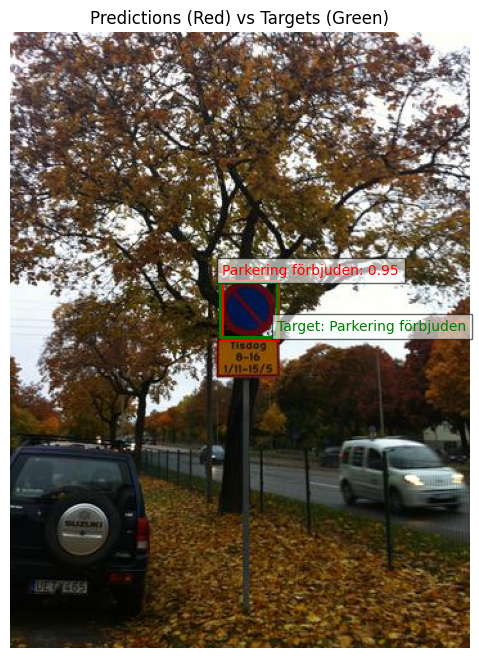

Image 1:
Predicted Boxes: [[165.07005 193.36836 208.34012 239.1291 ]]
Predicted Labels: [10]
Predicted Scores: [0.95411]
Target Boxes: [[163.36206 194.06741 207.83977 237.29808]]
Target Labels: [10]


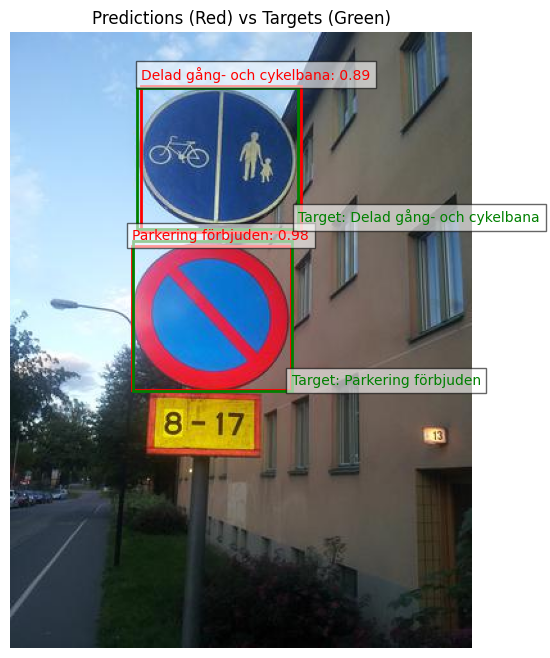

Image 2:
Predicted Boxes: [[ 94.94213  166.1905   218.32304  278.84357 ]
 [101.95533   41.755577 226.49008  155.35757 ]]
Predicted Labels: [10  2]
Predicted Scores: [0.9820154 0.8898232]
Target Boxes: [[ 98.41004   42.84519  224.26778  152.63599 ]
 [ 95.732216 162.00836  218.91214  279.16318 ]]
Target Labels: [ 2 10]


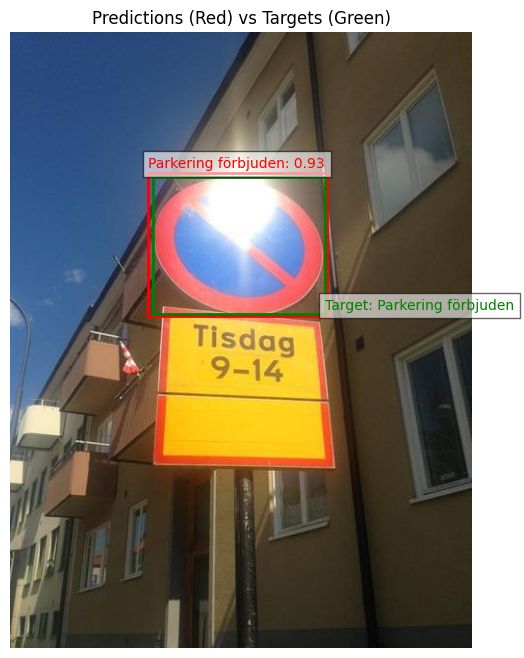

Image 3:
Predicted Boxes: [[143.39496 145.7799  328.7971  294.67868]]
Predicted Labels: [10]
Predicted Scores: [0.9278114]
Target Boxes: [[148.17294 149.95816 326.69455 292.77545]]
Target Labels: [10]


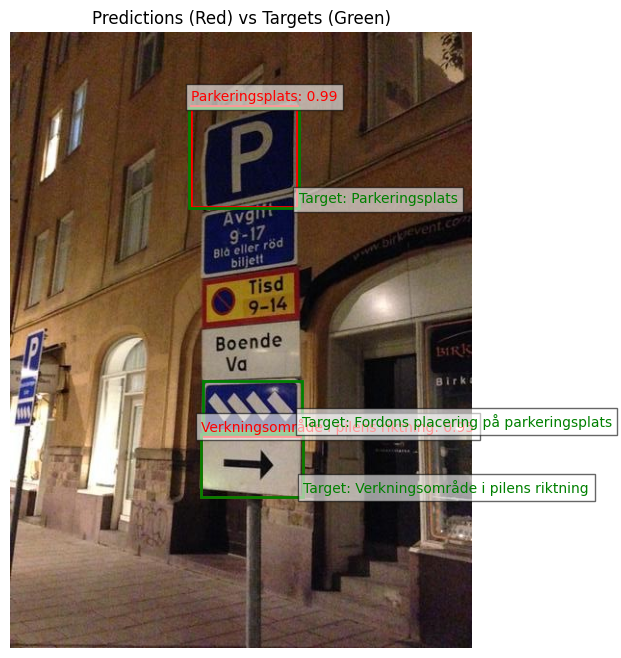

Image 4:
Predicted Boxes: [[187.91855  76.19792 298.16125 181.77023]
 [198.42522 419.71585 303.9953  482.10043]]
Predicted Labels: [14 17]
Predicted Scores: [0.98579466 0.95338094]
Target Boxes: [[185.06108  78.57439 299.50024 182.31393]
 [198.159   416.848   304.37936 482.90097]
 [199.94421 362.3989  302.59415 414.17017]]
Target Labels: [14 17  3]


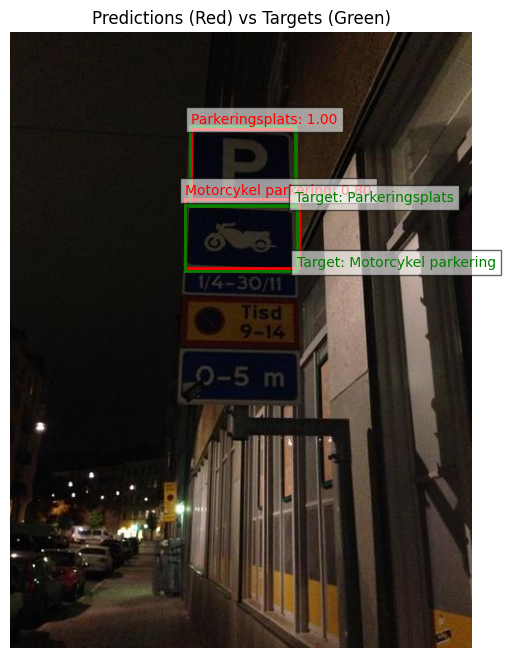

Image 1:
Predicted Boxes: [[187.76701   99.809715 297.0141   179.85248 ]
 [181.54224  173.22035  299.83386  244.61806 ]]
Predicted Labels: [14  9]
Predicted Scores: [0.99715984 0.79887515]
Target Boxes: [[186.55508  97.29428 295.45328 180.30684]
 [181.19945 179.41423 297.2385  248.14505]]
Target Labels: [14  9]


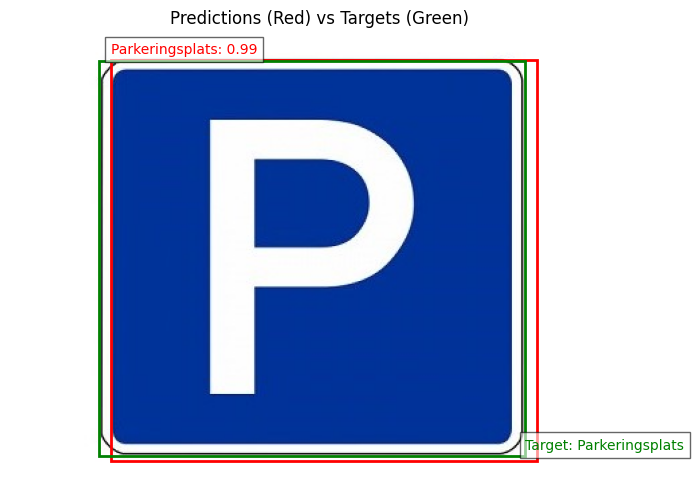

Image 2:
Predicted Boxes: [[ 74.43559   20.623583 392.413    318.99066 ]]
Predicted Labels: [14]
Predicted Scores: [0.9873285]
Target Boxes: [[ 66.147835  20.962343 383.37796  315.36682 ]]
Target Labels: [14]


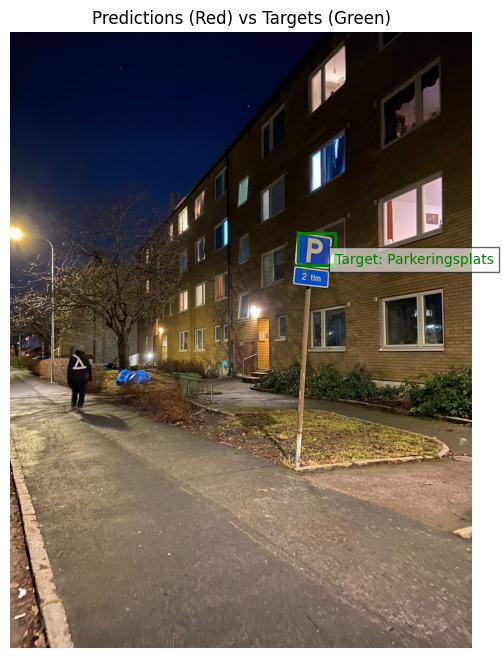

Image 3:
Predicted Boxes: []
Predicted Labels: []
Predicted Scores: []
Target Boxes: [[ 957.2927   667.58234 1078.6542   775.52673]]
Target Labels: [14]


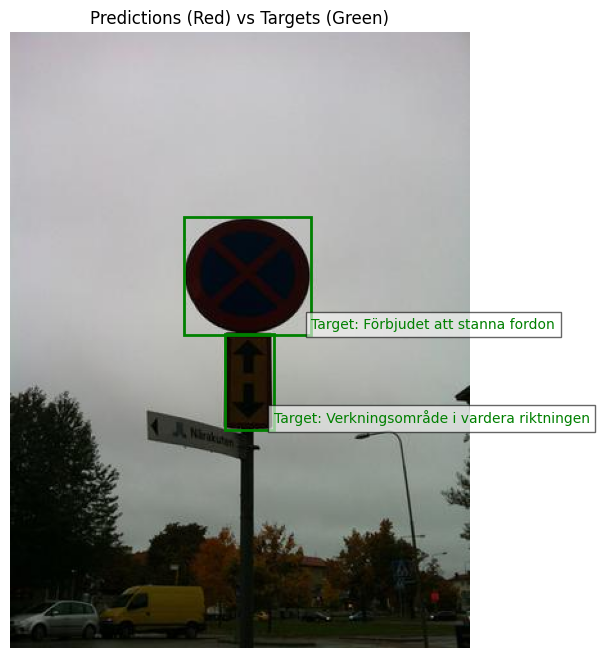

Image 4:
Predicted Boxes: []
Predicted Labels: []
Predicted Scores: []
Target Boxes: [[135.23013 143.93306 234.30962 235.64853]
 [166.69456 234.97908 204.85356 309.2887 ]]
Target Labels: [ 4 18]


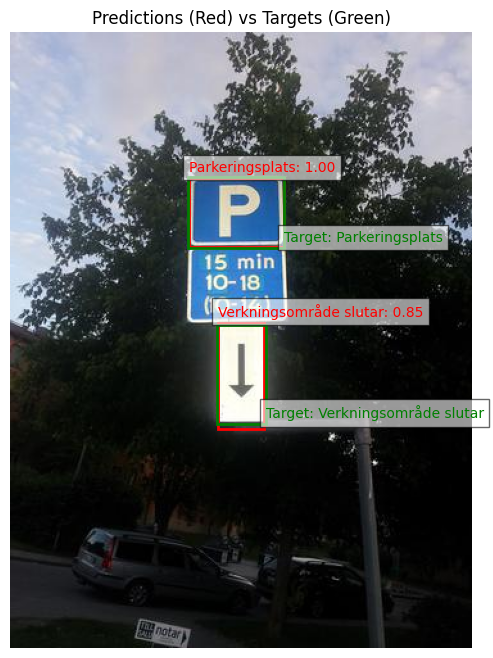

Image 1:
Predicted Boxes: [[138.96957 113.25795 213.32394 167.05344]
 [161.48819 226.39871 197.05307 308.54242]]
Predicted Labels: [14 19]
Predicted Scores: [0.9983234 0.8481894]
Target Boxes: [[138.57741 112.46862 212.88702 168.03348]
 [160.66945 227.61507 198.82845 305.27197]]
Target Labels: [14 19]


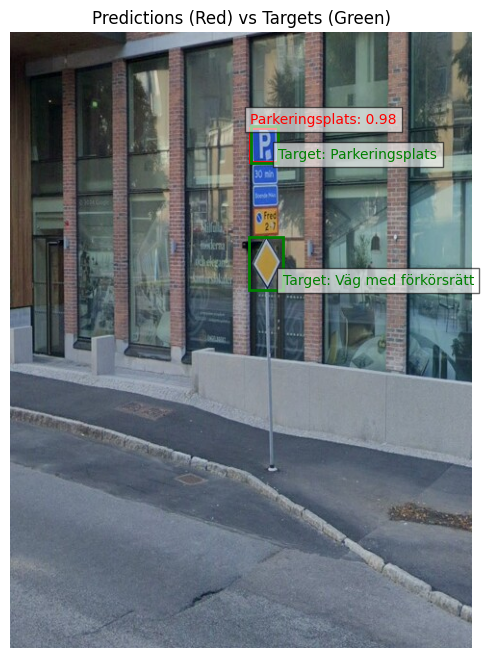

Image 2:
Predicted Boxes: [[249.15305  99.23894 278.04745 134.31908]]
Predicted Labels: [14]
Predicted Scores: [0.9779394]
Target Boxes: [[249.40773  96.9919  278.22818 135.78865]
 [247.74501 212.27368 282.66208 267.1434 ]]
Target Labels: [14 20]


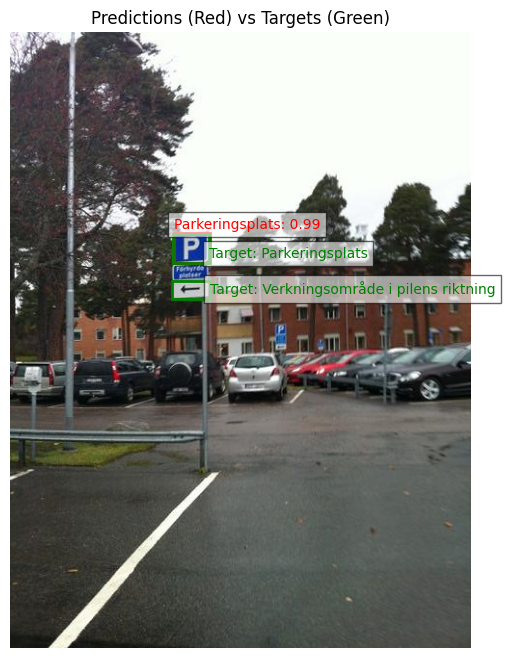

Image 3:
Predicted Boxes: [[169.76274 208.84485 207.64221 239.93369]]
Predicted Labels: [14]
Predicted Scores: [0.98932564]
Target Boxes: [[168.70293 208.8703  206.19247 239.21896]
 [167.81032 257.96375 207.08508 276.7085 ]]
Target Labels: [14 17]


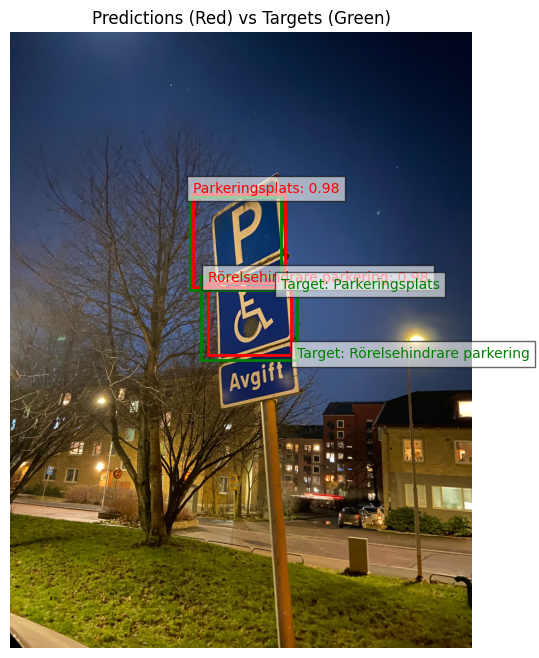

Image 4:
Predicted Boxes: [[ 656.67865  835.31647  932.4859  1073.5317 ]
 [ 607.69275  538.7612   913.84753  848.0544 ]]
Predicted Labels: [15 14]
Predicted Scores: [0.9833682  0.98149455]
Target Boxes: [[ 597.2135   546.89343  900.64374  857.2353 ]
 [ 636.05365  812.104    952.3425  1088.3893 ]]
Target Labels: [14 15]
{'classification_accuracy': 0.7733333333333333, 'mean_iou': 0.9114256439537838, 'mean_average_precision': {'map': tensor(0.3690), 'map_50': tensor(0.4461), 'map_75': tensor(0.4461), 'map_small': tensor(0.2670), 'map_medium': tensor(0.4365), 'map_large': tensor(0.5486), 'mar_1': tensor(0.3734), 'mar_10': tensor(0.3734), 'mar_100': tensor(0.3734), 'mar_small': tensor(0.2667), 'mar_medium': tensor(0.4403), 'mar_large': tensor(0.5555), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  8,  9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22],
       dtype=torch.int32)}}


In [204]:
# Loading the MobileNetV3 without weights
inference_model = fasterrcnn_mobilenet_v3_large_fpn(weights=None, 
                                          num_classes=23,
                                         box_score_thresh=0.7) # only getting predictions with a confidence score of 0.7 or higher
                                          
# loading the fine-tuned weights into the model
inference_model.load_state_dict(torch.load("./final-swedish-traffic-sign-object-detection-modeldir/final-swedish-traffic-sign-object-detection-model-fasterrcnn_epoch_30.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inference_model.to(device)

evaluate_three(inference_model, test_dataloader)
metrics = evaluate_all(inference_model, test_dataloader)
print(metrics)


In [28]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [29]:
# TROCR INFERENCE TESTING HERE:

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-str')   #('microsoft/trocr-base-str')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-str')

ocr_dict = {}
for datapoint in ocr_data:
    bounding_boxes = []
    for text_bounding_box in datapoint.values():
        for coordinates in text_bounding_box:
            bounding_boxes.append(coordinates['bbox'])
    #print(datapoint.keys())
    key = list(datapoint.keys())
    ocr_dict[key[0]] = bounding_boxes

def process_text_signs(image_path, ocr_data):
    """
    This function crops the image based on the text-sign bounding box-annotations.
    params:
        image_path : path to the image
        ocr_data: (dict), holds the text bounding box annotations (keys are filenames)
    """
    image = Image.open(image_path).convert("RGB")
    list_of_all_bboxes = ocr_data.get(os.path.basename(image_path))
    print(list_of_all_bboxes)
    for listy in list_of_all_bboxes:
        x1 = listy[0]
        y1 = listy[1]
        x2 = listy[2]
        y2 = listy[3]   #X top left, y top left, x bottom right, y bottom right 
        cropped_image = image.crop((x1, y1, x2, y2))

        plt.figure(figsize=(10, 5))
        plt.imshow(cropped_image, cmap='gray')
        plt.title(f"Processed Crop: [{x1}, {y1}, {x2}, {y2}]")
        plt.axis('on')
        plt.show()

        pixel_values = processor(images=cropped_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Text detected by trOCR: {text}")
    

[[133.89121338912133, 141.92468619246867, 222.25941422594138, 172.05020920502096], [145.27196652719667, 171.3807531380753, 208.2008368200837, 192.13389121338912], [124.51882845188285, 190.1255230125523, 231.63179916317995, 214.89539748953973]]


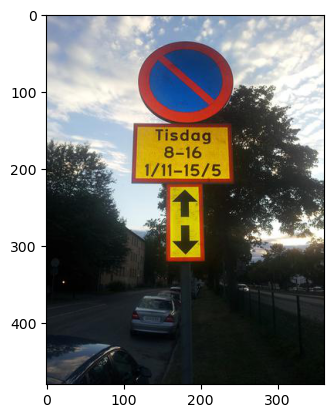

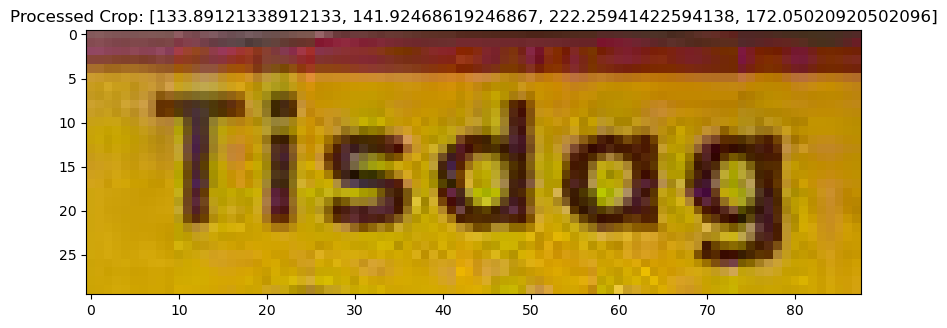

Text detected by trOCR: TISDAG


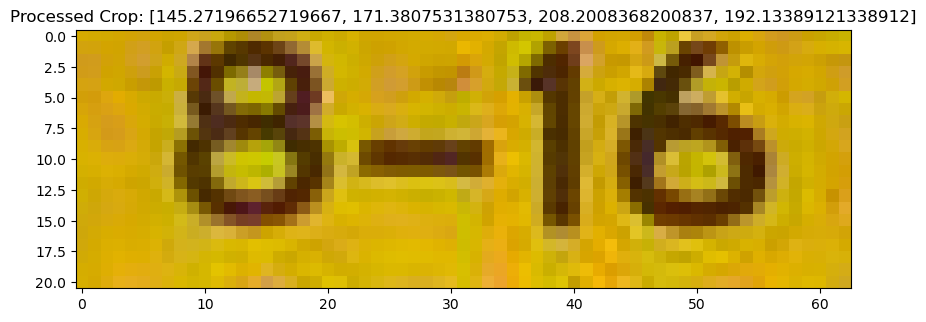

Text detected by trOCR: 8116


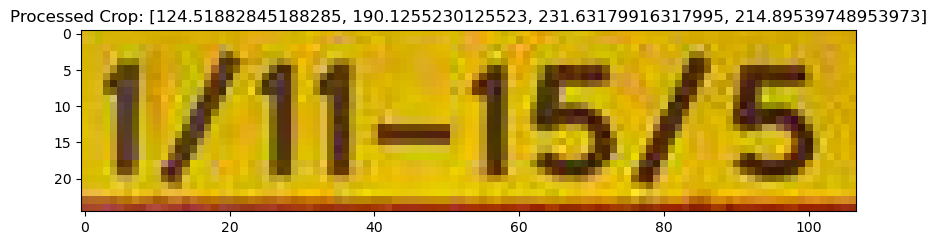

Text detected by trOCR: 1111111515


In [33]:
# Example Usage
image_path = "./swe-parking-signs-groundtruth-master/data/20130716_211045.jpg"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
results = process_text_signs(image_path, ocr_dict)

